<a href="https://colab.research.google.com/github/diogomgsimoes/DRL-Network-Path-Selection-For-Multimedia-Traffic-in-SDNs/blob/main/DRL_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESET**

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# **IMPORTS**

In [1]:
import torch
import gym
import copy
import collections
import random
import time

import networkx as nx
import numpy as np
import torch.multiprocessing as mp
import tensorflow as tf

from itertools import islice, count
from gym import Env
from gym.spaces import Discrete, Box
from matplotlib import pylab as plt
from collections import deque
from torch.nn import functional as F
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR

# **GLOBAL VARIABLES**

In [2]:
TOPOLOGY_ARPANET_FILE_NAME = 'topology_ARPANET.txt'
NUMBER_OF_HOSTS = 13
NUMBER_OF_PATHS = 5
REWARD_SCALE = NUMBER_OF_HOSTS * NUMBER_OF_HOSTS * NUMBER_OF_PATHS

# **DRLEngine: Manages the environment**

In [ ]:
switches = {}
hosts = {}
open("topo.txt", "w").close()  
f = open("topo.txt", "a")

def preprocess_topo_file(filename="NetworkTopologyMapper_w_ElementNames.txt", cnt=1, host_cnt=1):
    with open(filename, 'r') as topo:
        for row in topo.readlines():
            row_data = row.strip('\t\n').strip('"').strip('",').split("|")
            if len(row_data) > 1:
                row_data[0] = row_data[0].rstrip(" ")
                row_data[1] = row_data[1].rstrip(" ").lstrip(" ")
                row_data[2] = row_data[2].lstrip(" ")
                if "CORE" in row_data[0][:-19]:
                    if row_data[0][:-19] not in hosts.keys():
                        hosts[row_data[0][:-19]] = host_cnt
                        host_cnt += 1
                    element1 = 'H{}'.format(hosts[row_data[0][:-19]])
                else:
                    if row_data[0][:-19] not in switches.keys():
                        switches[row_data[0][:-19]] = cnt
                        cnt += 1
                    element1 = 'S{}'.format(switches[row_data[0][:-19]])

                if "CORE" in row_data[1][:-19]:
                    if row_data[1][:-19] not in hosts.keys():
                        hosts[row_data[1][:-19]] = host_cnt
                        host_cnt += 1
                    element2 = 'H{}'.format(hosts[row_data[1][:-19]])
                else:
                    if row_data[1][:-19] not in switches.keys():
                        switches[row_data[1][:-19]] = cnt
                        cnt += 1
                    element2 = 'S{}'.format(switches[row_data[1][:-19]])
                f.write('{} {} {}\n'.format(element1, element2, row_data[2]))
        f.close()

preprocess_topo_file()

In [ ]:
print(len(switches))
print(len(hosts))

84
14


In [3]:
class DRLEngine():
    def __init__(self):
        self.graph = nx.Graph()
        self.link_bw_capacity = {}
        self.current_link_bw = {}
        self.hosts = {}
        self.paths = {}
        # self.srcs = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']
        # self.dsts = ['H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13']
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                            ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.requests_bw = [5, 10, 15, 20]

        self.upload_topology()
        self.build_graph()
        self.calculate_paths()

    def upload_topology(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for row in topo.readlines():
                row_data = row.split()
                if 'H' in row_data[0]:
                    self.hosts[row_data[0]] = row_data[1].replace("S", "")
                elif 'S' in row_data[0]:
                    src_id = row_data[0].replace("S", "")
                    dst_id = row_data[1].replace("S", "")
                    self.link_bw_capacity[(src_id, dst_id)] = int(row_data[2])
                    self.link_bw_capacity[(dst_id, src_id)] = int(row_data[2])

        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

    def build_graph(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for line in topo.readlines():
                nodes = line.split()[:2]
                for node in nodes:
                    if not self.graph.has_node(node):
                        self.graph.add_node(node)
                self.graph.add_edge(nodes[0], nodes[1])
    
    def k_shortest_paths(self, graph, source, target, k):
        try: 
            calc = list(islice(nx.shortest_simple_paths(graph, source, target), k))
        except nx.NetworkXNoPath:
            calc = []
            
        return [path for path in calc]

    def calculate_paths(self):
        for src_host_id in range(1, NUMBER_OF_HOSTS+1):
            src = "H{}".format(src_host_id)
            for dst_host_id in range(1, NUMBER_OF_HOSTS+1):
                dst = "H{}".format(dst_host_id)
                if self.graph.has_node(src) and self.graph.has_node(dst):
                    self.paths[(src, dst)] = self.k_shortest_paths(self.graph, src, dst, NUMBER_OF_PATHS)
                    for path in self.paths[(src, dst)]:
                        if len(path) != 0:
                            for i in range(0, len(path)):
                                if "S" in path[i]:
                                    path[i] = path[i].replace("S", "")
                                    path[i] = int(path[i])

    def make_reservation(self, path_id, delay):
        # time.sleep(delay)
        random.shuffle(self.host_pairs)
        pair = self.host_pairs.pop(0)
        # pair = (random.choice(self.srcs), random.choice(self.dsts))
        path = self.paths[(pair[0], pair[1])][path_id][1:-1]
        request_bw = 15
        # request_bw = self.requests_bw[random.randint(0, 3)]

        for s1, s2 in zip(path[:-1], path[1:]):
            if self.current_link_bw.get((str(s1), str(s2))):
                self.current_link_bw[(str(s1), str(s2))] -= request_bw
                if self.current_link_bw[(str(s1), str(s2))] == 0:
                    self.current_link_bw[(str(s1), str(s2))] = 1
            if self.current_link_bw.get((str(s2), str(s1))):
                self.current_link_bw[(str(s2), str(s1))] -= request_bw
                if self.current_link_bw[(str(s2), str(s1))] == 0:
                    self.current_link_bw[(str(s2), str(s1))] = 1


    def build_state(self):
        state = np.empty((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), dtype=object)
        
        for src in range(1, NUMBER_OF_HOSTS+1):
            h_src = "H{}".format(src)
            for dst in range(1, NUMBER_OF_HOSTS+1):
                h_dst = "H{}".format(dst)
                min_value = float('Inf')
                cnt = 0
                if len(self.paths[(h_src, h_dst)]) == 1:
                    if self.paths[(h_src, h_dst)] == []:
                        for idx in range(NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                    else: 
                        state[src-1, dst-1, 0] = 100
                        for idx in range(1, NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                else:
                    for path in self.paths[(h_src, h_dst)]:
                        path = path[1:-1]
                        for s1, s2 in zip(path[:-1], path[1:]):
                            stats = self.current_link_bw.get((str(s1), str(s2)))
                            if stats:
                                if float(stats) < float(min_value):
                                    min_value = self.current_link_bw[(str(s1), str(s2))]
                    
                        state[src-1, dst-1, cnt] = float(min_value)
                        cnt += 1
                        
                    for idx in range(len(self.paths[(h_src, h_dst)]), NUMBER_OF_PATHS):
                        state[src-1, dst-1, idx] = 1
                    
        return state

    def reset(self):
        self.graph = nx.Graph()
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                           ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

In [ ]:
# Get "The load centrality of a node is the fraction of all shortest paths that pass through that node."

# encontrar algoritmo que determine as edges que sobrecarregam os links de maior centralidade

engine = DRLEngine()
node_centrality = nx.load_centrality(engine.graph)
edge_centrality = nx.edge_load_centrality(engine.graph)
a = nx.max_weight_matching(engine.graph)
print(a)

{('H1', 'S1'), ('S4', 'H4'), ('H12', 'S19'), ('S10', 'S9'), ('H7', 'S12'), ('S14', 'S15'), ('S17', 'H10'), ('H6', 'S11'), ('H5', 'S8'), ('S7', 'S6'), ('S16', 'H9'), ('S3', 'H3'), ('S18', 'H11'), ('S13', 'H8'), ('S20', 'H13'), ('S5', 'S2')}


# **RoutingEnv: Environment**

In [4]:
class RoutingEnv(Env):
    def __init__(self):
        self.requests = 0
        # self.max_requests = random.randint(1, 16)
        self.max_requests = 16
        self.done = False

        self.engine = DRLEngine()

        self.observation_space = Box(low=np.zeros((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), dtype=np.float32), \
            high=np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32), dtype=np.float32)
        
        self.action_space = Discrete(NUMBER_OF_PATHS)
        self.state = np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32)

    def step(self, action):
        self.engine.make_reservation(action, np.random.poisson(1))
        self.requests += 1
        
        reward = 0
        self.state = self.engine.build_state()

        for src in range(NUMBER_OF_HOSTS):
            for dst in range(NUMBER_OF_HOSTS):
                for path_number in range(NUMBER_OF_PATHS):
                    bw = self.state[src, dst, path_number]
                    if bw != None:
                        if bw > 75:
                            reward += 20
                        elif bw > 50: 
                            reward += 10
                        elif bw > 25: 
                            pass
                        elif bw > 0: 
                            reward -= 10
                        else:
                            reward -= 50

        if self.requests == self.max_requests:
            self.done = True
        
        return self.state, (reward/REWARD_SCALE), self.done, {}
        # /self.max_requests

    def render(self):
        pass

    def get_state(self):
        return self.state

    def reset(self):
        self.done = False
        self.state = np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32)
        self.requests = 0
        # self.max_requests = random.randint(1, 16)
        self.engine.reset()

        return self.state

**Test environment**

In [ ]:
env = RoutingEnv()
episodes = 3000
rewards = []

for episode in range(1, episodes + 1):
    env.reset()
    done = False
    score = 0

    while not done:
        n_state, reward, done, info = env.step(0)
        score += reward
    rewards.append(score)

    print('Episode: {}, Score: {}'.format(episode, score))

Episode: 1, Score: 139.52662721893492
Episode: 2, Score: 156.53254437869822
Episode: 3, Score: 170.43786982248523
Episode: 4, Score: 145.9171597633136
Episode: 5, Score: 162.4023668639053
Episode: 6, Score: 128.91124260355025
Episode: 7, Score: 143.6804733727811
Episode: 8, Score: 167.18343195266274
Episode: 9, Score: 145.88165680473378
Episode: 10, Score: 141.89349112426035
Episode: 11, Score: 142.14201183431956
Episode: 12, Score: 144.67455621301778
Episode: 13, Score: 131.25443786982248
Episode: 14, Score: 158.5917159763314
Episode: 15, Score: 144.6272189349112
Episode: 16, Score: 151.00591715976336
Episode: 17, Score: 154.6153846153846
Episode: 18, Score: 146.68639053254435
Episode: 19, Score: 142.07100591715974
Episode: 20, Score: 129.98816568047337
Episode: 21, Score: 158.3786982248521
Episode: 22, Score: 161.79881656804736
Episode: 23, Score: 141.38461538461536
Episode: 24, Score: 131.72781065088756
Episode: 25, Score: 121.40828402366863
Episode: 26, Score: 143.78698224852076
Ep

In [ ]:
print(rewards)

[139.52662721893492, 156.53254437869822, 170.43786982248523, 145.9171597633136, 162.4023668639053, 128.91124260355025, 143.6804733727811, 167.18343195266274, 145.88165680473378, 141.89349112426035, 142.14201183431956, 144.67455621301778, 131.25443786982248, 158.5917159763314, 144.6272189349112, 151.00591715976336, 154.6153846153846, 146.68639053254435, 142.07100591715974, 129.98816568047337, 158.3786982248521, 161.79881656804736, 141.38461538461536, 131.72781065088756, 121.40828402366863, 143.78698224852076, 142.9112426035503, 144.04733727810648, 146.33136094674552, 163.96449704142012, 142.85207100591714, 140.0710059171598, 153.4082840236686, 137.34911242603553, 151.491124260355, 167.07692307692307, 152.61538461538464, 160.92307692307688, 149.21893491124263, 163.36094674556213, 157.7633136094675, 153.26627218934914, 125.73964497041423, 139.2781065088758, 137.7869822485207, 136.75739644970415, 134.93491124260356, 139.5147928994083, 145.0650887573964, 132.8994082840237, 138.5562130177515

# **DQN with experience replay and a target network for stability**

In [5]:
# Functional DQN Agent with Experience Replay and Target Network

env = RoutingEnv()

# l1 = 320
# l2 = 500
# l3 = 800
# l4 = 400
# l5 = 200
# l6 = 50
# l7 = 5

l1 = 845
l2 = 1500
l3 = 700
l4 = 200
l5 = 5

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4, l5)
)

# l1 = 320
# l2 = 160
# l3 = 80
# l4 = 5

# model = torch.nn.Sequential(
#     torch.nn.Linear(l1, l2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(l2, l3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(l3,l4)
# )

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

gamma = 0.9
epsilon = 0.5
learning_rate = 1e-3

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# state_flattened_size = 320
state_flattened_size = 845
losses = []
total_reward_list = []
epochs = 3000
mem_size = 50000
batch_size = 256
sync_freq = 50
replay = deque(maxlen=mem_size)

for i in range(epochs):
    print("Starting training, epoch:", i)
    cnt = 0
    total_reward = 0
    _state = env.get_state()
    state1 = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1, state_flattened_size)
    done = False
    env.reset()
    
    while not done: 
        print("Step:", cnt+1)
        cnt += 1
        qval = model(state1) 
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action_)
        state2 = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, state_flattened_size)

        print("State:", state2)
        
        exp = (state1, action_, reward, state2, done)

        if reward > 14:
            for _ in range(5):
                replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch)
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if cnt % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
        
        total_reward += reward
    
    total_reward_list.append(total_reward)
    print("Episode reward:", total_reward)
        
    if epsilon > 0.05:
        epsilon -= (1/epochs)
        
print(total_reward_list)
   
print('Plotting losses ...')     
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.savefig('avg_loss.png') 

print('Plotting rewards ...')     
plt.figure(figsize=(10,7))
plt.plot(total_reward_list)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Return",fontsize=22)
plt.savefig('avg_return.png')

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(total_reward_list), size):
        avg += [sum(val for val in total_reward_list[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

torch.save(model.state_dict(), 'dqn_model_exp_replay_target_network.pt')

A saída de streaming foi truncada nas últimas 5000 linhas.
          85.,  85.,  85.,  85., 100.,  85.,  85.,  85.,  85.,  85.,  85.,  70.,
          70.,  70.,  85.,  85.,  85.,  70.,  70.,  85.,  85.,  85.,  85.,  85.,
          85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,
          85.,  85.,  85., 100.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,
          85., 100.,  85.,  85.,  85.,  85., 100.,   1.,   1.,   1.,   1.,  85.,
          85.,  85.,  85.,  85., 100., 100.,  85.,  85.,  85., 100., 100.,  85.,
          85.,  85.,  70.,  70.,  70.,  70.,  70.,  70.,  70.,  70.,  70.,  70.,
          85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,
          85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,
          85., 100., 100.,  85.,  85.,  85., 100., 100.,  85.,  85.,  85.,  85.,
          85.,  85.,  85.,  85., 100.,   1.,   1.,   1.,   1., 100.,  85.,  85.,
          85.,  85.,  85.,  85.,  85.,  85.,  85.,

KeyboardInterrupt: ignored

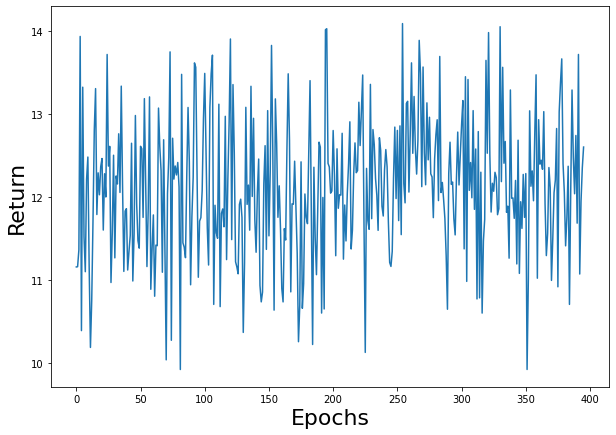

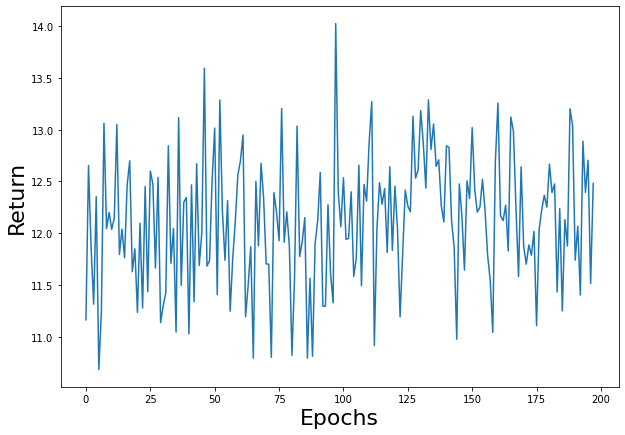

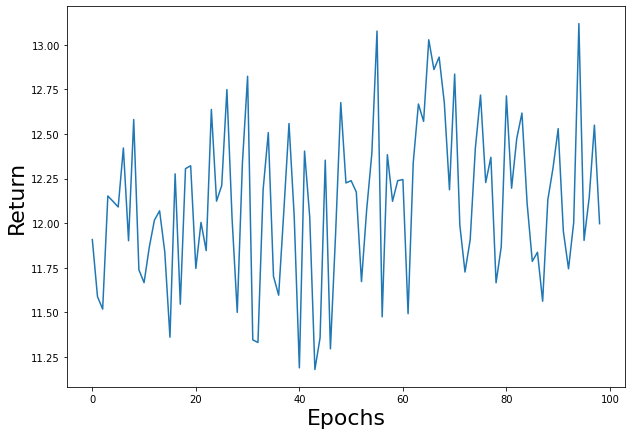

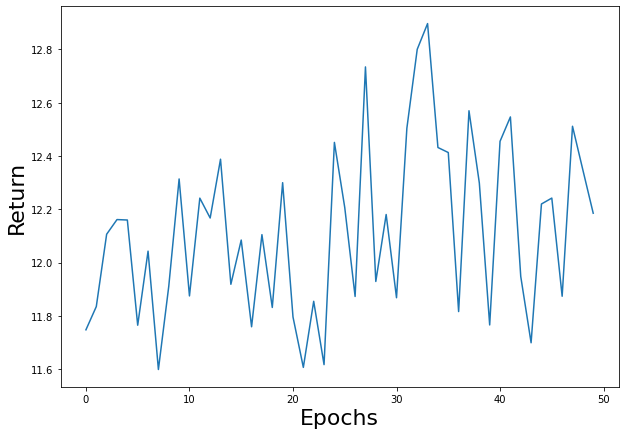

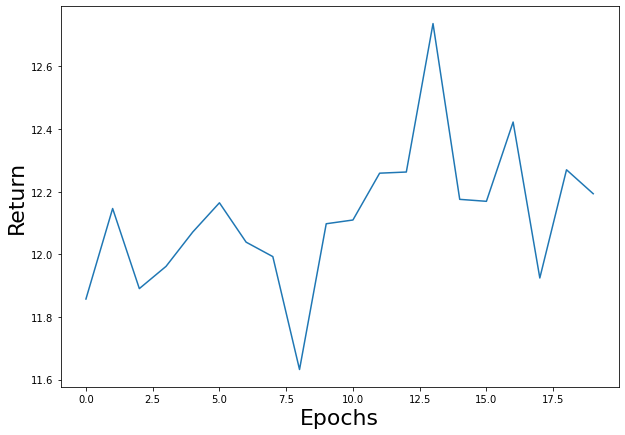

In [ ]:
sizes = [25, 50, 100, 200, 500]
total_reward_list = [14.332544378698223, 9.165680473372781, 5.900394477317552, 12.041875284478834, 7.971779699590349, 8.532544378698224, 12.838757396449703, 16.940828402366865, 4.053254437869823, 9.283037475345166, 15.439842209072978, 3.7381656804733736, 16.911242603550296, 12.714285714285714, 13.538461538461538, 10.293491124260356, 9.506186121570735, 9.714497041420117, 14.215976331360947, 12.502958579881657, 18.153846153846153, 11.888560157790927, 18.153846153846153, 1.8161735700197243, 9.383539537385692, 6.926304464766003, 12.330450614474282, 16.11834319526627, 4.317159763313609, 7.253122945430638, 15.044378698224854, 13.480980557903637, 16.985207100591715, 15.889546351084812, 18.153846153846153, 11.902366863905325, 5.567202028740491, 13.075232459847843, 16.82248520710059, 13.89086127547666, 8.362130177514793, 10.614201183431954, 11.918474687705459, 10.895104895104895, 4.891272189349111, 11.442876649977242, 3.4201183431952664, 9.386306001690617, 11.515868746637977, 8.896677287209831, 18.153846153846153, 12.321217244294166, 4.678994082840235, 11.863060016906172, 7.008875739644968, 11.357565511411664, 9.105522682445757, 2.76923076923077, 18.153846153846153, 18.153846153846153, 14.923076923076923, 16.76923076923077, 10.019365250134483, 6.594345825115056, 13.66863905325444, 14.192730346576502, 13.250000000000002, 12.08284023668639, 10.697041420118342, -3.8343195266272194, 14.958579881656805, 8.607853684776764, 10.252747252747252, 18.153846153846153, 10.261430876815492, 12.781065088757398, 16.13412228796844, 11.571992110453648, 13.644970414201183, 14.938856015779095, 14.931530008453088, 11.078895463510849, 15.086390532544378, 9.282544378698223, 12.885207100591717, 9.758579881656805, 12.014464168310324, 18.153846153846153, 14.626035502958581, 13.882971729125574, 12.714003944773175, 16.82248520710059, 18.153846153846153, 13.52493660185968, 6.820512820512821, 16.384615384615383, 13.662064431295201, 15.468934911242604, 18.153846153846153, 15.982248520710058, 9.121032813340506, 9.389687235841082, 11.183431952662723, 15.510848126232741, 6.970414201183432, 18.153846153846153, 2.829247675401522, 8.499408284023668, 7.338123415046492, 14.982248520710062, 11.372781065088757, 6.906065088757398, 10.064102564102564, 2.5340236686390547, 18.153846153846153, 12.298224852071005, 10.875739644970412, 13.173076923076923, 2.389792899408284, 17.22189349112426, 10.640039447731757, 14.101437024513949, -0.4607988165680479, 8.45128205128205, 18.153846153846153, 11.859678782755706, 13.825115055884288, 15.408284023668639, -0.5743589743589752, 18.153846153846153, 8.319526627218938, 18.153846153846153, 13.765285996055225, 10.528599605522682, 15.439842209072978, 18.153846153846153, 10.537475345167651, 8.317374932759547, 13.991124260355027, 11.095857988165683, 18.153846153846153, 18.153846153846153, 13.375147928994085, 11.8698224852071, 18.153846153846153, 7.596787827557058, 12.17603550295858, 12.248520710059173, 18.153846153846153, 16.319526627218934, 13.899408284023668, 16.831360946745562, 12.820512820512818, -4.89423076923077, 17.4218089602705, 14.344378698224853, 17.339644970414202, 8.263313609467456, 18.153846153846153, 8.247781065088757, 14.562130177514792, 12.989349112426034, 18.153846153846153, 11.091984938138786, 5.96301775147929, 17.159763313609467, 6.775887573964496, 18.153846153846153, 8.24006762468301, 7.2855029585798805, 11.385691231845074, 12.210059171597631, 8.984467455621303, -1.7404339250493102, 14.479289940828403, 15.563820794590024, 16.72189349112426, 10.03905325443787, 0.44733727810650925, 11.73136094674556, 6.4564666103127655, 6.848689771766696, 9.182356105433028, 11.450098619329387, 16.252465483234715, 11.518434228493401, 8.847767616998386, 11.439053254437871, 12.718512256973796, 9.80609922621757, 12.592702169625245, 10.406670252824098, 9.298816568047338, 16.120710059171596, 13.202662721893493, 18.153846153846153, 16.303747534516766, 7.706873008648156, 13.790927021696254, 0.9991546914623834, 6.799802761341223, 16.179881656804735, 17.13609467455621, 13.386306001690615, 18.153846153846153, 2.378698224852071, 13.284023668639053, 8.009615384615383, 11.894336432797974, 9.032316795630402, 4.0997464074387135, 11.187735341581497, 8.575329995448339, 16.42800788954635, 13.551986475063396, 13.524936601859679, 13.471400394477314, 15.439842209072978, 18.153846153846153, 11.27662721893491, 18.153846153846153, 3.2766272189349097, 13.810650887573964, 14.356850250341374, 13.90532544378698, 15.427218934911243, 9.258382642998031, 9.150887573964498, 5.65976331360947, 3.64940828402367, 14.489644970414203, 16.563313609467457, 12.490466798159105, 18.153846153846153, 13.445759368836292, 14.111242603550298, 10.315300084530854, 18.153846153846153, 14.824457593688363, 10.52747252747253, 11.412835685025033, 18.153846153846153, 8.440236686390532, 2.7359467455621305, 16.642434488588336, 17.47534516765286, 16.028402366863904, 8.850493096646941, 15.828402366863905, 10.34319526627219, 18.153846153846153, 9.428311333636776, 15.755424063116372, 0.003155818540434341, 2.6871301775147933, 7.951676528599605, 6.810650887573964, 18.153846153846153, 18.153846153846153, 18.153846153846153, 13.537278106508877, 10.795266272189348, 12.497041420118343, 12.961209730440501, 18.153846153846153, 2.9704142011834334, 10.0, 8.098055790363482, 8.895181741335588, 9.672583826429978, 11.256804733727812, 9.546351084812622, 9.115384615384615, 11.292092522861752, 15.285207100591716, 15.948717948717949, 16.796844181459566, 11.365680473372784, 12.880811496196113, 11.606508875739648, 18.153846153846153, 7.369139736003641, -0.47889546351084844, 9.902958579881657, 15.621301775147929, 18.153846153846153, 6.971203155818541, 6.666666666666667, 10.368836291913215, 3.930966469428009, 8.035502958579883, 1.3136094674556216, 7.699211045364891, 15.124260355029586, 7.300864815657714, 7.674556213017751, 10.045185583647122, 10.901775147928994, 6.717455621301775, 14.718934911242602, 10.085470085470087, 1.6859353664087404, 15.854606931530009, 0.6346153846153819, 13.177514792899407, 16.307692307692307, 0.9852071005917165, 14.57650042265427, 8.8778913394298, 10.344181459566077, 13.813017751479288, 14.823964497041421, 8.894230769230766, 11.740720817643895, 13.449704142011832, 12.913609467455618, 12.755705832628907, 6.683431952662722, 14.909270216962524, 14.520710059171597, 2.994928148774304, 13.570019723865878, 13.678994082840237, 9.262045646661033, 12.424344885883347, 11.875739644970414, 8.879120879120883, 18.153846153846153, 6.493343195266272, 7.934516765285997, 13.495069033530573, 16.729783037475343, 3.0067624683009297, 6.380276134122287, 15.7301775147929, 1.658777120315582, 10.50769230769231, 11.207100591715978, 14.833474218089606, 18.153846153846153, 15.874556213017751, 8.866441251056637, 17.13609467455621, 10.245364891518737, 7.3420118343195275, 16.90414201183432, 9.835634451019065, 18.153846153846153, 18.153846153846153, 5.630600169061707, 9.829767865270822, 10.6636322257624, 15.557396449704143, 7.975147928994081, 18.153846153846153, 18.153846153846153, 18.153846153846153, 12.754766600920448, 15.871513102282336, 3.4970414201183426, 15.837278106508876, 10.81301775147929, 17.079289940828403, 16.72189349112426, 11.129332206255285, 9.799802761341224, 11.825712748789671, 14.044378698224852, 6.596153846153847, 12.372781065088757, 14.771597633136096, 18.153846153846153, 9.558185404339252, 9.478214093598707, 11.528599605522682, 10.850995158687468, 16.011834319526628, 15.599605522682445, 18.153846153846153, 7.342011834319526, 15.360946745562131, 18.153846153846153, 10.784292630446476, 14.920710059171597, 18.153846153846153, 15.816568047337276, 11.22945430637738, 18.153846153846153, 6.994082840236685, 16.272189349112427, 12.323830016137709, 14.288757396449705, 14.570414201183432, 13.033227127901686, 16.106508875739642, 12.434911242603551, 7.91624943104233, 8.334319526627217, 5.325443786982247, 14.615384615384613, 10.187771203155819, 12.579881656804734, 18.153846153846153, 10.062130177514792, 10.640368178829718, 16.796844181459566, 9.326354119253528, 9.817105970952124, 8.254043392504927, 11.310650887573965, 6.828402366863906, 8.487027765134275, 1.076183431952662, 8.191885038038883, 16.29047875201721, 11.848689771766693, 18.153846153846153, 11.571597633136093, 10.20441097364174, 11.644970414201184, 11.490048413125336, 12.467455621301776, 18.153846153846153, 14.490466798159105, 16.796844181459566, 11.779585798816566, 6.506144742831134, 16.682445759368836, 11.579881656804734, 12.167652859960555, 6.338757396449703, 8.914883932635412, 12.330046022353715, 18.153846153846153, 18.153846153846153, 16.11834319526627, 12.822485207100593, 8.387573964497044, 10.55621301775148, 11.99802761341223, 16.11834319526627, 15.42857142857143, 9.934253780407627, 8.88560157790927, 15.034319526627218, 12.315976331360945, 12.48689771766695, 11.633136094674557, 6.195266272189348, 16.85207100591716, 11.857988165680474, 10.00355029585799, 10.622485207100592, 10.942519019442097, 7.001183431952663, 16.263313609467456, 18.153846153846153, 15.02958579881657, 10.314003944773175, 10.904480135249367, 14.698224852071004, 18.153846153846153, 11.708579881656807, 6.898422090729783, 10.327719617660446, 13.000000000000002, 9.841850457235072, 11.153846153846152, 8.96404187528448, 13.403846153846153, 15.745562130177515, 13.72912557527942, 11.125443786982247, 9.991393222162454, 10.93343195266272, 6.427613412228797, 17.00828402366864, 11.564497041420116, 16.28007889546351, 8.24032771961766, 17.19921104536489, 18.153846153846153, 14.16370808678501, 7.947590870667793, 5.7354184277261195, 15.19526627218935, 12.485207100591717, 11.112426035502962, 10.330515638207943, 18.153846153846153, 14.431952662721894, 13.794871794871794, 18.153846153846153, 8.936601859678785, 9.99139322216245, 14.551141166525783, 12.990532544378699, 8.470836855452239, 9.142467000455168, 8.755244755244755, 4.770545693622616, 18.153846153846153, 11.639710716633795, 3.6824457593688353, 12.525147928994084, 13.736263736263735, 9.200645508337818, 12.645425580336823, 12.414201183431953, 14.826711749788673, 18.153846153846153, 11.106508875739644, 14.188165680473375, 14.594674556213018, 12.398422090729783, 15.497041420118343, 14.076923076923077, 12.343195266272192, 16.700197238658777, 15.755424063116372, 7.647122108660572, 9.415384615384616, 11.130632680928539, 6.936731907146108, 18.153846153846153, 8.14201183431953, 18.153846153846153, 7.928994082840236, 11.789940828402369, 6.279289940828402, 18.153846153846153, 10.204142011834318, 10.749865519096288, 8.262890955198646, 8.974358974358974, 11.072978303747536, 14.240631163708088, 9.157396449704143, 12.078106508875738, 14.124260355029586, 16.6094674556213, 5.318047337278106, 11.93329747175901, 18.153846153846153, 18.153846153846153, 18.153846153846153, 3.9755424063116354, 11.267587113740962, 8.808114961961115, 8.457593688362918, 9.819257665411513, 7.745956607495068, 18.153846153846153, 18.153846153846153, 15.439842209072978, 15.294674556213018, -3.617357001972386, 14.890955198647507, 12.558579881656806, 7.867670790747713, 11.984938138784294, 18.153846153846153, 11.389687235841082, 12.610124917817227, 12.384615384615383, 13.25562130177515, 16.11834319526627, 6.8385460693153, 12.24983563445102, 9.508030431107354, 10.957593688362918, 11.38698224852071, 14.263313609467456, 11.539537385691231, 18.153846153846153, 13.264792899408285, 9.055406132329207, 14.090236686390533, 1.9571005917159763, 16.985207100591715, 15.865088757396451, 14.85207100591716, -0.9948717948717947, 15.152662721893492, 11.334648257725178, 16.525443786982247, 18.153846153846153, 12.044970414201183, 18.153846153846153, 11.0989010989011, 11.441420118343196, 10.811834319526627, 11.426692965154503, 11.976331360946746, 8.865220249835634, 13.98343195266272, 11.74792899408284, 7.0112963959117796, 14.169625246548321, 11.12623274161736, 9.800507185122571, 11.51577909270217, 14.666666666666664, 12.811308349769888, 9.160673645880747, 16.796844181459566, 14.537278106508875, 14.972781065088757, 18.153846153846153, 15.005917159763314, 18.153846153846153, 10.914792899408285, 14.317554240631162, 10.105433028509951, 11.422485207100593, 7.75147928994083, 14.13757396449704, 16.11834319526627, 17.39842209072978, 18.153846153846153, 9.792899408284024, 18.153846153846153, 5.3165680473372765, 18.153846153846153, 15.714661406969096, 11.51005917159763, 13.213017751479287, 13.974640743871516, 18.153846153846153, 6.841814595660749, 4.566356720202875, 12.126232741617358, 16.244575936883628, 7.912856374394837, 6.820209376422394, 15.619986850756082, 14.220907297830376, 18.153846153846153, 10.17619986850756, 11.414201183431953, 18.153846153846153, 12.44970414201184, 15.48639053254438, 18.153846153846153, 6.729176149294492, 18.153846153846153, 7.946351084812623, 6.886498117267347, 14.147473827947199, 10.352399737015121, 6.193575655114118, 11.913609467455622, 14.36094674556213, 15.717159763313608, 18.153846153846153, 18.153846153846153, 10.883932635411927, 13.72442941673711, 12.178590640129103, 5.694459386767079, 16.11834319526627, 10.601014370245139, 18.153846153846153, 16.11834319526627, 10.076923076923075, 15.599605522682445, 10.936601859678783, 18.153846153846153, 6.859467455621303, 9.963651732882502, 8.880670611439843, 13.629908552985475, 12.422654268808113, 2.712278106508877, 18.153846153846153, 9.031276415891801, 8.200338123415047, 3.2972234865726, 18.153846153846153, 17.131360946745563, 9.644970414201184, 4.60207100591716, 8.379543533389686, 8.812623274161735, 11.233500227583068, 2.8402366863905337, 5.145393068469993, 13.414201183431953, 7.778106508875739, 18.153846153846153, 18.153846153846153, 14.236686390532547, 11.963421194190426, 9.065088757396449, 18.153846153846153, 18.153846153846153, 12.20828402366864, 7.893491124260355, 13.751479289940828, 4.948436179205411, 14.183431952662719, 14.691124260355028, 9.75147928994083, 12.936601859678783, 11.23896222121074, 12.35229858898498, 11.5301775147929, 1.6619822485207092, 10.699704142011834, 11.879684418145954, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.254437869822485, 9.64102564102564, 10.320315581854047, 13.84378698224852, 18.153846153846153, 12.34792899408284, 7.337278106508874, 16.76923076923077, 6.216715976331362, 8.315976331360947, 14.519526627218935, -2.8951048951048954, 13.855621301775145, 13.742603550295856, 10.147271531886917, 18.153846153846153, 12.616699539776462, 15.072978303747536, 7.1250493096646945, 10.332347140039447, 12.85207100591716, -3.747041420118344, 18.153846153846153, 13.201183431952662, 16.11834319526627, 11.072189349112426, 18.153846153846153, 10.789743589743592, 13.66356720202874, 12.982248520710058, 13.76923076923077, 7.463152232383002, 5.59978483055406, 18.153846153846153, 11.523245984784445, 18.153846153846153, 13.727810650887573, 18.153846153846153, 13.275476660092044, 3.5887573964497044, 10.766272189349111, -3.8856015779092705, 10.32307692307692, 12.666666666666666, 8.729501267962807, 12.004551661356393, 11.137409598948059, 14.32544378698225, 2.0747041420118335, 11.98422090729783, 15.69467455621302, 18.153846153846153, 6.433431952662723, 10.569737954353338, 14.875739644970414, 7.3145197997269005, 16.59171597633136, 14.633981403212172, 12.759763313609469, 18.153846153846153, 9.591178052716513, 11.848305540613232, 18.153846153846153, 13.358215748748293, 18.153846153846153, 12.80276134122288, 13.399408284023668, 13.38224852071006, 12.761834319526628, 18.153846153846153, 16.923076923076923, 14.390532544378699, 7.994082840236686, 9.498224852071004, 8.127810650887573, 9.81520254893036, 15.439842209072978, 9.326289095519863, 18.153846153846153, 14.266272189349113, -0.6255283178360096, 7.907146108329539, 8.062327416173572, 8.625398270368683, 13.136094674556213, 12.861932938856016, 12.366863905325443, 8.634826711749788, 6.676775147928994, 8.78369493754109, 9.41354372123603, 7.911242603550295, 14.21301775147929, 10.266272189349111, 8.639842209072981, 10.65877712031558, 16.65877712031558, 14.576923076923078, 13.319526627218934, 10.497041420118343, 11.986686390532542, 16.72189349112426, 18.153846153846153, 11.967878275570584, 11.546351084812624, 18.153846153846153, 0.5771506599908958, 14.175147928994082, 18.153846153846153, 18.153846153846153, 11.52794214332676, 12.648915187376726, 18.153846153846153, 16.189349112426036, 15.555029585798817, 3.390532544378699, 15.816568047337277, 12.994082840236688, 14.59678782755706, 12.178829717291256, 16.63905325443787, 16.525443786982247, 15.820118343195267, 4.752017213555675, 14.299802761341223, 14.971729125575278, 13.05473372781065, 7.9107046799354475, 18.153846153846153, 10.821005917159763, 9.079881656804734, 14.002366863905326, 18.153846153846153, 14.936883629191321, -0.09144701452393722, 9.020381328073636, 12.207945900253593, 8.044801352493657, 8.23905325443787, 14.733727810650889, 13.222316145393068, 13.78566732412886, 16.684023668639053, 17.34516765285996, 5.866441251056636, 18.153846153846153, 12.069315300084531, 18.153846153846153, 2.261094674556211, 8.272189349112427, 13.391715976331362, 8.986475063398139, 18.153846153846153, 9.242603550295858, 7.793885601577909, 12.774161735700199, 15.846153846153847, 10.334319526627219, 7.118881118881119, 18.153846153846153, 5.646661031276417, 17.19921104536489, 11.188503803888418, 18.153846153846153, 8.646942800788954, 18.153846153846153, 10.80670611439842, 16.60355029585799, 12.00322754168908, 18.153846153846153, 18.153846153846153, 9.218934911242604, 11.51084812623274, 7.481508875739646, 14.282947821409357, 11.207100591715973, 18.153846153846153, 9.52571688666363, 18.153846153846153, 11.91178052716514, 4.875739644970413, 16.662721893491124, 11.437869822485206, 13.54766600920447, 18.153846153846153, 12.723208415516108, 12.779750164365549, 11.713017751479288, 18.153846153846153, 9.301775147928993, 18.153846153846153, 15.439842209072978, 4.144970414201183, 7.995448338643604, 7.335457441966318, 18.153846153846153, 17.437869822485208, 10.254437869822485, 18.153846153846153, 7.545118343195265, 11.159763313609467, 8.753451676528597, 6.793639053254436, 7.1631445477599325, 14.189349112426038, 15.423076923076923, 8.25, 18.153846153846153, 9.39940828402367, 9.733727810650889, 12.705325443786984, 18.153846153846153, 18.153846153846153, 0.8622147083685567, 16.5956607495069, 12.41775147928994, 16.727810650887573, 16.71301775147929, 6.964952207555759, 14.64792899408284, -3.8727810650887573, 14.834319526627219, 9.089546351084813, 9.724429416737108, 8.705832628909555, 6.633530571992111, 15.297830374753453, 12.795529257067718, 9.724583109198491, 18.153846153846153, 11.232741617357002, 7.116370808678502, 7.86336740182894, 7.556952662721894, 17.249704142011833, 8.690031861629492, 13.81360946745562, 13.949704142011834, 15.861932938856015, 13.24852071005917, 11.637080867850099, 17.112426035502956, 15.696252465483234, 14.272189349112423, 10.813837050523443, 14.14792899408284, -2.3086026399635866, 8.03381234150465, 14.157790927021697, 11.40532544378698, 15.577345731191885, 6.518343195266271, 9.72673480365788, 7.381459566074952, 4.567137005006827, 14.69230769230769, 8.010758472296933, 14.745562130177515, 16.392899408284023, 9.014792899408286, 15.02958579881657, 16.159763313609467, 10.701183431952662, 9.814032121724427, 5.204881656804735, 11.14792899408284, 18.153846153846153, 10.97396449704142, 13.512820512820513, 15.822485207100591, 14.612426035502958, 14.953846153846152, 7.806706114398422, 13.47810650887574, 6.340976331360946, 9.872781065088757, 7.218934911242606, 18.153846153846153, 17.274161735700197, 17.339644970414202, 11.39526627218935, 9.944773175542407, 9.611619150080687, 14.698224852071007, 6.761037778789257, 9.956607495069035, 11.831091984938137, 8.390532544378697, 11.075232459847843, 14.726331360946745, 5.825216203914427, 10.840236686390533, 8.824704142011832, 15.744378698224853, 12.590236686390533, 18.153846153846153, 14.153846153846153, 5.53953738569123, 4.470641784251252, 3.3017751479289945, 9.975255513717055, 14.761341222879684, 4.213806706114397, 14.293885601577909, 12.216962524654834, 8.643604915794263, 14.312426035502957, 10.77869822485207, 10.87404902789518, 16.11834319526627, 12.039806347498654, 16.244575936883628, 12.726445152480656, 18.153846153846153, 7.8658777120315575, 12.815492200107585, 13.011834319526628, 16.27810650887574, 16.420118343195266, -3.031952662721894, 4.31656804733728, 9.14623837700761, 7.314685314685315, 4.420118343195266, 9.017751479289942, 8.631163708086785, 13.491124260355031, 11.010220548682089, 13.937600860677783, 13.056481979558903, 16.72189349112426, 9.693998309382927, 16.710059171597635, 18.153846153846153, 6.737954353338967, 12.667793744716823, 14.34516765285996, 13.021696252465485, 7.415814954276492, 11.481262327416173, 0.9412228796844169, 18.153846153846153, 18.153846153846153, 5.085116067364587, 11.850591715976332, 18.153846153846153, 8.497041420118343, 7.19344560764679, 9.54574419663177, 14.926458157227387, 4.95636094674556, 10.60172963131543, 9.551873767258382, 7.306706114398422, 17.13609467455621, 18.153846153846153, 15.106508875739646, 16.11834319526627, 1.8099112426035509, 18.153846153846153, 7.0875739644970395, 18.153846153846153, 11.076923076923077, 18.153846153846153, 12.252824098977943, 14.307692307692307, 4.669033530571993, 12.696745562130177, 13.956043956043956, 15.467455621301774, 16.72189349112426, 16.455621301775146, 18.153846153846153, 0.8357988165680479, 6.254893035958125, 12.745562130177513, 11.448224852071005, 9.555818540433924, 13.736686390532544, 18.153846153846153, 17.112426035502956, 9.12341504649197, 11.956607495069033, 18.153846153846153, 7.842603550295857, 11.633136094674557, 13.820794590025361, 7.581572273879966, 6.331360946745561, 7.5786982248520705, 3.3934911242603545, 17.19921104536489, 15.507692307692308, 16.24852071005917, 7.262327416173569, 13.608152531229454, 5.410819949281488, 11.339250493096646, 10.603550295857987, 14.931952662721894, 15.534516765285996, 18.153846153846153, 12.441251056635672, 9.508136094674555, 13.039447731755422, 11.753846153846153, 15.730769230769232, 1.804076265614727, 5.934171597633135, 16.071005917159763, 7.775936883629189, 10.05680473372781, 15.301775147928993, 11.05562130177515, 8.978867286559597, 14.655325443786984, 18.153846153846153, 15.155029585798815, 13.143984220907297, 8.256656804733728, 7.76094674556213, 14.244970414201184, 11.55473372781065, 10.942800788954635, 15.863905325443787, -1.0606508875739633, 15.680473372781066, 13.96318211702827, 8.471221086605704, 18.153846153846153, 7.594477317554241, 12.732248520710058, 0.8195266272189361, 15.004602235371467, 11.309171597633139, 7.244970414201184, 14.053254437869823, 13.95266272189349, 8.692702169625246, 12.324598478444631, 11.43650432407829, 16.28007889546351, 10.747041420118343, 18.153846153846153, 11.707783340919438, 12.949704142011834, 5.557578516158398, 15.39940828402367, 18.153846153846153, 18.153846153846153, 15.1039729501268, 14.459171597633139, 16.72189349112426, 18.153846153846153, 14.758579881656807, 9.935366408739192, 3.7120315581854024, 12.264299802761341, 4.897717666948437, 18.153846153846153, 7.582157487482932, 15.392504930966469, 18.153846153846153, 10.020287404902788, 18.153846153846153, 16.071005917159763, 5.435897435897437, 8.672189349112424, 7.36612426035503, 15.081360946745564, 10.382339553937186, 11.305325443786984, 12.331360946745562, 13.783037475345168, 13.886916502301117, 6.336538461538462, 15.816568047337277, 9.27082385070551, 10.486686390532544, 6.355874894336433, 15.633136094674557, 13.362130177514794, 12.693491124260357, 9.396449704142011, 14.001820664542558, 10.783431952662722, 13.129332206255285, 12.686390532544376, 8.70118343195266, 18.153846153846153, 8.927021696252467, 7.380670611439842, 6.593934911242603, 18.153846153846153, 6.581572273879967, 10.975147928994085, 18.153846153846153, 6.690693921463151, 12.464168310322156, 4.869082840236685, 16.588334742180894, 9.87869822485207, 5.678254437869822, 16.399408284023668, 18.153846153846153, 13.090448013524936, 9.731038192576651, 8.521449704142013, 11.884615384615383, 8.580867850098617, 9.945759368836292, 18.153846153846153, 18.153846153846153, 0.6471893491124254, 6.294947655894401, 9.12820512820513, 16.189349112426036, 5.458848843464228, 12.333990795529257, 10.099605522682445, 14.34319526627219, 12.282203004096493, 9.682294037323622, 10.362130177514791, 15.745562130177515, 15.439842209072978, 13.455621301775148, 7.088757396449704, 7.588334742180897, 15.416173570019723, 6.544378698224852, 15.358579881656805, 8.734714003944775, 13.803254437869821, 6.363905325443787, 16.023668639053255, 18.153846153846153, 11.942800788954635, 2.4836291913214987, 6.822879684418147, 10.816568047337277, 10.328994082840238, 17.437869822485208, 9.027218934911243, 9.833474218089602, 18.153846153846153, 7.408284023668639, 5.052344105598542, 10.34714003944773, 15.285207100591716, 18.153846153846153, 18.153846153846153, 14.627218934911244, 15.317554240631164, 18.153846153846153, 18.153846153846153, 17.068047337278106, 9.721893491124261, 17.021696252465482, 18.153846153846153, 7.8017751479289945, 8.100591715976332, 16.15722738799662, 5.676035502958579, 10.2764927380312, 9.342657342657342, 16.857988165680474, 11.907297830374752, 9.235320892125626, 8.701183431952662, 5.954483386436049, 14.999999999999998, 14.680473372781064, 18.153846153846153, 18.153846153846153, 16.5956607495069, 9.263642340565418, 9.172507965407373, 18.153846153846153, 15.75, 11.394970414201183, 13.869822485207102, 10.363222576240325, 14.6301775147929, 10.298009682625068, 8.644575936883628, 16.418145956607496, 8.513947590870668, 7.313609467455621, 15.742603550295858, 13.125950972104816, 18.153846153846153, 10.031199569661108, 12.218479745106963, 12.160420775805392, -1.7759932375316976, 10.350726196880043, 16.796844181459566, 8.05818540433925, 15.02958579881657, 3.871794871794873, 18.153846153846153, 8.607191624943104, 6.779585798816566, 15.390532544378699, 14.033530571992111, 7.931530008453086, 18.153846153846153, 12.322754168908016, 13.70414201183432, 18.153846153846153, 11.137170521785906, 10.126232741617358, 15.665680473372781, 15.08284023668639, 17.23786982248521, 18.153846153846153, 12.459002535925615, 14.083916083916082, 17.372781065088756, 2.3905325443786976, 8.404339250493095, 9.681383705052344, 10.80621301775148, 11.170118343195265, 10.65680473372781, 14.185404339250493, 16.39447731755424, 18.153846153846153, 10.978867286559597, 15.633136094674555, 18.153846153846153, 12.872358410819949, 6.476754015215554, 17.19921104536489, 13.792899408284025, 12.597095212479829, 14.976331360946746, 18.153846153846153, 15.581854043392504, 11.263313609467456, 15.19921104536489, 13.431952662721894, 18.153846153846153, 6.770076077768385, 11.817105970952124, 12.840236686390531, 5.391272189349113, 16.866863905325445, 1.704142011834321, 10.75309306078537, 11.419329388560154, 13.506903353057197, 10.806706114398422, 8.10481825866441, 13.712031558185405, 1.1555367709213855, 12.494674556213017, 15.100591715976329, 18.153846153846153, 8.534516765285993, 18.153846153846153, 10.15828402366864, 13.111439842209073, 16.461538461538463, 10.143984220907297, 8.085571233500227, 14.422654268808117, 6.672978303747534, 7.09239872553482, 18.153846153846153, 7.668639053254435, 12.486117432862995, 10.959655728886496, 10.94420963651733, 11.412228796844179, 17.23076923076923, 14.274556213017751, 7.6863905325443795, 11.129520052596977, 7.669953977646285, -0.2051282051282053, 15.56449704142012, 7.73318988703604, 11.522985889849796, 16.076923076923077, 12.69033530571992, 15.568047337278106, 11.923076923076925, -8.661242603550297, 18.153846153846153, 11.852728468113087, 15.994082840236686, 17.532544378698226, 13.054945054945055, 10.274556213017751, 13.956607495069035, 15.349112426035502, 16.534516765285996, 11.17603550295858, 18.153846153846153, 16.796844181459566, 11.588757396449706, 7.971597633136093, 17.404339250493095, 13.536489151873766, 14.860524091293323, -1.639053254437869, 8.169625246548325, 6.606931530008453, 9.226217569412835, 11.315976331360947, 14.650887573964496, 15.857988165680474, 18.153846153846153, 17.088757396449704, 17.258382642998026, 14.115976331360944, 10.353550295857987, 16.428402366863907, 14.502958579881657, 18.153846153846153, 12.143984220907296, 2.6856508875739644, 1.1016675632060249, 13.216568047337278, 16.729783037475343, 15.091715976331361, 9.931360946745563, 11.377218934911241, 11.310878470641786, 13.0, 16.173570019723865, 16.76923076923077, 14.826035502958579, 11.16886663632226, 8.155536770921387, 9.38905325443787, 9.946745562130179, -3.26232741617357, 6.3417159763313595, 10.114398422090732, 10.777120315581852, 11.117805271651424, 18.153846153846153, 14.209072978303746, 11.50769230769231, 18.153846153846153, 10.474556213017753, 7.15115653577192, 18.153846153846153, 14.95266272189349, 8.665949435180204, 3.346893491124259, 18.153846153846153, 9.797125950972104, 12.883270575578267, 11.837547068316299, 13.638395792241944, 13.840894148586456, -5.190714610832955, 18.153846153846153, 14.378698224852073, 10.76194811106054, 10.731508875739644, 16.11834319526627, 10.763313609467458, 6.323224852071007, 5.10241238051889, 9.763313609467456, 18.153846153846153, 13.027218934911243, 12.824457593688363, 9.221893491124263, 1.8868343195266266, 6.690088757396451, 14.487179487179487, 16.59171597633136, 17.171597633136095, 10.163461538461538, 13.980276134122288, 5.5303254437869835, 12.169061707523248, 13.08284023668639, 12.280078895463511, 11.255621301775147, 12.057692307692307, 14.892011834319527, 9.674018289402905, 10.020441097364175, 14.727810650887573, 18.153846153846153, -1.2434488588334736, 13.871005917159762, 14.591715976331363, 10.829585798816565, 10.487426035502954, 16.34319526627219, 10.525261720527993, 10.224852071005914, 6.198964497041421, 13.07692307692308, 9.458579881656807, 11.15828402366864, 9.833409194355939, 18.153846153846153, 8.007100591715979, 7.813381884387801, 15.016060862214708, 9.698680018206645, 15.02958579881657, 18.153846153846153, 15.748849441157136, 9.578895463510849, 10.034188034188032, 12.648520710059174, 8.349506903353058, 13.97337278106509, 14.414201183431953, 14.575147928994081, 5.471153846153847, 2.4045857988165675, 10.447552447552448, 8.068639053254435, 16.911242603550296, 7.784446322907861, 10.287251210328137, 5.82333051563821, 14.376331360946747, 13.842772612003381, 6.209861932938857, 11.104142011834321, 11.292307692307693, 16.796844181459566, 12.304311073541843, 6.859467455621303, 10.905325443786978, 15.773668639053255, 3.1970869367319077, 11.453469607315762, 18.153846153846153, 9.146853146853147, 6.7765134274009995, 17.171597633136095, 18.153846153846153, 6.0980557903634836, 1.2181459566074937, 5.775147928994083, 15.816568047337277, 2.8735207100591715, 10.201183431952662, 11.585059171597631, 9.911900065746218, 14.611439842209071, 18.153846153846153, 16.727810650887573, 7.851615839781519, 15.921104536489151, 12.796844181459566, 11.579343733189887, 9.94843617920541, 14.714792899408284, 14.493096646942801, 3.8668639053254426, 13.450361604207757, 13.360946745562131, 18.153846153846153, 10.448858833474219, 13.053254437869823, 9.885298133818845, 7.699704142011835, 12.68836291913215, 16.220907297830372, 15.046153846153846, 12.75887573964497, 0.8250211327134411, 10.292476754015215, 5.366863905325444, 7.551141166525784, 12.645627876397109, 15.820118343195265, 5.978303747534516, 18.153846153846153, 7.492034592626309, 18.153846153846153, 8.41715976331361, 13.609467455621301, 13.781065088757396, 18.153846153846153, 16.525443786982247, 15.69061707523246, 9.625853436504325, 10.971893491124263, 11.234714003944772, 9.913461538461542, 14.214003944773177, 15.730769230769232, 8.018737672583827, 14.257396449704142, 12.760355029585797, 18.153846153846153, 8.760355029585801, 13.372781065088757, 12.899408284023666, 5.792899408284024, 9.291761492944925, 18.153846153846153, 13.998924152770305, 9.841602184797452, 18.153846153846153, 17.021696252465482, 10.56094674556213, 18.153846153846153, 6.939842209072978, 15.772781065088758, 18.153846153846153, 1.2914201183431948, 16.3629191321499, 16.76923076923077, 15.190532544378698, 13.38698224852071, 16.414201183431953, 16.244575936883628, 10.56114398422091, 9.798816568047338, 13.631445477599323, 13.907016060862214, 13.967878275570584, 10.091293322062553, 10.210866057019905, 9.206190259444698, 12.228402366863905, 15.783037475345168, 13.02958579881657, 6.717948717948719, 16.11834319526627, 5.350690335305718, 5.153846153846153, 5.385601577909268, 17.112426035502956, 13.621301775147929, 13.597633136094673, 18.153846153846153, 5.337278106508876, 14.08678500986193, 8.628294782140935, 12.118343195266272, 8.408284023668637, 18.153846153846153, 14.804733727810653, 12.428402366863905, 16.033136094674557, 11.36612426035503, 18.153846153846153, 18.153846153846153, 16.189349112426036, 18.153846153846153, 9.271005917159764, 15.224852071005916, 10.216245293168368, 4.5317554240631175, 3.7495069033530584, 10.794720072826584, 18.153846153846153, 12.787827557058328, 6.340464269458351, 10.42800788954635, 14.347928994082842, 1.5406804733727801, 8.831360946745562, 11.458579881656807, 9.728796844181462, 14.731360946745562, 9.332840236686389, 10.280382339553936, 10.998386229155463, 5.788802913063269, 11.44852071005917, 15.664694280078894, 10.02874049027895, 15.614201183431954, 10.117159763313609, 11.270216962524653, 12.77120315581854, 18.153846153846153, 7.17396449704142, 9.649704142011835, 2.8934911242603536, 7.053994082840237, 15.49506903353057, 15.435897435897434, 18.153846153846153, 7.831360946745562, 13.158448389217618, 18.153846153846153, 7.6883629191321505, 18.153846153846153, 17.19921104536489, 11.252071005917157, 18.153846153846153, 16.159763313609467, 12.294378698224852, 15.534516765285996, 9.852608929532005, 13.067718606180144, 12.689349112426036, 18.153846153846153, 6.387801547564861, 7.699211045364891, 12.331360946745566, 6.698224852071005, 15.848520710059173, 12.014792899408286, 3.0341374601729636, 4.762858443331816, 11.839698762775683, 14.73767258382643, 12.455621301775151, 2.58352298588985, 11.86659494351802, 10.724260355029589, 6.92386587771203, 16.844181459566073, 13.158687466379774, 13.564102564102564, 13.91039729501268, 16.19949281487743, 3.5345167652859963, 9.70808678500986, 18.153846153846153, 18.153846153846153, 12.934911242603548, 8.44733727810651, 15.092702169625246, 15.165680473372781, 7.450242065626682, 11.652366863905325, 7.995069033530571, 10.871436256051641, 9.618765849535082, 10.022592791823563, 14.603550295857985, 6.053994082840237, 6.101775147928995, 11.986013986013985, 6.9521247982786445, 7.809805579036348, 12.85059171597633, 16.712426035502958, 15.285996055226825, 6.3550295857988175, 10.46062812926718, 13.295200525969756, 11.619329388560159, 6.3739644970414195, 8.699802761341221, 6.86785009861933, 13.825115055884286, 17.19921104536489, 9.64628533859303, 0.8350591715976332, 9.0094674556213, 9.473372781065086, 12.591715976331361, 6.542800788954633, 9.356213017751477, 15.15266272189349, 10.305062458908612, 17.13609467455621, 7.5708086785009865, 18.153846153846153, 6.411242603550297, 9.118343195266268, 17.038461538461537, 8.489151873767257, 15.518737672583825, 8.817554240631166, 18.153846153846153, 18.153846153846153, 5.831360946745561, 3.0769230769230784, 11.738658777120314, 13.353057199211046, 15.420118343195266, 16.674556213017752, 8.945167652859963, 18.153846153846153, 18.153846153846153, 16.76923076923077, 7.312623274161734, 13.49112426035503, 14.381656804733728, 14.167652859960551, 17.368047337278107, 8.980029585798817, 18.153846153846153, 2.951817413355874, 18.153846153846153, 7.517159763313609, 13.220907297830372, 7.3761622992392235, 6.086481565771507, 18.153846153846153, 12.396844181459565, 12.789940828402369, 8.48951048951049, 10.626143087681548, 9.842926304464763, 13.682445759368834, 18.153846153846153, 7.929733727810651, 15.84319526627219, 10.520710059171599, 18.153846153846153, 16.72189349112426, 10.092044707429324, 17.321499013806704, 16.39447731755424, 12.31360946745562, 14.853761622992392, 15.093491124260355, 17.19921104536489, 16.50887573964497, 14.310650887573964, 14.603550295857985, 11.040105193951348, 18.153846153846153, 17.528994082840235, 11.864750633981402, 9.032967032967035, 7.678782755705832, 13.789349112426034, 5.975486052409129, 8.945759368836292, 14.410256410256409, 13.145956607495068, 18.153846153846153, 13.982248520710058, 13.80078895463511, 13.67603550295858, 16.33372781065089, 11.9323753169907, 4.434171597633136, 10.741617357001973, 14.918343195266273, 10.826035502958579, -2.3313609467455625, 11.545224006762467, 5.8319526627218945, 5.649901380670611, 5.1554599246906925, 8.349112426035502, 18.153846153846153, 16.465483234714004, 11.873050026896179, 12.235502958579879, 8.948323471400393, 11.902695595003287, 8.761834319526626, 9.39222316145393, 4.502218934911243, 9.8603550295858, 16.485207100591715, 18.153846153846153, 17.19921104536489, 10.983234714003947, 10.156476002629848, 17.13214990138067, 13.439053254437871, 18.153846153846153, 8.854606931530006, 2.8106508875739644, 18.153846153846153, 16.17751479289941, 15.685207100591716, 8.559171597633137, 10.156804733727812, 14.203155818540434, 18.153846153846153, 14.417582417582418, 13.606508875739644, 8.39376008606778, 7.887573964497041, 9.316239316239317, 5.06508875739645, 11.111111111111109, 13.545562130177514, 4.578805809575042, 9.311457772996235, 3.700443786982248, 12.028402366863904, 8.14102564102564, 11.43431952662722, 18.153846153846153, 14.80473372781065, 18.153846153846153, 9.199211045364894, 9.713245334547109, 8.495220755575785, 18.153846153846153, 11.11163708086785, 16.023668639053255, 18.153846153846153, -2.523668639053255, 13.235841081994929, 11.165680473372781, 18.153846153846153, 16.016568047337277, 15.301775147928993, 9.983234714003947, 18.153846153846153, 14.840236686390533, 9.429980276134122, 4.542899408284024, 14.423076923076923, 14.895463510848126, 11.031952662721896, 8.075443786982248, 12.120710059171598, 10.999462076385152, 14.387573964497042, 18.153846153846153, 14.930473372781064, 12.024983563445103, 10.351084812623272, 16.59171597633136, 16.11834319526627, 9.788165680473373, 14.615384615384615, 9.268244575936883, 17.372781065088756, 12.034188034188034, 10.856804733727808, 14.384615384615383, 6.173076923076923, 18.153846153846153, 8.715581854043391, 7.493343195266272, 6.375739644970413, 10.18570778334092, 12.85798816568047, 18.153846153846153, 14.85404339250493, 12.194420963651735, 16.400394477317555, 8.09922621756941, 9.086026399635866, 18.153846153846153, 8.679487179487179, 18.153846153846153, 8.190927021696252, 16.605029585798817, 9.017751479289938, 10.714497041420119, 8.60749506903353, 17.476331360946745, 15.479289940828401, 7.517159763313609, 10.44575936883629, 15.117497886728655, 15.062721893491124, 11.816568047337277, 18.153846153846153, 11.779585798816568, 11.889546351084814, 7.903846153846153, 14.824457593688365, 18.153846153846153, 6.126796280642434, 18.153846153846153, 15.414201183431953, 18.153846153846153, 14.138067061143985, 7.340236686390533, 13.372781065088757, 9.52753755120619, 2.5433028509951594, 10.793744716821639, 9.280473372781064, 8.748293126991351, 8.375056895766955, 16.79585798816568, 13.673372781065089, 11.218934911242602, 18.153846153846153, 16.11834319526627, 9.867192636423404, 16.355029585798817, 12.069526627218934, 16.796844181459566, 16.11834319526627, 6.254975793437331, 7.789349112426036, 18.153846153846153, 9.027218934911241, 6.258203335126413, 14.26923076923077, 4.63651732882502, 8.792054099746407, 18.153846153846153, 15.126232741617358, 18.153846153846153, 5.15680473372781, 12.297830374753453, 14.810650887573964, 5.481919789612097, 16.85207100591716, 15.662721893491124, 9.22431414739107, 12.316145393068469, 6.8839326354119255, 16.45984784446323, 16.11834319526627, 5.751479289940829, 9.316568047337277, 0.5260892953200638, 5.057480980557903, 8.167371090448011, 13.615384615384615, 4.88081149619611, 7.289201183431953, 1.0673076923076927, 3.996301775147929, 11.040433925049308, 14.95266272189349, 7.745024206562669, 6.095660749506903, 5.237080867850098, 15.22189349112426, 8.060157790927022, 15.554240631163708, 18.153846153846153, 11.187376725838263, 18.153846153846153, 18.153846153846153, 10.887573964497042, 11.912426035502957, 7.250493096646942, 13.872781065088756, 8.232134729176147, 8.099408284023669, 10.065746219592373, 18.153846153846153, 18.153846153846153, 11.519526627218935, 18.153846153846153, 18.153846153846153, 8.029585798816568, 15.327810650887574, 14.327416173570022, 18.153846153846153, 18.153846153846153, 16.118343195266274, 18.153846153846153, 12.387996618765847, 1.6859960552268238, 10.928538916704596, 13.676528599605522, 14.000000000000002, 18.153846153846153, 8.131022823330516, 18.153846153846153, 18.153846153846153, 13.70562130177515, 16.16568047337278, 9.002275830678197, 9.637869822485206, 13.67258382642998, 8.096153846153848, 3.779092702169626, 16.244575936883628, 7.375739644970415, 11.146614069690992, -3.854289940828403, 13.05621301775148, 15.49506903353057, 16.504930966469427, 10.195266272189349, 14.030431107354186, 13.917159763313608, 14.805917159763315, 1.0752324598478438, 13.727810650887573, 12.00887573964497, 12.968047337278106, 15.57396449704142, 9.802457897132452, 12.366863905325443, 9.082840236686389, 7.682051282051282, 11.268244575936885, 9.771506599908966, 12.83477469276286, 11.137005006827494, 13.166863905325442, 5.442307692307693, 6.904787520172134, 18.153846153846153, 11.579881656804734, 3.017751479289941, 18.153846153846153, 9.490384615384613, 18.153846153846153, 11.907297830374752, 14.670611439842208, 16.297172912557528, 7.106114398422089, 14.810650887573965, 7.54483386436049, 6.0761834319526615, 18.153846153846153, 10.233727810650887, 10.024983563445101, 11.726627218934912, 8.087278106508876, 11.505325443786981, 6.91761492944925, 6.097633136094673, 12.062130177514794, 10.644970414201183, 17.629191321499015, 10.175824175824177, 15.820118343195267, 12.365680473372782, 14.64378698224852, 15.08537616229924, 9.605164066702526, 13.585798816568047, 4.597177969959036, 8.776627218934912, 10.153846153846153, 11.364497041420119, 18.153846153846153, 7.2121724429416725, 13.21301775147929, 13.988165680473372, 8.389687235841082, 15.612426035502958, 11.805917159763315, 17.22189349112426, 4.953402366863903, 8.978550295857987, 18.153846153846153, 5.748748293126992, 7.006656804733728, 10.099112426035502, 11.10207100591716, 15.38123415046492, -1.2926718252162037, 18.153846153846153, 18.153846153846153, 13.628698224852073, 18.153846153846153, 9.34516765285996, 14.08086785009862, 12.063116370808679, 16.0207100591716, 6.035502958579883, 11.205917159763315, 11.263905325443789, 18.153846153846153, 15.437869822485208, 14.774610005379234, 12.635108481262328, 11.781065088757396, 12.948436179205409, 11.690828402366865, 15.737278106508876, 18.153846153846153, 10.63431952662722, 12.66009204470743, 13.45956607495069, 17.339644970414202, 15.785009861932938, 18.153846153846153, 9.26232741617357, 16.24852071005917, 15.928994082840235, 13.057692307692308, 14.248520710059173, 6.396055226824459, 9.860946745562131, 13.944773175542407, 9.342740100136547, 10.067061143984219, 9.338757396449706, 13.614539306847, 14.83178360101437, 14.13125336202259, 17.23076923076923, 6.500197238658777, 16.281065088757398, 18.153846153846153, 7.133136094674556, 18.153846153846153, 6.15310650887574, 8.905325443786984, 9.668639053254438, 13.063398140321219, 11.211045364891518, 9.718512256973797, 9.906401291016676, 10.135249366018597, 18.153846153846153, 9.458579881656807, 6.4110453648915176, 17.300084530853763, 16.631163708086785, 7.925766541151155, 14.351084812623274, 13.881656804733726, 15.45562130177515, 15.465483234714004, 7.223668639053254, 9.42800788954635, 17.03550295857988, 10.856297548605243, 15.043110735418427, 11.409763313609467, 10.475524475524475, 10.810650887573965, 10.035502958579883, 14.158579881656806, 10.539940828402367, 12.111970869367315, 11.402366863905325, 15.43431952662722, 9.860139860139858, 15.627218934911243, 8.736686390532546, 7.345956607495067, 3.80103550295858, 9.902366863905327, 10.567061143984223, 9.010848126232743, 9.738905325443785, 7.639792899408283, 14.207100591715976, 13.335305719921104, 16.22654268808115, 9.447337278106506, 6.322485207100591, 9.141617357001975, 14.539306846999155, 9.810650887573965, 14.331360946745562, 18.153846153846153, 16.34319526627219, 7.796664873587949, 8.79205409974641, 3.2071005917159776, 8.82732651963421, 12.54007530930608, 9.171597633136095, 15.355029585798816, 6.527021696252465, 8.542011834319528, 14.599605522682445, 15.003550295857988, 13.687869822485208, 13.821170282708744, 14.384615384615385, 12.366863905325442, 11.573964497041421, 5.318047337278107, 10.476103777878926, 15.03747534516765, 8.29881656804734, 18.153846153846153, 14.556213017751482, 10.6458157227388, 18.153846153846153, 9.95897435897436, 14.863905325443788, 8.397189349112427, 12.568047337278108, 10.840236686390533, 6.967784352399738, 9.272644515248066, 18.153846153846153, 17.13609467455621, 13.64201183431953, 3.204733727810651, 14.183431952662723, 18.153846153846153, 12.390532544378697, 11.732882502113272, 10.994082840236688, 16.106508875739646, 16.28007889546351, 18.153846153846153, 9.745024206562668, 7.101380670611439, 13.421194190424961, 15.863905325443785, 10.797202797202798, 13.696745562130177, 9.791420118343193, 11.169907016060863, 17.171597633136095, 18.153846153846153, 17.13609467455621, 16.189349112426036, 18.153846153846153, 10.53982703686846, 10.507185122569737, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.223668639053253, 1.9597633136094663, 12.877712031558184, 18.153846153846153, 13.292899408284024, 17.021696252465482, 15.176331360946746, 14.525781910397296, 13.171597633136093, 12.857142857142858, 15.668639053254438, 14.723584108199493, 8.19042495965573, 13.107988165680474, 18.153846153846153, 18.153846153846153, 9.254437869822487, 18.153846153846153, 7.743286299499317, 12.090729783037474, 17.254437869822485, 6.28617536309844, 8.099408284023669, 13.75147928994083, 11.671268902038133, 8.359581247155212, 16.16568047337278, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 8.991546914623836, 5.804733727810653, 12.144970414201186, 7.002958579881658, 15.538461538461537, 9.809171597633137, 18.153846153846153, 12.707100591715975, 10.44733727810651, 10.974965862539827, 13.028106508875737, 11.700197238658777, 10.280078895463511, 13.474556213017753, 14.899408284023668, 13.335587489433646, 9.036982248520712, 12.381065088757397, 9.082840236686394, 9.562130177514792, 18.153846153846153, 7.170752324598476, 6.900147928994083, 13.126627218934914, 18.153846153846153, 17.19921104536489, 10.913394298009681, 3.7489433643279813, 15.165680473372781, 8.796540737369138, 18.153846153846153, 5.161583978152025, 2.2062552831783613, 6.432797971259509, 18.153846153846153, 9.646153846153847, 11.986013986013985, 12.065934065934066, 7.14792899408284, 18.153846153846153, 4.482051282051282, 18.153846153846153, 13.747041420118345, 11.65680473372781, 10.911242603550296, 8.525147928994084, 5.340236686390533, 13.015779092702168, 15.439842209072978, 13.32741617357002, 7.7514792899408285, 14.08579881656805, 13.613412228796845, 18.153846153846153, 8.969568892645814, 8.323471400394476, 6.881656804733727, 18.153846153846153, -2.2707100591715976, 12.936390532544378, 14.383431952662722, 17.23076923076923, 10.370091447014524, 6.512820512820513, 18.153846153846153, 15.67258382642998, -2.8588334742180885, 7.966648735879505, 18.153846153846153, 18.153846153846153, 7.165142549757935, 13.560157790927022, 13.73570019723866, 6.178360101437025, 8.525013448090371, 5.965236686390533, 11.513882567137005, 8.952207555757854, 14.771860618014465, 18.153846153846153, 5.379153390987712, 6.644312952005259, 14.378698224852073, 6.334742180896027, 14.879684418145956, 18.153846153846153, 5.902366863905324, 11.657715065999088, 16.34714003944773, 15.988165680473372, 18.153846153846153, 18.153846153846153, 9.671005917159764, 8.309844002151694, 10.350477924442423, 10.434228493400092, 15.34319526627219, 9.725989986345015, 7.144970414201183, 18.153846153846153, 9.8214093598709, 3.7832840236686396, 3.9681952662721884, 11.017751479289942, 16.525443786982247, 9.322907861369401, 10.380388841927303, 10.801183431952662, 7.068730086481566, 15.163708086785007, 14.303747534516766, 14.789940828402367, 15.889546351084812, 13.33284023668639, 18.153846153846153, 18.153846153846153, 18.153846153846153, 11.059171597633135, 9.478379608557123, 11.222485207100595, 14.763313609467456, 9.825216203914428, 14.586982248520709, 18.153846153846153, 11.121301775147927, 10.601859678782755, 14.72189349112426, 9.09129332206255, 11.487179487179489, 16.72189349112426, 5.588757396449705, 12.916314454775991, 18.153846153846153, 18.153846153846153, 9.396449704142015, 18.153846153846153, 15.029585798816568, 8.265426880811496, 18.153846153846153, 18.153846153846153, 13.293885601577907, 11.053254437869823, 16.844181459566073, 2.606706114398422, 16.940828402366865, 6.412380518889394, 7.992110453648914, 10.073157611619148, 10.929980276134122, 15.315976331360947, 15.535502958579883, 14.275416890801505, 12.091715976331361, 16.90828402366864, 7.12741617357002, 11.687573964497041, 15.124260355029588, 15.932938856015777, 12.240631163708084, 10.47246244879381, 18.153846153846153, 18.153846153846153, 16.4930966469428, 12.906170752324597, 14.733727810650887, 5.992603550295858, 11.36094674556213, 16.42998027613412, 13.892307692307694, 18.153846153846153, 5.18639053254438, 18.153846153846153, 8.587164314974967, 13.622992392223164, 16.071005917159763, 16.74852071005917, 14.409467455621304, 8.34319526627219, 11.206255283178365, 18.153846153846153, 10.284023668639053, 11.122287968441814, 8.076265614727154, 18.153846153846153, 7.7364891518737675, 14.007100591715975, 0.8949704142011832, 18.153846153846153, 7.667793744716821, 16.06508875739645, 14.272189349112427, 13.295857988165679, 16.449704142011832, 6.945900253592562, 15.416173570019724, 18.153846153846153, 9.59870898332437, 11.494505494505495, 12.010519395134779, 15.712031558185405, 13.688362919132148, 11.200197238658777, 2.2564102564102564, 8.606777837547067, 7.925612848689772, 15.434319526627219, 8.244879380974057, 15.266272189349113, 13.036160420775804, 10.615384615384615, 16.63905325443787, 18.153846153846153, 16.11834319526627, 15.467455621301774, 10.238001314924391, 7.80304311073542, 9.771203155818542, 1.7899408284023657, 3.912721893491124, 18.153846153846153, 9.014110150204823, 18.153846153846153, 17.725443786982247, 13.386306001690615, 5.862214708368556, 9.282658170232136, 2.5644060081929902, 14.792899408284025, 7.55666818388712, -0.1719921104536497, 15.136094674556212, 10.505494505494507, 15.591715976331361, 14.10059171597633, 6.974965862539827, 13.051282051282053, 14.761341222879686, 6.6982248520710055, 13.913214990138066, 18.153846153846153, 16.6094674556213, 18.153846153846153, 5.330621301775146, 10.862426035502956, 7.386306001690617, 13.659171597633136, 7.727810650887571, 8.031065088757398, 10.695857988165681, 17.341222879684416, 11.758875739644973, 16.849704142011834, 8.236686390532544, 14.704142011834321, 10.249506903353057, 13.599999999999998, 8.34541420118343, 17.36390532544379, 6.834319526627219, 14.979289940828401, 18.153846153846153, 8.979618671926366, 18.153846153846153, 8.727810650887573, 17.46153846153846, 18.153846153846153, 15.100591715976332, 11.857988165680473, 9.85343650432408, 18.153846153846153, 18.153846153846153, 5.3491124260355, 11.040105193951346, 18.153846153846153, 11.857077833409194, 12.592702169625245, 14.9396449704142, 18.153846153846153, 18.153846153846153, 8.276923076923076, 8.8720983158853, 9.942980096826252, 6.459002535925612, 17.35621301775148, 18.153846153846153, 18.153846153846153, 12.63905325443787, 0.6477317554240631, 13.242603550295861, 8.559171597633135, 16.334742180896026, 11.598816568047338, 17.528994082840235, 14.014201183431952, 16.662721893491124, 18.153846153846153, 15.759368836291912, 18.153846153846153, 18.153846153846153, 8.003381234150465, 18.153846153846153, 18.153846153846153, 15.42603550295858, -0.6382079459002528, 15.049309664694277, 18.153846153846153, 10.761834319526628, 12.952662721893489, 11.68639053254438, 10.085798816568047, 13.25838264299803, 12.052268244575938, 13.266272189349111, 15.487743026204566, 18.153846153846153, 7.835502958579882, 18.153846153846153, 10.42603550295858, 16.76923076923077, 16.81183431952663, 8.361484669176976, 18.153846153846153, 6.98594674556213, 5.363165680473373, 5.165680473372781, 9.985207100591717, 9.699838622915546, 16.48224852071006, 11.30276134122288, 10.274920345926262, 7.812130177514792, 10.530853761622994, 6.537721893491124, 13.564497041420118, 10.714792899408284, 11.053254437869825, 16.844181459566073, 10.405594405594405, 13.166525781910401, 5.102282333051565, 8.874950690335307, 7.005917159763316, 11.37146614069691, 15.765004226542688, 18.153846153846153, 10.050887573964493, 15.534516765285996, 10.253254437869822, 17.079289940828403, 5.533284023668638, 18.153846153846153, 14.538461538461538, 12.833136094674558, 11.33620225927918, 8.335305719921106, 16.570019723865876, 17.021696252465482, 8.63259817105971, 13.326519634211941, 18.153846153846153, 11.795435333896872, 18.153846153846153, 1.333579881656803, 12.800788954635108, 13.747534516765285, -4.657544378698225, 6.891800507185123, 17.171597633136095, 12.85207100591716, 9.597633136094673, 8.003944773175542, 18.153846153846153, 16.118343195266274, 17.62603550295858, 18.153846153846153, -0.5295857988165671, 3.4592626308602634, 13.988165680473372, 13.308875739644972, 13.08136094674556, 9.351742274819198, 7.247337278106509, 15.209467455621303, 9.094674556213016, 11.124260355029584, 5.037116729424422, 9.798816568047336, 18.153846153846153, 15.455621301775148, -0.5869822485207092, 12.699539776462855, 12.729289940828401, 18.153846153846153, 7.7885601577909265, 18.153846153846153, 8.332436793975255, 16.34122287968442, 18.153846153846153, 9.018934911242603, 7.292307692307693, 9.198816568047338, 7.111515703231679, 12.991124260355031, 3.844674556213018, 6.592455621301775, 2.73119188503804, 18.153846153846153, 14.07455621301775, 18.153846153846153, 9.757396449704142, 12.942800788954635, 13.061143984220905, 14.621301775147927, 18.153846153846153, 5.809861932938856, 13.644970414201183, 3.764102564102565, 16.01972386587771, 15.284023668639055, 8.477924442421482, 10.654437869822484, 18.153846153846153, 10.029047875201723, 13.996055226824456, 5.092138630600169, 13.658284023668639, 9.273554847519348, 13.756213017751481, 11.273034657650042, 16.985207100591715, 4.176669484361791, 7.908706677937445, 11.030900723208417, 13.196581196581196, 16.362130177514793, 16.796844181459566, 18.153846153846153, 11.07328174783796, 16.323471400394478, 17.13609467455621, 10.163313609467457, 18.153846153846153, 11.161915008068858, 18.153846153846153, 18.153846153846153, 11.729783037475345, 14.307692307692308, 14.290786136939984, 8.583109198493814, 12.008875739644973, 10.640532544378699, 3.3629191321499015, 1.3039940828402374, 9.036348267117498, 2.492603550295858, 18.153846153846153, 15.013806706114398, 9.903173749327594, 18.153846153846153, 13.544378698224849, 14.964497041420117, 15.274161735700197, 7.04930966469428, 9.875739644970412, 10.78369493754109, 5.6973795435333905, 9.769970414201183, 10.119132149901379, 8.61447428311334, 8.614539306847, 12.492603550295856, 17.339644970414202, 13.025641025641026, 12.158149542764924, 15.349112426035504, 10.63786982248521, 18.153846153846153, 18.153846153846153, 13.194190424959656, 16.781065088757394, 11.178172255095332, 10.5529854760624, 6.104930966469427, 13.829247675401525, 11.689677843523999, 9.845077998924154, 10.595357305416478, -0.5025034137460174, 12.130177514792898, 16.005917159763314, 10.035502958579881, 9.868639053254437, 14.67455621301775, 7.374358974358976, 13.838264299802761, 8.411242603550297, 12.08499193114578, 11.575443786982248, 18.153846153846153, 8.720315581854043, 10.74920345926263, 16.41025641025641, 11.679289940828403, 18.153846153846153, 13.335587489433644, 12.465483234714004, -3.2883629191321493, 18.153846153846153, 10.417751479289942, 5.4644970414201195, 14.289940828402365, 10.243141473910704, 4.2674556213017745, 17.366863905325445, 6.8106508875739635, 18.153846153846153, 2.284763313609467, 16.82445759368836, 12.855029585798817, 13.93068469991547, 18.153846153846153, 9.326429980276135, 11.933727810650888, 18.153846153846153, 18.153846153846153, 14.579881656804734, 8.01606086221471, 12.376068376068375, 18.153846153846153, 9.854346836595358, 7.1992110453648905, 14.493096646942803, 7.057199211045363, 18.153846153846153, 4.6982248520710055, 11.205917159763315, 8.386587771203157, 18.153846153846153, 8.869822485207102, 11.695688926458157, 6.9167045971779695, 18.153846153846153, 12.172135556750938, 4.463229078613694, 14.270498732037193, 6.994082840236686, 7.022485207100594, 14.775147928994082, 4.7988165680473385, 9.663177059626761, 14.278106508875739, 10.317554240631166, 11.658284023668639, 18.153846153846153, 13.979881656804732, 11.045364891518739, 16.796844181459566, 7.833136094674556, 18.153846153846153, 16.942307692307693, 14.49112426035503, 6.455166135639509, 13.58974358974359, 5.724112426035503, 16.558579881656804, 18.153846153846153, 9.201840894148585, 13.875739644970412, 9.102282333051564, 13.928994082840235, 18.153846153846153, 16.76923076923077, 12.463905325443786, 10.0737369139736, 8.667981591058515, 18.153846153846153, 13.675401521555367, 14.205621301775148, 18.153846153846153, 11.387996618765849, 9.178052716514255, 8.825174825174825, 6.978303747534517, 7.39940828402367, 15.455621301775148, 12.520710059171599, 8.14116652578191, 2.0887573964497044, 16.189349112426033, 15.34714003944773, 18.153846153846153, 15.467455621301774, 9.477138246369016, 8.959655728886498, 1.3912721893491125, 6.27856167501138, 12.611158072696535, 10.817751479289942, 7.024513947590871, 16.844181459566073, 18.153846153846153, 8.7301775147929, 13.831952662721893, 13.747534516765285, 11.090729783037474, 12.226824457593686, 15.062130177514792, 9.41301775147929, 12.16173570019724, 10.189349112426035, 18.153846153846153, 2.1686390532544393, 9.792361484669179, 10.242209072978303, 15.272189349112425, 9.391898042785616, 16.45680473372781, 8.033136094674557, 16.390532544378697, 16.802366863905327, 16.246830092983938, 7.212623274161736, 13.106508875739644, 17.13609467455621, 2.7582417582417587, 16.15621301775148, 13.516765285996055, 16.171597633136095, 14.707100591715976, 17.58343195266272, 16.423076923076923, 13.52189349112426, 5.276415891800507, 9.052178590640128, 7.221564760026299, 11.794871794871794, 11.2603550295858, 11.025641025641024, 18.153846153846153, 15.99112426035503, 18.153846153846153, 12.173076923076922, 10.136094674556212, 13.644970414201186, 10.826250672404518, 11.918639053254436, 14.98224852071006, 17.47534516765286, 11.519864750633982, 15.8698224852071, 15.34319526627219, 8.034023668639055, 16.59171597633136, 13.771766694843619, 18.153846153846153, 16.17751479289941, 14.42209072978304, 13.913214990138066, 18.153846153846153, 7.744082840236685, 9.249999999999998, 9.016906170752325, 14.860946745562131, 12.86559594251902, 12.353714661406972, 15.931952662721892, 16.761341222879686, 12.729289940828401, 18.153846153846153, 11.334319526627217, 15.221893491124261, 12.039940828402369, 7.832840236686391, 18.153846153846153, 7.4138067061144, 18.153846153846153, 13.893491124260356, 12.45185583647122, 12.368554522400675, 14.406311637080869, 6.71279016841147, 13.614201183431952, 7.991124260355031, 10.60828402366864, 9.212172442941675, 13.016436554898092, 8.305325443786982, 16.09664694280079, 13.405917159763312, 18.153846153846153, 7.0933090578061, 16.189349112426036, 8.54963839579224, 13.883629191321496, 2.234534696073157, 9.2094674556213, 8.317554240631162, 13.732544378698224, 18.153846153846153, 17.323471400394478, 5.767011834319525, 12.085207100591719, 18.153846153846153, 12.755917159763314, 16.76923076923077, 16.72189349112426, 10.405325443786982, 15.232459847844465, 12.142011834319526, 11.84319526627219, 8.347746927628585, 18.153846153846153, 18.153846153846153, 14.994082840236686, 7.601183431952664, 13.572273879966188, 16.76923076923077, 5.221470836855453, 18.153846153846153, 10.012820512820511, 8.90203813280736, 12.98901098901099, 8.736357659434583, 16.03155818540434, 11.00136549840692, 8.84516765285996, 18.153846153846153, 11.106508875739644, 16.20414201183432, 5.059171597633138, 8.937541091387246, -0.20879120879120983, 10.865725989986345, 9.897132453345472, 8.38757396449704, 12.478752017213555, 13.404339250493097, 15.069822485207101, 16.149112426035504, 15.95266272189349, 16.72189349112426, 16.72189349112426, 18.153846153846153, 14.187376725838263, 12.381656804733723, 15.398140321217245, 13.837278106508876, 10.38142922166591, 6.338968723584108, 8.46785009861933, 16.76923076923077, 14.875739644970416, 7.700197238658777, 12.451394759087067, 18.153846153846153, 18.153846153846153, 6.249835634451021, 7.546351084812622, 16.810650887573964, 8.163528778913394, 7.920801092398726, 5.89940828402367, 12.017296313154302, 9.33284023668639, 15.700197238658776, 11.262890955198646, 8.815722738799662, 11.976331360946743, 15.06508875739645, 10.989531178880293, 15.218934911242602, 4.319526627218934, 7.568047337278107, 18.153846153846153, 8.700045516613566, 10.098315885298133, 3.4620763851533063, 15.367521367521366, 13.946745562130177, 6.30938292476754, 4.417899408284023, 11.78500986193294, 12.10414201183432, 9.960946745562127, 18.153846153846153, 14.967032967032969, 11.781065088757398, 13.758579881656804, 15.34319526627219, 15.02958579881657, 10.207555757851615, 18.153846153846153, 3.805917159763311, 7.177120315581856, 13.886094674556212, 7.704142011834321, 7.21819526627219, 18.153846153846153, 5.236686390532544, 14.928994082840237, 14.390532544378699, 6.898668639053252, 9.9020979020979, 5.359870898332436, 13.98171059709521, 11.859678782755708, 14.437869822485208, 4.327416173570018, 15.332544378698227, 11.87130177514793, 13.30515638207946, 10.872512103281334, 17.6, 11.96923076923077, -1.0961538461538458, 9.899013806706112, 9.959945380063726, 10.986800182066455, 8.418427726120033, 18.153846153846153, 9.51005917159763, 10.706677937447173, 16.189349112426036, 9.52741617357002, 15.8698224852071, 8.504930966469427, 17.13609467455621, 10.167652859960551, 18.153846153846153, 7.664997724169323, 15.071005917159765, 12.381328073635768, 4.761622992392223, 18.153846153846153, 10.549450549450551, 13.3801775147929, 9.573964497041418, 11.522323830016138, 15.411242603550296, 4.607776838546069, 9.898750821827747, 8.357001972386588, 7.2915187376725825, 13.985798816568046, 11.50887573964497, 14.745562130177511, 13.447731755424062, 13.034965034965035, 16.954635108481263, 9.713017751479288, 6.253899946207638, 12.49273803119957, 18.153846153846153, 13.628402366863904, 18.153846153846153, 17.093491124260357, 6.877218934911244, 5.6198224852071, 1.4238165680473356, 18.153846153846153, 5.340505648197956, 18.153846153846153, 13.145562130177515, 6.6669484361792035, 13.242603550295858, 13.469146238377006, 10.89414858645628, 8.781854043392507, 11.389349112426036, 15.487179487179485, 12.47455621301775, 12.845496383957922, 9.946290395994538, 6.767410104688212, 8.562524654832346, 18.153846153846153, 15.539940828402367, 14.844181459566073, 10.06153846153846, 14.402366863905327, 9.849795175238961, 8.679487179487179, 13.011834319526628, 9.236686390532544, 11.378303747534517, 13.629754860524093, 12.97041420118343, 7.512641204948896, 18.153846153846153, 9.326758711374094, 16.72189349112426, 18.153846153846153, -3.9452662721893503, 15.401183431952663, 11.246153846153845, 9.428311333636776, 14.9061707523246, 18.153846153846153, 18.153846153846153, 15.627218934911243, 2.658777120315582, 9.627876397107165, 15.100591715976332, 7.257819103972951, 8.244879380974055, 7.1634046426945845, -1.6190828402366868, 1.84171597633136, 10.811637080867847, 16.76923076923077, 16.455621301775146, 12.69526627218935, 13.12130177514793, 8.428994082840235, 7.070611439842208, 18.153846153846153, 8.67455621301775, 8.180670611439842, 4.183887118798363, 11.604088219472834, 11.34714003944773, 9.603550295857987, 9.752389622212107, 15.384615384615385, 13.016272189349113, 8.502958579881657, 13.516765285996055, 5.097435897435895, 11.453648915187376, 11.11242603550296, 13.589180050718511, 14.881656804733728, 18.153846153846153, 7.635672020287403, -2.607988165680473, 18.153846153846153, 11.768047337278109, 11.152662721893492, 8.31242603550296, 6.949704142011833, 10.400676246830091, 18.153846153846153, 7.670459717796995, 18.153846153846153, 10.256128486897719, 10.81441635287789, 9.020710059171599, 9.379881656804733, 12.920540997464075, 12.162299239222317, 11.226465841850455, 7.53846153846154, 9.528447883477469, 10.25820333512641, 14.071005917159765, 15.14623837700761, 18.153846153846153, 10.776838546069314, 12.377383300460224, 9.874125874125873, 18.153846153846153, 18.153846153846153, 18.153846153846153, 15.165680473372781, 14.352399737015121, 7.508420573509331, 11.224852071005913, 18.153846153846153, 15.03747534516765, 12.762130177514793, 14.840236686390533, 10.192307692307693, 12.852071005917159, 11.865519096288326, 18.153846153846153, 13.090729783037474, 8.605917159763314, 13.576923076923077, 4.588984979517523, 14.362130177514793, 10.079459002535925, 9.694459386767079, 14.671926364234057, 14.319526627218938, 4.947534516765287, 14.1301775147929, 11.456804733727813, 14.234319526627218, 16.182248520710058, 3.192038730500267, 16.11834319526627, 11.945266272189349, 12.67061143984221, 12.274556213017751, 4.045118343195267, 12.66715976331361, 18.153846153846153, 8.01025641025641, 17.03550295857988, 9.397525551371704, 12.69230769230769, 10.344378698224853, 13.776838546069316, 10.16398985629755, 18.153846153846153, 7.212479827864443, 11.757396449704144, 12.414201183431953, 9.906508875739643, 7.654073736913974, 18.153846153846153, 7.25207100591716, 14.510566356720204, 14.81825866441251, 14.021978021978024, 17.159763313609467, 5.898668639053253, 7.8171059709521264, 11.93006993006993, 10.458310919849382, 14.994082840236686, 18.153846153846153, 18.153846153846153, 5.415680473372781, 14.163313609467455, 11.40473372781065, 18.153846153846153, 7.289940828402367, 11.230769230769232, 6.781910397295014, 6.49852071005917, 9.50197238658777, 14.58284023668639, 10.857988165680474, 12.245890861275475, 7.097210481825867, 12.477810650887573, 11.24523339907955, 10.985207100591715, 14.044970414201181, 16.19723865877712, 7.179487179487179, 13.289940828402365, 13.665680473372781, 8.707523245984786, 18.153846153846153, 10.793885601577909, 18.153846153846153, 14.639053254437869, 14.449704142011834, 14.7603550295858, 15.944773175542405, 18.153846153846153, 18.153846153846153, 4.879966187658495, 9.282409897794512, 8.04915794264907, 15.957396449704142, 17.16449704142012, 13.550295857988164, 18.153846153846153, 10.884192730346577, 16.005917159763314, 8.603550295857989, 18.153846153846153, 17.171597633136095, 8.211439842209069, 7.3948717948717935, 11.802044109736418, 9.512256973795436, 11.005917159763314, 13.407208176438946, 14.358974358974358, 16.50887573964497, 8.340236686390533, 10.523339907955293, 7.8619329388560155, 13.644970414201184, 11.175542406311635, 16.680473372781066, 6.7485207100591715, 10.395911780527166, 16.16568047337278, 14.714792899408284, -0.934911242603552, 13.237531699070159, 18.153846153846153, 18.153846153846153, 18.153846153846153, 8.56656804733728, 8.833333333333332, 8.002535925612849, 5.582417582417582, 12.209790209790208, 14.710059171597633, 15.88560157790927, 12.590236686390531, 13.72189349112426, 10.997310381925766, 6.767652859960552, 4.269970414201184, 9.140321217244294, 10.605917159763314, 16.11834319526627, 14.926035502958579, 11.643786982248521, 16.59171597633136, 10.641420118343197, 10.135108481262328, 18.153846153846153, 18.153846153846153, 14.381328073635766, 11.641742872512104, 18.153846153846153, 13.376725838264301, 10.213806706114395, 18.153846153846153, 15.076923076923077, 18.153846153846153, 11.153188691650232, 8.401183431952662, 13.22879684418146, 14.175542406311635, 2.5380063723258988, 11.501643655489808, 14.875739644970416, 8.855226824457594, 15.816568047337277, 10.396449704142011, 11.798816568047338, 12.255283178360104, 18.153846153846153, 15.482671174978869, 18.153846153846153, 10.01577909270217, 13.985207100591715, 13.326758711374094, 7.9763313609467446, 12.391847468770544, 6.3749999999999964, 14.443129520052596, 10.46407438715131, 12.356508875739644, 16.828402366863905, 7.3467455621301765, 8.096826250672404, 5.647506339814033, 15.585798816568047, 7.087968441814596, 10.995069033530571, 17.1439842209073, 11.706508875739646, 9.736686390532544, 4.037869822485207, 11.376162299239223, 18.153846153846153, 7.465765004226543, 16.558579881656804, 7.012573964497042, 5.981854043392504, 12.087278106508878, 6.768385460693152, 12.661538461538461, 7.133363677742377, 18.153846153846153, 14.893491124260354, 14.337278106508878, 8.180670611439842, 12.865725989986347, 9.827864443249059, 10.847140039447732, 12.861538461538462, 12.633136094674555, 18.153846153846153, 13.144547759932376, 16.11834319526627, 1.9053254437869838, 9.18174133558749, 1.4627218934911248, 12.291554599246906, 18.153846153846153, 15.52189349112426, 7.068244575936884, 11.89940828402367, 13.154691462383772, 10.817554240631164, 15.893491124260354, 17.404339250493095, 18.153846153846153, 14.7759932375317, 11.744378698224851, 8.448858833474219, 6.580957504034427, 13.162721893491124, 18.153846153846153, 5.3284023668639025, 10.525641025641026, 6.621301775147928, 16.76923076923077, 18.153846153846153, 15.7301775147929, 10.204824761037779, 16.93491124260355, 14.071005917159763, 11.970869367319072, 12.56531634046427, 13.816568047337276, 13.734573119188504, 7.318786982248522, 7.934911242603551, 15.01775147928994, 6.427111350188271, 8.737278106508876, 10.532544378698221, 3.2662721893491122, 9.665483234714005, 18.153846153846153, 16.159763313609467, 18.153846153846153, 12.071005917159761, 13.275476660092043, 14.242603550295858, 16.5396449704142, 7.649522075557577, 16.289940828402365, 11.443786982248522, 9.14497041420118, 6.246153846153846, 7.191568047337281, 3.757396449704143, 6.4112426035502965, 13.190532544378698, 8.048816568047338, 12.06656804733728, 10.863905325443787, 18.153846153846153, 15.985207100591715, 8.159023668639056, 9.461000537923614, 8.249309664694279, 4.705832628909555, 18.153846153846153, 18.153846153846153, 18.153846153846153, 7.644970414201184, 10.36094674556213, 7.4493096646942805, 10.3301775147929, 18.153846153846153, 8.633136094674557, 7.708579881656805, 4.182248520710059, 7.9775147928994095, 18.153846153846153, 10.35933297471759, 5.914428766499772, 12.126232741617356, 14.447074293228141, 9.161735700197237, 14.072485207100591, 17.222879684418146, 9.326289095519863, 15.177514792899407, -2.5925612848689763, 3.012228796844184, 13.617357001972387, 17.47534516765286, 11.628832705755782, 5.190962883270575, 8.276415891800507, 13.737278106508876, 15.221301775147928, 4.148668639053256, 10.926775147928996, 18.153846153846153, 18.153846153846153, 10.57235072619688, -3.0643491124260356, 14.613412228796845, 18.153846153846153, 6.066272189349113, 12.60785368477676, 14.627218934911243, 9.893491124260354, 13.892176199868507, 18.153846153846153, 11.341504649196958, 12.644970414201183, 17.026204564666102, 14.65680473372781, 4.128486897717668, 8.137573964497044, 6.657199211045365, 4.833925049309664, -2.3483727810650894, 9.321005917159763, 18.153846153846153, 9.562130177514794, 15.959763313609468, 12.880177514792898, 10.063609467455624, 18.153846153846153, 10.426035502958579, 12.422090729783038, 13.9396449704142, 9.178254437869825, 9.548076923076922, 6.339967724583109, 8.413214990138066, 12.872781065088757, 12.279289940828404, 18.153846153846153, 10.996055226824454, 15.82958579881657, 15.075232459847847, 11.262890955198648, 5.612848689771766, 8.018491124260358, 16.252465483234715, 15.77810650887574, 10.15147928994083, 14.840236686390533, 7.048182586644124, 13.354491662183968, 17.676528599605522, 6.2418639053254426, 9.939513477975016, 16.72189349112426, 10.05579036348267, 11.267962806424345, 7.968934911242602, 15.734911242603548, 9.859064012910167, 14.913214990138066, 17.181065088757396, 14.254437869822485, 12.77662721893491, 15.14940828402367, 15.465976331360945, 15.948717948717949, 12.68639053254438, 18.153846153846153, 10.39698762775686, 14.761834319526628, 12.167371090448016, 11.565680473372781, 4.266272189349112, 9.026854802002731, 4.0910332271279, 18.153846153846153, 9.278106508875737, 9.591260810195722, 3.9763313609467446, 18.153846153846153, 18.153846153846153, 16.09171597633136, 10.16398985629755, 11.916420118343195, 10.595660749506903, 5.639792899408284, 14.846153846153845, 9.79517523896222, 15.597633136094675, 16.62721893491124, 16.525443786982247, 3.8994082840236675, 13.259509721048182, 15.065088757396449, 8.119188503803889, 7.059709521247983, 10.537278106508877, 8.158072696534235, 18.153846153846153, 9.983234714003947, 6.895857988165682, 13.627876397107165, 18.153846153846153, 13.015384615384615, 14.097041420118341, 13.637869822485207, 14.778698224852072, 15.100591715976332, 18.153846153846153, 12.404057480980557, 11.406311637080867, 18.153846153846153, 17.159763313609467, 3.7506903353057184, 18.153846153846153, 8.044109736417427, 10.603550295857989, 18.153846153846153, 12.745562130177515, 16.63905325443787, 12.788954635108482, 8.242148384160219, 2.27134404057481, 14.175363098440021, 7.609467455621303, 7.164835164835167, 8.061143984220905, 9.396449704142011, -0.40997464074387135, 9.906311637080869, 4.766272189349112, 15.139053254437869, 13.210059171597633, 13.8072696534235, 18.153846153846153, 15.293885601577909, 8.828402366863903, 10.909927679158452, 10.647337278106507, 9.616568047337276, 14.904142011834319, 18.153846153846153, 11.2189349112426, 18.153846153846153, 13.35233996772458, 16.40473372781065, 2.8727810650887577, 17.062721893491123, 12.522189349112425, 18.153846153846153, 18.153846153846153, 9.950511027434104, 15.534516765285996, 14.052409129332208, 9.999999999999998, 11.249704142011835, 4.376479289940828, 18.153846153846153, 12.98224852071006, 18.153846153846153, 12.107584722969339, 13.749788672865595, 11.51141166525782, 7.6194811106053715, 11.770596267637686, 9.635287789133944, 6.61430876815492, 11.671370050068274, 5.683204369594903, 14.213017751479292, 3.7448224852071013, 18.153846153846153, 18.153846153846153, 15.631163708086785, 10.4712210866057, 11.49281487743026, 13.540152155536772, 16.76923076923077, 11.70266272189349, 13.266272189349111, 14.748520710059172, 8.778106508875739, 5.410435718128025, 17.335587489433642, 11.196581196581198, 11.454437869822486, 18.153846153846153, 18.153846153846153, 17.372781065088756, 14.219592373438527, 17.678500986193292, 14.067061143984219, 13.021132713440407, 7.3136094674556205, 18.153846153846153, 16.59171597633136, 18.153846153846153, 11.071005917159763, 16.796844181459566, 10.855029585798816, 16.11834319526627, -4.977810650887574, 8.516483516483518, 16.644970414201183, 17.305719921104536, 10.263313609467454, 15.872189349112428, 18.153846153846153, 6.817751479289942, 10.464766003227542, 8.838416021847973, 18.153846153846153, 16.674556213017752, 9.761492944924896, 16.071005917159763, 12.143326758711373, 12.502958579881655, 10.543589743589747, 16.086785009861934, 9.218934911242606, 16.552268244575934, 14.398422090729781, 10.679289940828403, 7.840894148586455, 1.4936601859678784, 15.668639053254438, 16.796844181459566, 13.270710059171599, 14.049309664694277, 11.005128205128207, 9.517523896222123, 9.060355029585798, 9.357396449704142, 11.3709604005462, 14.398422090729783, 14.661242603550294, 6.055473372781065, 17.23076923076923, 8.164694280078896, 7.470611439842208, 6.380276134122289, 16.72189349112426, 13.692307692307692, 10.023668639053252, -1.3812341504649188, 7.747781065088756, 11.744196631770599, 13.680473372781064, 15.34516765285996, 14.863905325443787, 4.055473372781066, 7.750493096646945, 12.220907297830378, 15.100591715976332, 16.174556213017752, 17.259171597633138, 10.384615384615385, 10.519395134779751, 10.094674556213018, 10.266727355484756, 9.888231426692967, 9.698224852071007, 13.731191885038038, 18.153846153846153, 18.153846153846153, 11.011176857330703, 17.62603550295858, 14.04930966469428, 18.153846153846153, 7.280473372781064, 15.761834319526626, 13.950842057350934, 18.153846153846153, 8.331360946745562, 11.848126232741617, 10.519019442096367, 18.153846153846153, 9.801446416831032, 18.153846153846153, 18.153846153846153, 15.680473372781066, 17.13609467455621, 5.0355029585798805, 9.809664694280078, 18.153846153846153, 5.522075557578516, 18.153846153846153, 5.879437869822485, 18.153846153846153, 10.593406593406595, 8.177514792899412, 9.814595660749507, 10.783037475345166, 15.757396449704142, 11.48816568047337, 6.216398985629756, 18.153846153846153, 16.796844181459566, 10.253592561284869, 9.984938138784294, 6.57120315581854, 18.153846153846153, 11.756213017751481, 11.11242603550296, 10.574502420656268, 12.516765285996057, 14.531229454306379, 14.650887573964496, 10.995069033530573, 16.289940828402365, 12.285714285714283, 15.523399677245832, 13.535080304311073, 12.197633136094675, 9.388165680473373, 11.770076077768383, 8.120315581854044, 9.03180473372781, 10.180896027049872, 11.11715976331361, 12.407828857532998, 15.25838264299803, 5.781065088757396, 15.439842209072978, 6.96301775147929, 18.153846153846153, 12.614069690992768, 10.504572350726196, 18.153846153846153, 9.405917159763312, 10.713440405748097, 10.808678500986193, 9.3006993006993, 10.656349567592173, 8.418934911242603, 14.384615384615383, 8.143832498862086, 9.619329388560159, 10.579881656804734, 15.338593030900723, 10.617357001972385, 12.528240989779453, 14.159763313609465, 8.357988165680474, 16.585798816568047, 14.537616229923923, 13.829059829059828, 13.650042265426885, 12.071005917159763, 14.328994082840236, 18.153846153846153, 15.169625246548323, 12.822485207100591, 11.489940828402366, 9.787968441814597, 6.544378698224852, 7.087066779374472, 15.863905325443788, 18.153846153846153, 6.639842209072977, 7.571597633136093, 13.02958579881657, -0.7300295857988179, 14.83178360101437, 18.153846153846153, 8.519526627218937, 15.526627218934912, 10.674556213017752, 10.131022823330516, 8.383249886208466, 11.133942980096828, 14.021301775147933, 10.960059171597631, 12.03681788297173, 13.420118343195266, 6.447168216398987, 16.45680473372781, 0.36982248520709904, 18.153846153846153, 11.683700914470146, 8.678500986193292, 18.153846153846153, 0.28007889546351117, 8.595357305416478, 14.599605522682445, 15.081656804733727, 18.153846153846153, -5.5199704142011825, 9.895463510848124, 13.644970414201183, 14.023668639053254, 8.706903353057198, 5.049556213017751, 18.153846153846153, 1.9731755424063107, 16.881656804733726, 16.041420118343197, 11.566568047337277, 15.789940828402367, 16.118343195266274, 3.846153846153845, 10.002958579881655, 16.071005917159763, 18.153846153846153, 6.214497041420116, -1.085059171597635, 8.88757396449704, 5.282840236686391, 14.062130177514792, 14.234714003944774, 10.579881656804735, 7.60524091293322, 15.597633136094675, 9.948224852071007, 6.340976331360947, 11.415384615384614, 16.094674556213015, 8.924654832347139, 2.3651732882502126, 12.907297830374754, 15.62603550295858, 8.525969756738986, 14.992110453648912, 16.64378698224852, 12.03698224852071, 12.582840236686389, 9.061143984220907, 14.280078895463511, 11.062130177514792, 7.234714003944772, 11.938461538461537, 15.763313609467456, 12.396449704142015, 6.828402366863907, 7.022189349112427, 10.120033812341505, 12.285996055226827, 5.3069526627218915, 10.111242603550298, 16.216962524654832, 11.435502958579882, 16.278106508875737, 14.643786982248521, 13.205128205128204, 10.060016906170754, 16.63905325443787, 5.445759368836292, 11.98076923076923, 18.153846153846153, 8.478106508875742, 13.346153846153843, 17.341222879684416, 7.783601014370247, 6.89010989010989, 12.69991546914624, 14.823142669296516, 7.222879684418146, 9.801972386587769, 18.153846153846153, 7.059171597633135, 10.668639053254438, 14.071005917159765, 16.729783037475343, 17.54792899408284, 5.925352753755122, 10.365173288250208, 18.153846153846153, 12.965976331360947, 7.0627218934911244, 4.685650887573964, 13.584319526627219, 7.5675921711424685, 6.059960552268244, 11.335798816568047, 17.0, 15.597633136094672, 12.70414201183432, 16.11834319526627, 18.153846153846153, 9.7396449704142, 12.907297830374754, 12.143087681549218, -1.245984784446323, 14.571992110453648, 11.793437331898868, 7.53698224852071, 13.159763313609469, 15.408284023668639, 8.624260355029584, 14.828402366863905, 4.5866441251056616, 10.15463510848126, 7.63098440021517, 15.961115807269655, 18.153846153846153, 18.153846153846153, 13.737278106508878, 15.74161735700197, 9.299408284023666, 11.0138067061144, 18.153846153846153, 18.153846153846153, 15.124260355029588, 13.436686390532545, 14.801352493660186, 13.7396449704142, -1.2181459566074946, 15.534516765285996, 14.822485207100591, 18.153846153846153, 3.5305719921104535, 18.153846153846153, 18.153846153846153, 13.125575279421433, 11.155818540433925, 8.415046491969571, 18.153846153846153, 18.153846153846153, 14.970414201183432, 12.319526627218934, 15.270216962524653, 15.108481262327416, 9.674556213017748, 8.604536489151874, 15.498224852071006, 13.224852071005918, 7.742011834319527, 18.153846153846153, 13.329388560157792, 15.779092702169628, 17.23076923076923, 11.918850380388843, 12.771860618014461, 9.66610312764159, 10.3167956304051, 5.607988165680471, 18.153846153846153, 18.153846153846153, 18.153846153846153, 11.297041420118344, 11.981710597095212, 15.627218934911241, 16.132544378698224, 8.476331360946746, 9.045646661031276, 14.57593688362919, 7.488165680473371, 8.250341374601728, 15.029585798816566, 10.285207100591718, 7.329995448338643, 18.153846153846153, 9.626373626373626, 13.443786982248522, 10.76923076923077, 7.37187073281748, 16.39447731755424, 8.33057199211045, 12.207555757851614, 11.105325443786983, -0.871794871794872, 15.71360946745562, 14.289283366206444, 14.0, 11.020979020979022, 8.278106508875739, 3.9721048182586647, 14.044970414201185, 10.71301775147929, 11.804733727810651, 5.261200338123413, 16.85207100591716, 6.3972950126796295, 13.180802103879028, 15.207100591715978, 14.201183431952662, 4.511242603550295, 11.657988165680472, 18.153846153846153, 15.516765285996051, 8.63996358670915, -0.34683659535730604, 11.978021978021978, 4.089940828402367, 17.40828402366864, 14.627218934911244, 18.153846153846153, 8.891518737672582, 8.976331360946746, 14.766863905325444, 11.08086785009862, 10.608622147083686, 14.476331360946745, 12.343195266272188, 10.639053254437869, 16.500422654268807, 8.15680473372781, 14.631656804733728, 9.168866636322255, 9.951676528599606, 9.404339250493098, 18.153846153846153, 6.842388380849918, 10.388165680473376, 14.42772612003381, 12.23905325443787, 14.252465483234714, 10.70160608622147, 8.019723865877712, 11.67832167832168, 16.256410256410255, 13.499013806706113, 11.302958579881658, 18.153846153846153, 14.088757396449704, 8.19250493096647, 13.754860524091294, 9.39546351084813, 18.153846153846153, 6.833474218089603, 8.79745106964042, 7.797830374753452, 16.45759368836292, 8.38500986193294, 7.210798816568049, 7.713346482577251, 11.78994082840237, 11.634046426945837, 13.06508875739645, 14.11439842209073, 18.153846153846153, 14.745562130177515, 9.896449704142013, 9.885038038884192, 16.03381234150465, 10.928336620644313, 4.578895463510847, 11.731360946745562, 8.007889546351086, 18.153846153846153, 18.153846153846153, 14.895463510848126, 17.285207100591716, 8.288757396449704, 18.153846153846153, 13.599323753169905, 9.867091488393264, 14.611439842209071, 9.093829247675403, 5.4528903049613096, 18.153846153846153, 12.710059171597633, 15.871794871794872, 15.100591715976332, 14.914201183431953, -4.083579881656805, 18.153846153846153, 12.520710059171597, 13.254437869822484, 17.523668639053255, 18.153846153846153, 6.257988165680473, 9.111580726965343, 2.201183431952663, 18.153846153846153, 6.511834319526628, 5.870562130177515, 18.153846153846153, 18.153846153846153, 11.430473372781066, 11.758875739644969, 13.140828402366864, 9.075936883629192, 16.796844181459566, 0.5506903353057202, 5.290851160673645, 12.804733727810651, 9.249058633674018, 7.556213017751479, 14.412721893491124, 12.400676246830095, 8.110453648915186, 15.276134122287967, 7.818786982248521, 16.076923076923077, 13.800295857988166, 9.667728720983158, 18.153846153846153, 13.321499013806706, 11.291124260355032, 8.891518737672584, 3.03353057199211, 14.454437869822485, 18.153846153846153, 8.588165680473372, 12.615384615384613, 8.176331360946746, 16.63905325443787, 10.055944055944053, 15.293885601577909, 2.095660749506904, 13.363905325443787, 12.84319526627219, 0.9779451317912857, 9.0714610832954, 16.72189349112426, 5.796995903504779, 8.494674556213019, 6.183431952662722, 10.90887573964497, 5.246548323471399, 13.06508875739645, 10.548682087143625, 7.3229078613694005, 10.497041420118343, 8.90162721893491, 8.976869284561593, 14.792899408284024, 11.484023668639054, 16.59171597633136, 8.338123415046491, 10.787520172135556, 18.153846153846153, 10.517554240631164, 10.429733727810653, 18.153846153846153, 15.664694280078894, 11.221893491124261, 18.153846153846153, 8.103281334050564, 7.261200338123417, 8.927021696252467, 6.128994082840237, 18.153846153846153, 9.216398985629754, 7.471682163989856, 10.564891518737673, 12.113083497698883, 8.339814032121726, 8.660901228948566, 14.958579881656803, 10.173570019723867, 8.996813837050524, 10.889151873767258, 12.463017751479288, 10.311333636777423, 2.5735700197238636, 8.048323471400394, 18.153846153846153, 13.07861369399831, 1.8863905325443786, 11.939644970414202, 7.650432407828856, 5.803550295857989, 6.792110453648916, 15.19921104536489, 10.682087143625605, 12.132544378698224, 16.796844181459566, 8.744575936883628, 18.153846153846153, 13.22485207100592, 14.01775147928994, 10.310650887573964, 9.030769230769232, 13.34674556213018, 18.153846153846153, 10.859960552268241, 18.153846153846153, 12.6370808678501, 15.627218934911241, 10.155536770921385, 18.153846153846153, 4.830092983939139, 18.153846153846153, 9.152232383001614, 17.528994082840235, 11.080867850098617, 12.636686390532544, 1.6353550295857988, 12.40105193951348, 6.426880811496197, 10.480276134122285, 13.810650887573962, 13.605522682445757, 13.21992110453649, 18.153846153846153, 11.523399677245829, 6.683431952662722, 12.151115157032319, 9.28812016385981, 5.543923532089213, 8.440600819299044, 8.299013806706116, 15.254437869822485, 12.412721893491126, 11.679397525551373, 2.1886094674556213, 7.482248520710059, 9.584483892176202, 8.197485207100593, 18.153846153846153, 10.194280078895464, 12.5396449704142, 18.153846153846153, 14.303747534516763, -2.882502113271344, 8.003944773175542, 13.56889264581572, 6.087278106508876, 9.123274161735699, 11.117357001972387, 10.816568047337276, 16.72189349112426, 6.9672583826429975, 12.42603550295858, 13.909270216962526, 8.35739644970414, 14.164201183431953, 12.797633136094674, 15.299802761341223, 11.900253592561283, 6.977514792899408, 14.089414858645629, 17.1439842209073, 18.153846153846153, 12.177514792899409, 14.769230769230768, 11.566568047337281, 10.748098055790363, 14.441251056635672, 9.303595812471555, 14.441814595660752, 15.744378698224851, 11.760086067778374, 9.289940828402369, 7.306001690617075, 13.501479289940828, -2.029191321499013, 12.11308349769888, 11.568892645815723, 15.218934911242604, 13.019442096365173, 13.292570677186061, 14.568047337278106, 6.388841927303465, 10.526172052799273, 11.902366863905325, 9.896872358410821, 18.153846153846153, 13.273034657650042, 7.663177059626765, 6.232459847844463, 12.70414201183432, 13.784023668639051, 18.153846153846153, 10.559171597633135, 10.772612003381235, 15.908284023668639, 10.109138724523339, 14.500986193293887, 14.710059171597631, 5.414201183431954, 16.189349112426036, -6.05207100591716, 14.420963651732883, 6.275147928994082, 18.153846153846153, 5.625528317836009, 9.69768692845616, 16.674556213017752, 18.153846153846153, 13.073541842772613, 12.175147928994084, 7.124999999999999, 15.934911242603551, 11.101380670611443, 4.557001972386589, 16.642011834319526, 18.153846153846153, 9.104895104895107, 7.803994082840238, 18.153846153846153, 15.759368836291912, 13.493754109138724, 14.733727810650887, 11.606837606837603, 7.78867286559594, 18.153846153846153, 6.810650887573964, 14.19230769230769, 15.372781065088757, 11.575443786982246, 11.535502958579883, 4.605029585798817, 6.596019365250133, 8.493813878429265, 10.605701990317376, 12.79388560157791, 8.023668639053255, 9.9182356105433, 14.57199211045365, 15.744378698224851, 8.008875739644969, 9.025359256128489, 14.03155818540434, 15.61183431952663, 18.153846153846153, 6.043639053254438, 11.218934911242602, 13.02248520710059, 9.218934911242604, 11.10716633793557, 18.153846153846153, 18.153846153846153, 12.164201183431953, 15.11242603550296, 13.685733070348455, 6.891518737672583, 15.437869822485208, 14.617751479289941, 8.988165680473372, 14.232741617357, 18.153846153846153, 18.153846153846153, 16.215384615384615, 14.751479289940828, 16.071005917159763, 13.860946745562128, 16.06508875739645, 16.82445759368836, 15.593688362919131, 12.661031276415892, 18.153846153846153, 4.506903353057198, 9.442096365173285, 16.289940828402365, 15.159763313609467, 17.437869822485208, 7.300295857988165, 8.626429980276132, 8.475591715976332, 8.908086785009862, 15.438715131022825, 8.588560157790926, 9.713824636901563, 10.59847844463229, 18.153846153846153, 10.251901944209635, 18.153846153846153, 4.2885753299954485, 13.97041420118343, 17.145562130177513, 8.630446476600323, 9.647337278106507, 16.844181459566073, 12.504930966469425, 15.053254437869823, 9.994928148774301, 16.727810650887573, 6.008192990441511, 8.595942519019443, 14.65680473372781, 0.9245562130177517, 10.523441055985433, 7.507510241238052, 13.860355029585797, 16.796844181459566, 9.484751934456074, 11.534158149542762, 6.877712031558185, 18.153846153846153, 16.014201183431954, 13.597633136094675, 9.956607495069031, 4.272189349112425, 9.662721893491122, 6.844181459566073, 18.153846153846153, 3.518491124260354, 18.153846153846153, 14.71715976331361, 4.128486897717668, 12.579881656804734, -1.4059171597633147, 11.037475345167653, 10.929839391377854, 3.876725838264301, 6.069526627218935, 8.99577345731192, 18.153846153846153, 12.874424720578569, 16.11834319526627, 3.684171597633134, 12.552831783601015, 13.53169907016061, 12.781065088757396, 10.892953200645508, 18.153846153846153, 18.153846153846153, 13.222879684418142, 18.153846153846153, 10.02103879026956, 6.623837700760777, 11.51775147928994, 14.23076923076923, 1.8390532544378706, 9.218089602704985, 2.787827557058326, 13.142549757934372, 13.024852071005917, 12.613693998309383, 15.934911242603551, 7.207945900253592, 6.703604088219473, 14.414201183431953, 18.153846153846153, 10.217321140398063, 7.8177514792899405, 16.796844181459566, 18.153846153846153, 13.456936226166999, 17.49957734573119, 18.153846153846153, 12.153846153846155, 11.411242603550296, 14.829585798816568, 10.59303090072321, 12.176035502958577, 10.197633136094673, 6.18121301775148, 10.53698224852071, 18.153846153846153, 9.156121984524352, 18.153846153846153, 11.108481262327418, 6.963131543013202, 16.023668639053255, 0.3313609467455625, 11.732882502113272, 9.842209072978305, 11.709401709401709, 7.218145956607495, 8.77975016436555, 9.854606931530009, 16.189349112426036, 12.67455621301775, 13.844463229078615, 10.830092983939137, 1.1335587489433647, 11.48586456278764, 16.336094674556215, 6.897256589564282, 14.013806706114398, 9.831091984938139, 17.13609467455621, 12.20249835634451, 9.151156535771918, 10.786444324905862, 10.783216783216782, 17.13609467455621, 12.586982248520709, 15.934911242603551, 11.03281334050565, 15.49788672865596, 15.14792899408284, 4.368836291913214, 18.153846153846153, 7.396449704142011, 7.856015779092701, 6.691769768692846, 10.281656804733727, 4.030123722431415, 12.377622377622378, 12.14739107046799, 15.893491124260358, 9.62603550295858, 9.153846153846153, 18.153846153846153, 13.701512163050623, 10.131868131868133, 18.153846153846153, 13.124260355029584, 15.730769230769232, 18.153846153846153, 7.6318211702827075, 12.4, 6.420118343195266, 5.3538461538461535, 3.9075443786982236, 10.038461538461538, 7.188503803888418, 18.153846153846153, 11.455621301775146, 18.153846153846153, 12.067364588074646, 7.653648915187376, 10.301775147928996, 11.320371935756551, 13.822485207100593, 16.11834319526627, 4.575443786982249, 15.287573964497042, 5.07185122569738, 3.7107988165680474, 18.153846153846153, 13.726331360946745, 9.44156804733728, 10.640873918980429, 18.153846153846153, 13.349112426035502, 14.31163708086785, 18.153846153846153, 16.390532544378697, 18.153846153846153, 18.153846153846153, 1.7083685545223992, 16.73076923076923, 9.759932375316989, 13.94214332675871, 18.153846153846153, 11.99171597633136, 5.7945900253592555, 9.607646791078745, 10.71328671328671, 18.153846153846153, 12.778698224852072, 12.639053254437869, 15.42857142857143, 6.575655114116652, 14.99112426035503, 15.171597633136095, 11.651425497579343, 14.226542688081151, 10.984615384615386, 10.879684418145956, 15.435897435897434, 8.014990138067063, 12.042077580539116, 12.689771766694843, 16.796844181459566, 12.323471400394478, 5.639447731755423, 18.153846153846153, 18.153846153846153, 10.11965811965812, 11.54240631163708, 10.420118343195265, 15.631163708086785, 8.884192730346577, 12.790532544378697, 7.653648915187377, 16.570414201183432, 11.525641025641027, 18.153846153846153, 14.98224852071006, 4.914623837700762, 12.826923076923077, 12.421597633136095, 7.775147928994082, 3.6051640667025273, 11.568441814595662, 7.517523896222121, 9.681549220010758, 13.800507185122571, 12.936601859678783, 10.74674556213018, 5.563708086785009, -1.1945266272189354, 11.913932221624526, 16.335305719921102, 2.5232459847844453, 16.01775147928994, 13.258875739644969, 12.750295857988169, 14.633136094674555, 7.790363482671173, 12.429980276134122, 4.112426035502958, 15.994082840236686, 16.59171597633136, 9.46153846153846, 12.930177514792899, 11.606508875739642, 6.287968441814594, 12.859171597633134, 10.814877430262047, 9.349112426035504, 10.010758472296933, 13.167652859960553, 16.289940828402365, 13.447168216398987, 18.153846153846153, 18.153846153846153, 7.848689771766694, 13.619822485207102, 4.491863905325444, 13.907477138246367, 18.153846153846153, 5.247337278106509, 3.5637080867850095, 12.698224852071005, 8.691769768692845, 14.010143702451396, 6.729176149294493, 13.527942143326758, 18.153846153846153, 12.752958579881657, 12.349112426035502, 6.452662721893492, 8.401577909270218, 10.041420118343195, 10.464168310322158, 15.911242603550296, 16.644970414201183, 1.5155325443786984, 12.29416737109045, 9.327264451524806, 7.350933090578062, 9.941673710904478, 8.106508875739648, 5.892011834319527, 18.153846153846153, 13.914201183431953, 14.381065088757397, 12.817882971729125, 15.181065088757396, 18.153846153846153, 11.855621301775148, 15.49112426035503, 14.759763313609467, -1.5401521555367714, 10.836291913214993, 14.620456466610314, 18.153846153846153, 18.153846153846153, 15.224852071005916, 18.153846153846153, 16.63905325443787, 14.396449704142011, 6.906170752324597, 11.756213017751481, 18.153846153846153, 15.875739644970414, 13.792899408284025, 15.934911242603551, 10.756081525312297, 16.11834319526627, 12.636423405654174, 18.153846153846153, 9.115157032316795, 8.049873203719358, 18.153846153846153, 16.536489151873766, 16.201183431952664, 16.796844181459566, 9.877712031558184, 11.999154691462385, 18.153846153846153, 15.423076923076923, 13.699408284023669, 14.177514792899409, 18.153846153846153, 14.798816568047336, 12.967032967032967, 18.153846153846153, 13.289940828402369, 9.588334742180896, 9.046351084812622, 15.256410256410257, 18.153846153846153, 14.96646942800789, 7.422485207100591, 8.743589743589743, 17.159763313609467, 18.153846153846153, 8.790747713824638, 12.624260355029586, 11.430473372781066, 0.235207100591716, 13.001613770844543, 13.872553482020937, 15.467455621301774, 11.761998685075605, 9.743589743589743, 18.153846153846153, 11.150147928994082, 9.903504779244425, 12.855029585798817, 12.6013986013986, 18.153846153846153, 8.802366863905325, 16.307692307692307, 18.153846153846153, 8.382642998027613, 11.901380670611438, 12.583826429980277, 10.305719921104536, 12.436959490213928, 13.372781065088757, 9.372781065088757, 11.437869822485206, 17.581065088757395, 9.26508875739645, 6.1834319526627235, 6.65934065934066, 14.710059171597633, 11.394970414201184, 18.153846153846153, 15.427218934911243, 12.785009861932938, 10.850380388841925, 4.18174133558749, 14.29980276134122, 9.81139053254438, 12.928007889546352, 8.929449248975875, 18.153846153846153, 10.56266810112964, 16.189349112426036, 13.49619611158073, 18.153846153846153, 12.8, 13.65680473372781, 12.336432797971261, 12.6232741617357, 10.519526627218935, 7.210798816568047, 7.331755424063115, 17.7603550295858, 15.310228233305155, 13.126232741617354, 9.630506245890862, 10.253592561284872, 18.153846153846153, 18.153846153846153, 12.863905325443787, 15.49506903353057, 8.030571992110453, 18.153846153846153, 16.72189349112426, 10.760552268244577, 13.80078895463511, 1.797125950972105, 7.261094674556214, 3.8761948111060534, 16.329388560157792, 10.10414201183432, 18.153846153846153, 13.390532544378695, 13.337278106508878, 9.518343195266274, -4.616294947655894, 11.964497041420117, 13.165023011176858, 11.257168866636322, 15.437869822485208, 9.896222121074194, 18.153846153846153, 10.231224396904873, 15.656804733727812, 18.153846153846153, 10.520710059171599, 16.55147928994083, 9.953451676528598, 2.7163708086785023, 12.079881656804734, 15.059171597633137, 8.090236686390533, 13.7207100591716, 15.360946745562131, 13.343195266272188, 10.803550295857988, 8.953846153846156, 15.299408284023668, 16.01656804733728, 10.678500986193294, 13.665680473372781, 10.931952662721894, 18.153846153846153, 13.985207100591715, 11.839781520254895, 9.769888231426693, 8.601331360946746, 15.948717948717949, 13.489433643279794, 8.994993172507966, 18.153846153846153, 8.267258382643, 6.355029585798817, 18.153846153846153, 7.815828402366863, 18.153846153846153, 18.153846153846153, 10.353338968723586, 17.171597633136095, 7.677514792899407, 13.538461538461537, 8.716370808678498, 6.09689349112426, 11.792241946088101, 7.780609922621759, 8.07861369399831, 14.278951817413356, 13.218934911242602, 18.153846153846153, 16.796844181459566, 17.23076923076923, 8.497830374753452, 18.153846153846153, 7.551084812623273, 17.059171597633135, 11.67616998386229, 11.284023668639055, 6.493096646942799, 18.153846153846153, 9.824175824175825, 16.796844181459566, 12.089602704987321, 8.505719921104536, 17.339644970414202, 10.850887573964496, 10.236686390532542, 7.429585798816569, 5.048816568047338, 13.17912856374395, 8.784023668639053, 12.980096826250673, 12.416568047337279, 9.874125874125875, 2.043639053254438, 13.907692307692306, 10.324786324786324, 17.23076923076923, 7.040631163708086, 8.216659080564407, 10.981403212172443, 18.153846153846153, 14.437869822485204, 11.568047337278106, 9.847140039447732, 8.298487836949374, 14.011834319526626, 14.569526627218933, 10.117159763313609, 15.344378698224851, 17.120315581854044, 9.486686390532544, 17.159763313609467, 18.153846153846153, 1.292476754015215, 13.301775147928993, 17.476331360946745, 6.570778334091944, 18.153846153846153, 8.908875739644971, 11.498655190962884, 13.798816568047336, 18.153846153846153, 14.514792899408285, 11.140532544378697, 12.105193951347799, 8.511834319526628, 15.57199211045365, 12.846153846153847, 6.020027309968138, 15.675739644970415, 8.474852071005918, 14.479289940828401, 11.849704142011834, 15.347140039447732, 14.060650887573964, 9.540997464074387, 6.799661876584953, 12.814595660749507, 18.153846153846153, 14.20828402366864, 12.358257127487896, 4.925612848689773, 10.91877353415815, 13.517751479289942, 16.11834319526627, 6.622287968441815, 8.290786136939984, 11.362919132149903, 11.148774302620456, 13.559763313609468, 7.689349112426035, 18.153846153846153, 8.002218934911241, 10.336822940373233, 12.97041420118343, 16.2698224852071, 18.153846153846153, 13.994082840236686, 13.977646285338592, 8.074233458848845, 8.280642434488586, 6.734467455621302, 9.547337278106507, 15.214201183431953, 14.392504930966467, 11.297041420118342, 18.153846153846153, 11.026627218934912, 8.309664694280077, 12.661031276415892, 15.207100591715978, 9.811834319526627, 7.775887573964496, 12.85207100591716, 18.153846153846153, 16.279289940828402, 5.7233727810650885, 15.966863905325443, 14.6301775147929, 12.95759368836292, 8.665452890304962, 10.440600819299041, 15.674556213017752, 8.281065088757398, 18.153846153846153, 2.8828402366863903, 12.338461538461537, 8.87130177514793, 18.153846153846153, 7.2172442941673705, 14.646942800788954, 15.439842209072978, 0.5989986345015947, 15.19526627218935, 14.973372781065088, 11.048702776513428, 18.153846153846153, 14.15680473372781, 12.738987508218276, 14.60749506903353, 9.528447883477469, 12.586644125105662, 11.624260355029588, 9.204948897256589, 18.153846153846153, 4.8086785009861925, 9.521449704142013, 8.395266272189348, 13.459566074950688, 15.642011834319527, 9.601577909270217, 18.153846153846153, 9.471096950386892, 16.32189349112426, 8.92392223161454, 15.107692307692307, 12.85883347421809, 9.829247675401522, 16.954635108481263, 18.153846153846153, 8.306706114398423, 6.951297223486573, 2.185707783340918, 12.707100591715976, 12.880473372781067, 6.679815910585141, 14.881656804733728, 18.153846153846153, 18.153846153846153, 15.439842209072978, 16.319526627218934, 12.77449046679816, 2.241863905325444, 13.950295857988165, 15.34319526627219, 16.541420118343193, 10.886587771203155, 2.729783037475345, 8.161735700197237, 5.308086785009862, 9.278106508875743, 18.153846153846153, 10.940290478752017, 8.30670611439842, 11.49940828402367, 13.076923076923075, 14.517751479289942, 10.27810650887574, 15.086785009861932, 18.153846153846153, 12.266272189349111, 6.4331360946745555, 18.153846153846153, 3.085059171597633, 6.742831133363677, 13.528994082840235, 11.52544378698225, 11.65034965034965, 14.515976331360948, 15.136094674556212, 11.964497041420119, 13.339250493096646, 12.307692307692307, 10.043392504930967, 10.623274161735699, 10.878369493754107, 18.153846153846153, 18.153846153846153, 4.862214708368554, 9.423274161735703, 16.536489151873766, 1.4240631163708077, 9.208579881656805, 18.153846153846153, 10.408821947283485, 12.2698224852071, 9.996618765849536, 8.998027613412226, 8.310059171597635, 18.153846153846153, 13.232459847844465, 10.427726120033816, 8.42603550295858, 16.071005917159763, 13.306846999154695, 14.976331360946745, 6.795857988165681, 14.282051282051283, 13.383136094674555, 9.873520710059172, 2.9861932938856013, 6.448717948717948, 14.597633136094675, 12.75063398140321, 13.5, 8.288461538461538, 9.405654174884944, 16.796844181459566, 10.067778375470684, 7.735341581495428, 14.301117685733068, 13.844181459566077, 9.974640743871515, 16.72189349112426, 13.889187735341581, 14.56568047337278, 5.601577909270218, 10.151694459386764, 11.777777777777779, 12.356344510190665, 16.76923076923077, 14.657988165680472, 5.885883347421808, 11.136094674556213, 16.418145956607496, 12.426035502958579, 10.553846153846154, 7.674161735700199, 7.253698224852072, 10.242603550295856, 10.107823800131495, 18.153846153846153, 13.494505494505496, 17.011834319526628, 9.588165680473374, 13.808960270498732, 8.390532544378699, 11.315761161915008, 13.355029585798816, 10.277261200338124, 13.090236686390533, 10.414201183431954, 17.47534516765286, 10.800295857988168, 12.545562130177517, 15.14319526627219, 13.248520710059172, 8.85059171597633, 11.372781065088756, 18.153846153846153, 9.356213017751479, 18.153846153846153, 13.192636423405656, 13.990532544378699, 13.22682445759369, 5.252747252747254, 9.188893946290396, 9.480200273099678, 9.338067061143985, 6.55367709213863, 16.928994082840237, 16.13412228796844, 14.471682163989856, 18.153846153846153, 5.694937541091388, 8.164694280078896, 14.822485207100591, 14.493096646942803, 15.534516765285996, 13.686390532544378, 12.588334742180898, 7.800295857988164, 18.153846153846153, 16.16568047337278, 13.634615384615387, 16.844181459566073, 13.467455621301774, 16.83431952662722, 10.172781065088758, 13.704142011834321, 7.021978021978022, 16.76923076923077, 18.153846153846153, 5.393068469991547, 9.6821639898563, 7.47590870667794, 16.810650887573964, 16.175147928994082, 7.0659340659340675, 18.153846153846153, 8.047337278106507, 8.256713700500681, 10.364891518737672, 18.153846153846153, 18.153846153846153, 10.290395994538006, 11.565511411665259, 14.537278106508877, 9.61301775147929, 10.43885601577909, 11.194280078895464, 12.441814595660748, 10.272189349112427, 8.883932635411925, 18.153846153846153, 7.450549450549451, 8.106508875739648, 16.954635108481263, 7.423076923076923, 11.681383705052344, 13.367521367521366, 8.954635108481261, 10.112426035502956, 8.491124260355027, 9.674556213017754, 11.205621301775148, 18.153846153846153, 11.438715131022823, 11.81572273879966, 11.901944209636516, 10.60749506903353, 10.755029585798814, 5.8067061143984215, 8.291913214990137, 16.591715976331358, 11.759763313609467, 7.885601577909271, 10.111439842209071, 6.8384160218479755, 10.985207100591717, 18.153846153846153, 11.46351084812623, 15.069033530571991, 10.198452435138828, 18.153846153846153, 14.309171597633135, 18.153846153846153, 7.584319526627218, 18.153846153846153, 15.68836291913215, 0.2942800788954636, 18.153846153846153, 8.755818540433923, 8.165680473372781, 5.448224852071007, 13.386306001690617, 10.551479289940827, 17.528994082840235, 5.442941673710905, 13.289940828402367, 13.0138067061144, 12.840236686390533, 15.972950126796283, 10.787376725838264, 9.798816568047336, 11.11350188273265, 11.998816568047337, 16.59171597633136, 16.552268244575938, 5.4000910332271275, 18.153846153846153, 18.153846153846153, 7.788954635108481, 18.153846153846153, 14.043392504930967, 6.607988165680474, 7.231614539306846, 10.10798816568047, 18.153846153846153, 8.291554599246904, 9.579881656804735, 16.23431952662722, 12.352399737015123, 5.958579881656804, 18.153846153846153, 9.899946207638516, 9.863060016906172, 15.128698224852071, 0.08557123350022611, 16.796844181459566, 18.153846153846153, 10.284023668639055, 14.321217244294168, 18.153846153846153, 8.35320892125626, 11.476923076923079, 9.459566074950688, 13.905325443786982, 18.153846153846153, 10.849852071005918, 11.2698224852071, 12.665351742274819, 14.011834319526628, 18.153846153846153, 18.153846153846153, 4.550295857988167, 8.44773175542406, 11.09033530571992, 14.99802761341223, 5.024408284023666, 9.856410256410253, 4.954881656804733, 18.153846153846153, 14.10913872452334, 12.057692307692307, 13.341222879684418, 13.15115653577192, 17.337278106508876, 11.423668639053254, 12.04088219472835, 12.155536770921385, 11.133464825772519, 13.655325443786982, 7.4714003944773175, 17.055621301775147, 16.942011834319526, 15.436686390532545, 13.275739644970415, 10.540075309306078, 13.732544378698226, 10.035502958579881, 16.09467455621302, 18.153846153846153, 12.8560157790927, 16.028402366863908, 8.001479289940828, 14.251479289940828, 18.153846153846153, 11.460880999342537, 12.575936883629192, 10.820209376422392, 13.581065088757397, 8.059171597633137, 10.954635108481261, 18.153846153846153, 6.946745562130178, 10.566226672735548, 11.173076923076922, 15.471400394477318, 13.51742274819198, 0.6417842512517091, 14.49585798816568, 6.436291913214991, 15.166863905325444, 10.38871187983614, 14.108660570199032, 11.785291631445478, 8.403846153846153, 12.068047337278106, 16.76923076923077, 13.779451317912857, 18.153846153846153, 15.418145956607496, 15.472189349112426, 8.908706677937447, 9.976331360946746, 18.153846153846153, 12.942011834319526, 12.323830016137704, 10.071851225697383, 15.869822485207099, 10.547928994082842, 13.596318211702826, 11.406804733727812, 18.153846153846153, 15.934911242603551, 15.592561284868976, 5.725658956428189, 8.896180742334588, 18.153846153846153, 10.533859303090074, 7.7451069640418755, 18.153846153846153, 13.601014370245139, 5.493343195266272, 15.100591715976332, 13.38579881656805, 18.153846153846153, 13.675213675213675, 13.7646285338593, 11.104233045061445, 16.257988165680473, 15.112426035502958, 9.427401001365498, 18.153846153846153, 11.159763313609467, 15.185798816568047, 3.701775147928994, 9.111580726965341, 14.763313609467454, 7.705719921104536, 11.010143702451394, 8.026399635867092, 16.83431952662722, 16.45266272189349, 12.522400676246832, 5.121104536489149, 18.153846153846153, 15.100591715976329, 12.060081929904413, 13.161078238001313, 18.153846153846153, 16.63905325443787, 13.074556213017752, 18.153846153846153, 13.76068376068376, 13.633136094674557, 6.227583067819753, 8.611081226465842, 13.065088757396447, 13.85404339250493, 6.333051563820795, 16.40532544378698, 8.705325443786982, 18.153846153846153, 12.390532544378699, 7.1866594943518, 15.934911242603551, 14.213017751479288, 12.849112426035504, 15.7396449704142, 8.284023668639051, 15.42603550295858, 18.153846153846153, 17.437869822485208, 11.196956889264582, 14.363905325443785, 14.375316990701606, 18.153846153846153, 18.153846153846153, 11.027895181741334, 8.62084660901229, 10.188034188034187, 14.001690617075234, 14.65877712031558, 12.23076923076923, 16.911242603550296, 10.91518737672584, 9.218934911242604, 4.975486052409129, 17.25049309664694, 7.801183431952661, 18.153846153846153, 18.153846153846153, 9.032967032967035, 18.153846153846153, 9.243786982248519, 18.153846153846153, 7.796085571233501, 12.306001690617077, 10.724260355029585, 12.09822485207101, 9.097860719162494, 3.97707100591716, 15.156382079459004, 6.36765285996055, 15.038461538461538, 10.581854043392505, 18.153846153846153, 14.923076923076923, 10.40894148586456, 8.096153846153845, 10.35411925352754, 5.88387573964497, 14.404339250493098, 12.77317554240631, 13.111111111111112, 15.270216962524657, 18.153846153846153, 14.422090729783037, 5.920315581854041, 9.524260355029583, 7.427401001365499, 13.484023668639052, 16.76923076923077, 10.991452991452991, 14.937278106508874, 3.6930966469428004, 18.153846153846153, 12.02603550295858, 15.047875201721354, 16.368554522400675, 7.170752324598478, 8.285207100591716, 9.539250493096645, 16.059171597633135, 6.9061707523245985, 12.541748849441158, 9.778529163144547, 10.151627218934909, -0.5198647506339809, 5.725658956428187, 6.601183431952662, 16.205128205128204, 10.073157611619152, -3.652366863905325, 16.303747534516766, 6.586538461538462, 6.5451183431952655, 16.355029585798817, 18.153846153846153, 13.118343195266274, 18.153846153846153, 5.646661031276416, 15.784023668639053, 11.312533620225928, 14.228233305156383, 16.523668639053255, 11.139792899408283, 14.792899408284025, 14.613017751479289, 5.928083750568957, 14.042603550295858, 10.488165680473372, 11.999999999999996, 7.476923076923077, 8.666666666666666, 14.81656804733728, 12.486390532544378, 11.544833864360491, 12.00394477317554, 7.851676528599607, 10.942800788954635, 18.153846153846153, 12.072189349112426, 15.874556213017751, 6.71084812623274, 5.102071005917161, 9.483727810650889, 12.30621301775148, 7.961115807269655, 8.723471400394475, 9.996055226824458, 13.070348454963836, 12.49112426035503, 11.806706114398422, 9.705128205128206, 18.153846153846153, 13.784023668639051, 16.63905325443787, 8.77869822485207, 8.219329388560158, 18.153846153846153, 7.209319526627216, 11.653846153846153, 18.153846153846153, 7.726734803657882, 9.019903173749327, 16.776331360946745, 15.97041420118343, 7.191321499013807, 12.816568047337281, 10.811834319526627, 12.004437869822485, 11.518343195266274, 9.505494505494505, 15.207100591715978, 11.243918474687703, 12.826250672404518, 13.460355029585799, 9.982642998027611, 18.153846153846153, 10.224063116370811, 7.325443786982248, 5.56923076923077, 10.699915469146237, 9.927810650887574, 7.4082840236686405, 16.071005917159763, 10.777120315581854, 18.153846153846153, 16.654832347140037, 9.187376725838263, 12.581854043392505, 11.077998924152771, 10.608284023668638, 18.153846153846153, 8.098977945131791, 10.540997464074387, 18.153846153846153, 18.153846153846153, 2.3677092138630607, 15.098224852071006, 6.55473372781065, 11.961867192636422, 18.153846153846153, 18.153846153846153, 8.885038038884193, 12.728655959425192, 16.796844181459566, 18.153846153846153, 14.798816568047338, 12.446476600322754, 15.404339250493098, 15.65285996055227, 13.652859960552268, 13.665257819103973, 10.549112426035505, 14.52662721893491, 11.148839326354118, 9.939349112426036, 13.591058514135437, 6.069033530571993, 18.153846153846153, 10.68284023668639, 16.90828402366864, 11.488494411571335, 14.135249366018598, 18.153846153846153, 13.726120033812343, 16.231952662721895, 12.761834319526624, 14.322754168908016, -5.070611439842209, 7.742180896027049, 11.159763313609467, 7.4094674556213, 10.310423304506147, 7.04057480980558, 14.885207100591714, 14.039940828402365, 11.785502958579883, 13.023668639053252, 13.980276134122288, 15.98579881656805, 12.142011834319526, 13.538461538461538, -0.4245562130177516, 13.334911242603551, 3.6486686390532546, 16.414201183431953, 18.153846153846153, 14.721893491124261, 14.708579881656803, 10.699135184342287, 16.44260355029586, 7.783826429980275, 18.153846153846153, 11.961269499731038, 16.89264581572274, 16.299802761341223, 16.397633136094676, 12.415680473372777, 7.053254437869825, 16.2603550295858, 9.03353057199211, 9.931360946745563, 12.216398985629755, 13.275476660092046, 10.906508875739645, 16.5956607495069, 12.289402904787522, 15.45562130177515, 11.886094674556215, 11.974852071005914, 4.6992110453648905, 18.153846153846153, 14.57396449704142, 18.153846153846153, 9.40574809805579, 12.20249835634451, 11.151873767258381, 8.820794590025361, 14.818934911242604, 10.199031737493275, 18.153846153846153, 11.82248520710059, 11.832628909551985, 13.153846153846152, 12.893491124260356, 11.329388560157792, 13.792241946088101, 18.153846153846153, 12.520710059171599, 13.810650887573965, 12.357181280258201, 7.1169776968593546, 11.669953977646287, 6.5716886663632215, 14.892307692307691, 18.153846153846153, 15.439842209072978, 10.401291016675632, 13.781065088757394, 11.139322216245294, 7.1851225697379535, 5.9189804278561695, 9.780609922621757, 14.125105663567203, 14.986193293885602, 4.628796844181461, 16.72189349112426, 16.189349112426036, 12.617751479289941, 17.021696252465482, 6.661143984220907, 12.765285996055225, 13.0, 9.803550295857988, 13.771766694843619, 18.153846153846153, 15.884615384615385, 9.160749506903356, 8.50242065626681, 13.675739644970413, 8.836595357305416, 7.421696252465484, 12.775993237531697, 18.153846153846153, 8.2776513427401, 9.0242065626681, 11.879966187658498, 7.961961115807272, 12.5103550295858, 11.26775147928994, 17.088757396449704, 7.177514792899408, 16.59171597633136, 15.270216962524653, 3.536094674556211, 18.153846153846153, 14.399408284023668, 6.443392504930967, 9.90769230769231, 18.153846153846153, 8.313609467455624, 14.879684418145956, 5.539306846999155, 12.449704142011834, 8.714003944773175, 16.59171597633136, 17.203155818540434, 8.057692307692307, 12.997310381925768, 14.205917159763313, 16.631163708086785, 18.153846153846153, 18.153846153846153, 9.42248520710059, 2.4938856015779085, 5.93293885601578, 11.534516765285996, 9.205621301775146, 7.8540433925049316, 9.476331360946745, 13.338968723584108, 18.153846153846153, 16.59467455621302, 12.03823395539372, 18.153846153846153, 13.506903353057199, 8.761699838622915, 13.252747252747252, 18.153846153846153, 8.01972386587771, 15.427218934911243, 18.153846153846153, 12.240631163708086, 15.467455621301774, 2.7830374753451688, 3.758241758241759, 9.945562130177514, 14.801775147928995, 12.458908612754769, 6.325443786982248, 16.72189349112426, 12.70742932281394, 12.065088757396445, 16.76923076923077, 7.455621301775149, 14.224852071005916, 14.797633136094674, 11.267455621301773, 14.766863905325444, 13.26923076923077, 16.674556213017752, 16.210650887573966, 13.39776462853386, 14.745562130177515, 12.903846153846155, 8.949973103819259, 12.12189349112426, 10.752662721893492, 18.153846153846153, 12.724852071005918, 12.54240631163708, 8.63905325443787, 5.5759368836291925, 16.63905325443787, 12.717948717948717, 15.685207100591715, 9.509721048182586, 18.153846153846153, 9.340976331360945, 8.870360408821949, 5.744716821639898, 7.249886208466089, 7.351843422849339, 7.601577909270215, 11.597633136094673, 15.071005917159763, 8.40574809805579, 13.065088757396449, 18.153846153846153, 12.892833662064431, 15.437869822485208, 3.177514792899407, 17.46153846153846, 14.231614539306847, 13.175147928994082, 15.846153846153845, 6.022758306781976, 8.13905325443787, 3.342209072978305, 14.247041420118343, 16.796844181459566, 16.153846153846153, 12.300929839391378, 14.920710059171597, 12.96646942800789, 11.71090448013525, 9.697686928456157, 16.071005917159763, 17.368047337278107, 13.711242603550296, 14.593688362919131, 12.289940828402365, 15.961115807269653, 11.479289940828403, 14.653846153846155, 13.061861215707369, 6.24852071005917, 14.385460693153004, 10.703296703296703, 8.730769230769232, 14.856804733727811, 7.84108199492815, 18.153846153846153, 7.071005917159764, 11.099605522682443, 16.11834319526627, 7.018596787827556, 7.225697379543532, 8.008875739644969, 12.593688362919131, 5.43353057199211, 16.63905325443787, 18.153846153846153, 12.226331360946746, 16.940828402366865, 12.106508875739646, 12.319526627218934, 10.170752324598478, 7.780219780219782, 14.684418145956608, 10.94378698224852, 15.91715976331361, 8.156577150659992, 12.870479947403023, 5.604536489151874, 7.490213928083752, 18.153846153846153, 12.939983093829246, 12.240067624683011, 15.382924767540155, 8.893035958124715, 5.9162494310423295, 18.153846153846153, 7.968195266272191, 13.110735418427724, 13.526627218934912, 7.491124260355029, 8.661876584953509, 14.3698224852071, 11.059709521247981, 10.909421939007737, 6.528317836010145, 15.439842209072978, 15.67258382642998, 12.947928994082838, 11.138067061143984, 13.50633981403212, 5.365173288250212, 18.153846153846153, 18.153846153846153, 16.193293885601577, 17.372781065088756, 9.543533389687235, 15.366863905325443, 14.19526627218935, 16.76923076923077, 9.46207638515331, 12.190828402366865, 8.838658777120315, 6.899408284023668, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 13.031952662721894, 13.488588334742182, 14.428994082840237, 14.633136094674557, 18.153846153846153, 14.295857988165679, 0.4418145956607482, -0.202662721893494, 13.998520710059172, 13.174978867286562, 18.153846153846153, 9.956043956043954, 6.2300295857988175, 9.132149901380673, 12.892125625853437, 18.153846153846153, 11.01923076923077, 13.582840236686389, 9.533909877105142, 7.715976331360945, 11.936883629191323, 10.996813837050526, 15.381234150464921, 10.114644970414204, 8.876528599605523, 10.365548980933598, 10.997041420118343, 14.298224852071005, 6.041025641025642, 8.723076923076924, 15.020710059171599, 14.902366863905325, 6.941568047337279, 16.82445759368836, 10.168047337278107, 11.20254893035958, 9.248915187376728, 18.153846153846153, 10.581065088757398, 18.153846153846153, 8.014565316340464, 18.153846153846153, 9.19526627218935, 17.171597633136095, 4.31508875739645, 5.943984220907297, 13.757396449704142, 16.72189349112426, 14.487179487179487, 10.154691462383772, 15.124260355029588, 2.0022189349112445, 9.02048247610378, 13.23550295857988, 7.690729783037477, 10.251901944209635, 8.130177514792898, 11.12278106508876, 6.546597633136094, 18.153846153846153, 6.950972104818258, 13.781065088757394, 12.857988165680473, 6.104818258664413, 8.398725534820208, 18.153846153846153, 8.283234714003944, 17.100591715976332, 5.775993237531699, 15.46351084812623, 18.153846153846153, 6.721893491124261, 14.933925049309662, 11.007100591715975, 13.060016906170754, 10.251479289940828, 7.827416173570019, 4.753755120619027, 18.153846153846153, 7.035502958579881, 16.837869822485207, 14.897435897435898, 5.2968441814595675, 12.901098901098901, 13.435502958579882, 3.5599112426035506, 18.153846153846153, 9.448090371167293, 9.671174978867286, 15.384615384615383, 13.130177514792898, 10.51210328133405, 7.952662721893491, 18.153846153846153, 9.468244575936883, 8.452859960552269, 4.912152935821574, 15.905325443786982, 13.044801352493662, 17.04437869822485, 10.859960552268245, 17.15680473372781, 0.1246548323471397, 10.907692307692308, 10.358974358974358, 12.428994082840235, 18.153846153846153, 15.424852071005915, 10.548323471400392, 2.7124260355029586, 15.337278106508876, 15.52662721893491, 12.79171597633136, 6.725049309664694, 9.52662721893491, 11.044647660032274, 9.588165680473375, 10.758241758241757, 8.597177969959034, 8.021847974510697, 12.169625246548325, 8.926718252162038, 10.942519019442097, 13.378160301237223, 11.755917159763312, 12.171597633136095, 1.5214497041420114, 11.173418297678651, 16.621301775147927, 13.017751479289942, 7.935756551141167, 7.550295857988168, 14.913394298009685, 18.153846153846153, 18.153846153846153, 14.057480980557905, 11.690828402366863, 16.189349112426036, 2.523668639053255, 7.681262327416171, 13.2189349112426, 13.7301775147929, 12.606508875739642, 14.608284023668638, 12.534696073157612, 14.125105663567203, 15.62603550295858, 8.75936883629191, 18.153846153846153, 14.034188034188034, 16.16568047337278, 14.443786982248522, 8.387151310228234, 10.585260892953201, 10.8720983158853, 15.467455621301774, 13.553254437869823, 12.785502958579883, 18.153846153846153, 12.728468113083496, 10.7396449704142, 18.153846153846153, 15.034657650042265, 14.136094674556212, 9.069033530571993, 7.456607495069034, 9.801035502958582, 10.534696073157614, 18.153846153846153, 18.153846153846153, 8.817478379608556, 7.014370245139478, 12.365384615384615, 13.959763313609468, 7.16568047337278, 6.552831783601014, 3.7969959035047784, 11.425378040762656, 11.464497041420119, 8.325049309664696, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.224314147391071, 10.705325443786984, 18.153846153846153, 10.30092983939138, 11.199704142011834, 14.398422090729781, 11.502958579881655, 11.337278106508874, 7.780670611439842, 7.060016906170753, 14.610650887573964, 10.584319526627217, 15.1094674556213, 18.153846153846153, 17.112426035502956, 10.359581247155214, 13.440828402366863, 12.494411571334648, 11.02859960552268, 14.904480135249369, 14.108199492814876, 11.809575040344269, 18.153846153846153, 8.51817413355875, 10.263086026399636, 11.170521785906399, 18.153846153846153, 11.291761492944925, 16.289940828402365, 18.153846153846153, 14.133136094674555, 12.830374753451675, 18.153846153846153, 15.863905325443787, 6.598088302230316, 8.507297830374755, 14.139053254437869, 3.122682445759368, 9.549220010758473, 9.344885883347422, 7.621301775147929, 8.064694280078896, 13.528599605522682, 18.153846153846153, 11.273034657650042, 7.138313609467456, 14.28007889546351, 6.848126232741616, 9.481262327416172, 12.855298547606239, 10.783037475345166, 10.035502958579883, 6.961310878470641, 14.057480980557903, 9.168216398985628, 15.724852071005918, 15.49112426035503, 18.153846153846153, 6.401521555367709, 11.039053254437867, 14.126232741617358, 13.44181459566075, 10.871436256051641, 18.153846153846153, 18.153846153846153, 18.153846153846153, 16.11834319526627, 9.747041420118343, 11.97554240631164, 9.547337278106507, 18.153846153846153, 6.327416173570017, 11.166666666666668, 10.545562130177514, 15.005917159763314, 8.727810650887573, 10.035502958579881, 12.01291016675632, 10.613693998309387, 16.72189349112426, 10.616294947655895, 9.121032813340506, 11.358215748748293, 16.185404339250493, 10.506903353057199, 18.153846153846153, 18.153846153846153, 13.877712031558186, 10.539940828402367, 18.153846153846153, 9.482248520710058, 12.701775147928995, 6.1767258382643, 12.277568585260893, 16.118343195266274, 13.82544378698225, 7.9171597633136095, 14.946745562130177, 8.483516483516485, 18.153846153846153, 14.830769230769231, 1.99447731755424, 6.1712031558185405, 18.153846153846153, 11.371597633136096, 18.153846153846153, 9.772189349112425, 2.1730769230769234, 8.161453930684699, 10.948224852071005, 12.671005917159764, 10.709148839326355, 7.2647928994082855, 18.153846153846153, 18.153846153846153, 10.041420118343199, 16.40532544378698, 16.796844181459566, 9.734182976786528, 18.153846153846153, 11.346482577251807, 13.815384615384616, 14.792899408284022, 13.195266272189349, 18.153846153846153, 1.119708693673191, 13.920540997464073, 8.44896449704142, 6.6449704142011825, 18.153846153846153, 12.832347140039449, 18.153846153846153, 18.153846153846153, 15.863905325443787, 18.153846153846153, 11.106508875739642, 16.307692307692307, 15.662721893491124, 17.22189349112426, 16.16568047337278, 11.585798816568046, 13.360946745562131, 11.403024326101251, 18.153846153846153, 11.846153846153845, 14.136094674556212, 10.753451676528599, 8.082840236686392, 15.029585798816566, 8.435650887573965, 1.902366863905325, 6.631952662721894, 12.370808678500987, 18.153846153846153, 7.672583826429981, 6.053994082840236, 18.153846153846153, 18.153846153846153, 12.544378698224852, 18.153846153846153, 9.588757396449704, 18.153846153846153, 6.255803368229404, 11.446745562130179, 8.762858443331815, 12.975673898750822, 10.574704142011834, 18.153846153846153, 14.514792899408283, 18.153846153846153, 10.457593688362918, 10.183037475345168, 11.828940290478752, 16.215384615384615, 8.243141473910704, 9.57123350022758, 13.778106508875737, 9.9949281487743, 13.514792899408281, 18.153846153846153, 6.349112426035504, 16.72189349112426, 16.087573964497043, 13.754437869822485, 10.479289940828405, 10.475739644970412, 11.932375316990703, 4.589180050718514, 2.869822485207101, 12.380388841927305, 18.153846153846153, 18.153846153846153, 16.449704142011832, 13.445477599323752, 14.424344885883347, 10.39940828402367, 11.38609467455621, 18.153846153846153, 12.12049488972566, -0.51923076923077, 18.153846153846153, 18.153846153846153, 17.46153846153846, 13.663905325443787, 18.153846153846153, 12.341504649196958, 11.042209072978302, 7.568892645815721, 15.562130177514792, 6.9270216962524644, 0.37795857988165626, 14.143984220907297, 18.153846153846153, 11.996055226824458, 18.153846153846153, 18.153846153846153, 10.211702827087441, 9.241124260355033, 8.914940828402369, 18.153846153846153, 8.014370245139474, 18.153846153846153, 7.007495069033528, 18.153846153846153, 13.429585798816566, 11.51715976331361, 7.605522682445759, 7.682445759368837, 14.999999999999998, 8.027613412228797, 12.508875739644969, 18.153846153846153, 15.266272189349113, 14.948717948717947, 18.153846153846153, 10.989644970414203, 5.172507965407374, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.336367774237596, 6.654528903049614, 18.153846153846153, 14.151479289940827, 8.664299802761342, 16.418145956607496, 9.615839781520256, 18.153846153846153, 9.301775147928991, 9.79989241527703, 9.193445607646792, 18.153846153846153, 13.727810650887573, 18.153846153846153, 15.603550295857989, 13.723865877712031, 6.021301775147929, 14.896027049873206, 8.142857142857142, -2.0739644970414197, 18.153846153846153, 7.223238300161376, 9.011379153390989, 13.251056635672022, 7.754210286754668, 18.153846153846153, 16.089940828402366, 11.892415277030661, 11.527942143326758, 10.726445152480654, 10.226429980276137, 13.814032121724429, 12.852071005917159, 16.118343195266274, 12.531360946745561, 3.1992110453648905, 13.477975016436554, 14.542688081149622, 18.153846153846153, 10.411982248520708, 13.830769230769231, 9.19156804733728, 11.529163144547763, 11.112426035502956, 11.442472057856673, 16.023668639053255, 18.153846153846153, 10.19357565511412, 15.784023668639051, 6.9923922231614535, 16.153846153846153, 16.676923076923078, 12.605029585798814, 11.289940828402367, 8.408739189804278, 8.740631163708088, 14.376331360946747, 8.842603550295857, 7.810650887573964, 18.153846153846153, 7.72865595942519, 15.668639053254438, 18.153846153846153, 18.153846153846153, 15.102958579881655, 13.282840236686392, 14.357988165680473, 16.844181459566073, 11.940039447731756, 18.153846153846153, 13.01923076923077, 18.153846153846153, 14.565680473372781, 15.325443786982248, 9.761622992392223, 18.153846153846153, 18.153846153846153, 11.257396449704142, 8.706114398422091, 14.8, 14.284023668639053, 4.8781065088757405, 18.153846153846153, 7.215976331360945, 9.971071663379357, 10.108481262327416, 18.153846153846153, 13.420118343195266, 18.153846153846153, 9.923076923076925, 13.846153846153847, 9.28698224852071, 15.467455621301774, 10.171597633136095, 12.282333051563821, 10.004303388918773, 18.153846153846153, 12.122287968441816, 6.832628909551985, 11.115157032316796, 12.333333333333332, 10.180742334588487, 9.056952662721894, 10.977810650887573, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 14.700197238658777, 18.153846153846153, 13.454437869822485, 3.7344674556213002, 9.823668639053254, 13.452240067624682, 7.784615384615384, 14.917159763313608, 15.289940828402365, 15.8072696534235, 13.607315761161914, 10.338461538461537, 12.506508875739646, 9.234714003944774, 16.244575936883628, 15.045364891518737, 12.53353057199211, 18.153846153846153, 10.037475345167653, 14.424344885883347, 8.568047337278108, 18.153846153846153, 11.998027613412228, 15.415384615384617, 10.765285996055225, 1.091124260355029, 8.494889725658956, 9.913778529163146, 18.153846153846153, 16.11834319526627, 9.836686390532543, 8.427218934911243, 16.265088757396448, 7.930571992110453, 15.575655114116653, 9.54372123602893, 14.427726120033812, 16.76923076923077, 8.937278106508877, 15.092702169625245, 18.153846153846153, 12.773964497041423, 13.423499577345734, 7.497041420118344, 18.153846153846153, 9.410650887573967, 8.462327416173569, -3.155818540433925, 14.786982248520712, 17.19921104536489, 18.153846153846153, 14.633136094674557, 13.275476660092044, 12.415891800507186, 12.615384615384617, 10.22721893491124, 10.633591260810197, 13.140039447731755, 7.047337278106507, 16.100591715976332, 13.185122569737954, 18.153846153846153, 7.381656804733727, 12.43491124260355, 13.616229923922232, 15.439842209072978, 18.153846153846153, 9.49112426035503, 14.198224852071005, 18.153846153846153, 8.776513427401005, 0.3461538461538458, 16.159763313609467, 12.8560157790927, 5.9321499013806696, 12.726445152480654, 16.34714003944773, 11.593688362919131, 8.839447731755424, 18.153846153846153, 18.153846153846153, 11.969756738987508, 13.978303747534518, 16.172781065088756, 18.153846153846153, 10.102564102564104, 18.153846153846153, 12.850756081525313, 11.263313609467453, 9.339907955292569, 5.218195266272188, 18.153846153846153, 13.783037475345168, 12.077580539119001, 9.853254437869822, 16.002958579881657, 15.205128205128204, 18.153846153846153, 16.59171597633136, 15.909270216962524, 12.719526627218935, 13.044970414201185, 18.153846153846153, 9.63905325443787, 12.022353714661408, 10.193293885601577, 10.56568047337278, 12.644970414201184, 18.153846153846153, 16.42998027613412, 14.820512820512821, 18.153846153846153, 13.806213017751478, 8.822485207100591, 10.317836010143703, 12.059171597633139, 9.603550295857989, 16.256410256410255, 12.064550833781603, 11.484361792054099, 18.153846153846153, 13.950690335305719, 8.298588984979515, 14.548323471400394, 3.865088757396449, 18.153846153846153, 16.455621301775146, 18.153846153846153, 16.279289940828402, 18.153846153846153, 13.901380670611438, 12.434488588334743, 15.31360946745562, 11.910585141354371, 13.017751479289943, 13.712748789671867, 5.853761622992392, 18.153846153846153, 16.11834319526627, 10.985889849795171, 10.406593406593407, 14.232741617357002, 16.72189349112426, 10.334516765285995, 18.153846153846153, 9.429980276134124, 11.797830374753453, 13.500591715976332, 7.519723865877712, 15.406593406593405, 9.32544378698225, 14.94437869822485, 17.266272189349113, 12.327810650887573, 4.355939918070096, 4.696646942800789, 10.590025359256128, 13.88560157790927, 5.8072696534235, 14.631952662721893, 15.71301775147929, 10.506144742831134, 7.976331360946746, 15.907297830374752, 10.030431107354186, 18.153846153846153, 12.927021696252464, 17.04437869822485, 13.689349112426033, 11.717455621301776, 17.24023668639053, 12.375147928994084, 16.662721893491124, 9.821005917159763, 9.765680473372782, 6.271279016841148, 8.830938292476754, 16.158579881656806, 18.153846153846153, 18.153846153846153, 18.153846153846153, 17.015384615384615, 15.49112426035503, -2.210059171597634, 18.153846153846153, 18.153846153846153, 13.658495350803044, 18.153846153846153, 6.935821574874829, 16.844181459566073, 10.088757396449703, 15.315300084530854, 14.958579881656803, 11.559399180700954, 15.239222316145396, 18.153846153846153, 16.32662721893491, 10.442307692307692, 9.520254893035958, 10.023668639053254, 7.218089602704986, 9.465303926842386, 7.328599605522681, 18.153846153846153, 6.352662721893491, 18.153846153846153, 15.325443786982248, 11.023668639053259, 10.94792899408284, 13.138724523339906, 11.84400215169446, 7.735093309057806, 17.6, 3.745562130177515, 16.59171597633136, 17.285996055226825, 16.04260355029586, 13.49112426035503, 15.337278106508876, 7.1449704142011825, 8.934911242603551, 18.153846153846153, 18.153846153846153, 18.153846153846153, 8.94401456531634, 12.407438715131024, 10.019723865877712, 3.71513102282333, 10.170232134729178, 14.506508875739645, 14.494082840236688, 7.908706677937449, 11.41715976331361, 18.153846153846153, 11.806347498655192, 10.821499013806708, 6.420963651732883, 8.423816568047336, 14.19171597633136, 9.097435897435895, 15.8698224852071, 18.153846153846153, 15.568047337278106, 10.147928994082841, 16.792899408284022, 15.408284023668639, 9.592702169625246, 18.153846153846153, 13.413355874894338, 16.321499013806704, 5.836471221086605, 8.093764223941736, 10.118343195266274, 13.283366206443127, 18.153846153846153, 17.339644970414202, 15.171597633136095, 12.343195266272188, 15.536489151873766, 1.5248065543923541, 11.13905325443787, 15.187376725838263, 18.153846153846153, 8.597633136094675, 16.189349112426036, 8.234714003944774, 18.153846153846153, 7.550295857988166, 12.642011834319526, 12.126232741617356, 18.153846153846153, 1.67032967032967, 6.569625246548326, 15.023668639053254, 0.005177514792898075, 18.153846153846153, 11.401183431952663, 13.60101437024514, 11.140039447731755, 16.525443786982247, 14.307692307692308, 8.532544378698226, 11.690992767915844, 13.710716633793558, 13.71153846153846, 18.153846153846153, 18.153846153846153, 9.44378698224852, 11.565088757396449, 18.153846153846153, 11.14792899408284, 13.031163708086783, 15.14595660749507, 12.40499671268902, 8.848429676832042, 9.934911242603551, 7.412721893491122, 13.050295857988166, 7.184171597633136, 7.887968441814597, 13.648351648351648, 14.828402366863907, 17.19921104536489, 11.714792899408286, 16.83431952662722, 15.119188503803889, 18.153846153846153, 6.013149243918473, 12.039447731755423, 10.672404518558363, 14.08284023668639, 18.153846153846153, 14.106508875739644, 13.570019723865878, 15.976331360946746, 17.100591715976332, 7.908284023668639, 14.130177514792898, 13.805917159763316, 10.215976331360947, 10.288757396449704, 17.13609467455621, 4.500986193293885, 8.37700760777684, 14.804733727810651, 8.530177514792896, 12.289283366206444, 9.096288327057556, 7.6903353057199215, 5.756941283568502, 16.323471400394478, 10.814877430262047, 18.153846153846153, 16.69033530571992, 13.208791208791208, 13.363576594345826, 12.838921761998684, 15.7396449704142, 15.534516765285996, 18.153846153846153, 11.713609467455619, 18.153846153846153, 11.192636423405654, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.381925766541151, 14.408284023668639, 14.18224852071006, 13.559763313609468, 9.382924767540151, 5.251056635672019, 8.153057199211046, 4.538856015779093, 10.343195266272188, 10.877218934911244, 9.490278951817414, 9.042495965572888, 7.482931269913517, 18.153846153846153, 12.474852071005916, 9.233136094674554, 11.255752794214331, 18.153846153846153, 10.807464724624488, 15.171597633136095, 4.783216783216783, 14.081360946745566, 12.816568047337277, 18.153846153846153, 14.223537146614069, 11.21301775147929, 16.11834319526627, 12.010650887573966, 18.153846153846153, 9.223668639053255, 9.513102282333053, 11.308537616229925, 10.786982248520712, 10.19299044151115, 8.331360946745562, 5.4151873767258385, 9.652501344809037, 18.153846153846153, 7.0587771203155825, 17.19921104536489, 14.534911242603549, 13.071005917159763, 4.297435897435896, 16.05207100591716, 7.5367709213863066, 8.48422090729783, 18.153846153846153, 18.153846153846153, 12.816568047337277, 15.600591715976332, 9.025282409897793, 15.193293885601578, 11.605164066702528, 14.699704142011836, 14.159763313609467, 8.747534516765285, 15.07560815253123, 8.92489758761948, 13.90363482671175, 7.8233955393718695, 8.99863450159308, 13.955292570677186, 10.318343195266271, 18.153846153846153, 4.02451394759087, 14.177514792899409, 9.461143984220906, 16.404339250493095, 13.18850380388842, 10.518558364712211, 7.904585798816566, 3.2016385980883033, 8.903634826711748, 15.408284023668639, 9.864443249058631, 18.153846153846153, 18.153846153846153, 10.158777120315582, 11.448090371167293, 10.541748849441156, 7.882971729125575, 18.153846153846153, 14.68639053254438, 14.351648351648356, 18.153846153846153, 18.153846153846153, 15.272189349112425, 9.487743026204564, 14.91913214990138, 15.532544378698223, 9.189349112426035, 12.25887573964497, 9.314685314685315, 14.41420118343195, 13.30473372781065, 8.164694280078896, 9.553937187073279, 16.796844181459566, 18.153846153846153, 11.949435180204407, 15.105325443786981, 12.985207100591717, 16.63905325443787, 6.680018206645426, 16.556213017751478, 13.922621756941284, 18.153846153846153, 7.121301775147927, 12.316568047337276, 10.248520710059173, 9.336202259279183, 6.566469428007891, 9.178052716514255, 16.72189349112426, 8.78444632290786, 15.132149901380668, 15.370808678500985, 18.153846153846153, 13.236686390532544, 16.536489151873766, 14.541420118343193, 10.919849381387845, 14.568047337278106, 4.202028740490279, 15.881656804733726, 10.720578566732414, 18.153846153846153, 10.617205279927173, 7.982988165680471, 11.155325443786984, 5.034763313609467, 11.360946745562131, 13.242603550295858, 10.845496383957922, 18.153846153846153, 6.707523245984785, 16.279289940828402, 7.161341222879684, 13.118343195266272, 11.735700197238657, 14.285714285714286, 14.235371466140696, 14.279289940828404, 13.261200338123416, 10.575578267885962, 16.189349112426036, 16.798816568047336, 18.153846153846153, 7.064102564102564, 6.319526627218933, 11.576923076923077, 13.142669296515452, 15.191321499013805, 7.954635108481262, 16.149112426035504, 12.830374753451677, 13.418803418803416, 12.659340659340657, 15.99112426035503, 14.812623274161734, 13.40118343195266, 18.153846153846153, 18.153846153846153, 13.24429416737109, 16.107823800131495, 18.153846153846153, 0.8486897717666961, 18.153846153846153, 11.796280642434487, 16.159763313609467, 16.11834319526627, 11.401183431952662, 15.218934911242602, 8.343195266272188, 9.830374753451673, 12.767540152155537, 12.554392353208922, 14.31163708086785, 6.991715976331362, 14.383431952662722, 12.11242603550296, 8.59171597633136, 14.49112426035503, 6.410502958579883, 18.153846153846153, 6.960059171597636, 18.153846153846153, 14.581360946745562, 18.153846153846153, 13.562130177514792, 9.66103127641589, 10.756410256410257, 10.052716514254973, 9.804278561675012, 8.081656804733727, 11.494082840236688, 18.153846153846153, 12.757396449704142, 8.661876584953509, 11.650230111768572, 16.691124260355032, 11.020381328073633, 15.110735418427724, 2.1388560157790923, 4.263996358670914, 18.153846153846153, 16.118343195266274, 13.215976331360945, 9.141556668183886, 14.8560157790927, 16.11834319526627, 14.62130177514793, 16.257988165680473, 8.188503803888418, 10.622992392223162, 3.78328402366864, 11.755120619025945, 11.301775147928995, 10.24733727810651, 18.153846153846153, 17.15739644970414, 5.253122945430637, 2.508030431107354, 16.189349112426036, 15.088757396449704, 16.118343195266274, 3.5569526627218955, 9.308086785009866, 5.063609467455622, 18.153846153846153, 14.414201183431953, 15.664694280078894, 13.599112426035504, 15.443786982248522, 14.753451676528599, 10.498732037193578, 14.336094674556213, 18.153846153846153, 10.76832043695949, 6.828402366863903, 9.345167652859958, 15.270216962524653, 7.583579881656805, 6.171597633136095, 18.153846153846153, 10.451394759087067, 15.757396449704142, 18.153846153846153, 9.572888649811727, 16.985207100591715, 13.967126890203811, 16.11834319526627, 3.3207100591715975, 10.216245293168368, 8.068274920345928, 11.20879120879121, 14.86587771203156, 14.10059171597633, 12.111242603550295, 18.153846153846153, 3.764102564102563, 10.767079074771383, 10.189349112426033, 10.729783037475347, 6.326289095519867, 6.462383770076078, 11.283178360101438, 10.621839698762773, 18.153846153846153, 12.254437869822485, 12.84681130834977, 9.737954353338967, 7.773668639053255, 10.582840236686392, 14.300295857988164, 9.61439842209073, 11.86094674556213, 12.60749506903353, 18.153846153846153, 3.671794871794874, 9.619329388560157, 16.349112426035504, 8.365953573054167, 10.480473372781066, 13.315581854043392, 10.705621301775146, 15.857988165680474, 7.959763313609468, 17.104536489151872, 6.121074192080109, 9.994082840236688, 9.419329388560158, 4.802002730996813, 18.153846153846153, 13.051563820794588, 5.57766272189349, 8.529163144547761, 11.055226824457595, 11.672942442173213, 3.542406311637081, 7.399408284023669, 9.92800788954635, 12.416831032215647, 14.812623274161734, 11.195266272189349, 9.530930607853684, 6.119253527537551, 14.284023668639053, 13.571597633136093, 6.074950690335306, 17.071005917159763, 9.860355029585799, 3.3639053254437865, 18.153846153846153, 8.558579881656806, 7.324704142011835, 6.1191321499013815, 13.824175824175825, 18.153846153846153, 18.153846153846153, 15.405917159763312, 1.5528317836010146, 8.537278106508875, 16.5, 12.291420118343197, 11.807423345884885, 9.170118343195265, 9.637080867850097, 13.956043956043954, 5.16923076923077, 16.72189349112426, 16.30966469428008, 14.71301775147929, 15.719921104536489, 9.65680473372781, 4.821301775147928, 16.662721893491124, 16.513947590870668, 11.722431414739106, 18.153846153846153, 18.153846153846153, 10.191169776968593, 10.25820333512641, 18.153846153846153, 5.4064633591260804, 13.699070160608622, 8.379774072081764, 16.796844181459566, 13.613905325443785, 14.513609467455622, 11.905325443786984, 12.537278106508875, 13.306846999154692, 13.491124260355033, 15.664694280078896, 9.474218089602703, 16.16715976331361, 11.313609467455622, 4.744486282947822, 8.513609467455622, 9.617660446062812, 18.153846153846153, 18.153846153846153, 11.212360289283367, 15.233136094674556, 18.153846153846153, 6.60263996358671, 13.73076923076923, 5.120033812341504, 16.504930966469427, 13.332206255283179, 12.984878369493751, 16.118343195266274, 4.335912608101957, 9.962345346960731, 11.80557903634827, 14.50887573964497, 12.324260355029585, 18.153846153846153, 14.066272189349114, 7.862539827036868, 12.823850705507512, 13.107354184277261, 6.378698224852071, 13.474218089602706, 7.854043392504932, 6.980029585798818, 9.744082840236686, 7.4874829312699145, 18.153846153846153, 18.153846153846153, 15.041420118343195, 9.766541151156538, 13.796449704142011, 15.680473372781066, 11.623453469607316, 16.497041420118343, 9.948224852071005, 8.430769230769233, 15.540152155536772, 9.158918005071852, 7.1106053709604025, 13.368343195266274, 16.03550295857988, 13.195266272189347, 13.315581854043392, 12.891518737672584, 11.161242603550296, 8.505494505494509, 7.516613563950843, 14.29059829059829, 16.172255095332016, 18.153846153846153, 14.281656804733727, 2.258777120315581, 17.067455621301775, 13.171597633136095, 17.528994082840235, 6.21301775147929, 11.169445938676706, 18.153846153846153, 4.585798816568047, 11.029585798816568, 18.153846153846153, 5.620512820512821, 18.153846153846153, 8.912152935821576, 15.434319526627219, 9.202028740490281, 7.339814032121725, 8.65841850457235, 9.559763313609468, 13.065088757396449, 12.640236686390532, 14.821301775147928, 11.682840236686392, 15.40828402366864, 9.273175542406312, 11.308678500986193, 10.747041420118343, 0.9522075557578507, 18.153846153846153, 16.071005917159763, 11.178360101437026, 13.366863905325442, 16.40473372781065, 8.844788347746926, 18.153846153846153, 9.599605522682447, 8.060081929904415, 18.153846153846153, 13.31755424063116, 18.153846153846153, 14.939983093829246, 8.185798816568047, 7.862721893491123, 15.059171597633137, 9.765134274010014, 13.660749506903354, 11.607495069033531, 5.6203914428766515, 12.617075232459847, 7.733727810650888, 8.597177969959036, 7.636291913214991, 5.1688666363222575, 10.525969756738988, 11.170414201183434, 13.291420118343195, 14.556213017751478, 16.118343195266274, 11.104536489151876, 11.466469428007889, 2.688757396449704, 8.965483234714004, 18.153846153846153, 11.41656804733728, 10.832347140039447, 16.071005917159763, 14.943786982248522, 6.886587771203154, 7.306846999154692, 13.404339250493095, 14.797633136094674, 8.830769230769231, 10.391442876649975, 15.994082840236686, 8.352399737015123, 18.153846153846153, 12.601183431952663, 18.153846153846153, 15.002958579881657, 9.894674556213019, 16.63905325443787, 7.471400394477317, 16.34319526627219, 12.232741617357, 14.91518737672584, 13.924260355029586, 10.423076923076923, 11.337278106508874, 18.153846153846153, 13.176331360946746, 11.923076923076925, 9.98343195266272, 9.588529813381887, 12.976331360946748, 15.247863247863249, 16.925049309664693, 7.5675094136632595, 18.153846153846153, 9.76568047337278, 15.100591715976332, 7.422090729783036, 16.781065088757394, 13.68639053254438, 8.295118343195266, 11.146745562130178, 14.465483234714004, 10.11834319526627, 4.91937869822485, 13.488165680473376, 9.667455621301777, 18.153846153846153, 3.5826429980276133, 10.633136094674557, 18.153846153846153, 9.796844181459566, 13.030900723208415, 18.153846153846153, 10.420118343195265, 18.153846153846153, 13.96923076923077, 11.502958579881659, 8.423076923076925, 10.397928994082843, 11.307692307692308, 12.729783037475347, 9.396449704142011, 13.221301775147928, 9.790138067061145, 10.364234056541749, 12.396987627756861, 13.924556213017752, 18.153846153846153, 10.003944773175544, 18.153846153846153, 10.570778334091944, 10.93813878429263, 6.418934911242603, 10.117357001972389, 13.346153846153845, 12.147271531886915, 6.562524654832347, 12.899408284023668, 12.497041420118343, 6.775147928994083, 13.88757396449704, 18.153846153846153, 8.294037323623122, 18.153846153846153, 13.415384615384617, 12.566074950690336, 10.56360946745562, 14.702169625246547, 16.30966469428008, 9.91584483892176, 13.183431952662724, 15.294674556213018, 18.153846153846153, 11.69467455621302, 12.970414201183434, 16.82445759368836, 9.969756738987508, 10.214990138067064, 11.579881656804734, 11.278106508875739, 10.362130177514794, 13.761834319526626, 10.413017751479291, 15.186813186813186, 11.751479289940828, 18.153846153846153, 18.153846153846153, 9.828402366863905, 18.153846153846153, 14.31715976331361, 16.43550295857988, 8.250211327134402, 12.210866057019901, 14.369230769230771, 9.625528317836011, 10.737109044801352, 7.493660185967877, 18.153846153846153, 14.222879684418146, 7.089833243679396, 16.963313609467455, 15.100591715976332, 18.153846153846153, 18.153846153846153, 6.246369015599784, 15.069033530571991, 1.4516765285996065, 9.822485207100595, 18.153846153846153, 14.411834319526628, 15.088757396449704, 10.999462076385152, 11.285996055226827, 14.207100591715975, 9.676035502958577, 17.707523245984785, 16.712426035502958, 15.7603550295858, 18.153846153846153, 14.57199211045365, 15.100591715976329, 7.429585798816568, 7.607646791078744, 14.292899408284024, 0.6939983093829254, 14.319526627218938, -5.863450159308147, 18.153846153846153, 15.511834319526628, 10.241758241758243, 9.008136094674555, 9.502113271344042, 8.950690335305717, 17.325443786982248, 8.92489758761948, 18.153846153846153, 7.456804733727814, 9.930177514792899, 18.153846153846153, 16.161735700197237, 15.562130177514792, 8.908875739644971, 7.65034965034965, 10.07626561472715, 16.375316990701606, 6.815828402366864, 15.067455621301775, 13.103972950126797, 18.153846153846153, 13.033530571992108, 5.157227387996618, 15.905325443786982, 10.370414201183433, 16.337278106508876, 17.046153846153846, 9.315300084530852, 10.8560157790927, 11.394298009682624, 5.5637080867850095, 18.153846153846153, 10.36923076923077, 15.921104536489151, 14.508875739644969, 12.251150558842868, 15.15680473372781, 12.568047337278104, 18.153846153846153, 18.153846153846153, 13.625246548323474, 7.168967784352399, 18.153846153846153, 13.625246548323469, 15.381234150464923, 10.419663177059627, 12.061143984220905, 10.745562130177516, 10.05769230769231, 15.046153846153846, 18.153846153846153, 6.7448224852071, 14.463510848126234, 15.060016906170752, 10.377787892580793, 18.153846153846153, 11.205917159763313, 12.591715976331361, 6.950690335305719, 8.234319526627221, 3.497886728655959, 8.154756486117433, 5.9714003944773175, 12.113271344040577, 7.031065088757396, 7.116067364588076, 10.432797971259511, 14.180896027049874, 10.33491124260355, 15.579881656804734, 18.153846153846153, 9.569412835685021, 10.749506903353058, 9.514003944773174, 15.529257067718607, 17.13609467455621, 8.773175542406312, 16.72189349112426, 18.153846153846153, 11.964497041420119, 16.11834319526627, 12.30637738330046, 9.548475193445611, 12.507396449704142, 13.566863905325445, 9.854043392504932, 14.735700197238659, 8.479289940828401, 9.855621301775152, 18.153846153846153, 14.226035502958577, 13.559978483055403, 15.230769230769232, 12.921761998685072, 18.153846153846153, 17.557396449704143, 15.375739644970412, 11.842926304464763, 4.206706114398422, 14.499013806706117, 10.22189349112426, 11.042406311637082, 16.159763313609467, 5.71301775147929, 8.370808678500985, 11.914792899408283, 14.631163708086786, 18.153846153846153, 13.263642340565418, 8.267011834319526, 13.840236686390531, 9.626561472715318, 12.803550295857988, 17.005917159763314, 11.525147928994084, 6.9045857988165675, 13.141354372123601, 10.60473372781065, 18.153846153846153, 7.274556213017752, 15.321499013806708, 6.3477469276285845, 7.945562130177514, 14.82603550295858, 13.032544378698226, 7.34319526627219, 17.23076923076923, 13.660355029585801, 10.749112426035504, 9.642818719741795, 18.153846153846153, 13.875739644970412, 18.153846153846153, 5.9489644970414215, 9.900591715976331, 9.568047337278106, 11.18343195266272, 17.528994082840235, 0.28254437869822446, 13.42455621301775, 16.369230769230768, 14.011834319526628, 16.409129332206255, 11.41420118343195, 18.153846153846153, 11.164497041420116, 18.153846153846153, 12.165680473372783, 15.842209072978303, 16.189349112426036, 3.564497041420119, 8.836855452240068, 15.104536489151876, 16.71301775147929, 13.00197238658777, 10.944593867670791, 11.790209790209792, 10.465483234714004, 13.609467455621301, 11.175542406311635, 11.055621301775147, 13.071005917159763, 14.8560157790927, 10.984615384615385, 18.153846153846153, 9.136094674556212, 18.153846153846153, 10.335305719921104, 10.612653618570778, -5.218934911242604, 10.479289940828403, 13.178698224852072, 16.63905325443787, 8.521449704142016, 16.796844181459566, 16.644970414201183, 9.234410559854346, 16.958579881656803, 13.534516765285995, 15.437869822485208, 9.715976331360945, 8.190828402366863, 12.100591715976332, 7.981065088757396, 15.02958579881657, 15.597633136094675, 14.958579881656807, 13.334050564819794, 18.153846153846153, 11.59861932938856, 16.118343195266274, 10.907297830374754, 18.153846153846153, 7.898562975486052, 8.949901380670614, 4.553254437869821, 13.041420118343195, 14.35700197238659, 16.63905325443787, 9.28180473372781, 9.020907297830377, 9.41715976331361, 13.223238300161375, 11.784023668639051, 8.928456159225389, 8.686390532544378, 11.240236686390531, 10.514792899408285, 12.315581854043394, 18.153846153846153, 13.844674556213016, 7.079459002535927, 18.153846153846153, 11.210481825866442, 13.34467455621302, 12.570677186061802, 9.348323471400395, 6.964102564102564, 16.796844181459566, 15.91715976331361, 14.976988823142673, 9.544773175542405, 17.2094674556213, 13.753451676528599, 16.071005917159763, 14.89940828402367, 15.13905325443787, 0.5650887573964489, 14.329881656804732, 14.727810650887573, 8.093688362919133, 11.425190194420962, 17.078895463510847, 14.125443786982249, 13.325443786982248, 11.183431952662723, 18.153846153846153, 10.836595357305418, 14.530177514792898, 15.789940828402367, 7.8057199211045365, 7.954483386436048, 8.480655439235322, 15.98647506339814, 8.570199031737491, 7.406065088757397, 13.95266272189349, 14.042603550295858, 9.622212107419209, 13.700760777683856, 12.616863905325442, 11.295857988165679, 6.740384615384616, 7.440405748098055, 10.646942800788954, 16.76923076923077, 9.072978303747533, 10.044378698224854, 18.153846153846153, 7.290680473372782, 3.9415680473372774, 11.962806424344887, 8.471794871794874, 7.213757396449704, 11.414739107046797, 18.153846153846153, 11.118343195266272, 8.210059171597633, 18.153846153846153, 1.9608557123350032, 16.337278106508876, 18.153846153846153, 18.153846153846153, 3.360946745562129, 9.952662721893489, 12.094674556213016, 11.7146614069691, 14.8560157790927, 16.59171597633136, 9.007889546351084, 17.353057199211044, 12.08960270498732, 10.282544378698224, 14.48284023668639, 10.116863905325442, 9.07328174783796, 14.084155161078234, 14.795266272189348, 14.45759368836292, 16.04437869822485, 13.715976331360947, 11.702451394759088, 5.198647506339816, 18.153846153846153, 8.034319526627218, 14.449704142011834, 8.68284023668639, 10.028402366863904, 9.021978021978022, 15.252071005917161, 12.3859808830223, 11.663259817105969, 5.109695038689121, 7.247155211652252, 9.078402366863909, 15.967455621301776, 6.939462903959946, 11.49112426035503, -0.10798816568047265, 7.169907016060862, 9.93718707328175, 12.72041420118343, 7.419273034657648, 18.153846153846153, 15.413017751479291, 17.437869822485208, 8.271400394477316, 14.850380388841927, 16.8, 4.340039447731755, 18.153846153846153, 13.489151873767257, 9.44852071005917, 13.562130177514796, 16.72189349112426, 11.829585798816568, 7.39171597633136, 15.964497041420119, 11.511834319526626, 17.541420118343193, 10.460462614308767, 18.153846153846153, 9.431952662721892, 7.160502958579883, 18.153846153846153, 11.592171142467, 15.877712031558186, 7.08960270498732, 9.55818540433925, 9.348202093764224, 7.94871794871795, 4.342284934000911, 14.885207100591716, 13.896449704142013, 14.050295857988168, 18.153846153846153, 8.01183431952663, 11.316990701606086, 6.130917159763313, 7.054437869822484, 11.502958579881657, 13.680473372781066, 10.321893491124262, 18.153846153846153, 18.153846153846153, 3.4128356850250343, 13.247675401521555, 9.228402366863905, 10.761037778789259, 16.955621301775146, 4.619082840236686, 12.994082840236688, 7.607248520710058, 5.268808114961958, 11.648915187376724, 10.008875739644973, 3.990896677287209, 8.89667728720983, 13.647337278106509, 10.365548980933596, 13.44181459566075, 11.239644970414199, 14.617357001972385, 15.805579036348266, 10.147271531886918, 8.136939983093832, 15.439842209072978, 13.046679815910585, 16.680473372781066, 0.02366863905325589, 12.822485207100591, 15.796449704142013, 12.227218934911242, 9.329085116067365, 6.852071005917161, 8.119526627218937, 11.704142011834318, 0.7559171597633139, 13.781065088757396, 18.153846153846153, 12.160946745562132, 12.226331360946746, 15.730769230769232, 12.853550295857987, 5.798816568047336, 13.908284023668637, 14.889264581572276, 10.151479289940825, 10.62984878369494, 4.004551661356395, 18.153846153846153, 10.871513102282334, 12.386094674556215, 4.048915187376727, 3.7174556213017746, 14.994082840236686, 18.153846153846153, 7.2686390532544385, 13.379881656804734, 12.307692307692308, 16.238658777120314, 1.67973372781065, 18.153846153846153, 15.792899408284024, 11.661356395084207, 13.054945054945055, 11.856673241288625, 11.710597095212481, 9.185404339250493, 15.195266272189347, 13.803888419273033, 6.965976331360949, 16.59171597633136, 16.68639053254438, 8.909763313609467, 14.536489151873766, 10.379684418145958, 16.246153846153845, 9.230769230769232, 13.245984784446325, 15.664694280078894, 14.514792899408285, 16.842603550295856, 10.874161735700199, 14.792899408284022, 13.33333333333333, 18.153846153846153, 10.378698224852071, 15.327810650887574, 9.257665411511566, 8.265817023213474, 14.811834319526627, 16.11834319526627, 18.153846153846153, 18.153846153846153, 7.850098619329388, 18.153846153846153, 11.424556213017754, 8.805522682445757, 6.367652859960552, 16.650887573964496, 15.307692307692308, 6.103550295857988, 14.523668639053255, 9.913778529163146, 11.877712031558186, 10.408821947283487, 8.4560157790927, 10.084530853761622, 10.725121032813338, 10.551141166525783, 13.94378698224852, 16.844181459566073, 18.153846153846153, 16.189349112426036, 16.289940828402365, 18.153846153846153, 18.153846153846153, 11.927021696252467, 6.422879684418144, 17.19921104536489, 12.89283366206443, 14.958579881656807, 17.107692307692307, 9.921711424670006, 17.40828402366864, 13.516272189349115, 18.153846153846153, 8.044109736417429, 12.822485207100591, 18.153846153846153, 7.788165680473372, 12.087143625605165, 13.323076923076924, 13.99526627218935, 18.153846153846153, 13.585798816568047, 7.381459566074952, 15.09112426035503, 8.503496503496503, 18.153846153846153, 18.153846153846153, 16.485207100591715, 10.415680473372781, 16.323471400394478, 10.680018206645425, 9.828402366863905, 10.681011296395914, 7.264694280078896, 15.090236686390533, 16.796844181459566, 11.485864562787638, 6.071005917159762, 10.594674556213018, 14.504930966469427, 18.153846153846153, 16.63905325443787, 17.13609467455621, 1.1318681318681307, 9.560552268244576, 15.928994082840237, 10.842603550295859, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.295857988165682, 9.817554240631164, 13.24260355029586, 14.866272189349113, 7.831360946745562, 15.506903353057199, 18.153846153846153, 13.177514792899409, 15.005917159763314, 7.6465483234714, 9.359960552268245, 1.235502958579882, 2.2595660749506905, 18.153846153846153, 4.366074950690335, 15.710059171597633, 16.525443786982247, 13.146238377007608, 15.514792899408285, 12.96196111580727, 14.828402366863905, 8.636094674556213, 9.825641025641024, 8.637475345167653, 6.1139053254437865, 18.153846153846153, 13.71153846153846, 12.979289940828401, 16.504930966469427, 7.453930684699917, 13.504142011834318, 11.96618765849535, 8.221470836855453, 7.4829881656804735, 16.355029585798817, 13.003944773175542, 10.91387245233399, 5.857248520710058, 12.475193445607648, 16.449704142011832, 14.272189349112425, 10.800295857988164, 9.807269653423498, 8.743589743589745, 12.896778435239977, 10.024513947590872, 13.713609467455623, 12.629848783694937, 15.087278106508876, 9.751479289940827, 16.631163708086785, 12.383249886208466, 18.153846153846153, 9.4930966469428, 13.619329388560159, 9.829142011834321, 9.84108199492815, 7.967455621301775, 18.153846153846153, 11.191321499013805, 18.153846153846153, 14.418934911242603, 11.594674556213018, 7.963421194190425, 13.150295857988167, 18.153846153846153, 13.65877712031558, 14.236686390532544, 10.651963421194191, 16.22189349112426, 6.997041420118341, 8.650887573964496, 18.153846153846153, 11.046351084812624, 0.7744082840236675, 14.332840236686389, 11.456936226166995, 12.262984878369492, 10.715581854043387, 12.248520710059172, 10.572485207100593, 11.35355029585799, 14.63905325443787, 12.054240631163708, 13.363313609467454, 8.952662721893493, 15.659171597633136, 10.903049613108783, 15.402366863905325, 18.153846153846153, 10.49488972565896, 15.7301775147929, 15.34516765285996, 6.559594251901945, 15.621301775147927, 11.012679628064244, 10.915187376725838, 15.857988165680473, 7.906508875739644, 18.153846153846153, 8.673480365788059, 14.763313609467456, 6.160502958579882, 3.2337278106508873, 16.054437869822486, 12.59678782755706, 8.625739644970414, 18.153846153846153, 12.991124260355031, 9.832498862084659, 6.995660749506901, 14.819949281487744, 9.416890801506186, 7.215707369553524, 5.464497041420117, 14.862214708368553, 14.60552268244576, 15.011834319526626, 12.883270575578269, 11.707100591715978, 18.153846153846153, 15.426035502958577, 18.153846153846153, 14.206255283178361, 14.53491124260355, 11.044378698224852, 9.469607315761161, 4.938552571688666, 8.920447074293225, 15.928994082840237, 8.592504930966468, 16.071005917159763, 18.153846153846153, 3.40310650887574, 11.13412228796844, 11.10381925766541, 14.34792899408284, 12.221470836855453, 14.875739644970412, 8.610946745562133, 10.355029585798816, 6.037193575655115, 12.669822485207103, 15.93293885601578, 5.3026204564666095, 7.8850380388841925, 5.823330515638208, 13.325443786982248, 15.121893491124261, 11.828402366863903, 11.325443786982246, 14.846153846153847, 18.153846153846153, 12.502301117685732, 15.14792899408284, 4.86153846153846, 9.486390532544378, 15.153846153846155, 16.370808678500985, 9.904480135249367, 9.69594902139281, 14.289940828402365, 8.874950690335305, 11.05217859064013, 8.089151873767257, 15.377852916314454, 13.727810650887577, 14.029585798816566, 9.6417428725121, 9.304142011834319, 13.381656804733728, 18.153846153846153, 9.915976331360948, 18.153846153846153, 10.007889546351084, 13.000845308537619, 18.153846153846153, 11.697041420118342, 5.3076923076923075, 8.967683204369592, 12.824457593688361, 18.153846153846153, 18.153846153846153, 11.967878275570584, 9.374095989480606, 18.153846153846153, 13.568047337278106, 6.750941366325982, 18.153846153846153, 16.240631163708088, 15.898224852071007, 13.513477975016439, 12.611743286299502, 10.428402366863903, 10.476923076923077, 18.153846153846153, 16.72189349112426, 14.603550295857985, 14.339814032121726, 18.153846153846153, 9.700197238658777, 9.603550295857987, 18.153846153846153, 11.104142011834318, 14.585798816568047, 7.735700197238657, 11.314792899408284, 17.327810650887574, 18.153846153846153, 14.682445759368836, 18.153846153846153, 8.59541420118343, 5.508875739644971, 14.603550295857985, 11.255513717052178, 10.834976988823142, 13.148915187376723, 10.514135437212358, 12.111242603550295, 12.687869822485208, 13.502958579881655, 11.449166218396986, 13.392011834319527, 4.500986193293887, 14.132807363576593, 18.153846153846153, 14.31163708086785, 8.692307692307692, 8.569625246548322, 11.400676246830095, 18.153846153846153, 13.595266272189349, 12.33629191321499, 15.863905325443787, 17.19921104536489, 18.153846153846153, 16.118343195266274, 18.153846153846153, 8.093829247675403, 18.153846153846153, 7.63550295857988, 10.29839391377853, 18.153846153846153, 9.648915187376724, 7.481508875739642, 5.004096495220756, 10.255621301775149, 16.558579881656804, 9.885207100591714, 14.949112426035503, 18.153846153846153, 7.545744196631772, 18.153846153846153, 11.459924690693922, 18.153846153846153, 9.458777120315581, 6.549901380670611, 18.153846153846153, 11.372781065088757, 14.408284023668639, 18.153846153846153, 9.04818258664413, 14.49112426035503, 18.153846153846153, 14.683009298393914, 7.701775147928992, 9.35621301775148, 11.57396449704142, 8.947731755424062, 13.494505494505493, 17.203155818540434, 13.32189349112426, 6.903353057199212, 13.972386587771203, 14.236686390532546, 15.355029585798816, 14.584615384615384, 8.954635108481263, 13.193575655114117, 7.002275830678197, 8.134122287968443, 18.153846153846153, 12.04930966469428, 7.22051282051282, 17.13609467455621, 11.04536489151874, 2.9733727810650894, 14.76923076923077, 15.921104536489151, 16.606931530008453, 16.386587771203157, 11.393491124260354, 18.153846153846153, 12.048520710059172, 14.266929651545034, 3.4826711749788677, 12.104818258664414, 18.153846153846153, 13.244424214838418, 10.238507055075104, 14.054437869822486, 7.296395911780527, 13.699408284023669, 11.566074950690334, 16.72189349112426, 14.934911242603551, 10.264299802761343, 15.523668639053255, 6.340236686390531, 12.153846153846153, 11.67286559594252, 12.202874049027898, 14.69033530571992, 6.433925049309665, 9.473372781065088, 10.592899408284023, 4.574950690335305, 14.636094674556212, 9.344378698224851, 18.153846153846153, 6.93639053254438, 16.01775147928994, 15.422485207100593, 15.272189349112427, 5.565511411665257, 13.071005917159761, 13.528317836010144, 16.6232741617357, 9.654073736913976, 12.40499671268902, 9.12031558185404, 9.803550295857988, 13.307692307692308, 6.198816568047336, 4.81301775147929, 6.336432797971261, 13.04536489151874, 9.836471221086606, 12.754168908015064, 18.153846153846153, 9.218934911242602, 12.730346576500423, 9.14792899408284, 15.34319526627219, 18.153846153846153, 13.284023668639053, 16.840236686390533, 15.93491124260355, 8.8310322156476, 10.83550295857988, 13.147928994082841, 10.500268961807423, 18.153846153846153, 13.16370808678501, 8.683234714003945, 18.153846153846153, 9.862426035502963, 14.130177514792898, 16.729783037475343, 9.901380670611442, 16.22485207100592, 9.486193293885602, 11.398422090729785, 18.153846153846153, 16.16962524654832, 15.585798816568047, 7.695688926458156, 9.279927173418297, 12.88888888888889, 8.196956889264584, 11.456531634046428, 8.099226217569413, 13.350803043110737, 8.843878015475648, 5.620512820512822, 6.557058326289095, 2.725534820209378, 7.459566074950688, 12.687869822485206, 11.013806706114398, 9.83826429980276, 16.418145956607496, 18.153846153846153, 10.796844181459566, 7.766272189349112, 18.153846153846153, 7.065088757396449, 10.442603550295859, 12.019723865877712, 18.153846153846153, 16.11834319526627, 11.878429263044644, 12.377383300460222, 18.153846153846153, 8.725443786982249, 17.372781065088756, 16.193293885601577, 12.112426035502958, 12.72512103281334, 14.275147928994082, 16.171597633136095, 9.161341222879683, 9.741222879684418, 12.680473372781067, 15.841420118343194, 9.917159763313611, 8.361401911697769, 7.304142011834319, 17.439842209072978, 7.724654832347142, 17.706508875739644, 7.4674556213017755, 11.523076923076925, 8.400887573964496, 8.145393068469993, 8.875739644970412, 15.153846153846153, 14.304733727810651, 18.153846153846153, 7.768573307034845, 9.891800507185122, 10.262327416173568, 18.153846153846153, 10.46967455621302, 13.886094674556212, 15.31360946745562, 18.153846153846153, 9.067819754210287, 16.11834319526627, 10.152531229454306, 18.153846153846153, 16.06863905325444, 14.390532544378699, 10.02548930359581, 5.591715976331362, 11.240631163708088, 6.2139280837505675, 9.848689771766695, 7.086221470836854, 8.697314519799729, 11.835305719921106, 9.732544378698224, 17.037475345167653, 8.593406593406595, 12.852071005917159, 13.174556213017755, 18.153846153846153, 15.597633136094675, 9.56094674556213, 15.869822485207099, 14.105029585798817, 15.025641025641026, 9.519723865877712, 13.031276415891803, 8.412049488972565, 13.213863060016907, 18.153846153846153, 8.994871794871795, 8.286982248520708, 14.539644970414203, -0.13683431952662972, 10.897717666948434, 18.153846153846153, 12.857142857142858, 13.254437869822485, 11.766541151156538, 13.506903353057197, 11.159763313609469, 5.539306846999154, 1.4970414201183424, 16.840236686390533, 7.801183431952663, 9.203550295857987, 13.75591715976331, 15.810650887573964, 10.843195266272192, 14.267455621301774, 15.120315581854042, 18.153846153846153, 10.19526627218935, 10.013986013986012, 18.153846153846153, 18.153846153846153, 11.168866636322255, 15.366863905325442, 14.41758241758242, 16.796844181459566, 12.578566732412886, 5.01222879684418, 18.153846153846153, 5.603095129722349, 13.285996055226825, 12.460355029585799, 13.342657342657342, 6.4894336432797965, 12.912721893491126, 6.793688362919129, 15.958579881656803, 7.415384615384614, 10.47337278106509, 9.226217569412835, 7.344181459566075, 17.368047337278107, 8.437869822485208, 18.153846153846153, 14.128486897717668, 14.504930966469427, 7.127218934911244, 13.985798816568046, 12.03648915187377, 15.408284023668639, 5.024063116370808, 8.52501344809037, 12.822485207100593, 12.9896449704142, 7.331360946745563, 9.360946745562128, 10.752958579881659, 8.610207100591717, 8.515532544378697, 18.153846153846153, 5.86508875739645, 9.17603550295858, 7.790363482671174, 12.331360946745564, 18.153846153846153, 11.837278106508876, 14.613905325443787, 13.936390532544378, 6.952268244575936, 16.525443786982247, 10.128862590401052, 18.153846153846153, 11.671370050068273, 18.153846153846153, 15.644970414201183, 16.72189349112426, 0.5961538461538456, 7.651282051282052, 11.497698882314266, 4.030325443786982, 18.153846153846153, 18.153846153846153, 16.06153846153846, 15.921104536489151, -0.002366863905325367, 11.501643655489811, 18.153846153846153, 10.168411470186618, 13.877218934911241, 18.153846153846153, 18.153846153846153, 9.88481262327416, 7.395710059171598, 10.851084812623274, 6.599852071005916, 10.852071005917159, 8.687705456936225, 9.881656804733728, 8.904870277651343, 12.380177514792901, 18.153846153846153, 10.656266810112962, 14.942800788954635, 11.442307692307692, 8.818145956607495, 10.58579881656805, 15.110735418427726, 9.958579881656805, 11.68284023668639, 2.5936883629191323, 13.57593688362919, 8.924152770306616, 7.931952662721892, 18.153846153846153, 18.153846153846153, 7.326923076923078, 9.517523896222123, 13.418145956607495, 8.836595357305418, 16.115384615384617, 12.455621301775148, 9.17869822485207, 16.911242603550296, 11.468770545693623, 3.3187869822485228, 10.507692307692308, 14.20456466610313, 11.75147928994083, 14.66508875739645, 11.682163989856297, 11.027613412228797, 9.862426035502958, 9.154585798816568, 15.467455621301774, 18.153846153846153, 13.420118343195266, 15.668639053254438, 5.067240451855837, 10.942011834319528, 6.452071005917161, 15.226035502958581, 12.175147928994082, 9.912087912087914, 13.886094674556212, 10.467455621301776, 11.868343195266272, 18.153846153846153, 16.8836291913215, 7.847731755424064, 8.816568047337277, 8.943518020441099, 8.558944014565316, 14.117159763313609, 5.391070467993545, 6.27120315581854, 13.863905325443785, 3.8011834319526625, 13.873767258382642, 14.917159763313608, 14.023668639053255, 11.8698224852071, 11.043571812802579, 10.393913778529168, 14.25, 14.688757396449702, 15.651732882502113, 15.557396449704141, 8.382079459002538, 11.015384615384612, 8.12049488972566, 12.97364174287251, 3.5211045364891516, 8.453648915187376, 11.717052178590638, 18.153846153846153, 18.153846153846153, 8.488165680473372, 11.381387842926303, 12.067778375470683, 8.797971259509723, 8.514792899408281, 17.692307692307693, 14.98224852071006, 12.570414201183432, 16.292899408284022, 12.677186061801445, 12.368684569868002, 11.6417428725121, 18.153846153846153, 15.57903634826712, 9.5469146238377, 1.2699704142011843, 15.628064243448861, 18.153846153846153, 10.441251056635677, 15.439842209072978, 6.501479289940828, 16.290786136939982, 9.036242603550292, 10.369230769230766, 9.346153846153847, 14.66863905325444, 10.02662721893491, 10.928007889546349, 16.11834319526627, 10.08284023668639, 2.4985207100591715, 8.569033530571991, 17.215976331360945, 14.254437869822485, 8.405325443786982, 10.071794871794873, 14.796280642434489, 14.986193293885602, 17.270216962524653, 11.529585798816566, 9.227613412228797, 12.83579881656805, 13.044801352493662, 8.988823142669297, 12.34467455621302, 6.558944014565317, 10.169983862291554, 11.814954276492736, 15.467455621301774, 12.717455621301776, 12.652202498356347, 10.31163708086785, 10.102282333051566, 17.36094674556213, 16.375739644970416, 18.153846153846153, 16.69033530571992, 16.118343195266274, 12.918773534158147, 17.437869822485208, 12.735700197238659, 6.452435138825674, 18.153846153846153, 11.016436554898094, 8.221153846153848, 17.109467455621303, 7.699408284023669, -0.41789940828402483, 8.683009298393916, 14.908284023668639, 18.153846153846153, 9.508875739644973, 9.192535275375512, 11.950511027434104, 15.100591715976334, 3.7333333333333334, 15.810650887573964, 12.395792241946086, 2.4142011834319526, 10.74792899408284, 3.7973372781065096, 9.718128025820334, 2.0806213017751487, 3.673190714610832, 18.153846153846153, 8.559594251901945, 17.1439842209073, 14.037475345167653, 1.4696745562130182, 12.577514792899409, 4.117432862994994, 8.933333333333335, 11.289940828402365, 13.513102282333053, 7.254437869822485, 8.48182586644125, 6.622667273554846, 6.831629908552986, 9.922538999462077, 18.153846153846153, 10.308602639963583, 12.767540152155538, 9.513102282333051, 14.568047337278106, 7.898422090729783, 4.421808960270498, 8.168047337278106, 11.496055226824458, 18.153846153846153, 12.355029585798817, 7.309911242603549, 7.796449704142012, 11.757934373318987, 17.325443786982248, 11.91190006574622, 13.250493096646942, 15.285207100591714, 10.65483234714004, 14.661406969099273, 11.321140398063475, 18.153846153846153, 11.603550295857989, 11.7447168216399, 18.153846153846153, 14.203550295857987, 17.13609467455621, 18.153846153846153, 11.330374753451679, 16.079881656804734, 15.226824457593686, 10.13654984069185, 3.9695688926458153, 7.39423076923077, 8.106508875739646, 13.89585798816568, 16.796844181459566, 11.924556213017752, 7.994928148774301, 10.736955352339969, 9.874125874125875, 11.14792899408284, 18.153846153846153, 18.153846153846153, 12.372781065088756, 4.208791208791209, 15.597633136094672, 18.153846153846153, 12.2396449704142, 12.728994082840238, 9.567592171142467, 15.275739644970415, 1.5236686390532537, 10.740490278951816, 18.153846153846153, 8.698224852071005, 8.998027613412228, 18.153846153846153, 10.71461083295403, 18.153846153846153, 12.14595660749507, 7.780325443786983, 14.930966469428007, 18.153846153846153, 12.135437212360289, 9.866863905325445, 6.761037778789258, 18.153846153846153, 8.132396449704142, 5.758136094674557, 10.644515248065543, 13.168047337278106, 18.153846153846153, 12.65841850457235, 17.19921104536489, 18.153846153846153, 12.310423304506143, 5.028509951586875, 7.83009298393914, 5.0954142011834325, 11.166337935568702, 15.9374471682164, 11.739644970414203, 1.8742603550295858, 18.153846153846153, 16.875739644970412, 15.100591715976332, 13.211834319526627, 18.153846153846153, 18.153846153846153, 15.153846153846152, 9.382463690155998, 9.053254437869821, 7.99526627218935, 18.153846153846153, 16.881656804733726, 12.177514792899409, 10.471552116522531, 14.039940828402369, 12.319526627218934, 13.380670611439841, 6.8828402366863894, 14.047337278106511, 14.49112426035503, 8.406593406593403, 9.245984784446323, 5.876584953508031, 9.338353953738567, 18.153846153846153, 12.68639053254438, 9.673570019723869, 14.587771203155818, 18.153846153846153, 15.868131868131867, 13.125739644970414, 1.7965976331360947, 13.020118343195268, 7.567592171142468, 8.625528317836011, 8.469069392146315, 15.013806706114398, 10.047337278106507, 9.746100053792363, 18.153846153846153, 9.573119188503803, 17.112426035502956, 17.19921104536489, 18.153846153846153, 7.914792899408285, 14.161242603550296, 15.571597633136093, 18.153846153846153, 10.156213017751483, 18.153846153846153, 13.63905325443787, 15.37447168216399, 18.153846153846153, 8.139475908706677, 8.857532999544837, 10.35404339250493, 12.089940828402366, 9.923076923076923, 7.517011834319527, 7.705962676376876, 13.91863905325444, 11.063116370808675, 18.153846153846153, 9.958041958041958, 18.153846153846153, 11.701183431952662, 18.153846153846153, 18.153846153846153, 14.476331360946746, 10.836686390532543, 12.666666666666664, 18.153846153846153, 14.949704142011834, 9.44526627218935, 10.153846153846153, 8.599605522682445, 6.243343195266274, 14.526627218934912, 10.710059171597635, 18.153846153846153, 18.153846153846153, 16.76923076923077, 13.880341880341879, 9.993343195266268, 9.93293885601578, 17.109467455621303, 18.153846153846153, 8.938138784292631, 9.689576695493853, 7.48372781065089, 9.158448389217618, 9.574809805579038, 9.84277261200338, 13.74319526627219, 8.572598998634502, 7.137080867850098, 15.439842209072978, 13.603550295857989, 9.145299145299147, 9.957593688362921, 5.378303747534517, 15.15384615384615, 14.710059171597631, 10.673076923076923, 7.449704142011832, 7.995448338643605, 7.880078895463512, 18.153846153846153, 9.482248520710058, 11.212031558185405, 18.153846153846153, 7.735341581495428, 16.73846153846154, 9.622287968441816, 11.476660092044709, 18.153846153846153, 12.301775147928995, 15.497041420118345, 16.650887573964496, 13.48076923076923, 16.70611439842209, 18.153846153846153, 3.265483234714003, 13.884286653517423, 18.153846153846153, 11.186390532544376, 15.28698224852071, 3.76094674556213, 12.432610124917817, 13.252747252747254, 18.153846153846153, 6.7592171142467015, 10.518080210387904, 12.904142011834319, 9.15162721893491, 8.00968262506724, 13.719203873050025, 18.153846153846153, 2.4867850098619337, 9.10190664036818, 10.812623274161735, 4.158579881656806, 18.153846153846153, 13.794513179128565, 14.301775147928993, 13.856015779092704, 14.366863905325442, 18.153846153846153, 14.818934911242604, 12.512820512820515, 15.597633136094675, 11.278106508875737, 9.225838264299803, 10.194526627218934, 11.087442472057855, 16.241420118343196, 9.318343195266273, 13.317554240631164, 16.244575936883628, 11.075608152531228, 12.136094674556212, 5.355769230769232, 18.153846153846153, 14.918005071851226, 14.67455621301775, 7.5637080867850095, 13.04733727810651, 18.153846153846153, 12.14595660749507, 7.548605240912934, 3.0232134729176146, 4.101775147928994, 15.683431952662723, 6.786982248520712, 14.721893491124261, 16.423668639053254, 18.153846153846153, 12.170752324598478, 15.010650887573965, 18.153846153846153, 12.729289940828401, 9.898870360408823, 11.980769230769232, 18.153846153846153, 10.486897717666947, 8.560764679107875, 18.153846153846153, 15.408284023668639, 7.189349112426036, 10.448224852071007, 18.153846153846153, 17.13609467455621, 14.04226542688081, 13.40828402366864, 18.153846153846153, 4.976331360946745, 12.194608809993426, 13.912087912087912, 16.173570019723865, 13.110453648915188, 13.477975016436558, 15.862721893491125, 8.470742932281393, 8.47140039447732, 14.635672020287409, 3.225591715976331, 9.257396449704142, 15.846153846153847, 11.012679628064244, 7.173288250211327, 12.733727810650889, 9.074387151310228, 12.724852071005918, 13.229289940828403, 15.729783037475345, 10.127547666009205, 16.41025641025641, 9.618671926364236, 8.676923076923076, 18.153846153846153, 11.708086785009861, 18.153846153846153, 14.402366863905325, 16.244575936883628, 12.52991452991453, 13.483234714003945, 8.272189349112429, 7.411439842209074, 12.168908015061861, 15.727810650887573, 15.8560157790927, 18.153846153846153, 15.997041420118343, 9.012820512820515, 10.210387902695595, 10.264658418504572, 16.222879684418146, 18.153846153846153, 9.854437869822485, 4.755917159763314, 4.274408284023669, 12.676923076923076, 10.005917159763316, 7.335457441966316, 13.934065934065933, 9.30276134122288, 8.167258382642999, 18.153846153846153, 18.153846153846153, 14.471400394477316, 15.31656804733728, 10.284868977176671, 9.722633136094679, 18.153846153846153, 11.402822030040964, 9.789940828402367, 14.87179487179487, 5.551141166525784, 18.153846153846153, 8.988165680473372, 13.579036348267119, -0.2321347291761484, 14.115976331360946, 12.832347140039447, 12.300788954635108, 7.4635108481262336, 10.940433925049309, 6.579092702169624, 13.101667563206023, 18.153846153846153, 11.796844181459566, 10.968934911242606, 6.474556213017752, 16.83431952662722, 5.58579881656805, 10.604626143087678, 7.400394477317555, 10.502958579881657, 10.8603550295858, 18.153846153846153, 18.153846153846153, 16.11834319526627, 10.028402366863904, 4.746301775147929, 15.390532544378699, 12.559854346836596, 18.153846153846153, 17.19921104536489, 12.03353057199211, 11.628402366863908, 9.71360946745562, 12.55621301775148, 6.95542406311637, 5.436504324078288, 7.692307692307692, 4.000788954635108, 11.768244575936881, 18.153846153846153, 16.244575936883628, 10.620456466610314, 18.153846153846153, 9.949704142011834, 10.027613412228797, 14.556213017751478, 7.7996618765849535, 3.896646942800789, 6.816568047337278, 10.03550295857988, 15.02958579881657, 18.153846153846153, 12.017094017094017, 16.142011834319526, 16.244575936883628, 13.510848126232741, 11.884286653517425, 9.576331360946742, 11.0138067061144, 15.189349112426035, 15.439842209072978, 10.976331360946745, 10.33955393718707, 9.761998685075609, 7.703155818540433, 18.153846153846153, 3.7523896222121067, 16.155818540433923, 9.05029585798817, 7.548605240912933, 14.34516765285996, 18.153846153846153, 10.801092398725535, 13.731755424063115, 11.186982248520712, 8.133136094674555, 18.153846153846153, 12.228796844181458, 17.1439842209073, 15.31360946745562, 0.8268244575936887, 9.750403442711134, 9.062869822485208, 15.201183431952662, 11.285502958579881, 13.070348454963838, 18.153846153846153, 9.564861174328627, 18.153846153846153, 18.153846153846153, 14.34319526627219, 13.600860677783754, 9.108784706417842, 11.96126949973104, 15.323471400394476, 8.128698224852073, 15.03747534516765, 8.087573964497041, 12.18698224852071, 5.895311788802913, 10.375147928994084, 10.998027613412228, 18.153846153846153, 7.4644970414201195, 15.697041420118342, 7.003944773175543, 13.627218934911243, 14.196449704142012, 7.645710059171597, 17.274161735700197, 13.83629191321499, 12.433431952662724, 12.771860618014463, 8.330515638207949, 12.895463510848124, 13.815722738799664, 8.289095519864754, 10.082840236686389, 1.8188438780154763, 5.372781065088757, 6.780325443786983, 13.878429263044646, 9.725838264299805, 9.35798816568047, 7.919132149901381, 8.454437869822485, 18.153846153846153, 11.03698224852071, 8.882051282051282, 16.43550295857988, 1.7130177514792908, 8.234467455621303, 18.153846153846153, 13.316568047337277, 14.622485207100592, 9.276791584483888, 13.379543533389688, 10.589564281871976, 6.416420118343194, 13.06001690617075, 9.909023668639051, 15.751479289940828, 14.136094674556212, 11.734911242603552, 9.191568047337277, 11.458579881656803, 12.766600920447074, 9.027218934911243, 7.417582417582418, 14.22248520710059, 18.153846153846153, 8.566074950690336, -1.7396449704142014, 10.50887573964497, 9.574950690335307, 7.728796844181461, 8.268244575936885, 13.516107823800132, 15.383136094674558, 18.153846153846153, 8.958579881656805, 15.439842209072978, 12.465088757396453, 10.63905325443787, 13.638207945900254, 13.502958579881657, 18.153846153846153, 12.496196111580728, 6.648351648351647, 16.13491124260355, 18.153846153846153, 13.786982248520712, 10.446476600322754, 7.214990138067061, 18.153846153846153, 16.071005917159763, 8.095463510848125, 16.62721893491124, 17.124260355029584, 15.934911242603551, 7.7396449704142, 18.153846153846153, 10.673480365788057, 12.742334588488436, 6.221893491124262, 13.071663379355687, 5.804339250493098, 15.680473372781066, 14.005379236148467, 18.153846153846153, 12.155818540433927, 8.936731907146111, 9.518174133558752, 16.46153846153846, 18.153846153846153, 17.23076923076923, 8.180896027049872, 7.11094674556213, 10.671597633136093, 6.729289940828401, 11.664335664335663, 6.4181459566074945, 18.153846153846153, 15.808678500986192, 16.844181459566073, 9.208086785009861, 16.08284023668639, 13.014370245139474, 9.300591715976331, 12.603550295857987, 6.9431042330450605, 14.457988165680472, 14.87179487179487, 15.684418145956606, 6.936489151873768, 16.641420118343195, 16.047337278106507, 5.387573964497044, 9.29112426035503, 8.861538461538462, 7.373570019723864, 13.502958579881657, 13.932938856015781, 14.051282051282051, 11.44560764679108, 16.127810650887575, 18.153846153846153, 5.108199492814878, 18.153846153846153, 14.211702827087443, 14.5, 12.336620644312951, 0.4276134122287967, 12.617205279927175, 2.4284023668639048, 7.279182356105433, 12.78369493754109, 14.27434104357181, 4.764792899408283, 18.153846153846153, 12.439842209072978, 7.163708086785008, 10.593406593406597, 14.537616229923923, 13.453254437869823, 9.00828402366864, 7.898750821827744, 18.153846153846153, 10.325443786982252, 11.646661031276416, 13.399408284023668, 7.3909270216962515, 15.047337278106507, 18.153846153846153, 11.018661811561222, 11.767258382642998, 15.010650887573965, 10.053254437869821, 11.69467455621302, 13.621301775147929, 7.9180050718512245, 12.78698224852071, 18.153846153846153, 15.7396449704142, 9.842772612003381, 13.4843617920541, 4.882502113271345, 17.112426035502956, 15.33990795529257, 13.075232459847845, 12.544378698224852, 10.866441251056639, 13.186813186813188, 16.796844181459566, 15.124260355029588, 14.38343195266272, 8.113609467455621, 16.92544378698225, 17.00887573964497, 9.680473372781066, 11.316837009144702, 18.153846153846153, 18.153846153846153, 13.384615384615383, 9.381656804733725, 12.972565895642816, 9.937672583826432, 15.480980557903635, 18.153846153846153, 14.512820512820515, 10.150295857988166, 8.970414201183432, 9.134516765285996, 10.773534158149545, 14.589743589743591, 13.808284023668639, 16.106508875739646, 10.238377007607774, 18.153846153846153, 13.52662721893491, 10.325443786982246, 13.520710059171599, 16.73076923076923, 18.153846153846153, 9.280258203335126, 9.955621301775146, 11.41504649196957, 10.391715976331362, 11.890109890109892, 15.624260355029586, 15.666666666666666, 18.153846153846153, 18.153846153846153, 13.00723208415516, 13.009467455621303, 16.449704142011836, 12.375739644970414, 14.873767258382642, 13.003944773175544, 17.005917159763314, 12.042603550295858, 7.835305719921103, 12.774302620456467, 13.338757396449704, 11.159763313609465, 13.162130177514793, 16.244575936883628, 10.605240912933223, 11.017751479289938, 13.03905325443787, 11.222879684418146, 16.307692307692307, 12.836291913214989, 9.914428766499773, 7.508481262327418, 18.153846153846153, 14.16173570019724, 13.451676528599606, 16.59171597633136, 15.319526627218934, 9.58777120315582, 8.49788672865596, 9.98076923076923, 10.669094219390075, 15.463510848126232, 14.624260355029586, 10.103550295857989, 18.153846153846153, 7.760355029585799, 7.610377787892582, 18.153846153846153, 9.443786982248517, 16.11834319526627, 10.160301237224312, 13.997041420118341, 6.746407438715131, 17.13609467455621, 18.153846153846153, 16.5207100591716, 18.153846153846153, 10.678994082840235, 10.122781065088757, 7.537551206190258, 5.3296703296703285, 8.843617920540996, 12.637573964497042, 11.846153846153847, 8.207638515330823, 11.15266272189349, 18.153846153846153, 1.4998027613412233, 13.202366863905324, 12.81656804733728, 10.66508875739645, 18.153846153846153, 13.116863905325442, 10.598290598290598, 14.735207100591714, 8.949901380670614, 8.763313609467453, 5.248520710059172, 8.620118343195266, 6.126796280642433, 8.161735700197237, 12.370562130177513, 16.59171597633136, 15.73767258382643, 10.004733727810653, 11.942800788954635, 18.153846153846153, 12.960059171597631, 12.147271531886915, 18.153846153846153, 13.212360289283366, 14.464919695688925, -2.4006762468300926, 1.9890760127446523, 18.153846153846153, 17.35621301775148, 7.10059171597633, 16.43550295857988, 10.410973641742874, 15.437869822485208, 7.3656804733727785, 8.85576923076923, 9.559171597633137, 7.962806424344887, 13.813609467455622, 16.11834319526627, 15.372781065088757, 18.153846153846153, 14.028402366863906, 10.777514792899408, 9.795435333896874, 10.846153846153848, 13.983093829247675, 5.817554240631163, 16.59171597633136, 17.159763313609467, 18.153846153846153, 13.522682445759367, 2.639792899408283, 11.39250493096647, 14.918343195266274, 18.153846153846153, -0.38979289940828377, 3.9534023668639056, 14.745562130177515, 11.106053709604005, 14.355029585798814, 11.595481441635288, 11.04378698224852, 16.59171597633136, 4.139053254437869, 18.153846153846153, 11.75016436554898, 14.691462383770077, 15.025641025641026, 15.437869822485208, 4.685650887573964, 11.735207100591717, 14.063905325443788, 7.815384615384617, 8.470414201183432, 10.48090371167294, 10.49334319526627, 14.16568047337278, 10.920925228617536, 11.93293885601578, 12.447731755424064, 18.153846153846153, 15.357565511411666, 10.721893491124261, 7.594251901944209, 18.153846153846153, 7.150659990896677, 12.324786324786324, 7.945380063723258, 12.001820664542562, 10.807100591715978, 12.402366863905325, 2.2879684418145945, 16.32899408284024, 16.06153846153846, 14.075443786982248, 9.39898562975486, 11.122569737954352, 8.348454963839579, 12.377218934911241, 7.390532544378697, 12.648520710059174, 5.794378698224853, 7.954353338968726, 13.274725274725276, 3.7945900253592564, 9.633136094674553, 18.153846153846153, 12.352662721893491, 15.35207100591716, 11.136094674556213, 9.59002535925613, 11.26965342349958, 18.153846153846153, 11.502958579881659, 10.846153846153845, 10.29388560157791, 18.153846153846153, 16.418145956607496, 5.877105143377332, 15.289940828402367, 9.20907297830375, 15.994082840236686, 11.081360946745562, 14.792899408284024, 17.368047337278107, 3.8650887573964496, 12.087912087912086, 7.552116522530724, 7.406593406593407, 10.838546069315301, 15.117159763313609, 10.818047337278108, 18.153846153846153, 7.088757396449704, 10.985629754860527, 12.628909551986476, 6.118343195266272, 17.23076923076923, 18.153846153846153, 11.906401291016678, 14.895463510848126, 15.875739644970414, 13.855029585798817, 14.679289940828403, 13.744378698224851, 12.088757396449704, 18.153846153846153, 18.153846153846153, 10.276923076923078, 10.121724429416735, 10.677186061801448, 14.08284023668639, 14.745562130177516, 17.112426035502956, 8.694280078895464, 12.889264581572274, 10.01446416831032, 10.461538461538463, 9.49027895181741, 6.818540433925049, 10.649977241693218, 6.735879505110274, 14.023668639053255, 13.304142011834319, 7.852916314454777, 15.816568047337277, 8.181156121984525, 17.190532544378698, 9.376725838264301, 18.153846153846153, 4.299499317250795, 18.153846153846153, 16.702958579881656, 18.153846153846153, 8.671174978867286, 9.13688362919132, 15.103550295857987, 15.675401521555367, 11.852071005917159, 12.236686390532544, 15.883629191321498, 18.153846153846153, 15.98579881656805, 9.353338968723582, 9.474030243261012, 18.153846153846153, 12.503803888419274, 18.153846153846153, 16.11834319526627, 10.335664335664335, 14.950690335305719, 18.153846153846153, 10.411834319526626, 3.1470836855452227, 9.823330515638206, 11.410650887573965, 18.153846153846153, 11.222485207100592, 10.087391898042787, 11.430769230769235, 15.02958579881657, 8.599323753169909, 8.893946290395995, 8.38895463510848, 16.13905325443787, 4.324260355029586, 10.833925049309666, 11.982786444324907, 18.153846153846153, 6.330621301775148, 3.6434911242603576, 18.153846153846153, 9.571005917159766, 10.976331360946746, 12.916314454775993, 17.005917159763314, 13.668639053254438, 10.45334547109695, 12.839250493096644, 12.185404339250494, 9.54938552571689, 14.777683854606932, 15.201183431952662, 16.098619329388562, 11.349957734573119, 7.335798816568049, 8.188438780154756, 18.153846153846153, 12.0103550295858, 15.568047337278106, 16.82445759368836, 15.692307692307693, 16.284023668639055, 18.153846153846153, 9.793556870479946, 14.170414201183434, 9.921104536489151, 13.26863905325444, 4.027366863905325, 9.494765589440144, 9.982248520710058, 14.949704142011836, 18.153846153846153, 10.562130177514794, 9.269822485207103, 16.985207100591715, 13.13440405748098, 8.167159763313611, 11.308230231307155, 0.7786982248520714, 11.132713440405752, 11.683700914470144, 12.900484131253362, 11.475648611743287, 13.104895104895103, 10.192899408284024, 13.32544378698225, 13.185122569737954, 9.066164604626142, 11.976331360946746, 13.761622992392224, 18.153846153846153, 10.059960552268246, 14.236686390532544, 15.834319526627219, 18.153846153846153, 13.01606086221471, 8.426035502958579, 16.82445759368836, 6.549556213017751, 14.471005917159765, 14.056213017751478, 18.153846153846153, 16.189349112426036, 15.597633136094675, 18.153846153846153, 16.757396449704142, 9.82879684418146, 8.608101957214384, 18.153846153846153, 16.50887573964497, 7.308875739644972, 8.415111515703229, 10.650887573964498, 9.907477138246367, 8.911982248520712, 5.7624683009298385, 7.906640368178831, 10.562975486052409, 12.174884944115716, 3.1589180050718504, 11.29257067718606, 18.153846153846153, 4.9016272189349115, 12.11834319526627, 2.30938292476754, 14.210650887573966, 18.153846153846153, 18.153846153846153, 17.00828402366864, 11.970414201183429, 18.153846153846153, 6.566356720202874, 10.326923076923075, 11.507396449704142, 13.05663567202029, 11.566074950690336, 18.153846153846153, 12.322156476002633, 14.04437869822485, 18.153846153846153, 12.606931530008454, 13.72189349112426, 10.8294782140936, 8.642011834319526, 14.64792899408284, 18.153846153846153, 8.555137170521785, 12.725121032813341, 3.233925049309666, 18.153846153846153, 11.991546914623838, 7.530268548020027, 17.171597633136095, 8.568047337278104, 7.7041420118343185, 7.802197802197802, 12.467455621301774, 8.574809805579035, 10.566732412886259, 9.162990855298549, 13.27120315581854, 16.796844181459566, 8.453345471096952, 13.477599323753171, 12.664201183431953, 11.304733727810651, 10.490729783037478, 18.153846153846153, 12.294167371090449, 10.140039447731755, 16.90414201183432, 9.289030496131087, 8.135249366018598, 15.863905325443787, 6.005917159763313, 9.441966317705964, 10.129101667563205, 11.430473372781067, 13.404339250493095, 13.03353057199211, 13.170282708744246, 14.994082840236686, 18.153846153846153, 16.48757396449704, 10.046261430876813, 8.59526627218935, 16.158579881656806, 7.286713286713286, 14.597095212479827, 9.111637080867848, 18.153846153846153, 12.326289095519865, 18.153846153846153, 18.153846153846153, 13.531360946745563, 11.659434582511507, 9.755424063116374, 11.31087847064178, 12.548682087143627, 14.522189349112427, 8.937869822485208, 2.7633136094674553, 16.336094674556215, 12.841715976331361, 13.085798816568047, 18.153846153846153, 10.52662721893491, 15.03747534516765, 18.153846153846153, 4.292899408284024, 7.746017296313156, 16.844181459566073, 6.38609467455621, 10.986686390532546, 8.935821574874828, 10.079289940828403, 16.563313609467457, 18.153846153846153, 9.864443249058635, 18.153846153846153, 17.59171597633136, 5.4665452890304955, 16.423076923076923, 11.529257067718605, 14.394477317554237, 10.944773175542409, 13.436686390532547, 8.92645815722739, 8.707907477138246, 8.003944773175542, 18.153846153846153, 7.310059171597633, 12.920118343195266, 17.381656804733726, 12.710059171597633, 18.153846153846153, 8.269653423499578, 14.107823800131492, 16.83431952662722, 15.510848126232741, 16.909270216962526, 15.100591715976332, 8.758875739644973, 12.297830374753453, 11.124260355029588, 17.19921104536489, 13.548323471400394, 17.23786982248521, 14.85207100591716, 18.153846153846153, 15.798816568047338, 18.153846153846153, 16.911242603550296, 4.909763313609469, 10.26880811496196, 6.6950690335305705, 6.64835164835165, 10.686390532544378, 18.153846153846153, 11.207100591715976, 12.908875739644971, 16.95266272189349, 9.587771203155818, 18.153846153846153, 14.57199211045365, 8.233136094674556, 9.68310322156476, 18.153846153846153, 8.813837050523443, 12.749506903353055, 7.430131998179336, 6.532544378698225, 11.843523997370152, 12.927021696252467, 4.014370245139477, 13.584319526627219, 11.501775147928996, 8.921104536489151, 16.796844181459566, 15.005917159763314, 13.718934911242604, 11.038461538461538, 13.423076923076925, 14.108481262327414, 9.933431952662724, 12.795266272189352, 18.153846153846153, 7.208010923987255, 13.022823330515637, 11.455621301775148, 11.710453648915186, 18.153846153846153, 5.751479289940828, 12.73076923076923, 13.711749788672867, 15.711538461538462, 6.687300864815658, 15.534516765285996, -2.9554240631163706, 18.153846153846153, 7.679733727810651, 8.247781065088757, 8.033530571992111, 10.613905325443787, 5.126479289940829, 15.275739644970415, 9.8043392504931, 12.035502958579881, 15.323076923076925, 15.818047337278106, 13.60552268244576]

for size in sizes:
    avg = []
    for idx in range(0, len(total_reward_list[:-100]), size):
        avg += [sum(val for val in total_reward_list[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

**Test DQN**

In [ ]:
def test_model(model):
    test_env = RoutingEnv()
    _state = test_env.reset()
    state = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1,320)
    done = False
    rewards = []
    while not done:
        qval = model(state)
        qval_ = qval.data.numpy()
        action = np.argmax(qval_)
        _state, reward, done, _ = test_env.step(action)
        print("Action:", action)
        print("Done:", done)
        state = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1,320)
        rewards.append(reward)
    print("Reward sum:", sum(rewards))

In [ ]:
# Model loading and testing

l1 = 320
l2 = 160
l3 = 80
l4 = 5

model_test = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

model_test.load_state_dict(torch.load("dqn_model_exp_replay_target_network.pt"))
test_model(model_test)

# **Double DQN**

Episode:  0
rewards:  104.10650887573964
lr:  0.001
eps:  1
Episode:  1
rewards:  104.56804733727812
lr:  0.001
eps:  0.995


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


A saída de streaming foi truncada nas últimas 5000 linhas.
eps:  0.01
Episode:  4751
rewards:  18.153846153846153
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4752
rewards:  90.57988165680473
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4753
rewards:  77.97633136094676
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4754
rewards:  82.76923076923076
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4755
rewards:  151.49112426035504
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4756
rewards:  47.66863905325444
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4757
rewards:  151.0414201183432
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4758
rewards:  142.48520710059174
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4759
rewards:  67.07692307692308
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4760
rewards:  18.153846153846153
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4761
rewards:  129.11242603550295
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4762
rewards:  126.98224

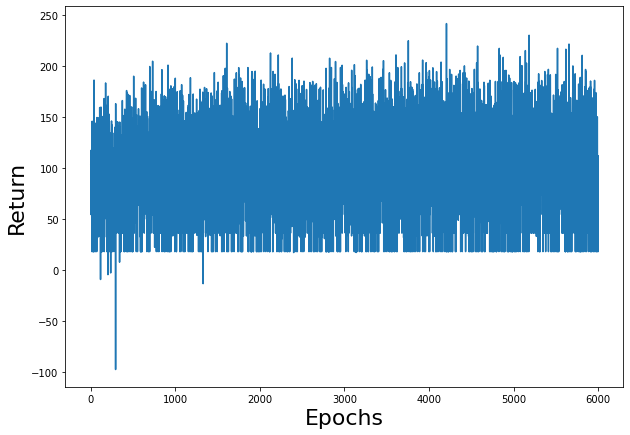

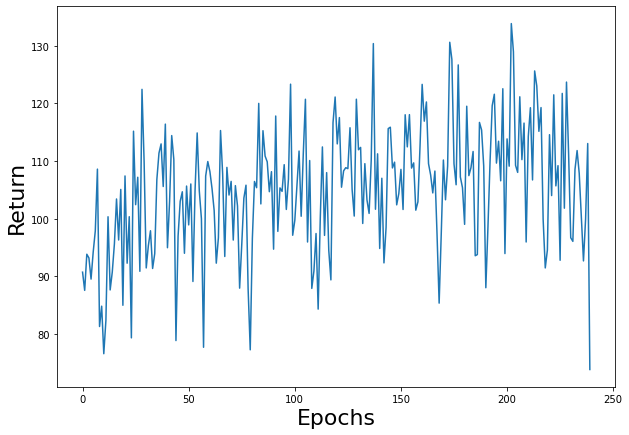

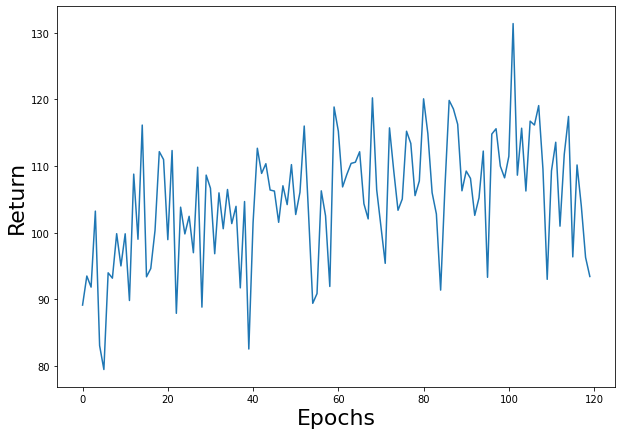

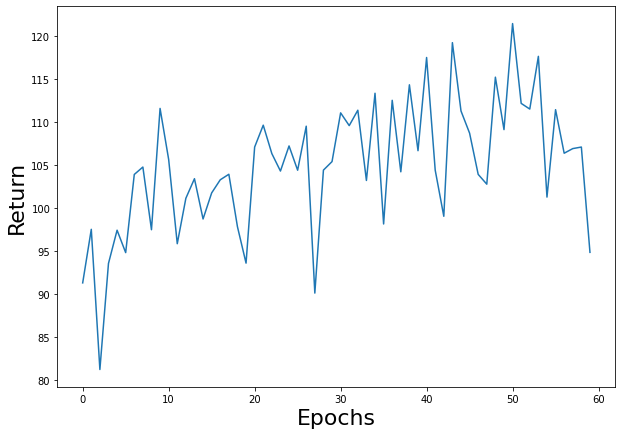

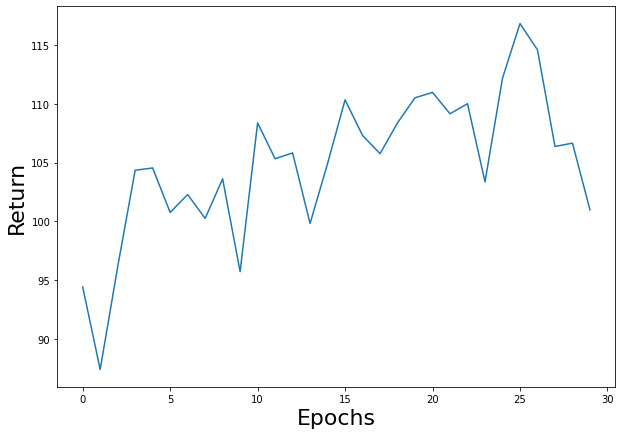

In [ ]:
total_rewards = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, action_dim, state_dim, hidden_dim):
        super(QNetwork, self).__init__()

        self.fc_1 = nn.Linear(845, 1500)
        self.fc_2 = nn.Linear(1500, 700)
        self.fc_3 = nn.Linear(700, 200)
        self.fc_4 = nn.Linear(200, action_dim)

    def forward(self, inp):

        x1 = F.leaky_relu(self.fc_1(inp))
        x1 = F.leaky_relu(self.fc_2(x1))
        x1 = F.leaky_relu(self.fc_3(x1))
        x1 = self.fc_4(x1)

        return x1

class Memory:
    def __init__(self, len):
        self.rewards = collections.deque(maxlen=len)
        self.state = collections.deque(maxlen=len)
        self.action = collections.deque(maxlen=len)
        self.is_done = collections.deque(maxlen=len)

    def update(self, state, action, reward, done):
        # if the episode is finished we do not save to new state. Otherwise we have more states per episode than rewards
        # and actions whcih leads to a mismatch when we sample from memory.
        if not done:
            self.state.append(state)
        self.action.append(action)
        self.rewards.append(reward)
        self.is_done.append(done)

    def sample(self, batch_size):
        """
        sample "batch_size" many (state, action, reward, next state, is_done) datapoints.
        """
        n = len(self.is_done)
        idx = random.sample(range(0, n-1), batch_size)

        return torch.Tensor(self.state)[idx].to(device), torch.LongTensor(self.action)[idx].to(device), \
               torch.Tensor(self.state)[1+np.array(idx)].to(device), torch.Tensor(self.rewards)[idx].to(device), \
               torch.Tensor(self.is_done)[idx].to(device)

    def reset(self):
        self.rewards.clear()
        self.state.clear()
        self.action.clear()
        self.is_done.clear()


def select_action(model, env, state, eps):
    _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, 845)
    state = _state.to(device)
    
    with torch.no_grad():
        values = model(state)

    # select a random action wih probability eps
    if random.random() <= eps:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(values.cpu().numpy())

    return action


def train(batch_size, current, target, optim, memory, gamma):

    states, actions, next_states, rewards, is_done = memory.sample(batch_size)
    
    _states = states.reshape(256, 845)
    _next_states = next_states.reshape(256, 845)

    q_values = current(_states)

    next_q_values = current(_next_states)
    next_q_state_values = target(_next_states)

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = rewards + gamma * next_q_value * (1 - is_done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()


def evaluate(Qmodel, env, repeats):
    """
    Runs a greedy policy with respect to the current Q-Network for "repeats" many episodes. Returns the average
    episode reward.
    """
    Qmodel.eval()
    perform = 0
    for _ in range(repeats):
        state = env.reset()
        done = False
        while not done:
            _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, 845).to(device)
            with torch.no_grad():
                values = Qmodel(_state)
            action = np.argmax(values.cpu().numpy())
            state, reward, done, _ = env.step(action)
            perform += reward
    Qmodel.train()
    return perform/repeats

def update_parameters(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())


def main(gamma=0.99, lr=1e-3, min_episodes=2, eps=1, eps_decay=0.995, eps_min=0.01, update_step=50, batch_size=256, update_repeats=16,
         num_episodes=6000, seed=42, max_memory_size=500000, lr_gamma=0.9, lr_step=100, measure_step=1,
         measure_repeats=1, hidden_dim=160, env_name='DRL_Mininet-v0', cnn=False, horizon=np.inf, render=False, render_step=50):
    
    global total_rewards
    """
    :param gamma: reward discount factor
    :param lr: learning rate for the Q-Network
    :param min_episodes: we wait "min_episodes" many episodes in order to aggregate enough data before starting to train
    :param eps: probability to take a random action during training
    :param eps_decay: after every episode "eps" is multiplied by "eps_decay" to reduces exploration over time
    :param eps_min: minimal value of "eps"
    :param update_step: after "update_step" many episodes the Q-Network is trained "update_repeats" many times with a
    batch of size "batch_size" from the memory.
    :param batch_size: see above
    :param update_repeats: see above
    :param num_episodes: the number of episodes played in total
    :param seed: random seed for reproducibility
    :param max_memory_size: size of the replay memory
    :param lr_gamma: learning rate decay for the Q-Network
    :param lr_step: every "lr_step" episodes we decay the learning rate
    :param measure_step: every "measure_step" episode the performance is measured
    :param measure_repeats: the amount of episodes played in to asses performance
    :param hidden_dim: hidden dimensions for the Q_network
    :param env_name: name of the gym environment
    :param cnn: set to "True" when using environments with image observations like "Pong-v0"
    :param horizon: number of steps taken in the environment before terminating the episode (prevents very long episodes)
    :param render: if "True" renders the environment every "render_step" episodes
    :param render_step: see above
    :return: the trained Q-Network and the measured performances
    """
    env = RoutingEnv()
    torch.manual_seed(seed)
    env.seed(seed)

    if cnn:
        Q_1 = QNetwork(action_dim=env.action_space.n).to(device)
        Q_2 = QNetwork(action_dim=env.action_space.n).to(device)
    else:
        Q_1 = QNetwork(action_dim=env.action_space.n, state_dim=env.observation_space.shape[0],
                                        hidden_dim=hidden_dim).to(device)
        Q_2 = QNetwork(action_dim=env.action_space.n, state_dim=env.observation_space.shape[0],
                                        hidden_dim=hidden_dim).to(device)
    # transfer parameters from Q_1 to Q_2
    update_parameters(Q_1, Q_2)

    # we only train Q_1
    for param in Q_2.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(Q_1.parameters(), lr=lr)
    optimizer.step()
    scheduler = StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

    memory = Memory(max_memory_size)
    performance = []

    for episode in range(num_episodes):
        # display the performance
        if episode % measure_step == 0:
            performance.append([episode, evaluate(Q_1, env, measure_repeats)])
            print("Episode: ", episode)
            print("rewards: ", performance[-1][1])
            total_rewards.append(performance[-1][1])
            print("lr: ", scheduler.get_last_lr()[0])
            print("eps: ", eps)

        state = env.reset()
        # _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1,320)
        memory.state.append(state.reshape(1, 845))

        done = False
        i = 0
        while not done:
            i += 1
            action = select_action(Q_2, env, state, eps)
            state, reward, done, _ = env.step(action)
            
            # _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1,320)

            if i > horizon:
                done = True

            # render the environment if render == True
            if render and episode % render_step == 0:
                env.render()

            # save state, action, reward sequence
            memory.update(state.reshape(1, 845), action, reward, done)

        if episode >= min_episodes and episode % update_step == 0:
            for _ in range(update_repeats):
                train(batch_size, Q_1, Q_2, optimizer, memory, gamma)

            # transfer new parameter from Q_1 to Q_2
            update_parameters(Q_1, Q_2)

        # update learning rate and eps
        scheduler.step()
        eps = max(eps*eps_decay, eps_min)

    print(performance)
    return Q_1, performance

Q_1, performance = main()
torch.save(Q_1.state_dict(), "ddqn_model_16_random_requests")
print(total_rewards)
print("Plotting rewards...")
plt.figure(figsize=(10,7))
plt.plot(total_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Return",fontsize=22)
plt.savefig('avg_return.png')

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(total_rewards), size):
        avg += [sum(val for val in total_rewards[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

# **Distribuitional DQN with Prioritized Experience Replay**

<BarContainer object of 201 artists>

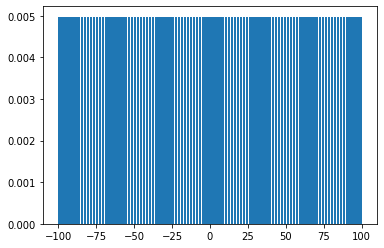

In [ ]:
vmin, vmax = -100., 100.
nsup = 201
support = np.linspace(vmin,vmax,nsup)
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support,probs)

In [ ]:
def update_dist(r, support, probs, lim=(-100.,100.), gamma=0.8):
    nsup = probs.shape[0]
    dz = (vmax-vmin)/(nsup-1.)
    bj = np.round((r-vmin)/dz)
    bj = int(np.clip(bj, 0, nsup-1))
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj, nsup -1, 1):
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum()
    return m

In [ ]:
def dist_dqn(x, theta, aspace=5):
    dim0, dim1, dim2, dim3 = 845, 250, 100, 201
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    theta1 = theta[0:t1].reshape(dim0, dim1)
    theta2 = theta[t1:t1 + t2].reshape(dim1, dim2)
    l1 = x @ theta1
    l1 = torch.selu(l1)
    l2 = l1 @ theta2
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2, dim3)
        l3_ = l2 @ theta5
        l3.append(l3_)
    l3 = torch.stack(l3, dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [ ]:
def lossfn(x, y):
    loss = torch.Tensor([0.])
    loss.requires_grad = True
    for i in range(x.shape[0]): 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

In [ ]:
def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-100,100), gamma=0.8):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else:
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
        target_dist_batch[i,action,:] = target_dist
        
    return target_dist_batch

In [ ]:
def preproc_state(state):
    p_state = torch.from_numpy(state.astype(np.float32)).unsqueeze(dim=0)
    p_state = torch.nn.functional.normalize(p_state, dim=1)
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [ ]:
import gym
from collections import deque
env = RoutingEnv()
aspace = 5

vmin, vmax = -100, 100
replay_size = 50000
batch_size = 256
nsup = 201
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,  vmax,nsup)

replay = deque(maxlen=replay_size)
lr = 0.0001 
gamma = 0.1
epochs = 4000
eps = 0.50
eps_min = 0.05
priority_level = 5
update_freq = 64

tot_params = 845*250 + 100*250 + aspace*100*201 
theta = torch.randn(tot_params)/100.
theta.requires_grad = True
theta_2 = theta.detach().clone()

losses = []
cum_rewards = []
renders = []
state = preproc_state(env.reset())

Epoch: 0, Reward: 18.153846153846153
Epoch: 1, Reward: 18.153846153846153
Epoch: 2, Reward: 14.224852071005918
Epoch: 3, Reward: 12.721893491124261
Epoch: 4, Reward: 12.402366863905325
Epoch: 5, Reward: 12.153846153846153
Epoch: 6, Reward: 8.224852071005918
Epoch: 7, Reward: 5.313609467455621
Epoch: 8, Reward: 4.402366863905326
Epoch: 9, Reward: 3.4911242603550297
Epoch: 10, Reward: 3.4911242603550297
Epoch: 11, Reward: -0.1893491124260355
Epoch: 12, Reward: -0.5443786982248521
Epoch: 13, Reward: -1.7514792899408285
Epoch: 14, Reward: -3.337278106508876
Epoch: 15, Reward: -4.1301775147929
Epoch: 16, Reward: 18.153846153846153
Epoch: 17, Reward: 15.065088757396449
Epoch: 18, Reward: 13.337278106508876
Epoch: 19, Reward: 13.005917159763314
Epoch: 20, Reward: 11.928994082840237
Epoch: 21, Reward: 11.431952662721894
Epoch: 22, Reward: 11.195266272189349
Epoch: 23, Reward: 10.08284023668639
Epoch: 24, Reward: 4.106508875739645
Epoch: 25, Reward: 4.106508875739645
Epoch: 26, Reward: 3.644970

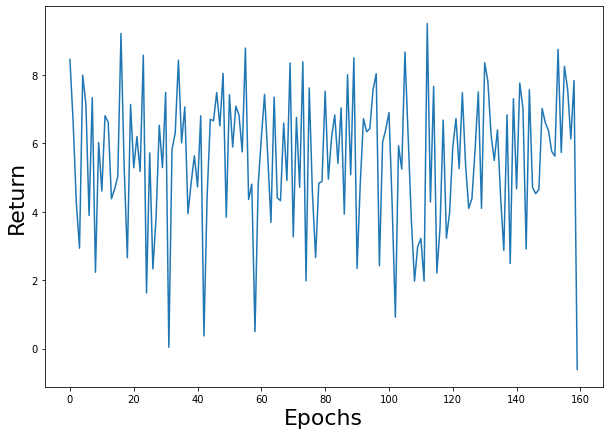

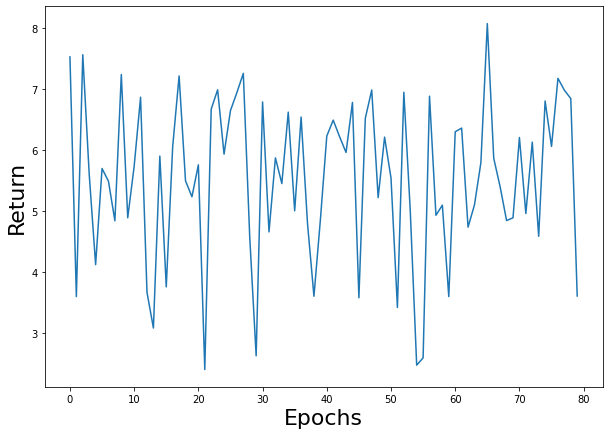

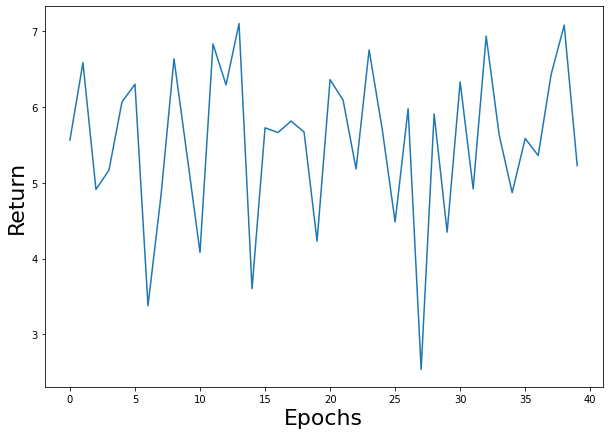

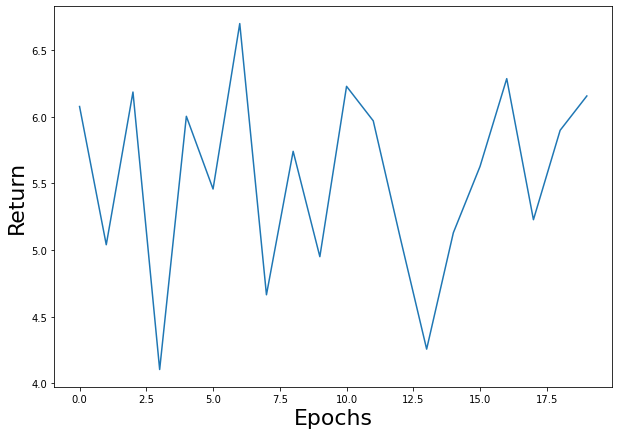

In [ ]:
from random import shuffle
for i in range(epochs):
    pred = dist_dqn(state.reshape(1, 845), theta, aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    state2, reward, done, info = env.step(action)
    print("Epoch: {}, Reward: {}".format(i, reward))
    state2 = preproc_state(state2)
    cum_rewards.append(reward) 
    exp = (state, action, reward, state2)
    replay.append(exp)
    
    if reward > 0:
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach().reshape(batch_size, 845), theta, aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach().reshape(batch_size, 845), theta_2, aspace=aspace)
        target_dist = get_target_dist(pred2_batch, action_batch, reward_batch, \
                                     support, lim=(vmin,vmax), gamma=gamma)
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0:
        theta_2 = theta.detach().clone()
        
    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done:
        state = preproc_state(env.reset())
        done = False

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(cum_rewards), size):
        avg += [sum(val for val in cum_rewards[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

# **Dueling DQN**

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(845, 1500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1500, 700)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(700, 200)
        self.fc_adv = nn.Linear(700, 200)

        self.value = nn.Linear(200, 1)
        self.adv = nn.Linear(200, 5)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        y = self.relu(self.fc2(y))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = RoutingEnv()
n_state = 845
n_action = 5

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.5
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 256

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
begin_learn = False

episode_reward = 0
total_rewards = []

for epoch in range(3000):
    state = env.reset()
    _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, n_state)
    episode_reward = 0
    for time_steps in range(200):
        p = random.random()
        if p < epsilon:
            action = random.randint(0, n_action-1)
        else:
            tensor_state = _state.to(device)
            action = onlineQNetwork.select_action(tensor_state)
        next_state, reward, done, _ = env.step(action)
        _next_state = torch.flatten(torch.from_numpy(next_state.astype(np.float32))).reshape(1, n_state)
        print(_next_state)
        episode_reward += reward
        memory_replay.add((_state, _next_state, action, reward, done))
        if memory_replay.size() > 256:
            if begin_learn is False:
                print('learn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.cat([item for item in batch_state]).to(device)
            batch_next_state = torch.cat([item for item in batch_next_state]).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                onlineQ_next = onlineQNetwork(batch_next_state)
                targetQ_next = targetQNetwork(batch_next_state)
                online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            total_rewards.append(episode_reward)
            break
        _state = next_state

    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'ddqn-policy')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))
print(total_rewards)

A saída de streaming foi truncada nas últimas 5000 linhas.
           1.,   1.,   1., 100., 100., 100., 100., 100., 100., 100.,  85.,  85.,
          85., 100., 100.,  85.,  85.,  85., 100., 100., 100., 100.,  85., 100.,
          85.,  85.,  85.,  85., 100.,  85.,  85.,  85.,  85., 100., 100., 100.,
          85.,  85., 100.,  85.,  85.,  85.,  85., 100., 100., 100., 100., 100.,
         100.,  85.,  85.,  85.,  85., 100., 100., 100., 100., 100., 100.,  85.,
          85.,  85.,  85., 100., 100., 100., 100.,  85., 100.,   1.,   1.,   1.,
           1., 100., 100., 100.,  85.,  85., 100., 100.,  85.,  85.,  85., 100.,
         100.,  85.,  85.,  85., 100.,  85.,  85.,  85.,  85., 100., 100.,  85.,
          85.,  85., 100., 100., 100.,  85.,  85., 100.,  85.,  85.,  85.,  85.,
         100., 100.,  85.,  85.,  85., 100.,  85.,  85.,  85.,  85., 100., 100.,
         100.,  85.,  85., 100.,  85.,  85.,  85.,  85., 100.,  85.,  85.,  85.,
          85., 100., 100., 100.,  85.,  85., 100.,

KeyboardInterrupt: ignored

# **Comparing agents**

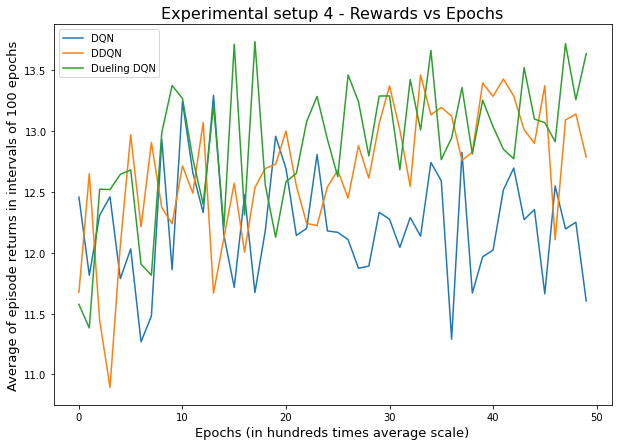

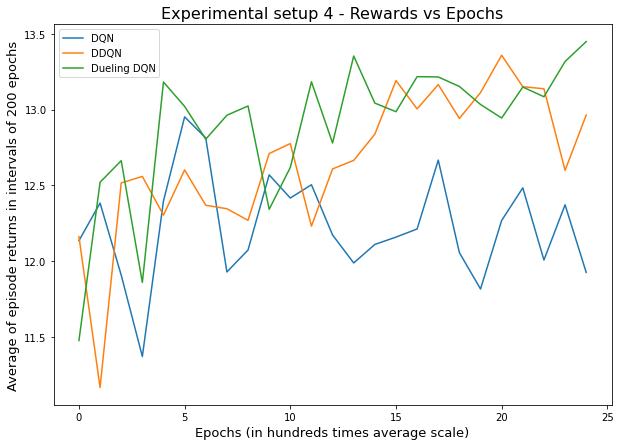

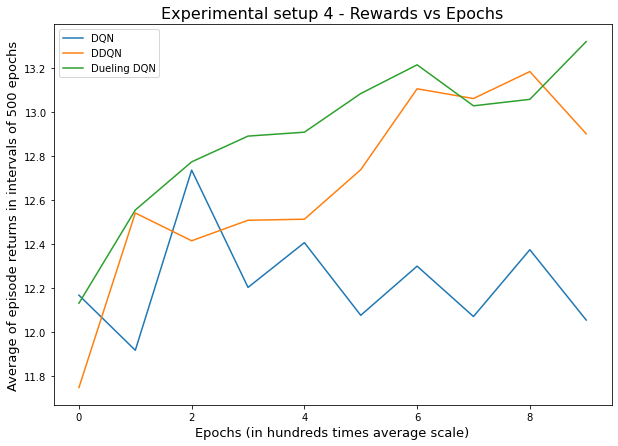

In [ ]:
sizes = [100, 200, 500]
dqn = [10.937278106508876, 9.759932375316989, 14.031558185404338, 9.045364891518737, 14.789940828402367, 12.650887573964496, 16.375739644970416, 8.494411571334648, 10.919849381387843, 15.301775147928995, 17.4792899408284, 6.79526627218935, 4.82130177514793, 14.358974358974356, 11.781603012372242, 11.32189349112426, 7.993627674101047, 6.150887573964496, 13.115384615384615, 14.55621301775148, 16.236686390532544, 11.522189349112427, 17.13609467455621, 18.153846153846153, 8.79881656804734, 10.866272189349113, 17.19921104536489, 17.30887573964497, 18.153846153846153, 2.0875739644970412, 12.325443786982248, 17.36568047337278, 9.156607495069032, 8.442941673710907, 14.346153846153845, 15.609467455621301, 13.705456936226167, 16.057199211045365, 17.13609467455621, 15.824852071005918, 16.11834319526627, 14.97041420118343, 12.137573964497042, 9.605029585798816, 8.862919132149901, 12.446153846153846, 9.585798816568047, 6.751479289940829, 15.469822485207102, 18.153846153846153, 16.846153846153847, 9.289030496131089, 11.572273879966188, 11.671794871794873, 7.87130177514793, 14.434911242603551, 15.607495069033531, 15.48165680473373, 14.059171597633135, 9.324260355029585, 10.865384615384617, 7.0828402366863905, 8.698224852071005, 9.63905325443787, 11.08777120315582, 17.528994082840235, 9.928994082840237, 7.3560157790927025, 18.153846153846153, 10.292307692307693, 5.93767258382643, 14.625528317836011, 18.153846153846153, 18.153846153846153, 13.945562130177514, 16.99112426035503, 18.153846153846153, 11.516483516483516, 9.161735700197239, 9.479289940828403, 6.058261265361858, 11.462524654832345, 9.338067061143986, 12.863905325443787, 10.044606281292673, 7.032813340505647, 11.446517979062355, 14.593406593406593, 9.481656804733728, 11.402366863905327, 11.964497041420117, 14.548323471400396, 15.796449704142013, 16.189349112426036, 9.456804733727811, 13.847633136094673, 18.153846153846153, 9.772416932180244, 9.020381328073633, 18.153846153846153, 7.604395604395606, 11.158579881656804, 12.6758711374096, 11.058326289095522, 10.211834319526625, 11.00887573964497, 12.355029585798817, 9.129783037475349, 10.21392808375057, 9.701990317374932, 18.153846153846153, 15.301775147928993, 10.426035502958579, 6.161453930684702, 5.873372781065089, 9.857077833409194, 12.643491124260354, 17.263313609467456, 18.153846153846153, 12.463905325443788, 15.299408284023668, 10.585141354372123, 7.297041420118342, 14.87179487179487, 16.256410256410255, 4.894336432797973, 12.014792899408285, 12.852071005917159, 18.153846153846153, 11.410913872452333, 13.445266272189349, 10.312243969048701, 6.667273554847519, 11.020482476103776, 9.267962806424345, 15.908284023668639, 18.153846153846153, 18.153846153846153, 8.077909270216962, 3.3364891518737663, 10.741617357001973, 0.9491124260355033, 13.259697567389875, 7.1149619611158075, 10.840236686390533, 17.366863905325445, 8.370414201183433, 11.932149901380672, 7.999211045364889, 15.21301775147929, 15.879289940828402, 12.290786136939982, 9.63683431952663, 16.13609467455621, 18.153846153846153, 8.074387151310228, 16.076923076923077, 10.057199211045363, 12.673372781065087, 15.502958579881657, 10.098619329388562, 18.153846153846153, 15.404339250493097, 9.269428007889548, 4.945054945054945, 12.534516765285996, 11.523668639053252, 11.384615384615383, 11.370414201183433, 12.69378698224852, 3.5576923076923066, 11.752662721893492, 6.673710904480136, 18.153846153846153, 6.316795630405098, 5.293322062552833, 0.95773457311919, 12.696909927679158, 13.274725274725276, 7.5207100591715985, 8.073736913973601, 7.744716821639898, 17.13609467455621, 10.606180144641684, 18.153846153846153, 9.42800788954635, 11.922090729783038, 17.002958579881657, 13.446153846153845, 18.153846153846153, 18.153846153846153, 16.255621301775147, 3.036982248520709, 17.23786982248521, 15.702169625246547, 14.076265614727152, 18.153846153846153, 10.60223537146614, 8.393263541192532, 17.059171597633135, 9.270216962524653, 8.82603550295858, 17.062130177514792, 11.30440499671269, -6.142011834319527, 8.482051282051284, 14.72189349112426, 5.975542406311636, 7.878429263044646, 16.76923076923077, 13.519864750633982, 11.068047337278106, 9.96618765849535, 11.658495350803042, 18.153846153846153, 10.724260355029587, 16.316568047337277, 16.889940828402366, 15.420118343195266, 18.153846153846153, 15.23076923076923, 11.599605522682447, 16.189349112426036, 15.68639053254438, 14.071005917159766, 10.684911242603551, 12.982248520710058, 10.155536770921387, 12.17075232459848, 14.949704142011834, 11.914792899408283, 18.153846153846153, 14.515976331360946, 11.184615384615384, 0.3688362919132153, 6.829388560157789, 18.153846153846153, 2.5279927173418297, 10.674556213017752, 16.796844181459566, 10.727272727272728, 13.35568704799474, 18.153846153846153, 14.11439842209073, 13.266272189349111, 6.879437869822484, 16.497041420118343, 6.926718252162039, 7.378040762656148, 11.465976331360949, 17.029585798816566, 9.173288250211327, 12.706831629908555, 15.923076923076923, 4.932692307692308, 10.417159763313608, 15.947590870667794, 14.96094674556213, 13.221893491124261, 18.153846153846153, 11.56094674556213, 7.203719357565513, 14.598816568047338, 17.581065088757395, 7.342011834319526, 7.674101046882114, 10.97125950972105, 11.128698224852071, 8.833333333333332, 16.796844181459566, 15.486686390532544, 7.591321499013809, 15.379881656804734, 12.976331360946746, 7.12189349112426, 15.244294167371093, 10.707328174783799, 16.736686390532544, 6.168908015061861, 18.153846153846153, 13.702662721893493, 11.46508875739645, 12.632598171059708, 15.884023668639053, 12.707100591715976, 15.43702451394759, 18.153846153846153, 8.278500986193295, 11.939349112426035, 18.153846153846153, 18.153846153846153, 16.844181459566073, 7.383826429980275, 16.36489151873767, 5.949704142011835, 5.168866636322257, 15.659171597633133, 10.05701990317375, 14.589349112426035, 10.932759548144164, 16.118343195266274, 7.981508875739645, 17.339644970414202, 9.379236148466916, 11.792054099746405, 13.785667324128863, 9.806424344885881, 8.412228796844182, 18.153846153846153, 13.909763313609467, 16.054437869822486, 14.994082840236686, 13.447731755424062, 15.400394477317555, 18.153846153846153, 13.367401828940288, 16.814201183431955, 9.80957504034427, 18.153846153846153, 16.027613412228796, 13.481656804733728, 9.482020937642242, 13.6140191169777, 14.16568047337278, 14.426035502958577, 13.038461538461538, 10.469428007889544, 2.6855452240067637, 11.836686390532545, 16.796844181459566, 12.457235072619685, 8.288461538461538, 11.778375470683162, 16.305325443786984, 18.153846153846153, 3.291420118343198, 7.061447428311334, 13.583826429980276, 14.031558185404338, 12.204142011834321, 6.455226824457592, 4.9171597633136095, 14.06508875739645, 18.153846153846153, 14.473372781065088, 11.745562130177516, 14.80473372781065, 12.621301775147929, 15.048182586644124, 5.337278106508876, 13.541842772612005, 11.462721893491127, 4.004930966469428, 13.394082840236685, 15.532544378698226, 14.259040105193952, 8.002730996813838, 9.342349957734573, 13.26153846153846, 18.153846153846153, 16.081360946745562, 9.87869822485207, 11.258382642998027, 18.153846153846153, 14.530853761622993, 11.31576116191501, 10.767915844838921, 4.605128205128206, 9.275954814416353, 16.4792899408284, 5.578895463510848, 10.79585798816568, 14.112426035502958, 9.530268548020027, 12.784615384615385, 9.097210481825867, 8.506656804733728, 17.629191321499015, 7.507396449704142, 12.65680473372781, 15.046153846153846, 8.80078895463511, 13.541420118343197, 8.092522861753634, 8.540433925049308, 13.209467455621303, 9.036040882194728, 15.19526627218935, 14.16398985629755, 16.59171597633136, 15.530008453085376, 6.408284023668639, 17.215976331360945, 18.153846153846153, 12.428994082840237, 18.153846153846153, 17.04437869822485, 13.97337278106509, 4.989644970414202, 14.736686390532544, 9.520052596975674, 0.21665908056440752, 14.8094674556213, 13.562130177514794, 14.977176669484365, 15.69526627218935, 9.21555367709214, 11.81301775147929, 5.956889264581572, 13.233727810650889, 0.8305540613232929, 14.603550295857989, 14.34319526627219, -7.756656804733727, 8.932375316990703, 4.379543533389687, 15.892011834319527, 12.978867286559595, 16.41025641025641, 14.778698224852072, 12.345825115055886, 11.556213017751482, 11.192636423405654, 12.493491124260355, 9.910397295012679, 10.70611439842209, 8.12386587771203, 8.613563950842059, 14.042899408284024, 10.060650887573967, 18.153846153846153, 10.471682163989856, 10.109467455621301, 10.616699539776464, 15.439842209072978, 11.69723865877712, 11.67455621301775, 13.508875739644969, 14.732248520710058, 13.659434582511505, 15.439842209072978, 12.159763313609467, 11.337278106508876, 18.153846153846153, 16.72189349112426, 10.618612157073695, 15.627218934911243, 16.023668639053255, 9.834319526627217, 10.67455621301775, 15.816568047337277, 5.689940828402369, 13.911242603550296, 14.842603550295859, 10.335305719921104, 9.82755705832629, 12.40691852526172, 9.699211045364889, 11.261200338123416, 16.62721893491124, 13.875739644970414, 12.841715976331363, 18.153846153846153, 8.001577909270216, 18.153846153846153, 16.189349112426036, 15.126232741617358, 6.642694583522986, 10.25904010519395, 12.994082840236688, 9.564760026298487, 14.49273803119957, 15.022823330515637, 12.24852071005917, 12.523339907955295, 7.852608929532009, 9.648520710059172, 10.49977241693218, 10.988703604088219, 8.451524806554392, 18.153846153846153, 8.695266272189349, 8.42857142857143, 7.65483234714004, 16.16568047337278, 13.0387902695595, 15.31755424063116, 13.863905325443787, 7.457311918850382, 8.409023668639053, 9.558579881656806, 14.516765285996053, 11.502958579881659, 12.625528317836011, 10.612157073695538, 8.467455621301774, 10.70808678500986, 8.261143984220908, 13.115384615384613, 18.153846153846153, 10.497041420118343, 15.781065088757398, 16.828402366863905, 11.464497041420117, 6.0246548323471405, 15.8698224852071, 3.6148466917697695, 15.031065088757396, 15.180473372781066, 12.198553583168964, 18.153846153846153, 5.588757396449704, 16.72189349112426, 14.523076923076925, 11.106508875739644, 9.999999999999998, 13.707100591715976, 12.611439842209075, 10.94459386767079, 14.712426035502958, 11.245562130177515, 11.00887573964497, 12.203155818540433, 11.102282333051566, 9.125105663567204, 18.153846153846153, 4.113791533909876, 10.915187376725838, 10.861275476660094, 15.57593688362919, 18.153846153846153, 14.285502958579883, 18.153846153846153, 7.5325443786982245, 7.654073736913974, 8.18343195266272, 10.126536185707785, 13.631656804733728, 10.706508875739646, 9.190714610832957, 7.899863450159308, 8.291124260355032, 12.120033812341505, 6.086538461538461, 12.884615384615383, 16.050295857988164, 15.08639053254438, 9.84108199492815, 15.816568047337277, 11.053254437869823, 11.303747534516766, 3.0414201183431957, 12.122287968441814, 8.682087143625605, 14.993006993006992, 12.700197238658774, 8.586982248520709, 12.726331360946743, 15.439842209072978, 15.136094674556212, 18.153846153846153, 16.043392504930967, -0.03920118343195256, 5.820266272189351, 9.07889546351085, 10.548816568047338, 12.958579881656805, 16.796844181459566, 18.153846153846153, 9.646046261430879, 4.817554240631163, 8.472386587771204, 18.153846153846153, 16.386587771203157, 5.729388560157791, 13.319526627218934, 12.712031558185402, 10.314792899408284, 18.153846153846153, 9.940828402366863, 18.153846153846153, 9.741124260355033, 12.331360946745562, 11.22603550295858, 18.153846153846153, 18.153846153846153, 18.153846153846153, 13.947590870667792, 17.372781065088756, 17.19921104536489, 15.958579881656805, 9.551610782380012, 13.802761341222881, 17.437869822485208, 6.276415891800507, 7.4974358974358974, 6.732037193575656, 9.136094674556212, 9.896872358410821, 4.983037475345167, 11.529585798816568, 9.092307692307692, 11.004602235371465, 5.685996055226824, 17.166863905325442, 9.172583826429982, 5.370414201183433, 12.544378698224852, 14.307692307692307, 4.961310878470643, 2.950690335305721, 18.153846153846153, 13.559171597633137, 17.171597633136095, 15.91715976331361, 6.645627876397106, 10.570199031737493, 10.04733727810651, 9.364102564102563, 12.366863905325445, 12.667455621301775, 11.477975016436554, 13.712031558185403, 18.153846153846153, 14.156804733727812, 9.992899408284025, 9.399079552925706, 16.03786982248521, 14.276923076923078, 9.056952662721894, 9.586644125105662, -2.643491124260356, 2.203813280736356, 12.501479289940827, 10.47337278106509, 15.420118343195266, 18.153846153846153, 11.229783037475343, 14.676528599605524, 12.26232741617357, 17.002958579881657, 10.214003944773172, 14.32967032967033, 11.524936601859679, 11.498520710059172, 9.17920540997464, 10.372243141473911, 5.28698224852071, 8.01025641025641, 10.815384615384616, 18.153846153846153, 16.04930966469428, 11.965811965811964, 5.318343195266272, 15.011176857330701, 16.796844181459566, 15.696252465483234, 9.453800637232591, 4.923816568047338, 12.410256410256412, 11.169230769230769, 16.796844181459566, 17.17751479289941, 8.061323292092524, 13.571005917159763, 18.153846153846153, 10.33674018289403, 11.625528317836013, 12.305325443786984, 16.6094674556213, 6.8148774302620465, 10.430769230769231, 13.372781065088756, 12.489940828402368, 10.581360946745564, 4.394970414201183, 16.674556213017752, 8.859171597633136, 10.261834319526628, 7.804339250493096, 7.096040054619938, 12.370808678500985, 18.153846153846153, 2.1913214990138066, 2.8934911242603536, 9.613412228796843, 14.972781065088757, 10.334091943559399, 9.652501344809036, 9.114116652578192, 17.13609467455621, 5.785906401291017, 8.062130177514794, 15.684418145956608, 7.02465483234714, 5.443786982248519, 12.733727810650887, 6.927810650887574, 13.962806424344887, 15.77120315581854, 18.153846153846153, 15.076923076923077, 8.548682087143625, 10.534911242603552, 11.903504779244424, 1.9365250134480898, 14.603550295857987, 8.163989856297551, 13.770076077768387, 14.309382924767542, 18.153846153846153, 16.844181459566073, 16.95266272189349, 5.138825671370049, 8.95311788802913, 14.64562787639711, 8.1474738279472, 15.820118343195265, 9.664694280078894, 14.181459566074947, 15.127218934911244, 0.6295857988165681, 18.153846153846153, 18.153846153846153, 10.360289283366207, 14.718934911242602, 11.725838264299803, 12.349112426035502, 11.14147391070468, 5.824852071005916, 15.77810650887574, 6.921499013806708, 13.25887573964497, 8.754168908015062, 14.10059171597633, 9.779092702169626, 12.339814032121726, 6.17075232459848, 8.918773534158149, 9.530177514792902, 11.013448090371167, 13.363576594345826, 18.153846153846153, 18.153846153846153, 10.301775147928996, 8.59171597633136, 15.745562130177515, 18.153846153846153, 7.453930684699914, 6.1272189349112445, 8.918005071851226, 12.136094674556212, 7.937869822485207, 18.153846153846153, 5.444773175542407, 5.666948436179205, 12.076923076923078, 14.881656804733728, 8.837278106508874, 15.976331360946746, 13.727810650887575, 6.500591715976331, 16.34319526627219, 18.153846153846153, 14.911242603550297, 15.00161377084454, 15.538461538461538, 10.504437869822484, 15.621301775147927, 18.153846153846153, 7.120033812341506, 7.230029585798816, 7.263736263736265, 13.315300084530854, 12.795051102743408, 18.153846153846153, 8.691650230111767, 13.474358974358978, 14.507185122569737, 9.288461538461538, 18.153846153846153, 5.062937062937063, 13.733727810650887, 7.314924391847468, 17.422090729783037, 7.271449704142011, 11.623931623931623, 14.232741617357, 8.358670914883932, 5.332544378698225, 5.2595097210481825, 2.3801775147928987, 5.902789518174133, 8.293885601577905, 9.152232383001612, 11.688004303388919, -5.105325443786982, 15.207100591715976, 12.339250493096646, 11.795857988165679, 13.173076923076923, 11.84319526627219, 7.722633136094674, 6.236686390532542, 10.63905325443787, 12.666666666666666, 18.153846153846153, 4.136094674556214, 18.153846153846153, 8.995069033530571, 17.00887573964497, 9.601577909270217, 8.751873767258383, 11.983727810650889, 12.67603550295858, 10.875739644970412, 2.613412228796845, 8.495463510848127, 16.76923076923077, 18.153846153846153, 15.65285996055227, 13.913214990138068, 11.564497041420118, 12.884842967683205, 9.723865877712031, 18.153846153846153, 14.054099746407442, 1.2761341222879687, 9.629437869822482, 7.9499317250796535, 13.31360946745562, 11.061143984220909, 14.735042735042734, 18.153846153846153, 12.786136939983091, 13.990138067061146, 7.6659080564406015, 15.067455621301775, 16.59171597633136, 14.49112426035503, 12.643786982248523, 14.289940828402365, 6.732938856015779, 14.402366863905325, 14.943786982248518, 7.012289485662267, 15.402366863905325, 18.153846153846153, 14.973372781065088, 15.713017751479288, 18.153846153846153, 10.85207100591716, 16.682445759368836, 10.915794264906694, 11.726331360946746, 8.5207100591716, 15.439842209072978, 11.971597633136096, 12.54733727810651, 15.49788672865596, 13.973701512163048, 18.153846153846153, 7.546069315300086, 10.131253362022592, 8.895181741335586, 11.14792899408284, 16.287968441814595, 8.263736263736265, 17.071005917159763, 14.524654832347139, 8.60462614308768, 16.244575936883628, 14.209072978303748, 18.153846153846153, 18.153846153846153, 10.106508875739644, 16.548323471400394, 16.844181459566073, 16.59171597633136, 13.469428007889546, 13.500000000000002, 13.196581196581196, 13.418427726120035, 4.496196111580726, 13.748520710059173, 11.182521620391444, 12.43639053254438, 18.153846153846153, 14.263736263736265, 9.448520710059173, 9.758579881656804, 18.153846153846153, 18.153846153846153, 11.974358974358974, 16.11834319526627, 18.153846153846153, 18.153846153846153, 10.769230769230768, 13.669953977646284, 11.885038038884195, 10.774408284023671, 17.437869822485208, 0.6256410256410261, 13.189349112426036, 7.852810650887576, 11.638067061143982, 13.717455621301774, 17.01301775147929, 13.011834319526626, 16.59171597633136, 15.371301775147927, 10.00645508337816, 4.246548323471401, 14.74852071005917, 8.734638142922167, 15.857988165680474, 17.021696252465482, 18.153846153846153, 18.153846153846153, 8.384615384615385, 12.707100591715978, 7.504536489151875, 13.838622915545994, 14.872781065088757, 6.472296933835396, 9.473372781065091, 2.022879684418146, 9.983093829247677, 9.409129332206257, 16.189349112426036, 9.81508875739645, 18.153846153846153, 8.56258534365043, 7.541689080150619, 10.86306001690617, 18.153846153846153, 14.358974358974358, 15.238658777120314, 18.153846153846153, 7.73318988703604, 8.608284023668638, 15.02958579881657, 14.949112426035501, 18.153846153846153, 18.153846153846153, 11.487482931269914, 13.369399830938292, 4.359763313609467, 13.788461538461538, 8.184418145956608, 8.902366863905325, 17.171597633136095, 8.100053792361484, 10.045118343195266, 10.384615384615385, 17.254437869822485, 15.439842209072978, 11.119526627218931, 7.594405594405593, 18.153846153846153, 8.740828402366866, 14.644970414201183, 11.410435718128026, 4.159225389994621, 8.153846153846155, 8.902635825712752, 11.98553583168968, 5.109270216962524, 6.527366863905327, 14.611439842209073, 7.192899408284023, 14.988165680473372, 13.00828402366864, 9.993096646942801, 11.51048951048951, 11.120710059171595, 5.997633136094674, 13.380670611439843, 17.437869822485208, 9.682840236686388, 7.937869822485207, 2.8599605522682436, 9.256258534365042, 18.153846153846153, 10.733727810650887, 18.153846153846153, 10.469428007889547, 16.85207100591716, 11.417159763313611, 9.64327979712595, 11.283485745024205, 14.38757396449704, 12.076265614727154, 10.10650887573964, 15.80473372781065, 9.531886916502302, 15.259171597633138, 17.236686390532544, 10.863905325443787, 11.739644970414203, 10.87869822485207, 15.122569737954352, 11.251056635672017, 10.824852071005918, 18.153846153846153, 15.226824457593686, 18.153846153846153, 14.877430262045646, 15.131022823330516, 11.893491124260356, 18.153846153846153, 9.872781065088759, 12.2926304464766, 17.424063116370807, 11.494082840236688, 8.03076923076923, 13.494674556213019, 17.02958579881657, 18.153846153846153, 18.153846153846153, 9.603550295857989, 9.669484361792053, 16.57199211045365, 18.153846153846153, 18.153846153846153, 12.397928994082841, 18.153846153846153, 15.662721893491124, 11.553677092138631, 14.08678500986193, 18.153846153846153, 6.728265817023215, 13.392504930966467, 18.153846153846153, 9.457988165680472, 13.526627218934909, 13.853254437869822, 14.178698224852072, 18.153846153846153, 18.153846153846153, 11.319526627218934, 15.283178360101438, 18.153846153846153, 16.59171597633136, 14.009467455621301, 9.63905325443787, 13.981065088757397, 4.871187983614018, 15.01775147928994, 11.190828402366865, 12.026298487836948, 10.606180144641684, 16.183431952662723, 16.83431952662722, 17.24023668639053, 18.153846153846153, 18.153846153846153, 11.063116370808677, 12.958579881656805, 9.08960270498732, 16.978303747534518, 13.25, 16.037869822485206, -3.9763313609467463, 18.153846153846153, 15.763313609467456, 14.347140039447732, 15.928994082840237, 5.514792899408285, 18.153846153846153, 11.876923076923077, 15.675739644970413, 7.988165680473371, 9.640532544378697, 18.153846153846153, 9.312130177514794, 14.555029585798819, 14.461538461538462, 10.825174825174823, 15.049309664694281, 13.96449704142012, 9.490048413125335, 16.5956607495069, 12.223668639053255, 12.579881656804734, 15.03747534516765, 12.64792899408284, 8.81979558902636, 17.13609467455621, 16.3629191321499, 4.645508337816029, 6.482248520710059, 4.89940828402367, 12.292476754015215, 12.644970414201183, 16.118343195266274, 9.255348202093765, 8.883022303140645, 2.455621301775148, 8.437869822485206, 14.566568047337277, 10.34427111350188, 16.47041420118343, 16.72189349112426, 8.844970414201182, 16.59171597633136, 13.347140039447734, 15.922231614539308, 13.893491124260354, 13.132713440405748, 16.159763313609467, 3.013199817933547, 10.164604626143086, 1.2130177514792901, 13.449704142011834, 14.88757396449704, 11.26183431952663, 15.207100591715978, 7.950972104818259, 10.57396449704142, 14.726627218934912, 14.506508875739645, 11.057199211045363, 14.925443786982248, 7.817023213472917, 16.796844181459566, 11.197417966648732, 13.495857988165682, 18.153846153846153, 14.765285996055225, 18.153846153846153, 18.153846153846153, 6.052716514254976, 11.143625605164065, 10.368836291913214, 8.635108481262327, 10.557396449704143, 7.915844838921762, 10.128205128205128, 14.672865595942518, 12.85207100591716, 14.125443786982249, 12.846153846153845, 9.933545744196632, 18.153846153846153, 12.796449704142013, 14.644970414201183, 5.714661406969099, 16.13412228796844, 10.578191039729504, 5.168866636322258, 18.153846153846153, 14.751479289940828, 5.862721893491124, 15.26429980276134, 12.207100591715978, 18.153846153846153, 17.112426035502956, 13.467455621301774, 8.131656804733726, 10.249366018596788, 12.448717948717949, 13.004733727810649, 14.30473372781065, 16.326923076923077, 18.153846153846153, 13.214990138067062, 12.591715976331361, 18.153846153846153, 9.218145956607495, 14.284023668639051, 11.953977646285338, 18.153846153846153, 14.085207100591717, 10.577909270216963, 9.34541420118343, 14.979881656804734, 18.153846153846153, 14.39447731755424, 7.778846153846154, 9.632060247444862, 8.569526627218936, 6.30991124260355, 12.856015779092703, 14.775147928994082, 9.928994082840237, 3.6060862214708362, 18.153846153846153, 11.198224852071004, 10.889053254437867, 16.011834319526628, 18.153846153846153, 16.796844181459566, 6.704597177969959, 3.5300084530853755, 11.053254437869823, 14.078895463510847, 18.153846153846153, 18.153846153846153, 13.002958579881657, 11.216783216783217, 8.37960855712335, 14.224852071005918, 15.792899408284024, 14.814877430262047, 10.912557527942145, 12.520710059171599, 17.02958579881657, 15.353057199211044, 15.479289940828401, 18.153846153846153, 16.59171597633136, 12.417428725121033, 15.64102564102564, 7.823561054330284, 10.813938198553585, 7.899408284023669, 10.863905325443787, 12.92189349112426, 15.685207100591716, 14.214003944773175, 13.719921104536489, 9.131360946745563, 11.717455621301776, 15.437869822485208, 9.350690335305718, 6.489644970414201, 4.439447731755426, 14.118343195266272, 16.954635108481263, 15.609467455621303, 3.399677245831091, 18.153846153846153, 11.88757396449704, 15.644970414201184, 15.63905325443787, 12.173873463814292, 6.641420118343195, 13.23076923076923, 18.153846153846153, 6.507799892415276, 18.153846153846153, 18.153846153846153, 14.440499671268903, 12.293228139381986, 16.7396449704142, 18.153846153846153, 16.72189349112426, 5.277317554240629, 16.62721893491124, 15.188165680473373, 14.996449704142012, 9.59870898332437, 7.019572143832498, 14.52958579881657, 16.118343195266274, 8.422090729783037, 13.99802761341223, 8.457897132453345, 8.429191321499014, 15.263905325443787, 16.619329388560157, 5.818786982248518, 14.659763313609467, 10.539940828402369, 12.109138724523339, 15.492814877430265, 9.9435593991807, 8.895857988165682, 16.34319526627219, 10.261834319526628, 10.198553583168968, 9.363313609467456, 9.654174884944114, 9.809664694280078, 16.796844181459566, 3.5524475524475534, 18.153846153846153, 7.5547337278106514, 2.3398140321217245, 14.456804733727811, 18.153846153846153, 15.405917159763312, 9.188893946290396, 9.449704142011834, 3.602366863905325, 10.399737015121628, 7.67294244217321, 14.721893491124263, 3.6702169625246563, 7.6390532544378695, 15.32741617357002, 15.179487179487179, 10.223031406463358, 4.604339250493096, 18.153846153846153, 12.295857988165679, 12.801775147928993, 18.153846153846153, 18.153846153846153, 8.99671268902038, 8.257819103972949, 16.11834319526627, 18.153846153846153, 14.069033530571991, 14.368836291913215, 14.026035502958578, 9.527416173570021, 15.958579881656805, 9.441055985434685, 14.142011834319526, 14.293885601577909, 16.796844181459566, 18.153846153846153, 11.467455621301776, 14.122287968441814, 12.92800788954635, 14.81508875739645, 7.43852728468113, 16.82445759368836, 11.535730541647702, 14.644970414201184, 12.175542406311637, 18.153846153846153, 8.409129332206255, 11.43468365953573, 13.388560157790927, 12.388841927303467, 18.153846153846153, -3.114246700045515, 16.11834319526627, 18.153846153846153, 17.19921104536489, 13.57593688362919, 4.650887573964496, 13.956966110812262, 16.40473372781065, 14.449704142011834, 18.153846153846153, 18.153846153846153, 15.30966469428008, 8.730500268961809, 9.944773175542405, 8.625739644970412, 17.437869822485208, 11.115807269653425, 11.772781065088756, 13.303254437869823, 16.11834319526627, 17.390532544378697, 8.595660749506902, 18.153846153846153, 18.153846153846153, 8.943786982248518, 12.540997464074389, 0.9585798816568039, 11.036040882194726, 12.443786982248518, 12.485207100591719, 18.153846153846153, 18.153846153846153, 18.153846153846153, 16.796844181459566, 18.153846153846153, 7.955818540433928, 18.153846153846153, 7.721499013806707, 18.153846153846153, 9.463510848126234, 11.477975016436554, 7.760777683854607, 10.479289940828401, 18.153846153846153, 15.439842209072978, 7.614990138067061, 14.044970414201183, 18.153846153846153, 9.08757396449704, 9.723865877712031, 17.207100591715975, 12.773964497041419, 14.091447014523938, 12.527810650887572, 5.08284023668639, 15.099112426035504, 8.879966187658493, 18.153846153846153, 12.997041420118343, 13.93491124260355, 12.870667793744715, 13.016272189349115, 15.472527472527474, 14.03155818540434, 10.428994082840234, 16.201183431952664, 16.218934911242606, 15.572485207100591, 15.124260355029584, 18.153846153846153, 7.829585798816567, 14.366863905325442, 9.378040762656148, 12.965342349957734, 18.153846153846153, 13.271531886916506, 9.577345731191885, -1.5257168866636326, 3.3498520710059196, 15.467455621301774, 7.294167371090447, 13.57565511411665, 13.902958579881656, 12.25739644970414, 13.062721893491123, 13.003944773175542, 9.221893491124261, 10.231755424063117, 17.159763313609467, 15.827557058326292, 5.664694280078897, 8.479684418145954, 15.500591715976332, 15.100591715976332, 3.70966469428008, 10.712031558185405, 15.378698224852071, 15.163708086785011, 9.680473372781062, 15.069822485207101, 7.562130177514791, 18.153846153846153, 13.564497041420118, 11.053254437869823, 13.717948717948715, 13.291255752794214, 11.349112426035502, 14.1301775147929, 8.901098901098903, 8.709319526627217, 18.153846153846153, 17.254437869822485, 15.495069033530571, 16.002366863905326, 10.493491124260355, 18.153846153846153, 12.622147083685544, 18.153846153846153, 12.318047337278106, 3.4520710059171593, 8.560650887573962, 11.601936525013446, 14.074950690335303, 12.976331360946746, 13.404902789518177, 12.03698224852071, 3.6899408284023663, 11.506903353057199, 11.562130177514794, 10.369594902139278, 13.115976331360946, 10.629848783694937, 18.153846153846153, 17.159763313609467, 16.579881656804734, 11.715976331360947, 8.46627218934911, 15.587771203155818, 13.618934911242603, 13.627876397107167, 3.305473372781065, 10.117028270874425, 12.773175542406312, 14.794871794871792, 15.029585798816566, 15.538461538461537, 9.176857330703484, 8.966772872098314, 8.843392504930964, 18.153846153846153, 14.609467455621301, 14.975147928994083, 6.541420118343198, 7.349852071005918, 16.400000000000002, 14.96646942800789, 18.153846153846153, 11.717291255752793, 8.829191321499012, 10.586644125105664, 12.523076923076925, 14.865220249835637, 15.162721893491124, 7.235320892125625, 12.29322813938198, 12.046261430876816, 8.852859960552268, 7.2144970414201195, 10.476600322754168, 14.455621301775146, 12.624260355029584, 14.229289940828403, 13.717948717948715, 6.7061143984220895, 10.036982248520712, 12.477317554240631, 18.153846153846153, 6.497886728655957, 7.831588529813381, 8.527472527472527, 16.72189349112426, 10.206706114398422, 18.153846153846153, 1.3972950126796277, 11.58041958041958, 10.948897256589564, 18.153846153846153, 18.153846153846153, 14.955621301775148, 18.153846153846153, 3.9326923076923066, 17.528994082840235, 13.264299802761343, 12.967455621301776, 16.579881656804734, 7.36094674556213, 15.20033812341505, 12.831629908552983, 12.745562130177516, 13.839391377852916, 16.58224852071006, 6.021847974510697, 7.901022054868207, 6.723865877712031, 5.994928148774305, 12.444632290786137, 14.60059171597633, 14.420118343195266, 18.153846153846153, 10.749506903353058, 6.803823395539372, -1.1434911242603543, 9.886390532544375, 13.225697379543533, 14.443786982248522, 14.92110453648915, 18.153846153846153, 13.575279421433265, 6.351388256713701, 18.153846153846153, 8.60081929904415, 9.976331360946745, 14.098055790363484, 14.534911242603552, 17.0603550295858, 0.5739644970414197, 15.881656804733728, 14.135249366018597, 14.857988165680473, 9.463757396449706, 5.600591715976331, 10.138313609467454, 17.30473372781065, 7.4721893491124245, 12.715438407746099, 12.128025820333512, 12.4930966469428, 5.613693998309382, 9.024123805188893, 4.563609467455621, 18.153846153846153, 14.040882194728347, 0.02603550295857926, 15.564497041420118, -2.5471096950386887, 5.617075232459848, 7.2646942800788965, 16.433925049309664, 12.73109796186719, 12.422654268808117, 11.42455621301775, 18.153846153846153, 8.800788954635106, 14.138067061143984, 12.131868131868133, 12.397633136094674, 13.165680473372781, 15.368836291913215, 11.785291631445478, 13.670118343195266, 14.57199211045365, 15.54522400676247, 14.497041420118343, 10.562130177514792, 12.733727810650887, 4.496196111580728, 13.68892645815723, 11.634956759217117, 16.04733727810651, 7.092702169625246, 12.923076923076923, 10.795857988165682, 13.45956607495069, 9.326289095519867, 13.22337278106509, 12.541420118343197, 10.428187197417966, 18.153846153846153, 16.390532544378697, 11.057692307692308, 15.794871794871794, 16.4930966469428, 11.033227127901684, 18.153846153846153, 10.008284023668638, 15.973372781065088, 9.500000000000002, 8.979712595097213, 12.826923076923077, 6.228550295857988, 15.301775147928995, 14.37869822485207, 18.153846153846153, 14.306001690617077, 15.337278106508876, 5.20931952662722, 6.994082840236688, 12.20010758472297, 14.044970414201183, 5.4092702169625255, 12.329881656804735, 11.247982786444327, 4.148384160218478, 10.299085529854759, 11.768385460693153, 13.434582511505587, 18.153846153846153, 3.1037475345167653, 14.447731755424062, 10.694280078895462, 12.566074950690336, 11.986193293885602, 9.083826429980274, 18.153846153846153, 10.322156476002627, 16.83431952662722, 8.214838416021848, 12.69585798816568, 16.189349112426036, 13.191885038038887, 14.568047337278108, 18.153846153846153, 8.153846153846153, 15.760355029585797, 17.1439842209073, 14.770545693622616, 12.700197238658776, 16.11834319526627, 18.153846153846153, 6.23570019723866, 15.555029585798817, 14.646153846153846, 1.4592626308602643, 12.07961269499731, 3.8069526627218937, 17.02958579881657, 15.34319526627219, 14.89940828402367, 15.25739644970414, 15.254437869822484, 7.792504930966469, 10.025147928994082, 9.825712748789673, 18.153846153846153, 15.034319526627218, 18.153846153846153, 4.8454142011834325, 14.640743871513104, 13.992110453648916, 9.25542406311637, 11.289940828402369, 10.400676246830095, 8.327134404057484, 10.033136094674557, 14.157790927021695, 11.326758711374097, 13.424063116370808, 9.02451394759087, 8.156577150659992, 18.153846153846153, 9.49940828402367, 18.153846153846153, 16.796844181459566, 15.289940828402365, 16.175147928994082, 7.588954635108481, 14.723076923076924, 6.852810650887574, 14.87810650887574, 12.554522400676246, 11.493096646942801, 5.211834319526627, 4.848689771766695, 11.79171597633136, 18.153846153846153, 18.153846153846153, 11.46153846153846, 3.658495350803042, 13.685207100591716, 9.840236686390536, 14.079881656804735, -0.17061143984220895, 18.153846153846153, 9.185404339250493, 9.441420118343192, 15.002958579881657, 7.988954635108482, 8.177514792899407, 5.827218934911243, 15.507692307692308, 11.484023668639054, 16.189349112426036, 14.340828402366864, 18.153846153846153, 5.800968262506722, 11.254437869822485, 10.269458352298592, 18.153846153846153, 13.427514792899407, 12.251901944209635, 16.802366863905327, 12.491969568892646, 18.153846153846153, 15.49112426035503, 10.193293885601578, 10.054437869822486, 14.742011834319527, 11.011296395911781, 4.616173570019726, 18.153846153846153, 2.4556213017751496, 16.113271344040577, 17.021696252465482, 4.983037475345166, 8.41927303465765, 8.990532544378697, 12.531468531468533, 9.14792899408284, 14.81149619611158, 18.153846153846153, 11.3986013986014, 8.177514792899409, 12.770921386306004, 10.988165680473372, 7.8698224852071, 11.561143984220909, 10.627218934911241, 13.906804733727814, 14.319526627218934, 9.29904415111516, 15.711242603550296, 8.89250493096647, 16.631163708086785, 11.668639053254436, 14.349112426035502, 12.886785009861935, 14.674556213017752, 9.747041420118343, 18.153846153846153, 7.147018661811562, 9.610453648915186, 15.100591715976332, 11.071992110453646, 14.165680473372781, 15.816568047337277, 8.1947283485745, 14.196449704142012, 5.940828402366864, 8.905325443786982, 18.153846153846153, 18.153846153846153, 10.63905325443787, 11.122287968441816, 9.562130177514794, 15.685207100591715, 12.740302432610125, 12.02197802197802, 2.430473372781064, 15.431952662721894, 9.295320064550834, -4.393688362919134, 12.865877712031558, 18.153846153846153, 10.202662721893493, 7.384615384615385, 18.153846153846153, 4.3286299499317265, 10.17603550295858, 14.248520710059173, 16.118343195266274, 5.432741617357004, 15.508030431107354, 18.153846153846153, 1.9467455621301788, 18.153846153846153, 14.57199211045365, 9.656804733727812, 10.85680473372781, -0.7684418145956609, 13.230769230769234, 8.605917159763312, 16.00394477317554, 14.841927303465765, 12.676246830092984, 11.025034137460175, 15.379881656804734, 8.071005917159763, 18.153846153846153, 15.95266272189349, 14.639053254437869, 8.23076923076923, 12.97041420118343, 5.295320064550835, 16.00473372781065, 3.2137573964497026, 6.866272189349112, 9.703066164604625, 6.335305719921104, 12.27087442472058, 11.889546351084816, 7.593934911242602, 12.621301775147929, 14.536489151873768, 18.153846153846153, 12.587278106508876, 4.254043392504931, 18.153846153846153, 8.084155161078236, 9.586644125105664, 13.437869822485206, 18.153846153846153, 16.62721893491124, 14.351479289940826, 10.56713700500683, 16.118343195266274, 17.581065088757395, 7.139250493096648, 18.153846153846153, 13.163708086785013, 14.587771203155818, 7.588757396449704, 10.24852071005917, 16.255621301775147, 15.179487179487179, 12.75, 15.958579881656805, 10.495965572888649, 10.525641025641024, 9.004437869822487, 8.828402366863907, -0.22879684418146073, 13.828402366863905, 11.936883629191321, 14.566568047337277, 7.723865877712031, 10.666666666666668, 18.153846153846153, 18.153846153846153, 15.112426035502956, 7.656804733727811, 15.544378698224852, 9.904249596557289, 11.386587771203157, 13.818047337278106, 9.451317912856373, 13.386587771203157, 14.88165680473373, 13.362261669953977, 18.153846153846153, 11.936883629191321, 13.818047337278106, 15.307692307692307, 15.293885601577909, 15.100591715976332, 14.846153846153845, 9.95266272189349, 15.624260355029588, 12.16420118343195, 6.480903711672943, 2.6059171597633135, 13.113905325443788, 8.984615384615385, 7.881656804733729, 14.7603550295858, 12.818934911242604, 6.3920118343195265, 18.153846153846153, 11.589743589743591, 10.194728348574502, 14.779092702169626, 17.171597633136095, 13.313609467455622, 10.454255803368227, 15.633136094674557, 17.572273879966186, 15.21301775147929, 15.017751479289942, 11.842603550295857, 16.340828402366864, 12.043392504930965, 17.00828402366864, 11.202662721893493, 14.406311637080869, 18.153846153846153, 14.67286559594252, 15.14792899408284, 14.591715976331361, 5.926458157227388, 18.153846153846153, 9.796280642434489, 10.038461538461537, 14.244082840236686, 16.455621301775146, 16.3629191321499, 12.74125874125874, 14.730769230769232, 17.159763313609467, 8.616173570019724, 10.447552447552447, 13.437869822485208, 13.128205128205128, 18.153846153846153, 15.719921104536489, 17.13609467455621, 7.723584108199493, 14.344885883347422, 18.153846153846153, 18.153846153846153, 14.156213017751478, -3.261200338123415, 13.585798816568046, 13.428007889546352, 10.961310878470643, 18.153846153846153, 13.768692845615924, 16.59171597633136, 9.93372781065089, 8.489151873767259, 9.410913872452333, 16.277261200338124, 7.080867850098619, 18.153846153846153, 8.609467455621305, 14.31163708086785, 10.876649977241694, 18.153846153846153, 12.652202498356342, 18.153846153846153, 15.689940828402367, 17.17751479289941, 13.453648915187376, 1.6528599605522687, 9.89895311788803, 17.13609467455621, 6.595357305416477, 15.455621301775146, 7.907544378698225, 11.893491124260356, 14.339250493096646, 15.20118343195266, 16.311073541842774, -0.5924556213017753, 17.128994082840237, 18.153846153846153, 14.515976331360948, 14.933835395373857, 18.153846153846153, 10.603550295857989, 16.418145956607496, 11.548323471400394, 13.34803657880581, 18.153846153846153, -2.0157790927021697, 13.057692307692308, 14.781065088757396, 8.847844463229078, 13.639898562975485, 10.908015061861216, 9.113740959894805, 14.250493096646943, 11.6405325443787, 11.25542406311637, 0.3700914470145238, 18.153846153846153, 18.153846153846153, 6.679628064243449, 18.153846153846153, 6.819949281487743, 2.250887573964498, 16.550295857988164, 15.408284023668639, 17.40828402366864, 4.219329388560158, 18.153846153846153, 13.812130177514794, 14.506508875739645, 15.650887573964496, 5.495069033530571, 16.065934065934066, 18.153846153846153, 16.440236686390534, 16.617075232459847, 15.492603550295858, 10.875739644970416, 15.100591715976329, 13.873767258382642, 12.038461538461538, 14.917697686928454, 11.93293885601578, 18.153846153846153, 8.192730346576498, 18.153846153846153, 14.292899408284024, 8.919526627218936, 18.153846153846153, 15.662721893491124, 10.93598708983324, 11.979289940828401, 15.136094674556212, 18.153846153846153, -1.2386587771203172, 11.10059171597633, 12.068376068376068, 10.149112426035503, 15.745562130177515, 16.814201183431955, 17.437869822485208, 13.833136094674556, 18.153846153846153, 14.976331360946745, 15.497041420118343, 6.01051939513478, 18.153846153846153, 11.978303747534515, 15.278106508875739, 11.24260355029586, 8.220548682087141, 5.459002535925613, 18.153846153846153, 15.76094674556213, 7.837700760777684, 9.025641025641027, 12.27810650887574, 11.580726965342349, 9.827036868456986, 3.7704142011834314, 18.153846153846153, 12.19526627218935, 11.56923076923077, 8.121984524351387, 11.463229078613693, 11.487179487179485, 11.282333051563821, 13.29585798816568, 9.21256258534365, 14.949112426035503, 16.149901380670613, 12.802761341222878, 16.82445759368836, 4.6319526627218925, 12.52991452991453, 15.846153846153847, 8.87118798361402, 16.381065088757396, 3.9203155818540423, 1.721438324988621, 11.363576594345824, 7.150147928994084, 8.493660185967878, 12.166995397764628, 15.65680473372781, 11.044575936883628, 10.797633136094674, 12.065934065934066, 11.7787892580792, 6.808960270498733, 9.34023668639053, 12.189349112426036, 16.76923076923077, 18.153846153846153, 11.650887573964498, 11.900253592561285, 14.422090729783038, 8.72612003381234, 14.077768385460693, 18.153846153846153, 12.635672020287407, 13.134404057480978, 18.153846153846153, 18.153846153846153, 15.420118343195266, 14.31715976331361, 5.523896222121074, 17.372781065088756, 10.746745562130176, 12.3767258382643, 8.795266272189348, 16.5956607495069, 14.8560157790927, 12.257725180802106, 10.770141101502048, 4.132713440405747, 15.381656804733728, 15.523668639053255, 12.588757396449699, 18.153846153846153, 3.577120315581856, 18.153846153846153, 12.644970414201183, 15.439842209072978, 8.41913214990138, 12.708983324367939, 5.853057199211046, 18.153846153846153, 11.731755424063117, 11.913461538461538, 8.391377852916316, 14.493096646942803, 13.088757396449704, 9.84457593688363, 11.785502958579881, 11.66715976331361, 9.93343195266272, 1.6741617357001977, 14.759087066779374, -0.14565316340464252, 12.676528599605522, 12.675871137409597, 7.979487179487182, 9.39322216245293, 9.98974358974359, 6.465483234714004, 16.796844181459566, -2.4994082840236693, 15.437869822485208, 15.020710059171599, 15.792899408284024, 7.453648915187377, 10.997310381925764, 16.23471400394477, 11.1198224852071, 18.153846153846153, 11.85161583978152, 15.3698224852071, 16.59171597633136, 12.206443129520054, 12.008284023668638, 13.523245984784445, 6.713286713286713, 13.218934911242604, 6.659080564406008, 12.48165680473373, 9.459262630860266, 15.228402366863905, 17.30473372781065, 15.615384615384617, 15.102282333051564, 11.261012491781722, 18.153846153846153, 18.153846153846153, 10.475739644970414, 18.153846153846153, 14.350295857988165, 14.601183431952663, 9.130177514792898, 14.03076923076923, 15.75542406311637, 14.287968441814595, 15.710059171597633, 12.795857988165679, 15.081854043392504, 12.784023668639051, 15.522682445759369, 9.922621756941284, 12.583262890955199, 8.640743871513102, 8.080688542227005, 7.339429800968263, 18.153846153846153, 5.057480980557905, 8.486282947821408, 4.435718128025821, 15.683431952662723, 15.985207100591715, 13.13757396449704, 18.153846153846153, 6.816568047337277, 10.971597633136096, 10.92800788954635, 13.501479289940828, 15.62130177514793, 18.153846153846153, 9.42958579881657, 16.252465483234715, 7.562130177514792, 16.11834319526627, 15.107692307692307, 8.507297830374753, 16.192307692307693, 15.213863060016907, 17.50633981403212, 8.339644970414202, 15.994082840236686, 18.153846153846153, 10.188438780154758, 10.429585798816566, 10.569526627218934, 11.37447168216399, 17.325443786982248, 10.617205279927173, 12.338461538461539, -3.8047337278106506, 18.153846153846153, 12.346576500422653, 14.797633136094674, 18.153846153846153, 9.205785667324129, 8.511834319526626, 18.153846153846153, 18.153846153846153, 15.344378698224853, 18.153846153846153, 8.536489151873766, 12.465483234714002, 9.52662721893491, 8.942800788954635, 13.572273879966192, 9.092983939137786, 8.017094017094017, 18.153846153846153, 18.153846153846153, 18.153846153846153, 8.94492489758762, 9.382794720072827, 9.675739644970415, 11.054945054945055, 15.301775147928993, 16.646942800788956, 15.571597633136095, 11.498655190962882, 8.072978303747535, 9.038192576654115, 16.11834319526627, 17.112426035502956, 10.00473372781065, 1.667728720983158, 12.673076923076922, 9.94378698224852, 9.422849340009103, 5.921711424670004, 16.41183431952663, 13.994082840236686, 10.297830374753453, 10.454437869822485, 11.274161735700197, 11.925049309664693, 14.242603550295856, 5.24630177514793, 18.153846153846153, 9.251479289940828, 17.12662721893491, 9.140398063474985, 18.153846153846153, 14.427514792899407, 14.80473372781065, 5.019970414201181, 7.221564760026299, 12.24457593688363, 10.647928994082838, 18.153846153846153, 13.50493096646943, 10.917817225509534, 0.13461538461538458, 13.183431952662723, 12.359467455621301, 18.153846153846153, 11.376725838264303, 0.806213017751479, 10.588165680473374, 10.074950690335307, 14.181459566074953, 18.153846153846153, 11.727810650887575, 13.948717948717949, 16.28007889546351, 17.524260355029586, 7.035047792444241, 9.9069033530572, 15.89585798816568, 3.8133818843878036, 7.144970414201184, 9.297830374753453, 11.69061707523246, 13.932938856015777, 15.526627218934912, 12.463359126081018, 10.052799271734182, 12.61242603550296, 13.445938676707907, 18.153846153846153, 13.550295857988164, 18.153846153846153, 13.487179487179487, 8.483055406132328, 10.76741010468821, 18.153846153846153, 18.153846153846153, 11.100591715976332, 7.442096365173289, 14.320841551610783, 18.153846153846153, 10.747928994082843, 18.153846153846153, 7.367319071461084, 16.63905325443787, 9.674950690335304, 8.787520172135556, 9.147928994082841, -0.9950690335305714, 7.659535730541647, 11.685404339250491, 6.042603550295858, 17.159763313609467, 9.841602184797452, 18.153846153846153, 10.377218934911243, 16.3629191321499, 10.533727810650886, 10.263086026399636, 11.102743410435718, 10.574502420656266, 12.229923922231615, 9.34182976786527, 12.923076923076922, 15.526627218934909, 6.214838416021849, 11.37869822485207, 6.155818540433923, 9.969959035047793, 14.087912087912088, 17.30473372781065, 6.781804733727812, 13.708086785009861, 12.627218934911243, 12.862214708368555, 9.05579036348267, 16.798816568047336, 16.241420118343196, 18.153846153846153, 9.947731755424062, 15.649704142011835, 10.59289940828402, 9.308875739644972, 13.429980276134124, 16.72189349112426, 11.133363677742377, 18.153846153846153, 2.0544378698224826, 16.570414201183432, 17.528994082840235, 13.689940828402367, 14.205128205128204, 18.153846153846153, 15.866863905325443, 11.930177514792902, 14.788165680473373, 15.339644970414202, 16.563313609467457, 11.09319526627219, 18.153846153846153, 6.835798816568047, 18.153846153846153, 18.153846153846153, 6.577150659990895, 16.071005917159763, 18.153846153846153, 11.286559594251903, 14.278106508875739, 5.42879684418146, 12.273265196342116, 14.030769230769229, 13.344040574809805, 15.654437869822484, 10.259279182356103, 13.742274819197894, 17.437869822485208, 16.086785009861934, 9.70611439842209, 18.153846153846153, 10.873008648156578, 13.882642998027613, 7.010355029585798, 18.153846153846153, 13.8698224852071, 11.23753169907016, 18.153846153846153, 17.17751479289941, 14.554522400676246, 7.712031558185405, 8.662721893491126, 16.796844181459566, 3.4150464919695676, 10.192307692307692, 14.897041420118342, 15.708579881656805, 16.796844181459566, 11.380670611439843, 10.11094674556213, 6.520710059171596, 10.048323471400394, 10.87130177514793, 14.003944773175544, 10.249704142011833, 14.797633136094674, 13.595660749506903, 13.504437869822485, 13.223238300161377, 13.241617357001974, 10.131868131868133, 14.140828402366864, 7.378243058716431, 8.141025641025639, 18.153846153846153, 15.136094674556212, 10.76246830092984, 8.479827864443248, 12.938292476754015, 12.596449704142012, 6.222633136094675, 16.90335305719921, 10.941366325981708, 14.642011834319526, 12.234995773457314, 10.693293885601577, 6.224852071005917, 14.227810650887575, 14.46153846153846, 12.322485207100591, 12.25389994620764, 18.153846153846153, 17.112426035502956, 11.027895181741336, 8.229289940828401, 6.2558033682294045, 12.671174978867286, 12.455621301775146, 11.090909090909092, 12.22485207100592, 9.468531468531468, 12.286175363098437, 18.153846153846153, 13.838264299802763, 15.913214990138066, 18.153846153846153, 9.674556213017752, 14.13543721236029, 10.078106508875738, 7.925766541151155, 9.58748943364328, 8.28328402366864, 12.576500422654268, 16.59171597633136, 6.741920801092399, 16.502958579881657, 10.609467455621303, 18.153846153846153, 17.372781065088756, 16.59171597633136, 11.076923076923077, 10.792899408284024, 18.153846153846153, 11.693998309382927, -2.7109695038689114, 10.802103879026955, 11.897435897435896, 12.298816568047338, 18.153846153846153, 18.153846153846153, 17.13214990138067, 4.287404902789518, 5.173816568047336, 18.153846153846153, 14.40574809805579, 13.545562130177512, 10.928336620644314, 17.142011834319526, -2.6491969568892633, 17.02958579881657, 8.192080109239871, 5.623122439690485, 11.970414201183432, 14.74260355029586, 14.544378698224852, 13.403846153846153, 10.698224852071005, 15.763313609467456, 14.775147928994082, 12.392504930966469, 14.177514792899409, 9.848689771766695, 8.17478379608557, 13.506339814032122, 12.236686390532544, 17.19921104536489, 8.251748251748252, 15.633136094674555, 8.25216203914429, 9.742375967228039, 11.01627218934911, 16.118343195266274, 18.153846153846153, 13.267587113740962, 11.396449704142011, 10.242603550295858, 18.153846153846153, 14.740828402366866, 5.8853550295857975, 12.090236686390531, 18.153846153846153, 10.685207100591715, 10.243448858833474, 12.77662721893491, 12.199031737493277, 12.945054945054943, 7.834319526627221, 18.153846153846153, 8.255424063116372, 14.412886259040105, 13.894970414201183, 10.005917159763314, 11.81301775147929, 8.620644312952006, 11.863905325443787, 9.958579881656805, 7.690617075232459, 10.693491124260353, 8.86605701990317, 10.967455621301774, 14.038461538461538, 18.153846153846153, 15.863905325443787, 16.189349112426036, 9.31913214990138, 17.30473372781065, 8.086785009861932, 10.061143984220907, 8.514792899408285, 10.523668639053255, 17.437869822485208, 13.414858645627875, 4.124260355029586, 14.298487836949374, 12.835502958579882, 11.97396449704142, 9.909551986475066, 6.783037475345165, 11.534158149542767, 7.283037475345167, 15.439842209072978, 7.873767258382643, 11.951586874663796, 18.153846153846153, 6.257988165680474, 13.474218089602704, 18.153846153846153, 10.471552116522531, 18.153846153846153, 2.0970414201183445, 13.652366863905328, 10.569737954353341, 13.192636423405652, 11.285996055226825, 18.153846153846153, 16.774302620456467, 9.394298009682625, 10.214708368554522, 18.153846153846153, 11.056635672020288, 16.631163708086785, 9.151084812623271, 14.57199211045365, 15.863905325443785, 11.094674556213018, 0.9656804733727815, 9.33412228796844, 12.313071543840772, 18.153846153846153, 3.588017751479289, 13.326758711374097, 10.24852071005917, 15.014370245139478, 6.2825443786982245, 11.28862590401052, 13.306508875739645, 18.153846153846153, 12.758579881656804, 12.93322062552832, 4.6135639508420585, 5.750633981403213, 15.891800507185122, 18.153846153846153, 11.655325443786982, 10.926627218934911, 16.161735700197237, 6.057199211045363, 10.043392504930967, 18.153846153846153, 11.945900253592562, 15.848520710059171, 11.822485207100591, 13.495857988165682, 12.369493754109138, 7.831783601014371, 11.695266272189349, 18.153846153846153, 18.153846153846153, 13.450887573964495, 16.244575936883628, 7.575147928994082, 12.796844181459566, 14.165680473372781, 8.312764158918005, 6.555226824457594, 2.7041420118343185, 3.705719921104537, 12.179666487358794, 11.965976331360947, 10.620644312952004, 14.272189349112425, 10.021516944593868, 13.026204564666104, 8.625528317836013, 5.9992110453648895, 16.72189349112426, 8.315976331360947, 12.849441157133464, 18.153846153846153, 6.435650887573965, 8.63905325443787, 10.209319526627217, 18.153846153846153, 12.339250493096646, 15.568047337278106, 15.439842209072978, 18.153846153846153, 12.873109796186718, 10.03431952662722, 16.071005917159763, 15.020710059171599, 11.019066403681789, 9.225591715976332, 12.572781065088757, 11.203873050026896, 11.937600860677783, 18.153846153846153, 10.314595660749506, 8.326809285389167, 14.99644970414201, 16.796844181459566, 11.638395792241948, 15.925612848689774, 18.153846153846153, 10.708744247205788, 10.041875284478834, 14.049027895181743, 6.685545224006763, 0.04142011834319481, 15.170282708744248, 11.131360946745563, 17.339644970414202, 18.153846153846153, 14.958579881656807, 16.568047337278106, 18.153846153846153, 7.565088757396448, 6.417751479289941, 6.704881656804733, 16.502958579881657, 10.825443786982248, 6.446062812926718, 16.047337278106507, 3.2596153846153846, 15.455621301775148, 7.151873767258385, 17.23076923076923, 7.79723865877712, 15.171597633136095, 16.118343195266274, 13.301775147928993, 9.166525781910398, 11.661242603550296, 18.153846153846153, 12.264299802761341, 8.795630405097858, 18.153846153846153, 8.109736417428726, 13.362637362637365, 13.81854043392505, 18.153846153846153, 14.080867850098619, 9.543840774610006, 13.98816568047337, 18.153846153846153, 11.255752794214335, 16.59171597633136, 12.6603550295858, 17.124260355029584, 6.850250341374601, 13.982905982905983, 14.253254437869822, -1.5147928994082833, 16.34319526627219, 7.371090448013526, 13.403212172442942, 8.081262327416175, 10.38799661876585, 7.056635672020287, 11.202366863905322, 12.639963586709147, 8.014464168310322, 8.85759368836292, 14.261834319526628, 10.35933297471759, 12.16841147018662, 11.021696252465484, 10.290786136939984, 8.65817023213473, 18.153846153846153, 12.511242603550295, 14.56656804733728, 16.08791208791209, 9.909877105143376, 14.535502958579883, 3.115384615384615, 5.3609467455621305, 10.399408284023666, 13.210650887573964, 5.255917159763312, 13.601577909270217, 9.055226824457595, 9.509533201840895, 9.559399180700956, 10.169230769230769, 15.741335587489434, 12.837869822485208, 6.548816568047338, 14.860946745562131, 11.770076077768387, 15.803550295857988, 13.213017751479287, 11.248520710059175, 11.088757396449706, 2.0732248520710064, 11.012820512820511, 3.890532544378699, 14.044378698224854, 14.408284023668639, 14.047337278106507, 9.857077833409196, 10.158918005071854, 16.702958579881656, 15.488165680473372, 14.641420118343195, 13.276134122287967, 1.390927021696252, 11.790363482671175, 10.966863905325443, 8.898422090729785, 15.016060862214708, 8.579881656804734, 18.153846153846153, 7.203155818540434, 13.834319526627215, 12.985207100591714, 10.427514792899409, 17.22130177514793, 16.402366863905325, 13.220249835634451, 6.690942193900773, 18.153846153846153, 12.696073157611622, 17.437869822485208, 11.81360946745562, 11.126627218934912, 8.386587771203157, 18.153846153846153, 7.2234865725990005, 15.346745562130177, 15.213017751479288, 11.349112426035502, 11.931952662721892, 13.668639053254436, 8.182066454255803, 14.566356720202874, 15.81775147928994, 8.079881656804735, 8.253072371415566, 14.120710059171598, 3.0221893491124256, 8.948566226672737, -0.8897928994082851, 11.871513102282332, 6.596267637687756, 14.187376725838265, 9.934911242603548, 6.340976331360946, 6.889546351084812, 10.984615384615385, 13.285996055226825, 11.16370808678501, 10.771203155818538, 16.911242603550296, 11.984220907297829, 6.929388560157792, 18.153846153846153, 18.153846153846153, 8.913973600364132, 7.07199211045365, 14.644970414201184, 11.648915187376728, 6.990701606086222, 7.903173749327598, 7.060862214708369, 15.624260355029586, 7.733727810650887, 15.437869822485208, -0.7069033530572002, 11.391898042785616, 18.153846153846153, 13.366863905325442, 9.45207100591716, 18.153846153846153, 8.919849381387845, 8.796055226824457, 12.324260355029587, 10.346153846153847, 11.69230769230769, 14.581854043392504, 12.206443129520052, 8.70216962524655, 6.057988165680474, 2.749203459262632, 18.153846153846153, 16.59171597633136, 14.479289940828401, 5.685996055226825, 13.663379355687049, 15.02662721893491, 10.970414201183432, 18.153846153846153, 4.7928994082840255, 10.369230769230768, 8.676134122287968, 15.0603550295858, 18.153846153846153, 13.04733727810651, 8.745562130177515, 18.153846153846153, 11.187376725838263, 18.153846153846153, 7.3096646942800785, 17.05522682445759, 14.485207100591717, 11.761834319526626, 11.316239316239315, 8.208714362560515, 14.420963651732881, 2.4773175542406314, 18.153846153846153, 11.776058261265364, 12.452333990795527, 15.093491124260357, 13.680473372781066, 16.714003944773175, 10.287251210328137, 16.525443786982247, 10.94148586456279, 18.153846153846153, 11.636094674556212, 11.733727810650889, 13.900887573964496, 18.153846153846153, 8.24214838416022, 14.833474218089606, 18.153846153846153, 14.480473372781065, 9.540613232920924, 18.153846153846153, 12.151479289940829, 12.927514792899405, 18.153846153846153, 16.435897435897438, 12.74704142011834, 12.098315885298137, 7.4171597633136095, 10.072978303747535, 14.992392223161456, 9.43195266272189, 13.38123415046492, 5.241617357001972, 15.614539306847002, 18.153846153846153, 12.765285996055226, 15.28846153846154, 18.153846153846153, 16.90828402366864, 18.153846153846153, 18.153846153846153, -1.4082840236686383, 8.831133363677742, 18.153846153846153, 8.506724045185583, 18.153846153846153, 15.42603550295858, 10.135108481262328, 11.386306001690617, 8.280796126949975, 16.180473372781066, 15.327416173570018, 4.751479289940828, 16.5956607495069, 18.153846153846153, 18.153846153846153, 11.254437869822487, 15.824175824175825, 8.494822485207102, 4.176035502958579, 15.207100591715978, 7.971259509721049, 9.792899408284024, 10.67692307692308, 13.907692307692306, 1.67258382642998, 13.237869822485209, 6.653254437869823, 12.728994082840238, 9.54945054945055, 11.452071005917162, 14.081525312294545, 9.490048413125335, 8.174133558748945, 14.202366863905326, 14.608284023668638, 6.537804076265614, 17.171597633136095, 8.642998027613412, 14.850098619329387, 16.052409129332204, 15.810650887573965, 9.7396449704142, 12.158149542764928, 15.863905325443785, 18.153846153846153, 12.034188034188036, 10.004733727810649, 11.288461538461537, 10.432938856015776, 12.886094674556212, 10.274819197896118, 13.784023668639053, 15.65285996055227, 10.888560157790927, 8.545364891518739, 7.976331360946745, 14.307692307692307, 6.700955848884843, 18.153846153846153, 13.65680473372781, 13.649408284023668, 13.964497041420117, 12.327810650887574, 9.757396449704144, 16.796844181459566, 14.493096646942803, 11.377332726445152, 15.19526627218935, 7.822485207100591, 13.067455621301773, 17.339644970414202, 9.914792899408283, 11.17705962676377, 12.44424214838416, 14.73767258382643, 12.952662721893493, 8.754437869822487, 10.535502958579881, 13.178698224852068, 4.59171597633136, 18.153846153846153, 11.825866441251057, 12.855621301775146, 9.689349112426033, 3.751479289940829, 12.003381234150465, 14.334319526627219, 18.153846153846153, 13.51216305062459, 8.783796085571232, 18.153846153846153, 15.928994082840237, 16.256410256410255, 18.153846153846153, 5.365384615384616, 12.28165680473373, 5.97337278106509, 1.0924556213017758, 15.772189349112427, 11.44852071005917, 12.04195804195804, 18.153846153846153, 13.539776462853387, 9.847633136094673, 13.152662721893492, 14.437869822485208, 11.939513477975016, 11.0195721438325, 14.24457593688363, 12.465483234714004, 18.153846153846153, 4.65934065934066, 17.25049309664694, 14.106508875739644, 10.387376725838266, 13.089833243679397, 16.662721893491124, 18.153846153846153, 18.153846153846153, 15.457988165680474, 10.103777878925811, 12.442603550295859, 7.5105663567202035, 18.153846153846153, 11.71360946745562, 16.879684418145956, 11.416173570019724, 15.389875082182774, 14.179881656804735, 10.32037193575655, 10.344040574809807, 13.534023668639055, 18.153846153846153, 10.206114398422091, 11.83136094674556, 16.37869822485207, 13.3396449704142, 12.649196956889265, 15.851225697379546, 18.153846153846153, 12.672583826429982, 13.11027434104357, 16.72189349112426, 6.958579881656806, 3.6568047337278102, 10.365173288250212, 17.46153846153846, -1.558185404339251, 12.83629191321499, 15.384615384615383, 8.916765285996055, 8.890801506186122, 7.81403212172443, 7.664997724169322, 1.640743871513102, 8.414201183431953, 15.157396449704141, 9.96844181459566, 11.696252465483235, 13.145562130177515, 15.719921104536487, 11.326758711374094, 13.94792899408284, 13.740828402366862, 6.927628584433317, 11.893491124260354, 14.8560157790927, 11.137409598948059, 15.95266272189349, 9.710059171597631, 11.498655190962882, 8.79827864443249, 11.53308230231307, 10.91877353415815, 10.749999999999998, 18.153846153846153, 15.043110735418429, 14.241420118343195, 15.274161735700197, 9.708875739644968, 8.164604626143086, 6.256410256410256, 14.994082840236686, 14.201183431952662, 13.881656804733728, -4.973372781065089, 16.570414201183432, 5.007396449704144, 17.171597633136095, 4.7744904667981585, 11.71301775147929, 15.850098619329389, 14.49940828402367, 4.680473372781064, 16.796844181459566, 16.985207100591715, 13.710059171597633, 18.153846153846153, 9.901098901098901, 2.0244575936883615, 14.014201183431952, 18.153846153846153, 18.153846153846153, 10.153846153846153, 16.189349112426036, 16.159763313609467, 12.574502420656268, 9.306508875739645, 8.32713440405748, 5.699070160608623, 16.5956607495069, -2.973372781065088, 18.153846153846153, 7.849535080304311, 18.153846153846153, 6.841927303465763, 13.65285996055227, 9.164497041420116, 12.927021696252464, 7.593081474738279, 15.736686390532544, 16.161735700197237, 10.813938198553585, 18.153846153846153, 9.358579881656803, 18.153846153846153, 15.11918850380389, 11.844838921762, -0.8908015061861212, 18.153846153846153, 18.153846153846153, 13.26429980276134, 16.32189349112426, 10.81577909270217, 11.775147928994082, 7.0086481565771495, 16.72189349112426, 11.023668639053255, 15.534516765285993, 7.666272189349113, 17.23076923076923, 10.023668639053255, 8.398985629754861, 12.917554240631166, 18.153846153846153, 18.153846153846153, 12.080210387902694, 0.9881656804733718, 16.59171597633136, 7.708086785009865, 8.086481565771507, 16.118343195266274, 14.899408284023668, 11.254437869822487, 18.153846153846153, 7.9171597633136095, 17.437869822485208, 13.03353057199211, 13.390532544378697, 13.103221564760025, 13.530571992110453, -6.172337278106508, 13.482671174978867, 17.337278106508876, 18.153846153846153, 17.339644970414202, 13.413355874894338, 18.153846153846153, 9.719203873050025, 8.856374394835932, 6.039201183431952, 15.767258382642996, 12.41715976331361, 12.9301775147929, 15.467455621301774, 14.316568047337281, 5.914428766499773, 11.258079198907604, 6.5615922538999465, 9.347928994082842, 5.159023668639052, 11.564760026298487, 9.709604005461994, 7.177059626763769, 16.11834319526627, 7.10716633793557, 8.863905325443788, 12.35164835164835, 18.153846153846153, 18.153846153846153, 14.804733727810651, 15.034319526627218, 13.088757396449703, 5.827662721893491, 13.855621301775145, 11.03698224852071, 16.869822485207102, 8.314595660749507, 11.759010220548683, 9.528994082840237, 11.215384615384616, 12.617075232459849, 12.498356344510192, 10.310423304506145, 13.520710059171597, 18.153846153846153, 16.005917159763314, 17.071005917159763, 7.955621301775151, 6.482248520710058, 12.27972027972028, 6.9964497041420115, 8.273668639053254, 13.011176857330701, 15.467455621301774, 13.91715976331361, 9.081994928148772, 9.845077998924152, 15.786982248520712, 12.002629848783695, 9.752268244575934, 17.15680473372781, 11.946745562130175, 9.738330046022353, 10.328994082840236, 11.022485207100592, 12.4681130834977, 8.296703296703297, 12.060486522024982, 8.704679935449166, 16.244575936883628, 12.769230769230766, 15.408284023668639, 16.79526627218935, 8.239417387346382, 11.949112426035503, 16.16568047337278, 11.97337278106509, 13.464497041420119, 12.116863905325443, 9.107495069033531, 14.028106508875739, -3.4051282051282064, 9.95266272189349, 13.310979618671924, 18.153846153846153, 18.153846153846153, 18.153846153846153, 14.733727810650887, 5.270216962524654, 16.816568047337277, 10.151694459386764, 12.24161735700197, 17.13609467455621, 14.435502958579882, 11.848520710059171, 8.847337278106508, 5.159023668639054, 13.32396449704142, 7.9985207100591715, 15.829585798816566, 18.153846153846153, 8.70611439842209, 15.238658777120314, 18.153846153846153, 10.58203335126412, 18.153846153846153, 9.747534516765288, 13.344040574809807, 11.692307692307692, 18.153846153846153, 6.481508875739647, 12.866272189349111, 10.936601859678785, 7.1708579881656815, 18.153846153846153, 9.481441635287789, 8.144378698224854, 10.013412228796843, 14.409763313609469, 15.37751479289941, 18.153846153846153, 7.481508875739645, 16.11834319526627, 1.4029047875201714, 11.469822485207104, 14.939349112426035, 8.021132713440407, 13.834319526627217, 10.141222879684419, 13.540828402366865, 1.6110453648915195, 7.3922231614539315, 9.190194420963651, 5.803254437869821, 13.00197238658777, 18.153846153846153, 11.557692307692308, 16.89644970414201, 12.407626561472712, 10.853385930309006, 18.153846153846153, 11.977810650887577, 13.23076923076923, 18.153846153846153, 1.3491124260355016, 14.130177514792898, 16.323471400394478, 18.153846153846153, 8.579036348267119, 11.31439842209073, 1.701183431952664, 18.153846153846153, 14.85207100591716, 15.245562130177515, 14.343195266272193, 12.70742932281394, 15.319526627218934, 13.245984784446325, 17.056213017751478, 14.57199211045365, 16.82248520710059, 10.862721893491125, 12.307692307692307, 16.796844181459566, 9.965811965811968, 14.446745562130177, 10.010143702451394, 11.908875739644971, 10.168310322156477, 18.153846153846153, 12.432407828857533, 12.56466610312764, 7.883347421808959, 18.153846153846153, 10.563743948359335, 2.1328073635765934, 5.0857988165680466, 10.21301775147929, 18.153846153846153, 13.22879684418146, 8.987320371935757, 17.171597633136095, 16.279289940828402, 15.816568047337277, 18.153846153846153, 11.397928994082841, 6.42973372781065, 15.862721893491125, 12.670611439842206, 12.52596975673899, 16.909763313609467, 17.124260355029584, 15.295857988165679, 13.263313609467454, 14.811834319526627, 13.101775147928993, 18.153846153846153, -1.3093829247675406, 16.523076923076925, 13.926627218934913, 13.846153846153845, 10.62248520710059, 2.925443786982249, 13.516272189349111, 18.153846153846153, 10.510355029585797, 14.338757396449704, 11.418145956607496, 1.611439842209072, 0.12653618570778313, 15.414201183431953, 12.916314454775994, 7.9425190194420985, 13.734573119188504, 4.951923076923078, 14.666666666666666, 12.449704142011832, 11.504273504273502, 15.96618765849535, 15.022485207100592, 9.063116370808677, 3.1707523245984794, 8.008192990441513, 11.889546351084814, 15.579881656804734, 15.881656804733728, 4.56258534365043, 7.773964497041419, 18.153846153846153, 18.153846153846153, 17.46153846153846, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.05486820871436, 18.153846153846153, 10.417582417582416, 14.047337278106511, 16.72189349112426, 7.776838546069316, 11.39119000657462, 11.582248520710056, 13.178994082840237, 5.6528599605522665, 10.73846153846154, 13.502958579881657, 6.737278106508876, 9.911242603550296, 16.189349112426036, 16.265088757396448, 18.153846153846153, 6.34319526627219, 11.264957264957264, 18.153846153846153, 18.153846153846153, 15.158072696534235, 13.202169625246546, 12.293491124260356, 8.528599605522682, 9.345471096950385, 18.153846153846153, 16.798816568047336, 18.153846153846153, 5.629754860524092, 12.680473372781066, 12.618765849535082, 18.153846153846153, 8.960552268244577, 18.153846153846153, 15.041420118343193, 12.83431952662722, 14.291913214990139, 11.14064633591261, 13.992899408284023, 13.44378698224852, 8.372781065088757, 8.614201183431954, 12.390532544378699, 12.50887573964497, 10.94674556213018, 18.153846153846153, 10.942800788954633, 18.153846153846153, 12.667025282409899, 9.233925049309667, 18.153846153846153, 10.653517422748193, 6.448126232741618, 11.861215707369555, 13.471400394477318, 13.863905325443785, 10.564666103127642, 15.080304311073546, 18.153846153846153, 3.918850380388843, 14.711749788672867, 3.785291631445477, 13.01775147928994, 7.7928994082840255, 8.542688081149619, 10.278644432490587, 8.235610543302853, 12.036982248520708, 7.0, 13.629191321499015, 8.469428007889544, 7.964497041420117, 12.366863905325442, 11.017751479289942, 13.599605522682443, 14.493096646942803, 12.772189349112427, 10.32741617357002, 9.494082840236686, 14.535771920387305, 15.092702169625246, 13.368836291913215, 16.76923076923077, 11.419042495965574, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 13.60207100591716, -1.3875739644970413, 16.78444632290786, 11.603155818540433, 15.012679628064246, -3.126479289940828, 15.580726965342352, 18.153846153846153, 13.281487743026204, 6.71301775147929, 14.13938198553583, 13.070348454963842, 15.47041420118343, 9.492307692307692, 18.153846153846153, 17.1439842209073, 8.566469428007888, 15.923076923076923, 9.817023213472918, 11.462195923734384, 13.447731755424062, -1.0805644060081938, 11.52985476062399, 14.020441097364175, 12.923076923076923, 7.285996055226825, 11.569033530571991, 13.511411665257818, 6.770141101502048, 13.745562130177515, 17.124260355029584, 6.8086785009861925, 15.096646942800788, 11.30092983939138, 11.08165680473373, 14.133136094674557, 9.882642998027613, 10.754437869822485, 15.195266272189347, 17.266272189349113, 14.773668639053255, 9.997633136094676, 15.100591715976329, 1.9788672865595955, 10.412228796844184, 12.279289940828402, 16.402366863905325, 9.148774302620458, 13.637080867850099, 17.171597633136095, 17.455621301775146, 9.379684418145956, 12.12899408284024, 12.185798816568047, 14.899408284023668, 16.323471400394478, 18.153846153846153, 14.134122287968443, 6.803823395539373, 14.57199211045365, 13.193114577729963, 11.268244575936883, 12.35958124715521, 14.431952662721892, 9.67784352399737, 18.153846153846153, 15.73119188503804, 16.37869822485207, 14.224852071005916, 15.523668639053254, 15.751479289940828, 14.825443786982248, 7.619723865877712, 14.707692307692309, 17.13609467455621, 15.239222316145394, 15.847633136094675, 16.796844181459566, 8.054733727810648, 8.795529257067717, 16.4930966469428, 15.502958579881657, 11.510848126232743, 12.755917159763314, 6.176775147928994, 6.320436959490214, 13.385691231845076, 14.142011834319526, 10.877891339429803, 10.076923076923077, 4.6370808678500985, 14.393491124260354, 15.49506903353057, 8.30587164314975, 16.59171597633136, 18.153846153846153, 16.201183431952664, 13.766272189349113, 11.763313609467454, 9.071005917159765, 13.819526627218934, 10.696534234995774, 18.153846153846153, 14.612426035502958, 10.535771920387305, 18.153846153846153, -5.808431952662723, 4.009467455621302, 9.358316896778435, 8.100197238658778, 12.402366863905327, 14.674556213017752, 18.153846153846153, 16.975147928994083, 14.679289940828403, 7.625000000000001, 6.787721893491126, 8.49977241693218, 14.532544378698223, 11.95463510848126, 15.99112426035503, 8.79289940828402, 15.102282333051564, 12.619329388560159, 8.210481825866442, 14.142011834319527, 11.094674556213016, 9.48284023668639, 9.49230769230769, 10.752136752136753, 13.803888419273033, 7.454635108481263, 11.01775147928994, 18.153846153846153, 5.388918773534159, 16.193293885601577, 18.153846153846153, 12.781065088757401, -0.035502958579882504, 4.880473372781063, 11.072189349112428, 14.745562130177515, 9.509330905780608, 3.590976331360946, 6.32741617357002, 5.412721893491126, 10.650887573964495, 11.25706771860618, 5.196844181459565, 9.109044801352493, 18.153846153846153, 14.285714285714285, 12.175363098440021, 6.928994082840235, 8.737672583826429, 2.3971893491124248, 16.355029585798817, -0.15839781520254936, 18.153846153846153, 18.153846153846153, 15.353057199211046, 11.011834319526628, 14.906508875739645, 13.428007889546352, 12.337935568704799, 10.945266272189349, 14.563313609467457, 7.454775993237532, 13.89010989010989, 12.849704142011836, 9.23767258382643, 13.978961209730441, 7.838264299802761, 18.153846153846153, 12.131868131868133, 13.891518737672584, 13.110453648915184, 13.408284023668642, 12.21301775147929, 9.575147928994081, 6.078106508875741, 18.153846153846153, 13.094674556213018, 9.941904249596556, 18.153846153846153, 7.606736458807465, 12.649196956889265, 15.117159763313612, 13.351479289940828, 5.827218934911242, 8.75739644970414, 16.13491124260355, 9.349112426035502, 12.072978303747533, 15.838264299802761, 18.153846153846153, 8.25739644970414, -4.352662721893492, 11.986013986013987, 18.153846153846153, 9.637080867850099, 16.59171597633136, 6.093598708983324, 14.778435239973703, 18.153846153846153, 15.54240631163708, 18.153846153846153, 17.021696252465482, 16.278106508875737, 12.388841927303467, 14.713017751479288, 18.153846153846153, 9.502958579881655, 8.76669484361792, 13.310228233305157, 7.1700197238658765, 15.980276134122288, 8.188609467455622, 13.039447731755425, 7.1439842209072975, -2.81025641025641, 5.2027972027972025, 11.183431952662723, 9.831091984938139, 18.153846153846153, 17.437869822485208, 9.40828402366864, 7.177120315581853, 17.366863905325445, 17.439842209072978, 10.664694280078894, 16.023668639053255, 13.902958579881657, 16.59171597633136, 12.356213017751479, 12.479289940828403, -1.686785009861933, 18.153846153846153, 9.668639053254436, 16.76923076923077, 1.6871301775147924, 16.563313609467457, 11.667652859960553, 10.698224852071004, 13.342011834319527, 13.229289940828403, 9.302564102564103, 9.986850756081525, 18.153846153846153, 16.796844181459566, 8.986475063398139, 11.133727810650887, 14.414201183431953, 14.831952662721893, 12.966469428007887, 12.440828402366863, 14.588757396449703, 6.795118343195265, 14.8560157790927, 13.823964497041418, 16.783431952662724, 7.316765285996056, 11.623668639053253, 10.177514792899409, 14.027613412228797, 11.04987320371936, 10.446548323471402, 18.153846153846153, 18.153846153846153, 14.338461538461537, 16.881656804733726, 16.023668639053255, 9.863367401828942, 12.759368836291914, 13.349112426035504, 13.44378698224852, 16.796844181459566, 16.796844181459566, 15.368836291913215, 15.538461538461538, 9.20867850098619, 15.362919132149901, 18.153846153846153, 8.012820512820515, 7.436179205409974, 12.352662721893493, 18.153846153846153, 12.022758306781974, 8.415516107823802, 14.621301775147927, 13.086785009861932, 12.288250211327135, 6.021847974510697, 13.356213017751477, 16.307692307692307, 18.153846153846153, 6.29033530571992, 16.37869822485207, 17.71005917159763, 13.073372781065087, -6.059171597633137, 14.650887573964496, 13.687869822485208, 11.577514792899409, 14.288757396449704, 8.43513882567137, 10.755917159763314, 15.013806706114398, 11.80473372781065, 18.153846153846153, 9.127810650887575, 14.678500986193294, 15.434911242603551, 10.481825866441252, 11.853254437869825, 12.678994082840237, 9.284681130834977, 12.798816568047334, 7.938856015779092, 10.370808678500987, 16.525443786982247, 11.296515450361603, 11.654437869822484, 11.527703066164602, 16.497041420118343, 10.30092983939138, 14.63905325443787, 14.043392504930965, 9.896449704142011, 12.009861932938856, 15.863905325443787, 12.759368836291914, 10.221470836855453, 16.189349112426036, 11.366863905325442, 16.11834319526627, 13.93491124260355, 9.059171597633135, 18.153846153846153, 8.118343195266272, 16.4930966469428, 15.869822485207099, 14.595097210481827, 8.613693998309389, 10.25936883629191, 13.65680473372781, 16.71005917159763, 10.615384615384615, 18.153846153846153, 16.383431952662722, 7.60218479745107, 7.255177514792898, 7.37824305871643, 10.644432490586336, 10.24206562668101, -1.9652366863905337, 14.81656804733728, 12.016137708445399, 10.571597633136093, 6.578402366863904, 9.568047337278108, 5.107248520710059, 13.79881656804734, 7.97451069640419, 4.833136094674556, 8.879684418145958, 7.402366863905327, 11.047875201721357, 10.122287968441817, 6.7583826429980265, 18.153846153846153, 17.084023668639052, 9.087573964497041, 9.111637080867848, 18.153846153846153, 8.98076923076923, 17.15680473372781, 3.80621301775148, 13.928994082840235, 5.104289940828402, 10.806706114398423, 13.70414201183432, 18.153846153846153, 17.26627218934911, 13.460693153000845, 12.905325443786982, 11.592561284868976, 12.359467455621301, 9.993425378040762, 10.60355029585799, 14.306001690617075, 9.549309664694283, 18.153846153846153, 3.36417428725121, 10.655959425190193, 16.344885883347423, 4.269033530571993, 9.896872358410821, 16.76923076923077, 15.439842209072978, 7.7842512517068725, 4.772189349112427, 10.523668639053255, 12.016906170752327, 18.153846153846153, 13.920118343195266, 12.305325443786982, 15.934911242603551, 10.728265817023214, 12.454437869822485, 11.275476660092043, 10.495220755575783, 8.68507560815253, 7.443786982248521, 9.851084812623276, 18.153846153846153, 16.796844181459566, 15.611439842209071, 15.283568502503416, 12.740490278951816, 14.447731755424064, 18.153846153846153, 14.192307692307692, 9.944773175542409, 15.389349112426036, 11.598816568047338, 14.7759932375317, 18.153846153846153, 9.787827557058323, 13.185404339250493, 15.423499577345732, 9.81854043392505, 9.886390532544379, 10.469428007889546, 12.826429980276133, 8.305325443786984, 10.225927918235609, 9.803747534516766, 12.849704142011834, 6.491969568892645, 12.662721893491124, 11.46836595357305, 7.733727810650888, 17.112426035502956, 10.315581854043392, 18.153846153846153, 16.796844181459566, 7.247675401521555, 10.4155161078238, 16.059171597633135, 4.684911242603549, 18.153846153846153, 14.285207100591718, 7.034023668639052, 7.430131998179336, 10.823471400394478, 13.494082840236688, 3.847974510696404, 5.411925352753755, 9.115384615384611, 8.19695688926458, 12.710059171597631, 14.240631163708084, 18.153846153846153, 9.43491124260355, 12.180144641683103, 9.762468300929843, 9.889187735341581, 10.023668639053255, 10.34714003944773, 13.712031558185403, 12.99746407438715, 16.796844181459566, 13.89010989010989, 13.289940828402367, 6.3302850995158675, 12.184911242603551, 10.066272189349112, 2.1863905325443795, 11.697567389875081, 9.36094674556213, 11.615384615384617, 18.153846153846153, 13.422090729783037, 10.938856015779095, 10.436686390532545, 16.844181459566073, 5.868746637977407, 9.544378698224852, 18.153846153846153, 2.0821005917159767, 18.153846153846153, 10.522024983563444, 16.453648915187376, 11.34319526627219, 12.607495069033533, 15.41775147928994, 18.153846153846153, 11.25336202259279, 13.464074387151308, 14.616863905325443, 13.907692307692306, 9.371597633136094, 16.5956607495069, 12.581854043392507, 9.835634451019065, 17.13609467455621, 9.210059171597631, 9.73491124260355, 14.832347140039449, 18.153846153846153, 14.67603550295858, 7.290786136939985, 16.189349112426036, 8.472189349112426, 9.011834319526628, 14.037654653039269, 7.284418145956606, 4.159368836291913, 9.790927021696252, 15.562130177514792, 11.57396449704142, 13.005917159763312, 18.153846153846153, 14.072485207100591, 12.280473372781064, 10.96301775147929, 9.79989241527703, 11.468770545693621, 11.114577729962347, 11.454437869822485, 1.4547759932375315, 12.189349112426035, 13.909270216962526, 12.916314454775993, 11.84122287968442, 9.775147928994082, 15.863905325443787, 13.921597633136095, 11.11027434104357, 16.463905325443786, 10.759763313609469, 15.439842209072978, 16.118343195266274, 12.124798278644432, 9.7396449704142, 14.698224852071004, 7.306952662721894, 12.966863905325445, 12.485207100591714, 7.99605522682446, 12.520710059171597, 9.715065999089669, 15.86813186813187, 14.064102564102562, 14.276134122287969, 13.876923076923074, 10.80473372781065, 13.84784446322908, 12.185404339250491, 15.550295857988164, 7.639591178052714, 15.337278106508876, 12.906170752324599, 9.234714003944775, 8.046491969568894, 15.103972950126797, 5.1301775147929, 4.251251706873009, 10.70479947403024, 11.52662721893491, 16.796844181459566, 10.955029585798817, 14.485207100591715, 14.135249366018597, 14.203813280736355, 14.691124260355028, 15.483234714003945, 10.146745562130176, 14.203155818540434, 9.04249596557289, 8.129332206255285, 9.582571274878967, 16.11360946745562, 5.1743286299499305, 11.115055884286654, 14.696252465483234, 8.90335305719921, 8.498732037193577, 13.869822485207099, 7.874556213017752, 14.953846153846154, 16.13491124260355, 10.378698224852073, 18.153846153846153, 13.7557826788596, 14.376331360946747, 5.501882732651964, 9.371870732817479, 11.852728468113083, 10.826923076923077, 8.487179487179487, 10.24852071005917, 18.153846153846153, 10.16783216783217, 8.7246244879381, 12.273668639053254, 7.499260355029584, 9.770710059171597, 18.153846153846153, 13.747041420118341, 16.96844181459566, 10.761037778789259, 17.112426035502956, 12.52958579881657, 14.835502958579882, 18.153846153846153, 10.80473372781065, 14.54437869822485, 7.362426035502957, 18.153846153846153, 6.057199211045365, 11.458579881656805, 11.333636777423761, 13.191321499013805, 13.708445400753092, 15.062130177514792, 14.290786136939984, 7.9792899408284015, 10.3592561284869, 12.32967032967033, 16.978303747534518, 4.762919132149902, 14.479289940828401, 12.632290786136942, 10.33431952662722, 10.312426035502957, 10.653846153846155, 10.997633136094676, 14.597633136094675, 6.41693218024579, 18.153846153846153, 15.90828402366864, 8.848843464228077, 14.448717948717947, 7.738658777120317, 9.603550295857989, 16.72189349112426, 15.819526627218934, 7.709604005461993, 12.675871137409597, 18.153846153846153, 11.577514792899409, 7.247155211652253, 18.153846153846153, 13.479289940828403, 15.772189349112427, 10.2764927380312, 8.779881656804735, 14.575147928994083, 15.272189349112427, 17.440828402366865, 18.153846153846153, 7.134615384615385, 9.15877712031558, 10.715976331360949, 18.153846153846153, 12.868639053254437, 13.035502958579881, 9.051282051282051, 12.063905325443786, 15.801183431952662, 3.1565357719203866, 14.926035502958579, 5.615384615384614, 14.549112426035501, 14.098224852071006, 5.624683009298393, 18.153846153846153, 13.733727810650887, 12.974717590102205, 18.153846153846153, 12.281656804733728, 15.203155818540434, 4.332100591715976, 9.879289940828402, 14.781065088757396, 17.04437869822485, 18.153846153846153, 18.153846153846153, 12.46508875739645, 3.893491124260355, 10.2, 9.74063116370809, 13.47759932375317, 9.481656804733726, 17.274161735700197, 13.636094674556213, 17.19921104536489, 18.153846153846153, 18.153846153846153, 12.903353057199212, 15.173076923076923, 18.153846153846153, 16.985207100591715, 16.58224852071006, 9.97451069640419, 12.906939214631523, 18.153846153846153, 16.159763313609467, 15.093491124260357, 16.023668639053255, 13.614539306847, 18.153846153846153, 16.621301775147927, 17.13609467455621, 15.357988165680474, 11.589026358257126, 13.071005917159763, 7.566074950690336, 8.163313609467455, 12.146449704142011, 11.60552268244576, 9.124260355029586, 11.213472917614931, 12.182586644125106, 14.18224852071006, -0.20625528317836017, 11.35059171597633, 12.858645627876394, 15.888419273034659, 12.614474283113337, 7.091984938138785, 13.435897435897434, 12.820512820512821, 14.053254437869823, 15.798816568047338, 17.35621301775148, 14.674556213017752, 18.153846153846153, 10.019723865877712, 18.153846153846153, 12.8560157790927, 5.004733727810652, 11.810650887573962, 12.076923076923078, 8.179092702169623, 15.701775147928995, 8.880473372781065, 10.57593688362919, 9.553846153846154, 12.38395792241946, 15.640532544378699, 14.66508875739645, 10.47041420118343, 11.861538461538464, 10.351084812623274, 14.727810650887573, 7.593406593406593, 13.73767258382643, 18.153846153846153, 6.314454775993236, 11.148915187376724, 16.06508875739645, 12.433431952662723, 11.412587412587412, 15.327810650887574, 15.873767258382642, 9.512256973795434, 15.263905325443787, 7.1715976331360975, 11.789940828402367, 14.289940828402365, 14.139860139860144, 14.019723865877712, 18.153846153846153, 9.902366863905325, 9.65511411665258, 18.153846153846153, 5.370414201183433, 10.560439560439558, 12.79947403024326, 12.301237224314145, 14.612754766600919, 10.560157790927022, 7.11242603550296, 9.456697149004842, 12.788165680473371, 15.745562130177515, 8.256713700500683, 10.317836010143703, 16.6094674556213, 7.49112426035503, 15.649704142011835, 12.88757396449704, 8.792899408284024, 6.944773175542404, 8.85116067364588, 17.437869822485208, 18.153846153846153, 15.940828402366865, 14.899408284023668, 13.97764628533859, 16.232741617357, 8.833662064431293, 13.341715976331361, 3.929839391377853, 15.26232741617357, 13.199211045364892, 9.296395911780525, 13.874556213017751, 11.546914623837699, 10.024983563445103, 14.272189349112427, 8.48890532544379, 18.153846153846153, 11.496503496503495, 13.002958579881657, 13.284023668639051, 13.396449704142011, 9.873203719357564, 13.958579881656805, 18.153846153846153, 17.59171597633136, 12.979289940828403, 16.93491124260355, 18.153846153846153, 18.153846153846153, 4.7766272189349115, 4.9221665908056424, 10.542558033682292, 15.00197238658777, 15.64102564102564, 13.06656804733728, 11.188893946290397, 11.994928148774301, 7.574753451676529, 7.693786982248519, 12.26775147928994, 16.83431952662722, 10.236686390532544, 14.10059171597633, 7.097633136094676, 10.203813280736357, 12.7534516765286, 14.571005917159763, 14.980276134122288, 18.153846153846153, 13.775147928994082, 6.521449704142012, 4.2610946745562135, 5.546351084812622, 14.287251210328131, 13.336094674556216, 8.623274161735697, 6.940828402366863, 15.032544378698224, 11.467455621301774, 12.088219472834858, 10.911242603550296, 13.080304311073542, 12.223941738734636, 15.69033530571992, 8.269970414201183, 9.590870667793746, 12.323964497041421, 13.437869822485208, 6.294378698224852, 12.781065088757398, 15.629191321499015, 14.544378698224854, 9.693218024578973, 14.291420118343197, 16.5956607495069, 15.133136094674557, 8.948566226672737, 11.201183431952664, 16.796844181459566, 12.346153846153847, 7.894674556213017, 14.568047337278104, 9.41715976331361, 18.153846153846153, 9.424344885883347, 16.59171597633136, 13.317554240631164, 12.217455621301776, 5.698224852071006, 13.221564760026297, 12.447731755424064, 13.752794214332676, 18.153846153846153, 8.34467455621302, 13.027218934911241, 15.519526627218935, 9.213555675094135, 6.836595357305417, 3.523471400394476, 14.250887573964498, 11.98948060486522, 12.631163708086785, 10.260355029585801, 16.11834319526627, 15.01301775147929, 18.153846153846153, 12.433566433566433, 12.418145956607495, 15.592899408284024, 16.534911242603552, 11.808960270498734, 11.400394477317553, 9.521247982786445, 10.414201183431953, 8.646942800788954, 15.417751479289942, 7.454775993237532, 8.78470641784251, 14.36817882971729, 16.694280078895464, 18.153846153846153, 18.153846153846153, 9.08086785009862, 10.41635287789134, 14.15680473372781, 13.75993237531699, 10.704142011834318, 16.023668639053255, 15.900591715976333, 11.02743410435718, 18.153846153846153, 14.682445759368836, 8.098224852071006, 18.153846153846153, 7.284023668639056, 16.008453085376164, 9.099605522682445, 16.37869822485207, 18.153846153846153, 0.9640418752844786, 7.615384615384614, 11.14792899408284, 15.497041420118345, 12.719263642340565, 12.150887573964496, 10.519723865877712, 15.439842209072978, 16.118343195266274, 16.289940828402365, 12.916314454775993, 16.510059171597636, 5.350591715976333, 14.688081149619611, 10.925612848689774, 13.034657650042265, 11.109467455621301, 13.38799661876585, 12.908284023668639, -0.9726331360946743, 15.69061707523246, 7.775147928994083, 6.70252824098978, 11.589349112426039, 10.994082840236686, 16.307692307692307, 6.623668639053255, 14.892307692307693, 14.430338891877351, 15.639053254437869, 6.164940828402367, 15.439842209072978, 10.912557527942143, 8.87337278106509, 9.868746637977408, 9.960059171597633, 7.285207100591715, 13.108481262327418, 10.665949435180204, 17.13609467455621, 18.153846153846153, 9.199817933545743, 7.082302313071544, 10.48224852071006, 14.0, 13.616229923922232, 18.153846153846153, 11.416173570019724, 12.874260355029586, 9.717948717948717, 18.153846153846153, 3.153390987710514, 12.704799474030244, 18.153846153846153, 18.153846153846153, 8.168047337278107, 10.873767258382644, 13.05588428665352, 15.757396449704142, 8.275416890801507, 6.955848884842967, 18.153846153846153, 13.046153846153842, 7.525312294543062, 13.93293885601578, 9.215384615384615, 8.034657650042265, 18.153846153846153, 5.710453648915186, 0.5898953117888024, 14.180144641683102, 8.762130177514793, 13.775147928994082, 10.193293885601578, 10.532544378698224, 14.254437869822485, 9.491863905325442, 8.710059171597631, 12.46153846153846, 10.994082840236686, 14.294167371090449, 18.153846153846153, 12.135556750941367, 16.72189349112426, 13.520710059171597, 14.818258664412514, 14.940828402366867, 10.215976331360947, 18.153846153846153, -0.630177514792899, 16.31508875739645, 9.836471221086606, 12.620456466610314, 3.835164835164834, 18.153846153846153, 12.755917159763312, 10.77662721893491, 11.770076077768385, 16.11834319526627, 6.392751479289942, 7.510848126232741, 15.665680473372781, 13.908875739644971, 15.97337278106509, 18.153846153846153, 11.945900253592562, 12.72715318869165, -1.1316568047337263, 10.243058716431497, 14.071005917159763, 6.159023668639055, 14.729783037475345, 13.810650887573964, 14.50414201183432, 16.18639053254438, 12.258875739644973, 7.029585798816568, 10.615384615384615, 9.865270823850706, 15.090729783037474, 9.38343195266272, 3.9980276134122295, 13.962345346960731, 15.093491124260355, 8.003944773175542, 12.573964497041421, 14.278951817413358, 18.153846153846153, 12.357988165680473, 15.659171597633136, 5.744196631770597, 18.153846153846153, 9.669625246548327, 5.038884192730347, 9.262630860263997, 15.909270216962524, 10.420775805391191, 13.266272189349113, 0.6289095519864756, 10.204564666103128, 6.982248520710059, 17.112426035502956, 10.442421483841603, 15.394759087066781, 7.328671328671329, 8.41025641025641, 7.058716431497497, 0.0820512820512822, 18.153846153846153, 4.380917159763313, 18.153846153846153, 13.696252465483237, 5.187073281747837, 16.071005917159763, 18.153846153846153, 18.153846153846153, 15.100591715976332, 9.297041420118342, 14.508875739644969, 10.042785616750114, 12.892645815722739, 11.822485207100591, 12.485207100591714, 11.584483892176198, 10.38838084991931, 18.153846153846153, 10.744082840236684, 18.153846153846153, 12.747252747252746, 13.394477317554239, 17.136094674556215, 5.815384615384614, 7.797238658777119, 13.063773833004602, 12.011834319526626, 12.71137409598948, 18.153846153846153, 14.055226824457593, 14.52544378698225, 13.379355687047997, 15.49112426035503, 9.256804733727812, 11.182356105433028, 13.228139381985534, 16.844181459566073, 11.53550295857988, 8.503803888419275, 12.184615384615386, 15.386306001690619, 12.679628064243449, 6.793639053254436, 16.355029585798817, 14.655621301775149, 13.557692307692308, 11.950511027434104, 7.637869822485206, 16.702958579881656, 18.153846153846153, 10.483727810650887, 18.153846153846153, 2.7983614019116985, 10.865725989986343, 10.217948717948717, 6.832100591715978, -0.4251901944209624, 18.153846153846153, 7.726331360946747, 15.49112426035503, 8.313609467455622, 11.662721893491124, 3.534516765285997, 14.504142011834318, 12.4480135249366, 14.597633136094673, 10.546914623837704, 18.153846153846153, 12.613412228796843, 18.153846153846153, 11.160749506903354, 12.968441814595662, 10.459171597633135, 18.153846153846153, 3.5748748293126997, 8.652708238507055, 6.161128812016386, 11.172673480365786, 15.8698224852071, 18.153846153846153, 14.726965342349956, 10.190424959655726, 11.550295857988164, 11.05621301775148, 16.72189349112426, 12.347633136094675, 12.21301775147929, 18.153846153846153, 18.153846153846153, 14.737109044801354, 16.814877430262047, 11.482840236686389, 18.153846153846153, 15.633136094674555, 18.153846153846153, 18.153846153846153, 16.911242603550296, 10.764792899408285, 18.153846153846153, 12.539940828402369, 12.00473372781065, 13.565088757396447, 9.409023668639055, 11.597633136094677, 8.687466379774072, 16.59171597633136, 7.8603550295858, 2.553846153846154, 6.738279472007284, 12.132544378698224, 13.349112426035502, 12.301117685733072, 10.169983862291554, 11.224194608809993, 13.607315761161916, 8.294782140935988, 6.7893491124260335, 15.615384615384613, 14.633136094674557, 17.333333333333332, 14.842603550295859, 8.686390532544378, 5.91624943104233, 12.472633136094679, 15.317554240631164, 16.471005917159765, 10.13663259817106, 1.6116863905325434, 11.590870667793745, 7.325443786982247, 12.591715976331361, 12.207100591715976, 18.153846153846153, 11.353664087391898, 2.9112426035502965, 14.310059171597633, 18.153846153846153, 13.414739107046799, 11.043571812802579, 10.943195266272188, 7.752555137170521, 6.760355029585798, 10.494310423304503, 15.387573964497042, 11.883136094674557, 9.55621301775148, 10.834857450242065, 14.130177514792901, 11.935568704799476, 18.153846153846153, 14.406311637080865, 11.992392223161454, 16.303747534516766, 13.755424063116372, 16.955621301775146, 8.710059171597631, 16.731755424063117, 10.717590102205488, 15.341222879684418, 10.523865877712032, 10.09467455621302, 12.845308537616228, 10.278951817413356, 16.386587771203157, 15.15266272189349, 9.118343195266272, 8.480980557903635, 5.704930966469427, 11.947731755424062, 15.502958579881657, 18.153846153846153, 9.690335305719922, 11.433028509951587, 10.308768154922001, 16.005917159763314, 15.396449704142011, 8.011834319526626, 5.882445759368837, 18.153846153846153, 12.97337278106509, 12.088757396449703, 13.352071005917159, 12.81656804733728, 6.589180050718513, 16.390532544378697, 18.153846153846153, 4.593195266272189, 10.659340659340659, 18.153846153846153, 7.430374753451677, 18.153846153846153, 5.450098619329387, 18.153846153846153, 10.803043110735418, 8.718512256973794, 14.934911242603551, 15.414201183431953, 10.818047337278106, 9.276923076923078, 16.796844181459566, 12.41775147928994, 9.315088757396452, 15.783037475345168, 11.036686390532545, 15.64299802761341, 11.817933545744198, 13.066568047337277, 11.34319526627219, 7.26991351843423, 12.511834319526624, 13.971893491124261, 16.781065088757398, 9.098771051433772, 4.508875739644971, 12.10913872452334, 8.761622992392226, 15.346745562130177, 7.746017296313155, 13.907692307692308, 15.850098619329387, 14.927021696252464, 8.932281393819855, 16.59171597633136, 18.153846153846153, 1.1289940828402372, 9.715976331360947, 17.19921104536489, 11.343852728468113, 15.251479289940828, 17.71005917159763, 11.423076923076925, 15.402366863905325, 10.185798816568047, 14.175542406311637, 16.76923076923077, 18.153846153846153, 7.028796844181458, 15.053254437869821, 18.153846153846153, 17.05128205128205, 1.0737672583826419, 18.153846153846153, 14.248520710059172, 17.104536489151876, 18.153846153846153, 10.834319526627219, 9.239376008606776, 8.409129332206255, 16.8385460693153, 15.650887573964496, 14.162721893491124, 15.488165680473374, 0.10397295012679675, 18.153846153846153, 18.153846153846153, 13.834319526627219, 13.649704142011833, 16.05325443786982, 14.447731755424062, 14.233727810650887, 5.255348202093763, 10.170118343195266, 9.12748789671867, 9.6407438715131, 18.153846153846153, 5.491969568892646, 12.680473372781064, 12.519019442096367, 1.2037193575655107, 12.191715976331363, 16.859171597633136, 3.167652859960552, 18.153846153846153, 17.11242603550296, 13.352493660185969, 14.659494351802046, 12.986193293885604, 9.184418145956606, 18.153846153846153, 13.365384615384613, 7.401521555367711, 11.559978483055408, 7.514792899408284, 18.153846153846153, 9.260355029585801, 10.776331360946745, 12.179881656804735, 6.463017751479289, 15.640532544378699, 11.77646285338593, 10.66929651545036, 10.932938856015777, 13.931360946745562, 9.384615384615385, 9.01775147928994, 14.258664412510566, 11.357305416477015, 16.118343195266274, 14.032121724429418, 11.286299499317249, 10.90909090909091, 11.337278106508876, 15.50769230769231, 11.42764927380312, 11.459002535925615, 13.31656804733728, 15.810650887573965, 12.176331360946747, 11.45036160420776, 1.9289940828402365, 1.9363905325443778, 7.555367709213863, 14.563313609467457, 8.534516765285996, 10.311637080867849, 16.13412228796844, 14.51775147928994, 10.801775147928993, 12.50887573964497, 9.227810650887573, 15.511834319526626, 18.153846153846153, 10.817882971729125, 11.446416831032217, 16.712426035502958, 4.923816568047337, 10.142011834319527, 2.5798816568047345, 14.97189349112426, 14.22879684418146, 13.711242603550296, 12.341043571812802, 9.355874894336434, 14.32938856015779, 15.16449704142012, 11.962130177514792, 15.680473372781064, 5.143195266272187, 9.522682445759367, 18.153846153846153, 2.304536489151874, 9.300197238658779, 13.2603550295858, 8.67258382642998, 14.153846153846153, 14.024983563445101, 16.244575936883628, 17.112426035502956, 12.678994082840237, 1.1606736458807456, 11.483234714003947, 4.839326354119253, 4.475739644970416, 13.946745562130175, 9.310381925766544, 13.519230769230772, 10.96646942800789, 8.382642998027613, 2.7464074387151305, 15.734911242603552, 12.11242603550296, 8.302958579881656, 4.860946745562129, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.528205128205126, 6.52810650887574, 10.108660570199032, 8.99644970414201, 16.094674556213015, -2.31715976331361, 6.99334319526627, 11.95069033530572, 14.26775147928994, 12.0069033530572, 11.981591058514136, 16.455621301775146, 18.153846153846153, 16.118343195266274, 15.447731755424062, 12.408739189804278, 9.23399677245831, 14.714792899408284, 15.662721893491124, 8.824457593688363, 11.20052596975674, 15.863905325443787, 13.92603550295858, 10.30223031406463, 10.315223238300161, 8.590138067061144, 14.992110453648914, 8.871301775147929, 16.497041420118343, 13.032544378698224, 0.6656804733727806, 13.536770921386308, 9.849795175238961, 10.486897717666949, 16.11834319526627, 13.010989010989015, 5.060355029585799, 16.6094674556213, -0.0539940828402361, 14.201183431952664, 14.13214990138067, 10.69526627218935, 7.173418297678653, 18.153846153846153, 11.873767258382644, 13.039053254437873, 18.153846153846153]

ddqn = [-0.9239872553482009, 18.153846153846153, 8.96079881656805, 10.906804733727812, 6.866441251056633, 11.416737109044801, 14.366863905325445, 10.606931530008454, 13.100591715976332, 15.812623274161732, 7.5786982248520705, 10.790269559500327, 5.541192535275377, 18.153846153846153, 6.703747534516767, 18.153846153846153, 6.64102564102564, 15.439842209072978, 11.508875739644969, 12.270710059171597, 14.416568047337279, 17.159763313609467, 12.334742180896026, 18.153846153846153, 8.662721893491124, 9.236231224396903, 7.216783216783217, 12.76246830092984, 14.82544378698225, 18.153846153846153, 4.5671370050068285, 14.037869822485208, 13.366863905325443, 8.321005917159766, 11.200000000000001, 7.513806706114399, 11.352071005917159, 7.254437869822485, 11.110453648915186, 10.231614539306847, 13.927303465765002, 6.785291631445477, 3.0069033530571994, 7.15703231679563, 8.492307692307692, 18.153846153846153, 15.254437869822484, 18.153846153846153, 18.153846153846153, -0.9722348657259903, 6.927628584433317, 10.548323471400394, 13.049873203719356, 18.153846153846153, 18.153846153846153, 18.153846153846153, 6.833662064431294, 11.550295857988162, 5.211834319526628, 18.153846153846153, 5.768047337278106, 14.374753451676527, 11.592702169625245, 10.113271344040573, 14.824457593688361, 13.433925049309662, 12.427021696252465, 0.7227387996618768, 7.744082840236687, 18.153846153846153, 13.44378698224852, 9.406311637080867, 18.153846153846153, 15.89940828402367, 4.373175542406313, 18.153846153846153, 10.483234714003947, 8.067307692307692, 15.09585798816568, 12.215976331360949, 18.153846153846153, 5.569230769230769, 8.157790927021697, 10.824457593688363, 12.463017751479292, 18.153846153846153, 8.275416890801507, 12.564102564102564, 5.326429980276134, 11.750403442711136, 14.792899408284022, 12.014201183431954, 15.715976331360945, 6.231755424063115, 10.00645508337816, 14.982248520710058, 16.844181459566073, 18.153846153846153, 14.915976331360946, 9.540828402366863, 11.821301775147928, 11.000845308537617, 14.177514792899409, 15.46153846153846, 11.145299145299143, 10.665680473372781, 4.931952662721892, 16.317159763313608, 14.681656804733727, 10.220907297830374, 15.098224852071006, 13.174227481919791, 18.153846153846153, 18.153846153846153, 15.165680473372781, 18.153846153846153, 15.534516765285996, 7.7451069640418755, 15.404339250493095, 12.621301775147929, 11.839698762775688, 8.210059171597631, 10.339553937187073, 10.719741796664874, 10.333579881656801, 11.584812623274162, 7.074950690335306, 7.759368836291913, 8.712031558185405, 18.153846153846153, 14.707100591715975, 18.153846153846153, 10.063905325443786, 7.211834319526627, 18.153846153846153, 7.400394477317556, 12.71279016841147, 14.02130177514793, 13.005917159763316, 18.153846153846153, 18.153846153846153, 10.736686390532542, 7.261538461538461, 10.966110812264656, 13.779092702169626, 18.153846153846153, 14.27455621301775, 9.01866181156122, 18.153846153846153, 12.631163708086785, 12.024852071005917, 9.932938856015777, 14.00147928994083, 4.215976331360948, 18.153846153846153, 12.090236686390533, 17.00828402366864, 5.558974358974357, -1.7071005917159765, 13.736263736263734, 18.153846153846153, 10.491579426490672, 10.435333896872361, 9.853436504324078, 15.95266272189349, 14.080473372781068, 12.065088757396449, 11.460355029585797, 5.024408284023667, 12.582033351264121, 8.667455621301775, 16.023668639053255, 3.8038884192730342, 15.208579881656805, 16.335305719921102, 18.153846153846153, 9.082385070550753, 11.763313609467456, 12.366863905325445, 8.82924767540152, 2.284023668639054, 12.892953200645508, 16.63905325443787, 11.31038192576654, 10.119526627218935, 12.355029585798814, 14.0276134122288, 8.61000537923615, 17.40828402366864, 16.72189349112426, 17.22189349112426, 16.189349112426036, 18.153846153846153, 12.829717291255754, 13.011176857330705, 15.318343195266273, 16.59171597633136, 18.153846153846153, 17.190532544378698, 11.568585260892952, 12.057199211045363, 6.510453648915186, 11.944209636517327, 12.996449704142012, 16.662721893491124, 10.39250493096647, 12.459847844463226, 15.185122569737954, 18.153846153846153, 18.153846153846153, 11.794871794871794, 6.750493096646942, 6.191885038038885, 10.491124260355031, 10.46691769768693, 10.838921761998684, 13.54319526627219, 6.262327416173571, 7.802457897132451, 15.479289940828401, 9.819949281487744, 18.153846153846153, 12.509861932938856, 10.055530268548019, 13.287968441814595, 18.153846153846153, 10.863905325443788, 8.802002730996815, 16.76923076923077, 16.307692307692307, 9.969959035047792, 16.118343195266274, 6.623274161735701, 4.593934911242606, 12.556213017751478, 7.3017751479289945, 12.429263044647659, 8.19390077378243, 5.1233500227583075, 18.153846153846153, 7.917159763313609, 4.041025641025642, 18.153846153846153, 11.24378698224852, 7.357988165680473, 6.744651797906236, 12.234534696073158, 13.462721893491123, 18.153846153846153, 9.978698224852069, 16.414201183431953, 14.325443786982248, 15.680473372781066, 8.813186813186812, 9.908056440600822, 7.931360946745562, 10.04649196956889, 16.72189349112426, 15.680473372781066, 13.270216962524655, 3.741222879684417, 10.06777837547068, -0.21724429416737068, 11.463510848126234, 12.694280078895464, 14.502958579881657, 14.134911242603552, 9.56706114398422, 8.659990896677286, 1.4811106053709597, 6.786444324905861, 10.537278106508875, 15.340236686390531, 15.176331360946747, 7.581854043392505, 14.05325443786982, 7.54268808114962, 15.49112426035503, -4.378698224852071, 9.482517482517483, 9.810650887573965, 16.11834319526627, 16.72189349112426, 17.218934911242602, 6.948224852071006, 14.343195266272192, 15.842209072978303, 7.212031558185403, 16.497041420118343, 7.06508875739645, 12.013149243918473, 13.20447074293228, 15.408284023668639, 13.794378698224854, 18.153846153846153, 18.153846153846153, 6.954635108481264, 8.853550295857989, 11.995562130177518, 6.69484361792054, 10.017751479289938, 10.994082840236686, 6.40574809805579, 18.153846153846153, 18.153846153846153, -1.3727810650887575, 14.11094674556213, 15.842209072978303, 12.738165680473374, -7.627218934911243, 18.153846153846153, 14.875739644970412, 14.745562130177515, 18.153846153846153, 13.289940828402365, 10.78343195266272, 7.625246548323472, 6.936883629191321, 11.993237531699068, 8.516483516483516, 8.500986193293887, 13.874556213017753, 9.405654174884944, 11.976331360946745, 1.4742180896027057, 9.428007889546352, 8.630177514792901, 12.806048652202499, 3.4125105663567217, 11.49112426035503, 13.286559594251901, 9.096950386891212, 18.153846153846153, 15.032544378698226, 9.166666666666666, 14.097633136094675, 11.978021978021976, 8.617920540997464, 15.7396449704142, 12.472189349112426, 9.609467455621303, 16.796844181459566, 4.415277030661646, 11.015599784830552, 12.339250493096648, 11.156213017751481, 9.85798816568047, 8.238165680473369, 12.209636517328825, 6.0537923614846685, 13.98224852071006, 9.457772996234535, 8.37050523441056, 11.897435897435898, 15.910059171597634, 11.915680473372781, 15.349112426035504, 6.010256410256408, 15.171597633136097, 11.181952662721892, 10.07638515330823, 18.153846153846153, 7.736417428725123, 16.796844181459566, 11.506186121570735, 0.00591715976331364, 18.153846153846153, 9.85059171597633, 10.856374394835933, 9.117159763313609, 8.228796844181458, 4.674556213017751, 11.090236686390531, 15.408284023668639, 4.2998027613412235, 9.462076385153308, 12.816568047337277, 15.518737672583825, -2.127958579881658, 18.153846153846153, 11.439483593329745, 8.36959490213928, 10.431414739107044, 9.709213863060015, 9.284023668639051, 12.861538461538462, 15.155818540433927, 8.947731755424064, 14.887573964497044, 9.073541842772611, -0.6745562130177509, 11.223668639053255, 10.085571233500227, 6.855712335002277, 8.459717796995903, 15.1163708086785, 16.840236686390533, 17.46153846153846, 10.99526627218935, 10.901775147928992, 15.748520710059172, 9.103550295857989, 16.844181459566073, 8.631163708086785, 17.557396449704143, 14.420118343195265, 13.401709401709402, 10.715318869165023, 17.39644970414201, 4.264581572273881, 17.404339250493095, 3.8777120315581852, 15.715976331360945, 3.6481262327416175, 13.263905325443787, 12.106508875739646, 14.692307692307692, 12.124260355029584, 17.366863905325445, 15.396449704142011, 11.109796186719263, 10.337278106508878, 4.508875739644971, 18.153846153846153, 14.351648351648352, -1.9785502958579897, 7.628832705755783, 10.831360946745564, 9.333333333333334, 13.151873767258383, 3.4894336432797983, 18.153846153846153, 13.497041420118343, 17.437869822485208, 13.8072696534235, 12.343195266272188, 7.883347421808961, 18.153846153846153, 11.896872358410821, 8.675345167652859, 17.47534516765286, 5.370245139475908, 16.28994082840237, 4.220907297830374, 18.153846153846153, 18.153846153846153, 18.153846153846153, 16.1094674556213, 12.074387151310228, 16.761341222879686, 17.372781065088756, 3.1250493096646936, 3.4319526627218924, 6.461538461538461, 11.763313609467456, 12.321678321678318, 6.410650887573966, 10.710059171597633, 18.153846153846153, 13.965976331360947, 11.639053254437869, 13.110946745562131, 16.954635108481263, 10.662721893491124, 10.557396449704143, 9.24260355029586, 4.257396449704143, 12.00525969756739, 16.57514792899408, 9.768385460693152, 18.153846153846153, 5.343195266272188, 18.153846153846153, 18.153846153846153, 16.59171597633136, 18.153846153846153, 14.650887573964496, 13.213017751479292, 14.532544378698226, 11.008547008547007, 8.85376162299239, 8.40344271113502, 9.767616998386227, 18.153846153846153, 18.153846153846153, 17.372781065088756, 5.878275570583263, 12.893491124260354, 3.4151873767258394, 6.659990896677289, 13.67603550295858, 15.260355029585797, 6.790168411470188, 11.54766600920447, 3.529585798816568, 15.218934911242602, 18.153846153846153, 6.095660749506903, 11.944773175542407, 8.87466379774072, 16.940828402366865, 14.453648915187376, 6.679487179487179, 18.153846153846153, 10.48793809740555, 0.23330515638208027, 11.758875739644973, 13.457988165680476, 4.07861369399831, 10.501972386587772, 10.44378698224852, 11.670790747713825, 10.087391898042785, 14.8560157790927, 16.34319526627219, 17.274161735700197, 5.176331360946745, 10.103550295857989, 15.665680473372781, 13.517159763313611, 8.180742334588487, 8.720202874049027, 9.23722431414739, 13.009861932938852, 18.153846153846153, 15.439842209072978, 18.153846153846153, 11.283485745024208, 7.291420118343197, 6.956360946745563, 13.36568047337278, 18.153846153846153, 16.796844181459566, 15.183431952662723, 14.57199211045365, 18.153846153846153, 16.82248520710059, 12.539306846999155, 12.14792899408284, 11.39447731755424, 18.153846153846153, 8.738279472007283, 18.153846153846153, 14.693491124260355, 15.378698224852073, 10.185404339250493, 13.571597633136095, 14.897928994082838, 14.17751479289941, 9.309057806099228, 12.772189349112425, 10.27326519634212, 11.06326809285389, 13.587278106508878, 12.418639053254438, 16.6094674556213, 18.153846153846153, 15.70414201183432, 18.153846153846153, 18.153846153846153, 13.907297830374754, 10.014792899408281, 18.153846153846153, 17.437869822485208, 15.890532544378699, 13.250493096646942, 12.370091447014525, 11.177514792899407, 11.446153846153848, 12.852071005917159, 16.110946745562128, 13.868507560815253, 8.789258079198907, 18.153846153846153, 11.029585798816568, 6.327416173570019, 15.439842209072978, 13.285714285714288, 10.344181459566077, 18.153846153846153, 9.827557058326292, 15.934911242603551, 16.796844181459566, 8.84784446322908, 16.59171597633136, 13.704142011834318, 9.395463510848128, 16.244575936883628, 18.153846153846153, 13.414201183431953, 12.178500986193296, 9.224852071005914, 18.153846153846153, 5.285502958579883, 14.392899408284025, 13.09230769230769, 13.961538461538458, 3.615384615384615, 11.707523245984785, 6.88905325443787, 9.96449704142012, 6.18836291913215, 7.8594674556213, 5.273372781065089, 10.820209376422394, 18.153846153846153, 9.417159763313608, 14.582511505588428, 17.437869822485208, 18.153846153846153, 10.556213017751478, 12.50042265426881, 11.467455621301776, 11.937869822485208, 12.018737672583828, 15.340236686390533, 15.171597633136098, 11.053254437869821, 15.474556213017753, 13.808960270498734, 7.5748748293127015, 8.713700500682751, 13.618934911242603, 13.184911242603551, 11.713245334547107, 14.078895463510847, 18.153846153846153, 8.42926304464766, 15.8698224852071, 5.220512820512821, 7.207945900253594, 12.632290786136942, 11.253254437869824, 4.909551986475062, 8.704881656804735, 13.222316145393068, 8.483055406132326, 12.282051282051281, 10.545118343195268, 18.153846153846153, 9.14201183431953, 12.809171597633135, 3.885355029585797, 18.153846153846153, 9.350803043110737, 6.474218089602706, 13.814595660749507, 14.120315581854042, 16.95266272189349, 4.1580726965342345, 10.736686390532544, 8.768244575936885, 12.601577909270217, 0.8468934911242614, 9.441157133464825, 7.556213017751481, 11.495427649273806, 7.527613412228797, 15.68639053254438, 10.467000455166138, 14.163313609467455, 11.125246548323469, 18.153846153846153, 13.169230769230767, 15.464074387151312, 18.153846153846153, 18.153846153846153, 13.585798816568047, 14.735207100591719, 6.925295857988167, 13.229585798816567, 18.153846153846153, 16.236686390532544, 17.159763313609467, 10.330285099515867, 13.702662721893493, 9.318161128812017, 10.447552447552447, 9.653254437869823, 15.591715976331361, 18.153846153846153, 16.307692307692307, 15.026955950032875, 14.761341222879686, 15.564497041420118, 8.265734265734267, 12.249596557288866, 7.967878275570584, 17.474556213017753, 4.399408284023669, 12.683431952662723, 16.801775147928996, 10.70550751024124, 15.31558185404339, 6.347421808960273, 15.958579881656805, 12.6482577251808, 13.220907297830374, 18.153846153846153, 16.72020287404903, 10.893491124260356, 12.01638598088302, 10.173873463814292, 13.529585798816568, 9.70414201183432, 12.260355029585797, 11.174978867286558, 13.012491781722552, 10.959763313609468, 10.101046882111973, 18.153846153846153, 7.1069033530571994, 18.153846153846153, 8.020027309968139, 18.153846153846153, 12.648915187376724, 11.140828402366862, 10.345926263086023, 10.272189349112427, 18.153846153846153, 13.411242603550294, 13.350803043110735, 8.052514792899409, 10.901775147928996, 14.352071005917159, 6.112426035502958, 12.028402366863908, 14.143984220907297, 18.153846153846153, 12.907297830374752, 8.166469428007892, 9.935449166218396, 18.153846153846153, 9.289201183431954, 16.926458157227387, 15.476923076923075, 16.844181459566073, 11.21153846153846, 12.261834319526624, 16.72189349112426, 18.153846153846153, 12.595097210481827, 9.925612848689772, 17.388560157790927, 12.333727810650888, 18.153846153846153, 14.491124260355031, 16.85207100591716, 15.346153846153847, 9.42764927380312, 14.686390532544378, 12.511834319526628, 16.142011834319526, 18.153846153846153, 12.708744247205784, 13.181065088757396, 3.6168639053254443, 16.3629191321499, 13.349112426035502, 15.013806706114398, 9.560157790927025, 14.65680473372781, 11.044049967126888, 16.4792899408284, 7.912933220625527, 5.433773327264451, 18.153846153846153, 8.093934911242604, 11.17455621301775, 18.153846153846153, 16.118343195266274, 17.17751479289941, 12.72834857450242, 15.816568047337277, 17.23076923076923, 10.992392223161454, 4.83055406132329, 16.441814595660748, 12.062552831783602, 18.153846153846153, 6.695266272189349, 9.211045364891518, 18.153846153846153, 13.906401291016675, 12.138067061143984, 8.477810650887573, 12.871005917159763, 18.153846153846153, 10.642011834319527, 18.153846153846153, 7.244424214838417, 8.743026204564668, 14.745562130177515, 14.317554240631162, 5.9323753169907025, 13.145299145299145, 9.040680473372781, 9.558185404339252, 16.118343195266274, 16.38757396449704, 16.671597633136095, 16.252465483234715, 13.673710904480135, 1.3550295857988155, 11.455621301775146, 9.810650887573962, 18.153846153846153, 12.769230769230768, 13.380670611439841, 12.181459566074949, 18.153846153846153, 15.609467455621303, 14.8560157790927, 16.796844181459566, 14.014201183431954, 6.582248520710057, 15.863905325443787, 9.712820512820512, 18.153846153846153, 10.482248520710058, 18.153846153846153, 10.02874049027895, 18.153846153846153, 18.153846153846153, 14.759763313609469, 7.1497496586253995, 13.35147928994083, 18.153846153846153, 9.315300084530854, 8.982248520710062, 6.402366863905327, 10.822485207100591, 11.150558842866532, 11.338968723584111, 10.072696534234996, 12.498520710059172, 9.283037475345168, 12.551141166525783, 11.927021696252465, 6.786527082385071, 14.54437869822485, 18.153846153846153, 10.486282947821406, 12.77317554240631, 9.37062937062937, 14.857988165680473, 10.79955621301775, 4.691568047337279, 8.719357565511409, 13.52465483234714, 6.850380388841926, 18.153846153846153, -0.6383136094674557, 14.911242603550296, 11.794871794871796, 18.153846153846153, 15.157396449704141, 12.988165680473376, 18.153846153846153, 11.532089212562585, 11.018934911242605, 15.520710059171597, 13.985798816568048, 8.951676528599602, 15.964497041420117, 18.153846153846153, 14.603550295857989, 16.360946745562128, 9.315088757396452, 5.751479289940829, 8.768320436959488, 11.113271344040573, 9.075443786982246, 12.865220249835634, 11.426035502958579, 9.172583826429982, 12.571992110453648, 15.837278106508876, 13.772996234534695, 14.341222879684418, 9.16229923922232, 6.687869822485207, 8.50250341374602, 9.125170687300864, 16.796844181459566, 15.988165680473372, 15.934911242603551, 9.739644970414203, 18.153846153846153, 8.908284023668642, 15.21301775147929, 12.791208791208792, 11.994082840236686, 4.579881656804733, 11.434319526627217, 17.355029585798817, 7.960798816568047, 14.85207100591716, 9.45562130177515, 13.973964497041418, 15.538461538461538, 10.859960552268246, 16.323471400394478, 10.301237224314148, 12.47337278106509, 18.153846153846153, 18.153846153846153, 11.837278106508876, -3.109467455621303, 11.616568047337278, 2.1782544378698225, 16.315581854043394, 16.00394477317554, 18.153846153846153, 9.537475345167651, 3.2544378698224854, 18.153846153846153, 9.005917159763314, 11.364891518737673, 11.721893491124257, 14.641683103221565, 11.736686390532544, 10.24112426035503, 12.351648351648352, 15.029585798816568, 10.037475345167653, 14.603550295857985, 14.079881656804734, 15.727810650887573, 10.857988165680473, 14.406311637080869, 7.282333051563821, 18.153846153846153, 13.20562130177515, 12.973795435333898, 13.739644970414203, 12.003381234150465, 6.715976331360945, 7.21724429416737, 16.189349112426036, 10.791913214990139, 12.904480135249367, 18.153846153846153, 15.321499013806704, 9.525312294543063, 10.066272189349112, 18.153846153846153, 18.153846153846153, 10.342011834319527, 14.9723865877712, 15.78500986193294, 9.591715976331361, 6.7274161735700195, 11.16715976331361, 4.161377084454007, 10.48257725180802, 15.162130177514793, 12.185798816568049, 13.244755244755243, 17.02958579881657, 10.38698224852071, 14.076923076923077, 8.529585798816568, 12.488165680473372, 11.726495726495727, 11.912721893491122, 12.266272189349111, 12.716821639898562, 16.79585798816568, 6.735548475193446, 18.153846153846153, 18.153846153846153, 9.56395084205735, 18.153846153846153, 12.3594674556213, 6.1580726965342345, 14.624852071005916, 13.928994082840237, 6.107419208010923, 12.824457593688363, 11.373964497041417, 9.3767258382643, 13.114792899408284, 10.34319526627219, 10.396987627756857, 8.628402366863904, 18.153846153846153, 14.37475345167653, 14.116652578191042, 12.33284023668639, 9.734385272846811, 17.368047337278107, 12.443786982248522, 11.422485207100593, 10.838921761998684, 10.5905325443787, 10.327810650887574, 10.55818540433925, 7.197997269003186, 10.551282051282053, 18.153846153846153, 5.7001972386587765, 16.83431952662722, 13.29839391377853, 7.544378698224852, 10.829388560157788, 6.95266272189349, 13.851225697379542, 18.153846153846153, 10.615384615384617, 8.97256589564282, 18.153846153846153, 10.880043033889189, 9.571812802582032, 10.158777120315582, 10.575936883629193, 12.310650887573962, 15.215976331360947, 18.153846153846153, 14.726627218934912, 8.595942519019442, 18.153846153846153, 16.189349112426036, 11.107495069033531, 9.379881656804734, 14.458908612754767, 17.274161735700197, 15.363313609467456, 13.577514792899409, 16.911242603550296, 14.693491124260355, 10.760026298487835, 11.828940290478752, 12.26508875739645, 10.5887573964497, 11.856508875739646, 14.926627218934911, 9.31755424063116, 15.074950690335305, 15.644970414201186, 11.06235776058261, 15.127218934911243, 4.260355029585798, 14.250493096646942, 14.383001613770842, 11.337278106508874, 11.061932938856014, 18.153846153846153, 8.744378698224853, 10.74161735700197, 9.92307692307692, 18.153846153846153, 18.153846153846153, 18.153846153846153, 1.9258382642998018, 12.571688666363226, 5.414201183431952, 17.19921104536489, 18.153846153846153, 8.656804733727812, 9.504034427111351, 18.153846153846153, 18.153846153846153, 12.349957734573119, 13.69378698224852, 10.199031737493275, 7.465483234714004, 5.978303747534516, 12.615384615384617, 16.795266272189348, 12.256713700500685, 15.81854043392505, 15.93639053254438, 13.751479289940827, 18.153846153846153, 18.153846153846153, 13.393491124260356, 15.128205128205128, 8.869165023011178, 9.914792899408283, 9.68639053254438, 9.231952662721893, 14.207100591715976, 13.495069033530571, 18.153846153846153, 18.153846153846153, 5.219723865877712, 7.885601577909271, 14.724852071005916, 12.670611439842212, 7.020287404902789, 10.889264581572276, 12.153846153846153, 15.538461538461538, 12.811188811188812, 6.953508030431109, 18.153846153846153, 13.636094674556212, 4.0236686390532554, 14.546745562130177, 15.427218934911243, 5.1159763313609465, 7.857077833409194, 15.272189349112425, 5.861369399830938, 16.846153846153847, 8.68730086481566, 6.215384615384616, 12.582511505588428, 12.723372781065088, 7.216962524654832, 15.349112426035504, 18.153846153846153, 3.571428571428572, 16.455621301775146, 8.665257819103974, 3.5124260355029593, 16.72189349112426, 15.069822485207101, 7.633136094674556, 10.253254437869824, 15.911242603550296, 10.436179205409974, 11.03353057199211, 6.585343650432409, 8.459319526627219, 8.413355874894336, 14.327979712595099, 18.153846153846153, 3.995773457311919, 16.005917159763314, 18.153846153846153, 17.021696252465482, 6.516483516483517, 18.153846153846153, 11.436256051640667, 2.6548323471400384, 13.835305719921102, 7.056213017751478, 4.428766499772417, 9.437869822485204, 18.153846153846153, 11.556750941366328, 10.236686390532546, 13.270216962524653, 15.905325443786982, 16.840236686390533, 5.852810650887576, 15.218934911242602, 5.241863905325444, 10.429191321499014, 15.68343195266272, 16.246830092983938, 17.437869822485208, 12.968593536640876, 15.31360946745562, 5.0769230769230775, 14.273668639053257, 11.638067061143987, 18.153846153846153, 18.153846153846153, 12.186982248520712, 17.301775147928993, 18.153846153846153, 8.719526627218936, 15.928994082840237, 15.232459847844462, 9.474556213017749, 18.153846153846153, 12.511027434104356, 13.137785291631445, 18.153846153846153, 16.79526627218935, 16.189349112426036, 14.725274725274726, 13.266272189349111, 15.264581572273881, 18.153846153846153, 18.153846153846153, 16.279289940828402, 9.120619025944467, 8.862919132149903, 10.57041420118343, 9.258989531178882, 18.153846153846153, 6.727810650887574, 7.64792899408284, 15.408284023668639, 11.713346482577249, 18.153846153846153, 15.04480135249366, 12.041420118343195, 12.359467455621301, 18.153846153846153, 16.90414201183432, 1.3594674556213022, 10.879289940828402, 17.68491124260355, 9.657544378698228, 12.643356643356645, 18.153846153846153, 12.04733727810651, 6.607248520710058, 11.938198553583169, 11.736417428725119, 13.32867132867133, 14.594082840236686, 8.940433925049307, 1.1158072696534247, 7.974852071005915, 18.153846153846153, 15.779092702169624, 17.663905325443785, 16.220907297830372, 11.450887573964495, 16.556213017751478, 12.67455621301775, 15.663905325443785, 11.675739644970415, 18.153846153846153, 18.153846153846153, 16.893491124260354, 8.359256128486896, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.540433925049312, 6.876528599605523, 18.153846153846153, 10.46335912608102, 13.263905325443787, 11.145299145299143, 8.587771203155816, 14.158579881656804, 13.754109138724527, 14.518080210387902, 7.799605522682446, 12.365548980933594, 16.11834319526627, 17.00887573964497, 7.974640743871514, 8.164604626143088, 12.731097961867194, 9.21978021978022, 11.229923922231615, 17.368047337278107, 18.153846153846153, 10.66114398422091, 16.023668639053255, 14.493096646942803, 3.775147928994083, 16.28205128205128, 10.863905325443785, 18.153846153846153, 18.153846153846153, 15.775147928994082, 12.423668639053254, 11.386436049157943, 11.396449704142011, 12.46390532544379, 12.889053254437869, 18.153846153846153, 18.153846153846153, 6.500000000000001, 14.665351742274819, 12.994082840236688, 12.828402366863903, 5.414201183431952, 7.207100591715976, 11.786136939983095, 12.272189349112427, 11.00328731097962, 13.102564102564104, 15.988165680473372, 12.776331360946745, 12.821639898562978, 15.617920540997464, 14.232741617357002, 18.153846153846153, 13.23224852071006, 16.954635108481263, 15.255917159763314, 9.328402366863905, 11.939137785291633, 15.646449704142011, 16.071005917159763, 11.07799892415277, 7.200645508337815, 15.768385460693153, 9.573964497041418, 15.189349112426033, 10.70252824098978, 7.4155666818388735, 13.015930814747387, 16.11360946745562, 11.305002689618071, 13.002689618074234, 12.968593536640872, 16.972781065088757, 13.053254437869823, 18.153846153846153, -0.8838757396449695, 18.153846153846153, 15.375147928994085, 6.442603550295857, 10.988165680473372, 10.702169625246546, 7.085798816568048, 6.957790927021697, 10.678782755705832, 12.380670611439843, 13.51216305062459, 16.34319526627219, 6.736686390532545, 7.405553026854802, 10.556213017751482, 2.537475345167653, 10.237869822485207, 11.780219780219783, 5.051676528599606, 18.153846153846153, 9.633136094674557, 16.03353057199211, 4.077580539119, 7.303465765004227, 11.948717948717949, 18.153846153846153, 10.923076923076922, 7.440828402366863, 17.23076923076923, 15.005917159763314, 18.153846153846153, 2.6965342349957746, 16.210059171597635, 12.979289940828401, 10.088757396449704, 7.526627218934911, 18.153846153846153, 5.095519864750633, 12.00473372781065, 12.382642998027613, 8.072189349112426, 17.19921104536489, 10.28284023668639, 11.273803119956964, 8.704987320371934, 11.528599605522682, 18.153846153846153, 10.526089295320066, 11.562130177514794, 9.048323471400398, 15.76568047337278, 9.280642434488588, 14.198224852071005, 8.768441814595661, 14.440236686390534, 13.382248520710057, 14.407100591715977, 8.23905325443787, 7.193445607646789, 7.904339250493097, 13.447731755424062, 10.375316990701606, 18.153846153846153, 16.039447731755423, 11.663379355687047, 16.796844181459566, 12.700591715976332, 14.934911242603553, 17.274161735700197, 16.26429980276134, 16.142011834319526, 14.522400676246832, 12.557692307692308, 14.275739644970416, 2.434911242603549, 12.420118343195265, 12.243261012491782, 13.60207100591716, 16.11834319526627, 11.15065999089668, 10.546069315300084, 11.136094674556212, 12.266272189349113, 18.153846153846153, 1.6005917159763312, 8.129191321499013, 12.244575936883628, 9.91913214990138, 6.9541420118343185, 13.344378698224853, 15.52958579881657, 12.724852071005914, 16.619329388560157, 6.75818540433925, 12.169625246548325, 14.28639053254438, 8.561284868977177, 10.106508875739642, 11.368047337278107, 12.486686390532544, 9.96844181459566, 7.570583262890955, 10.36348267117498, 9.345562130177514, 6.674556213017753, 18.153846153846153, 11.238658777120316, 9.666009204470743, 9.904142011834322, 12.09861932938856, 18.153846153846153, 10.96618765849535, 14.526627218934909, 11.599784830554064, 13.936094674556214, 13.936094674556212, 14.209636517328825, 10.568047337278108, 8.17830374753452, 15.668639053254438, 11.153308230231307, 18.153846153846153, 7.899802761341222, 4.508875739644971, 8.788165680473373, 9.678500986193292, 13.800968262506725, 18.153846153846153, 16.04902789518174, 8.759932375316993, 14.233727810650887, 12.50887573964497, 13.356508875739644, 11.316990701606086, 10.59368836291913, 18.153846153846153, 11.094017094017094, 11.902789518174137, 13.227387996618766, 9.780407626561471, 18.153846153846153, 11.159763313609467, 8.94336432797971, 12.343195266272188, 18.153846153846153, 10.800295857988168, 18.153846153846153, 8.523937600860679, 8.584615384615383, 10.37869822485207, 14.469991546914624, 8.891124260355031, 13.347797501643655, 10.863905325443788, -2.8875739644970415, 11.724583109198495, 9.105325443786985, 17.26232741617357, 11.97802197802198, 6.661031276415893, 12.776331360946743, 5.848689771766694, 11.939513477975016, 14.837869822485207, 13.232459847844465, 18.153846153846153, 18.153846153846153, 9.934516765285993, 14.362919132149901, 13.170118343195266, 11.527942143326758, 11.784023668639051, 18.153846153846153, 15.842209072978303, 9.616370808678498, 8.867061143984222, 8.571688666363224, 9.369230769230768, 15.773175542406314, 16.954635108481263, 8.870667793744719, 13.837278106508876, 8.360408821947283, 7.261538461538462, 13.814595660749509, 12.533859303090074, 14.053254437869821, 14.415680473372781, 10.328402366863902, 12.699408284023669, 18.153846153846153, 15.237869822485207, 12.923076923076923, 14.239316239316238, 18.153846153846153, 7.27317554240631, 3.639053254437871, 14.461538461538463, 14.134122287968442, 11.012491781722549, 10.718252162039146, 15.41775147928994, 16.72189349112426, 5.935650887573964, 12.119658119658117, 11.309306078536848, 18.153846153846153, 18.153846153846153, 12.939214631522322, 8.276627218934916, 12.98224852071006, 14.563313609467453, 10.02704987320372, 11.235207100591717, 14.50887573964497, 15.467455621301774, 15.437869822485208, 11.775147928994084, 16.409129332206255, 8.673710904480133, 16.108875739644972, 10.020027309968139, 5.368343195266272, 15.510848126232741, 17.19921104536489, 18.153846153846153, 15.601577909270215, 12.369822485207097, 10.515779092702171, 15.11242603550296, 14.686390532544378, 16.72189349112426, 7.1400394477317555, 7.897435897435896, 17.19921104536489, 17.581360946745566, 15.20033812341505, 12.54792899408284, 16.43550295857988, 10.987508218277448, 15.834319526627219, 9.387842926304463, 11.566681838871189, 9.569230769230767, 14.461538461538458, 12.156804733727812, 14.897041420118342, 8.46785009861933, 12.113271344040575, 14.360289283366207, 14.044970414201183, 9.719921104536489, 8.457988165680474, 15.624683009298396, 8.700591715976332, 15.441420118343196, 12.187869822485208, 13.226824457593688, 12.126796280642436, 5.089833243679396, 15.437869822485208, 17.00828402366864, 11.62869822485207, 13.412721893491124, 9.729783037475343, 16.504930966469427, 11.221470836855453, 15.408284023668639, 18.153846153846153, -1.0469428007889554, 7.363576594345826, 5.105143377332728, 9.207100591715975, 9.678782755705834, 17.6, 11.532544378698224, 14.678500986193296, 7.5867091488393275, 9.701775147928993, 11.00253592561285, 14.278106508875739, 14.603550295857985, 13.763313609467456, 18.153846153846153, 6.947731755424063, 16.471400394477318, 13.741617357001974, 12.461538461538463, 10.831360946745562, 10.353846153846154, 18.153846153846153, 11.972950126796283, 7.680473372781066, 6.00091033227128, 15.357988165680473, 16.118343195266274, 15.198224852071004, 4.39781520254893, 18.153846153846153, 14.31163708086785, 9.64066702528241, 10.747252747252746, 18.153846153846153, 11.91321499013807, 14.728994082840236, 17.23076923076923, 4.129101667563207, 9.959035047792444, 8.983727810650887, 13.786982248520712, 11.266272189349111, 10.751479289940828, 7.337278106508874, 6.968593536640876, 11.176976869284562, -0.45660749506903353, 10.274341043571813, 15.439842209072978, 15.408284023668639, 15.266272189349113, 1.344378698224851, 9.638395792241946, 13.848520710059171, 10.710059171597633, 9.742011834319529, 14.46830092983939, 6.55128205128205, 8.274161735700197, 13.676923076923078, 18.153846153846153, 18.153846153846153, 8.974358974358974, 10.99112426035503, 10.196111580726967, 18.153846153846153, 5.720527992717344, -1.129783037475346, 10.998027613412228, 13.715976331360945, 9.752662721893492, 10.309171597633137, 12.504437869822485, 7.197633136094674, 9.519864750633982, 15.19921104536489, 8.177514792899407, 16.355029585798817, 10.98093359631821, 5.642434488588334, 12.728468113083498, 18.153846153846153, 11.646046261430877, 11.125336202259279, 15.751479289940828, 15.840236686390531, 12.142011834319526, 18.153846153846153, 12.736686390532546, 17.266272189349113, 16.698224852071004, 14.972386587771203, 10.03803888419273, 7.567592171142467, 14.503496503496503, 11.538461538461538, 18.153846153846153, 7.9806347498655175, 14.797971259509719, 17.437869822485208, 8.510696404187525, 9.58422090729783, 10.043695949021394, 10.856508875739646, 15.366325981710597, 14.8698224852071, 11.060785368477676, 6.3597633136094665, 13.370629370629368, 8.299013806706114, 14.082840236686389, 10.883136094674557, 10.622485207100592, 14.002958579881655, 6.8784706417842525, 18.153846153846153, 15.745562130177515, 10.825174825174829, 16.189349112426036, 18.153846153846153, 16.59171597633136, 12.526627218934909, 12.624260355029584, 18.153846153846153, 10.947731755424064, 7.4544378698224865, 18.153846153846153, 13.785667324128864, 6.644970414201184, 15.674556213017752, 11.689080150618611, 10.097041420118337, 14.62524654832347, 13.155325443786982, 15.460880999342535, 5.179487179487181, 8.248520710059172, 6.366863905325443, 17.266272189349113, 18.153846153846153, 12.520710059171599, 12.868977176669485, 17.19526627218935, 11.475345167652861, 12.210866057019901, 9.755424063116372, 13.087442472057855, 9.892702169625249, 11.766863905325442, 14.019723865877713, 16.33643279797126, 16.944378698224853, 18.153846153846153, 12.215976331360947, 10.233727810650889, 13.855029585798817, 3.2662721893491113, 16.197633136094677, 10.598478444632292, 12.426035502958579, 18.153846153846153, 15.287968441814595, 15.327416173570018, 12.757396449704142, 14.630600169061706, 12.948897256589563, 16.236686390532544, 16.00473372781065, 1.8942800788954621, 15.971597633136096, 14.147928994082841, 11.215293582157491, 15.046153846153848, 17.676528599605522, 14.78343195266272, 18.153846153846153, 11.740828402366864, 8.393491124260354, 9.808431952662726, 17.005917159763314, 10.011834319526626, 13.810650887573964, 11.939007737824308, 14.19526627218935, 10.940828402366865, 1.8027613412228787, 12.131253362022594, 18.153846153846153, -0.7354184277261191, 14.215384615384615, 11.777777777777779, 14.541420118343195, 18.153846153846153, 10.18145956607495, 12.587278106508872, 13.751479289940828, 12.43885601577909, 8.624852071005918, 8.10923987255348, 14.30473372781065, 18.153846153846153, 13.964497041420117, 10.666103127641586, 14.473372781065088, 9.361932938856015, 9.854760623991393, 17.437869822485208, 12.601183431952663, 9.773833004602233, 11.96844181459566, 18.153846153846153, 14.084155161078238, 11.635108481262328, 10.983234714003943, 11.243589743589743, 15.65483234714004, 13.384615384615383, 13.368836291913215, 8.916420118343195, 18.153846153846153, 8.494889725658958, 15.128994082840235, 6.781065088757398, 11.261341222879683, 12.772612003381235, 5.045646661031277, 11.238165680473374, 14.360946745562131, 8.460749506903355, 12.862590401051937, 11.650887573964498, 16.347928994082842, 15.810650887573965, 13.140828402366864, 15.65285996055227, 18.153846153846153, 13.157396449704141, 13.877712031558184, 11.043786982248522, 12.978698224852069, 10.887573964497044, 17.112426035502956, 16.326101249178173, 7.01606086221471, 5.292671825216205, 14.702169625246547, 16.189349112426036, 15.06508875739645, 15.313609467455622, 10.450887573964499, 17.19921104536489, 13.207100591715976, 8.761834319526626, 13.479289940828403, 14.457593688362916, 14.27434104357181, 18.153846153846153, 14.720414201183432, 7.151084812623273, 16.640368178829718, 12.481825866441252, 13.467455621301777, 8.746407438715133, 14.108481262327416, 11.565088757396449, 3.798027613412228, 12.41025641025641, 11.49112426035503, 13.311242603550296, 14.018934911242603, 4.727355484751935, 13.293168370091447, 9.068047337278104, 11.200645508337818, 9.540828402366866, 16.796844181459566, 17.26627218934911, 16.0094674556213, 18.153846153846153, 10.603550295857987, 14.96449704142012, 18.153846153846153, 17.13609467455621, 14.598816568047338, 17.19921104536489, 3.345471096950386, 11.141166525781909, 18.153846153846153, 12.1396449704142, 13.072978303747535, 13.54240631163708, 10.674556213017752, 6.039144287664997, 6.504437869822485, 10.614474283113339, 13.126890203813282, 1.3454142011834318, 12.076467910787438, 12.313071543840776, 9.112426035502958, 15.651732882502113, 10.317554240631164, 14.093359631821171, 17.00828402366864, 4.863905325443785, 12.419460880999344, 11.447731755424064, 14.575147928994083, 18.153846153846153, 12.825772518080212, 9.751479289940828, 11.15761161915008, 10.52824098977945, 12.059171597633137, 12.840236686390533, 10.893491124260354, 11.34158149542765, 14.2603550295858, 18.153846153846153, 11.994082840236686, 18.153846153846153, 12.46153846153846, 12.958579881656807, 10.942800788954635, 15.727810650887575, 10.96449704142012, 9.464497041420119, 10.673372781065089, 14.612426035502958, 13.5, 14.714792899408284, 12.52465483234714, 11.993425378040762, 12.214990138067062, 18.153846153846153, 8.625641025641023, 10.341043571812804, 18.153846153846153, 12.689771766694845, 17.100591715976332, 13.90828402366864, 18.153846153846153, 18.153846153846153, 8.325443786982252, 18.153846153846153, 18.153846153846153, 10.13136094674556, 9.804195804195803, 16.118343195266274, 16.11834319526627, 13.887573964497042, 9.687573964497041, 14.74792899408284, 13.202366863905326, 14.845308537616232, 18.153846153846153, 8.950690335305723, 11.653648915187375, 10.213017751479288, 16.108199492814876, -1.4302620456466617, 16.047337278106507, 11.76775147928994, 18.153846153846153, 11.137278106508875, 10.698224852071002, 13.366863905325443, 15.29783037475345, 11.187376725838263, 16.72189349112426, 13.860618014464169, 8.886390532544379, 11.593991807009559, 9.887573964497042, 7.763313609467454, 6.146449704142013, 12.51923076923077, 18.153846153846153, 13.413017751479291, 16.6232741617357, 13.518737672583827, 7.897717666948438, 16.449704142011832, 18.153846153846153, 16.31360946745562, 6.064633591260809, 9.168370091447013, 14.731360946745562, 9.476923076923077, 16.63905325443787, 13.695688926458159, 15.408284023668639, 7.854346836595359, 9.638067061143984, 12.371167294244216, 18.153846153846153, 15.846153846153847, 12.078106508875742, 9.371870732817477, 18.153846153846153, 8.996234534696073, 18.153846153846153, 15.624260355029586, 10.537804076265616, 7.829059829059828, 14.096365173288252, 10.751479289940828, 13.109044801352495, 7.825866441251055, 17.404339250493095, 15.110735418427726, 12.337278106508876, 12.494082840236686, 15.555367709213865, 13.418145956607495, 8.578060992262177, 10.960552268244575, 9.44510190664037, 6.078613693998309, 8.76109467455621, 12.908612754766601, 9.201183431952664, 7.031558185404339, 15.755424063116372, 18.153846153846153, 13.827218934911244, 11.49757934373319, 4.220907297830375, 7.129332206255284, 18.153846153846153, 12.651963421194191, 13.1301775147929, 13.084812623274159, 12.306508875739645, 7.2104818258664425, 11.216962524654832, 16.525443786982247, 13.115807269653423, 8.21992110453649, 10.170232134729176, 9.340828402366862, 15.134615384615383, 10.196252465483234, 10.158579881656808, 9.414739107046799, 9.90102205486821, 14.483234714003945, 12.85798816568047, 12.052859960552269, 18.153846153846153, 8.127218934911244, 12.3629191321499, 17.120315581854044, 17.275739644970415, 16.875739644970412, 18.153846153846153, 14.47337278106509, 15.507692307692308, 16.911242603550296, 14.639053254437872, 18.153846153846153, 9.587489433643281, 11.73224852071006, 10.309844002151696, 11.358316896778437, 14.944378698224853, 15.09112426035503, 17.032544378698226, 15.439842209072978, 12.819526627218934, 8.4930966469428, 11.11932938856016, 16.34319526627219, 16.678994082840237, 12.205128205128204, 17.372781065088756, 18.153846153846153, 6.45731191885038, 14.873372781065086, 8.368554522400677, 18.153846153846153, 8.911242603550296, 10.784446322907863, 17.437869822485208, 11.151479289940829, 18.153846153846153, 7.166666666666667, 13.278106508875739, 18.153846153846153, 18.153846153846153, 7.116652578191038, 9.908966772872096, 18.153846153846153, 18.153846153846153, 13.247675401521555, 16.37869822485207, 9.504034427111353, 15.654437869822484, 8.379608557123351, 10.337278106508878, 14.069822485207098, 15.072978303747533, 11.394629039599456, 18.153846153846153, 14.031952662721892, -4.277366863905327, 12.030769230769229, 10.750493096646943, 16.244575936883628, 18.153846153846153, 10.256713700500681, 11.32018408941486, 18.153846153846153, 8.749506903353057, 7.831163708086787, 17.437869822485208, 13.61183431952663, 14.994082840236686, 12.081525312294543, 16.244575936883628, 18.153846153846153, 8.77514792899408, 3.0870667793744704, 14.124917817225509, 7.570019723865877, 18.153846153846153, 11.240451855836469, 12.41538461538462, 18.153846153846153, 6.588560157790928, 11.43491124260355, 10.243448858833471, 4.2153846153846155, 13.238658777120316, 10.50059171597633, 16.325443786982248, 14.70667793744717, 18.153846153846153, 12.333990795529257, 12.415680473372781, 9.013199817933547, 9.070160608622148, 13.065088757396449, 9.838264299802763, 7.775147928994083, 13.832347140039449, 1.9384615384615378, 8.563820794590027, 14.02958579881657, 18.153846153846153, 11.377514792899408, 15.506903353057197, 12.620644312952004, 12.28757396449704, 9.831952662721891, 8.983158852981338, 16.796844181459566, 18.153846153846153, 15.090729783037474, 14.994082840236686, 10.677186061801446, 8.25034137460173, 8.436179205409976, 18.153846153846153, 14.170414201183432, 9.436686390532545, 11.699408284023669, 10.337278106508878, 10.498356344510192, 9.485207100591714, 16.123076923076923, 9.650042265426881, 4.44632290786137, 12.083750568957669, 18.153846153846153, 12.551141166525783, 18.153846153846153, 15.7396449704142, 18.153846153846153, 15.534516765285996, 0.43713017751479266, 15.19526627218935, 12.654832347140037, 11.338353953738569, 9.153451676528599, 14.175147928994082, 12.398422090729781, 18.153846153846153, 16.893491124260354, 9.725838264299803, 9.448013524936604, 10.203813280736357, 5.877218934911242, 11.637439483593328, 18.153846153846153, 15.363905325443788, 15.755424063116372, 12.321217244294166, 14.848126232741617, 15.208791208791208, 8.765004226542688, 10.599605522682445, 15.071005917159763, 12.372781065088756, 18.153846153846153, 6.217569412835685, 10.01084812623274, 16.289940828402365, 11.273372781065088, 12.760623991393224, 16.19921104536489, 13.797501643655488, 12.481262327416173, 14.060862214708369, 14.662721893491124, 18.153846153846153, 14.84319526627219, 11.323753169907016, 13.051939513477976, 14.370808678500985, 11.733727810650887, 15.256128486897719, 11.735341581495428, 8.23122439690487, 10.769230769230768, 15.201183431952664, 14.914623837700763, 9.060157790927022, 14.835164835164834, 13.754437869822484, 6.842603550295857, 14.36489151873767, 14.767915844838921, 12.628533859303086, 13.893491124260356, 11.664201183431953, 11.058633674018289, 18.153846153846153, 10.233045061447429, 13.863247863247864, 11.818843878015477, 13.846153846153845, 17.676528599605522, 8.95044378698225, 6.423499577345732, 18.153846153846153, 9.966863905325443, 10.791584483892178, 5.943195266272189, 12.20562130177515, 9.6620644312952, 7.3143491124260365, 18.153846153846153, 12.666103127641591, 10.257396449704142, 10.664873587950511, 12.106508875739646, 9.025282409897795, 14.15722738799662, 18.153846153846153, 18.153846153846153, 7.4161735700197235, 14.418639053254442, 10.734911242603552, 13.14082840236686, 14.021978021978022, 15.439842209072978, 8.700045516613564, 11.71766694843618, 15.340236686390533, 10.657988165680473, 17.1439842209073, 16.49506903353057, 8.129267182521623, 12.662721893491126, 16.796844181459566, 15.889546351084812, 8.277449046679815, 10.345562130177514, 15.88905325443787, 13.996055226824456, 16.82248520710059, 18.153846153846153, 18.153846153846153, 11.98816568047337, 17.23076923076923, 18.153846153846153, 17.13609467455621, 14.860946745562131, 8.633136094674557, 2.626429980276135, 4.687235841081997, 16.34319526627219, 9.233136094674558, 7.8508875739644965, 12.010143702451398, 12.272189349112425, 12.132544378698224, 16.390532544378697, 12.221301775147928, 11.550295857988164, 10.33372781065089, -3.757001972386588, 10.743589743589743, 17.254437869822485, 4.512031558185404, 8.248520710059172, 16.615384615384613, 15.49506903353057, 4.155325443786982, 10.856508875739646, 10.632478632478632, 15.461538461538462, 15.100591715976332, 18.153846153846153, 18.153846153846153, 14.412721893491122, 9.315761161915011, 16.6603550295858, 13.273803119956964, 16.62721893491124, 7.368477676169985, 8.088757396449704, 10.145562130177515, 13.447731755424064, -0.39497041420118406, 10.770921386306002, 9.842772612003381, 9.23076923076923, 14.130177514792898, 10.879120879120878, 15.25207100591716, 9.245334547109696, 0.7951183431952669, 12.045364891518739, 10.945054945054945, 6.046022353714662, 18.153846153846153, 15.97869822485207, 11.495562130177513, 9.190714610832954, 13.302958579881656, 18.153846153846153, 10.330046022353715, 9.710716633793556, 8.95493855257169, 14.840236686390533, 10.289940828402365, 16.59171597633136, 13.54733727810651, 11.689349112426035, 14.353057199211044, 16.220907297830372, 10.562787639710717, 11.660749506903354, 11.928994082840237, 14.923076923076923, 8.236686390532544, 14.964497041420117, 10.390532544378697, 16.375739644970416, 18.153846153846153, 14.139644970414201, 7.352493660185967, 12.11965811965812, 9.670790747713822, 13.56720202874049, 12.10355029585799, 14.82544378698225, 12.663797740720819, 16.911242603550296, 5.099112426035502, 12.1301775147929, 10.071992110453648, 14.58777120315582, 14.427350427350426, 9.078613693998312, 18.153846153846153, 14.745562130177516, 8.33351264120495, 9.18850380388842, 14.13214990138067, 8.180742334588487, 8.627218934911243, 16.666666666666664, 18.153846153846153, 10.14792899408284, 15.670329670329672, 10.938856015779093, 12.8836291913215, 7.0848126232741615, 15.69467455621302, 10.646153846153846, 4.2054099746407445, 16.11242603550296, 8.234714003944772, 9.381884387801549, 18.153846153846153, 9.41715976331361, 12.23076923076923, 9.504779244424213, 7.106053709604006, 7.734573119188504, 9.550295857988166, 18.153846153846153, 7.465634956759217, 10.90680473372781, 18.153846153846153, 9.919526627218936, 11.32867132867133, 10.013654984069186, 13.696252465483235, 9.86508875739645, 11.288625904010518, 18.153846153846153, 13.78895463510848, 18.153846153846153, 13.282840236686388, 10.72834857450242, 15.18145956607495, 18.153846153846153, 4.760355029585798, 10.729289940828401, 13.585798816568047, 13.528994082840237, 12.005917159763312, 10.177514792899407, 14.203813280736357, 14.799661876584956, 15.484023668639054, 10.487743026204566, 9.595481441635288, 6.908511606736459, 18.153846153846153, 12.147928994082838, 12.177514792899409, 18.153846153846153, 14.390532544378697, 2.4023668639053244, 12.829585798816568, 17.404339250493095, 5.079654073736914, 7.781065088757396, 11.00161377084454, 10.295012679628064, 10.566074950690336, 13.066779374471682, 9.797971259509723, 10.433925049309664, 8.550953320184089, 10.619688004303388, 6.137708445400753, 14.416173570019723, 11.284023668639053, 14.92544378698225, 9.835502958579884, 18.153846153846153, 14.50887573964497, 14.397633136094674, 18.153846153846153, 12.039806347498653, 10.602366863905324, 10.25562130177515, 18.153846153846153, 10.70611439842209, 18.153846153846153, 18.153846153846153, 9.98816568047337, 8.647337278106509, 16.940828402366865, 10.879380974055529, 10.346836595357306, 13.603550295857985, 18.153846153846153, 13.192636423405652, 12.956889264581573, 9.351084812623274, 18.153846153846153, 9.24733727810651, 13.501972386587774, 10.724260355029585, 17.13609467455621, 10.04733727810651, 10.921761998685076, 18.153846153846153, 9.64102564102564, 14.552268244575938, 18.153846153846153, 5.574704142011835, 18.153846153846153, 9.56213017751479, 17.112426035502956, 7.481656804733728, 18.153846153846153, 12.857988165680474, 13.63528778913394, 10.284023668639055, 7.581572273879967, 9.296313154301318, 9.502218934911243, 8.130177514792896, 14.877218934911244, 12.277120315581854, 18.153846153846153, 13.557692307692307, 13.922419460880999, 18.153846153846153, 16.72189349112426, 13.848305540613232, 0.7589743589743612, 9.948717948717949, 17.19921104536489, 13.590532544378698, 15.467455621301774, 12.992603550295858, 18.153846153846153, 15.75147928994083, 16.210059171597635, 12.16568047337278, 6.27674101046882, 8.715976331360945, 12.936390532544378, 18.153846153846153, 13.650230111768572, 16.958579881656803, 13.472715318869161, 14.89940828402367, 9.792241946088101, 11.934911242603551, 0.17387346381429358, 18.153846153846153, 15.301775147928995, 15.482248520710058, 12.660749506903352, 13.892011834319526, 9.629585798816565, 10.133558748943367, 13.0, 17.05522682445759, 13.557396449704145, 14.061538461538461, 18.153846153846153, 10.467455621301776, 13.682163989856297, 14.002629848783693, 13.379543533389688, 14.042603550295858, 18.153846153846153, 8.346836595357306, 18.153846153846153, 11.465765004226542, 8.607776838546068, 7.289940828402367, 15.022485207100594, 11.229289940828403, 9.564760026298488, 11.896449704142011, 18.153846153846153, 15.173288250211328, 12.02704987320372, 12.936883629191321, 10.930607853684778, 10.401051939513478, 12.610005379236148, 11.197417966648736, 13.805917159763313, 18.153846153846153, 11.896872358410821, 10.072320841551612, 12.983324367939753, 7.509615384615383, 9.671597633136093, 13.262327416173571, 10.10414201183432, 12.161377084454006, 16.828402366863905, 11.746407438715131, 7.365250134480904, 6.244822485207103, 14.830769230769231, 10.428187197417968, 12.05621301775148, 7.859064012910168, 7.639792899408285, 3.970019723865879, 16.184615384615384, 17.112426035502956, 11.223238300161375, 8.279289940828402, 17.100591715976332, 11.301775147928993, 15.94420963651733, 10.464168310322156, 9.712031558185403, 14.563609467455624, 12.118343195266272, 14.085798816568047, 12.828402366863903, 15.646942800788956, 18.153846153846153, 14.079881656804734, 16.0094674556213, 4.218089602704986, 7.687130177514794, 18.153846153846153, 9.132713440405746, 13.879966187658496, 16.6094674556213, 1.4224852071005916, 18.153846153846153, 10.548323471400394, 18.153846153846153, 11.81328073635766, 14.568047337278108, 11.152232383001612, 13.922231614539305, 17.13609467455621, 14.859171597633136, 18.153846153846153, 15.664694280078894, 16.911242603550296, 2.0986193293885598, 9.666103127641591, 10.355029585798817, 15.021696252465484, 12.04043392504931, 18.153846153846153, 12.049309664694281, 10.75011379153391, 12.257725180802105, 9.069392146315224, 15.53846153846154, 18.153846153846153, 9.309968138370504, 13.740828402366862, 14.248520710059173, 6.595414201183432, 13.655489809335965, 11.909270216962527, 18.153846153846153, 11.129520052596975, 15.976331360946748, 11.6094674556213, 10.856508875739642, 14.559171597633137, 2.1049309664694285, 11.237869822485207, 5.180473372781066, 13.345167652859962, -1.1693786982248509, 16.418145956607496, 15.796449704142013, 14.14595660749507, 11.215553677092139, 11.825866441251058, 16.281065088757398, 13.124260355029586, 12.909927679158447, 10.407746100053792, 14.721893491124261, 11.041420118343193, 13.072978303747535, 17.266272189349113, 16.39644970414201, 10.463905325443786, 11.462721893491127, 9.521367521367521, 8.172052799271734, 6.268961807423347, 13.038192576654113, 14.766863905325444, 10.932281393819855, 17.676528599605522, 15.259171597633136, 12.14990138067061, 9.011834319526628, 14.905325443786982, 12.226824457593688, 9.701512163050625, 7.976331360946749, 14.64792899408284, 8.074950690335305, 18.153846153846153, 18.153846153846153, 17.159763313609467, 15.49112426035503, 14.028928336620643, 12.268961807423343, 13.163144547759934, 9.0403442711135, 11.40591715976331, 18.153846153846153, 12.955950032873108, 14.249704142011836, 14.224852071005916, 14.513609467455623, 18.153846153846153, 15.555029585798817, 9.0050718512257, 18.153846153846153, 18.153846153846153, 15.186813186813188, 11.069033530571991, 7.599999999999999, 12.856508875739646, 18.153846153846153, 12.360289283366207, 13.573964497041421, 10.49178172255095, 14.435897435897438, 12.686390532544378, 18.153846153846153, 12.381328073635766, 11.973372781065088, 8.591715976331361, 9.426880811496195, 9.872189349112425, 6.5617357001972385, 10.753846153846153, 9.139644970414203, 12.267885960193649, 4.168639053254438, 13.254437869822484, 7.897435897435897, 11.027434104357184, 10.811188811188812, 13.488757396449703, 17.171597633136095, 8.838264299802763, 12.714497041420117, 12.151216305062459, 11.564497041420118, 7.740490278951817, 14.56360946745562, 9.490048413125336, 6.865483234714002, 18.153846153846153, 9.718606180144642, 16.72189349112426, 9.596722803823397, 17.528994082840235, 10.995397764628532, 13.616229923922232, 12.046022353714662, 13.506903353057197, 11.388560157790929, 13.881656804733728, 13.749112426035504, 13.435333896872358, 5.082100591715975, 13.017751479289938, 15.100591715976332, 13.442472057856675, 13.625605164066704, 10.444970414201183, 18.153846153846153, 12.06656804733728, 10.977514792899408, 18.153846153846153, 11.27613412228797, 16.06311637080868, 0.9593688362919142, 15.665680473372781, 8.691913214990139, 14.224852071005918, 18.153846153846153, 13.550295857988166, 16.03076923076923, 5.505494505494507, 9.378160301237223, 9.181952662721894, 15.613905325443787, 9.514792899408285, 17.13609467455621, 11.662064431295201, 13.873203719357567, 6.055226824457593, 14.453648915187376, 15.7396449704142, 16.224852071005916, 8.44526627218935, 10.237762237762238, 15.755424063116372, 9.972950126796283, 16.286390532544377, 13.418427726120033, 14.244575936883628, 16.7396449704142, 16.796844181459566, 16.163313609467455, 13.345167652859962, 10.43655489809336, 15.800507185122571, 8.297548605240912, 16.170752324598478, 16.497041420118343, 13.024852071005917, 14.46153846153846, 15.15680473372781, 13.453648915187378, 14.205128205128204, 11.910704679935447, 15.297041420118344, 18.153846153846153, 10.825174825174829, 9.474986551909627, 12.027218934911241, 2.5646661031276405, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.412886259040103, 15.285207100591716, 12.41715976331361, 14.625246548323469, 7.884812623274162, 14.766272189349113, 9.78303747534517, 6.9494765589440135, 8.830621301775148, 10.567137005006828, 15.994928148774301, 4.40321217244294, 17.071005917159763, 18.153846153846153, 17.266272189349113, 18.153846153846153, 7.6058261265361855, 14.779374471682162, 13.749506903353057, 9.442603550295857, 11.036040882194728, 10.566226672735548, 16.59171597633136, 18.153846153846153, 15.408284023668639, 18.153846153846153, 17.112426035502956, 14.519019442096367, 17.55325443786982, 7.499317250796543, 11.93556870479947, 14.303254437869821, 13.355029585798814, 6.92800788954635, 16.400394477317555, 13.755917159763314, 14.58698224852071, 7.83431952662722, 6.18181818181818, 18.153846153846153, 4.888313609467456, 6.815828402366866, 12.889940828402366, 10.71137409598948, 8.008284023668638, 14.220118343195267, 14.355029585798816, 13.888757396449705, 18.153846153846153, 5.3698224852070995, 7.123274161735699, 7.098055790363483, 10.399999999999999, 9.65285996055227, 8.868836291913215, 9.844970414201184, 8.004303388918775, 18.153846153846153, 13.057692307692308, 12.310059171597633, 18.153846153846153, 14.169625246548321, 17.036686390532545, 18.153846153846153, 12.46390532544379, 18.153846153846153, 9.98998634501593, 18.153846153846153, 16.041420118343197, 12.36094674556213, 11.35897435897436, 18.153846153846153, 12.044109736417429, 3.5791420118343185, 14.0103550295858, 7.392011834319527, 14.951817413355874, 10.550295857988166, 6.312243969048703, 10.493096646942798, 7.781065088757398, 18.153846153846153, 8.831360946745562, 15.23076923076923, 11.479289940828403, 18.153846153846153, 11.986686390532546, 9.217948717948717, 7.83629191321499, 5.873767258382643, 16.115976331360947, 13.597633136094675, 2.9467455621301766, 16.279289940828402, 14.568047337278108, 13.844838921761998, 9.853550295857987, 7.148668639053255, 9.034965034965033, 18.153846153846153, 15.796449704142011, 15.711242603550296, 7.127958579881657, 15.005917159763314, 6.607248520710059, 18.153846153846153, 6.226429980276135, 18.153846153846153, 16.59171597633136, 14.025641025641024, 5.720527992717342, 18.153846153846153, 12.430769230769227, 18.153846153846153, 16.244575936883628, 16.118343195266274, 16.63905325443787, 13.487743026204564, 18.153846153846153, 18.153846153846153, 12.507560815253125, 15.210059171597635, 5.393293885601577, 11.339644970414202, 14.03155818540434, 10.31522323830016, 16.11834319526627, 11.727810650887578, 5.678254437869823, 11.039053254437873, 9.888560157790929, 18.153846153846153, 13.230769230769228, 18.153846153846153, 15.357001972386588, 18.153846153846153, 6.809805579036349, 17.13609467455621, 13.810650887573964, 4.940828402366863, 11.35147928994083, 9.030661646046264, 7.488972565895644, 18.153846153846153, 13.52189349112426, 14.440236686390534, 10.415384615384616, 18.153846153846153, 7.7331898870360405, 10.43431952662722, 1.8133818843878016, 14.863905325443785, 16.814877430262047, 9.125170687300866, 10.309382924767537, 14.65680473372781, 14.669176976869283, 8.418504572350727, 9.133942980096828, 17.056213017751478, 5.709664694280079, 10.221470836855453, 13.830938292476755, 14.002958579881657, 16.96094674556213, 12.504437869822482, 12.566074950690334, 17.46153846153846, 14.038884192730347, 8.5396449704142, 7.311918850380389, 5.1079881656804735, 16.189349112426036, 13.071005917159765, 14.218089602704985, 10.36040882194728, 12.66666666666667, 18.153846153846153, 16.01972386587771, 8.450493096646944, 18.153846153846153, 18.153846153846153, 14.016272189349113, 11.749506903353057, 18.153846153846153, 12.908284023668639, 12.484131253362023, 13.977407208176436, 18.153846153846153, 13.157133464825773, 14.167371090448013, 12.762656147271532, 15.344040574809808, 18.153846153846153, 11.872452333990795, 18.153846153846153, 11.940828402366863, 15.054733727810651, 18.153846153846153, 14.984878369493753, 14.434911242603551, 4.747252747252747, 14.958579881656803, 17.15680473372781, 16.72189349112426, 14.218934911242604, 14.362130177514793, 13.114116652578192, 11.673076923076925, 11.605917159763314, 7.281065088757399, 8.742603550295858, 13.755917159763312, 12.307692307692307, 13.2603550295858, 15.888419273034657, 18.153846153846153, 16.4792899408284, 13.660749506903354, 18.153846153846153, 10.507799892415278, 18.153846153846153, 11.3629191321499, 13.26101249178172, 12.56673241288626, 5.318681318681317, 13.113501882732649, 14.068047337278108, 6.32766272189349, 14.229289940828403, 17.372781065088756, 18.153846153846153, 11.64940828402367, 18.153846153846153, 16.301117685733068, 15.64327979712595, 18.153846153846153, 14.145956607495068, 14.745562130177516, 11.057557826788594, 13.694674556213016, 18.153846153846153, 16.63905325443787, 10.130177514792898, 8.456466610312765, 11.303090072320842, 7.508875739644971, 11.301775147928995, 10.999999999999998, 11.857199211045364, 14.892307692307693, 15.687235841081996, 15.422270037654654, 8.201183431952662, 15.957396449704142, 13.370151216305064, 15.017751479289942, 14.26429980276134, 16.59171597633136, 18.153846153846153, 13.687869822485208, 16.617075232459847, 15.408284023668642, 16.620456466610314, 15.069822485207101, 14.532544378698226, 15.816568047337277, 15.262327416173573, 17.19921104536489, 12.13543721236029, 11.03076923076923, 8.428571428571427, 9.559763313609468, 14.564819795589028, 4.934122287968442, 18.153846153846153, 11.257168866636318, 16.428402366863907, 16.2603550295858, 9.949704142011836, 12.172255095332018, 18.153846153846153, 18.153846153846153, 13.054569362261667, 12.88757396449704, 13.543533389687237, 11.860618014464167, 15.668639053254438, 13.951183431952664, 12.863905325443787, 14.82130177514793, 18.153846153846153, 11.589026358257124, 18.153846153846153, 13.372781065088759, 11.425295857988162, 10.726196880043032, 12.170414201183434, 15.403550295857986, 9.141556668183886, 10.08606777837547, 10.54437869822485, 16.128862590401052, 9.935568704799474, 11.577345731191885, 6.654832347140041, 17.541420118343193, 1.4848126232741619, 11.33491124260355, 7.931952662721892, 16.12491781722551, 14.905325443786984, 8.777120315581856, 9.812623274161735, 15.654437869822486, 18.153846153846153, 14.868343195266272, 13.648197955890263, 11.830374753451677, 13.001183431952663, 7.2593688362919115, 3.3882567137004997, 12.70562130177515, 18.153846153846153, 18.153846153846153, 15.612848689771766, 10.532544378698228, 13.604395604395604, 16.72189349112426, 17.13609467455621, 18.153846153846153, 15.730769230769232, 18.153846153846153, 10.18145956607495, 13.972386587771203, 9.77514792899408, 11.31656804733728, 18.153846153846153, 11.77810650887574, 12.979881656804734, 13.22879684418146, 11.805271651425498, 12.294674556213018, 14.95200525969757, 17.112426035502956, 6.860263996358672, 15.263313609467456, 13.913778529163142, 18.153846153846153, 7.054733727810651, 6.771766694843617, 15.3767258382643, 10.847767616998382, 18.153846153846153, 14.641683103221563, 18.153846153846153, 15.958579881656805, 4.480473372781068, 16.844181459566073, 15.143195266272189, 16.69033530571992, 14.544378698224854, 13.428007889546352, 7.7775147928994075, 16.071005917159763, 15.502958579881657, 13.607889546351085, 10.859960552268243, 15.19526627218935, 7.277261200338123, 17.372781065088756, 6.629039599453802, 15.384615384615383, 15.730769230769232, 18.153846153846153, 17.499013806706113, 13.064178425125172, 15.591715976331361, 17.368047337278107, 18.153846153846153, 9.764792899408285, 10.515976331360946, 16.5, 18.153846153846153, 13.629754860524093, 10.725049309664692, 11.27719617660446, 4.456360946745563, 13.127641589180051, 9.910059171597634, 11.980634749865517, 12.82971729125575, 14.958579881656807, 8.345731191885038, 9.939137785291631, 6.531699070160609, 8.090122894856622, 14.770710059171597, 11.103322712790169, 8.619025944469731, 12.17105970952125, 15.686390532544376, 13.6232741617357, 12.627218934911244, 11.134911242603549, 8.30111768573307, 14.473372781065088, 11.08974358974359, 14.968723584108199, 11.350022758306782, 18.153846153846153, 13.471400394477316, 7.631558185404337, 11.923922231614538, 11.060157790927022, 12.390532544378697, 14.958579881656803, 11.419042495965572, 9.864750633981403, 14.904480135249365, 8.728655959425188, 9.367401828940288, 15.588757396449704, 9.030571992110453, 14.344674556213018, 17.676528599605522, 8.341504649196956, 14.846153846153847, 18.153846153846153, 9.31543013199818, 11.134779750164364, 17.676528599605522, 15.545562130177515, 14.26672735548475, 11.655489809335963, 7.422270037654652, 9.938461538461537, 8.10059171597633, 10.0276134122288, 16.159763313609467, 11.029585798816568, 12.642011834319527, 10.84286653517423, 8.845414201183432, 9.198907601274467, 6.294280078895464, 16.094674556213015, 12.302313071543841, 18.153846153846153, 12.600591715976332, 8.19390077378243, 13.120879120879122, 9.953738569123182, 16.955621301775146, 10.701183431952664, 11.25336202259279, 7.752389622212107, 11.995448338643602, 12.252465483234714, 18.153846153846153, 8.022592791823559, 13.737278106508874, 13.876397107166335, 8.635672020287405, 13.245984784446323, 18.153846153846153, 9.17920540997464, 13.8698224852071, 15.591715976331361, 18.153846153846153, 15.17278106508876, 16.159763313609467, 5.693293885601577, 6.267962806424346, 18.153846153846153, 8.445477599323752, 13.750000000000002, 6.42603550295858, 16.911242603550296, 12.235371466140695, 9.316765285996054, 16.224852071005916, 14.221470836855454, 12.600322754168909, 15.155818540433925, 15.23076923076923, 17.005917159763314, 13.926035502958579, 15.207100591715975, 11.215976331360947, 14.668639053254438, 11.719357565511414, 12.620644312952003, 15.95266272189349, 18.153846153846153, 13.472527472527473, 7.321005917159763, 15.079289940828403, 12.615384615384617, 14.381065088757396, 12.109138724523342, 8.17199211045365, 18.153846153846153, 16.409129332206255, 7.913461538461539, 14.95147928994083, 4.707523245984784, 11.377712031558186, 12.50739644970414, 4.7865877712031555, 9.526627218934912, 17.00828402366864, 14.852071005917159, 10.718934911242606, 13.26101249178172, 12.797337278106511, 9.639898562975487, 15.934911242603551, 11.448520710059169, 7.936883629191321, 10.17569412835685, 18.153846153846153, 13.21656804733728, 13.477317554240628, 18.153846153846153, 15.863905325443787, 15.081656804733727, 13.876923076923077, 13.839053254437868, 16.386587771203157, 18.153846153846153, 11.320371935756551, 18.153846153846153, 13.088757396449704, 11.368836291913212, 16.482840236686393, 10.7477138246369, 13.558902635825712, 15.792054099746407, 13.29332206255283, 6.192990441511153, 13.78698224852071, 15.143984220907297, 14.866272189349113, 14.14990138067061, 12.360408821947281, 16.59171597633136, 9.592373438527286, 8.957593688362918, 8.126232741617358, 16.168639053254438, 18.153846153846153, 12.994082840236686, 15.218934911242602, 11.837278106508874, 15.723865877712031, 16.350295857988165, 16.577514792899407, 4.757396449704142, 12.31614539306847, 18.153846153846153, 16.63905325443787, 18.153846153846153, 16.118343195266274, 5.694526627218934, 10.917614929449249, 9.054832347140037, 7.101331360946745, 18.153846153846153, 16.449704142011832, 14.717159763313608, 16.840236686390533, 13.28698224852071, 7.791208791208789, 8.388841927303465, 11.192636423405654, 18.153846153846153, 9.76869284561592, 13.831360946745562, 18.153846153846153, 9.77605826126536, 12.364497041420119, 13.39306846999155, 16.85207100591716, 16.163313609467455, 12.601183431952665, 14.74894336432798, 18.153846153846153, 10.376877560309515, 14.162039144287665, 13.244082840236686, 17.437869822485208, 14.897435897435898, 17.005917159763314, 14.891518737672584, 12.976331360946748, 14.311637080867847, 7.928994082840237, 16.356508875739646, 16.189349112426036, 17.48915187376726, 10.6163708086785, 18.153846153846153, 13.314595660749507, 6.2788461538461515, 14.820512820512821, 13.092702169625245, 18.153846153846153, 15.408284023668639, 10.555137170521785, 9.389546351084814, 7.5603095129722355, 8.4815657715066, 8.457593688362918, 15.170118343195266, 10.339250493096646, 15.654437869822486, 13.246548323471401, 9.652501344809036, 15.729501267962808, 18.153846153846153, 14.1301775147929, 16.72189349112426, 10.949704142011834, 11.30440499671269, 11.284023668639053, 18.153846153846153, 18.153846153846153, 14.727810650887575, 11.840236686390533, 7.648611743286301, 13.520710059171599, 18.153846153846153, 18.153846153846153, 16.662721893491124, 13.498520710059172, 15.842209072978303, 10.309512972234865, 13.38123415046492, 10.80078895463511, 10.98816568047337, 9.063116370808677, 12.953320184089412, 16.680473372781066, 8.36423405654175, 13.756213017751477, 9.91518737672584, 14.636686390532542, 11.12856374394836, 15.94420963651733, 2.342349957734574, 11.476923076923077, 16.59171597633136, 5.833409194355939, 10.660092044707428, 18.153846153846153, 0.9393491124260358, -3.1755424063116364, 13.117497886728657, 7.609467455621301, 18.153846153846153, 15.623668639053255, 12.806706114398422, 14.360101437024513, 11.400394477317555, 15.615384615384613, 13.323076923076922, 16.118343195266274, 15.869822485207099, 9.55473372781065, 16.279289940828402, 11.564102564102564, 9.592899408284023, 12.644970414201183, 18.153846153846153, 18.153846153846153, 16.548323471400394, 10.724852071005918, 14.12130177514793, 17.372781065088756, 16.928994082840237, 18.153846153846153, 12.887573964497044, 18.153846153846153, 11.424852071005917, 8.022879684418145, 13.680473372781064, 8.570583262890954, 18.153846153846153, 2.465236686390533, 11.796280642434489, 15.456936226166995, 16.949704142011832, 18.153846153846153, 12.95463510848126, 15.021132713440405, 11.808021038790269, 15.96153846153846, 13.797125950972108, 14.254437869822485, 7.921597633136092, 10.046426945835229, 18.153846153846153, 17.112426035502956, 12.510190664036816, 9.696745562130177, 13.597633136094672, 16.292476754015215, 14.50211327134404, 9.13214990138067, 18.153846153846153, 13.658119658119656, 13.751479289940828, 15.491124260355031, 2.897830374753452, 13.40152155536771, 11.59171597633136, 15.597633136094675, 11.146853146853148, 18.153846153846153, 18.153846153846153, 9.895857988165679, 13.28486897717667, 8.98076923076923, 18.153846153846153, 15.263313609467456, 16.236686390532544, 8.42926304464766, 10.673480365788057, 10.131163708086786, 15.862721893491123, 18.153846153846153, 14.042265426880812, 17.23076923076923, 18.153846153846153, 8.274920345926265, 15.731191885038038, 18.153846153846153, 12.087771203155818, 8.979289940828405, 10.353057199211046, 15.99112426035503, 18.153846153846153, 18.153846153846153, 12.052716514254975, 9.303747534516765, 12.588757396449704, 16.252465483234715, 18.153846153846153, 16.76923076923077, 13.33220625528318, 15.100591715976329, 13.071005917159763, 7.371870732817479, 9.540828402366861, 6.853891670459716, 9.584722969338355, 15.439842209072978, -0.846999154691461, 12.352071005917159, 8.151873767258381, 15.749506903353058, 10.230769230769232, 18.153846153846153, 12.690335305719923, 6.942519019442095, 9.368047337278107, 11.088757396449704, 8.446153846153846, 11.2215647600263, 10.611081226465839, 6.98698224852071, 6.560157790927021, 14.77514792899408, 14.476331360946743, 9.939644970414202, 10.974717590102202, 13.68836291913215, 9.671370050068276, 18.153846153846153, 10.869284561592254, 16.796844181459566, 12.1163708086785, 12.696534234995772, 14.337278106508874, 13.702451394759088, 18.153846153846153, 17.339644970414202, 13.679563040509787, 18.153846153846153, 10.302230314064634, 18.153846153846153, 14.77430262045647, 14.66508875739645, 11.948717948717949, 13.44852071005917, 8.441097364174286, 13.827416173570022, 18.153846153846153, 14.797633136094674, 9.679684418145957, 17.676528599605522, 18.153846153846153, 14.168047337278107, 15.573964497041421, 18.153846153846153, 9.176528599605524, 16.72189349112426, 7.755120619025943, 14.328731097961866, 15.807692307692308, 12.524654832347139, 14.328402366863905, 14.436179205409976, 13.425497579343734, 11.554599246906939, 14.96094674556213, 14.52596975673899, 8.758241758241759, 8.553254437869823, 9.827557058326288, 15.863905325443788, 8.951817413355874, 18.153846153846153, 6.205486820871436, 8.883022303140645, 16.698224852071007, 17.00828402366864, 11.09413663259817, 10.690942193900772, 11.039447731755423, 9.677514792899409, 1.1143984220907301, 11.121032813340506, 16.82248520710059, 13.603550295857989, 15.086390532544378, 18.153846153846153, 14.532544378698226, 13.520710059171599, 16.179881656804735, 14.54268808114962, 15.810650887573965, 15.465765004226544, 15.927173418297677, 14.56568047337278, 6.4918639053254426, 12.345346960731577, 7.470186618115614, 8.980276134122288, 12.110453648915188, 16.307692307692307, 18.153846153846153, 8.881656804733726, 10.191500806885422, 18.153846153846153, 13.572888649811725, 13.44852071005917, 14.523668639053252, 14.107692307692307, 8.14423076923077, 16.62721893491124, 16.954635108481263, 18.153846153846153, 18.153846153846153, 7.619150080688542, 5.3446745562130165, 12.344181459566075, 14.541420118343195, 18.153846153846153, 13.548144163528779, 13.71935756551141, 11.213757396449706, 11.3861932938856, 14.351479289940826, 12.883629191321498, 12.16568047337278, 18.153846153846153, 9.567307692307692, 11.030571992110456, 14.73767258382643, 10.46508875739645, 16.384615384615383, 14.014201183431954, 12.467993544916622, 15.68836291913215, 8.919435593991807, 7.47109695038689, 14.733727810650887, 15.639053254437869, 10.925295857988166, 17.372781065088756, 13.32544378698225, 12.548323471400396, -0.3402366863905324, 16.79585798816568, 17.26627218934911, 5.113501882732651, 11.624852071005916, 17.581065088757395, 17.23076923076923, 11.076012744651798, 18.153846153846153, 11.193293885601577, 13.734911242603548, 15.964497041420119, 16.005917159763314, 13.446745562130179, 16.72189349112426, 16.023668639053255, 18.153846153846153, 9.90714610832954, 16.005917159763314, 9.34091943559399, 12.18145956607495, 7.45636094674556, 18.153846153846153, 17.528994082840235, 13.385798816568048, 13.899408284023668, 11.866594943518018, 16.224852071005916, 12.197802197802197, 14.218934911242604, 10.633136094674555, 11.872781065088756, 6.520710059171598, 17.01301775147929, 7.218934911242604, 13.95942519019442, 16.080473372781064, 11.349112426035502, 12.124260355029586, 10.550833781603012, 18.153846153846153, 18.153846153846153, 10.437869822485206, 18.153846153846153, 18.153846153846153, 9.502048247610379, 18.153846153846153, 13.431952662721892, 9.238658777120316, 6.258534365043242, 8.707328174783795, 14.049967126890206, 10.232248520710058, 11.44181459566075, 9.106903353057199, 11.50464919695689, 12.351648351648349, 14.087573964497043, 16.160946745562132, 12.658777120315582, 9.630600169061708, 7.76923076923077, 7.081656804733727, 14.897041420118342, 2.767079074771383, 7.948224852071006, 15.85404339250493, 18.153846153846153, 18.153846153846153, 9.343852728468113, 6.369082840236688, 10.200273099681384, 14.6792899408284, 18.153846153846153, 11.469607315761165, 11.285996055226825, 9.408284023668639, 16.41025641025641, 11.295857988165679, 13.136094674556215, 10.670611439842208, 14.614069690992768, 16.189349112426033, 10.074233458848841, 12.948717948717947, 9.672020287404903, 14.076923076923077, 9.652501344809037, 16.844181459566073, 13.132713440405748, 9.00197238658777, 14.382642998027613, 11.102169625246548, 10.37396449704142, 6.007889546351085, 15.458579881656805, 11.001479289940827, 11.49112426035503, 9.90714610832954, 18.153846153846153, 16.90335305719921, 17.35621301775148, 14.2707100591716, 13.907692307692308, 12.355029585798814, 15.887573964497042, 17.046153846153846, 18.153846153846153, 11.527537551206189, 11.302685480200273, 17.00887573964497, 7.878500986193293, 10.375542406311638, 18.153846153846153, 13.426573426573427, 1.3099112426035497, 14.493096646942801, 12.807464724624488, 18.153846153846153, 18.153846153846153, 12.028106508875739, 15.849112426035502, 14.456278763971072, 16.702169625246547, 12.061538461538461, 12.753451676528599, 11.012820512820513, 12.530853761622996, 18.153846153846153, 9.099013806706113, 18.153846153846153, 7.987255348202091, 9.230769230769232, 18.153846153846153, 18.153846153846153, 13.180473372781064, 10.189349112426033, 15.330177514792899, 8.022189349112429, 7.759368836291914, 14.435897435897434, 10.176331360946747, 9.650349650349648, 18.153846153846153, 13.831360946745562, 18.153846153846153, 13.675213675213675, 13.551986475063401, 13.962806424344887, 9.187983614019117, 16.796844181459566, 18.153846153846153, 5.664087391898043, 10.278106508875737, 18.153846153846153, 11.29112426035503, 17.00887573964497, 13.474218089602706, 5.694526627218935, 9.816568047337277, 9.343650432407829, 10.18343195266272, 18.153846153846153, 13.37869822485207, 14.99644970414201, 15.49112426035503, -1.1745562130177516, 4.144970414201181, 12.039447731755422, 9.543840774610004, 14.991452991452991, 10.814595660749509, 18.153846153846153, 12.039940828402367, 10.733727810650889, 16.72189349112426, 5.585798816568047, 15.240236686390531, 12.643356643356643, 10.951676528599608, 7.295463510848127, 15.384615384615385, 18.153846153846157, 10.340976331360949, 15.49112426035503, 5.675401521555368, 6.9551986475063385, 18.153846153846153, 11.548980933596317, 17.581065088757395, 18.153846153846153, 18.153846153846153, 6.394477317554241, 13.121893491124261, 10.807363576594348, 10.393913778529164, 13.183431952662723, 15.91715976331361, 10.002730996813836, 6.8764792899408285, 13.19526627218935, 8.029191321499015, 9.828402366863903, 14.42998027613412, 17.088757396449704, 16.674556213017752, 10.855621301775146, 13.541842772612002, 6.38500986193294, 18.153846153846153, 15.173288250211328, 11.737824305871642, 16.411834319526626, 11.229783037475343, 18.153846153846153, 16.36855452240068, 12.755917159763312, 13.093491124260355, 18.153846153846153, 13.45207100591716, 10.779092702169622, 18.153846153846153, 16.955621301775146, 9.6146449704142, 18.153846153846153, 16.72189349112426, 11.808499193114578, 7.750403442711134, 12.340828402366864, 14.751479289940827, 11.389994620763852, 18.153846153846153, 18.153846153846153, 11.957100591715976, 15.934911242603551, 13.093060785368476, 12.536094674556214, 15.100591715976329, 15.294674556213018, 10.571597633136092, 17.437869822485208, 18.153846153846153, 18.153846153846153, 18.153846153846153, 17.266272189349113, 18.153846153846153, 14.102205486820873, 11.067240451855834, 13.844181459566073, 11.085116067364586, 15.674556213017752, 12.274341043571813, 14.842209072978301, 18.153846153846153, 10.003944773175544, 16.49112426035503, 14.978867286559595, 12.178698224852072, 18.153846153846153, 11.368477676169986, 9.792899408284025, 2.2942800788954623, 7.710453648915186, 15.470414201183432, 12.688211197086938, 15.784023668639051, 15.889546351084812, 16.525443786982247, 16.10414201183432, 9.431107354184281, 14.001972386587768, 7.428796844181458, 13.41025641025641, 7.445266272189347, 13.329881656804734, 17.142857142857142, 16.70611439842209, 18.153846153846153, 17.437869822485208, 14.158284023668639, 14.160608622147084, 18.153846153846153, 15.934911242603551, 15.97869822485207, 15.534516765285993, 10.70898332436794, 11.14116652578191, 10.655621301775149, 16.548323471400394, 9.24023668639053, 12.207555757851615, 8.771203155818542, 17.581065088757395, 9.914792899408283, 15.067455621301775, 10.666666666666663, 11.441157133464825, 14.804733727810651, 17.000657462195925, 7.439053254437868, 9.88165680473373, 8.425049309664693, 11.131360946745563, 8.312764158918005, 18.153846153846153, 13.919526627218936, 14.779374471682166, 11.551206190259448, 16.844181459566073, 14.591715976331361, 7.860355029585797, 11.452662721893487, 15.954353338968724, 14.565680473372781, 10.220118343195265, 13.763313609467456, 13.588428665351742, 5.279684418145955, 12.396449704142013, 18.153846153846153, 10.98224852071006, 8.335059171597633, 18.153846153846153, 11.642998027613412, 8.661811561219844, 14.082840236686389, 13.232741617357002, 14.303254437869823, 17.372781065088756, 6.799556213017751, 12.66917697686928, 16.189349112426036, 15.3207100591716, 9.256128486897719, 7.819329388560156, 18.153846153846153, 11.196449704142013, 12.75147928994083, 8.068786982248518, 11.724429416737108, 10.815088757396452, 10.128862590401056, 8.375056895766955, 12.38224852071006, 16.273668639053252, 14.281656804733728, 13.881656804733726, 14.688757396449706, 15.223668639053255, 12.1801446416831, 11.38999462076385, 12.635502958579881, 18.153846153846153, 12.914201183431953, 15.923076923076922, 5.0769230769230775, 13.127218934911243, 14.505917159763314, 9.787892580791992, 17.005917159763314, 15.753846153846153, 14.210059171597633, 13.840894148586457, 18.153846153846153, 16.11834319526627, 15.57790927021696, 18.153846153846153, 14.63905325443787, 13.924260355029585, 11.133136094674557, 12.005379236148467, 13.885038038884195, 15.020710059171599, 10.88888888888889, 18.153846153846153, 10.583826429980277, 14.505917159763312, 4.312426035502959, 13.38224852071006, 14.958579881656803, 9.82786444324906, 13.801183431952662, 6.676775147928994, 16.90335305719921, 18.153846153846153, 11.891518737672584, 14.408284023668639, 16.158284023668642, 12.146315223238298, 18.153846153846153, 16.72189349112426, 9.276923076923078, 16.796844181459566, 14.620456466610312, 11.340236686390531, 11.893491124260354, 11.207100591715978, 11.494674556213019, 13.313609467455622, 12.079289940828403, 15.757396449704142, 11.63905325443787, 15.292899408284024, 18.153846153846153, 11.752555137170521, 8.99863450159308, 18.153846153846153, 9.071663379355687, 8.779092702169628, 12.435718128025822, 17.47534516765286, 13.581854043392505, 9.221470836855453, 11.182248520710058, 17.10532544378698, 11.956043956043956, 13.278106508875737, 14.715976331360945, 6.757396449704143, 14.781065088757398, 7.324533454710968, 18.153846153846153, 18.153846153846153, 17.22189349112426, 13.904142011834319, 12.247205785667324, 15.250493096646942, 6.994082840236688, 18.153846153846153, 8.432407828857533, 12.265088757396448, 15.863905325443788, 13.41504649196957, 10.401577909270216, 15.796449704142013, 15.534516765285996, 11.423759672280385, 18.153846153846153, 14.596787827557058, 12.581196581196581, 13.957100591715976, 15.659763313609467, 10.337278106508876, 18.153846153846153, 16.844181459566073, 13.125950972104821, 13.227541689080152, 17.19921104536489, 16.023668639053255, 11.250134480903712, 9.919526627218934, 18.153846153846153, 13.311637080867849, 16.368554522400675, 11.56213017751479, 16.32189349112426, 11.805719921104536, 8.406918525261721, 9.461993627674103, 15.893491124260354, 18.153846153846153, 17.437869822485208, 11.735341581495426, 4.708481262327416, 14.1198224852071, 14.411571334648258, 8.857988165680473, 18.153846153846153, 18.153846153846153, 15.753846153846151, 18.153846153846153, 12.002958579881657, 12.215976331360944, 8.613165680473372, 15.239644970414199, 17.437869822485208, 18.153846153846153, 13.758241758241759, 16.810650887573964, 11.291255752794212, 14.553254437869823, 13.321499013806708, 7.099112426035505, 13.230769230769232, 18.153846153846153, 10.069822485207101, 17.51986475063398, 10.541151156535772, 11.154301319981792, 6.013313609467456, 10.4189349112426, 12.24457593688363, 10.765680473372782, 14.627218934911243, 11.2698224852071, 14.480473372781063, 10.581196581196581, 18.153846153846153, 14.583826429980274, 16.59171597633136, 12.223372781065088, 12.207100591715976, 7.201638598088303, 15.937869822485208, 12.806048652202499, 12.3801775147929, 8.42603550295858, 18.153846153846153, 4.073964497041421, 16.27810650887574, 18.153846153846153, 13.603550295857985, 11.635765943458251, 8.864750633981403, 12.281656804733728, 13.49638395792242, 12.370808678500985, 14.34319526627219, 6.518174133558746, 18.153846153846153, 14.88757396449704, 14.456804733727811, 10.975793437331896, 17.437869822485208, 17.390532544378697, 18.153846153846153, 15.535502958579881, 11.050026896180741, 11.401521555367708, 8.852071005917159, 18.153846153846153, 8.58698224852071, 14.357001972386588, 11.951676528599606, 16.563313609467457, 18.153846153846153, 13.601183431952663, 12.435897435897438, 12.906170752324599, 12.434488588334743, 11.974640743871516, 15.842772612003383, 11.782248520710057, 15.017751479289942, 12.786982248520708, 6.473372781065089, 18.153846153846153, 13.363576594345824, 7.910397295012679, 8.801183431952664, 18.153846153846153, 13.660749506903356, 16.949704142011832, 16.299239222316146, 13.102564102564102, 8.723471400394477, 18.153846153846153, 17.676528599605522, 13.926364234056539, 15.828402366863905, 10.171597633136097, 9.906170752324597, 13.10190664036818, 17.266272189349113, 9.557578516158397, 18.153846153846153, 9.585009861932939, 12.510566356720203, 7.383826429980276, 10.758306781975424, 11.726495726495727, 14.177514792899409, 12.98076923076923, 13.639053254437872, 15.901944209636518, 14.789940828402367, 15.439842209072978, 15.49112426035503, 13.25781910397295, 8.288250211327131, 9.06599908966773, 16.03846153846154, 8.58579881656805, 16.319526627218934, 9.466666666666669, 18.153846153846153, 14.23905325443787, 18.153846153846153, 18.153846153846153, 15.910585141354371, 16.76923076923077, 16.06706114398422, 14.281656804733728, 8.527082385070551, 15.803550295857988, 18.153846153846153, 7.775147928994084, 10.956428187197417, 15.609467455621301, 14.081656804733726, 10.21808960270499, 13.179487179487182, 13.644970414201183, 16.59171597633136, 16.40828402366864, 14.088757396449704, 8.347498655190963, 9.54168908015062, 13.011834319526628, 10.195721438324988, 9.557396449704141, 4.100591715976331, 11.348323471400395, 8.86936731907146, 14.964497041420117, 10.30532544378698, 17.692307692307693, 11.490048413125338, 13.402366863905327, 18.153846153846153, 15.35147928994083, 18.153846153846153, 9.080150618612157, 17.19921104536489, 9.068730086481565, 12.817554240631164, 13.697567389875083, 16.229923922231617, 13.368047337278108, 12.395604395604396, 16.317159763313608, 12.924556213017754, 16.12278106508876, 12.557692307692308, 11.184342284933999, 11.647600262984877, 15.479289940828401, 12.30405097860719, 11.442307692307692, 14.85404339250493, 11.33464825772518, 12.698224852071005, 12.137278106508877, 13.408284023668639, 13.230769230769232, 18.153846153846153, 18.153846153846153, 9.33491124260355, 12.449704142011834, 11.452240067624686, 15.446416831032215, 12.259171597633138, 10.849340009103322, 13.83300460223537, 18.153846153846153, 18.153846153846153, 10.347633136094675, 10.453254437869823, 13.842772612003381, 11.510489510489512, 8.231755424063117, 17.112426035502956, 10.891800507185124, 14.0676246830093, 14.381656804733726, 12.568836291913213, 11.400753093060787, 15.7396449704142, 8.262327416173571, 18.153846153846153, 18.153846153846153, 16.37869822485207, 13.343733189887033, 10.307692307692307, 11.7301775147929, 14.895463510848124, 8.41420118343195, 11.792899408284025, 18.153846153846153, 10.852071005917162, 11.24988620846609, 17.00887573964497, 18.153846153846153, 18.153846153846153, 16.72189349112426, 8.116652578191042, 13.176331360946746, 15.609467455621303, 14.45562130177515, 9.601183431952663, 15.3767258382643, 13.214990138067062, 15.195266272189347, 15.471400394477318, 7.742603550295857, 11.913778529163146, 13.610946745562131, 12.363905325443787, 7.957396449704141, 14.005071851225699, 12.766499772416932, 15.285996055226827, 13.819103972950126, 10.974717590102204, 10.71221086605702, 12.784615384615384, 8.182976786527082, 11.000739644970414, 11.327134404057482, 18.153846153846153, 8.538461538461538, 8.527472527472527, 8.912820512820513, -0.1974852071005916, 13.208415516107822, 13.790927021696252, 13.33925049309665, 12.445759368836292, 8.265817023213472, 18.153846153846153, 9.810650887573962, 18.153846153846153, 11.946745562130177, 8.629754860524091, 18.153846153846153, 12.87466379774072, 7.74358974358974, 9.91913214990138, 17.23786982248521, 7.2967032967033, 16.242603550295858, 9.531360946745563, 10.96618765849535, 14.427021696252469, 16.157227387996617, 9.682445759368838, 8.84569868001821, 11.337278106508876, 2.0227583067819754, 12.062327416173572, 18.153846153846153, 10.377712031558184, 16.589743589743588, 10.507799892415276, 12.510059171597634, 10.22353714661407, 16.02704987320372, 10.487938097405554, 13.034657650042263, 10.644970414201183, 18.153846153846153, 7.715976331360945, 11.639053254437867, 18.153846153846153, 15.600591715976332, 12.883136094674557, 13.202662721893489, 15.833136094674558, 13.57751479289941, 8.62984878369494, 8.075443786982252, 16.244575936883628, 15.650887573964496, 5.656804733727812, 16.844181459566073, 17.067455621301775, 18.153846153846153, 15.342011834319525, 13.166218396987626, 18.153846153846153, 18.153846153846153, 7.787827557058325, 11.565088757396449, 18.153846153846153, 12.169230769230769, 15.534516765285996, 14.212172442941677, 16.81825866441251, 18.153846153846153, 9.826429980276133, 17.266272189349113, 15.136094674556213, 18.153846153846153, -3.264053254437869, 13.242603550295858, 13.796844181459566, 9.763313609467456, 16.11965811965812, 13.19378698224852, 8.27534516765286, 11.91584483892176, 13.88841927303466, 8.144547759932376, 8.940828402366867, 7.107874374146564, 15.255917159763312, 13.444970414201183, 7.623453469607316, 18.153846153846153, 15.259171597633138, 14.988165680473372, 18.153846153846153, 7.082100591715976, 1.8185404339250482, 16.2603550295858, 18.153846153846153, 10.827492034592627, 14.03846153846154, 13.489809335963184, 9.513102282333051, 15.878698224852071, 13.384615384615383, 12.972104818258666, 11.664087391898043, 13.228402366863905, 17.25049309664694, 14.897435897435896, 16.72189349112426, 10.454437869822486, 13.26627218934911, 13.32180245789713, 12.905325443786984, 12.235371466140698, 10.845496383957922, 18.153846153846153, 8.123076923076923, 14.164365548980934, 11.405917159763314, 14.715131022823332, 9.902366863905325, 9.649408284023668, 12.777120315581852, 18.153846153846153, 16.83826429980276, 10.667981591058512, 13.58382642998028, 14.295857988165677, 12.353714661406967, 11.750000000000002, 18.153846153846153, 18.153846153846153, 14.312764158918007, 14.482248520710058, 12.02810650887574, 17.13609467455621, 5.419378698224853, 16.59171597633136, 12.448628294782141, 16.11834319526627, 12.688542227003763, 13.921597633136095, 14.216962524654832, 12.702169625246546, 10.586336740182894, 11.054164770141101, 15.261538461538464, 15.76094674556213, 15.48224852071006, 9.350933090578058, 10.118343195266272, 8.308537616229923, 14.42406311637081, 16.674556213017752, 11.413663259817104, 9.58041958041958, 10.803418803418804, 5.547337278106511, 16.936601859678785, 18.153846153846153, 13.008648156577149, 16.59171597633136, 9.024654832347139, 18.153846153846153, 10.708983324367939, 13.798816568047338, 13.382924767540151, 7.752958579881655, 15.91715976331361, 9.892580791989078, 16.72189349112426, 7.36740182894029, 14.281065088757398, 15.100591715976332, 12.798816568047338, 13.275739644970411, 12.001577909270218, 15.100591715976332, 12.230231307154384, 18.153846153846153, 18.153846153846153, 4.900147928994082, 18.153846153846153, 16.292899408284022, 14.412886259040105, 11.24161735700197, 11.442472057856675, 10.56508875739645, 18.153846153846153, 14.718934911242602, 15.459566074950688, 18.153846153846153, 8.056440600819299, 18.153846153846153, 11.52662721893491, 14.828402366863905, 11.242603550295856, 11.95266272189349, 14.047337278106507, 18.153846153846153, 18.153846153846153, 8.064102564102566, 13.484549638395793, 15.756551141166527, 18.153846153846153, 10.921386306001692, 8.982248520710058, 8.687869822485206, 13.393068469991546, 17.339644970414202, 15.14792899408284, 9.460355029585799, 16.118343195266274, 10.517751479289942, 13.972386587771204, 18.153846153846153, 10.204410973641743, 12.969099276791585, 12.074233458848845, 10.86117432862995, 12.048652202498355, 9.3178360101437, 8.059171597633135, 11.481262327416173, 14.871794871794869, 14.34319526627219, 11.31898870360409, 13.357565511411668, 11.510848126232741, 9.137785291631445, 15.133136094674555, 15.403212172442942, 10.563313609467455, 7.422337278106509, 12.923076923076923, 10.314595660749509, 8.841312533620226, -0.5034137460172969, 12.064243448858832, 9.633136094674557, 0.03328402366863892, 15.757396449704142, 10.876725838264301, 15.923076923076923, 16.245562130177515, 18.153846153846153, 18.153846153846153, 12.531229454306377, 18.153846153846153, 11.883808499193112, 12.7477138246369, 13.051939513477976, 10.517751479289942, 13.025641025641024, 7.052344105598542, 18.153846153846153, 9.276528599605523, 8.156382079459, 10.728468113083498, 9.418427726120036, 14.525781910397294, 10.151694459386766, 14.143702451394761, 4.046261430876816, 9.067240451855838, 14.932938856015777, 13.996772458310922, 12.78698224852071, 10.301775147928993, 10.726196880043036, 9.420118343195268, 8.398816568047339, 12.649066909421938, 15.672583826429978, 15.327810650887574, 10.702451394759086, 16.844181459566073, 18.153846153846153, 13.762237762237762, 11.247155211652254, 12.134122287968442, 15.857988165680474, 18.153846153846153, 12.910166756320603, 18.153846153846153, 15.136094674556215, 8.162721893491124, 11.990795529257067, 10.39579224194609, 13.292307692307691, 16.72189349112426, 12.032121724429418, 18.153846153846153, 14.718934911242602, 6.280867850098621, 10.917159763313608, 12.075309306078537, 15.327810650887574, 12.106508875739644, 18.153846153846153, 4.192504930966469, 14.42603550295858, 6.79182356105433, 12.313609467455624, 13.548605240912933, 12.591715976331361, 8.42800788954635, 14.879120879120878, 15.010650887573965, 13.789349112426034, 15.119188503803889, 5.692307692307694, 12.577251808021037, 9.592899408284023, 13.644970414201184, 5.4384077461000535, 6.193575655114116, 15.751479289940828, 15.646449704142011, 9.169230769230767, 12.358579881656805, 9.490213928083751, 18.153846153846153, 2.6102071005917153, 18.153846153846153, 10.38560157790927, 17.437869822485208, 14.608809993425378, 13.351084812623276, 18.153846153846153, 13.390532544378697, 9.641272189349113, 16.5956607495069, 10.989151873767257, 12.978607191624945, 18.153846153846153, 11.1232741617357, 7.323964497041421, 18.153846153846153, 10.044801352493659, 9.949281487743026, 15.855029585798816, 14.840236686390533, 18.153846153846153, 10.016137708445399, 14.302620456466611, 16.76923076923077, 10.576500422654268, 12.989349112426034, 16.76923076923077, 10.062130177514796, 11.422485207100591, 17.536094674556214, 12.772189349112425, 11.305719921104535, 13.821005917159763, 7.636094674556213, 10.505494505494507, 9.991124260355031, 18.153846153846153, 18.153846153846153, 9.201577909270217, 12.842209072978303, 7.685996055226824, 8.661982248520712, 7.458157227387997, 11.593081474738279, 18.153846153846153, 12.896449704142011, 10.38233955393719, 11.953846153846156, 14.762130177514791, 18.153846153846153, 12.568047337278106, 18.153846153846153, 18.153846153846153, 12.300295857988166, 13.434319526627217, 8.696404187528445, 15.479289940828403, 14.432797971259507, 7.787721893491125, 14.521785906401291, 12.523076923076923, 13.683854606931531, 18.153846153846153, 18.153846153846153, 15.479289940828401, 16.16568047337278, 9.507261968800426, 9.249886208466089, 17.437869822485208, 16.670611439842208, 10.657650042265425, 4.623837700760778, 10.833662064431293, 18.153846153846153, 9.300864815657716, 16.325443786982248, 11.10414201183432, 9.054945054945055, 15.804733727810651, 18.153846153846153, 9.184418145956608, 15.112426035502958, 14.773175542406312, 18.153846153846153, 15.796449704142013, 5.4155666818388735, 15.14792899408284, 16.81360946745562, 14.220414201183434, 14.750633981403212, 15.798816568047338, 4.416352877891339, 7.8379608557123355, 8.735700197238657, 12.21170282708744, 10.480903711672942, 9.023668639053257, 7.3698224852071, 14.66610312764159, 12.036578805809574, 12.680473372781064, 14.372781065088757, 18.153846153846153, 10.353550295857989, 14.449704142011832, 9.975542406311638, 11.40828402366864, 18.153846153846153, 10.895766954938553, 14.125443786982249, 18.153846153846153, 15.37447168216399, 15.379881656804733, 13.86508875739645, 11.314595660749507, 11.159763313609469, 7.9940828402366835, 14.698224852071007, 13.864562787639711, 18.153846153846153, 18.153846153846153, 16.244575936883628, 18.153846153846153, 14.641025641025639, 11.37869822485207, 12.516272189349113, 11.548816568047338, 8.837869822485207, 14.375739644970414, 9.041420118343195, 10.547928994082838, 18.153846153846153, -1.165680473372781, 16.11834319526627, 18.153846153846153, 18.153846153846153, 6.403212172442941, 8.62879684418146, 18.153846153846153, 18.153846153846153, 12.781065088757398, 11.857988165680473, 12.608284023668638, 13.315976331360947, 10.282947821409362, 4.4733727810650885, 9.125, 11.686390532544381, 14.817882971729126, 17.368047337278107, 7.033227127901686, 8.792899408284024, 12.883022303140642, 13.798816568047336, 15.93293885601578, 17.190532544378698, 18.153846153846153, 13.662721893491124, 10.142998027613414, 15.889546351084812, 9.968047337278106, 18.153846153846153, 9.820907297830376, 12.039053254437869, 18.153846153846153, 18.153846153846153, 18.153846153846153, 11.895463510848126, 7.447428311333638, 7.947140039447734, 16.678500986193292, 14.958579881656805, 10.199362767410104, 15.465765004226546, 18.153846153846153, 11.889264581572272, 16.244575936883628, 16.59171597633136, 17.22189349112426, 8.23431952662722, 13.187735341581497, 18.153846153846153, 10.393913778529162, 7.261834319526625, 13.170414201183428, 12.323471400394476, 13.755424063116369, 8.526627218934909, 9.053254437869821, 11.90194420963652, 16.796844181459566, 16.91715976331361, 18.153846153846153, 14.366863905325443, 9.11918850380389, 16.63905325443787, 13.406593406593407, 9.581572273879965, 8.165680473372781, 15.380670611439841, 18.153846153846153, 11.357719203873048, 18.153846153846153, 11.524260355029584, 16.953846153846154, 13.72307692307692, 10.005917159763312, 18.153846153846153, 12.014792899408283, 18.153846153846153, 12.938856015779093, 16.897041420118345, 8.612003381234153, 8.868343195266274, 15.340236686390533, 18.153846153846153, 11.722431414739107, -4.278846153846154, 15.522682445759369, 7.594251901944211, 17.368047337278107, 15.49957734573119, 13.83076923076923, 14.591715976331361, 15.351084812623274, 14.317554240631162, 4.986193293885603, 12.642011834319526, 18.153846153846153, 18.153846153846153, 16.189349112426036, 15.816568047337277, 11.12972234865726, 15.20118343195266, 5.132453345471097, 15.69907016060862, 12.105522682445757, 11.987089833243678, 13.222316145393068, 18.153846153846153, 17.23076923076923, 7.2418639053254426, 11.5723865877712, 12.874753451676527, 9.369139736003643, 17.581065088757395, 9.008453085376164, 12.19365250134481, 13.942519019442097, 16.72189349112426, 18.153846153846153, 12.563313609467457, 15.816568047337277, 18.153846153846153, 12.236686390532544, 14.19723865877712, 11.467455621301776, 14.055226824457597, 13.2465483234714, 6.355874894336433, 10.030571992110454, 18.153846153846153, 10.684569868001823, 18.153846153846153, 16.72189349112426, 14.575578267885959, 7.769685935366408, 11.648351648351648, 14.284023668639055, 16.289940828402365, 5.221470836855452, 12.285996055226823, 15.036348267117498, 15.236686390532544, 11.749327595481443, 16.0094674556213, 9.143195266272194, 8.522287968441814, 8.440236686390532, -2.8365384615384617, 7.118343195266273, 10.18224852071006, 18.153846153846153, 12.732412886259041, 10.04649196956889, 7.504437869822487, 5.641814595660748, 8.647660032275416, 15.898562975486055, 14.627218934911243, 16.16568047337278, 11.072371415566682, 14.018934911242601]

dueling_dqn = [10.747534516765286, 18.153846153846153, 7.50080688542227, 8.310650887573965, 7.724852071005917, 9.537475345167653, 10.981262327416172, 9.380670611439841, 14.04207758053912, 8.647189349112427, 14.124260355029584, 13.071005917159761, 12.005917159763314, 17.192899408284024, 3.6235207100591724, 7.307237141556668, 18.153846153846153, 15.439842209072978, 6.643604915794265, 12.948224852071007, 14.390532544378697, 11.09664694280079, 14.942800788954635, 11.584108199492816, 11.398816568047339, 16.189349112426036, 13.35207100591716, 15.934911242603551, -1.4800295857988168, 13.007607776838546, 14.34319526627219, 13.836686390532543, 18.153846153846153, 11.45956607495069, 4.9885601577909275, 18.153846153846153, 3.3882567137005006, 18.153846153846153, 18.153846153846153, 6.277651342740099, 14.165680473372781, 12.779881656804735, 12.472296933835397, 15.828402366863907, 9.91715976331361, 10.007889546351086, 16.28994082840237, 8.005917159763316, 15.136094674556213, 6.362637362637362, 6.22915545992469, 10.076923076923078, 14.808678500986192, 13.548605240912936, 7.673372781065089, 12.550833781603012, 10.177514792899409, 17.159763313609467, 12.065746219592372, 18.153846153846153, 10.940828402366865, 7.28328402366864, 13.937869822485208, 10.961538461538462, -5.043110735418427, 12.340828402366864, 18.153846153846153, 16.054437869822486, 18.153846153846153, -3.287573964497042, 17.159763313609467, 9.689349112426035, 1.55251479289941, 18.153846153846153, 6.268244575936883, 15.48639053254438, -4.831360946745563, 5.470611439842208, 10.662721893491124, 18.153846153846153, 18.153846153846153, 13.221301775147928, 17.13609467455621, 12.181818181818182, 14.978303747534516, 12.001690617075232, 6.994082840236688, 18.153846153846153, 10.399408284023668, 8.081019572143834, 10.306508875739642, 5.206024744486282, 11.212360289283364, 7.811390532544378, 13.909270216962527, 8.052799271734184, 7.793437331898871, 18.153846153846153, 15.270216962524653, 15.072189349112426, -0.7976331360946751, 10.055944055944057, 14.443786982248522, 7.421194190424959, 4.9694280078895465, 13.181065088757396, 18.153846153846153, 14.304733727810651, 11.430876815492201, 8.386891215293582, 9.980276134122288, 8.562130177514794, 12.759368836291914, 11.44852071005917, 10.093688362919131, 10.113609467455621, 18.153846153846153, 11.009298393913781, 14.819526627218936, 7.879684418145955, 15.011834319526628, 10.727810650887573, 6.960946745562131, 10.214990138067062, 11.946088099934254, 3.959035047792443, 18.153846153846153, 4.86498117267348, 16.24852071005917, 14.300591715976331, 11.32544378698225, 16.972781065088757, 5.12764158918005, 10.011045364891523, 6.086785009861935, 10.697149004841311, 9.390077378243062, 13.59594251901944, 13.797125950972106, 11.82603550295858, 5.903747534516763, 11.081656804733727, 1.5424063116370799, 8.982248520710062, 16.45562130177515, 12.640368178829716, 12.695595003287309, 12.301117685733072, 16.962524654832347, 10.59697567389875, 13.832347140039445, 14.880473372781065, 9.889187735341581, 4.82502113271344, 14.435502958579882, 12.50718512256974, 0.16229923922231482, 16.3629191321499, 14.42603550295858, 10.874049027895184, 6.868131868131868, 8.529813381884386, 13.714792899408282, 11.488757396449707, 18.153846153846153, 12.89264581572274, 7.9171597633136095, 11.277030661646046, 14.276923076923076, 12.617357001972387, 16.796844181459566, 13.310650887573964, 11.46627218934911, 12.657988165680473, 7.142011834319526, 8.507185122569739, 9.088757396449706, 12.996449704142012, 4.818388711879835, 13.11411665257819, 13.897435897435896, 11.232459847844462, 17.093491124260353, 12.525969756738988, 14.927810650887572, 18.153846153846153, 14.103550295857987, 15.245562130177516, 10.48628294782141, 8.036489151873768, 10.162949476558945, 13.355029585798814, 15.816568047337277, 10.753451676528599, 13.09319526627219, 6.0126232741617365, 10.854437869822485, 15.13214990138067, 12.20266272189349, 8.581572273879965, 16.00473372781065, 18.153846153846153, 14.431952662721894, 6.921499013806706, 10.855452240067624, 12.392504930966473, 9.278106508875737, 14.786136939983095, 9.428994082840235, 16.42998027613412, 11.34742180896027, 4.268244575936882, 16.207100591715975, 11.370151216305064, 10.474161735700195, 10.717590102205486, 9.128205128205131, 6.872512103281334, 10.602704987320372, 6.924897587619482, 16.11834319526627, 8.254437869822489, 6.3044647660032265, 18.153846153846153, 13.331360946745562, 8.28486897717667, 14.806213017751478, 5.610256410256411, 14.905325443786984, 11.775147928994082, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 12.11665257819104, 18.153846153846153, 18.153846153846153, 14.346153846153845, 13.510059171597634, 8.133727810650889, 10.071005917159765, 18.153846153846153, 10.583262890955199, 11.498224852071004, 18.153846153846153, 9.745562130177516, 8.057019903173751, 13.761622992392226, 8.488165680473374, 9.600788954635108, 14.706114398422091, 8.252162039144286, 18.153846153846153, 14.970414201183432, 13.45054945054945, 8.668244575936882, 16.11834319526627, 5.340009103322714, 10.006574621959237, 13.707100591715978, 10.667455621301775, 11.337278106508874, 12.596787827557058, 18.153846153846153, 12.827218934911244, 12.048652202498358, 5.193688362919132, 9.289940828402367, 11.026204564666102, 11.176035502958579, 15.597633136094673, 11.040105193951348, 12.464919695688925, 18.153846153846153, 13.44280078895463, 15.413017751479291, 16.825443786982248, 13.40355029585799, 6.065088757396451, 9.050523441055986, 13.884615384615385, 10.407828857532996, 13.867850098619328, 10.755575785161588, 11.221893491124261, 16.102564102564102, 12.388841927303467, 15.64260355029586, 17.339644970414202, 2.1797337278106514, 12.322156476002629, 18.153846153846153, 18.153846153846153, 18.153846153846153, 14.049704142011834, 16.680473372781066, 8.671328671328672, 13.455621301775148, 11.076923076923077, 9.346960731576118, 15.729501267962808, 11.357305416477015, 18.153846153846153, 9.394970414201183, 17.23076923076923, 9.897435897435894, 7.098440021516945, 16.159763313609467, 18.153846153846153, 9.912426035502959, 14.236686390532544, 13.046491969568892, 9.57922419460881, 16.844181459566073, 14.541420118343195, 13.950972104818261, 7.332840236686391, 9.74112426035503, 6.364327979712595, 18.153846153846153, 10.147928994082841, 7.557578516158398, 18.153846153846153, 18.153846153846153, 8.14523937600861, 5.552116522530724, 17.23076923076923, 10.557527942143324, 14.854700854700855, 9.616370808678502, 18.153846153846153, 12.953508030431108, 16.185404339250493, 11.350591715976332, 18.153846153846153, 9.951752389622214, 11.218934911242604, 16.62721893491124, 11.479289940828401, 13.61269499731038, 8.14929449248976, 9.618343195266274, 12.22041420118343, 6.026627218934913, 16.45759368836292, 12.491124260355027, 11.743589743589745, 13.00723208415516, 18.153846153846153, 16.25246548323471, 12.732544378698226, 18.153846153846153, 7.2766272189349115, 10.178425125170689, 14.795857988165679, 13.32938856015779, 14.362426035502958, 17.00887573964497, 11.312426035502957, 13.903353057199208, 14.096646942800788, 15.90138067061144, 16.150887573964496, 10.711637080867849, 17.528994082840235, 12.443129520052594, 11.112426035502958, 2.4907297830374757, 9.768385460693152, 12.846999154691462, 14.358257127487898, 18.153846153846153, 18.153846153846153, 10.294543063773833, 14.802103879026957, 10.274819197896122, 14.381065088757396, 18.153846153846153, 11.525443786982247, 12.704799474030246, 6.403846153846154, -0.2892011834319521, 11.759932375316993, 11.982248520710058, 18.153846153846153, 7.2617205279927175, 18.153846153846153, 16.796844181459566, 9.301775147928995, 11.02301117685733, 9.28698224852071, 7.136834319526628, 0.3750000000000011, 10.498117267348036, 16.11834319526627, 14.038132807363576, 9.015599784830552, 8.647928994082843, 10.702662721893493, 16.043956043956044, 18.153846153846153, 18.153846153846153, 15.401183431952663, 10.215384615384615, 10.76257396449704, 12.616699539776464, 11.071851225697381, 7.919789612097306, 11.115653577192038, 17.437869822485208, 14.461538461538462, 3.60524091293322, 8.601859678782755, 10.329881656804734, 16.11834319526627, 16.07100591715976, 13.402366863905325, 7.903353057199212, 18.153846153846153, 12.803657880580955, 15.58072696534235, 18.153846153846153, 7.048816568047339, 11.6094674556213, 11.66568047337278, 10.871794871794872, 18.153846153846153, 12.764792899408286, 17.339644970414202, 13.759368836291912, 15.654437869822484, 15.650042265426881, 14.733727810650887, 16.123076923076923, 11.159763313609465, 18.153846153846153, 11.39250493096647, 11.987255348202096, 18.153846153846153, 18.153846153846153, 15.443786982248522, 6.840236686390533, 5.266272189349113, 15.981065088757397, 9.382248520710057, 8.027049873203719, 15.506339814032122, 18.153846153846153, 16.071005917159763, 15.260355029585797, 14.187658495350803, 13.413663259817108, 13.45207100591716, 14.201183431952662, 13.384615384615383, 9.17948717948718, 8.522682445759369, 15.694674556213018, 9.675295857988168, 15.827218934911242, 8.392110453648916, 9.07016060862215, 13.114116652578192, 9.252747252747254, 5.623668639053253, 6.930473372781065, 12.92439184746877, 14.280642434488588, 14.187869822485206, 12.68113083497699, 10.418504572350725, 9.420907297830372, 12.414201183431953, 13.211045364891518, 14.718512256973796, 11.86094674556213, 9.870898332436793, 17.528994082840235, 18.153846153846153, 12.62130177514793, 9.755782678859605, 16.372781065088756, 12.335305719921104, 8.568957669549384, 12.338123415046491, 11.403846153846153, 13.09664694280079, 5.3980276134122285, 10.15748748293127, 16.57396449704142, 13.517422748191978, 15.908706677937445, 7.781459566074953, 10.08284023668639, 7.902789518174135, 10.87756030951297, 4.896677287209833, 16.11834319526627, 10.715318869165024, 18.153846153846153, 18.153846153846153, 15.026955950032873, 11.268244575936885, 16.82248520710059, 14.15147928994083, 9.77729962345347, 15.609467455621305, 10.449704142011836, 15.408284023668639, 18.153846153846153, 14.913214990138064, 16.74852071005917, 11.789940828402365, 11.375410913872452, 15.767258382642996, 12.2292899408284, 17.676528599605522, 13.841420118343196, 12.886587771203155, 14.069033530571993, 3.5848126232741633, 14.333051563820796, 8.093934911242604, 18.153846153846153, 7.914792899408285, 11.96880043033889, 11.513102282333053, 9.85434683659536, 6.670611439842208, 14.566356720202874, 16.42603550295858, 14.31163708086785, 7.590976331360947, 7.108199492814878, 12.445400753093061, 14.812130177514792, 12.739644970414199, 6.517554240631164, 16.118343195266274, 13.098901098901099, 17.1439842209073, 4.994993172507966, 7.629191321499013, 11.2741617357002, 7.118343195266272, 15.83905325443787, 18.153846153846153, 13.589743589743588, 6.688757396449705, 16.340828402366864, 11.489151873767257, 14.56094674556213, 15.970414201183432, 6.304311073541844, 18.153846153846153, 7.64327979712595, 14.140532544378697, 13.207100591715978, 15.49506903353057, 10.788461538461538, 2.7438715131022833, 18.153846153846153, 13.070467993544915, 9.071005917159765, 7.644970414201184, 17.15680473372781, 9.31508875739645, 14.136094674556212, 13.341715976331361, 9.20631163708087, 15.349112426035502, 4.965236686390532, 14.621301775147927, 8.666420118343195, 11.197086936731909, 18.153846153846153, 10.763851533082303, 14.871005917159763, 11.502958579881657, 14.45414201183432, 10.392011834319527, 12.34319526627219, 14.5396449704142, 10.723865877712031, 15.349112426035504, 13.8072696534235, 18.153846153846153, 11.86834319526627, 15.11242603550296, 13.900253592561283, 11.879966187658496, 8.959566074950692, 11.823668639053256, 12.915976331360948, 12.964497041420117, 9.328174783796085, 14.443786982248522, 18.153846153846153, 18.153846153846153, 14.459566074950688, 15.88560157790927, 14.657988165680472, -0.12289485662266708, 13.238051888939463, 13.585798816568047, 12.247041420118343, 13.089940828402368, 15.204733727810652, 18.153846153846153, 3.134615384615385, 9.239872553482023, 15.293885601577909, 10.6301775147929, 11.190828402366865, 15.583826429980276, 8.212031558185405, 2.8165680473372796, 10.517159763313611, 9.281656804733728, 6.054099746407439, 12.14595660749507, 6.455621301775148, 18.153846153846153, 16.530853761622993, 9.581495427649276, 7.742011834319529, 16.40473372781065, 13.083685545224007, 8.620644312952006, 13.747534516765285, 9.30541647701411, 6.696404187528448, 10.261094674556212, 13.62721893491124, 16.412228796844182, 10.04930966469428, 16.244575936883628, 11.732544378698226, 5.815088757396451, 4.047337278106508, 9.687235841081996, 9.501775147928992, 15.857988165680474, 12.433925049309664, 5.53664087391898, 18.153846153846153, 16.63229078613694, 16.418934911242605, 10.063116370808679, 7.079654073736915, 18.153846153846153, 16.184615384615384, 11.601577909270214, 16.189349112426036, 16.189349112426036, 18.153846153846153, 1.798076923076922, 14.6405325443787, 14.102071005917157, 16.844181459566073, 13.313609467455622, 17.19921104536489, 10.711538461538462, 3.654653039268423, 5.064349112426036, 12.4, 14.317554240631162, 14.950126796280642, 10.215748748293128, -1.8840236686390532, 13.403846153846153, 15.934911242603551, 8.912721893491124, 18.153846153846153, 13.844463229078615, 16.027049873203723, 16.844181459566073, 9.403024326101248, 10.16198224852071, 11.48402366863905, 18.153846153846153, 8.042265426880812, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 9.980883022303143, 8.271279016841147, 12.052409129332206, 11.79881656804734, 18.153846153846153, 7.860355029585799, -2.5029585798816587, 10.325981710597093, 17.112426035502956, 12.835798816568046, 11.995696611081227, 12.700854700854702, 9.176331360946746, 8.174133558748945, 16.142011834319526, 11.507261968800428, 10.311242603550296, 16.279289940828402, 18.153846153846153, 7.136094674556213, 6.287968441814596, 5.985009861932937, 18.153846153846153, 13.312294543063775, 12.583109198493815, 14.236686390532546, 8.202761341222878, 11.85059171597633, 10.534365043240783, 15.810650887573965, 12.226166995397765, 4.663510848126232, 18.153846153846153, 7.957840236686389, 14.393491124260354, 15.816568047337277, 9.552116522530723, 14.875739644970418, 11.74287251210328, 14.714003944773175, 10.812623274161735, 6.633530571992111, 14.02662721893491, 13.065088757396447, 9.426035502958579, 13.700197238658774, 14.067061143984219, 8.604536489151872, 14.385798816568048, 10.046261430876815, 13.805917159763315, 8.520710059171595, 9.304733727810651, 12.045646661031277, 9.379543533389688, 11.158072696534234, 13.840236686390531, 14.069315300084531, 9.52662721893491, 10.899408284023668, 13.249704142011835, 2.0680473372781067, 18.153846153846153, 8.079881656804734, 9.314454775993239, 10.793975255513718, 13.499013806706115, 16.796844181459566, 12.613905325443785, 1.4112426035502963, 11.498224852071, 12.411242603550294, 9.946745562130179, 10.100591715976329, 14.374753451676527, 14.261834319526626, 12.387305002689615, 14.33846153846154, 15.393068469991547, 10.395266272189348, 18.153846153846153, 10.764927380311997, 13.187869822485204, 12.080688542227003, 12.2853385930309, 10.784292630446478, 10.57880580957504, 5.296597633136093, 18.153846153846153, 18.153846153846153, 1.8554522400676254, 8.641420118343193, 8.664036817882971, 18.153846153846153, 11.925049309664695, 14.644970414201186, 16.08960270498732, 11.0312764158918, 7.465303926842389, 18.153846153846153, 7.897189349112426, 8.269033530571992, 13.074293228139378, 8.932692307692307, 15.35147928994083, 12.727810650887573, 9.014110150204825, 16.11834319526627, 12.205917159763313, 11.346482577251807, 11.772416932180244, 11.15483234714004, 11.660749506903352, 7.053254437869824, 15.227387996618768, 2.9664694280078905, 16.11834319526627, 17.112426035502956, 6.535771920387305, 12.426035502958582, 7.8782755705832646, 14.646153846153847, 11.068469991546914, 13.508875739644967, 18.153846153846153, 14.96646942800789, 13.005917159763312, 18.153846153846153, 14.792899408284024, 18.153846153846153, 15.093195266272192, 9.954814416352878, 12.54043392504931, 10.979618671926366, 8.70636094674556, 10.700197238658774, 14.489940828402368, 14.068639053254438, 12.804733727810653, 15.061143984220909, 15.640236686390534, 6.5671370050068285, 10.053792361484671, 9.429800968262505, 13.341222879684416, 13.78343195266272, 11.289940828402367, 18.153846153846153, 11.970414201183432, 14.135108481262328, 15.067718606180145, -0.775603095129721, 18.153846153846153, 7.158072696534236, 18.153846153846153, 10.41312533620226, 11.764792899408285, 13.62524654832347, 18.153846153846153, 13.934911242603551, 18.153846153846153, 14.988165680473372, 13.988165680473372, 11.570019723865878, 12.899408284023671, 7.289940828402368, 14.44733727810651, 13.70545693622617, 8.46301775147929, 18.153846153846153, 12.451019066403681, 16.58224852071006, 12.020287404902788, 8.273034657650042, 10.695266272189349, 15.715976331360947, 5.475591715976331, 12.84530853761623, 16.781065088757394, 18.153846153846153, 10.918639053254438, 12.646942800788956, 16.159763313609467, 11.085798816568047, 11.95792241946088, 13.04852071005917, 9.166074950690337, 12.215384615384615, 7.497041420118345, 16.2603550295858, 15.99526627218935, 13.592899408284026, 11.848520710059171, 16.525443786982247, 12.068047337278106, 13.909270216962526, 16.118343195266274, 18.153846153846153, 8.054733727810651, 13.909270216962526, 13.773175542406314, 16.005917159763314, 8.508875739644969, 11.50164365548981, 18.153846153846153, 16.11834319526627, 17.112426035502956, 18.153846153846153, 9.892307692307691, 9.639053254437869, 12.961115807269652, 7.82938856015779, 12.284023668639053, 13.860355029585797, 10.516765285996055, 9.194420963651732, 12.150295857988166, 11.445938676707906, 14.009467455621303, 10.034188034188034, 0.21665908056440575, 12.715131022823332, 17.692307692307693, 18.153846153846153, 18.153846153846153, 17.112426035502956, 12.58918005071851, 16.28740490278952, 13.00854700854701, 16.796844181459566, 9.276923076923076, 9.859960552268245, 14.45118343195266, 18.153846153846153, 10.255095332018406, 14.99171597633136, 16.710059171597635, 7.632225762403277, 15.445477599323754, 12.204410973641743, 12.61275476660092, 9.313609467455619, 18.153846153846153, 10.687705456936223, 12.311333636777423, 12.311995696611081, 17.027895181741336, 16.28007889546351, 7.108199492814879, 10.5529854760624, 11.984938138784289, 16.0, 18.153846153846153, 18.153846153846153, 17.335587489433642, 12.540997464074387, 13.384615384615385, 13.976331360946745, 6.105029585798818, 17.046153846153846, 14.055226824457593, 14.276923076923076, 15.684418145956608, 14.511505588428667, 12.18343195266272, 13.857988165680474, 6.772189349112425, 15.396449704142011, 4.078402366863907, 8.928336620644313, 12.500986193293887, 6.344773175542406, 18.153846153846153, 15.169907016060863, 18.153846153846153, 8.99954483386436, 18.153846153846153, 14.169625246548321, 18.153846153846153, 13.905325443786982, 17.19526627218935, 13.188811188811188, 10.662721893491124, 14.7207100591716, 10.165680473372783, 12.09171597633136, 9.617357001972389, 18.153846153846153, 12.4930966469428, 14.097304404996713, 18.153846153846153, 15.49957734573119, 9.305719921104536, 13.303465765004228, 6.039144287664999, 9.535502958579881, 11.543923532089215, 17.39644970414201, 18.153846153846153, 15.704142011834321, 16.25325443786982, 18.153846153846153, 16.193293885601577, 12.142011834319526, 10.284868977176671, 16.262721893491126, 4.285502958579881, 18.153846153846153, 18.153846153846153, 17.19921104536489, 10.97041420118343, 7.841420118343194, 12.892011834319527, 18.153846153846153, 14.055226824457591, 11.519526627218935, 14.977514792899408, 11.31699070160609, 2.781065088757396, 18.153846153846153, 12.346153846153845, 11.973372781065088, 15.51715976331361, 13.8836291913215, 15.09112426035503, 18.153846153846153, 10.454007530930609, 18.153846153846153, 16.796844181459566, 13.560815253122943, 14.593406593406593, 9.839698762775685, 6.462278106508875, 8.121301775147929, 14.366863905325442, 12.571005917159765, 16.72189349112426, 12.034319526627218, 14.461538461538463, 11.322485207100591, 16.378698224852073, 15.38799661876585, 16.3629191321499, 12.253254437869824, 18.153846153846153, 12.89809335963182, 18.153846153846153, 9.215293582157486, 13.855621301775148, 13.069526627218934, 14.629191321499013, 12.06656804733728, 13.237531699070159, 17.372781065088756, 4.586253982703688, 16.023668639053255, 13.670216962524654, 12.507396449704142, 16.72189349112426, 10.992262175694128, 9.513882567137006, 18.153846153846153, 10.993006993006992, 7.197485207100593, 14.894970414201184, 14.616568047337276, 14.0, 11.383300460223536, 17.088757396449704, 14.649196956889266, 12.700376546530391, 12.944773175542407, 8.545118343195266, 10.907297830374752, 7.34319526627219, 18.153846153846153, 17.207100591715975, 18.153846153846153, 16.95266272189349, 7.5798816568047345, 16.455621301775146, 11.910585141354371, 15.54898093359632, 12.363905325443785, 3.7860719162494325, 11.233996772458308, 15.100591715976332, 4.246301775147929, 18.153846153846153, 8.126232741617358, 10.448013524936602, 9.742011834319525, 11.010143702451394, 18.153846153846153, 14.928994082840237, 16.62721893491124, 12.571005917159763, 14.276134122287967, 18.153846153846153, 17.171597633136095, 11.968047337278108, 13.224194608809993, 7.280078895463509, 18.153846153846153, 6.87869822485207, 10.643786982248521, 18.153846153846153, 11.300460223537147, 11.461000537923615, 17.112426035502956, 13.269653423499578, 14.088757396449703, 17.171597633136095, 16.400394477317555, 8.411045364891518, 8.568047337278106, 9.294674556213018, 18.153846153846153, 16.63905325443787, 15.982248520710058, 17.233136094674556, 18.153846153846153, 13.734265734265735, 11.010220548682085, 11.088757396449703, 18.153846153846153, 10.020287404902787, 18.153846153846153, 13.516765285996055, 11.76232741617357, 9.584953508030432, 10.39171597633136, 11.491969568892644, 10.637977407208174, 13.755029585798818, 10.109467455621301, 11.165023011176855, 13.5595003287311, 16.475739644970414, 18.153846153846153, 0.23195266272189352, 15.226824457593686, 11.43195266272189, 18.153846153846153, 15.171597633136095, 10.668639053254436, 15.857988165680474, 16.72189349112426, 14.387902695595006, 8.988165680473372, 13.699838622915545, 7.192899408284025, 11.746017296313155, 17.22189349112426, 7.402761341222881, 14.23076923076923, 11.685404339250493, 14.811496196111584, 3.289030496131087, 8.793639053254436, 18.153846153846153, 5.446745562130175, 14.499013806706117, 14.005917159763314, 12.773175542406312, 18.153846153846153, 13.67126890203813, 3.41568047337278, 14.73767258382643, 9.144701452393761, 7.103550295857987, 13.633136094674557, 11.636094674556213, 18.153846153846153, 16.471400394477318, 1.2510566356720214, 11.010989010989011, 9.118881118881118, 18.153846153846153, 12.639053254437869, 18.153846153846153, 14.769230769230768, 11.569230769230767, 10.349769888231428, 15.397928994082838, 14.693491124260355, 18.153846153846153, 13.315976331360948, 12.120973044049968, 16.256410256410255, 16.72189349112426, 16.705325443786982, 18.153846153846153, 18.153846153846153, 16.76923076923077, 7.663116370808679, 10.509786071916247, 15.956607495069033, 7.120562130177515, 12.057988165680475, 14.52544378698225, 15.70266272189349, 11.232741617357004, 18.153846153846153, 9.73491124260355, 9.29783037475345, 16.06706114398422, 10.929980276134122, 3.5355029585798823, 14.4389456697149, 8.591715976331361, 10.80688542227004, 10.951817413355872, 13.418934911242605, 12.902789518174131, 8.616460462614308, 10.278106508875739, 16.071005917159763, 12.708744247205786, 17.368047337278107, 14.072320841551612, 15.810650887573964, 10.457100591715976, 18.153846153846153, 15.711242603550296, 2.224852071005916, 12.28639053254438, 16.189349112426033, 11.67810650887574, 9.918850380388843, 10.763768775603097, 13.745562130177513, 14.907297830374752, 16.18343195266272, 12.688081149619611, 11.277030661646046, 7.358727810650887, 9.048702776513426, 18.153846153846153, 9.49366018596788, 8.651797906235775, -0.743026204564665, 15.232741617357, 10.1614539306847, 8.615384615384615, 18.153846153846153, 12.079881656804735, 12.895104895104897, 7.819754210286754, 12.155818540433925, 3.5139475908706697, 17.46153846153846, 15.889546351084812, 11.925352753755122, 9.73372781065089, 2.0650887573964503, 5.548816568047338, 9.047731755424063, 10.495350803043111, 12.08929532006455, 15.140039447731755, 10.048323471400392, 15.171597633136095, 11.645956607495066, 12.695266272189349, 12.463229078613695, 10.33458848843464, 10.06347498655191, 14.27387996618766, 7.441814595660748, 9.305719921104536, 8.235776058261264, 11.212172442941673, 10.835164835164836, 12.990138067061144, 9.486390532544377, 16.53994082840237, 13.585798816568047, 17.437869822485208, 18.153846153846153, 12.944378698224853, 18.153846153846153, 15.796449704142013, 12.857988165680474, 15.65680473372781, 11.334648257725181, 9.46530392684239, 14.752324598478447, 18.153846153846153, 11.76162299239222, 12.548323471400394, 12.177514792899409, 14.189349112426035, 9.018827326519636, 15.187376725838263, 2.6011834319526628, 16.41025641025641, 16.189349112426036, 18.153846153846153, 9.453254437869822, 12.72041420118343, 16.244575936883628, 7.656804733727809, 12.277449046679815, 8.375316990701606, 16.40532544378698, 18.153846153846153, 2.0575936883629176, 18.153846153846153, 18.153846153846153, 15.597633136094673, 14.579881656804735, 16.59171597633136, 18.153846153846153, 18.153846153846153, 14.17094017094017, 17.39644970414201, 14.063116370808679, 12.749112426035506, 8.87376725838264, 13.123274161735699, 11.158974358974358, 6.803994082840236, 14.927021696252465, 10.056635672020288, 13.837869822485208, 12.24326101249178, 12.998386229155459, 16.355029585798817, 12.251479289940828, 18.153846153846153, 5.947140039447731, 18.153846153846153, 7.215236686390534, 12.248520710059172, 15.463510848126232, 18.153846153846153, 12.524091293322062, 11.285996055226825, 7.8977176669484335, 14.798816568047336, 18.153846153846153, 18.153846153846153, 13.483234714003947, 15.19526627218935, 6.766499772416933, 8.43026204564666, 9.403980634749864, 12.441251056635673, 15.072978303747533, 14.562130177514792, 12.877054569362262, 11.320064550833782, 18.153846153846153, 18.153846153846153, 15.481656804733728, -1.3096646942800794, 14.95266272189349, 14.191039729501266, 14.93491124260355, 7.930966469428007, 18.153846153846153, 15.476923076923075, 16.674556213017752, 17.581065088757395, 14.735700197238657, 18.153846153846153, 13.841715976331361, 17.337278106508876, 14.747041420118343, 16.832347140039445, 12.403846153846153, 15.08086785009862, 18.153846153846153, 8.566074950690336, 11.810650887573967, 13.946745562130175, 8.631656804733725, 13.007889546351082, 6.685601577909268, 17.00828402366864, 15.910059171597634, 14.82544378698225, 15.876923076923077, 3.2544378698224836, 9.03195266272189, 13.855029585798816, 11.900591715976331, 13.814595660749507, 9.386982248520706, 17.13609467455621, 7.928254437869824, 18.153846153846153, 14.588757396449703, 13.197633136094677, 13.354491662183968, 9.746548323471403, 4.731508875739644, 8.622667273554848, 14.428994082840237, 10.745562130177515, 17.437869822485208, 14.384615384615383, 7.848520710059171, 10.403277196176603, 18.153846153846153, 18.153846153846153, 16.920710059171597, 9.74319526627219, 18.153846153846153, 18.153846153846153, 15.77120315581854, 9.292671825216205, 8.030040964952207, 16.911242603550296, 13.357719203873048, 16.556213017751478, 4.483516483516485, 9.721893491124263, 14.725838264299803, 18.153846153846153, 9.35936883629191, 10.006372325898951, 12.149901380670613, 11.164835164835164, 13.087278106508876, 1.7514792899408276, 11.465634956759217, 18.153846153846153, 10.8294782140936, 10.50564819795589, 14.539306846999153, 9.99031737493276, 8.693998309382923, 11.305416477014111, 9.636363636363637, 11.416890801506188, 7.568502503413744, 17.13609467455621, 15.47337278106509, 10.11242603550296, 7.411439842209074, 8.404057480980558, 18.153846153846153, 8.346351084812623, 5.387573964497041, 6.5936883629191305, 14.459566074950688, 14.713440405748097, 18.153846153846153, 9.517751479289938, 8.376068376068377, 15.223372781065088, 12.613412228796843, 11.70710059171598, 12.03442711135019, 11.158777120315582, 12.210387902695594, 18.153846153846153, 8.52799271734183, 10.824852071005916, 17.171597633136095, 10.128205128205128, -0.15828402366863936, 8.526232741617354, 15.408284023668639, 13.285502958579881, 18.153846153846153, 7.451676528599605, 8.275147928994084, 10.61696252465483, 10.476923076923077, 9.517159763313611, 17.266272189349113, 18.153846153846153, 18.153846153846153, 18.153846153846153, 5.868977176669484, 10.232459847844462, 18.153846153846153, 18.153846153846153, 14.970414201183434, 12.656804733727812, 8.833925049309665, 13.863060016906173, 11.013448090371165, 7.696534234995774, 10.84884346422808, 7.261834319526626, 18.153846153846153, 8.822030040964956, 9.961867192636422, 15.879684418145956, 13.51817413355875, 14.87179487179487, 12.345562130177516, 13.804076265614725, 14.00473372781065, 13.214990138067062, 16.132544378698224, 10.612228796844182, 13.015384615384619, 9.257593688362917, 18.153846153846153, 16.189349112426036, 11.87869822485207, 10.996055226824456, 16.246153846153845, 12.665680473372781, 16.82445759368836, 6.589349112426034, 13.91715976331361, 10.170752324598478, 13.437212360289283, 16.796844181459566, 13.841420118343196, 15.284023668639053, 18.153846153846153, 17.437869822485208, 14.55489809335963, 16.11834319526627, 18.153846153846153, 9.873203719357567, 18.153846153846153, 17.19921104536489, 11.003186162949477, 16.43550295857988, 16.159763313609467, 13.087681549220012, 6.962524654832346, 13.046153846153846, 16.376331360946747, 15.550295857988164, 16.153846153846153, 13.114116652578193, 14.39447731755424, 12.277120315581852, 13.448858833474219, 5.6883629191321505, 8.083579881656807, 14.899408284023671, 10.61775147928994, 12.565417488494413, 14.568047337278108, 12.550295857988164, 13.801775147928993, 18.153846153846153, 9.538461538461537, 16.76923076923077, 18.153846153846153, 8.257988165680473, 14.73767258382643, 5.509270216962524, 15.025641025641026, 13.092702169625246, 7.522682445759369, 14.631952662721893, 8.5103550295858, 11.435897435897438, 9.203155818540433, 13.654832347140038, 18.153846153846153, 14.808114961961117, 3.2529585798816583, 15.757396449704142, 11.93925049309665, 18.153846153846153, 14.994082840236686, 14.911242603550296, 16.0094674556213, 8.078536847767616, 17.04930966469428, 16.59171597633136, 10.182774490466802, 18.153846153846153, 13.60059171597633, 14.8560157790927, 13.309664694280077, 16.29416737109045, 8.110735418427726, 18.153846153846153, 13.688362919132151, 15.889546351084812, 12.106508875739644, 18.153846153846153, 17.19921104536489, 18.153846153846153, 11.541689080150618, 12.187197417966651, 18.153846153846153, 18.153846153846153, 6.1232741617357, 7.420118343195268, 11.178698224852072, 9.613412228796845, 18.153846153846153, 18.153846153846153, 8.064694280078895, 9.269428007889548, 10.181213017751478, 15.109467455621301, 9.862214708368555, 18.153846153846153, 14.48858833474218, 16.189349112426036, 9.671370050068274, 18.153846153846153, 18.153846153846153, 8.377852916314458, 18.153846153846153, 7.369399830938291, 18.153846153846153, 15.14792899408284, 18.153846153846153, 11.624852071005918, 14.328994082840238, 11.755424063116369, 9.305719921104536, 13.570019723865878, 9.01183431952663, 6.149294492489759, 9.979289940828403, 18.153846153846153, 10.634319526627218, 13.80276134122288, 7.140398063474985, 11.651732882502111, 16.608622147083686, 8.28233305156382, 9.399999999999999, 11.47759932375317, 9.666009204470742, 5.588165680473374, 18.153846153846153, 13.355029585798816, 15.863905325443785, 9.80980557903635, 4.792054099746409, 11.217751479289939, 10.938856015779093, 14.338123415046491, 18.153846153846153, 14.398985629754861, 11.036040882194728, 13.893491124260356, 11.795435333896874, 6.995562130177514, 18.153846153846153, 15.005917159763314, 12.37193575655114, 10.474950690335305, 12.992110453648914, 12.879289940828405, 10.004930966469427, 10.157396449704143, 17.541420118343193, 12.683760683760683, 10.095750403442711, 18.153846153846153, 8.254437869822484, 18.153846153846153, 13.619329388560157, 7.450443786982249, 10.89618074233459, 17.528994082840235, 15.780219780219781, 0.5103550295857988, 9.188165680473372, 18.153846153846153, 8.98224852071006, 15.386587771203157, 15.331360946745562, 13.35897435897436, 9.683009298393914, 15.411242603550296, 10.385153308230228, 13.45956607495069, 12.046351084812622, 16.11834319526627, 11.016675632060247, 14.637362637362639, 2.422090729783039, 10.455621301775146, 13.818047337278104, 16.84530853761623, 12.338643604915791, 16.62721893491124, 7.197997269003186, 8.401521555367712, 18.153846153846153, 14.169625246548323, 7.928994082840236, 12.077580539119, 15.597633136094675, 14.039447731755423, 14.911242603550294, -0.6311637080867849, 6.376877560309514, 10.796844181459566, 13.42209072978304, 16.11834319526627, 14.816568047337277, 14.124260355029584, 11.60867850098619, 17.23076923076923, 13.631821170282706, 6.536489151873767, 12.960552268244577, 14.173570019723865, 15.609467455621301, 9.080867850098622, 18.153846153846153, 18.153846153846153, 15.187376725838263, 11.030900723208415, 18.153846153846153, 7.88560157790927, 9.704142011834316, 9.93195266272189, 12.428007889546352, 15.91242603550296, 13.433643279797124, 9.126412049488973, 18.153846153846153, 11.616042077580538, 8.264658418504576, 10.218479745106963, 11.137170521785906, 12.311637080867849, 13.124260355029586, 13.282051282051281, 10.905863367401832, 7.93354574419663, 15.159763313609469, 8.448520710059173, 18.153846153846153, 7.645815722738799, 18.153846153846153, 10.07282658170232, 16.02130177514793, 18.153846153846153, 18.153846153846153, 12.44378698224852, 18.153846153846153, 14.112426035502958, 15.946745562130177, 14.641204948897258, 18.153846153846153, 16.62721893491124, 9.29388560157791, 18.153846153846153, 10.38192576654115, 15.254437869822485, 9.453930684699916, 10.475345167652858, 18.153846153846153, 18.153846153846153, 14.571005917159763, 12.739644970414203, 12.711879836140193, 18.153846153846153, 12.394082840236686, 15.459002535925613, 13.57988165680473, 16.6232741617357, 11.814595660749504, 14.224852071005916, 15.862721893491125, 12.153846153846153, 18.153846153846153, 13.540282203004098, 13.023011176857333, 14.901098901098905, 16.17751479289941, 13.434319526627219, 16.36517328825021, 18.153846153846153, 13.603550295857985, 16.90414201183432, 16.19949281487743, 16.62721893491124, 12.035502958579883, 15.414201183431953, 18.153846153846153, 10.89518174133559, 12.404733727810648, 16.185404339250493, 12.831032215647602, 7.664087391898043, 7.330515638207948, 9.1059709521248, 16.662721893491124, 10.826581702321347, 11.498224852071008, 14.642998027613412, 11.001690617075234, 18.153846153846153, 18.153846153846153, 11.190194420963648, 14.781065088757398, 18.153846153846153, 18.153846153846153, 7.096040054619938, 15.275739644970415, 15.053254437869821, 9.829388560157792, 12.370808678500985, 13.246548323471398, 7.547928994082838, 9.842926304464767, 18.153846153846153, 14.19723865877712, 16.32189349112426, 18.153846153846153, 14.579881656804734, 14.862214708368557, 8.082840236686387, 18.153846153846153, 16.189349112426036, 7.842926304464767, 15.368836291913215, 11.546745562130177, 15.078402366863905, 8.120163859808828, 10.680473372781066, 14.51084812623274, 13.878429263044644, 7.554522400676246, 8.624260355029586, -0.10571992110453676, 7.2958579881656815, 16.101775147928993, 13.519526627218937, 13.024513947590869, 18.153846153846153, 17.04437869822485, 18.153846153846153, 11.921104536489151, 7.266272189349113, 16.76923076923077, 15.660185967878277, 13.91715976331361, 12.098224852071004, 8.413461538461538, 11.108122646584183, 16.013806706114398, 18.153846153846153, 6.565088757396449, 8.439560439560442, 18.153846153846153, 10.828402366863905, 15.124260355029584, 13.254437869822485, 14.970414201183432, 10.65680473372781, 16.244575936883628, 12.143195266272189, 12.615384615384615, 8.637362637362637, 12.019365250134479, 9.785404339250492, 12.95129722348657, 16.078106508875738, 18.153846153846153, 12.328402366863905, 15.940828402366865, 14.860946745562131, 8.249431042330448, 14.351084812623272, 13.89986345015931, 13.626373626373626, 18.153846153846153, 18.153846153846153, 12.91360946745562, 6.0917159763313595, 10.791208791208792, 14.08284023668639, 11.435897435897436, 1.962524654832345, 15.41420118343195, 13.660446062812929, 14.142011834319526, 16.62721893491124, 7.672583826429979, 13.830938292476752, 18.153846153846153, 14.090729783037474, 9.439483593329745, 17.437869822485208, 13.926364234056543, 9.455621301775146, 17.11242603550296, 11.95357305416477, 10.798816568047338, 13.23076923076923, 6.056804733727812, 16.662721893491124, 11.997370151216305, 11.442472057856675, 14.958579881656803, 11.14299802761341, 8.01638598088302, 4.931683700914469, 6.5164835164835155, 13.680473372781066, 13.362637362637363, 9.268244575936885, 9.424852071005919, 12.850995158687466, 7.891800507185124, 16.796844181459566, 18.153846153846153, 9.47175901022055, 13.15147928994083, 8.14694280078895, 10.749260355029584, 15.340236686390533, 10.61834319526627, 6.081994928148774, 17.00828402366864, 15.16420118343195, 14.507560815253122, 11.241288625904012, 12.832840236686392, 14.684023668639053, 4.2736686390532554, 14.598478444632292, 11.403846153846153, 18.153846153846153, 15.557396449704141, 2.8537616229923923, 18.153846153846153, 10.346745562130177, 15.100591715976329, 12.61242603550296, 13.697041420118342, 11.38698224852071, 13.527810650887576, 11.855836471221084, 12.720414201183434, 11.282409897794514, 15.49957734573119, 13.675401521555367, 18.153846153846153, 14.631163708086785, 12.018934911242605, 18.153846153846153, 6.845759368836291, 10.70186618115612, 18.153846153846153, 10.612754766600922, 10.134480903711673, 11.310650887573967, 14.307692307692308, 14.622485207100592, 18.153846153846153, 9.433136094674557, 8.398422090729781, 11.02743410435718, 15.49112426035503, 10.51102743410436, 7.4601729631315425, 16.674556213017752, 7.487743026204562, 6.138784292630447, 0.3528106508875717, 14.91715976331361, 14.994082840236686, 14.504437869822485, 8.215976331360945, 3.5171597633136127, 15.534516765285996, 15.756551141166527, 10.998027613412228, 15.191885038038883, 7.4243448858833485, 10.08284023668639, 11.30632680928539, 8.518174133558752, 8.785798816568049, 8.792054099746409, 7.752324598478445, 6.000739644970413, 11.892415277030665, 15.796449704142013, 4.154635108481263, 11.31253362022593, 18.153846153846153, 6.937869822485207, 18.153846153846153, 5.226331360946745, 18.153846153846153, 18.153846153846153, 8.15621301775148, 4.07607776838546, 12.06903353057199, 15.723865877712033, 18.153846153846153, 12.475739644970414, 12.078895463510849, 13.521893491124263, 16.272189349112427, 11.98907601274465, 9.685650887573965, 14.390532544378699, 16.844181459566073, 12.233458848843462, 9.318540433925051, 17.13609467455621, 11.602366863905324, 16.023668639053255, 10.0322754168908, 13.087278106508876, 13.855621301775148, 14.03353057199211, 16.355029585798817, 7.459319526627219, 15.342537804076265, 14.681318681318684, 11.160946745562132, 10.941283568502506, 8.656147271531887, 16.005917159763314, 13.649273803119957, 6.339553937187072, 10.748789671866595, 18.153846153846153, 13.49112426035503, 11.530571992110454, 10.36256051640667, 18.153846153846153, 7.601577909270217, 11.223668639053253, 15.253122945430636, 13.511834319526624, 8.309512972234867, 18.153846153846153, 7.7988165680473385, 10.493491124260355, 12.946745562130179, 6.65562130177515, 12.35239973701512, 18.153846153846153, 8.68821119708694, 15.810650887573965, 17.19921104536489, 18.153846153846153, 13.727810650887575, 9.115807269653423, 9.950842057350933, 18.153846153846153, 17.372781065088756, 15.088757396449704, 11.372781065088757, 15.7396449704142, 12.882502113271345, 13.183431952662723, 6.458579881656804, 17.19921104536489, 13.396449704142013, 15.837278106508876, 13.034965034965035, 1.1566074950690333, 11.398422090729783, 14.485207100591715, 15.534516765285996, 10.033925049309662, 12.489151873767259, 12.962130177514792, 7.437414656349566, 14.775147928994084, 18.153846153846153, 11.793354574419661, 14.17023213472918, 9.50933090578061, 1.3554847519344553, 16.192307692307693, 11.664694280078896, 2.0613905325443787, 15.91715976331361, 13.817225509533202, 13.898224852071007, 18.153846153846153, 6.352493660185968, 13.288250211327135, 8.467455621301776, 16.653254437869823, 13.171597633136091, 9.31656804733728, 18.153846153846153, 18.153846153846153, 3.384615384615384, 10.704799474030242, 18.153846153846153, 15.133136094674557, 18.153846153846153, 7.071005917159764, 11.08284023668639, 7.070160608622148, 13.733727810650889, 14.103550295857985, 13.717666948436179, 6.814032121724425, 18.153846153846153, 14.781065088757398, 7.299623453469606, 14.676528599605522, 6.907297830374752, 16.244575936883628, 14.641420118343195, 14.564497041420118, 6.276741010468821, 15.240631163708088, 18.153846153846153, 18.153846153846153, 11.059829059829063, 5.180050718512257, 12.868977176669484, 18.153846153846153, 11.080867850098619, 10.23510848126233, 10.009204470742931, 12.097304404996716, 5.298619329388562, 12.648915187376726, 12.511505588428664, 13.103550295857989, 16.72189349112426, 10.42603550295858, 18.153846153846153, 17.088757396449704, 15.21656804733728, 8.400676246830095, 10.210059171597633, 12.816568047337277, 17.084023668639052, 7.697041420118343, 16.51732882502113, 10.26711749788673, 11.60059171597633, 8.84669176976869, 12.455621301775146, 13.262721893491124, 14.30473372781065, 18.153846153846153, 15.273372781065088, 12.417159763313608, 16.59171597633136, 14.88081149619611, 9.973600364132906, 12.153846153846155, 13.306213017751478, 9.177909270216965, 10.962130177514794, 10.781065088757396, 12.671597633136098, 13.365250134480902, 16.005917159763314, 8.718252162039144, 13.76116191500807, 15.852071005917159, 14.603550295857985, 9.145197997269003, 13.337278106508874, 9.37396449704142, 7.998179335457443, 13.147928994082841, 13.633136094674558, -3.486897717666947, 14.275147928994082, 16.033136094674557, 8.28294782140936, 14.636686390532544, 9.317307692307695, 12.14464168310322, 13.288625904010518, 4.337278106508874, 9.918474687705455, 16.047337278106507, 18.153846153846153, 11.505110274341044, 7.469033530571996, 17.19921104536489, 15.07455621301775, 16.70611439842209, 14.710059171597633, 5.117159763313609, 9.125246548323467, 10.268808114961963, 11.127641589180051, 10.136094674556212, 15.150295857988166, 18.153846153846153, 15.91420118343195, 16.11834319526627, 8.083579881656805, 10.274556213017751, 13.1905325443787, 12.678994082840237, 18.153846153846153, 18.153846153846153, 16.264792899408285, 12.716514254975793, 17.00828402366864, 14.130177514792898, 12.838264299802757, 10.876923076923077, 18.153846153846153, 14.118343195266274, 12.898093359631822, 15.25887573964497, 11.451317912856375, 10.35266272189349, 13.196956889264584, 11.154832347140038, 8.62552831783601, 13.338353953738567, 18.153846153846153, 12.839160839160838, 11.040509786071917, 12.302432610124917, 12.126949973103821, 12.170752324598478, 11.587950511027435, 12.20118343195266, 16.06311637080868, 11.087847064178423, 16.244575936883628, 18.153846153846153, 18.153846153846153, 10.69230769230769, 9.020907297830375, 9.862291554599246, 18.153846153846153, 18.153846153846153, 16.90414201183432, 18.153846153846153, 15.439842209072978, 4.913214990138066, 12.075309306078536, 8.440405748098055, 7.235700197238657, 6.8702169625246565, 11.541192535275377, 14.547008547008545, 11.970414201183434, 14.900887573964496, 18.153846153846153, 12.659494351802046, 7.49664694280079, 15.120879120879124, 11.534158149542765, 12.654832347140038, 15.837278106508876, 16.189349112426036, 18.153846153846153, 15.816568047337277, 14.2603550295858, 9.243589743589746, 10.911242603550296, 8.693153000845308, 13.675401521555367, 13.814595660749507, 18.153846153846153, 11.185650887573964, 9.494351802044111, 10.152859960552268, 12.848126232741617, 14.088757396449704, 15.757396449704142, 13.508030431107356, 13.449704142011836, 9.016765285996055, 11.579881656804734, 18.153846153846153, 6.693491124260356, 16.926458157227387, 11.050887573964497, 15.437869822485208, 13.516107823800128, 16.664036817882973, 14.050718512256974, 16.193293885601577, 11.7396449704142, 12.9977241693218, 14.627218934911244, 12.149542764927379, 15.013806706114398, 12.682692307692308, 11.572649572649572, 18.153846153846153, 14.47600262984878, 14.476002629848782, 5.988165680473374, 12.711242603550296, 16.82445759368836, 18.153846153846153, 10.071794871794872, 13.857988165680474, 3.8737672583826432, 14.159763313609467, 13.807692307692305, 15.851225697379544, 7.809072978303747, 18.153846153846153, 10.306781975421027, 13.93068469991547, 15.802197802197801, 11.578267885960194, 14.434911242603551, 10.574950690335305, 11.072485207100593, 15.087066779374474, 9.794378698224849, 17.00828402366864, 8.50718512256974, 11.393222162452929, 18.153846153846153, 15.499013806706115, 18.153846153846153, 11.237224314147388, 11.946745562130177, 12.790532544378701, 13.2845615922539, 17.1439842209073, 14.752844788347748, 13.415891800507184, 4.092983939137786, 12.066702528240988, 16.30473372781065, 9.63905325443787, 0.8250211327134402, 14.635672020287409, 15.944773175542405, 3.7712031558185415, 9.418145956607496, 14.097902097902097, 14.71715976331361, 12.321893491124259, 13.06706114398422, 13.422748191978963, 11.228139381985535, 14.240067624683013, 15.408284023668642, 15.057692307692307, 5.893491124260358, 18.153846153846153, 12.055790363482672, 18.153846153846153, 14.2698224852071, 15.368836291913215, 14.265088757396448, 11.899408284023668, 10.416173570019723, 18.153846153846153, 18.153846153846153, 18.153846153846153, 11.801183431952664, 12.089295320064553, 18.153846153846153, 16.72189349112426, 9.974358974358974, 15.153846153846153, 18.153846153846153, 17.40828402366864, 7.528846153846155, 8.384615384615383, 13.983431952662723, 11.827416173570018, -0.306213017751479, 15.863905325443787, 13.347928994082837, 13.883347421808963, 11.816568047337277, 18.153846153846153, 9.143984220907297, 12.414201183431953, 18.153846153846153, 15.345731191885038, 12.193293885601577, 18.153846153846153, 14.209072978303748, 14.595097210481827, 14.630177514792898, 18.153846153846153, 16.814877430262047, 14.539644970414201, 15.940828402366863, 8.30678197542103, 13.846153846153848, 12.773964497041419, 16.355029585798817, 7.7123350022758315, 14.285714285714286, 9.712820512820509, 9.409023668639053, 10.06153846153846, 16.49506903353057, 18.153846153846153, 15.665257819103974, 18.153846153846153, 7.136939983093829, 16.51282051282051, 18.153846153846153, 5.590870667793747, 18.153846153846153, 13.844463229078615, 13.438407746100053, 15.791715976331362, 12.443786982248522, 10.35147928994083, 13.001183431952661, 11.995562130177516, 4.4667159763313595, 10.054945054945057, 15.226035502958581, 6.275416890801504, 18.153846153846153, 15.479289940828401, 8.627218934911243, 10.449704142011834, 13.2967032967033, 14.538461538461537, 12.369015599784829, 15.224194608809995, 18.153846153846153, 11.621301775147927, 18.153846153846153, 15.28007889546351, 18.153846153846153, 16.911242603550296, 10.184797451069638, 10.753846153846155, 7.644060081929904, 18.153846153846153, 9.510489510489508, 18.153846153846153, 7.868343195266272, 16.307692307692307, 18.153846153846153, 18.153846153846153, 7.213472917614929, 11.274465179790624, 9.8698224852071, 14.559171597633137, 15.798816568047334, 11.92544378698225, 16.72189349112426, 18.153846153846153, 15.758053911900065, 13.085376162299237, 18.153846153846153, 5.81301775147929, 16.27810650887574, 6.235108481262325, 18.153846153846153, 18.153846153846153, 18.153846153846153, 18.153846153846153, 5.330374753451676, 9.567389875082181, 14.125443786982249, 11.150295857988167, 10.977176669484361, 15.309664694280077, 17.19921104536489, 4.167258382642997, 7.299239222316145, 11.919526627218932, 12.504930966469427, 17.437869822485208, 16.82248520710059, 16.05325443786982, 10.393162393162392, 5.177120315581854, 17.372781065088756, 16.005917159763314, 15.298816568047338, 13.695266272189349, 9.44852071005917, 11.830374753451675, 7.794590025359256, 18.153846153846153, 12.39898562975486, 6.261341222879684, 7.225697379543535, 16.242603550295858, 18.153846153846153, 12.120315581854044, 10.167652859960553, 14.958579881656803, 17.339644970414202, 9.20973044049967, 14.714497041420119, 12.721893491124257, 14.229923922231615, 7.227387996618768, 13.531699070160606, 11.958579881656805, 6.550690335305719, 15.57001972386588, 13.071005917159761, 11.3178360101437, 10.106508875739648, 12.891518737672584, 11.642998027613407, 11.498655190962884, 13.656804733727808, 10.533389687235841, 6.272189349112426, 18.153846153846153, 10.52899408284024, 10.78444632290786, 10.956213017751482, 15.948717948717947, 10.452240067624682, 12.5301775147929, 9.389349112426036, 10.112963959117804, 13.268639053254436, 18.153846153846153, 15.041420118343197, 14.598290598290596, 14.44023668639053, 10.976331360946743, 5.505917159763312, 11.85153308230231, 14.22485207100592, 11.954814416352878, 12.140039447731759, 14.248520710059172, 16.163313609467455, 15.862721893491125, 4.897830374753452, 8.069315300084531, 15.862721893491125, 7.026627218934911, 14.394082840236685, 10.670611439842208, 9.953573054164771, 11.339429800968261, 12.571005917159763, 5.863905325443788, 12.821639898562978, 17.337278106508876, 16.118343195266274, 9.271005917159764, 9.290927021696254, 6.4334319526627235, 6.615384615384617, 17.19526627218935, 18.153846153846153, 17.171597633136095, 13.447731755424062, 18.153846153846153, 16.422090729783037, 14.787827557058327, 10.943518020441097, 18.153846153846153, 10.400215169445937, 16.409129332206255, 11.11242603550296, 13.972386587771204, 10.569868001820666, 9.344040574809808, 14.598816568047338, 12.687300864815656, 13.071663379355686, 12.59171597633136, 12.103281334050568, 12.493491124260354, 15.092702169625248, 11.29747175901022, 13.36242603550296, 18.153846153846153, 11.81775147928994, 16.644970414201183, 10.366863905325442, 13.822485207100591, 16.49112426035503, 10.311637080867849, 4.2166590805644075, 13.064012910166756, 9.807100591715976, 12.914623837700763, 18.153846153846153, 17.40828402366864, 9.656804733727812, 11.938676707907476, 12.064431295200526, 10.172963131543014, 17.644970414201186, 10.182894029047874, 10.493491124260357, 10.238001314924391, 14.32544378698225, 12.316990701606086, 10.909090909090908, 14.061143984220907, 13.22682445759369, 11.680473372781064, 10.505234410559856, 8.20118343195266, 12.21301775147929, 14.918343195266274, 18.153846153846153, 10.13136094674556, 18.153846153846153, 10.044801352493662, 18.153846153846153, 9.91124260355029, 16.06706114398422, 9.03402366863905, 6.049157942649067, 12.495069033530573, 10.79881656804734, 17.437869822485208, 18.153846153846153, 18.153846153846153, 16.90414201183432, 16.72189349112426, 12.279585798816571, 13.893491124260356, 11.089940828402368, 10.5691231845078, 12.393760086067775, 16.911242603550296, 7.76877560309513, 15.644970414201183, 16.244575936883628, 12.782380013149243, 12.175824175824177, 10.08192990441511, 14.932544378698225, 16.847633136094675, 14.255621301775149, 16.497041420118343, 8.115612198452435, 15.545224006762469, 14.712031558185403, 15.680473372781066, 4.514398422090729, 13.35963182117028, 15.725838264299801, 11.669549385525716, 17.6, 1.6923076923076925, 13.443786982248524, 18.153846153846153, 15.534516765285993, 13.462195923734384, 18.153846153846153, 7.8140321217244315, 10.04043392504931, 1.3128698224852058, 11.885601577909268, 16.36390532544379, 10.39483593329747, 15.14792899408284, 14.640532544378699, 18.153846153846153, 14.994082840236686, 7.34648257725181, 9.428994082840237, 13.485207100591715, 16.071005917159763, 12.267885960193654, 18.153846153846153, 9.574704142011834, 14.307692307692308, 18.153846153846153, 8.812341504649197, 18.153846153846153, 16.72189349112426, 13.195266272189349, 18.153846153846153, 8.074647246244878, 8.537278106508875, 11.673372781065089, 15.48224852071006, 18.153846153846153, 18.153846153846153, 14.749506903353058, 9.667159763313608, 5.157227387996619, 13.350098619329389, 10.844970414201184, 15.068047337278106, 8.251479289940827, 18.153846153846153, 16.72189349112426, 14.220118343195265, 14.672583826429978, 13.934911242603551, 18.153846153846153, 15.021132713440407, 14.69112426035503, 7.538461538461538, 11.705217859064012, 9.488494411571335, 15.162721893491124, 15.224852071005916, 14.493096646942803, 16.796844181459566, 12.436686390532543, 11.150080688542227, 14.140532544378697, 15.463510848126232, 17.19921104536489, 13.570019723865878, 12.492603550295858, 15.124260355029584, 12.675542406311635, 11.794871794871794, 15.207100591715978, 13.413017751479291, 5.714497041420118, 18.153846153846153, 3.3017751479289936, 16.185404339250493, 12.389456697149003, 12.364497041420119, 18.153846153846153, 10.059171597633133, 11.389053254437869, 11.214003944773177, 16.72189349112426, 15.35207100591716, 18.153846153846153, 15.589180050718511, 18.153846153846153, 4.488905325443786, 14.418639053254438, 12.996712689020379, 15.767258382642996, 18.153846153846153, 12.316896778435238, 14.124260355029588, 16.28994082840237, 12.277449046679815, 8.605701990317375, 9.7905325443787, 8.930177514792899, 18.153846153846153, 14.609467455621303, 14.069526627218934, 15.77751479289941, 7.652071005917159, 18.153846153846153, 9.639053254437869, 11.927514792899409, 13.93006993006993, 10.639053254437869, 13.562130177514794, 14.1439842209073, 8.86094674556213, 15.998027613412228, 18.153846153846153, 8.146238377007608, 10.461538461538463, 16.159763313609467, 7.642603550295855, 3.89112426035503, 14.838264299802763, 14.973795435333896, 11.524806554392352, 14.303747534516765, 16.926458157227387, 12.03431952662722, 18.153846153846153, 13.19162494310423, 17.19921104536489, 18.153846153846153, 10.511505588428664, 15.213555675094138, 18.153846153846153, 14.930966469428007, 15.534516765285995, 8.920118343195266, 14.461538461538462, 9.676528599605522, 13.516483516483518, 5.80843195266272, 15.49112426035503, 13.462383770076077, 18.153846153846153, 18.153846153846153, 9.177059626763768, 9.861143984220902, 17.23076923076923, 8.933090578060995, 11.962130177514792, 15.138067061143982, 18.153846153846153, 15.79171597633136, 7.0304961310878475, 8.009103322712791, 11.672020287404903, 15.18343195266272, 13.234714003944774, 10.622667273554852, 15.810650887573965, 12.92110453648915, 8.966863905325443, 15.242603550295856, 17.00828402366864, 13.717948717948717, 14.153846153846153, 10.513102282333053, 13.706114398422091, 9.780609922621755, 17.335587489433642, 12.994082840236686, 15.638515330823026, 15.415384615384616, 4.111242603550297, 8.691462383770077, 13.164497041420118, 8.370808678500984, 12.348574502420655, 15.42406311637081, 9.576183431952662, 12.117028270874425, 13.413663259817108, 11.008875739644969, 18.153846153846153, 15.446153846153845, 10.235897435897435, 12.303388918773534, 10.760777683854608, 4.711538461538461, 18.153846153846153, 7.2260355029585766, 15.162721893491124, 12.606931530008453, 13.172673480365788, 12.833662064431294, 11.572485207100593, 8.720817643894568, 18.153846153846153, 13.498520710059172, 16.19171597633136, 17.339644970414202, 18.153846153846153, 15.863905325443787, 10.13491124260355, 11.825866441251055, 18.153846153846153, 9.020482476103778, 14.698224852071005, 3.491124260355029, 5.4792899408284015, 11.145777299623452, 18.153846153846153, 18.153846153846153, 15.881656804733726, 14.391847468770546, 11.638658777120316, 17.545224006762467, 11.670611439842208, 5.889792899408282, 18.153846153846153, 12.072189349112428, 7.610377787892582, 11.142011834319527, 16.796844181459566, 11.649704142011835, 15.97337278106509, 18.153846153846153, 12.884615384615385, 15.109467455621301, 12.815492200107583, 13.452240067624684, 15.81508875739645, 15.391715976331362, 18.153846153846153, 14.98224852071006, 9.336489151873769, 6.367652859960553, 10.767079074771383, 16.220907297830372, 18.153846153846153, 15.159763313609467, 16.72189349112426, 18.153846153846153, 16.11834319526627, 12.161735700197237, 8.071005917159763, 11.149619611158075, 15.962806424344889, 16.628909551986474, 11.004841312533623, 12.66715976331361, 4.972950126796282, 5.3060016906170775, 11.306508875739643, 10.391377852916317, 9.142011834319527, 15.106508875739646, 12.541420118343195, 13.436686390532545, 11.715976331360949, 18.153846153846153, 15.555029585798817, 11.271005917159764, 6.317705962676376, 10.41301775147929, 14.091715976331363, 14.082840236686392, 11.168370091447017, 14.78224852071006, 10.310423304506147, 8.694997310381925, 14.856508875739646, 14.627218934911243, 18.153846153846153, 14.326627218934911, 16.319526627218934, 6.870216962524656, 14.93343195266272, 11.75621301775148, 12.921386306001692, 16.662721893491124, 16.00473372781065, 18.153846153846153, 13.846153846153845, 18.153846153846153, 12.813837050523441, 8.5, 9.473767258382644, 11.631445477599325, 14.071005917159765, 18.153846153846153, 9.610256410256408, 5.790927021696253, 12.703296703296704, 18.153846153846153, 18.153846153846153, 11.837278106508878, 8.876725838264303, 12.466610312764159, 18.153846153846153, 2.783431952662721, 4.621696252465485, 14.174556213017752, 12.428994082840234, 18.153846153846153, 15.17869822485207, 9.468300929839394, 10.507185122569739, 10.68284023668639, 7.945900253592564, 11.45414201183432, 11.463510848126234, 14.57593688362919, 6.987320371935756, 12.248520710059173, 10.854802002730997, 15.169230769230769, 13.288250211327135, 14.664412510566358, 18.153846153846153, 18.153846153846153, 12.476103777878926, 10.58352298588985, 15.337278106508874, 18.153846153846153, 15.300084530853763, 16.90414201183432, 18.153846153846153, 18.153846153846153, 3.930814747382795, 16.72189349112426, 10.205128205128206, 12.073964497041423, 12.819949281487743, 13.435897435897436, 12.0284023668639, 14.508875739644969, 11.418145956607493, 12.13125336202259, 13.708086785009861, 18.153846153846153, 16.627218934911244, 16.6232741617357, 13.957396449704143, 15.732882502113274, 11.057557826788596, 5.8698224852070995, 15.467455621301776, 18.153846153846153, 16.63905325443787, 13.190194420963653, 18.153846153846153, 10.659494351802044, 9.8698224852071, 9.0760127446518, 14.708579881656803, 11.52662721893491, 18.153846153846153, 18.153846153846153, 13.666948436179206, 1.4575936883629197, 8.72865595942519, 10.308481262327417, 16.189349112426036, 15.727810650887573, 7.0786136939983075, 8.954028220300408, 15.854043392504929, 16.556213017751478, 18.153846153846153, 17.171597633136095, 13.103550295857989, 13.404902789518173, 15.60473372781065, 10.358974358974358, 18.153846153846153, 0.6693786982248526, 13.6, 17.581065088757395, 10.0, 14.177514792899409, 11.065828402366863, 18.153846153846153, 7.917159763313609, 14.91715976331361, 18.153846153846153, 10.18570778334092, 16.34319526627219, 18.153846153846153, 14.346153846153847, 12.68730086481566, 11.368836291913215, 14.737672583826429, 11.964497041420117, 11.491863905325443, 10.608101957214384, 17.26627218934911, 16.418145956607496, 17.37278106508876, 11.076923076923077, 18.153846153846153, 1.0140532544378682, 12.786324786324784, 16.179881656804735, 10.45562130177515, 16.90414201183432, 9.702169625246547, 14.349112426035504, 14.454963839579223, 16.72189349112426, 13.245233399079552, 14.963651732882505, 10.221301775147927, 12.023668639053255, 14.084319526627219, 9.8, 12.229923922231615, 13.846153846153847, 6.230314064633591, 18.153846153846153, 10.181065088757396, 18.153846153846153, 13.874260355029584, 12.59319526627219, 12.391518737672584, 18.153846153846153, 10.688211197086938, 13.814201183431953, 18.153846153846153, 9.846153846153843, 3.0950690335305735, 13.005917159763312, 18.153846153846153, 18.153846153846153, 13.773668639053254, 4.328402366863906, 17.11242603550296, 9.785291631445478, 16.840236686390533, 13.095519864750633, 9.43410435718128, 12.208086785009861, 15.22130177514793, 13.065088757396449, 16.953846153846154, 6.433566433566433, 15.995266272189351, 9.508337816030123, 11.8491124260355, 8.507396449704142, 16.11834319526627, 14.364891518737672, 13.953846153846154, 13.669549385525716, 18.153846153846153, 18.153846153846153, 6.776627218934911, 18.153846153846153, 12.931952662721892, 14.282544378698226, 14.15215553677092, 11.727810650887577, 11.141354372123603, 13.733727810650887, 18.153846153846153, 5.348323471400393, 13.814595660749506, 11.356213017751477, 18.153846153846153, 18.153846153846153, 12.418145956607496, 16.570019723865876, 7.8422090729783065, 18.153846153846153, 18.153846153846153, 13.677092138630602, 7.996618765849535, 14.303254437869821, 15.534516765285996, 10.010013654984068, 16.07100591715976, 9.050523441055985, 16.82248520710059, 6.4091293322062555, 10.312623274161737, 12.80078895463511, 13.590102205486822, 15.017751479289938, 18.153846153846153, 15.668639053254438, 9.981403212172443, 13.913214990138068, 8.786136939983095, 11.332544378698222, 15.501267962806427, 14.163313609467455, 8.551775147928993, 16.289940828402365, 15.133727810650885, 12.508030431107354, 18.153846153846153, 14.026896180742334, 16.383431952662722, 13.769230769230768, 14.657342657342658, 17.437869822485208, 13.204142011834318, 17.443786982248522, 14.464919695688929, 8.12662721893491, 12.811496196111584, 14.610650887573964, 12.272189349112425, 12.687573964497041, 12.774490466798158, 16.216398985629755, 16.844181459566073, 12.83629191321499, 6.935821574874828, 13.877712031558186, 13.216305062458908, 15.304142011834319, 8.232741617357, 14.37869822485207, 16.244575936883628, 11.545992469069391, 13.097961867192636, 4.397633136094673, 11.51648351648352, 18.153846153846153, 11.348126232741617, 18.153846153846153, 16.828402366863905, 14.90786136939983, 6.534763313609466, 13.220907297830374, 5.3609467455621305, 12.395911780527166, 14.196449704142012, 11.693293885601578, 18.153846153846153, 15.43491124260355, 13.614727153188692, 10.069930069930068, 15.31360946745562, 11.909763313609465, 14.515638207945898, 7.50059171597633, 15.100591715976329, 15.523668639053255, 11.019442096365172, 18.153846153846153, 9.080473372781066, 16.023668639053255, 13.79644970414201, 9.38799661876585, 12.713440405748099, 11.069392146315224, 0.3005917159763327, 16.4530853761623, 10.630860263996357, 11.117497886728657, 18.153846153846153, 13.421301775147928, 18.153846153846153, 1.9280078895463508, 6.744082840236688, -1.0968934911242598, 8.357396449704142, 13.734573119188505, 7.436179205409975, 8.473372781065088, 15.204733727810652, 13.829388560157788, 18.153846153846153, 12.418145956607493, 9.902789518174135, 11.299623453469607, 10.86282947821409, 0.6575443786982247, 13.004602235371468, 14.333051563820796, 18.153846153846153, 16.071005917159763, 18.153846153846153, 17.414201183431953, 9.839698762775688, 14.676528599605522, 18.153846153846153, 4.655439235320891, 15.327810650887574, 11.032967032967035, 18.153846153846153, 9.784763313609465, 18.153846153846153, 18.153846153846153, 11.172912557527944, 14.751479289940828, 6.455621301775147, 13.351742274819197, 18.153846153846153, 18.153846153846153, 14.500422654268807, 6.766272189349113, 13.457100591715975, 10.484361792054097, 18.153846153846153, 18.153846153846153, 14.248520710059172, 15.808284023668637, 16.599605522682445, 16.95266272189349, 11.879684418145958, 8.312130177514792, 12.698224852071004, 9.239447731755421, 10.496131087847065, 16.238165680473376, 14.871794871794872, 18.153846153846153, 11.70521785906401, 13.49112426035503, 16.796844181459566, 11.991124260355027, 12.909270216962522, 13.770414201183435, 12.349112426035504, 18.153846153846153, 10.538856015779093, 12.387573964497042, 8.683854606931531, 18.153846153846153, 15.654437869822486, 18.153846153846153, 18.153846153846153, 12.52810650887574, 10.949476558944015, 16.67751479289941, 11.4530853761623, 17.124260355029584, 6.9689349112426004, 15.757396449704142, 14.248520710059172, 8.137785291631445, 15.794871794871794, 18.153846153846153, 12.62919132149901, 14.255621301775147, 6.710059171597634, 16.278106508875737, 10.660749506903354, 15.751479289940828, 9.636363636363637, 6.3288250211327135, 14.968441814595662, 13.022189349112427, 12.460355029585799, 18.153846153846153, 16.336094674556215, 13.262890955198646, 14.669822485207103, 13.304733727810651, 10.28180473372781, 9.573054164770138, 8.139053254437869, 18.153846153846153, 10.623577605826124, 11.43026204564666, 18.153846153846153, 12.61301775147929, 7.992603550295857, 9.919132149901381, 11.665680473372781, 10.185045723507264, 13.763313609467456, 16.244575936883628, 6.650098619329388, 15.934911242603551, 15.69230769230769, 16.071005917159763, 12.886094674556213, 10.443786982248522, 7.1106053709604, 13.23602892833662, 18.153846153846153, 15.068047337278106, 11.482840236686389, 11.655959425190197, 18.153846153846153, 6.146563495675919, 18.153846153846153, 14.628533859303092, 11.827557058326292, 14.82130177514793, 18.153846153846153, 10.6163708086785, 14.696534234995775, 18.153846153846153, 17.562130177514792, 15.53846153846154, 13.471893491124263, 11.797125950972108, 6.05579036348267, 5.3076923076923075, 15.368836291913215, 12.342209072978303, 11.439349112426035, 8.48267117497887, 10.752017213555677, 6.631770596267637, 9.047337278106511, 12.890532544378697, 17.412228796844182, 14.067455621301775, 15.439842209072978, 14.191321499013805, 12.147928994082841, 16.11834319526627, 12.412721893491124, 12.25378040762656, 12.175147928994082, 10.895463510848124, 11.198964497041416, 11.589743589743591, 1.1826923076923088, 13.592702169625248, 18.153846153846153, 15.173570019723863, 5.395604395604396, 14.221893491124261, 18.153846153846153, 8.944014565316339, 16.289940828402365, 17.372781065088756, 18.153846153846153, 13.323964497041421, 8.947731755424062, 18.153846153846153, 16.844181459566073, 13.382924767540155, 16.108199492814876, 10.181818181818178, 16.262721893491126, 18.153846153846153, 16.504930966469427, 11.879684418145956, 10.282051282051283, 12.788954635108482, 8.233727810650887, 11.058716431497496, 2.3372781065088746, 13.936094674556214, 12.14201183431953, 14.106508875739644, 13.914529914529915, 11.79644970414201, 14.95069033530572, 16.72189349112426, 12.044606281292667, 13.149112426035503, 5.180473372781065, 16.071005917159763, 15.333333333333332, 12.925228617536309, 13.222162452931686, 8.154691462383768, 13.313609467455622, 9.881656804733728, 16.91715976331361, 18.153846153846153, 11.524260355029586, 18.153846153846153, 12.766600920447074, 14.08284023668639, 11.655489809335963, 18.153846153846153, 15.914201183431953, 10.701606086221469, 17.744716821639898, 12.810650887573967, 15.357001972386588, 18.153846153846153, 9.470836855452243, 16.844181459566073, 16.07100591715976, 5.05598543468366, 16.562130177514792, 13.26758711374096, 18.153846153846153, 14.45139475908707, 14.532544378698224, 14.681656804733727, 18.153846153846153, 12.20118343195266, 6.818047337278106, 14.21499013806706, 10.692845615922536, 16.180473372781066, 13.76923076923077, 9.839391377852918, 17.00887573964497, 8.746745562130178, 16.505917159763314, 3.8720414201183426, 15.165680473372781, 6.228007889546349, 15.711242603550296, 15.318047337278108, 14.4, 7.482020937642236, 13.556870479947401, 9.67179487179487, 16.525443786982247, 15.44575936883629, 18.153846153846153, 16.72189349112426, 10.812926718252161, 15.547928994082842, 18.153846153846153, 18.153846153846153, 2.570583262890957, 16.20118343195266, 14.860524091293323, 9.82430587164315, 16.279289940828402, 14.547008547008545, 15.596318211702828, 18.153846153846153, 15.445759368836292, 12.506903353057199, 16.558579881656804, 14.97337278106509, 13.870898332436793, 13.701183431952664, 10.932544378698223, 7.803368229403732, 16.72189349112426, 5.769230769230769, 15.334319526627217, 10.516765285996055, 6.543195266272188, 12.607495069033531, 10.096495220755575, 18.153846153846153, 14.840236686390531, 15.459002535925611, 18.153846153846153, 8.755244755244757, 16.796844181459566, 16.028402366863908, 18.153846153846153, 12.814201183431955, 13.850098619329387, 9.395539371870731, 9.833409194355937, 10.016568047337278, 12.674556213017748, 11.479289940828403, 18.153846153846153, 14.874049027895184, 13.443786982248524, 8.444242148384163, 16.504930966469427, 14.846153846153843, 16.844181459566073, 13.29092702169625, 18.153846153846153, 13.12426035502959, 10.683431952662724, 18.153846153846153, 18.153846153846153, 12.38377007607777, 18.153846153846153, 12.921761998685074, 18.153846153846153, 18.153846153846153, 15.49112426035503, 18.153846153846153, 18.153846153846153, 12.137278106508875, 16.59171597633136, 8.752324598478445, 14.175542406311639, 12.052596975673898, 15.25049309664694, 9.50403442711135, 15.517159763313611, 2.5889849795175217, 11.065088757396447, 9.755782678859603, 18.153846153846153, 16.263736263736266, 18.153846153846153, 10.552268244575938, 9.02197802197802, 8.47337278106509, 0.6353550295857981, 10.59368836291913, 9.028402366863906, 13.656804733727814, 18.153846153846153, 14.207758053911903, 18.153846153846153, 10.253072371415566, 17.112426035502956, 12.57557826788596, 12.762656147271533, 11.692307692307693, 11.484549638395789, 12.777120315581858, 15.288250211327133, 15.884615384615385, 9.332974717590101, 12.089940828402366, 5.004437869822484, 13.997633136094674, 10.375967228038236, 15.38123415046492, 12.050887573964497, 11.383300460223536, 9.324457593688363, 15.7396449704142, 15.124260355029588, 8.303254437869825, 9.259960552268241, 17.00828402366864, 12.84733727810651, 11.370050068274923, 11.517948717948718, 18.153846153846153, 12.031065088757396, 14.933727810650886, 12.426945835229857, 15.260355029585801, 14.013806706114398, 9.937600860677783, 8.571992110453648, 15.410913872452333, 14.34792899408284, 8.293491124260353, 9.584722969338356, 7.854346836595358, 3.713017751479291, 13.902958579881656, 9.85897435897436, 13.24260355029586, 10.470414201183434, 11.570323167956305, 15.439842209072978, 14.96646942800789, 10.927380311995696, 11.288625904010523, 17.01775147928994, 11.811726734803656, 12.246153846153845, 14.869822485207102, 14.364497041420117, 15.85207100591716, 4.198027613412229, 5.225307237141558, 16.091124260355027, 17.47534516765286, 16.36855452240068, 14.924556213017752, 13.694674556213018, 7.761622992392224, 18.153846153846153, 9.476558944014565, 14.261669953977647, 17.47534516765286, 18.153846153846153, 9.357988165680476, 14.91518737672584, 16.071005917159763, 14.40499671268902, 8.307692307692308, 14.65483234714004, 10.699539776462855, 0.33474218089602603, 11.631952662721893, 13.412721893491122, 10.413125336202258, 12.150295857988166, 16.11834319526627, 18.153846153846153, 10.885883347421808, 8.524351388256715, 16.335305719921102, 7.322062552831783, 6.3106508875739635, 11.657790927021695, 10.687705456936225, 8.451282051282051, 15.080304311073544, 18.153846153846153, 12.444970414201181, 4.7847064178425125, 14.437869822485204, 15.538461538461538, 12.89822485207101, 15.508875739644969, 16.189349112426036, 9.409359870898335, 15.337278106508876, 13.501267962806425, 13.497579343733191, 10.2508875739645, 10.102071005917159, 13.092307692307694, 11.737015121630506, 16.91715976331361, 14.248520710059172, 13.233727810650887, 11.994082840236688, 13.734265734265735, 10.971992110453645, 18.153846153846153, 4.075739644970415, 18.153846153846153, 14.479289940828403, 10.476002629848784, 11.79585798816568, 12.746637977407206, 10.327979712595097, 18.153846153846153, 18.153846153846153, 17.437869822485208, 18.153846153846153, 9.907297830374752, 7.5612198452435155, 18.153846153846153, 16.90335305719921, 10.791715976331362, 18.153846153846153, 9.78375470683163, 16.002366863905326, 11.379355687047994, 9.816568047337277, 12.13663259817106, 13.723865877712031, 1.6508875739644964, 14.285714285714286, 11.514792899408283, 7.600788954635107, 12.592702169625246, 6.824098977945132, 13.817105970952124, 6.686390532544378, 18.153846153846153, 10.497951752389623, 7.527613412228797, 14.749506903353055, 11.079654073736915, 15.534516765285993, 7.785906401291018, 16.244575936883628, 17.337278106508876, 15.75739644970414, 11.556870479947403, 9.267258382642998, 16.90335305719921, 15.772189349112425, 15.816568047337277, 18.153846153846153, 14.522682445759369, 15.212360289283367, 16.59171597633136, 13.992899408284023, 14.562130177514794, 18.153846153846153, 18.153846153846153, 15.31360946745562, 18.153846153846153, 9.259509721048182, 13.545562130177515, 10.936226166995397, 11.718343195266273, 17.00887573964497, 10.676134122287966, 15.365384615384617, 14.581572273879967, 10.375470683162991, 13.702169625246547, 9.151873767258383, 14.911242603550296, 14.20266272189349, 13.848520710059171, 16.244575936883628, 15.857988165680474, 13.893491124260354, 15.557692307692308, 18.153846153846153, 12.319526627218934, 8.790363482671175, 13.482671174978867, 11.02406311637081, 14.096646942800788, 12.694843617920542, 18.153846153846153, 15.934911242603551, 11.781065088757396, 18.153846153846153, 3.083378160301237, 18.153846153846153, 11.040344271113502, 14.695595003287313, 17.19921104536489, 10.321104536489154, 14.74792899408284, 14.059171597633135, 12.498356344510189, 12.96449704142012, 10.738031199569662, 17.04437869822485, 14.26627218934911, 10.752324598478447, 18.153846153846153, 12.289402904787522, 11.700197238658774, 15.564102564102562, 12.664412510566354, 11.187658495350801, 10.948436179205407, 9.116977696859355, 18.153846153846153, 18.153846153846153, 12.982248520710057, 18.153846153846153, 14.773175542406312, 18.153846153846153, 14.11242603550296, 17.00828402366864, 14.693491124260355, 7.49112426035503, 14.43076923076923, 7.350098619329389, 18.153846153846153, 12.775805391190007, 13.171597633136097, 9.187376725838263, 8.090976331360947, 18.153846153846153, 11.374601729631314, 12.22386587771203, 9.86136939983094, 12.673241288625903, 13.326758711374096, 7.055406132329211, 18.153846153846153, 16.016568047337277, 3.930571992110454, 16.82502113271344, 18.153846153846153, 3.746745562130177, 14.26508875739645, 16.244575936883628, 16.492307692307694, 13.511411665257818, 16.63905325443787, 18.153846153846153, 14.708086785009863, 18.153846153846153, 15.910397295012679, 10.348126232741619, 18.153846153846153, 5.174978867286558, 10.626308602639961, 16.525443786982247, 11.931360946745563, 9.431213017751482, 11.105325443786986, 3.355769230769232, 11.508337816030124, 18.153846153846153, 15.940828402366865, 17.23786982248521, 15.48224852071006, 15.778529163144547, 11.980276134122287, 18.153846153846153, 9.995773457311916, 16.796844181459566, 16.132544378698224, 17.13609467455621, 12.07232084155161, 14.372781065088756, 17.19921104536489, 8.882111970869367, 13.832347140039449, 14.747534516765285, 13.553254437869821, 4.3764792899408285, 14.57396449704142, 10.170752324598478, 10.486052409129332, 15.911780527165142, 6.9733727810650885, 15.6232741617357, 18.153846153846153, 9.532999544833865, 16.37869822485207, 8.931269913518433, 15.122569737954354, 18.153846153846153, 11.083497698882313, 18.153846153846153, 2.638207945900254, 11.974510696404188, 12.312243969048701, 7.980769230769231, 7.26405325443787, 16.023668639053255, 13.125739644970414, 13.052344105598543, 18.153846153846153, 7.326289095519863, 9.78224852071006, 13.869822485207102, 8.846999154691463, 13.12426035502959, 16.950126796280642, 11.198493813878429, 10.951479289940828, 2.3084319526627217, 18.153846153846153, 3.1468531468531458, 18.153846153846153, 18.153846153846153, 15.883629191321498, 12.733727810650887, 11.607315761161914, 9.666666666666666, 18.153846153846153, 14.833474218089602, 13.69230769230769, 16.744082840236686, 8.976331360946748, 10.01775147928994, 14.615384615384613, 11.437869822485208, 6.415187376725838, 14.938856015779093, 12.267885960193652, 11.718606180144642, 6.226542688081151, 11.790363482671175, 16.90414201183432, 18.153846153846153, 8.692702169625248, 17.26758711374096, 7.713609467455623, 8.528903049613108, 18.153846153846153, 15.889053254437869, 13.688004303388919, 13.790927021696254, 9.599605522682449, 9.2916314454776, 11.280642434488588, 16.733727810650887, 13.224852071005918, 10.1301775147929, 16.034023668639055, 5.809664694280079, 11.77251808021039, 17.422090729783037, 8.281487743026204, 12.530392684238839, 9.86153846153846, 13.524260355029588, 11.339644970414199, 16.796844181459566, 7.5593991807009555, 11.02248520710059, 18.153846153846153, 15.499577345731192, 11.654832347140038, 11.312623274161735, 9.98901098901099, 14.937278106508876, 9.662183969876278, 17.183431952662723, 8.458579881656805, 14.254437869822485, 18.153846153846153, 11.78789258079199, 18.153846153846153, 8.905719921104538, 14.682445759368836, 12.876923076923077, 15.887573964497042, 18.153846153846153, 8.36760355029586, 16.944378698224853, 18.153846153846153, 13.338593030900721, 13.729783037475345, 15.007889546351084, 11.119708693673193, 12.71242603550296, 11.005917159763312, 11.983939137785292, 18.153846153846153, 18.153846153846153, 14.538461538461538, 7.96819526627219, 9.367850098619328, 18.153846153846153, 16.071005917159763, 15.497041420118345, 18.153846153846153, 14.447337278106508, 13.083497698882315, 10.826250672404516, 8.412380518889394, 11.813878429263045, 15.545562130177515, 18.153846153846153, 11.592899408284023, 11.337278106508872, 13.202366863905326, 18.153846153846153, 18.153846153846153, 8.307692307692308, 1.0003944773175553, 13.693491124260355, 14.307692307692307, 17.136094674556215, 6.13609467455621, 13.409974640743872, 9.284023668639053, 15.076923076923077, 9.169230769230772, 13.705832628909555, 17.027895181741336, 13.930473372781064, 14.481825866441252, 17.528994082840235, 13.785667324128864, 14.319526627218934, 9.871513102282332, 7.426035502958581, 16.844181459566073, 4.367652859960554, 9.122569737954352, 12.292216659080568, 14.08809993425378, 14.958579881656805, 17.218934911242602, 8.82149901380671, 15.790927021696252, 14.566568047337277, 11.949931725079656, 11.405553026854804, 18.153846153846153, 18.153846153846153, 10.456076467910785, 10.786444324905863, 8.408678500986195, 14.308875739644972, 12.523668639053255, 15.862721893491123, 13.387573964497044, 18.153846153846153, 7.758382642998027, 18.153846153846153, 9.580726965342347, 11.06417842512517, 16.236686390532544, 15.42406311637081, 14.958579881656807, 9.618343195266272, 13.1396449704142, 12.094674556213016, 13.384615384615387, 15.50769230769231, 14.113271344040575, 11.675739644970413, 18.153846153846153, 9.723865877712031, 12.669176976869283, 8.31656804733728, 12.094674556213016, 18.153846153846153, 13.685207100591715, 18.153846153846153, 16.322907861369398, 9.797906235776056, 3.5297830374753465, 3.360036413290851, 14.680473372781064, 18.153846153846153, 11.47337278106509, 15.654437869822486, 7.551084812623275, 11.051563820794588, 14.08284023668639, 9.820664542558033, 11.320892125625855, 14.801775147928996, 13.185404339250493, 13.974358974358974, 11.781065088757394, 18.153846153846153, 2.8961807423345887, 13.56870479947403, 15.622992392223164, 15.285207100591718, 14.253592561284869, 17.437869822485208, 14.801775147928995, 18.153846153846153, 11.26809285389167, 12.121301775147932, 18.153846153846153, 11.754437869822485, 7.26809285389167, 18.153846153846153, 11.390532544378697, 16.118343195266274, 13.018934911242603, 10.076467910787438, 14.720202874049027, 15.268902038132806, 8.781065088757396, 15.346745562130177, 8.674556213017752, 14.092044707429322, 18.153846153846153, 8.828402366863903, 13.021696252465482, 10.921386306001692, 12.163859808830225, 9.696252465483237, 11.345884884346422, 13.28550295857988, 7.476754015215554, 15.245984784446325, 17.112426035502956, 13.172781065088756, 11.289940828402367, 15.767258382642996, 18.153846153846153, 7.589743589743588, 14.529914529914528, 15.92110453648915, 15.76094674556213, 18.153846153846153, 18.153846153846153, 13.295857988165682, 16.90414201183432, 11.881656804733728, 4.691462383770077, 13.658495350803044, 18.153846153846153, 14.937869822485206, 14.556213017751478, 6.916314454775993, 16.90828402366864, 18.153846153846153, 12.243141473910704, 7.912608101957215, 8.440088757396452, 10.015532544378699, 14.836291913214989, 10.09112426035503, 10.65680473372781, 17.171597633136095, 10.372041420118345, 8.892504930966467, 15.010650887573965, 14.480473372781065, 17.301775147928993, 13.967878275570582, 7.928994082840237, 18.153846153846153, 11.000845308537611, 14.683760683760683, 15.69737954353339, 5.124260355029587, 8.084530853761622, 12.224852071005916, 12.407438715131022, 6.836686390532543, 18.153846153846153, 12.080210387902694, 14.819949281487744, 9.12341504649197, 16.490278951817412, 11.070550751024125, 13.985207100591714, 7.477712031558184, 16.818047337278106, 10.693921463152233, 15.58748943364328, 15.224852071005918, 9.623122439690485, 18.153846153846153, 9.185798816568047, 14.411834319526626, 17.235502958579882, 13.159763313609467, 15.849112426035502, 18.153846153846153, 13.596153846153845, 12.038884192730347, 15.034319526627218, 14.801352493660188, 12.378698224852071, 6.895710059171599, 16.244575936883628, 14.280642434488588, 8.216962524654832, 13.114116652578192, 15.221301775147928, 8.737109044801352, 9.487896718665947, 14.603550295857987, -0.8276627218934902, 10.74894336432798, 18.153846153846153, 7.0216962524654845, 9.360946745562131, 18.153846153846153, 12.774302620456467, 15.7396449704142, 13.558748943364328, 16.28994082840237, 4.6179205409974635, 16.72189349112426, 10.984615384615385, 18.153846153846153, 10.24299802761341, 10.287573964497042, 18.153846153846153, 10.547337278106511, 12.066454255803368, 7.981403212172442, 18.153846153846153, 15.389349112426036, 13.316568047337281, 18.153846153846153, 12.764158918005073, 12.995562130177513, 15.733727810650887, 12.289940828402367, 14.29112426035503, 17.437869822485208, 12.828402366863903, 9.326354119253526, 12.928994082840237, 12.952662721893493, 15.349112426035504, 14.299802761341223, 8.334319526627219, 16.972781065088757, 12.120710059171598, 11.524260355029586, 10.884615384615385, 10.32445759368836, 16.82445759368836, 11.03381234150465, 16.670611439842208, 18.153846153846153, 10.770545693622614, 12.16370808678501, 8.55473372781065, 8.05701990317375, 18.153846153846153, 9.549450549450551, 10.213017751479288, 10.480473372781066, 16.236686390532544, 15.767258382642996, 7.115384615384617, 13.52662721893491, 18.153846153846153, 13.259697567389876, 13.224852071005914, 14.662721893491124, 16.25562130177515, 18.153846153846153, 10.69284561592254, 17.19921104536489, 15.100591715976332, 12.813609467455622, 12.2258382642998, 14.380177514792901, 14.159763313609467, 18.153846153846153, 9.26153846153846, 17.528994082840235, 10.131360946745561, 6.323224852071006, 18.153846153846153, 12.007889546351084, 9.786242603550297, 11.022682445759367, 17.23786982248521, 8.151310228233308, 12.562130177514792, 11.720710059171594, 18.153846153846153, 13.805188893946294, 11.340828402366865, 9.893491124260352, 12.387902695595004, 15.127218934911243, 9.522682445759367, 11.32544378698225, 12.883629191321496, 18.153846153846153, 12.229585798816569, 15.467455621301776, 18.153846153846153, 12.512256973795436, 11.895463510848126, 16.209072978303748, 11.364102564102563, 15.771597633136096, 11.409974640743872, 17.581065088757395, 18.153846153846153, 11.486390532544378, 18.153846153846153, 0.16489151873767383, 4.88029130632681, 3.0857988165680466, 9.679487179487177, 10.251748251748252, 6.603550295857987, 10.49967126890204, 11.118343195266272, 9.31191885038039, 13.72041420118343, 9.70532544378698, 13.19921104536489, 14.071992110453646, 11.28895463510848, 13.001972386587772, 13.113740959894805, 13.310228233305157, 11.982786444324908, 14.6458157227388, 9.440405748098055, 10.655621301775149, 3.8949704142011834, 7.011379153390989, 11.87627756858526, 16.77810650887574, 10.779585798816568, 18.153846153846153, 10.520710059171599, 16.523076923076925, 10.048182586644124, 12.835502958579884, 17.633136094674555, 11.783037475345166, 7.712820512820513, 11.59368836291913, 16.3629191321499, 18.153846153846153, 13.896449704142011, 11.028846153846153, 4.676134122287969, 18.153846153846153, 18.153846153846153, 18.153846153846153, 10.729783037475345, 11.330515638207945, 16.560157790927022, 11.306213017751478, 12.113791533909877, 11.187073281747837, 12.197633136094673, 11.976331360946745, 18.153846153846153, 18.153846153846153, 18.153846153846153, 13.046491969568892, 6.736883629191318, 18.153846153846153, 9.922682445759369, 9.574950690335305, 18.153846153846153, 18.153846153846153, 15.75739644970414, 7.599605522682447, 3.8114398422090714, 18.153846153846153, 11.306508875739647, 16.59171597633136, 8.86299499317251, 14.7134404057481, 13.869822485207099, 18.153846153846153, 13.17948717948718, 18.153846153846153, 7.525551371705218, 6.3905325443787, 16.674556213017752, 14.111242603550297, 11.603550295857987, 14.866272189349111, 16.72189349112426, 13.372781065088759, 13.667455621301773, 18.153846153846153, 15.334319526627219, 14.485207100591715, 14.142011834319526, 18.153846153846153, 13.531699070160611, 10.074950690335307, 5.633136094674556, 12.526627218934907, 16.241420118343196, 5.277120315581854, 15.445477599323755, 13.85404339250493, 13.892011834319526, 18.153846153846153, 12.516765285996055, 18.153846153846153, 15.812623274161735, 14.123076923076926, 15.889546351084812, 18.153846153846153, 15.099112426035505, 5.4213017751479295, 7.867603550295859, 14.361792054099745, 14.123415046491969, 11.626232741617356, 13.289940828402369, 12.795529257067718, 11.65034965034965, 10.876725838264301, 18.153846153846153, 10.261834319526628, 17.108481262327416, 10.093359631821171, 12.317554240631164, 15.517159763313611, 13.362637362637365, 12.528240989779452, 13.451676528599604, 10.293885601577909, 12.054868208714362, 18.153846153846153, 11.42110453648915, 12.404518558364712, 18.153846153846153, 6.48182586644125, 13.971259509721047, 18.153846153846153, 10.768154922001074, 14.782755705832628, 14.487179487179485, 18.153846153846153, 14.61801446416831, 7.925049309664696, 12.190259444697315, 15.325443786982248, 12.629370629370628, 8.359332974717589, 13.28486897717667, 15.985207100591715, 13.603550295857989, 18.153846153846153, 18.153846153846153, 12.55621301775148, 0.9685935366408744, 11.989856297548606, 7.336367774237595, 13.010220548682089, 5.33801775147929, 18.153846153846153, 9.066779374471682, 12.3491124260355, 14.40574809805579, 12.2094674556213, 15.825866441251057, 12.701183431952664, 11.525312294543063, 16.002366863905326, 16.59171597633136, 9.239644970414199, 10.573964497041421, 15.057692307692308, 14.715976331360947, 8.10735418427726, 13.937869822485206, 9.029585798816568, 18.153846153846153, 11.443786982248522, 18.153846153846153, 9.210481825866443, 11.644970414201184, 5.8076923076923075, 11.587489433643281, 5.255283178360102, 10.195266272189349, 18.153846153846153, 18.153846153846153, 18.153846153846153, 11.42603550295858, 17.23786982248521, 11.971597633136096, 15.934911242603551, 18.153846153846153, 10.05424063116371, 17.19921104536489, 16.828402366863905, 10.715131022823332, 11.051676528599604, 12.50887573964497, 16.958579881656803, 18.153846153846153, 18.153846153846153, 14.481825866441252, 16.245562130177515, 9.660749506903352, 16.435897435897434, 11.480276134122288, 18.153846153846153, 11.372781065088756, 12.628698224852071, 9.65498406918525, 11.107354184277266, 13.197633136094675, 10.835798816568046, 11.1927303465765, 9.788461538461537, 18.153846153846153, 18.153846153846153, 12.143491124260354, 9.076923076923077, 18.153846153846153, 15.425190194420964, 14.201183431952664, 8.227583067819754, 18.153846153846153, 12.334742180896027, 16.682445759368836, 10.732817478379607, 15.763313609467456, 11.197485207100595, 15.49112426035503, 11.4293228139382, 18.153846153846153, 12.562130177514792, 15.948717948717949, 14.73767258382643, 4.846153846153847, 15.672020287404903, 7.975421028675468, 13.909270216962526, 8.640532544378699, 14.364497041420119, 7.629754860524092, 18.153846153846153, 11.185404339250493, 10.308481262327417, 12.481262327416175, 14.842209072978305, 15.934911242603551, 12.157790927021699, 10.698224852071005, 18.153846153846153, 11.38999462076385, 18.153846153846153, 15.289940828402365, 5.48915187376726, 16.62278106508876, 12.900887573964495, 16.32189349112426, 12.08777120315582, 16.54268808114962, 18.153846153846153, 10.459386767079073, 13.405917159763314, 8.921256258534365, 12.030431107354186, 18.153846153846153, 16.59171597633136, 10.781065088757396, 12.087143625605162, 17.23076923076923, 14.346576500422652, 18.153846153846153, 15.3698224852071, 13.5844838921762, 6.512031558185405, 7.627958579881659, 9.569737954353341, 7.231508875739644, 15.594674556213018, 8.349567592171141, 13.485207100591715, 10.969338353953736, 15.282051282051281, 8.647506339814033, 16.39644970414201, 16.01775147928994, 14.721893491124261, 10.823023130715441, 12.502958579881657, 14.481262327416175, 12.360491579426492, 9.095129722348656, 18.153846153846153, 12.518737672583825, 15.355029585798817, 12.990138067061144, 18.153846153846153, 5.040631163708086, 9.02564102564103, 8.607100591715978, 13.556870479947403, 18.153846153846153, 12.210650887573966, 16.469991546914624, 16.317159763313608, 18.153846153846153, 16.59171597633136, 18.153846153846153, 16.049704142011834, 8.684171597633137, 11.636686390532548, 13.972386587771204, 6.670118343195266, 4.776513427401001, 13.814595660749507, 14.824457593688363, 10.235841081994929, 11.759672280382341, 13.349112426035502, 15.532544378698224, 13.94526627218935, 14.386094674556212, 10.975147928994085, 10.947928994082838, 6.98594674556213, 18.153846153846153, 11.306001690617075, 11.655621301775147, 10.86117432862995, 12.906804733727812, 11.646153846153846, 7.928994082840235, 15.934911242603551, 12.358257127487898, 17.27810650887574, 8.536094674556212, 13.301775147928995, 13.047994740302432, 12.038730500268965, 15.69907016060862, 8.952207555757852, 11.53155818540434, 8.099408284023669, 9.166135639508422, 15.790927021696252, 18.153846153846153, 14.22721893491124, 18.153846153846153, 17.088757396449704, 18.153846153846153, 10.937642239417386, 15.041420118343197, 16.82445759368836, 15.940828402366865, 16.948224852071007, 10.600819299044153, 18.153846153846153, 3.4919132149901384, 14.344674556213016, 11.4293228139382, 5.6449704142011825, 13.831360946745562, 15.404339250493095, 9.923532089212562, 18.153846153846153, 13.526627218934909, 18.153846153846153, 9.750164365548983, 18.153846153846153, 18.153846153846153, 10.014370245139478, 18.153846153846153, 11.433530571992108, 5.627218934911243, 8.966863905325443, 9.547564861174326, 18.153846153846153, 10.96288327057558, 16.91715976331361, 16.016568047337277, 16.62721893491124, 9.810650887573964, 9.113336367774236, 9.210059171597631, 13.76669484361792, 8.320371935756551, 11.003287310979617, 18.153846153846153, 4.946745562130177, 11.474738279472005, 14.525443786982251, 9.364891518737672, 13.355029585798816, 15.071005917159763, 18.153846153846153, 16.031065088757394, 15.017751479289942, 9.300699300699304, 10.561592253899944, 15.49112426035503, 13.706771860618016, 9.388841927303464, 15.49112426035503, 14.690942193900774, 15.934911242603551, 18.153846153846153, 15.223238300161375, 16.3629191321499, 8.039144287665, 12.586982248520707, 16.25190194420964, 14.764497041420118, 9.875000000000002, 7.213412228796842, 6.710059171597631, 16.418145956607496, 9.061861215707369, 13.958579881656808, 10.642694583522987, 16.289940828402365, 10.686390532544378, 10.675632060247441, 14.41927303465765, 10.657462195923735, 6.966110812264658, 15.19526627218935, 13.800507185122571, 13.504649196956892, 15.79171597633136, 7.694526627218933, 16.19644970414201, 11.971071663379355, 10.231614539306847, 15.207100591715978, 14.792899408284024, 7.342011834319528, 14.122287968441816, 11.952662721893489, 15.380670611439841, 18.153846153846153, 13.847468770545694, 18.153846153846153, 3.827218934911243, 9.000000000000002, 12.066272189349114, 15.467455621301774, 9.995069033530573, 13.887573964497038, 14.493096646942803, 13.564102564102564, 17.26627218934911, 10.76277568585261, 16.796844181459566, 18.153846153846153, 6.65310650887574, 8.49861932938856, 18.153846153846153, 12.304733727810651, 9.016841147018662, 13.137785291631445, 15.663905325443787, 18.153846153846153, 11.1534516765286, 18.153846153846153, 18.153846153846153, 11.863905325443788, 11.151310228233303, 15.666009204470745, 15.881656804733726, 18.153846153846153, 16.72189349112426, 15.810650887573965, 14.986193293885602, 15.289940828402365, 11.379684418145953, 12.886259040105193, 11.473372781065088, 15.49112426035503, 13.72544378698225, 12.197802197802197, 8.636094674556215, 16.244575936883628, 18.153846153846153, 13.523668639053255, 11.514792899408285, 15.44378698224852, 15.171597633136095, 14.347633136094675, 16.78444632290786, 15.715976331360945, 18.153846153846153, 16.728994082840238, 18.153846153846153, 8.274920345926263, 17.22189349112426, 13.304733727810653, 11.949281487743026, 11.519344560764683, 14.5, 15.844463229078613, 13.685545224006763, 15.934911242603551, 1.4877430262045652, 16.11834319526627, 12.134911242603549, 12.674556213017754, 11.468639053254439, 8.162130177514792, 16.43550295857988, 18.153846153846153, 1.2366863905325456, 13.325443786982248, 9.808678500986192, 13.54733727810651, 16.049704142011834, 18.153846153846153, 13.931623931623932, 6.653423499577347, 10.64378698224852, 14.958579881656807, 15.043110735418427, 17.19921104536489, 18.153846153846153, 17.581065088757395, 16.844181459566073, 9.266272189349113, 16.106508875739646, 16.050295857988164, 17.528994082840235, 9.460880999342535, 11.134911242603549, 8.703155818540434, 12.457100591715976, 11.01972386587771, 9.190714610832954, 10.668639053254438, 10.195804195804195, 18.153846153846153, 18.153846153846153, 13.554240631163708, 14.177514792899409, 10.08284023668639, 16.844181459566073, 7.4859467455621305, 13.404339250493095, 12.891877353415813, 18.153846153846153, 18.153846153846153, 10.868977176669485, 13.788672865595942, 10.144163528778913, 18.153846153846153, 15.654437869822486, 4.362426035502958, 5.4534696073157605, 16.783037475345168, 14.984615384615385, 18.153846153846153, 17.235502958579882, 10.666363222576242, 15.822485207100591, 5.994822485207101, 9.618074233458849, 14.605917159763314, 15.860355029585799, 11.80802103879027, 3.140039447731755, 14.430338891877357, 10.663797740720819, 14.8801775147929, 12.171597633136093, 16.731360946745564, 6.3047337278106514, 15.467455621301774, 16.209072978303748, 17.37475345167653, 4.33688362919132, 16.91715976331361, 13.18639053254438, 9.856410256410257, 16.174556213017752, 8.561284868977177, 15.862721893491125, 16.316568047337277, 18.153846153846153, 10.669822485207103, 16.092307692307692, 14.491124260355031, 11.264120494889726, 14.13757396449704, 13.375739644970414, 12.935987089833244, 10.018145956607494, 10.234865725989987, 18.153846153846153, 16.11834319526627, 18.153846153846153, 10.785009861932938, 14.583826429980274, 13.925049309664692, 13.66863905325444, 10.783796085571234, 8.830092983939137, 18.153846153846153, -0.3677092138630591, 16.546351084812624, 16.366863905325445, 18.153846153846153, 10.70216962524655, 16.189349112426036, 7.4948224852070995, 11.861932938856016, 11.974358974358974, 14.908284023668637, 14.272189349112425, 14.185404339250493, 12.664412510566356, 16.796844181459566, 16.62721893491124, 11.984220907297829, 7.128205128205126, 7.139053254437871, 1.6065088757396437, 16.37869822485207, 16.90414201183432, 18.153846153846153, 10.045759368836293, 4.897189349112426, 16.189349112426036, 10.291913214990137, 17.079881656804734, 15.344378698224853, 9.32544378698225, 13.017751479289943, 14.66441251056636, 7.7092138630600155, 15.640532544378699, 16.11834319526627, 16.72189349112426, 18.153846153846153, 18.153846153846153, 16.72189349112426, 15.94319526627219, 17.13609467455621, 18.153846153846153, 18.153846153846153, 11.506186121570737, 16.175824175824175, 13.081656804733731, 11.878275570583266, 10.754168908015059, 16.676246830092985, 14.155536770921385, 18.153846153846153, 12.828402366863905, 18.153846153846153, 8.227387996618765, 8.886587771203153, 6.304536489151874, 16.59171597633136, 12.322754168908013, 13.851413543721236, 12.849441157133466, 10.454963839579223, 7.913461538461541, 12.244575936883631, 10.314266929651547, 9.6741617357002, 11.513609467455622, 11.814954276492736, 18.153846153846153, 12.288327057557824, 13.182117028270874, 14.327810650887576, 10.0, 8.587489433643281, 18.153846153846153, 14.473372781065088, 12.486193293885599, 13.366863905325443, 10.168411470186618, 18.153846153846153, 12.762130177514795, 16.48224852071006, 13.031163708086781, 17.19921104536489, 12.931360946745563, 8.123274161735699, 13.44510190664037, 18.153846153846153, 11.300460223537149, 12.102071005917159, 12.247337278106508, 9.604536489151872, 17.00887573964497, 15.547928994082842, 13.741124260355027, 7.117159763313609, 15.751479289940828, 15.446153846153846, 16.960946745562133, 12.586336740182892, 15.789940828402367, 16.125739644970416, 9.628064243448858, 18.153846153846153, 12.256410256410259, 5.020482476103778, 18.153846153846153, 16.339250493096646, 14.087573964497041, 15.921597633136095, 14.053911900065746, 14.740302432610124, 18.153846153846153, 16.72189349112426, 14.596975673898752, 14.540997464074389, 16.32189349112426, 14.006455083378162, 11.058716431497494, 12.66508875739645, 10.60618014464168, 13.79881656804734, 14.381656804733728, 15.31360946745562, 18.153846153846153, 8.362312243969049, 15.240631163708086, 9.974179666487355, 11.548323471400394, 14.270216962524653, 18.153846153846153, 15.232741617357002, 11.930814747382795, 3.642011834319525, 10.457988165680474, 15.059171597633135, 14.179881656804735, 8.89447731755424, 18.153846153846153, 10.08639053254438, 16.191321499013807, 15.165023011176858, 18.153846153846153, 18.153846153846153, 18.153846153846153, 12.857988165680474, 18.153846153846153, 18.153846153846153, 17.46153846153846, 11.976331360946746, 16.469991546914624]

# setup 1

for size in sizes:
    avg_dqn = []
    for idx in range(0, len(dqn), size):
        avg_dqn += [sum(val for val in dqn[idx:idx + size]) / size]

    avg_ddqn = []
    for idx in range(0, len(ddqn), size):
        avg_ddqn += [sum(val for val in ddqn[idx:idx + size]) / size]

    avg_dueling_dqn = []
    for idx in range(0, len(dueling_dqn), size):
        avg_dueling_dqn += [sum(val for val in dueling_dqn[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.title("Experimental setup 4 - Rewards vs Epochs", fontsize=16)
    plt.plot(avg_dqn, label="DQN")
    plt.plot(avg_ddqn, label="DDQN")
    plt.plot(avg_dueling_dqn, label="Dueling DQN")
    plt.legend()

    plt.xlabel("Epochs (in hundreds times average scale)", fontsize=13)
    plt.ylabel("Average of episode returns in intervals of {} epochs".format(size), fontsize=13)
    plt.savefig('setup4_avg_returns_{}.png'.format(size))

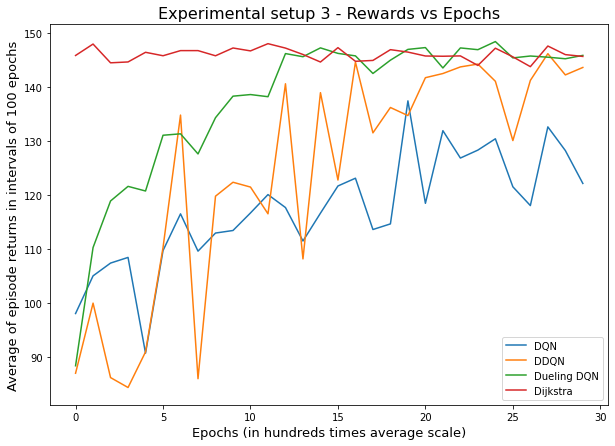

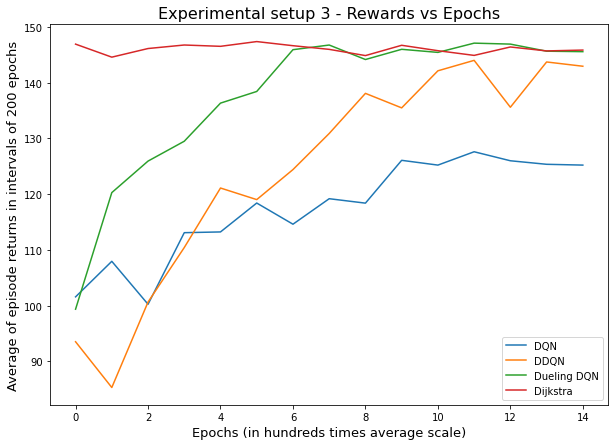

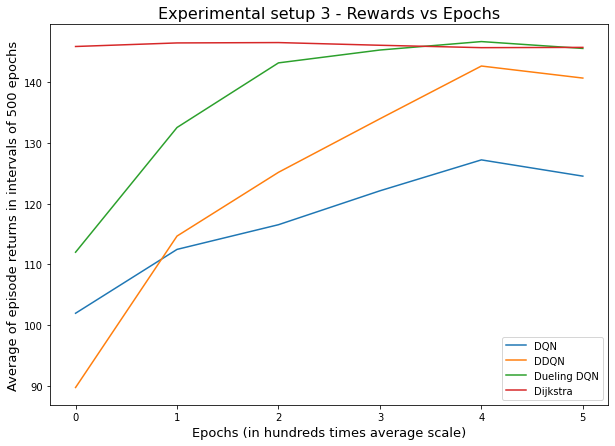

In [ ]:
sizes = [100, 200, 500]
dqn = [142.44970414201185, 141.2189349112426, 134.28402366863907, 78.63905325443784, 107.71597633136096, 142.23668639053253, 85.84615384615384, 118.3905325443787, 121.9408284023669, 145.23076923076923, 76.55621301775147, 63.12426035502956, 106.57988165680473, 124.87573964497042, 104.42603550295857, 56.09467455621299, 137.88165680473372, 106.33136094674558, 23.58579881656805, 96.60355029585799, 33.01775147928994, 98.20118343195267, 129.68047337278105, 116.07100591715977, 139.00591715976333, 112.24852071005917, 111.76331360946746, 131.15976331360946, 132.20118343195267, 125.65680473372784, 105.91715976331359, 90.87573964497042, 90.1301775147929, 125.83431952662718, 85.60946745562131, 145.55029585798815, 31.846153846153836, 79.04142011834321, 114.59171597633139, 106.60355029585799, 93.9644970414201, 71.23076923076924, 144.8994082840237, 83.05325443786981, 20.272189349112423, 110.7810650887574, 108.23668639053254, 116.89940828402365, 32.059171597633146, 117.15976331360946, 118.14201183431953, 63.66863905325445, 94.35502958579883, 81.79881656804733, 130.28402366863907, 93.86982248520711, 152.65088757396452, 118.1301775147929, 117.2899408284024, 80.09467455621304, 53.51479289940825, 46.27218934911243, 68.72189349112428, 110.17751479289939, 26.946745562130168, 45.230769230769226, 40.04733727810652, 116.02366863905324, 125.86982248520712, 139.6923076923077, 122.53254437869823, 105.31360946745563, 90.36686390532546, 103.26627218934911, 91.68047337278107, 125.95266272189352, 96.74556213017755, 91.8579881656805, 87.94082840236686, 91.17159763313609, 130.81656804733728, 98.02366863905326, 93.20710059171597, 129.43195266272184, 7.526627218934911, 30.76923076923076, 146.49704142011836, 100.78106508875737, 99.91715976331362, 69.6923076923077, 78.69822485207101, 125.70414201183434, 75.43195266272188, 91.5266272189349, 62.78106508875743, 127.23076923076923, 113.20710059171597, 99.85798816568048, 111.59763313609469, 68.10650887573965, 106.7337278106509, 136.603550295858, 46.13017751479289, 104.9585798816568, 127.99999999999999, 102.35502958579882, 49.30177514792901, 138.41420118343194, 127.72781065088759, 107.07692307692308, 65.27810650887574, 152.60355029585796, 101.49112426035501, 149.25443786982245, 106.16568047337276, 116.1656804733728, 137.84615384615384, 49.59763313609469, 108.93491124260355, 124.36686390532545, 114.85207100591715, 138.4260355029586, 106.91124260355029, 6.390532544378688, 114.75739644970415, 129.40828402366864, 124.03550295857987, 126.47337278106514, 126.59171597633134, 145.7278106508876, 159.57396449704143, 140.81656804733726, 92.69822485207101, 146.6153846153846, 86.84023668639054, 77.5739644970414, 51.183431952662716, 48.22485207100595, 140.10650887573965, 138.60355029585799, 49.58579881656808, 106.18934911242604, 111.24260355029585, 97.42011834319527, 93.23076923076923, 122.3076923076923, 125.4319526627219, 114.92307692307692, 112.5207100591716, 17.19526627218935, 139.81065088757396, 91.51479289940828, 27.644970414201175, 101.62130177514793, 90.68639053254438, 16.686390532544372, 110.04733727810651, 102.86390532544382, 94.68639053254435, 98.88757396449702, 94.17751479289942, 114.44970414201183, 143.66863905325445, 141.9408284023669, 84.94674556213019, 126.6272189349113, 138.26035502958584, 86.04733727810651, 106.54437869822488, 149.26627218934908, 43.644970414201175, 147.68047337278108, 120.20118343195264, 116.30769230769229, 141.11242603550295, 126.36686390532546, 60.89940828402369, 128.0828402366864, 103.89349112426036, 88.5325443786982, 106.84023668639053, -10.390532544378715, 143.10059171597632, 141.7751479289941, 29.431952662721876, 119.07692307692308, 86.48520710059168, 94.20118343195266, 77.42011834319528, 68.5562130177515, 138.2485207100592, 126.62721893491123, 100.57988165680473, 116.0473372781065, 102.81656804733728, 145.5857988165681, 159.97633136094672, 109.50295857988164, 44.69822485207099, 143.00591715976327, 141.45562130177515, 123.89349112426034, 75.56213017751479, 131.46745562130175, 28.189349112426058, 123.79881656804734, 141.83431952662718, 107.62130177514794, 135.06508875739644, 147.25443786982248, 126.37869822485204, 2.1893491124260365, 172.81656804733726, 74.34319526627219, 102.87573964497044, 108.84023668639051, 143.71597633136093, 92.03550295857988, 80.78106508875742, 101.50295857988168, 113.14792899408286, 98.2248520710059, 118.26035502958582, 127.37278106508872, 125.88165680473372, 114.74556213017748, 124.04733727810651, 139.7633136094675, 151.2662721893491, 126.34319526627222, 61.79881656804734, 116.16568047337277, 94.43786982248521, 105.18343195266273, 94.6153846153846, 92.71005917159763, 88.16568047337279, 142.80473372781069, 124.82840236686394, 85.0177514792899, 141.301775147929, 45.076923076923094, 116.37869822485204, 126.43786982248524, 143.8461538461538, 149.21893491124254, 117.84615384615384, 111.64497041420117, 123.15976331360946, 145.46745562130178, 122.4615384615384, 122.85207100591715, 130.92307692307693, 98.94674556213018, 125.14792899408286, 66.2248520710059, 106.86390532544377, 112.41420118343191, 116.37869822485207, 125.63313609467454, 138.31952662721898, -20.47337278106508, 72.01183431952663, 127.2189349112426, 116.5207100591716, 91.45562130177512, 49.58579881656805, 44.80473372781064, -17.301775147929018, 109.15976331360949, 104.31952662721895, 98.57988165680473, 102.44970414201185, 132.5562130177515, 156.6627218934911, 96.62721893491124, 92.75739644970417, 115.0769230769231, 141.2781065088757, 135.62130177514794, 66.2485207100592, 101.26627218934912, 97.75147928994085, 84.41420118343194, 65.1360946745562, 109.25443786982248, 125.24260355029585, 126.57988165680474, 98.17751479289939, 95.86982248520708, 123.75147928994083, 84.26035502958578, 98.15384615384617, 95.15976331360947, 117.73964497041419, 83.7041420118343, 139.396449704142, 122.62721893491124, 163.4556213017751, 102.44970414201183, 101.31360946745563, 136.42603550295857, 84.81656804733728, 127.71597633136093, 115.88165680473372, 125.69230769230768, 125.90532544378696, 105.75147928994085, 81.83431952662721, 115.95266272189349, 76.87573964497045, 152.24852071005918, 99.55029585798815, 123.72781065088759, 109.76331360946747, 134.57988165680476, 91.75147928994083, 106.75739644970415, 83.7751479289941, 138.28402366863904, 94.81656804733731, 86.26035502958581, 78.1065088757396, 138.63905325443784, 128.63905325443784, 54.106508875739664, 119.72781065088756, 90.37869822485206, 118.94674556213016, 156.73372781065092, 125.83431952662724, 70.66272189349111, 106.98224852071007, 122.86390532544381, 143.40828402366864, 161.14792899408283, 140.23668639053258, 98.78106508875742, 60.24852071005918, 122.20118343195267, 112.81656804733731, 144.50887573964496, 83.11242603550296, 136.23668639053255, 102.43786982248521, 154.03550295857988, 39.005917159763335, 124.05917159763312, 130.4733727810651, 61.58579881656806, 139.46745562130178, 66.02366863905324, 128.0473372781065, 41.14792899408282, 125.75147928994085, 125.57396449704143, 83.4319526627219, 101.24260355029585, 51.43195266272188, 62.047337278106525, 105.21893491124258, 114.24852071005917, 113.91715976331359, 156.7337278106509, 129.1242603550296, -34.75739644970413, 150.98224852071004, 153.8461538461538, 159.14792899408283, 101.11242603550298, 74.07100591715975, 110.8284023668639, 97.07692307692311, 91.83431952662721, 87.51479289940826, 101.01775147928996, 117.07692307692307, 157.905325443787, 111.31360946745562, 36.579881656804744, 103.45562130177512, 106.01183431952661, 50.99408284023668, 114.9585798816568, 153.68047337278105, 86.14201183431953, 161.24260355029583, 109.72781065088759, 124.66272189349111, 137.7751479289941, 152.9112426035503, 140.31952662721892, 25.207100591715967, 124.14201183431955, 118.6863905325444, 109.39644970414199, 131.00591715976336, 118.34319526627218, 81.08875739644972, 92.89940828402368, 122.11834319526625, 112.4378698224852, 113.57396449704142, 82.42603550295858, 107.01775147928997, 63.136094674556226, 56.88757396449702, 79.79881656804733, 92.28402366863905, 97.73964497041419, 99.07692307692308, 50.650887573964496, 86.3905325443787, 144.41420118343197, 125.13609467455622, 146.5325443786982, 110.26035502958581, 135.78698224852073, 138.92307692307693, 166.03550295857988, 122.15384615384615, 58.23668639053256, 84.80473372781061, 40.0, 8.556213017751503, 17.218934911242584, 92.01183431952663, 133.5266272189349, 51.60946745562133, 104.79289940828401, 106.41420118343193, 123.2662721893491, 104.63905325443791, 39.85798816568047, 102.10650887573964, 39.15976331360947, 65.19526627218934, 127.9526627218935, 106.97041420118344, 2.532544378698219, 8.639053254437886, 85.58579881656803, 125.69230769230771, 108.50887573964495, 97.34911242603549, 137.86982248520712, 139.26627218934914, 113.04142011834318, 126.37869822485206, 118.86390532544382, 20.01183431952662, 108.34319526627216, 35.66863905325443, 119.6923076923077, 74.75739644970417, 93.69230769230768, 39.13609467455624, 76.02366863905326, 95.7869822485207, 89.71597633136096, 95.207100591716, 86.66272189349114, 123.88165680473368, 117.44378698224851, 128.98224852071007, -13.408284023668635, 130.52071005917156, 91.39644970414203, 109.31360946745562, 120.3905325443787, 94.01183431952666, 133.2662721893491, 64.49704142011835, 76.47337278106512, -9.053254437869835, 107.01775147928994, 32.343195266272204, 127.55029585798817, 93.95266272189347, 99.65680473372781, 49.4319526627219, 102.4852071005917, 135.12426035502958, 116.18934911242604, 125.82248520710058, 129.06508875739647, 79.58579881656807, 44.28402366863904, 143.84615384615387, -4.485207100591708, 75.68047337278107, 65.0887573964497, 4.958579881656794, 135.13609467455618, 168.33136094674555, 113.0887573964497, 91.13609467455619, 47.13609467455622, 124.66272189349112, 40.65088757396448, 132.48520710059174, 92.8757396449704, 133.94082840236683, 127.46745562130178, 70.31952662721892, 105.96449704142012, 133.56213017751477, 147.7751479289941, 90.76923076923079, 11.562130177514819, 125.6568047337278, 111.0059171597633, 101.43195266272187, 140.7218934911243, 116.93491124260353, 44.9585798816568, 114.79289940828399, 23.42011834319528, 106.56804733727809, 119.89349112426035, 107.89349112426032, 138.49704142011834, 74.88757396449702, 122.84023668639053, 66.31952662721896, 57.34911242603552, 72.79289940828403, 102.85207100591715, 74.42603550295858, 72.36686390532545, 92.60355029585799, 54.89940828402367, 153.0769230769231, 131.99999999999997, 112.33136094674558, 118.4733727810651, 122.89940828402368, 131.11242603550298, 140.0473372781065, 120.08284023668637, 88.50887573964496, 105.42011834319524, 108.0118343195266, 133.64497041420123, 16.68639053254437, 69.96449704142009, 38.62721893491121, 105.65680473372781, 102.3431952662722, 139.7751479289941, 111.73964497041419, 98.3313609467456, 104.97041420118343, 82.63905325443785, -6.8165680473372845, 118.01183431952663, 140.9585798816568, 129.68047337278102, 124.31952662721896, 92.73372781065088, 151.9881656804734, 139.0532544378698, 151.7278106508876, 133.52662721893492, 69.53846153846155, 136.59171597633136, 137.72781065088753, 124.57988165680474, 49.1715976331361, 116.80473372781064, 80.76923076923076, 133.49112426035498, 105.06508875739648, 100.24852071005915, 139.28994082840237, 144.0, 137.53846153846158, 132.4378698224852, 120.44970414201185, 152.2603550295858, 121.36094674556213, 151.02958579881658, 132.7810650887574, 133.79881656804739, 133.38461538461542, 76.80473372781064, 144.72189349112423, 125.45562130177515, 57.79881656804733, 154.33136094674552, 109.6094674556213, 114.92307692307692, 176.82840236686394, 100.3905325443787, 150.66272189349112, 115.11242603550293, 132.27218934911244, 128.11834319526628, 120.67455621301772, 113.10059171597631, 111.04142011834321, 92.07100591715974, 96.34319526627218, 91.30177514792899, 86.72189349112426, 149.81065088757398, 89.47928994082842, 111.58579881656803, 137.79881656804733, 144.20118343195264, 136.0591715976331, 134.63905325443787, 121.92899408284026, 105.00591715976331, 95.98816568047337, 109.52662721893489, 111.5739644970414, 131.11242603550295, 143.42011834319524, 73.51479289940828, 135.0532544378698, 118.93491124260353, 154.54437869822485, 116.75739644970417, 151.3846153846154, 123.42011834319524, 57.98816568047339, 121.38461538461534, 145.00591715976333, 117.15976331360946, 130.18934911242604, 138.18934911242604, 82.36686390532543, 126.42603550295857, 134.60355029585796, 167.9644970414201, 157.05325443786984, 128.59171597633136, 136.57988165680473, 122.2721893491124, 131.98816568047337, 90.61538461538461, 160.86390532544377, 153.43195266272187, 90.05917159763312, 110.41420118343196, 150.0, 127.00591715976331, 139.0177514792899, 113.17159763313609, 107.33727810650888, 85.01775147928993, 114.3076923076923, 108.50887573964496, 56.556213017751475, 112.76923076923076, 122.48520710059172, 128.8994082840237, 97.10059171597632, 139.4792899408284, 109.72781065088758, 131.1715976331361, 103.301775147929, 140.8757396449704, 137.98816568047337, 175.75147928994076, 123.96449704142009, 128.40236686390534, 109.85798816568045, 87.60946745562129, 93.19526627218937, 56.532544378698205, 167.12426035502958, 116.82840236686388, 90.09467455621301, 73.47928994082841, 130.69822485207098, 6.14201183431951, 84.05917159763315, 100.93491124260353, 112.55621301775146, 128.34319526627218, 75.82248520710061, 125.32544378698226, 123.19526627218933, 100.04733727810648, 107.56213017751477, 107.84615384615383, 116.84023668639054, 136.65088757396452, 107.58579881656806, 128.22485207100587, 103.28994082840238, 67.51479289940828, 118.80473372781063, 118.65088757396448, 100.60355029585799, 165.42011834319524, 148.63905325443787, 115.4792899408284, 107.63313609467457, 86.55621301775149, 117.56213017751479, 102.44970414201185, 98.89940828402365, 148.49704142011836, 83.73964497041422, 111.23076923076925, 119.32544378698226, 159.13609467455626, 138.0473372781065, 59.313609467455606, 103.05325443786985, 134.65088757396447, 108.13017751479292, 80.49704142011832, 101.14792899408283, 116.3431952662722, 122.65088757396448, 95.75147928994085, 12.011834319526642, 112.92307692307693, 58.28402366863904, 127.66863905325444, 133.33727810650885, 86.20118343195269, 130.7218934911243, 127.905325443787, 116.41420118343193, 168.42603550295857, 114.08284023668638, 143.58579881656806, 10.804733727810639, 136.60355029585799, 130.02366863905323, 90.99408284023669, 90.34319526627215, 54.48520710059172, 113.13609467455623, 145.25443786982245, 135.6568047337278, 132.34319526627218, 125.50295857988168, 96.16568047337277, 133.01775147928993, 124.22485207100593, 114.80473372781064, 124.50887573964498, 146.698224852071, 152.15384615384616, 116.2603550295858, 111.85798816568045, 137.31360946745562, 150.9940828402367, 91.53846153846155, 139.46745562130178, 145.2662721893491, 97.9171597633136, 77.19526627218939, 159.55029585798817, 136.94674556213016, 147.30177514792894, 81.7751479289941, 120.13017751479289, 94.61538461538464, 137.91715976331363, 152.29585798816572, 82.24852071005917, 90.36686390532547, 130.18934911242602, 143.96449704142012, 120.41420118343196, 94.84023668639051, 58.82840236686391, 107.75147928994079, 130.3550295857988, 72.98224852071006, 121.57396449704143, 91.10059171597632, 87.05325443786985, 127.491124260355, 95.4201183431953, 94.18934911242606, 117.58579881656804, 74.56804733727813, 105.58579881656804, 82.56804733727812, 15.420118343195245, 154.85207100591717, 123.55029585798816, 120.75739644970417, 8.958579881656814, 118.20118343195267, 71.49112426035502, 136.55621301775147, 128.8402366863905, 34.16568047337279, 123.5739644970414, 116.27218934911244, 100.57988165680476, 133.7278106508876, 87.83431952662724, 88.1775147928994, 54.43786982248518, 130.7455621301775, 158.24852071005915, 105.6094674556213, 103.71597633136095, 66.57988165680476, 79.3491124260355, 8.106508875739644, 103.79881656804734, 160.23668639053253, 73.85798816568047, 93.9171597633136, 135.68047337278105, 107.26627218934912, 129.28994082840234, 124.85207100591715, 151.84615384615387, 125.64497041420118, 153.44378698224853, 120.33136094674556, 105.40828402366861, 131.7278106508876, 83.0769230769231, 106.14201183431952, 71.79881656804734, 46.46153846153845, 118.4378698224852, 118.52071005917158, 167.1715976331361, 132.37869822485212, 121.64497041420117, 119.10059171597634, 95.55029585798817, 99.00591715976331, 122.89940828402369, 150.39053254437871, 136.89940828402365, 147.6923076923077, 96.40236686390531, 103.89349112426036, 95.60946745562131, 141.8461538461538, 106.43786982248523, 74.21301775147926, 74.62721893491123, 132.98224852071007, 139.0177514792899, 57.23076923076924, 130.0828402366864, 133.36094674556213, 131.64497041420117, 137.34911242603556, 86.53254437869823, 121.18343195266273, 130.75739644970417, 10.946745562130177, 160.84023668639054, 155.81065088757396, 124.11834319526626, 143.30177514792902, 125.51479289940829, 111.24260355029587, 137.0414201183432, 135.19526627218937, 108.7337278106509, 139.6449704142012, 95.53846153846155, 95.51479289940826, 109.20710059171599, 139.68047337278102, 63.52662721893491, 95.52662721893492, 124.71005917159762, 155.7869822485207, 136.55621301775153, 121.42011834319526, 124.9940828402367, 144.9704142011834, 132.8757396449704, 24.674556213017752, 86.48520710059172, 111.84615384615383, 109.11242603550296, 134.01183431952666, 124.09467455621302, 101.45562130177512, 119.62130177514793, 110.93491124260353, 123.6804733727811, 145.7869822485207, 54.7218934911243, 138.01183431952666, 73.20710059171599, 109.49112426035505, 141.82248520710058, 88.26035502958581, 144.54437869822482, 66.35502958579882, 100.9467455621302, 81.4792899408284, 69.69230769230771, 45.50295857988165, 106.3905325443787, 144.55621301775145, 114.50887573964496, 100.98224852071006, 97.7396449704142, 127.78698224852073, 156.2248520710059, 151.37278106508876, 140.6153846153846, 127.06508875739645, 18.875739644970423, -12.840236686390522, 142.15384615384616, 139.3727810650888, 157.53846153846155, 119.08875739644971, 140.87573964497037, 158.4378698224852, 132.7337278106509, 134.7455621301775, 145.1124260355029, 126.10650887573964, 130.75739644970415, 105.1479289940828, 88.92307692307693, 74.15384615384616, 122.65088757396448, 123.86982248520712, 114.2248520710059, 141.1360946745562, 65.17159763313606, 124.414201183432, 84.66272189349114, 33.30177514792901, 107.42011834319527, 155.37278106508873, 127.95266272189347, 89.38461538461539, 129.40828402366867, 111.79881656804734, 85.23076923076923, 139.71597633136093, 142.54437869822488, 106.79289940828403, 103.00591715976327, 123.1005917159763, 122.92307692307693, 125.72781065088756, 54.094674556213036, 107.42011834319528, 88.73372781065088, 122.05917159763312, 107.04142011834317, 133.26627218934917, 128.61538461538464, 111.65680473372785, 122.11834319526623, 90.05917159763314, 144.42603550295857, 138.35502958579877, 118.47337278106508, 108.62721893491124, 55.81065088757398, 112.0, 131.50295857988166, 128.1183431952663, 109.79881656804733, 140.30769230769232, 113.00591715976331, 98.67455621301774, 75.28994082840234, 84.76923076923075, 130.41420118343194, 134.20118343195261, 134.14201183431956, 154.4852071005917, 146.74556213017752, 95.10059171597634, 115.75147928994082, 132.0118343195266, 116.0828402366864, 151.45562130177515, 134.68639053254438, 114.9585798816568, 147.86982248520707, 109.28994082840238, 86.18934911242603, 161.68047337278102, 50.01183431952662, 109.98816568047334, 134.0, 97.64497041420117, 111.68047337278105, 121.00591715976327, 120.07100591715978, 144.94674556213016, 116.75739644970415, 116.1656804733728, 153.20710059171597, 113.4556213017752, 137.88165680473372, 15.573964497041416, 152.66272189349115, 123.94082840236686, 121.69230769230772, 111.24260355029587, 104.9585798816568, 135.2189349112426, 94.53254437869823, 96.05917159763311, 93.25443786982248, 132.15384615384616, 147.9526627218935, 146.0, 92.37869822485206, 110.0591715976331, 125.63313609467453, 104.00000000000003, 96.36686390532543, 112.97041420118343, 131.4201183431953, 142.0591715976331, 54.26035502958581, 127.06508875739645, 140.31952662721898, 41.337278106508876, 156.18934911242602, 144.9112426035503, 125.27810650887574, 75.24260355029584, 122.88757396449704, 130.59171597633136, 70.23668639053255, 124.71005917159759, 121.21893491124261, 163.77514792899404, 130.3076923076923, 129.06508875739644, 135.0887573964497, 120.15384615384616, 138.3076923076923, 85.57396449704142, 115.81065088757397, 118.39053254437871, 139.82248520710056, 152.75739644970415, 109.53846153846152, 144.41420118343194, 101.2544378698225, 52.29585798816569, 128.9349112426036, 141.43195266272193, 132.88757396449705, 148.11834319526625, 150.50887573964496, 122.00000000000001, 129.06508875739647, 100.65088757396451, 125.0414201183432, 154.2366863905325, 125.90532544378698, 125.82248520710061, 86.29585798816566, 58.816568047337284, 104.13017751479289, 124.9585798816568, 137.28994082840237, 128.9940828402367, 103.06508875739645, 132.3905325443787, 145.396449704142, 117.90532544378696, 153.95266272189352, 43.73964497041423, 116.73372781065089, 122.04733727810651, 19.159763313609446, 90.01183431952664, 96.82840236686393, 148.57988165680476, 102.61538461538464, 139.83431952662718, 155.5857988165681, 109.25443786982248, 89.86982248520711, 137.81065088757396, 131.5502958579882, 133.89349112426038, 107.8816568047337, 110.55621301775147, 11.065088757396438, 134.4142011834319, 88.50887573964499, 124.5798816568047, 135.2899408284024, 83.89349112426034, 109.66863905325448, 79.39644970414203, 111.85798816568047, 151.08875739644972, 145.5029585798816, 121.50295857988169, 144.71005917159766, 32.86390532544377, 147.5739644970414, 121.70414201183434, 91.69230769230771, 108.49704142011836, 67.73964497041422, 126.94674556213016, 121.47928994082841, 130.10650887573965, 74.91124260355028, 95.69230769230768, 64.93491124260355, 151.49112426035506, 65.4319526627219, 121.65680473372782, 124.57988165680472, 119.40828402366864, 139.84615384615384, 105.53846153846155, 131.77514792899407, 83.92899408284026, 127.42011834319524, 137.79881656804733, 165.96449704142012, 137.77514792899407, 149.49112426035504, 100.3195266272189, 135.31360946745562, 125.43195266272187, 101.50295857988168, 113.25443786982247, 134.66272189349112, 147.73964497041425, 133.44378698224853, 133.5621301775148, 139.1715976331361, 154.3431952662722, 101.81065088757397, 160.21301775147927, 92.49704142011836, 121.1242603550296, 134.49704142011834, 124.33136094674559, 111.6568047337278, 162.4497041420119, 151.96449704142012, 63.727810650887555, 86.52071005917159, 127.11242603550298, 106.54437869822488, 114.63905325443791, 101.39644970414197, 115.0769230769231, 114.80473372781063, 95.86982248520711, 106.16568047337279, 131.1597633136095, 160.8402366863905, 138.13017751479288, 126.21301775147928, 131.2189349112426, 136.22485207100593, 126.94674556213019, 69.49112426035502, 146.26035502958578, 160.04733727810654, 166.34319526627218, 167.02958579881658, 93.64497041420123, 147.97633136094674, 102.9112426035503, 148.39053254437874, 79.77514792899404, 112.47337278106511, 109.51479289940828, 116.20118343195267, 147.5266272189349, 97.90532544378696, 152.22485207100593, 161.84615384615387, 112.792899408284, 100.50887573964498, 122.792899408284, 135.30177514792902, 90.50887573964498, 115.55029585798813, 131.56213017751483, 127.86982248520708, 152.75739644970415, 95.77514792899406, 67.49112426035501, 122.82840236686388, 110.8757396449704, 148.37869822485206, 94.76923076923073, 151.11242603550292, 127.4674556213018, 141.24260355029585, 67.0887573964497, 131.66863905325448, 131.76331360946747, 133.23076923076923, 113.72781065088758, 97.06508875739645, 133.25443786982245, 98.2603550295858, 121.4437869822485, 77.88165680473372, 37.10059171597629, 140.8757396449704, 78.91124260355032, 159.36094674556213, 121.98816568047337, 145.9881656804734, 119.53846153846153, 54.95857988165683, 123.23076923076923, 158.9112426035503, 142.14201183431953, 141.92899408284023, 135.31360946745565, 140.79289940828403, 144.81656804733728, 131.8579881656805, 128.91124260355028, 141.39644970414204, 90.3905325443787, 118.49704142011834, 160.8757396449704, 100.2130177514793, 142.46153846153848, 116.99408284023669, 146.0355029585799, 140.88757396449705, 155.23076923076925, 157.39644970414204, 98.07100591715974, 108.68639053254437, 133.24260355029585, 143.14792899408286, 149.62130177514794, 141.23076923076928, 149.3254437869822, 141.79881656804739, 114.61538461538463, 152.0, 127.10059171597634, 126.75739644970407, 104.9230769230769, 90.72189349112423, 115.2662721893491, 148.05917159763317, 99.0414201183432, 104.62721893491123, 124.76923076923075, 140.88757396449702, 109.9644970414201, 142.2130177514793, 102.95857988165679, 114.10650887573965, 100.8757396449704, 105.94082840236689, 123.0887573964497, 13.313609467455624, 121.17159763313609, 102.04733727810648, 99.42011834319526, 109.64497041420117, 71.17159763313607, 94.86390532544378, 95.23076923076924, 126.03550295857987, 87.6449704142012, 105.94082840236688, 120.5207100591716, 84.54437869822486, 114.3550295857988, 94.98224852071004, 135.55029585798815, 123.30177514792899, 114.43786982248521, 119.53846153846156, 122.16568047337276, 130.08284023668637, 123.79881656804733, 128.80473372781069, 102.0, 20.923076923076916, 112.18934911242602, 90.30769230769228, 125.45562130177518, 112.26035502958581, -29.810650887573946, 87.20710059171599, 90.27218934911244, 47.43195266272188, 97.14792899408286, 64.92307692307693, 86.47337278106508, 105.11242603550299, 104.55621301775147, 93.8579881656805, 114.31952662721895, 73.75147928994085, 124.28402366863905, 58.04733727810651, 83.33727810650888, 78.2958579881657, 109.08875739644968, 117.96449704142012, 90.79289940828403, 145.1005917159763, 158.13017751479288, 159.86982248520715, 125.07692307692307, 131.5502958579882, 135.51479289940826, 159.23076923076925, 81.59763313609469, 134.52071005917165, 124.52071005917158, 159.8343195266273, 141.08875739644972, 153.76331360946745, 153.71597633136096, 150.3431952662722, 137.58579881656806, 145.25443786982248, 147.9289940828402, 147.65680473372782, 96.46153846153848, 101.72781065088755, 140.84023668639054, 136.02366863905328, 137.07692307692307, 116.35502958579883, 89.62130177514791, 69.65680473372782, 65.5266272189349, 127.6923076923077, 98.56804733727813, 51.77514792899409, 50.319526627218934, 148.6508875739645, 119.10059171597632, 125.4437869822485, 153.76331360946745, 154.10650887573968, 96.0473372781065, 110.53254437869822, -4.982248520710051, 106.30769230769232, 109.24260355029587, 153.6804733727811, 131.97633136094674, 161.01775147928993, 150.14201183431953, 122.14201183431955, 133.5857988165681, 112.14201183431953, 172.29585798816572, 82.89940828402368, 110.52071005917159, 158.69822485207104, 116.33136094674558, 144.34319526627223, 160.5325443786982, 168.68639053254438, 159.08875739644975, 131.1479289940828, 129.8343195266272, 97.50295857988169, 102.74556213017752, 150.80473372781069, 72.42603550295857, 59.21893491124261, 146.15384615384613, 79.6449704142012, 29.668639053254427, 118.88757396449704, 35.68047337278106, 139.9408284023668, 69.64497041420121, 93.23076923076921, 114.23668639053254, 38.8284023668639, 131.17159763313612, 83.10059171597635, 89.43195266272188, 128.29585798816566, 105.76331360946747, 76.41420118343196, 51.19526627218933, 87.25443786982248, -18.201183431952682, 47.15976331360949, 139.2189349112426, 94.47337278106511, 147.07692307692307, 72.61538461538463, 74.11834319526629, 145.88165680473372, 151.7869822485207, 87.51479289940829, 41.04142011834317, 154.20118343195273, 119.81065088757398, 148.29585798816572, 93.51479289940826, 137.24260355029585, 124.67455621301777, 131.0887573964497, 94.17751479289943, 126.31952662721895, 164.9230769230769, 94.63905325443787, 131.89349112426035, 104.4378698224852, 72.99408284023669, 37.43195266272191, 64.44970414201184, 100.20118343195266, 145.45562130177512, 123.19526627218933, 134.2840236686391, 107.33727810650888, 74.42603550295858, 93.51479289940828, 116.42603550295857, 142.49704142011834, 137.10059171597638, 139.77514792899404, 136.57988165680473, 133.13609467455626, 122.76923076923076, 136.87573964497042, 73.18343195266273, 150.54437869822488, 92.0828402366864, 145.73964497041425, 110.50887573964496, 127.8224852071006, 46.73372781065086, 87.32544378698226, 99.50295857988168, 132.86390532544382, 131.30177514792896, 149.4319526627219, 146.98224852071007, 140.80473372781069, 97.73964497041418, 82.48520710059171, 148.84023668639054, 114.13017751479289, 33.396449704141986, 87.94082840236688, 136.15384615384613, 99.9171597633136, 124.9467455621302, 115.36094674556213, 11.621301775147927, 94.68639053254437, 134.10650887573962, 151.50295857988166, 116.0, 163.12426035502955, 117.71597633136095, 129.2899408284024, 147.69230769230768, 144.20118343195267, 153.2189349112426, 98.82840236686391, 143.45562130177515, 141.9408284023669, 134.189349112426, 157.2071005917159, 142.24852071005915, 150.67455621301772, 145.49112426035504, 150.189349112426, 160.65088757396447, 139.01775147928993, 145.24260355029585, 132.11834319526628, 111.23076923076923, 136.09467455621302, 136.28402366863907, 112.81656804733728, 154.85207100591717, 105.2189349112426, 127.94082840236689, 137.45562130177515, 139.8343195266272, 147.6568047337278, 156.46153846153848, 133.78698224852064, 142.26035502958578, 162.54437869822485, 118.07100591715978, 142.36686390532546, 149.9289940828403, 152.5917159763314, 103.8698224852071, 119.97633136094673, 109.39644970414199, 140.2958579881657, 35.822485207100584, 94.71005917159763, 18.437869822485204, 67.94082840236686, 99.0414201183432, 124.47337278106511, 119.04142011834321, 79.301775147929, 49.91715976331362, 125.45562130177515, 111.66863905325444, 115.00591715976331, 72.18934911242604, 107.24260355029585, 84.50887573964495, 68.66272189349115, 81.04142011834321, 119.84615384615385, 98.65088757396448, 156.15384615384616, 132.21301775147927, 131.905325443787, 119.97633136094672, 125.07692307692305, 151.84615384615387, 138.82840236686388, 107.40828402366863, 87.43195266272188, 163.02958579881656, 143.50295857988164, 138.37869822485206, 158.78106508875743, 130.5562130177515, 140.37869822485206, 161.4201183431953, 126.62721893491123, 109.5621301775148, 165.00591715976336, 151.24260355029588, 90.67455621301775, 140.27218934911244, 140.43786982248523, 113.52662721893492, 128.8639053254438, 161.4792899408284, 151.33727810650888, 61.786982248520715, 88.31952662721895, 155.1479289940829, 146.68639053254435, 134.53254437869822, 137.68047337278105, 146.95857988165685, 145.23076923076928, 121.7751479289941, 170.7455621301775, 165.85798816568047, 158.14201183431953, 167.81065088757393, 124.3076923076923, 138.18934911242604, 153.86982248520715, 125.01775147928993, 137.491124260355, 156.9230769230769, 77.59763313609467, 146.42603550295857, 125.2544378698225, 129.95266272189352, 113.50295857988165, 123.47928994082844, 0.023668639053269658, 101.85798816568045, 101.06508875739644, 96.2130177514793, 105.11242603550295, 142.81656804733726, 137.46745562130172, 132.79289940828403, 105.92899408284023, 109.6449704142012, 127.51479289940829, 49.08875739644971, 86.94674556213019, 136.792899408284, 126.63905325443787, 136.04733727810648, 119.53846153846155, 79.19526627218934, 125.38461538461542, 83.4319526627219, 116.84023668639053, 127.26627218934908, 118.9467455621302, 139.1479289940828, 130.95857988165687, 118.67455621301775, 124.8639053254438, 88.46153846153845, 112.82840236686393, 132.80473372781063, 170.3431952662722, 166.3431952662722, 124.05917159763315, 95.65680473372782, 136.698224852071, 159.58579881656803, 120.75739644970413, 82.22485207100593, 73.396449704142, 129.1597633136095, 108.31952662721893, 124.84023668639051, 113.04142011834318, 132.85207100591717, 113.6094674556213, 100.2603550295858, 156.7573964497041, 155.60946745562134, 162.21301775147933, 141.00591715976333, 138.02366863905326, 119.47928994082841, 113.13609467455622, 123.64497041420121, 112.80473372781063, 136.68639053254438, 121.15976331360946, 123.97633136094676, 150.72189349112426, 130.78106508875734, 138.6627218934911, 147.44378698224853, 123.37278106508879, 138.8165680473373, 119.32544378698225, 173.56213017751475, 138.29585798816572, 121.905325443787, 120.36686390532543, 125.8579881656805, 102.54437869822482, 147.94082840236686, 69.9171597633136, 150.02366863905323, 89.89349112426035, 155.26627218934908, 118.98224852071004, 141.26627218934914, 113.84615384615385, 127.88165680473372, 131.02958579881658, 141.3609467455621, 125.91715976331356, 152.68639053254438, 145.3846153846154, 124.10650887573965, 146.63905325443784, 124.9940828402367, 112.11834319526625, 102.56804733727812, 116.67455621301772, 125.301775147929, 138.6272189349112, 113.89349112426032, 127.2189349112426, 126.46153846153848, 141.7278106508876, 141.6449704142012, 122.30769230769228, 27.893491124260365, 128.73372781065086, 124.89940828402366, 79.97633136094674, 139.97633136094674, 134.47337278106505, 95.5266272189349, -14.591715976331363, 97.28994082840237, 148.57988165680467, 164.1420118343195, 141.46745562130178, 113.97633136094676, 37.5621301775148, 149.1242603550296, 127.90532544378699, 131.69230769230768, 142.31952662721895, 97.59763313609464, 136.52071005917156, 126.73372781065092, 134.80473372781063, 62.497041420118336, 126.31952662721893, 114.85207100591714, 159.55029585798815, 127.1715976331361, 11.786982248520694, 147.6094674556213, 103.96449704142012, 79.81065088757397, 99.46745562130177, 107.28994082840238, 127.50295857988166, 111.20710059171597, 127.52662721893492, 89.92899408284022, 107.06508875739645, 143.6094674556213, 83.45562130177515, -10.875739644970416, 98.23668639053257, 127.65680473372781, 136.1420118343195, 102.97041420118342, 85.75147928994083, 142.5680473372781, 76.0355029585799, 102.86390532544381, 86.63905325443791, 130.7810650887574, 75.83431952662724, 134.23668639053258, 135.08875739644972, 155.17159763313606, 65.46745562130178, 173.71597633136096, 165.38461538461542, 138.3431952662722, 127.39644970414203, 148.53254437869822, 159.49112426035498, 161.0532544378698, 144.6508875739645, 129.5621301775148, 132.54437869822482, 150.86390532544382, 111.21893491124257, 41.40828402366863, 73.47928994082841, 103.33727810650888, 102.94674556213019, 106.23668639053253, 148.05917159763314, 81.43195266272191, 129.71597633136093, 140.7337278106509, 112.57988165680473, 92.698224852071, 105.21893491124261, 62.92307692307693, 134.15384615384616, 91.36094674556213, 113.64497041420118, 78.67455621301772, 44.331360946745555, 121.65680473372782, 145.05325443786984, 142.41420118343197, 128.7692307692308, 88.79289940828401, 64.09467455621301, 126.74556213017752, 131.15976331360946, 70.74556213017752, 149.78698224852073, 85.8343195266272, 130.18934911242602, 115.5739644970414, 135.2544378698225, 113.42011834319527, 70.3550295857988, 88.41420118343197, 34.544378698224826, 157.3491124260355, 145.58579881656806, 128.50887573964496, 120.39053254437871, 82.92307692307693, 151.7869822485207, 121.56213017751477, 93.89349112426034, 146.76923076923075, 125.25443786982248, 144.08284023668642, 152.603550295858, 121.95266272189349, 99.9171597633136, 119.6568047337278, 126.7692307692308, 150.10650887573965, 119.66863905325445, 78.78106508875737, 119.57396449704142, 125.55029585798815, 144.71005917159763, 99.9526627218935, 145.79881656804736, 128.62721893491124, 129.32544378698225, 142.74556213017752, 125.55029585798816, 111.50295857988169, 151.68047337278108, 158.93491124260356, 146.55621301775147, 150.5562130177515, 83.36094674556213, 132.31952662721895, 50.75739644970414, 128.47337278106505, 113.45562130177514, 144.23668639053255, 176.18934911242607, 142.89940828402365, 161.37278106508876, 136.99408284023673, 163.1834319526627, 119.24260355029587, 111.57396449704144, 96.53254437869822, 133.76331360946745, 116.62721893491121, 99.81065088757397, 81.1715976331361, 132.6745562130178, 80.3431952662722, 130.2603550295858, 125.26627218934912, 143.32544378698222, 143.62130177514788, 99.15976331360946, 122.49704142011834, 151.70414201183434, 112.87573964497042, 127.00591715976329, 116.36686390532545, 149.5976331360947, 133.79881656804733, 141.01775147928993, 160.36686390532543, 155.71597633136093, 76.93491124260355, 104.44970414201181, 24.343195266272204, 98.94674556213018, 94.01183431952663, 123.94082840236689, 132.86390532544377, 115.32544378698226, 108.31952662721892, 98.98224852071003, 76.5325443786982, 114.39053254437869, 57.88165680473372, 63.46745562130177, 13.45562130177516, 67.69230769230772, 84.698224852071, 112.73372781065086, 107.72781065088756, 86.8284023668639, 115.59763313609469, 121.6094674556213, 128.00000000000003, 142.6508875739645, 122.49704142011836, 45.20710059171599, 43.147928994082825, 121.28994082840234, 89.38461538461537, 88.3550295857988, 117.34911242603548, 113.0887573964497, 125.38461538461536, 119.83431952662724, 144.07100591715977, 40.13017751479291, 120.85207100591715, 160.39053254437871, 118.89940828402366, 94.29585798816568, 47.96449704142014, 112.53254437869822, 132.30769230769226, 124.37869822485209, 78.62721893491127, 156.9112426035503, 156.5917159763314, 126.48520710059168, 127.10059171597632, 123.89349112426034, 144.1301775147929, 151.95266272189352, 138.93491124260353, 141.66863905325442, 157.14792899408286, 165.56213017751472, 135.98816568047334, 143.96449704142012, 151.53846153846155, 156.50887573964496, 131.98816568047337, 137.7988165680473, 143.00591715976333, 158.59171597633141, 161.43195266272187, 143.39644970414204, 118.17751479289942, 149.26627218934917, 159.02958579881658, 158.7928994082841, 145.56213017751483, 143.70414201183434, 118.66272189349114, 138.1183431952663, 93.81065088757396, 143.81065088757398, 121.27810650887574, 152.68639053254432, 139.491124260355, 163.38461538461536, 132.57988165680473, 172.6508875739645, 129.7278106508876, 167.7869822485207, 124.698224852071, 145.8698224852071, 134.57988165680467, 104.97041420118346, 119.05325443786981, 129.94082840236692, 112.30769230769229, -3.4319526627218977, 179.14792899408283, 136.54437869822482, 139.02958579881656, 120.47337278106507, 165.8816568047337, 147.79881656804733, 161.6449704142012, 145.28994082840234, 146.07100591715977, 125.0414201183432, 137.905325443787, 131.77514792899404, 149.19526627218934, 160.68639053254435, 69.62130177514793, 149.28994082840234, 114.53254437869823, 152.95857988165682, 146.5680473372781, 160.6153846153846, 128.9940828402367, 125.42011834319528, 169.19526627218934, 102.93491124260353, 132.0355029585799, 125.92899408284023, 155.27810650887577, 157.4674556213018, 157.97633136094674, 143.63313609467454, 130.24852071005918, 141.88165680473372, 157.71597633136093, 140.10650887573968, 125.25443786982248, 165.59763313609466, 140.99408284023673, 101.05325443786982, 161.301775147929, 142.52071005917165, 147.9526627218935, 165.8698224852071, 157.46745562130178, 128.03550295857985, 87.47928994082844, 134.29585798816566, 123.00591715976331, 109.89349112426036, 116.02366863905324, 89.18343195266273, 156.8284023668639, 135.6923076923077, 119.99999999999999, 100.39053254437871, 142.91124260355028, 32.67455621301773, 122.98224852071007, 164.89940828402365, 146.2248520710059, 154.49704142011836, 154.56804733727807, 134.35502958579883, 118.24852071005921, 151.57396449704143, 51.60946745562129, 119.12426035502958, 95.00591715976329, 102.2958579881657, 98.1775147928994, 118.79289940828407, 128.6508875739645, 156.21301775147933, 137.1479289940828, 136.84023668639054, 87.90532544378696, 38.47337278106512, 45.28994082840236, 47.00591715976332, 99.50295857988168, 121.73964497041419, 76.09467455621302, 113.6923076923077, 47.84615384615384, 101.92899408284022, 113.62130177514791, 113.1360946745562, 129.13609467455623, 146.6745562130178, 139.75147928994085, 12.757396449704125, 144.23668639053255, 116.17751479289942, 143.08875739644975, 112.01183431952664, 126.20118343195263, 153.96449704142012, 151.3609467455621, 107.13609467455623, 98.33136094674553, 123.0887573964497, 156.13017751479288, 142.72189349112426, 147.6094674556213, 155.33727810650888, 51.55029585798816, 117.02958579881658, 100.09467455621302, 132.41420118343197, 137.89349112426038, 145.05325443786984, 109.14792899408282, 139.491124260355, 155.21893491124263, 140.1656804733728, 142.02366863905323, 156.22485207100596, 145.9408284023669, 128.5562130177515, 125.19526627218931, 125.97633136094672, 90.87573964497042, 138.9940828402367, 156.91124260355033, 115.70414201183432, 135.1242603550296, 147.19526627218931, 102.40236686390531, 33.65680473372781, 137.7751479289941, 126.34319526627218, 118.6627218934911, 141.45562130177518, 117.89349112426034, 140.94674556213016, 141.6213017751479, 120.93491124260355, 151.7751479289941, 134.80473372781066, 132.93491124260353, 117.21893491124258, 125.46745562130178, 110.94674556213018, 99.95266272189347, 81.7396449704142, 132.54437869822485, 73.90532544378698, 81.98816568047337, 152.67455621301775, 140.8402366863905, 69.51479289940829, 114.0828402366864, 111.36094674556212, 131.04142011834315, 132.88757396449705, 138.67455621301772, 150.52071005917156, 113.25443786982248, 158.56804733727807, 125.65680473372781, 143.0769230769231, 160.22485207100593, 88.63905325443785, 114.14201183431955, 107.24260355029584, 128.29585798816566, 154.56804733727807, 132.63905325443784, 158.7218934911242, 102.1420118343195, 107.0769230769231, 135.19526627218931, 113.69230769230768, 116.67455621301775, 137.39644970414201, 148.74556213017755, 89.65680473372782, 124.97041420118347, 97.33727810650886, 149.81065088757398, 129.66863905325442, 67.57396449704143, 177.19526627218937, 116.13017751479289, 161.62130177514788, 149.97633136094677, 141.37278106508876, 134.02366863905326, 133.7751479289941, 93.82248520710063, 135.89349112426035, 153.0650887573964, 133.8816568047337, 153.56213017751483, 129.85798816568044, 146.03550295857988, 122.76923076923079, 168.39053254437874, 150.11834319526625, 165.88165680473372, 144.6390532544379, 117.73964497041418, 153.40828402366864, 152.23668639053253, 113.23076923076925, 122.54437869822485, 154.29585798816564, 129.33727810650885, 144.72189349112426, 60.76923076923075, 87.0887573964497, 155.11242603550298, 143.79881656804736, 157.20710059171603, 125.10059171597634, 105.82248520710058, 114.07100591715978, 104.5207100591716, 118.59171597633139, 170.14201183431948, 93.0769230769231, 126.03550295857988, 114.68639053254438, 136.97041420118344, 153.97633136094677, 146.85207100591717, 89.76331360946745, 138.1420118343195, 113.01775147928993, 72.68639053254435, 130.22485207100593, 105.68047337278105, 146.93491124260356, 157.9408284023669, 163.19526627218937, 148.94674556213022, 101.28994082840237, 123.5976331360947, 139.37278106508882, 125.72781065088759, 168.28402366863907, 130.46153846153848, 95.60946745562129, 148.82840236686386, 145.31360946745568, 120.02366863905324, 141.50295857988166, 138.9467455621302, 163.12426035502958, 152.79289940828406, 162.3550295857988, 137.25443786982248, 162.28402366863904, 152.26035502958578, 116.24852071005917, 125.94082840236688, 123.21893491124264, 117.37278106508873, 145.0059171597633, 161.43195266272184, 160.65088757396452, 146.34319526627218, 130.6627218934911, 118.09467455621296, 86.43786982248518, 137.5857988165681, 113.58579881656803, 152.4852071005917, 141.91715976331366, 156.41420118343194, 160.18934911242604, 153.00591715976327, 139.10059171597632, 142.61538461538464, 115.23076923076923, 149.0414201183432, 127.21893491124258, 92.78106508875739, 82.03550295857988, 114.08284023668638, 116.87573964497041, 106.98224852071009, 149.53846153846158, 138.52071005917162, 168.4615384615385, 101.36094674556215, 95.45562130177515, 76.50887573964499, 151.98816568047334, 139.39644970414201, 97.75147928994082, 146.68639053254435, 132.414201183432, 158.17751479289944, 117.77514792899407, 103.36094674556215, 147.5621301775148, 133.8343195266272, 134.13017751479288, 136.03550295857988, 114.48520710059168, 125.69230769230768, 87.44378698224848, 140.48520710059174, 154.6272189349112, 97.17159763313609, 93.69230769230768, 124.81656804733731, 129.15976331360946, 126.55621301775147, 142.28402366863904, 156.6508875739645, 112.0828402366864, 130.8994082840237, 61.254437869822496, 139.06508875739644, 100.5680473372781, 143.73964497041425, 141.7869822485207, 130.9467455621302, 98.33136094674559, 139.39644970414204, 176.3668639053255, 144.72189349112426, 150.9585798816568, 124.21301775147926, 102.75739644970415, 138.16568047337276, 117.5266272189349, 113.05325443786981, 94.8284023668639, 150.82840236686386, 147.4082840236686, 93.23076923076927, 78.59171597633137, 113.42011834319526, 118.87573964497041, 136.0710059171598, -16.01183431952661, 142.31952662721895, 112.14201183431952, 128.30769230769226, 150.74556213017752, 146.55621301775147, 99.00591715976331, 136.18934911242604, 127.33727810650886, 131.10059171597632, 166.89940828402365, 102.67455621301777, 158.54437869822485, 132.15384615384616, 163.9763313609468, 119.34911242603549, 61.98816568047337, 102.00000000000003, 120.55621301775146, 57.91715976331362, 117.38461538461539, 156.5680473372781, 120.44970414201184, 110.37869822485204, 142.41420118343194, 172.09467455621305, 129.32544378698225, 29.52662721893489, 136.01183431952663, 150.30769230769235, 65.63313609467453, 123.45562130177517, 128.03550295857988, 137.12426035502958, 137.07692307692307, 118.55621301775146, 149.97633136094674, 154.4497041420118, 131.82248520710058, 164.31952662721892, 154.60355029585799, 135.75147928994082, 134.55621301775147, 102.67455621301777, 145.1479289940829, 151.10059171597635, 74.72189349112426, 146.71005917159763, 109.79881656804734, 130.62721893491127, 110.80473372781063, 145.89349112426035, 131.02958579881656, 167.86982248520712, 150.49704142011834, 152.05917159763314, 139.1479289940828, 148.13017751479288, 83.34911242603549, 113.49112426035504, 148.63905325443787, 99.55029585798819, 155.26627218934914, 135.1597633136095, 150.3431952662722, 139.58579881656803, 108.71005917159762, 110.41420118343197, 133.05325443786984, 90.71005917159763, 147.00591715976336, 18.177514792899405, 131.00591715976333, 166.98224852071004, 84.14201183431953, 156.8639053254438, 108.05917159763312, 115.17159763313607, 103.70414201183432, 124.20118343195269, 130.8757396449704, 86.43786982248524, 137.7396449704142, 127.78698224852067, 37.02958579881657, 120.50887573964499, 125.75147928994086, 126.87573964497047, 130.09467455621302, 137.7751479289941, 123.27810650887572, 137.9526627218935, 160.50887573964502, 151.24260355029588, 108.85207100591715, 105.73964497041422, 154.43786982248523, 156.792899408284, 152.50887573964496, 158.44970414201185, 141.3846153846154, 150.40236686390534, 142.24852071005913, 133.91715976331358, 171.9644970414201, 158.40236686390529, 126.24852071005915, 106.76923076923076, 150.22485207100596, 139.64497041420117, 163.69230769230768, 157.02958579881658, 103.65680473372778, 157.43195266272187, 170.00000000000003, 88.66272189349114, 123.301775147929, 162.8994082840237, 133.39644970414201, 131.72781065088753, 160.13017751479293, 120.02366863905328, 156.61538461538464, 108.47337278106511, 101.75147928994082, 142.6508875739645, 124.60355029585801, 96.91124260355028, 131.14792899408283, 70.62721893491126, 149.1597633136095, 119.6449704142012, 140.54437869822485, 80.65088757396451, 131.99999999999997, 134.39053254437871, 103.34911242603552, 127.95266272189349, 119.45562130177518, 162.7810650887574, 153.43195266272187, 146.1775147928994, 148.3550295857988, 118.02366863905326, 150.97041420118342, 155.43195266272184, 158.57988165680473, 129.38461538461542, 109.33727810650885, 126.49704142011835, 78.82840236686388, 100.48520710059174, 116.63905325443788, 83.0414201183432, 121.6804733727811, 137.0414201183432, 143.3372781065089, 132.71005917159766, 133.47928994082838, 114.13017751479292, 126.5207100591716, 154.50887573964496, 134.41420118343194, 98.31952662721895, 94.14201183431952, 86.76923076923075, 91.90532544378699, 114.14201183431953, 89.11242603550298, 145.8343195266272, 116.36686390532543, 155.32544378698225, 108.29585798816566, 111.62130177514794, 120.26035502958577, 129.57396449704143, 167.53846153846158, 128.10650887573968, 143.6923076923077, 117.28994082840237, 97.8343195266272, 153.7278106508876, 136.02366863905328, 157.07692307692307, 148.9230769230769, 150.9585798816568, 136.62721893491127, 139.18343195266274, 128.36686390532546, 137.8343195266272, 131.39644970414201, 144.81656804733728, 166.24852071005918, 110.33136094674555, 148.80473372781066, 154.81656804733728, 116.89940828402368, 112.00000000000001, 129.0769230769231, 121.4792899408284, 138.04733727810648, 123.13609467455618, 121.81065088757396, 164.75739644970415, 162.43786982248525, 151.45562130177515, 144.11834319526628, 172.7218934911243, 152.8402366863905, 150.43786982248523, 145.77514792899407, 131.9526627218935, 142.95857988165682, 162.6863905325444, 142.7573964497041, 142.49704142011836, 152.92307692307693, 163.301775147929, 81.33727810650888, 125.75147928994085, 85.15976331360949, 145.30177514792902, 117.06508875739644, 138.603550295858, 117.00591715976331, 149.96449704142015, 133.396449704142, 132.39053254437874, 141.27810650887574, 156.74556213017755, 130.09467455621302, 91.99999999999999, 142.9704142011834, 152.3076923076923, 137.14792899408283, 88.3550295857988, 140.47337278106508, 119.02958579881657, 118.55621301775147, 90.46153846153848, 139.79881656804736, 151.79881656804736, 109.0887573964497, 162.8165680473373, 140.95857988165682, 112.50887573964499, 94.97041420118344, 165.46745562130184, 161.38461538461542, 144.94674556213016, 163.21893491124257, 117.37278106508876, 87.92899408284026, 106.02366863905324, 136.0, 91.28994082840234, 134.11834319526628, 96.02366863905327, 102.30769230769232, 124.20118343195264, 118.41420118343194, 153.73964497041422, 160.28402366863907, 142.37869822485203, 98.98224852071007, 94.35502958579882, 108.5680473372781, 111.33727810650889, 114.62721893491124, 148.42603550295854, 170.2958579881657, 87.94082840236686, 133.53846153846155, 143.00591715976333, 121.75147928994085, 147.97633136094674, 112.85207100591714, 123.97633136094674, 78.68639053254438, 127.79881656804737, 119.55029585798815, 137.3491124260355, 123.10059171597634, 148.8402366863906, 86.36686390532545, 161.9526627218935, 93.53846153846153, 126.9585798816568, 145.0295857988166, 138.24852071005913, 53.763313609467446, 105.33727810650889, 95.95266272189347, 83.28994082840235, 39.63313609467454, 162.1301775147929, 143.5857988165681, 121.9881656804734, 100.59171597633136, 72.28402366863905, 116.50887573964498, 101.14792899408283, 131.92899408284026, 102.89940828402368, 88.94674556213018, 123.11242603550295, 109.56213017751479, 117.88165680473374, 144.85207100591714, 81.65680473372778, 116.13017751479293, 149.85798816568047, 91.68047337278108, 58.55621301775146, 125.59763313609466, 123.45562130177514, 73.94082840236686, 100.22485207100591, 92.4733727810651, 95.05325443786985, 101.8224852071006, -9.526627218934912, 125.76331360946745, 109.30177514792899, 64.603550295858, 116.3431952662722, 112.41420118343194, 140.81656804733723, 145.98816568047337, 55.19526627218936, 157.62130177514797, 101.89349112426036, 132.93491124260353, 86.94674556213018, 85.99999999999999, 92.5798816568047, 112.47337278106508, 114.99408284023669, 125.14792899408285, 51.78698224852073, 98.40236686390531, 141.9171597633136, 109.18343195266274, 155.1715976331361, 114.52071005917158, 125.5739644970414, 108.05917159763311, 135.95266272189346, 111.4319526627219, 98.55621301775149, 86.62721893491124, 140.7100591715976, 149.45562130177518, 82.16568047337279, 135.07692307692304, 51.00591715976331, 112.85207100591714, 130.26035502958584, 110.01183431952663, 62.18934911242605, 138.4852071005917, 83.31360946745563, 160.2011834319527, 104.93491124260355, 106.61538461538467, 143.05325443786987, 143.73964497041416, 144.34319526627223, 115.59763313609473, 167.2662721893491, 120.02366863905326, 150.79289940828403, 158.46153846153848, 133.1715976331361, 117.02958579881657, 157.5976331360947, 133.7514792899408, 105.6449704142012, 140.41420118343194, 153.7278106508876, 107.92899408284025, 140.2130177514793, 110.6508875739645, 96.65088757396452, 88.21301775147931, 126.16568047337279, 111.66863905325442, 121.97633136094672, 80.22485207100591, 145.6331360946745, 86.16568047337279, 132.52071005917162, 96.44970414201184, 129.55029585798815, 86.79289940828401, 141.13609467455623, 122.9940828402367, 100.65088757396451, 143.51479289940823, 152.02366863905326, 151.2662721893491, 126.46153846153848, 135.98816568047332, 147.57396449704146, 130.65088757396452, 131.14792899408283, 85.3372781065089, 120.43786982248523, 139.23076923076923, 155.5147928994083, 166.02366863905323, 140.6153846153846, 129.66863905325445, 151.15976331360943, 128.02366863905323, 142.85207100591714, 117.79881656804733, 134.23668639053255, 114.67455621301774, 149.53846153846155, 137.96449704142012, 141.11242603550292, 126.57988165680474, 146.33136094674555, 156.33136094674558, 128.28402366863904, 137.85798816568052, 148.89940828402365, 100.26035502958581, 126.62721893491126, 125.60946745562129, 119.36094674556213, 141.33727810650885, 110.04733727810647, 135.66863905325445, 115.08875739644972, 128.20118343195267, 153.51479289940823, 139.3372781065089, 122.63905325443783, 72.59171597633137, 130.5562130177515, 151.4319526627219, 145.9881656804734, 163.20710059171594, 147.24260355029585, 124.72189349112425, 129.55029585798815, 129.53846153846155, 151.6213017751479, 141.10059171597632, 161.95266272189352, 140.91124260355028, 115.88165680473372, 157.70414201183428, 155.5857988165681, 138.1420118343195, 146.53254437869822, 136.97041420118344, 147.52662721893495, 168.60355029585799, 128.30769230769232, 106.67455621301774, 132.7573964497041, 130.31952662721892, 128.3076923076923, 109.1715976331361, 132.65088757396455, 143.52662721893492, 169.28994082840234, 141.23076923076925, 106.62721893491127, 106.02366863905324, 129.4201183431953, 118.97041420118343, 145.82248520710056, 97.905325443787, 93.76331360946743, 107.2899408284024, 143.39644970414204, 120.82840236686388, 127.21893491124261, 129.3491124260355, 123.26627218934912, 70.50887573964494, 132.88757396449705, 157.13609467455618, 136.89940828402365, 169.43195266272187, 164.65088757396452, 168.6508875739645, 149.97633136094674, 124.72189349112425, 91.46745562130177, 128.73372781065086, 114.87573964497041, 109.25443786982248, 139.05325443786984, 137.88165680473375, 108.36686390532546, 129.04142011834324, 127.81065088757397, 124.22485207100593, 126.6153846153846, 123.85798816568047, 139.19526627218931, 155.3727810650888, 141.28994082840237, 144.18934911242607, 131.30177514792902, 142.8875739644971, 153.12426035502958, 123.0059171597633, 144.99408284023673, 124.01183431952664, 139.86982248520712, 143.49112426035506, 139.72781065088756, 162.2603550295858, 141.19526627218937, 162.2248520710059, 122.0473372781065, 134.65088757396447, 110.78106508875742, 122.15384615384612, 71.2189349112426, 134.54437869822485, 120.59171597633137, 137.39644970414204, 123.91715976331359, 113.82248520710058, 22.99408284023669, 126.54437869822483, 102.97041420118344, 139.46745562130175, 131.05325443786987, 121.31360946745563, 133.5147928994083, 78.35502958579882, 148.5562130177515, 140.97041420118344, 117.36094674556213, 135.04142011834318, 117.3491124260355, 125.0414201183432, 90.69822485207101, 124.08284023668638, 144.3668639053254, 141.7514792899408, 99.63313609467455, 96.14201183431952, 114.89940828402369, 109.50295857988168, 87.00591715976329, 92.89940828402366, 94.41420118343196, 101.36094674556213, 81.20710059171599, 90.2721893491124, 64.47337278106507, 140.54437869822482, 124.07100591715978, 159.85798816568044, 133.97633136094677, 150.0473372781065, 144.7692307692308, 128.55621301775147, 156.98224852071004, 155.98816568047343, 128.60355029585796, 157.53846153846158, 123.97633136094673, 143.57396449704137, 134.7337278106509, 159.6568047337278, 137.72781065088756, 155.9526627218935, 128.84023668639048, 149.79881656804736, 108.87573964497042, 73.91715976331359, 148.55621301775142, 163.49112426035506, 169.59763313609474, 132.13017751479285, 139.11242603550295, 137.7751479289941, 134.97041420118342, 143.76331360946747, 173.396449704142, 138.35502958579883, 123.5147928994083, 133.7041420118343, 134.2840236686391, 140.10650887573965, 140.5207100591716, 148.33136094674558, 132.094674556213, 139.99999999999997, 167.27810650887577, 133.82248520710056, 111.5266272189349, 150.69822485207104, 119.75147928994085, 111.26627218934912, 147.9526627218935, 155.59763313609471, 113.36094674556213, 109.98816568047337, 125.39644970414201, 141.12426035502958, 127.36094674556212, 129.13609467455623, 121.75147928994083, 135.76331360946745, 117.92899408284022, 112.4023668639053, 111.65680473372782, 129.77514792899413, 74.07100591715977, 114.92307692307692, 155.44378698224855, 112.13017751479289, 107.91715976331358, 153.49112426035504, 145.1242603550296, 141.76331360946745, 123.44378698224854, 152.28402366863907, 114.97041420118346, 134.0355029585799, 139.82248520710053, 146.28402366863904, 123.50295857988162, 147.85798816568047, 141.55029585798815, 135.55029585798812, 48.426035502958584, 131.396449704142, 110.3905325443787, 146.57988165680476, 156.73372781065086, 152.56804733727813, 92.18934911242602, 119.90532544378699, 90.33136094674559, 95.62130177514793, 95.89349112426035, 163.05325443786987, 44.17751479289944, 159.15976331360943, 109.84615384615385, 157.36094674556213, 138.91124260355025, 94.04733727810654, 127.26627218934911, 132.14201183431956, 143.88165680473378, 116.81656804733726, 154.81656804733726, 145.9289940828402, 116.2130177514793, 151.15976331360946, 123.3491124260355, 69.62130177514797, 115.69230769230768, 45.51479289940826, 89.34911242603549, 83.21893491124261, 154.94674556213016, 108.89940828402365, 99.60946745562131, 81.3491124260355, 104.23668639053257, 128.46153846153845, 178.63905325443784, 107.07692307692307, 146.37869822485214, 134.44970414201185, 139.72781065088756, 101.85798816568047, 95.53846153846155, 143.69230769230762, 130.44970414201183, 128.84023668639054, 126.7100591715976, 119.24260355029587, 103.69230769230766, 139.89349112426032, 119.51479289940826, 106.80473372781064, 131.72781065088753, 119.90532544378695, 111.7041420118343, 126.30769230769229, 154.24852071005913, 130.04733727810648, 94.89940828402366, 138.2958579881657, 78.21301775147933, 119.94082840236682, 107.51479289940828, 92.61538461538461, 101.43195266272191, 123.58579881656803, 133.40828402366864, 129.00591715976333, 40.20118343195264, 157.6804733727811, 154.60355029585804, 128.8639053254438, 161.25443786982248, 128.69822485207098, 151.60946745562126, 144.24852071005915, 125.78698224852073, 111.6449704142012, 107.47928994082842, 176.76923076923077, 108.62721893491127, 152.3313609467456, 137.00591715976333, 165.52662721893486, 132.41420118343194, 118.41420118343197, 124.62721893491126, 135.40828402366864, 133.90532544378698, 134.603550295858, 144.04733727810648, 149.62130177514788, 113.69230769230768, 143.73964497041422, 94.30769230769232, 138.72189349112426, 148.28402366863904, 135.46745562130172, 102.57988165680473, 94.1775147928994, 136.4852071005917, 166.78106508875743, 136.97041420118342]

ddqn = [81.02958579881657, 88.63905325443787, 76.02366863905326, 80.508875739645, 106.49704142011832, 99.52662721893486, 96.23668639053255, 100.14201183431955, 89.7278106508876, 57.45562130177515, 59.33727810650889, 95.2662721893491, 80.88757396449707, 91.53846153846156, 79.24260355029587, 87.66863905325445, 75.76331360946745, 99.38461538461539, 71.1360946745562, 72.29585798816565, 58.508875739644964, 109.53846153846153, 30.76923076923076, 41.18343195266272, 111.21893491124258, 86.17751479289942, 101.50295857988166, 76.01183431952664, 78.02366863905326, 73.20710059171597, -22.899408284023682, 73.5502958579882, 96.20118343195267, 106.13017751479292, 85.64497041420117, 74.14201183431952, 91.62130177514794, 74.3076923076923, 91.77514792899407, 35.96449704142012, 95.58579881656806, 84.8284023668639, 78.41420118343197, 58.24852071005917, 36.94674556213019, 98.5207100591716, 74.24852071005918, 81.72781065088758, 91.56213017751479, 76.36686390532545, 96.97041420118344, 134.75739644970415, 106.08284023668641, 83.08875739644968, 106.28402366863902, 102.53254437869819, 69.0887573964497, 74.89940828402366, 113.26627218934911, 100.57988165680469, 88.22485207100591, 93.96449704142013, 98.73372781065092, 109.42011834319526, 78.2130177514793, 112.89940828402366, 85.66863905325445, 98.85207100591718, 76.86390532544378, 106.72189349112426, 99.86982248520712, 83.88165680473368, 57.053254437869825, 75.7514792899408, 128.31952662721892, 95.94082840236683, 105.37278106508874, 124.24852071005921, 91.34911242603548, 136.0710059171598, 60.733727810650855, 72.31952662721892, 120.44970414201184, 82.81656804733728, 77.46745562130177, 77.1360946745562, 89.11242603550298, 95.66863905325442, 81.36094674556212, 93.88165680473371, 99.76331360946743, 105.06508875739644, 100.18934911242602, 86.31952662721895, 69.94082840236686, 96.73372781065089, 90.17751479289939, 114.67455621301771, 110.27218934911241, 105.53846153846152, 76.94674556213019, 138.05917159763317, 70.63905325443787, 147.57396449704137, 126.80473372781064, 144.40236686390534, 67.89349112426036, 93.07692307692311, 93.72781065088759, 95.58579881656804, 111.01775147928994, 124.33136094674559, 120.1301775147929, 133.14792899408283, 94.76923076923077, 106.79289940828406, 152.99408284023667, 115.81065088757394, 151.0887573964497, 116.18934911242603, 103.5739644970414, 145.14792899408283, 130.61538461538464, 124.89940828402365, 115.6449704142012, 129.97633136094674, 122.24852071005917, 130.1775147928994, 120.98224852071007, 94.79289940828403, 127.32544378698226, 125.97633136094676, 138.05917159763314, 143.32544378698222, 126.67455621301777, 118.50887573964496, 66.792899408284, 137.63313609467454, 128.698224852071, 102.75739644970415, 137.52662721893492, 4.603550295857975, 72.04733727810651, 135.99999999999997, 130.36686390532543, 87.57396449704142, 140.39053254437866, 118.0355029585799, 134.94674556213022, 105.51479289940829, 118.22485207100593, 22.911242603550296, 89.72781065088759, 115.8698224852071, 91.6923076923077, 87.55029585798817, 111.88165680473375, 73.0059171597633, 76.30769230769229, 73.4437869822485, 70.99408284023667, 64.74556213017753, 135.14792899408283, 78.39053254437871, 38.970414201183445, 83.40828402366866, 102.74556213017749, 123.59763313609467, 65.46745562130175, 113.85798816568047, 147.4319526627219, 61.668639053254445, 13.372781065088756, 111.2189349112426, 79.60946745562131, 96.50887573964499, 25.988165680473372, 56.34319526627221, 111.78698224852072, 126.97041420118344, 79.94082840236688, 119.15976331360946, 127.89349112426034, 58.21301775147927, 57.77514792899409, 15.52662721893492, 114.71005917159763, 92.72189349112426, 126.21301775147931, 89.77514792899406, 85.91715976331359, 96.71005917159763, 79.92899408284026, 109.88165680473374, 40.02366863905326, 50.81656804733728, 73.19526627218933, 74.11834319526628, 100.9585798816568, 56.33136094674556, 61.538461538461505, 132.03550295857983, 16.153846153846143, 77.6094674556213, 101.90532544378699, 91.81065088757394, 39.85798816568047, 119.0769230769231, 103.36094674556215, 82.1775147928994, 130.9585798816568, 78.52071005917159, 77.89349112426036, 112.0473372781065, 110.9585798816568, 110.31952662721895, 2.449704142011832, 117.25443786982247, 115.8343195266272, 41.69230769230767, 88.08284023668637, 119.25443786982252, 99.49112426035504, 98.65088757396447, 87.2544378698225, 104.39053254437869, 113.60946745562131, 88.36686390532543, 76.74556213017753, 33.77514792899406, 108.66272189349115, 96.97041420118342, 99.5147928994083, 74.74556213017753, 125.0059171597633, 88.68639053254437, -31.289940828402344, 112.68639053254438, 45.207100591716, 112.50887573964498, 11.360946745562124, 85.43195266272191, 101.79881656804733, 108.41420118343196, 92.34319526627218, 122.02366863905328, 73.81065088757398, 62.27218934911242, 104.56804733727812, 124.50887573964496, 84.84023668639058, 108.37869822485204, 80.2248520710059, 69.78698224852073, 115.51479289940829, 9.893491124260358, 119.33727810650888, 67.72781065088759, 99.85798816568047, 84.31952662721893, 90.62721893491124, 78.15384615384613, 117.7041420118343, 67.72781065088758, 59.10059171597633, 100.17751479289942, 127.11242603550293, 73.50295857988166, 99.32544378698223, 96.72189349112426, 27.49112426035505, 101.6213017751479, 28.05917159763313, 7.301775147929003, 78.10650887573965, 93.62130177514791, 59.51479289940827, 95.40828402366863, 114.5680473372781, 108.18934911242602, 96.93491124260352, 96.85207100591717, 83.28994082840237, 106.36686390532543, 19.834319526627205, 86.49704142011831, 41.00591715976333, 110.20118343195267, 105.84615384615383, 122.02366863905324, 113.86982248520708, 67.00591715976331, 95.71597633136095, 109.98816568047339, 121.08875739644971, 85.07692307692308, 88.27218934911244, 104.9230769230769, 93.4792899408284, 56.911242603550306, 95.63313609467454, 112.04733727810651, 121.5266272189349, 17.088757396449687, 40.4378698224852, 58.75739644970413, 93.18343195266273, 72.43786982248518, 96.13017751479292, -9.479289940828412, 112.08284023668641, 120.01183431952661, 71.6923076923077, 69.26627218934914, 102.24852071005918, 109.12426035502955, 55.786982248520715, 93.42011834319527, 121.86982248520711, 60.37869822485206, 62.94674556213019, 89.53846153846155, 93.59763313609467, 19.550295857988125, 68.01183431952661, 81.38461538461539, -28.89940828402368, 99.45562130177517, 99.76331360946745, 117.50295857988165, 110.79289940828401, 123.42011834319527, 94.46153846153848, 9.786982248520719, 118.23668639053257, 116.52071005917158, 114.05917159763312, 56.08284023668641, 59.73964497041419, 101.23076923076923, 124.5680473372781, 119.8579881656805, 142.94674556213013, 109.44378698224851, 119.8224852071006, 119.59763313609467, 115.47928994082841, 28.39053254437869, 70.72189349112426, 34.15384615384615, 127.95266272189347, 26.10650887573967, 119.1360946745562, 100.76923076923076, 107.12426035502958, 100.78106508875737, 94.0, 85.65680473372778, 32.61538461538463, 56.75739644970414, 70.65088757396447, -2.355029585798828, 90.54437869822485, 94.9704142011834, 111.21893491124258, 136.76923076923072, 82.04733727810651, 92.7810650887574, 113.23076923076924, 36.88757396449705, 122.88757396449704, 39.502958579881664, 102.21301775147928, 81.44378698224853, 99.07692307692305, 97.37278106508877, 103.94082840236686, 84.44970414201183, 119.31360946745562, 94.71005917159763, 51.89349112426034, 15.289940828402386, 79.97633136094674, 91.32544378698225, 121.23076923076924, 49.50295857988165, 53.32544378698225, 95.95266272189349, 115.0177514792899, 85.76331360946743, 104.59171597633136, 101.11242603550296, 111.88165680473375, 78.87573964497041, 83.28994082840237, 51.2189349112426, 49.75147928994083, 73.19526627218933, 94.86390532544381, 101.37278106508872, 116.72189349112425, 137.3846153846154, 88.22485207100591, 118.80473372781064, 38.05917159763314, 94.20118343195264, 69.44378698224853, 139.02958579881656, 79.66863905325442, 105.32544378698226, 121.33727810650888, 100.48520710059171, 114.61538461538461, 98.27218934911245, 123.76331360946745, 107.07692307692308, 129.68047337278108, 103.51479289940828, 103.27810650887574, 124.93491124260353, 95.6923076923077, 120.60355029585797, 130.07100591715974, 102.62721893491127, 123.0295857988166, 82.72189349112428, 85.69230769230771, 64.73372781065086, 93.12426035502959, 75.71597633136093, 112.7337278106509, 100.98224852071003, 112.66272189349114, 87.76331360946746, 53.207100591715985, 114.01183431952661, 133.8579881656805, 76.603550295858, 82.80473372781066, 96.62721893491124, 63.917159763313606, 95.68047337278107, 125.47928994082838, 128.53254437869828, 136.6627218934911, 113.70414201183429, 98.9467455621302, 118.02366863905324, 84.91124260355029, 104.48520710059172, 52.260355029585796, 128.14201183431956, 116.89940828402366, 134.57988165680473, 117.68047337278108, 61.065088757396424, 66.97041420118343, 88.5207100591716, 64.9230769230769, 78.54437869822485, 91.89349112426035, 91.51479289940828, 127.64497041420117, 75.63313609467458, 110.09467455621302, 124.20118343195267, 49.75147928994081, 102.37869822485209, 116.88757396449704, 9.100591715976329, 28.118343195266277, 86.98224852071007, 120.792899408284, 98.78106508875742, 79.23076923076925, 63.24260355029587, 115.31360946745563, 119.94082840236686, 65.91715976331359, 86.75739644970415, 29.230769230769216, 108.57988165680474, 70.01183431952661, 125.51479289940826, 45.42011834319527, 118.61538461538463, 32.603550295857985, 33.45562130177515, 72.54437869822483, 73.32544378698223, 104.34319526627219, 58.035502958579876, 16.591715976331376, 113.06508875739647, 112.03550295857985, 3.2781065088757124, 81.95266272189349, 4.733727810650869, 45.27810650887572, 45.57396449704142, 35.72781065088755, 127.01775147928993, 126.49704142011834, 130.9230769230769, 25.810650887573956, 52.79289940828402, 109.69230769230768, 96.63905325443788, 124.53254437869825, 118.40236686390534, 148.66272189349115, 98.55621301775147, 150.20118343195267, 47.91715976331358, 88.6508875739645, 78.5325443786982, 104.50887573964496, 110.87573964497042, 135.38461538461542, 114.24852071005917, 124.97041420118346, 100.67455621301774, 162.57988165680476, 80.95857988165682, 88.92307692307692, 108.89940828402368, 134.88757396449705, 150.9467455621302, 123.43195266272186, 112.46153846153842, 116.84023668639054, 85.79881656804731, 85.68047337278108, 71.79881656804737, 147.301775147929, 98.92307692307693, 108.48520710059174, 60.757396449704174, 22.615384615384627, 140.24852071005915, 89.3136094674556, 102.3550295857988, 54.260355029585796, 130.35502958579883, 122.10650887573966, 132.31952662721895, 139.9171597633136, 85.08875739644972, 113.14792899408283, 130.56804733727807, 67.58579881656804, 2.106508875739644, 165.77514792899413, 129.4319526627219, 138.284023668639, 90.73372781065088, 122.85207100591715, 148.18934911242604, 145.3846153846154, 94.00000000000001, 121.2189349112426, 113.81065088757396, 114.36686390532543, 108.87573964497038, 107.59763313609469, 25.834319526627183, 123.73964497041423, 141.36094674556213, 119.19526627218934, 140.8639053254438, 99.6331360946746, 111.94082840236686, 113.68047337278107, 115.78698224852073, 120.88757396449704, 115.19526627218936, 145.25443786982248, 108.44970414201184, 100.56804733727812, 135.76331360946747, 137.42011834319527, 57.84615384615383, 127.36094674556216, 136.603550295858, 143.92899408284023, 143.40828402366859, 146.87573964497042, 139.66863905325442, 143.4437869822485, 139.1005917159763, 127.39644970414203, 137.79881656804733, 130.74556213017752, 136.72189349112426, 100.4260355029586, 80.89940828402366, 47.46745562130176, 81.88165680473374, 109.6094674556213, 120.1775147928994, 105.57396449704142, 117.53846153846152, 132.15384615384616, 144.50887573964496, 144.30769230769232, 144.4852071005917, 128.88757396449702, 126.66272189349112, 114.26035502958582, 147.6331360946745, 133.7751479289941, 153.2189349112426, 109.06508875739648, 90.07100591715974, 122.61538461538463, 111.58579881656807, 146.35502958579886, 147.73964497041425, 131.3372781065089, 140.1656804733728, 144.8284023668639, 149.64497041420117, 162.29585798816566, 110.40236686390533, 152.04733727810645, 160.56804733727813, 156.698224852071, 97.7396449704142, 148.79289940828403, 116.62721893491124, 120.14201183431949, 170.6508875739645, 138.80473372781063, 117.11242603550298, 151.06508875739644, 146.414201183432, 160.15384615384616, 68.79289940828403, 136.6508875739645, 156.7337278106509, 98.76923076923077, 117.98816568047336, 117.64497041420117, 116.01183431952664, 143.19526627218931, 138.39053254437866, 141.1715976331361, 146.89940828402368, 117.9644970414201, 132.4023668639053, 120.47337278106508, 148.02366863905326, 127.00591715976333, 116.60355029585796, 154.09467455621302, 128.792899408284, 138.62721893491127, 113.37278106508874, 142.0710059171598, 135.5147928994083, 145.60946745562129, 114.55621301775149, 154.54437869822482, 148.18934911242604, 97.7869822485207, 138.76923076923083, 156.14201183431953, 115.15976331360947, 131.24260355029585, 129.07692307692307, 156.93491124260353, 132.54437869822482, 151.5976331360947, 144.02366863905323, 137.2662721893491, 107.06508875739645, 122.11834319526628, 116.18934911242602, 147.81065088757398, 154.41420118343197, 124.41420118343194, 122.39053254437869, 142.24852071005915, 153.9408284023669, 125.32544378698225, 162.4023668639053, 128.39053254437871, 137.2662721893491, 153.25443786982254, 146.72189349112423, 147.1242603550296, 115.37278106508876, 160.04733727810654, 134.87573964497042, 135.53846153846158, 150.42603550295863, 132.68639053254438, 147.5976331360947, 149.12426035502958, 160.35502958579883, 147.15976331360946, 108.89940828402365, 28.023668639053284, 96.88757396449702, 141.207100591716, 123.75147928994085, 60.284023668639065, 76.92307692307692, 138.97041420118344, 115.01775147928993, 104.20118343195267, 135.23076923076925, 105.38461538461537, 95.71597633136095, 68.50887573964498, 129.8579881656805, 109.89349112426038, 66.24852071005917, 18.863905325443767, 110.05917159763312, 82.03550295857987, 134.99408284023667, 110.15384615384613, 129.24260355029585, 103.33727810650886, -6.946745562130168, 121.05325443786981, 107.84615384615385, 17.254437869822482, 125.4437869822485, 120.71005917159763, 127.18343195266273, 32.23668639053252, 103.37278106508876, 67.17159763313609, 120.54437869822483, 118.43786982248518, 31.47928994082841, 97.66863905325442, 87.97633136094673, 69.97633136094674, 105.20710059171599, 40.153846153846175, 118.88757396449707, 97.82248520710058, 101.96449704142012, 122.95857988165682, 128.67455621301772, 109.95266272189349, 60.24852071005917, 51.37278106508879, 123.45562130177514, 50.91124260355028, 97.9526627218935, 34.11834319526626, 129.1834319526627, 102.40236686390534, 49.834319526627226, 104.85207100591711, 58.20118343195266, 82.23668639053255, 37.668639053254466, 109.32544378698228, 68.80473372781063, 54.15384615384617, 45.66863905325445, 83.38461538461539, 137.7869822485207, 118.48520710059172, 50.21301775147927, 99.97633136094677, 122.23668639053257, 100.04733727810651, 44.04733727810648, 3.893491124260354, -39.26627218934911, 93.20710059171596, 15.005917159763303, 45.076923076923066, 65.85798816568048, 90.92307692307692, 105.84615384615384, 10.710059171597624, 52.414201183431956, 86.85207100591714, 110.99408284023667, 80.37869822485209, 73.44378698224851, 106.84023668639053, 83.19526627218934, 68.18934911242607, 118.40236686390537, 7.834319526627205, 106.67455621301777, 107.13609467455622, 102.82840236686391, 77.39644970414201, 82.6508875739645, 106.86390532544378, 112.87573964497041, 91.44378698224853, 142.54437869822482, 99.15976331360947, 129.7396449704142, 110.41420118343197, 121.12426035502958, 97.17159763313607, 125.46745562130177, 120.73372781065088, 130.2248520710059, 118.79289940828401, 142.76923076923075, 160.05917159763317, 101.02958579881657, 125.58579881656806, 85.58579881656806, 139.58579881656803, 88.99408284023671, 135.32544378698222, 141.55029585798817, 129.5739644970414, 103.50295857988166, 136.27218934911244, 115.00591715976331, 103.45562130177515, 122.10650887573964, 125.25443786982251, 141.50295857988164, 126.46153846153848, 159.05325443786987, 151.90532544378695, 135.9526627218935, 131.82248520710058, 159.37278106508873, 143.15976331360943, 119.04142011834321, 118.97041420118343, 125.97633136094674, 156.56804733727813, 91.68047337278108, 167.20710059171603, 140.36686390532546, 125.70414201183432, 138.0118343195266, 106.9585798816568, 137.207100591716, 139.57396449704146, 153.76331360946742, 114.39053254437869, 134.53254437869828, 133.45562130177515, 127.94082840236689, 140.49704142011834, 104.8284023668639, 124.84023668639055, 129.7514792899408, 107.24260355029585, 116.29585798816566, 134.93491124260353, 57.27810650887573, 129.95266272189352, 134.9230769230769, 90.55621301775152, 112.792899408284, 15.159763313609467, 118.89940828402365, 145.0887573964497, 117.49112426035501, 101.97633136094673, 108.74556213017752, 83.6923076923077, 104.62721893491123, 124.88757396449702, 119.63313609467453, 95.27810650887572, 101.49112426035502, 139.56213017751475, 119.47928994082841, 136.91124260355028, 107.98816568047337, 84.59171597633137, 105.07692307692308, 89.31360946745562, 132.8520710059172, 119.07692307692307, 127.12426035502956, 108.14201183431952, 40.035502958579904, 154.2721893491124, 132.87573964497042, 99.14792899408285, 122.14201183431953, 127.73964497041423, 125.64497041420118, 98.95857988165682, 108.50887573964498, 123.21893491124263, 118.98224852071009, 117.81065088757397, 98.2130177514793, 130.85207100591714, 130.53254437869825, 113.52662721893492, 87.55029585798815, 95.7988165680473, 127.52662721893495, 126.8520710059172, 115.30177514792899, 117.6213017751479, 97.50295857988168, 140.46153846153848, 118.49704142011835, 116.03550295857985, 76.80473372781069, 146.48520710059174, 137.56213017751477, 140.84023668639054, 132.63905325443787, 151.7278106508876, 116.80473372781066, 118.56804733727812, 116.05917159763315, 134.23668639053253, 134.22485207100596, 75.43195266272188, 0.7337278106508762, 128.1775147928994, 142.27218934911244, 100.41420118343194, 105.47928994082841, 117.51479289940829, 93.8343195266272, 131.6686390532544, 87.94082840236688, 110.73372781065085, 128.74556213017752, 130.10650887573965, 132.4733727810651, 106.29585798816565, 129.53846153846155, 144.2248520710059, 130.81656804733726, 118.74556213017752, 100.75739644970412, 144.74556213017752, 142.30769230769232, 141.66863905325442, 136.4142011834319, 135.63313609467454, 143.70414201183434, 110.30769230769229, 113.47928994082841, 151.38461538461536, 136.05917159763314, 125.40828402366861, 145.6568047337278, 104.20118343195267, 115.89349112426036, 150.20118343195273, 100.21301775147928, 137.59763313609471, 143.83431952662724, 129.01775147928996, 123.207100591716, 73.04142011834318, 138.82840236686388, 98.8757396449704, 78.07100591715974, 136.4378698224852, 109.11242603550296, 55.63313609467455, 145.65680473372782, 144.80473372781063, 137.6568047337278, 149.96449704142012, 161.86982248520715, 76.1775147928994, 133.82248520710058, 115.27810650887572, 119.47928994082842, 140.24852071005924, 120.20118343195266, 117.14792899408285, 126.31952662721892, 148.05917159763308, 117.28994082840235, 122.42603550295857, 113.9881656804734, 84.26035502958578, 137.8343195266272, 160.81656804733726, 143.40828402366864, 152.61538461538456, 120.68639053254438, 103.33727810650888, 118.37869822485207, 143.33727810650885, 109.42011834319528, 153.28994082840237, 161.05325443786984, 129.75147928994082, 134.46153846153845, 68.2366863905325, 72.2248520710059, 118.65088757396451, 125.71597633136092, 109.51479289940828, 109.36094674556212, 117.4674556213018, 93.20710059171597, 110.26035502958578, 62.75739644970413, 121.75147928994082, 145.5029585798817, 106.81656804733727, 126.603550295858, 34.80473372781066, 124.80473372781061, 104.98224852071006, 25.230769230769223, 91.42011834319526, 84.22485207100594, 77.7751479289941, 113.46745562130177, 101.28994082840237, 91.81065088757398, 94.603550295858, 115.77514792899406, 116.0, 131.6923076923077, 98.33136094674559, 131.11242603550295, 143.27810650887577, 124.42603550295856, -0.650887573964475, 102.31952662721893, 128.09467455621305, 123.7041420118343, 109.33727810650888, 143.491124260355, 101.89349112426035, 82.603550295858, 118.33136094674555, 125.71597633136098, 98.81656804733728, 101.78698224852069, 109.69230769230768, 91.06508875739647, 82.41420118343193, 116.47337278106507, 116.78106508875739, 108.21301775147933, 126.3550295857988, 136.3076923076923, 133.89349112426032, 154.67455621301778, 153.47928994082847, 142.0, 128.5207100591716, 156.8284023668639, 147.02958579881653, 123.12426035502958, 155.2307692307692, 154.34319526627215, 104.00000000000003, 165.4792899408284, 129.76331360946742, 136.72189349112426, 135.6568047337278, 136.05917159763314, 159.26627218934908, 129.01775147928993, 163.42011834319524, 142.48520710059174, 139.42011834319524, 152.3550295857988, 166.97041420118347, 142.43786982248523, 154.1301775147929, 105.78698224852072, 160.18934911242602, 145.97633136094672, 144.9585798816568, 131.77514792899413, 150.98224852071007, 129.45562130177515, 157.68047337278105, 146.60355029585799, 143.7159763313609, 120.54437869822482, 127.86982248520711, 121.905325443787, 107.59763313609467, 136.05917159763314, 113.79881656804734, 137.72781065088756, 124.52071005917163, 137.6449704142012, 163.15976331360946, 155.8816568047337, 159.2307692307692, 123.56213017751479, 117.7041420118343, 148.88757396449702, 142.34319526627218, 134.5680473372781, 146.33136094674555, 133.2189349112426, 170.9940828402367, 153.7869822485207, 133.46745562130175, 153.57396449704143, 132.35502958579877, 139.90532544378695, 127.8343195266272, 160.33136094674558, 158.2840236686391, 138.66272189349115, 157.98816568047337, 155.32544378698228, 158.01183431952663, 122.29585798816566, 148.0828402366864, 139.10059171597638, 147.18343195266277, 152.40236686390534, 129.76331360946742, 143.0295857988166, 139.9526627218935, 164.28402366863907, 129.62130177514794, 129.28994082840237, 135.96449704142015, 116.07100591715974, 142.44970414201177, 143.8698224852071, 115.05325443786982, 143.31360946745565, 127.70414201183432, 129.84615384615387, 124.37869822485207, 151.4319526627219, 129.95266272189346, 133.95266272189355, 118.92307692307693, 126.56804733727812, 145.82248520710058, 161.57396449704143, 157.5502958579882, 125.6804733727811, 153.85798816568052, 77.60946745562131, 33.846153846153825, 58.840236686390526, 65.62130177514793, 104.53254437869823, 86.94674556213019, 111.14792899408283, 100.26035502958581, 114.35502958579879, 105.72781065088758, 106.3431952662722, 108.24852071005917, 78.59171597633133, 80.01183431952661, 80.75739644970415, 70.66272189349111, 68.37869822485212, 92.34319526627219, 130.23668639053253, 85.98816568047339, 114.7810650887574, 114.36686390532543, 52.60355029585795, 71.3846153846154, 91.68047337278108, 133.8579881656805, 28.520710059171602, 75.95266272189349, 121.18343195266272, 127.62130177514794, 123.01775147928994, 79.82248520710058, 115.23076923076923, 74.53254437869822, 96.87573964497042, 83.8343195266272, 52.437869822485204, 131.21893491124263, 112.28402366863905, 78.56804733727813, 133.2662721893491, 105.19526627218934, 48.733727810650905, 73.94082840236686, 97.47928994082841, 127.78698224852073, 119.36094674556215, 91.12426035502958, 42.426035502958555, 98.15384615384613, 164.75739644970412, 138.09467455621302, 135.32544378698225, 140.4497041420118, 126.75739644970416, 156.88757396449708, 150.11834319526628, 131.78698224852073, 142.78106508875743, 160.92307692307688, 141.10059171597632, 129.10059171597635, 109.82248520710057, 147.01775147928993, 121.71597633136093, 162.24852071005918, 144.5680473372781, 120.30769230769232, 144.284023668639, 133.28994082840237, 124.03550295857991, 150.05917159763308, 131.14792899408286, 145.92899408284023, 144.42603550295857, 125.46745562130177, 130.33136094674558, 138.63905325443787, 165.31360946745565, 141.1597633136095, 125.9644970414201, 152.22485207100593, 160.88757396449702, 153.86982248520707, 147.28994082840234, 124.27218934911241, 137.79881656804733, 152.8639053254438, 148.54437869822488, 127.84615384615383, 119.0532544378698, 164.30769230769232, 160.46153846153842, 112.5680473372781, 126.54437869822486, 137.52662721893495, 159.46745562130178, 133.60946745562129, 122.62721893491124, 162.29585798816566, 110.07100591715977, 156.31952662721892, 109.68047337278107, 151.96449704142015, 132.8284023668639, 140.95857988165682, 133.90532544378695, 137.0177514792899, 132.43786982248517, 163.32544378698225, 157.2662721893491, 166.80473372781069, 157.17159763313606, 167.11242603550295, 147.91715976331358, 158.2130177514793, 148.01183431952666, 149.26627218934914, 153.4674556213018, 132.30769230769226, 112.87573964497042, 154.53254437869825, 158.65088757396452, 166.79289940828406, 112.39053254437869, 127.301775147929, 133.32544378698225, 124.67455621301778, 131.89349112426038, 122.30769230769229, 137.3372781065089, 152.6508875739645, 121.64497041420118, 151.49112426035506, 125.3136094674556, 169.00591715976327, 159.7869822485207, 126.4733727810651, 148.2603550295858, 135.81065088757398, 138.62721893491124, 139.9526627218935, 139.30177514792896, 148.0236686390532, 145.40828402366864, 162.21301775147933, 135.26627218934908, 137.5739644970414, 112.76923076923076, 148.9112426035503, 141.76331360946747, 101.84615384615384, 108.78106508875739, 123.89349112426032, 131.13609467455626, 144.40236686390537, 101.14792899408286, 126.91124260355032, 143.1715976331361, 136.14201183431956, 123.27810650887574, 135.07692307692312, 106.50887573964496, 100.04733727810653, 118.89940828402366, 120.13017751479289, 140.50887573964496, 122.49704142011835, 139.810650887574, 14.556213017751464, 97.58579881656803, 0.07100591715976812, 25.69230769230768, 101.2189349112426, 91.19526627218937, 61.100591715976336, 96.2130177514793, 113.32544378698225, 140.2011834319527, 123.76331360946747, 134.17751479289942, 120.20118343195266, 93.63313609467454, 127.85798816568047, 99.06508875739644, 103.55029585798815, 116.80473372781069, 100.89940828402369, 104.54437869822486, 117.3609467455621, 112.16568047337279, 102.31952662721896, 136.47337278106508, 142.05917159763314, 114.16568047337279, 105.84615384615387, 130.08284023668634, 134.8284023668639, 110.98224852071003, 128.08284023668634, 116.31952662721889, 87.75147928994083, 102.03550295857991, 118.47337278106511, 127.86982248520708, 109.66863905325442, 129.42011834319527, 128.89940828402365, 117.76331360946742, 49.19526627218934, 73.86982248520711, 117.75147928994083, 153.5739644970414, 70.36686390532543, 140.50887573964496, 126.0473372781065, 62.91124260355025, 115.52662721893489, 91.2189349112426, 123.3609467455621, 24.804733727810646, 110.0828402366864, 139.57396449704143, 126.16568047337277, 87.63313609467457, 125.27810650887577, 103.63313609467455, 110.84023668639055, 113.89349112426034, 21.763313609467467, 113.96449704142009, 110.26035502958581, 131.77514792899413, 133.7514792899408, 140.44970414201183, 73.77514792899407, 106.69822485207101, -11.076923076923066, 113.13609467455623, 144.1301775147929, 98.02366863905326, 120.85207100591717, 114.35502958579882, 128.89940828402365, 96.94674556213018, 118.50887573964498, 28.828402366863912, 120.93491124260356, 94.34319526627219, 14.911242603550297, 140.18934911242607, 134.1656804733728, 119.85798816568047, 122.81656804733724, 105.50295857988165, 126.91124260355028, 119.75147928994086, 158.37869822485206, 126.98224852071004, 146.18934911242604, 117.20710059171594, 156.81656804733728, 124.24852071005914, 141.3491124260355, 140.75739644970415, 129.78698224852073, 128.23668639053258, 108.89940828402368, 142.7337278106509, 119.3491124260355, 142.97041420118342, 174.73372781065086, 142.1538461538461, 159.79881656804733, 127.28994082840237, 135.64497041420117, 121.97633136094676, 127.81065088757396, 145.81065088757396, 121.1715976331361, 122.79289940828403, 150.99408284023673, 147.76331360946742, 115.97633136094676, 150.0710059171598, 152.02366863905323, 133.0650887573964, 157.52662721893492, 139.301775147929, 144.1183431952663, 117.02958579881657, 155.65680473372782, 126.8757396449704, 129.42011834319533, 118.63905325443785, 152.44970414201185, 170.3668639053254, 123.58579881656806, 126.94674556213019, 159.33727810650888, 141.1242603550296, 167.0769230769231, 148.33136094674558, 168.55621301775145, 118.73372781065089, 143.9408284023669, 160.82840236686388, 135.72781065088756, 157.27810650887577, 160.7455621301775, 128.6508875739645, 128.8757396449704, 137.66863905325442, 151.14792899408286, 162.69822485207098, 144.7337278106509, 141.06508875739647, 128.43786982248523, 156.3313609467456, 142.28402366863907, 131.06508875739644, 130.94674556213016, 151.71597633136096, 156.43786982248523, 136.48520710059174, 157.49112426035506, 151.88165680473375, 137.00591715976333, 144.31952662721895, 141.18343195266274, 150.37869822485206, 142.68639053254438, 140.00000000000003, 158.81656804733728, 160.67455621301775, 141.06508875739644, 145.11242603550295, 138.66272189349115, 127.17159763313606, 138.39053254437871, 147.84615384615384, 133.25443786982245, 125.55029585798815, 152.44970414201185, 129.19526627218934, 151.97633136094677, 149.3136094674556, 129.65680473372782, 155.6094674556213, 162.36686390532546, 149.0414201183432, 126.20118343195266, 128.78106508875737, 138.3195266272189, 137.30177514792896, 140.68639053254438, 171.92899408284026, 130.81656804733728, 108.11834319526629, 154.27218934911244, 114.47337278106511, 144.66272189349112, 156.7218934911243, 123.60946745562129, 135.72781065088756, 108.3905325443787, 117.5739644970414, 125.24260355029587, 90.76923076923075, 127.21893491124261, 149.26627218934917, 154.9349112426036, 146.67455621301778, 139.39644970414201, 103.44378698224854, 113.82248520710058, 116.43786982248523, 129.6331360946746, 114.9112426035503, 109.5739644970414, 107.95266272189349, 128.67455621301775, 103.75147928994079, 122.84023668639055, 130.74556213017755, 122.0828402366864, 140.4852071005917, 127.06508875739642, 134.10650887573968, 115.49112426035502, 136.97041420118347, 78.50887573964495, 116.4733727810651, 130.09467455621296, 132.4260355029586, 88.92307692307693, 137.46745562130175, 118.53254437869823, 115.04142011834321, 134.10650887573962, 95.69230769230771, 129.11242603550295, 125.20710059171596, 157.06508875739647, 105.68047337278107, 62.47337278106511, 130.07100591715977, 103.32544378698222, 115.98816568047337, 136.98224852071002, 27.893491124260365, 87.50295857988165, 151.7041420118343, 151.20710059171597, 123.04142011834323, 119.89349112426035, 87.8698224852071, 112.55621301775149, 23.988165680473383, 126.78106508875739, 124.93491124260353, 140.9585798816568, 117.52662721893489, 131.59763313609466, 135.5266272189349, 119.78698224852069, 126.44970414201184, 120.47337278106508, 127.60946745562131, 97.0769230769231, 131.0650887573964, 155.9289940828402, 123.86982248520711, 103.32544378698229, 111.28994082840235, 113.14792899408286, 130.18934911242602, 135.11242603550298, 127.50295857988162, 103.82248520710054, 110.89940828402368, 122.33136094674556, 133.32544378698225, 103.50295857988164, 157.85798816568044, 157.1834319526627, 109.04142011834317, 122.81656804733728, 120.27218934911241, 96.69822485207101, 142.6508875739645, 170.1301775147929, 142.18934911242604, 154.3786982248521, 153.2426035502958, 125.81065088757396, 93.07692307692307, 143.71597633136093, 134.9349112426036, 141.01775147928996, 128.72189349112426, 144.3905325443787, 116.73372781065089, 154.67455621301775, 152.47337278106508, 139.3491124260355, 148.98224852071004, 127.31360946745563, 158.2721893491124, 129.50295857988166, 153.27810650887574, 146.55621301775147, 139.25443786982248, 124.23668639053255, 149.4082840236686, 160.2721893491124, 164.93491124260356, 151.92899408284023, 130.2958579881657, 132.80473372781063, 170.1775147928994, 143.44378698224853, 122.52071005917158, 121.08875739644968, 181.39644970414204, 113.81065088757397, 151.3372781065089, 138.28402366863907, 115.66863905325444, 131.89349112426035, 137.4319526627219, 121.9644970414201, 146.43786982248523, 152.20118343195264, 144.9940828402367, 153.37278106508876, 126.35502958579883, 151.3609467455622, 170.792899408284, 153.6923076923077, 154.71005917159766, 136.85207100591717, 130.75739644970412, 136.41420118343197, 148.68639053254435, 170.23668639053253, 162.04733727810654, 154.2248520710059, 164.16568047337273, 136.94674556213016, 150.4852071005917, 116.3431952662722, 138.09467455621302, 146.53254437869825, 151.85798816568044, 171.2662721893491, 158.11834319526628, 162.698224852071, 138.2958579881657, 139.38461538461536, 131.76331360946745, 144.05917159763314, 148.88757396449708, 166.2130177514793, 134.8402366863905, 140.18934911242604, 138.67455621301778, 141.5147928994083, 152.99408284023664, 155.76331360946745, 154.8284023668639, 145.32544378698225, 156.603550295858, 162.3431952662722, 167.2307692307692, 139.43195266272187, 167.76331360946745, 159.56213017751475, 143.9289940828402, 135.86982248520712, 153.98816568047337, 143.68047337278108, 163.37278106508876, 162.7692307692308, 112.97041420118342, 127.37278106508877, 162.46153846153842, 131.12426035502955, 151.76331360946745, 119.7869822485207, 119.3846153846154, 150.02366863905326, 135.0414201183432, 88.43786982248521, 142.62721893491124, 121.33727810650886, 136.49704142011836, 132.0, 152.24852071005918, 173.6213017751479, 143.43195266272193, 159.64497041420117, 137.28994082840234, 139.91715976331363, 158.08284023668642, 148.6627218934911, 165.12426035502958, 125.0887573964497, 96.87573964497044, 135.55029585798817, 136.59171597633141, 140.33136094674555, 131.73964497041422, 130.93491124260356, 162.4378698224852, 126.29585798816571, 129.32544378698225, 153.0769230769231, 153.59763313609471, 142.3313609467456, 153.98816568047337, 147.76331360946745, 135.2899408284024, 101.81065088757394, 127.07692307692308, 149.4437869822485, 131.0414201183432, 137.96449704142012, 151.9526627218935, 157.84615384615384, 146.5562130177515, 128.10650887573965, 89.4792899408284, 134.4023668639053, 120.95857988165682, 124.15384615384613, 145.01775147928996, 151.7869822485207, 148.24852071005915, 165.69230769230774, 104.04733727810651, 121.70414201183435, 115.38461538461539, 155.32544378698228, 133.12426035502963, 102.82840236686393, 141.2189349112426, 117.81065088757397, 87.38461538461537, 113.00591715976331, 128.39053254437871, 85.44378698224854, 116.21301775147931, 123.44378698224851, 113.7869822485207, 124.23668639053253, 114.75739644970417, 126.89940828402365, 151.97633136094677, 86.93491124260353, 134.85207100591717, 127.17159763313607, 122.5207100591716, 135.76331360946745, 101.76331360946746, 103.4319526627219, 110.46153846153847, 124.3905325443787, 133.46745562130175, 121.00591715976334, 79.25443786982251, 133.1242603550296, 135.9526627218935, 162.55621301775147, 120.67455621301772, 128.3195266272189, 117.34911242603553, 153.6094674556213, 125.0177514792899, 117.4319526627219, 125.73964497041419, 152.65088757396452, 112.76923076923075, 132.508875739645, 164.0591715976331, 155.3372781065089, 148.87573964497045, 147.32544378698225, 127.18343195266272, 157.66863905325445, 154.66272189349115, 104.86390532544378, 100.22485207100593, 156.40236686390534, 172.68639053254435, 132.92307692307693, 140.22485207100596, 113.04142011834321, 147.1360946745562, 119.79881656804734, 134.78106508875737, 150.93491124260353, 134.75739644970412, 148.99408284023667, 151.44378698224853, 156.4260355029586, 119.37278106508874, 150.1656804733728, 145.51479289940826, 139.25443786982248, 135.82248520710053, 140.0, 134.11834319526628, 144.11834319526628, 119.83431952662721, 122.6627218934911, 128.34319526627218, 125.86982248520708, 137.69230769230765, 151.46745562130178, 121.6568047337278, 123.9526627218935, 144.3550295857988, 122.23668639053253, 145.17159763313612, 124.87573964497042, 152.94674556213016, 146.98224852071004, 136.67455621301778, 135.42011834319524, 141.18343195266274, 160.31952662721895, 134.54437869822488, 154.14201183431953, 163.11242603550295, 142.57988165680476, 121.08875739644971, 130.27218934911247, 142.04733727810654, 115.05325443786981, 128.74556213017752, 119.40828402366861, 116.43786982248518, 126.34319526627215, 136.03550295857988, 156.5207100591716, 152.55621301775147, 153.89349112426035, 117.46745562130178, 150.52071005917168, 143.73964497041413, 148.79289940828406, 130.91124260355028, 159.207100591716, 119.49112426035502, 150.0118343195266, 142.0710059171598, 121.20710059171599, 133.73964497041422, 126.86390532544375, 114.81656804733726, 131.39644970414201, 133.0414201183432, 114.93491124260355, 121.36094674556212, 145.3727810650888, 142.54437869822488, 114.1420118343195, 102.6863905325444, 136.28402366863904, 128.88757396449705, 134.84023668639054, 148.27218934911244, 141.6449704142012, 157.076923076923, 145.46745562130178, 122.49704142011831, 130.37869822485203, 159.19526627218934, 145.43195266272187, 118.37869822485207, 132.98224852071007, 138.4852071005917, 146.74556213017752, 152.3076923076923, 98.85207100591714, 153.77514792899413, 111.20710059171597, 137.4319526627219, 129.24260355029585, 119.50295857988166, 139.02958579881656, 119.06508875739642, 157.45562130177515, 154.30769230769232, 158.05917159763314, 150.3076923076923, 153.30177514792896, 156.79289940828403, 140.30769230769232, 114.71005917159762, 113.37278106508876, 155.97633136094672, 119.46745562130175, 99.96449704142013, 138.76923076923077, 151.491124260355, 137.3846153846154, 136.88757396449702, 106.63905325443785, 137.19526627218937, 148.11834319526625, 125.52662721893488, 141.31360946745556, 131.4319526627219, 127.49112426035505, 161.97633136094672, 133.99999999999997, 149.01775147928998, 134.63905325443784, 144.08284023668637, 138.89940828402365, 121.4792899408284, 129.15976331360946, 157.12426035502958, 147.01775147928993, 128.16568047337282, 117.0532544378698, 145.08875739644978, 102.87573964497041, 146.33136094674558, 158.55621301775147, 124.88757396449705, 124.87573964497042, 145.57396449704143, 142.91124260355033, 156.7810650887574, 133.01775147928993, 128.08284023668637, 138.74556213017752, 146.21301775147927, 131.4201183431952, 116.3905325443787, 156.5207100591716, 134.18934911242602, 130.15384615384613, 131.7751479289941, 157.11242603550298, 165.32544378698225, 73.14792899408285, 147.27810650887568, 122.52071005917158, 117.36094674556213, 117.79881656804737, 142.2840236686391, 121.19526627218937, 138.02366863905323, 155.8579881656805, 150.02366863905326, 112.53254437869822, 115.2899408284024, 149.24260355029585, 141.3846153846154, 124.28402366863904, 161.07692307692304, 133.42011834319527, 133.66863905325445, 113.4792899408284, 134.30769230769232, 160.53254437869822, 136.00000000000006, 116.60355029585801, 153.5857988165681, 143.13609467455623, 155.55029585798817, 146.74556213017752, 149.4437869822485, 87.1242603550296, 102.30769230769232, 161.68047337278108, 128.79289940828406, 77.60946745562133, 160.0355029585799, 99.52662721893492, 102.76923076923077, 131.32544378698222, 127.39644970414197, 142.62721893491124, 144.80473372781066, 146.80473372781066, 158.4023668639053, 145.8224852071006, 126.76923076923079, 155.0177514792899, 172.69822485207106, 92.82840236686393, 125.08875739644974, 134.36686390532546, 139.17159763313606, 140.07100591715977, 156.9585798816568, 151.96449704142012, 153.7396449704142, 135.68047337278108, 126.82840236686391, 116.39053254437869, 114.97041420118346, 112.46153846153847, 134.3550295857988, 129.45562130177512, 126.89940828402364, 82.54437869822485, 162.2485207100591, 158.21301775147927, 158.698224852071, 164.81656804733726, 158.0, 120.00000000000001, 133.53846153846155, 99.18343195266272, 164.6153846153846, 142.07100591715974, 137.89349112426032, 153.62130177514794, 145.73964497041422, 130.89940828402362, 154.49704142011834, 160.98224852071007, 98.04733727810653, 176.8994082840237, 127.44378698224855, 135.11242603550295, 136.14201183431953, 138.85207100591714, 148.5562130177515, 142.09467455621302, 156.6272189349112, 173.60946745562129, 127.2544378698225, 161.7869822485207, 138.9704142011834, 163.6213017751479, 128.55621301775145, 149.76331360946747, 132.47337278106508, 145.8579881656805, 165.56213017751477, 151.97633136094672, 146.36686390532546, 154.23668639053255, 162.1538461538462, 149.8579881656805, 125.86982248520711, 140.20118343195264, 133.97633136094674, 139.301775147929, 159.7514792899408, 145.66863905325442, 150.5798816568047, 120.2603550295858, 169.3609467455621, 132.68639053254435, 147.8106508875739, 169.1597633136095, 135.7869822485207, 143.82248520710058, 149.84615384615387, 167.52662721893495, 123.84615384615385, 120.698224852071, 130.41420118343194, 145.21893491124257, 150.52071005917153, 124.05917159763317, 95.7869822485207, 133.76331360946747, 150.4260355029586, 127.05325443786984, 143.905325443787, 159.65680473372782, 149.7514792899408, 143.6449704142012, 141.55029585798815, 144.86390532544377, 136.99408284023667, 153.18343195266274, 115.5739644970414, 156.97041420118344, 160.57988165680473, 159.96449704142012, 122.85207100591718, 126.28402366863904, 149.86982248520712, 136.97041420118342, 125.69230769230771, 152.31952662721895, 126.07100591715975, 168.79289940828397, 131.83431952662724, 112.36686390532546, 168.48520710059174, 112.23668639053257, 160.03550295857994, 146.34319526627223, 164.2011834319527, 136.71005917159766, 136.0236686390533, 150.9349112426036, 142.26035502958584, 120.92307692307692, 157.7869822485207, 126.66272189349112, 166.30769230769235, 152.53254437869822, 139.7514792899408, 128.0355029585799, 145.8224852071006, 138.20118343195267, 145.37278106508873, 135.8343195266272, 150.8639053254438, 123.07692307692308, 168.44970414201188, 129.70414201183434, 160.49704142011836, 131.8461538461538, 145.04142011834324, 137.71597633136093, 135.58579881656806, 146.8994082840237, 163.73964497041422, 148.1420118343195, 148.41420118343197, 150.57988165680467, 151.1005917159763, 133.89349112426035, 122.094674556213, 150.4615384615385, 154.08284023668637, 131.02958579881656, 126.31952662721896, 144.2840236686391, 147.92899408284026, 146.7218934911243, 122.2958579881657, 151.96449704142015, 126.33136094674555, 136.08284023668637, 152.33136094674558, 141.491124260355, 148.81656804733734, 159.207100591716, 145.40828402366867, 137.81065088757398, 156.7810650887574, 146.08284023668637, 130.46153846153848, 119.97633136094676, 148.16568047337282, 142.56804733727807, 150.27218934911244, 138.14201183431953, 143.56213017751477, 154.75739644970417, 148.01183431952663, 162.26035502958575, 151.75147928994082, 143.3609467455621, 106.75739644970415, 129.3846153846154, 135.68047337278108, 134.56804733727807, 137.88165680473372, 173.3136094674556, 148.72189349112426, 131.66863905325445, 147.89349112426038, 148.52071005917156, 163.7751479289941, 141.84615384615384, 135.2189349112426, 147.28994082840237, 125.8579881656805, 142.66272189349112, 134.98224852071007, 155.52662721893495, 141.4437869822485, 158.66272189349118, 117.76331360946747, 147.5621301775148, 136.7573964497041, 150.92307692307693, 116.81656804733731, 159.21893491124263, 146.189349112426, 159.75147928994082, 152.65088757396452, 147.77514792899416, 151.301775147929, 119.56213017751476, 162.05917159763317, 135.98816568047337, 139.34911242603548, 161.4319526627219, 161.17159763313614, 149.5621301775148, 158.02366863905323, 132.03550295857988, 151.7869822485208, 164.80473372781063, 144.1656804733728, 167.08875739644972, 146.99408284023667, 161.42011834319527, 131.6449704142012, 164.1656804733728, 133.70414201183434, 134.17751479289942, 152.39053254437874, 116.31952662721892, 133.3727810650888, 157.84615384615387, 165.02958579881658, 125.79881656804734, 161.19526627218937, 153.82248520710064, 122.03550295857988, 166.1301775147929, 144.26035502958578, 143.10059171597632, 149.70414201183434, 151.02958579881653, 165.81065088757398, 130.34319526627218, 137.7869822485207, 152.4142011834319, 164.01183431952666, 149.32544378698228, 148.61538461538464, 149.40828402366867, 128.07100591715977, 163.7988165680473, 144.88757396449702, 138.75739644970412, 145.28994082840237, 163.2544378698225, 139.10059171597632, 162.27218934911238, 120.46153846153844, 133.66863905325445, 153.86982248520707, 137.64497041420123, 131.7278106508876, 152.28402366863907, 159.59763313609466, 151.72781065088756, 122.97041420118344, 141.98816568047337, 144.79289940828403, 143.0414201183432, 164.30769230769232, 153.90532544378698, 140.8520710059172, 155.715976331361, 153.3609467455621, 107.4319526627219, 152.15384615384616, 137.36094674556213, 137.69230769230768, 125.396449704142, 108.36686390532546, 144.54437869822485, 126.46153846153848, 121.02958579881657, 141.0059171597633, 157.6331360946746, 127.42011834319528, 138.57988165680476, 140.43786982248523, 103.24260355029585, 137.17159763313606, 134.66272189349115, 120.36686390532545, 153.32544378698225, 132.81656804733728, 148.31952662721895, 108.49704142011835, 165.2781065088758, 131.44378698224853, 172.66272189349112, 143.1597633136095, 113.20710059171597, 138.09467455621302, 149.05325443786984, 142.88757396449705, 133.3846153846154, 145.88165680473372, 170.88757396449708, 98.92307692307692, 164.4260355029586, 134.16568047337276, 144.46153846153845, 161.79881656804736, 141.78698224852073, 137.301775147929, 155.31360946745565, 134.4378698224852, 156.01183431952663, 162.5917159763314, 131.5502958579882, 129.04142011834318, 156.79289940828403, 154.02366863905328, 160.53254437869822, 158.72189349112426, 151.36094674556216, 145.2899408284024, 135.68047337278108, 160.97041420118344, 160.17751479289942, 167.05325443786984, 158.3431952662722, 147.6094674556213, 162.0355029585799, 122.55621301775149, 143.79881656804733, 138.508875739645, 156.09467455621305, 137.78698224852073, 129.89349112426038, 160.00000000000006, 139.8816568047337, 127.55029585798817, 166.28402366863904, 136.80473372781066, 129.00591715976333, 145.491124260355, 147.85798816568047, 150.2485207100592, 165.5739644970414, 154.84023668639054, 130.34319526627218, 142.49704142011834, 146.72189349112426, 163.51479289940826, 150.27218934911238, 147.26627218934914, 156.07100591715974, 146.0, 152.95857988165682, 155.55029585798817, 158.792899408284, 131.301775147929, 142.69822485207098, 162.18934911242602, 143.40828402366864, 154.1301775147929, 137.34911242603545, 149.62130177514794, 143.92899408284026, 156.81656804733728, 156.8047337278106, 139.56213017751477, 130.16568047337276, 134.49704142011834, 131.1597633136095, 151.76331360946745, 147.60946745562134, 163.396449704142, 122.79289940828403, 120.34319526627218, 139.24260355029585, 124.23668639053255, 148.81656804733728, 89.15976331360946, 147.905325443787, 135.4319526627219, 138.9349112426036, 147.71597633136093, 133.56213017751477, 123.71597633136093, 144.43786982248525, 136.30769230769232, 128.52071005917162, 126.4260355029586, 137.19526627218937, 143.08875739644972, 147.25443786982248, 135.28994082840237, 118.4852071005917, 146.75739644970417, 110.93491124260355, 149.49112426035504, 144.67455621301772, 162.2485207100592, 139.81065088757396, 139.90532544378695, 152.05917159763314, 117.01775147928994, 124.68639053254441, 126.40236686390531, 154.40236686390529, 118.63905325443787, 148.39053254437874, 147.15976331360943, 151.8816568047337, 167.02958579881656, 169.19526627218931, 144.46153846153848, 129.24260355029585, 92.15384615384617, 135.88165680473375, 170.78106508875737, 166.54437869822482, 109.28994082840235, 144.76923076923075, 118.31952662721893, 127.12426035502958, 161.6449704142012, 159.23076923076928, 144.67455621301772, 179.85798816568047, 150.48520710059174, 146.0828402366864, 83.37278106508877, 137.95266272189352, 145.1715976331361, 126.65088757396451, 133.01775147928993, 140.88757396449702, 157.0650887573965, 155.82248520710056, 136.31952662721892, 107.08875739644968, 150.00000000000003, 169.17159763313612, 130.79289940828403, 147.45562130177515, 125.55029585798813, 170.47337278106517, 143.27810650887574, 154.04733727810654, 151.52662721893492, 154.24852071005918, 136.37869822485203, 150.80473372781063, 144.02366863905323, 144.03550295857988, 170.15384615384616, 148.4733727810651, 151.00591715976336, 154.62721893491118, 170.52071005917165, 147.10059171597635, 155.11242603550295, 111.3846153846154, 140.28402366863907, 148.18934911242607, 113.7751479289941, 142.10650887573965, 120.67455621301777, 140.6153846153846, 123.27810650887575, 143.70414201183434, 163.81065088757396, 143.56213017751477, 142.29585798816566, 161.11242603550298, 109.13609467455622, 144.8520710059171, 124.80473372781066, 135.15976331360946, 145.42011834319527, 117.19526627218936, 147.0414201183432, 127.58579881656806, 112.71005917159763, 117.76331360946743, 124.87573964497045, 152.5798816568048, 151.4437869822485, 139.65680473372782, 169.5384615384615, 146.20118343195264, 148.79289940828397, 130.63905325443787, 116.66272189349111, 134.8520710059171, 156.16568047337284, 111.7396449704142, 152.47337278106505, 100.18934911242604, 126.95857988165683, 136.13017751479296, 146.36686390532546, 121.06508875739647, 134.99408284023667, 106.6508875739645, 121.69230769230771, 134.27218934911247, 138.01183431952666, 143.73964497041422, 170.91124260355033, 102.17751479289943, 137.43195266272187, 153.14792899408283, 149.05325443786984, 144.9230769230769, 138.91124260355033, 132.3905325443787, 137.94082840236686, 139.7751479289941, 152.73372781065095, 120.42603550295858, 121.99999999999999, 163.3609467455621, 110.63905325443785, 141.9171597633136, 146.094674556213, 127.25443786982247, 114.88757396449701, 163.19526627218937, 132.86390532544377, 133.02958579881658, 163.2781065088757, 113.02958579881656, 100.04733727810651, 140.7455621301775, 119.0059171597633, 129.62130177514794, 161.15976331360952, 141.45562130177515, 144.1656804733728, 120.88757396449702, 161.715976331361, 164.98224852071007, 143.6094674556213, 131.71597633136093, 144.41420118343194, 131.6331360946745, 120.67455621301775, 117.65680473372781, 137.26627218934914, 116.33136094674555, 53.66863905325446, 135.86982248520707, 137.49112426035504, 128.24852071005918, 149.7869822485207, 133.11242603550292, 170.10650887573965, 122.9112426035503, 73.75147928994085, 122.23668639053255, 121.86982248520711, 139.66863905325442, 119.5739644970414, 100.43786982248518, 140.2603550295858, 135.59763313609466, 106.28402366863905, 143.18343195266277, 97.30177514792898, 104.34319526627219, 136.34319526627223, 97.3491124260355, 138.4733727810651, 129.50295857988166, 148.4733727810651, 110.42603550295857, 104.80473372781064, 114.93491124260355, 139.491124260355, 84.53254437869825, 137.1479289940829, 130.71005917159766, 81.9171597633136, 140.34319526627218, 155.7869822485207, 116.21301775147928, 97.25443786982248, 131.3136094674556, 131.13609467455623, 146.28402366863907, 115.02958579881658, 134.57988165680473, 159.79881656804736, 146.7810650887574, 134.4023668639053, 137.34911242603548, 159.51479289940826, 135.44378698224853, 151.9408284023669, 150.87573964497042, 152.98224852071007, 135.47928994082835, 142.9467455621302, 136.0473372781065, 140.54437869822485, 138.5680473372781, 158.16568047337282, 126.62721893491124, 168.67455621301772, 171.51479289940823, 148.27218934911247, 160.26035502958578, 100.54437869822486, 159.56213017751483, 131.01775147928993, 140.8520710059172, 141.82248520710058, 132.67455621301778, 150.95857988165676, 120.31952662721893, 163.86982248520707, 167.76331360946745, 146.0591715976331, 147.4792899408284, 164.17751479289944, 156.95857988165676, 154.04733727810654, 153.15976331360943, 155.2189349112426, 129.53846153846155, 144.98224852071004, 148.21301775147933, 148.68639053254438, 161.1597633136094, 151.9526627218935, 156.61538461538464, 154.26035502958575, 133.06508875739644, 142.01183431952666, 136.36686390532546, 155.82248520710058, 146.7100591715976, 145.15976331360946, 135.07692307692307, 139.25443786982248, 121.72781065088758, 139.14792899408286, 167.3727810650888, 129.28994082840234, 121.68047337278107, 150.23668639053255, 116.0, 158.53254437869825, 139.38461538461536, 111.14792899408283, 149.97633136094677, 149.0295857988166, 120.91124260355028, 152.46153846153842, 160.6745562130177, 155.69230769230774, 139.11242603550295, 136.9940828402367, 112.28402366863907, 130.4023668639053, 120.4260355029586, 138.59171597633136, 123.72781065088758, 115.20710059171596, 106.15384615384616, 162.8520710059172, 135.43195266272187, 122.17751479289942, 110.62721893491126, 147.47928994082844, 168.34319526627218, 163.85798816568044, 127.81065088757396, 135.13609467455623, 145.17159763313612, 130.89940828402365, 119.73964497041419, 153.1715976331361, 161.3846153846154, 125.62130177514793, 106.1420118343195, 128.05917159763314, 110.0, 169.2544378698225, 167.92899408284032, 118.1420118343195, 135.66863905325445, 176.44970414201185, 78.41420118343193, 129.28994082840234, 150.5325443786982, 125.59763313609466, 152.21301775147927, 157.96449704142015, 133.86982248520707, 162.98224852071007, 181.19526627218937, 159.76331360946745, 129.34911242603548, 147.715976331361, 150.94674556213016, 156.92307692307693, 152.80473372781063, 153.30177514792902, 160.3550295857988, 147.88165680473378, 170.40236686390529, 143.1242603550296, 155.50295857988164, 148.34319526627215, 88.02366863905326, 150.46153846153845, 112.13017751479288, 112.48520710059171, 139.301775147929, 153.33727810650885, 168.2011834319527, 149.905325443787, 165.11242603550292, 147.75147928994082, 159.6568047337278, 144.82840236686386, 145.45562130177515, 143.1360946745562, 141.71597633136096, 88.59171597633136, 147.5976331360947, 120.27218934911242, 152.87573964497045, 153.86982248520704, 137.491124260355, 155.0532544378698, 130.5917159763314, 146.9940828402367, 157.9408284023669, 158.68639053254438, 144.8639053254438, 131.79881656804736, 143.79881656804736, 139.27810650887574, 157.69230769230768, 117.45562130177517, 152.414201183432, 167.24260355029585, 148.1775147928994, 171.3727810650887, 151.32544378698225, 145.70414201183428, 137.55029585798815, 124.50887573964498, 177.66863905325442, 158.95857988165676, 152.47337278106508, 137.02958579881658, 101.98816568047337, 158.4497041420118, 133.83431952662718, 134.92307692307693, 155.17159763313612, 125.2189349112426, 159.07692307692307, 149.73964497041422, 152.5917159763314, 150.55621301775147, 154.35502958579883, 162.5207100591716, 147.08875739644972, 161.396449704142, 156.65088757396447, 143.6213017751479, 136.57988165680476, 144.6390532544379, 156.8639053254438, 159.5147928994083, 156.20118343195264, 132.71005917159766, 154.53254437869825, 142.0828402366864, 119.63313609467458, 141.25443786982248, 140.72189349112423, 149.3372781065089, 162.95857988165685, 146.65088757396452, 146.33136094674558, 135.9644970414201, 128.82840236686388, 163.11242603550295, 145.45562130177518, 138.73372781065092, 163.4201183431953, 151.73964497041422, 116.20118343195266, 138.0473372781065, 152.9112426035503, 140.508875739645, 130.63905325443787, 140.5680473372781, 138.9585798816568, 115.05325443786982, 125.10059171597632, 136.60355029585799, 149.36094674556213, 177.19526627218934, 147.68047337278108, 127.396449704142, 155.43195266272187, 139.55029585798815, 170.8402366863905, 150.72189349112423, 149.19526627218937, 163.5029585798816, 121.77514792899409, 156.73372781065095, 132.414201183432, 135.75147928994082, 151.9408284023669, 138.78106508875743, 146.6153846153846, 144.86390532544374, 127.94082840236686, 156.2603550295858, 161.55029585798817, 123.02958579881657, 152.11834319526625, 143.97633136094672, 134.60355029585799, 130.81656804733726, 150.15384615384616, 121.72781065088759, 153.23076923076923, 140.91124260355033, 137.5502958579882, 114.69822485207101, 137.18343195266277, 149.91715976331363, 139.9526627218935, 125.77514792899404, 123.77514792899407, 166.21301775147927, 158.6508875739645, 144.05917159763314, 145.30177514792902, 147.55029585798817, 150.62721893491124, 134.4023668639053, 153.50295857988164, 138.24852071005918, 113.75147928994082, 133.45562130177512, 142.04733727810648, 121.00591715976331, 154.28402366863907, 121.01775147928993, 120.49704142011836, 159.2662721893491, 150.3195266272189, 143.64497041420123, 151.90532544378698, 175.9171597633136, 159.90532544378698, 148.20118343195264, 157.9526627218935, 106.31952662721895, 159.99999999999997, 127.37278106508874, 161.42011834319527, 132.11834319526628, 143.21893491124257, 150.71005917159763, 138.49704142011834, 128.93491124260353, 137.88165680473372, 115.56213017751477, 145.45562130177515, 152.76923076923077, 157.83431952662718, 149.88165680473372, 148.3786982248521, 147.91715976331363, 158.3668639053254, 142.02366863905326, 141.92899408284023, 145.5147928994083, 139.92899408284026, 172.69822485207095, 138.80473372781069, 113.60946745562129, 130.792899408284, 113.3136094674556, 139.24260355029588, 120.65088757396451, 144.8284023668639, 119.39644970414201, 151.23076923076925, 147.82248520710058, 139.8343195266272, 153.49112426035504, 116.29585798816566, 123.01775147928996, 141.00591715976333, 163.1952662721894, 154.29585798816564, 127.25443786982252, 124.50887573964494, 144.0, 141.00591715976327, 114.84023668639055, 157.77514792899407, 150.27218934911244, 126.52071005917159, 178.3313609467456, 145.1597633136095, 163.57396449704137, 137.59763313609471, 144.57988165680473, 162.13017751479288, 167.28994082840237, 147.491124260355, 150.49704142011836, 161.15976331360943, 141.38461538461542, 160.6863905325444, 142.08284023668642, 161.0532544378698, 129.58579881656806, 166.9467455621302, 154.46153846153845, 148.28402366863904, 149.27810650887577, 156.62721893491124, 149.0887573964497, 127.17159763313609, 143.26627218934914, 141.1597633136095, 146.0355029585799, 114.97041420118342, 150.44970414201185, 158.91124260355025, 141.51479289940823, 126.33136094674556, 134.50887573964496, 116.55621301775147, 143.5621301775148, 133.24260355029588, 128.47337278106505, 152.14201183431953, 145.31360946745562, 140.84023668639054, 127.25443786982244, 153.66863905325442, 135.86982248520712, 169.7396449704142, 106.46153846153845, 156.6390532544379, 142.57988165680476, 147.32544378698225, 100.98224852071006, 148.40236686390537, 106.21301775147931, 138.39053254437866, 173.46745562130175, 155.9526627218935, 141.57396449704143, 144.4378698224852, 145.99999999999997, 166.04733727810657, 146.1301775147929, 132.23668639053255, 123.33727810650889, 130.414201183432, 173.1242603550296, 147.1834319526627, 130.78106508875737, 146.75739644970417, 140.4260355029586, 115.76331360946746, 158.68639053254438, 149.9171597633136, 135.77514792899413, 140.47337278106505, 157.50295857988164, 132.10650887573962, 164.0591715976331, 165.70414201183436, 161.17159763313612, 148.0118343195266, 156.34319526627218, 131.92899408284023, 154.6508875739645, 150.86390532544382, 145.43195266272187, 155.7751479289941, 157.59763313609466, 151.11242603550295, 136.3076923076923, 122.50887573964495, 162.4260355029586, 143.69230769230768, 120.05917159763312, 132.14201183431956, 163.07692307692307, 150.33136094674555, 141.5266272189349, 131.18343195266274, 158.10650887573962, 122.75739644970413, 149.6686390532544, 131.3491124260355, 150.55621301775153, 124.46153846153847, 136.98224852071004, 161.10059171597635, 175.08875739644975, 152.89940828402368, 154.89940828402368, 134.10650887573968, 140.41420118343197, 144.69822485207095, 156.2958579881657, 138.9585798816568, 145.57396449704146, 154.05917159763317, 144.75739644970417, 138.97041420118344, 153.1597633136095, 146.78106508875743, 133.7869822485207, 157.49112426035498, 143.10059171597635, 155.73964497041425, 170.98224852071002, 163.5029585798817, 100.93491124260358, 147.71597633136093, 162.46153846153848, 138.97041420118344, 149.01775147928987, 146.35502958579883, 120.93491124260355, 116.97041420118342, 135.7278106508876, 162.82840236686394, 144.30769230769232, 138.9940828402367, 155.46745562130175, 119.25443786982248, 143.7514792899408, 127.10059171597638, 130.84023668639054, 112.61538461538458, 144.05917159763308, 133.88165680473372, 141.66863905325445, 120.40236686390529, 147.14792899408283, 135.207100591716, 159.45562130177515, 124.48520710059171, 143.88165680473375, 71.68047337278107, 139.11242603550295, 147.0059171597633, 146.50887573964496, 133.31360946745562, 163.4437869822485, 137.71597633136088, 124.15384615384619, 133.6094674556213, 120.0, 121.92899408284023, 148.0591715976331, 156.02366863905326, 128.22485207100593, 158.23668639053255, 146.41420118343194, 159.1242603550296, 145.0887573964497, 158.2603550295858, 133.71597633136096, 119.46745562130177, 125.27810650887574, 134.81656804733723, 148.8165680473373, 139.38461538461536, 140.9585798816568, 142.72189349112423, 128.02366863905323, 134.29585798816566, 158.3786982248521, 153.79881656804736, 150.84023668639054, 158.99408284023676, 122.2248520710059, 163.01775147928996, 130.89940828402365, 135.25443786982248, 137.6094674556213, 132.5680473372781, 142.1420118343195, 162.54437869822482, 119.44378698224855, 150.46153846153848, 139.45562130177515, 149.7278106508876, 150.29585798816566, 136.20118343195264, 154.9822485207101, 137.37278106508873, 134.3076923076923, 138.55621301775142, 157.52662721893498, 154.53254437869828, 116.7337278106509, 109.59763313609467, 147.0059171597633, 148.28402366863904, 145.34911242603553, 132.66272189349115, 161.23076923076925, 103.62130177514793, 145.6094674556213, 131.21893491124263, 118.13017751479292, 143.73964497041422, 161.28994082840237, 136.67455621301778, 152.62721893491124, 139.4319526627219, 156.92307692307693, 134.28402366863904, 157.64497041420117, 158.53254437869825, 165.28994082840237, 159.97633136094674, 148.27218934911247, 145.52662721893495, 151.6686390532545, 147.69230769230768, 152.95857988165682, 139.8816568047337, 125.19526627218934, 108.50887573964498, 125.50295857988164, 112.81656804733726, 131.62130177514797, 120.21301775147927, 134.5798816568047, 119.59763313609467, 129.17159763313612, 145.4437869822485, 104.42603550295858, 113.2189349112426, 149.76331360946747, 124.66272189349117, 132.8639053254438, 153.23076923076923, 143.13609467455623, 94.80473372781064, 114.49704142011835, 113.78698224852073, 145.33727810650885, 111.00591715976331, 118.60355029585799, 158.34319526627223, 116.603550295858, 99.98816568047337, 121.1360946745562, 124.40236686390533, 133.97633136094677, 165.45562130177515, 117.52662721893492, 114.63905325443788, 140.56804733727807, 134.3550295857988, 115.68047337278105, 121.49112426035504, 122.34319526627219, 105.51479289940826, 113.40828402366863, 80.56804733727809, 125.62130177514791, 111.39644970414199, 155.63313609467454, 136.3550295857988, 129.78698224852067, 118.84023668639055, 122.52071005917159, 70.82840236686393, 158.6153846153846, 110.41420118343194, 123.86982248520708, 139.1242603550296, 143.81065088757396, 130.46153846153848, 130.82840236686388, 144.1656804733728, 170.37869822485203, 157.57396449704146, 151.7751479289941, 129.82248520710058, 137.92899408284023, 124.97041420118343, 131.0059171597633, 137.99999999999994, 147.17159763313612, 111.66863905325445, 146.22485207100596, 138.08284023668642, 161.90532544378692, 146.02366863905328, 134.18934911242602, 157.18343195266277, 115.88165680473375, 140.0, 145.6094674556213, 164.2130177514793, 136.92307692307693, 128.2130177514793, 155.715976331361, 105.02958579881657, 144.97041420118344, 143.97633136094674, 146.30769230769232, 136.28402366863904, 131.79881656804727, 135.90532544378695, 141.32544378698228, 146.03550295857985, 135.8579881656805, 150.5798816568047, 162.73372781065086, 137.5621301775148, 149.5147928994083, 119.18343195266272, 146.55621301775147, 142.2721893491124, 144.75739644970412, 135.58579881656806, 152.71005917159763, 135.02958579881658, 152.47337278106514, 127.2544378698225, 147.94082840236686, 133.01775147928996, 127.92899408284026, 136.7692307692308, 156.67455621301778, 148.94674556213013, 116.80473372781066, 141.06508875739647, 125.23076923076921, 131.49112426035504, 124.15384615384613, 126.27218934911244, 166.30769230769232, 138.05917159763314, 153.5384615384616, 130.98224852071007, 140.94674556213022, 158.63905325443787, 146.62721893491127, 136.98224852071, 151.43195266272187, 152.61538461538458, 123.06508875739645, 140.92307692307693, 151.06508875739644, 147.79881656804736, 147.57396449704143, 153.3491124260355, 133.0059171597633, 132.75739644970415, 135.59763313609466, 139.5857988165681, 152.99408284023664, 154.72189349112426, 162.3431952662722, 169.88165680473372, 144.72189349112426, 130.93491124260353, 154.01183431952663, 132.08284023668642, 140.44970414201185, 143.64497041420117, 166.05917159763317, 152.603550295858, 132.9940828402367, 125.91715976331362, 151.6804733727811, 137.53846153846155, 143.26627218934914, 136.56804733727807, 123.34911242603552, 148.49704142011836, 122.5680473372781, 134.18934911242602, 169.19526627218931, 141.53846153846155, 129.94082840236686, 92.16568047337279, 132.68639053254432, 118.31952662721893, 146.15384615384613, 143.8698224852071, 148.18934911242602, 123.5621301775148, 151.1360946745562, 154.33136094674552, 146.73372781065092, 115.1834319526627, 146.42603550295857, 109.04142011834321, 154.3905325443787, 126.16568047337282, 134.3905325443787, 155.20710059171597, 169.98816568047337, 152.15384615384616, 143.0295857988166, 144.8165680473373, 137.73964497041422, 140.23668639053255, 125.3136094674556, 168.1775147928994, 155.60946745562134, 131.0414201183432, 170.91124260355025, 123.55029585798819, 128.4733727810651, 151.02958579881656, 144.75739644970415, 128.6153846153846, 169.6686390532544, 114.91124260355029, 144.88757396449708, 153.7988165680473, 144.94674556213016, 157.21893491124266, 146.5917159763314, 151.95266272189352, 148.1538461538461, 153.45562130177515, 155.49112426035504, 155.81065088757396, 155.25443786982254, 120.92307692307692, 173.2307692307692, 156.6863905325444, 135.78698224852076, 132.79289940828406, 124.01183431952661, 150.4378698224852, 120.22485207100591, 172.91124260355022, 166.11834319526628, 149.9881656804734, 151.0887573964497, 169.46745562130175, 141.55029585798817, 137.1834319526627, 121.53846153846152, 85.0769230769231, 137.73964497041422, 159.810650887574, 134.43786982248523, 161.85798816568052, 149.26627218934908, 138.03550295857994, 159.92899408284023, 164.34319526627218, 139.01775147928996, 156.6153846153846, 118.86390532544381, 153.715976331361, 143.81065088757393, 158.8047337278106, 162.69822485207095, 118.79289940828401, 164.71005917159763, 163.81065088757393, 146.20118343195264, 146.66272189349112, 137.51479289940832, 149.56213017751483, 146.93491124260353, 133.45562130177518, 159.72781065088762, 144.24852071005913, 154.1301775147929]

dueling_dqn = [102.0473372781065, 18.958579881656814, 53.71597633136095, 104.30769230769232, 59.34911242603553, 24.130177514792916, 128.98224852071004, 89.2189349112426, 96.54437869822486, 78.9230769230769, 124.54437869822483, 76.60355029585797, -22.603550295857993, 94.65088757396447, 6.804733727810643, 41.14792899408285, -11.857988165680457, 52.473372781065095, 54.17751479289941, 98.21301775147928, 55.06508875739644, 71.45562130177514, 87.55029585798817, 116.21301775147931, 79.11242603550298, 95.0414201183432, 115.70414201183432, 109.50295857988164, 80.97041420118344, 122.37869822485209, 160.0118343195266, 120.62721893491124, 91.97633136094673, 99.51479289940829, 101.2189349112426, 143.65680473372782, 129.79881656804733, 13.408284023668632, 85.17159763313609, 120.37869822485206, 25.207100591715978, 84.37869822485209, 109.39644970414201, 38.09467455621302, 67.18343195266274, 138.1656804733728, 85.44378698224851, 124.82840236686391, 99.04142011834318, 37.46745562130177, 85.25443786982251, 141.57396449704143, 60.071005917159766, 125.40828402366864, 26.57988165680474, 103.66863905325444, 49.43195266272188, 104.50887573964499, 62.04733727810652, 102.16568047337277, 121.97633136094674, 101.65680473372778, 83.1360946745562, 88.03550295857988, 134.43786982248523, 77.64497041420118, 123.45562130177515, 133.301775147929, 123.72781065088756, 97.79881656804733, 95.77514792899407, 24.85207100591714, 90.36686390532545, 38.56804733727812, 104.44970414201184, 106.62721893491124, 85.0059171597633, 129.07692307692307, 76.84023668639053, 59.6449704142012, 97.39644970414201, 72.21301775147931, 105.15976331360947, 84.05917159763315, 80.11834319526625, 126.13017751479288, 86.68639053254438, 84.27218934911244, 144.2721893491124, 44.80473372781064, 117.7633136094674, 126.7810650887574, 175.34911242603548, 54.71005917159761, 149.0059171597633, 125.24260355029585, -28.946745562130182, 139.39644970414201, 119.75147928994085, 100.76923076923076, 97.02958579881654, 108.82840236686391, 149.50295857988164, 94.37869822485203, 93.47928994082845, 127.39644970414203, 129.2307692307692, 133.44378698224853, 123.71597633136095, 134.4733727810651, 116.11834319526628, 143.02958579881653, 140.01183431952668, 111.6094674556213, 120.6863905325444, 126.50887573964498, 112.0710059171598, 3.195266272189354, 106.69822485207101, 57.49112426035502, 100.17751479289942, 104.02366863905324, 148.26035502958578, 37.70414201183432, 70.23668639053253, 116.79289940828401, 128.28402366863904, 134.14201183431953, 149.76331360946745, 147.27810650887577, 103.76331360946745, 109.44378698224851, 137.0532544378698, 89.28994082840234, 124.85207100591717, 141.82248520710064, 45.90532544378702, 121.07692307692308, 121.47928994082841, 115.90532544378698, 136.21301775147924, 88.17751479289942, 90.33136094674555, 85.17159763313606, 86.03550295857987, 108.79289940828401, 110.16568047337276, 124.94674556213018, 149.86982248520718, 73.44378698224851, 122.29585798816565, 60.68639053254436, 89.8343195266272, 103.56213017751477, 86.2958579881657, 106.92307692307692, 139.52662721893486, 129.15976331360946, 130.7455621301775, 132.24852071005918, 53.66863905325445, 72.93491124260356, 143.97633136094674, 99.70414201183435, 166.71005917159766, 94.3550295857988, 84.57988165680477, 129.57396449704143, 135.9526627218935, 118.40236686390531, 154.52071005917156, 97.94082840236683, 138.05917159763314, 80.28402366863905, 53.39644970414202, 77.3491124260355, 45.2662721893491, 74.69822485207101, 46.73372781065088, 138.36686390532546, 107.86982248520711, 132.74556213017752, 147.46745562130175, 122.61538461538464, 101.84615384615387, 41.78698224852072, 151.04142011834318, 137.27810650887577, 106.97041420118342, 94.98224852071012, 110.2130177514793, 129.01775147928996, 160.43786982248523, 130.28402366863904, 85.11242603550296, 49.30177514792901, 126.02366863905324, 129.4319526627219, 180.2366863905326, 148.49704142011836, 94.71005917159768, 112.75739644970413, 112.99408284023669, 117.97633136094676, 117.57396449704142, 104.04733727810651, 95.32544378698225, 103.92899408284022, 92.57988165680474, 147.2781065088757, 74.61538461538461, 27.538461538461533, 73.0059171597633, 151.83431952662724, 123.94082840236686, 145.46745562130175, 132.11834319526628, 92.15384615384616, 112.603550295858, 123.40828402366864, 148.46153846153848, 154.4023668639054, 126.30769230769232, 145.5147928994083, 121.57396449704146, 94.01183431952661, 132.18934911242607, 13.869822485207123, 76.69822485207101, 127.63313609467455, 103.55029585798816, 79.86982248520711, 128.80473372781063, 136.76923076923077, 148.98224852071004, 84.41420118343197, 66.42603550295858, 100.21301775147928, 63.005917159763314, 148.1301775147929, 145.19526627218934, 144.5680473372781, 125.40828402366863, 146.3905325443787, 146.7218934911243, 63.70414201183429, 144.63905325443784, 120.60355029585794, 159.26627218934908, 121.27810650887574, 145.97633136094677, 140.59171597633136, 105.08875739644968, 124.17751479289939, 126.02366863905323, 125.14792899408285, 110.34319526627218, 134.31952662721892, 133.18343195266274, 81.52662721893492, 119.56213017751482, 172.07100591715974, 104.26035502958578, 123.97633136094672, 156.17751479289942, 127.37278106508874, 124.28402366863904, 133.66863905325445, 149.19526627218934, 124.55621301775147, 148.53254437869822, 129.88165680473375, 112.91124260355029, 134.3786982248521, 101.7396449704142, 143.92899408284026, 101.37278106508876, 142.05917159763314, 71.7514792899408, 145.1834319526627, 74.29585798816566, 112.80473372781066, 107.06508875739644, 108.87573964497044, 83.17159763313612, 122.29585798816566, 116.7100591715976, 99.34911242603549, 160.22485207100593, 135.18343195266274, 154.18934911242602, 125.10059171597632, 127.6568047337278, 135.79881656804733, 128.35502958579883, 140.67455621301775, 104.27218934911244, 117.19526627218933, 157.45562130177518, 114.35502958579882, 132.33136094674555, 82.86390532544378, 16.24852071005916, 148.3431952662722, 128.68639053254432, 117.40828402366866, 113.49112426035502, 140.9585798816568, 130.10650887573965, 161.90532544378698, 124.42603550295856, 120.88757396449705, 80.46153846153845, 125.84615384615388, 124.91124260355028, 123.17159763313609, 139.27810650887577, 151.50295857988164, 138.20118343195267, 145.05325443786984, 125.27810650887572, 162.1656804733728, 171.66863905325445, 133.2307692307692, 117.77514792899407, 111.97633136094672, 129.77514792899407, 162.48520710059174, 113.40828402366864, 105.89349112426034, 105.07692307692308, 113.01775147928996, 110.80473372781066, 125.7514792899408, 148.04733727810645, 55.53846153846152, 120.94674556213016, 150.80473372781063, 92.36686390532546, 127.5266272189349, 84.6863905325444, 137.46745562130178, 107.07692307692305, 111.44378698224854, 63.171597633136074, 142.2130177514793, 135.39644970414201, 81.7041420118343, 131.77514792899404, 118.78106508875739, 114.18934911242604, 120.21301775147927, 149.26627218934908, 151.83431952662724, 118.55621301775147, 126.3195266272189, 147.6449704142012, 28.390532544378708, 120.88757396449702, 133.7869822485207, 149.37278106508876, 155.19526627218937, 100.57988165680472, 45.207100591716, 70.08284023668637, 148.0, 94.15384615384615, 157.44378698224847, 124.15384615384615, 33.01775147928997, 117.86982248520711, 138.28402366863904, 137.7751479289941, 94.66272189349112, 119.92899408284026, 146.43786982248523, 151.05325443786984, 130.31952662721892, 151.5621301775148, 135.39644970414201, 96.16568047337279, 73.68047337278107, 146.1301775147929, 92.67455621301775, 143.59763313609463, 150.3905325443787, 107.81065088757397, 89.28994082840235, 125.02958579881658, 137.82248520710056, 154.80473372781063, 118.07100591715974, 137.96449704142017, 141.37278106508876, 148.4260355029586, 119.72781065088758, 148.84023668639054, 120.49704142011835, 119.11242603550296, 137.05325443786984, 114.61538461538461, 139.715976331361, 146.41420118343203, 99.15976331360949, 124.7573964497041, 151.17159763313606, 124.84023668639054, 142.57988165680473, 145.19526627218937, 146.9940828402367, 103.18343195266273, 169.15976331360946, 146.10650887573965, 87.0059171597633, 144.71005917159763, 108.54437869822488, 115.65680473372782, 167.36094674556213, 157.4082840236686, 146.7573964497042, 116.28402366863904, 144.2485207100592, 143.24260355029585, 126.4378698224852, 140.2248520710059, 124.33136094674556, 134.14201183431956, 94.98224852071007, 115.66863905325444, 103.11242603550295, 146.41420118343194, 117.94082840236688, 75.7396449704142, 131.18343195266277, 128.698224852071, 37.91715976331361, 121.02958579881657, 126.16568047337282, 109.64497041420117, 132.23668639053258, 140.7810650887574, 108.69822485207098, 139.2662721893491, 39.90532544378701, 135.94082840236683, 97.301775147929, 127.7041420118343, 118.15384615384615, 102.16568047337277, 131.5976331360947, 134.02366863905326, 82.698224852071, 145.60946745562134, 140.87573964497037, -5.218934911242588, 148.07100591715977, 147.76331360946747, 141.45562130177518, 143.5029585798817, 151.59763313609471, 122.93491124260358, 112.1065088757396, 120.23668639053253, 136.5917159763313, 165.68047337278105, 137.68047337278105, 94.7455621301775, 83.43195266272193, 124.50887573964494, 25.83431952662723, 68.88757396449702, 85.58579881656803, 123.73964497041416, 153.06508875739647, 115.19526627218934, 128.8284023668639, 91.47928994082841, 131.76331360946745, 95.00591715976333, 131.9408284023668, 131.14792899408286, 123.62130177514791, 157.62130177514794, 112.61538461538463, 85.396449704142, 126.13017751479292, 124.41420118343197, 94.40236686390533, 117.36094674556215, 111.71597633136095, 119.49112426035505, 129.88165680473372, 138.74556213017752, 127.28994082840237, 134.60355029585799, 91.84615384615385, 121.43195266272188, 69.46745562130178, 122.91124260355032, 165.301775147929, 43.84615384615385, 126.01183431952664, 133.62130177514788, 152.91124260355033, 141.24260355029585, 85.72781065088752, 113.96449704142015, 138.72189349112426, 138.16568047337276, 153.2307692307692, 167.301775147929, 149.5147928994083, 155.04142011834324, 155.11242603550295, 128.0710059171598, 83.92899408284023, 136.74556213017752, 98.61538461538463, 148.37869822485203, 103.12426035502958, 131.58579881656806, 79.2189349112426, 143.63313609467454, 130.07100591715977, 152.42603550295854, 89.37278106508876, 151.32544378698222, 124.14201183431953, 125.33727810650889, 130.40236686390529, 125.37278106508876, 142.59171597633136, 142.67455621301775, 141.905325443787, 149.12426035502958, 127.83431952662721, 134.42603550295857, 143.9289940828402, 152.9467455621302, 146.79289940828406, 158.3076923076923, 136.20118343195264, 155.45562130177512, 128.11834319526628, 108.792899408284, 97.75147928994085, 137.98816568047334, 132.55621301775147, 168.35502958579883, 146.73372781065092, 105.06508875739647, 110.95857988165679, 136.89940828402368, 130.14201183431956, 95.82248520710058, 130.23668639053253, 133.06508875739647, 120.78106508875737, 139.53846153846152, 162.85207100591714, 124.80473372781066, 103.97633136094673, 140.59171597633136, 112.85207100591714, 150.41420118343197, 157.00591715976327, 112.09467455621301, 108.71005917159763, 128.6508875739645, 119.99999999999999, 136.7455621301775, 106.7337278106509, 87.44378698224855, 134.65088757396452, 124.66272189349112, 141.3491124260355, 177.21893491124257, 124.18934911242602, 65.90532544378696, 138.80473372781066, 112.0, 137.10059171597632, 116.85207100591715, 142.75739644970412, 121.9526627218935, 163.53846153846152, 152.49704142011834, 127.84615384615385, 150.11834319526633, 132.61538461538464, 112.15384615384617, 135.30177514792902, 153.3609467455621, 176.73372781065083, 162.66272189349115, 132.93491124260353, 109.01775147928993, 145.96449704142012, 151.9526627218935, 121.97633136094676, 88.2603550295858, 149.79881656804736, 131.8816568047337, 129.9171597633136, 141.63313609467457, 169.91715976331358, 120.0828402366864, 151.65680473372785, 101.59763313609467, 156.4378698224852, 25.609467455621317, 105.01775147928997, 138.29585798816572, 129.40828402366864, 128.02366863905326, 147.59763313609466, 145.94082840236686, 122.46153846153848, 143.82248520710058, 123.50295857988166, 111.62130177514796, 99.2544378698225, 149.40828402366864, 102.86390532544377, 135.5147928994083, 138.68639053254435, 120.35502958579879, 140.11834319526625, 135.88165680473378, 155.10059171597635, 109.1715976331361, 106.42603550295858, 153.94082840236686, 104.89940828402368, 141.32544378698225, 128.4142011834319, 147.95266272189352, 148.508875739645, 131.58579881656806, 163.7278106508876, 149.83431952662724, 90.7100591715976, 137.49112426035504, 141.6449704142012, 135.1715976331361, 129.38461538461542, 143.72781065088756, 139.7869822485207, 148.09467455621296, 143.47928994082838, 102.0, 106.80473372781066, 105.98816568047337, 109.47928994082841, 115.13609467455619, 167.94082840236686, 129.51479289940826, 158.8402366863905, 157.46745562130178, 134.7810650887574, 150.86390532544374, 132.1656804733728, 138.08284023668642, 129.68047337278108, 152.78106508875737, 119.66863905325441, 136.34319526627218, 96.98224852071006, 153.7751479289941, 153.33727810650888, 160.0828402366864, 95.0769230769231, 103.81065088757393, 146.66272189349112, 130.97041420118342, 131.72781065088756, 132.5325443786982, 118.44970414201183, 130.21301775147927, 123.96449704142012, 137.12426035502958, 135.53846153846152, 126.2603550295858, 114.41420118343196, 155.7041420118343, 125.30177514792896, 127.57396449704144, 140.7337278106509, 118.50887573964496, 112.05917159763312, 162.1656804733728, 115.10059171597636, 153.07692307692307, 127.36094674556209, 143.57396449704146, 167.6686390532544, 133.5857988165681, 120.88757396449704, 158.18934911242602, 101.6449704142012, 147.92899408284023, 125.18343195266272, 140.39053254437871, 108.08284023668637, 60.52071005917159, 148.63905325443787, 117.23076923076923, 144.8757396449704, 115.45562130177517, 85.24260355029587, 160.8520710059172, 147.2899408284024, 103.76331360946743, 149.27810650887577, 161.6923076923077, 135.91715976331358, 131.3372781065089, 147.2899408284024, 136.13017751479288, 161.05325443786987, 133.24260355029585, 74.15384615384613, 106.52071005917162, 91.90532544378698, 114.4260355029586, 134.08284023668642, 124.54437869822486, 142.33136094674558, 86.11834319526626, 140.91124260355028, 103.18343195266272, 138.87573964497042, 146.2958579881657, 157.5621301775148, 118.36686390532542, 118.85207100591715, 129.71597633136093, 165.08875739644967, 21.798816568047343, 128.9112426035503, 154.98224852071007, 158.20118343195267, 146.54437869822485, 144.81656804733726, 131.36094674556213, 138.8994082840237, 117.34911242603549, 90.44970414201183, 136.62721893491127, 152.40236686390534, 135.70414201183428, 150.88757396449705, 91.33727810650888, 135.73964497041422, 84.89940828402366, 112.3076923076923, 159.51479289940826, 136.7337278106509, 138.6390532544379, 129.76331360946745, 127.92899408284019, 162.56804733727813, 64.11834319526628, 107.13609467455622, 136.55621301775153, 150.10650887573962, 114.23668639053255, 135.69230769230765, 119.19526627218934, 140.4852071005917, 146.4142011834319, 145.3727810650888, 121.6213017751479, 135.46745562130175, 108.49704142011831, 128.0828402366864, 106.91124260355029, 131.90532544378698, 128.36686390532543, 86.37869822485207, 140.61538461538458, 112.15384615384615, 147.33727810650885, 124.89940828402368, 122.36686390532542, 147.91715976331358, 127.34911242603549, 83.27810650887577, 144.99408284023664, 157.26627218934905, 124.80473372781063, 146.17751479289942, 112.10650887573964, 142.97041420118342, 135.19526627218931, 147.27810650887574, 109.39644970414203, 133.01775147928993, 125.97633136094674, 129.6449704142012, 128.05917159763317, 122.04733727810651, 148.34319526627223, 147.45562130177515, 128.6272189349112, 143.33727810650885, 139.79881656804739, 139.71597633136093, 112.29585798816571, 160.2603550295858, 141.0177514792899, 137.0059171597633, 126.14201183431952, 152.49704142011836, 129.12426035502958, 132.4023668639053, 119.92899408284025, 148.20118343195264, 139.12426035502958, 169.1834319526627, 115.11242603550299, 143.25443786982248, 100.54437869822488, 156.5680473372781, 152.68639053254438, 154.86390532544377, 128.48520710059174, 158.10650887573965, 106.75739644970412, 134.56804733727813, 118.34319526627218, 131.91715976331363, 130.87573964497045, 125.83431952662724, 116.9112426035503, 117.3491124260355, 134.62721893491127, 127.62130177514796, 149.50295857988164, 121.40828402366864, 151.39644970414201, 154.1301775147929, 146.84023668639054, 138.07100591715977, 156.53254437869822, 131.6094674556213, 147.46745562130175, 134.31952662721898, 140.1301775147929, 154.16568047337276, 111.33727810650886, 158.63905325443787, 132.40236686390537, 154.49704142011834, 40.686390532544365, 134.37869822485212, 94.66272189349114, 152.7810650887574, 112.29585798816566, 131.02958579881653, 153.95266272189355, 102.67455621301774, 137.3372781065089, 123.57396449704143, 143.45562130177512, 154.80473372781063, 157.73964497041428, 159.05325443786978, 140.67455621301775, 135.56213017751475, 143.9644970414201, 155.96449704142015, 121.59763313609467, 89.68047337278107, 113.76331360946743, 135.11242603550298, 133.58579881656806, 142.9940828402367, 134.33136094674555, 155.52662721893495, 136.95857988165682, 135.89349112426035, 137.81065088757396, 157.24260355029583, 115.34911242603555, 108.35502958579883, 133.12426035502958, 145.44378698224855, 132.35502958579883, 153.7751479289941, 124.84023668639051, 124.87573964497042, 137.396449704142, 142.1183431952663, 133.4082840236686, 104.59171597633134, 161.13609467455618, 120.0473372781065, 100.78106508875739, 127.18343195266269, 144.22485207100593, 157.13609467455618, 139.14792899408283, 138.34319526627218, 140.4615384615385, 130.1775147928994, 124.62721893491124, 154.189349112426, 142.97041420118342, 144.66272189349112, 139.44378698224853, 103.42011834319524, 122.54437869822485, 163.31360946745565, 135.0414201183432, 107.46745562130178, 124.69822485207102, 168.75739644970417, 126.61538461538463, 123.2189349112426, 140.17751479289942, 161.12426035502958, 146.10650887573962, 133.88165680473372, 140.08284023668637, 117.94082840236685, 118.57988165680473, 109.96449704142013, 124.76923076923077, 152.24852071005918, 146.93491124260356, 140.03550295857983, 119.69230769230766, 145.37278106508876, 144.14201183431953, 145.69230769230765, 141.9289940828403, 122.59171597633139, 129.84615384615384, 144.29585798816572, 143.50295857988164, 132.53254437869822, 161.8343195266272, 145.62130177514794, 108.93491124260356, 108.80473372781063, 130.75739644970417, 159.112426035503, 146.57988165680476, 127.34911242603552, 137.00591715976333, 147.58579881656803, 134.6153846153846, 124.7573964497041, 120.78106508875739, 164.61538461538464, 151.52662721893495, 148.14201183431953, 144.2958579881657, 155.11242603550295, 148.23668639053255, 71.46745562130178, 136.66272189349112, 157.06508875739647, 134.23668639053255, 112.6863905325444, 153.52662721893495, 147.07692307692307, 155.18343195266274, 149.50295857988166, 134.7455621301775, 122.56804733727807, 153.40828402366867, 150.3550295857988, 142.52071005917165, 142.8639053254438, 134.9467455621302, 129.55029585798815, 139.43195266272184, 149.19526627218931, 159.58579881656806, 101.43195266272188, 143.07692307692307, 128.87573964497045, 155.72781065088756, 121.90532544378696, 125.1242603550296, 160.84023668639057, 146.72189349112432, 140.57988165680476, 161.6923076923077, 124.76923076923076, 142.02366863905326, 168.07100591715977, 141.2662721893491, 125.10059171597631, 147.46745562130178, 139.68047337278108, 124.49704142011834, 160.89940828402368, 107.3846153846154, 139.07692307692304, 145.79881656804736, 153.0769230769231, 113.32544378698225, 152.0118343195266, 141.63313609467457, 139.14792899408283, 144.0118343195266, 170.02366863905326, 141.1479289940828, 124.79289940828404, 145.98816568047334, 142.15384615384613, 120.6153846153846, 149.36094674556216, 134.0591715976331, 121.5266272189349, 140.98224852071007, 155.19526627218937, 154.24852071005918, 137.12426035502958, 149.91715976331358, 131.3491124260355, 131.36094674556213, 156.5207100591716, 112.24852071005917, 144.46153846153848, 163.28994082840234, 155.53846153846155, 106.55621301775146, 140.20118343195267, 168.0591715976332, 133.95266272189352, 87.12426035502958, 148.53254437869825, 127.26627218934914, 132.24852071005918, 141.78698224852073, 160.65088757396452, 148.30769230769232, 107.66863905325441, 161.15976331360946, 143.89349112426035, 156.95857988165682, 149.90532544378698, 140.6508875739645, 148.4970414201183, 158.88757396449697, 145.81065088757398, 119.36094674556213, 120.88757396449702, 160.11834319526625, 159.98816568047337, 157.56213017751477, 145.11242603550295, 137.72781065088756, 146.71005917159766, 141.24260355029588, 139.46745562130178, 109.28994082840237, 127.75147928994083, 153.66863905325445, 104.31952662721893, 127.56213017751482, 137.62130177514794, 161.36094674556216, 122.08284023668638, 129.06508875739647, 122.04733727810651, 161.11242603550295, 151.23076923076928, 150.26035502958575, 137.23076923076923, 134.44970414201185, 146.0828402366864, 121.32544378698225, 164.4023668639053, 143.6686390532544, 123.59763313609469, 114.81656804733727, 156.08284023668637, 129.33727810650885, 149.95266272189346, 95.45562130177518, 121.7041420118343, 141.97633136094677, 147.21893491124263, 170.80473372781069, 149.21893491124257, 123.84615384615387, 149.83431952662724, 139.42011834319524, 123.96449704142015, 137.42011834319527, 143.88165680473372, 128.56804733727813, 121.5976331360947, 112.72189349112425, 124.14201183431953, 150.08284023668642, 138.99408284023667, 110.50887573964499, 138.24852071005918, 148.11834319526628, 146.02366863905323, 130.89940828402368, 141.9526627218935, 141.24260355029583, 122.2011834319526, 140.73372781065086, 111.05325443786978, 54.35502958579882, 144.68639053254435, 139.00591715976333, 164.46153846153848, 91.37278106508873, 152.09467455621302, 139.64497041420117, 159.88165680473372, 163.6686390532544, 149.32544378698225, 113.18343195266274, 149.92899408284023, 160.26035502958572, 128.0591715976331, 105.89349112426034, 126.5207100591716, 97.9644970414201, 131.2662721893491, 138.0473372781065, 151.396449704142, 148.60355029585796, 154.34319526627218, 156.49704142011834, 145.07692307692304, 154.61538461538464, 151.396449704142, 162.3431952662722, 146.8639053254438, 156.6863905325444, 158.7455621301775, 146.91124260355028, 155.3491124260355, 135.59763313609466, 141.02958579881658, 164.20118343195267, 137.905325443787, 71.71597633136098, 143.20710059171594, 139.64497041420123, 138.02366863905323, 157.5147928994083, 139.46745562130178, 138.60355029585799, 117.75147928994082, 151.01775147929, 144.88757396449705, 144.41420118343197, 129.1242603550296, 170.50887573964494, 125.76331360946745, 135.0414201183432, 157.5621301775148, 122.71005917159766, 123.77514792899407, 148.57988165680473, 166.22485207100584, 117.73964497041418, 129.31360946745562, 75.55029585798813, 157.69230769230774, 142.31952662721892, 143.25443786982248, 137.97633136094674, 134.35502958579883, 152.30769230769226, 154.8639053254438, 142.44970414201183, 150.88757396449702, 149.66863905325445, 140.33136094674558, 160.82840236686388, 149.44378698224853, 148.72189349112426, 147.88165680473372, 108.4733727810651, 96.56804733727812, 117.12426035502958, 165.6923076923077, 139.58579881656806, 123.15976331360946, 139.5502958579882, 128.698224852071, 150.4378698224852, 97.66863905325444, 160.1538461538462, 135.47928994082844, 112.87573964497041, 150.11834319526628, 156.8520710059172, 156.76923076923083, 158.21301775147927, 148.35502958579883, 133.9171597633136, 137.1005917159763, 143.2189349112426, 166.15384615384616, 137.14792899408283, 152.46153846153848, 156.9349112426035, 131.13609467455618, 134.1301775147929, 134.3076923076923, 137.98816568047343, 136.69822485207098, 140.91124260355028, 146.31952662721895, 155.32544378698222, 144.094674556213, 152.7218934911243, 159.86982248520712, 127.81065088757397, 141.8816568047337, 137.5621301775148, 121.89349112426034, 141.69230769230768, 155.23076923076923, 134.74556213017752, 148.37869822485206, 138.87573964497045, 115.73964497041419, 145.31360946745565, 160.22485207100596, 135.69230769230768, 128.88757396449702, 157.3727810650888, 158.30769230769226, 133.0532544378698, 159.89349112426032, 126.5680473372781, 156.0591715976331, 134.5680473372781, 120.4023668639053, 141.70414201183434, 151.58579881656806, 174.15384615384616, 157.55029585798817, 155.2544378698225, 141.00591715976333, 137.24260355029588, 114.01183431952661, 125.19526627218937, 157.12426035502958, 158.85207100591714, 148.88757396449708, 144.97041420118344, 153.6568047337278, 162.40236686390534, 150.54437869822488, 153.78698224852073, 163.59763313609466, 168.78106508875743, 166.54437869822482, 155.94082840236686, 167.24260355029585, 159.24260355029588, 130.67455621301775, 156.0591715976331, 133.64497041420117, 157.25443786982245, 126.9704142011834, 138.28402366863907, 155.55029585798812, 129.85798816568047, 133.0532544378698, 157.18343195266277, 135.0887573964497, 155.9408284023668, 145.97633136094674, 177.8461538461538, 143.62130177514797, 155.17159763313612, 147.491124260355, 170.36686390532543, 153.72781065088762, 156.49704142011836, 145.27810650887577, 149.53846153846152, 148.63905325443784, 148.13017751479288, 111.85798816568048, 148.07100591715977, 126.59171597633136, 145.59763313609466, 151.53846153846152, 131.9526627218935, 156.84023668639054, 147.5384615384615, 140.79289940828403, 131.4082840236686, 159.1952662721894, 152.57988165680476, 159.85798816568047, 147.4201183431953, 137.98816568047334, 132.6153846153846, 115.7041420118343, 111.89349112426035, 169.0059171597633, 139.4792899408284, 145.17159763313614, 139.45562130177518, 124.95857988165683, 120.13017751479289, 157.40828402366864, 138.33136094674555, 121.44378698224854, 159.9171597633136, 153.53846153846158, 127.57396449704142, 138.05917159763314, 157.6094674556213, 150.85207100591714, 142.29585798816564, 160.16568047337276, 159.112426035503, 164.3905325443787, 143.04142011834318, 162.75739644970415, 166.3431952662722, 143.26627218934914, 142.66272189349112, 147.31360946745565, 134.8639053254438, 139.10059171597632, 138.28402366863904, 152.10650887573965, 165.14792899408283, 137.3491124260355, 131.25443786982245, 142.9585798816568, 141.51479289940832, 150.92307692307693, 153.6331360946746, 148.69822485207104, 127.51479289940828, 155.39644970414201, 147.0059171597633, 149.8343195266272, 150.41420118343194, 153.25443786982248, 147.97633136094674, 145.2426035502958, 153.86982248520707, 153.96449704142015, 148.2011834319527, 154.55621301775147, 141.69230769230774, 129.45562130177515, 130.80473372781066, 151.86982248520712, 155.88165680473375, 147.81065088757396, 161.27810650887574, 141.86982248520704, 156.62721893491124, 121.40828402366861, 124.76923076923077, 166.46153846153842, 151.1360946745562, 134.22485207100593, 133.43195266272187, 118.75739644970415, 151.50295857988166, 149.81065088757396, 159.7278106508876, 148.2958579881657, 149.5857988165681, 141.1242603550296, 136.7337278106509, 148.84023668639057, 155.3136094674556, 147.301775147929, 159.0295857988166, 146.18934911242602, 152.02366863905328, 158.74556213017755, 137.8579881656805, 170.23668639053253, 150.07100591715977, 137.00591715976327, 143.45562130177515, 139.46745562130178, 138.62721893491127, 161.19526627218937, 138.3786982248521, 150.508875739645, 148.87573964497042, 131.18343195266272, 171.98816568047334, 156.16568047337282, 144.37869822485212, 143.25443786982248, 131.79881656804736, 161.13609467455618, 137.89349112426035, 153.4082840236686, 150.07100591715977, 162.37869822485206, 148.67455621301775, 145.0769230769231, 152.68639053254438, 142.62721893491124, 144.35502958579883, 135.2662721893491, 142.31952662721892, 159.38461538461544, 137.38461538461536, 174.1656804733728, 148.72189349112426, 116.68639053254435, 142.4260355029586, 163.46745562130175, 168.84023668639048, 123.77514792899404, 151.1242603550296, 134.67455621301775, 137.42011834319527, 143.17159763313612, 147.60946745562126, 151.9526627218935, 165.77514792899407, 128.4378698224852, 137.3846153846154, 146.1656804733728, 159.17159763313614, 136.75739644970415, 137.92899408284026, 142.9349112426036, 133.65680473372782, 140.18934911242604, 156.8757396449704, 134.85207100591717, 121.9526627218935, 125.71597633136093, 139.75147928994085, 146.53254437869825, 166.61538461538458, 144.26035502958584, 164.46153846153848, 153.77514792899407, 148.3668639053255, 143.45562130177512, 146.4260355029586, 160.72189349112426, 143.84615384615384, 160.8639053254438, 170.0591715976331, 148.42603550295863, 146.62721893491127, 158.1301775147929, 138.54437869822485, 127.13609467455623, 171.25443786982248, 143.79881656804733, 142.1538461538462, 157.92899408284023, 166.34319526627223, 123.65680473372782, 134.88757396449702, 152.1183431952663, 143.36094674556213, 126.24852071005917, 151.28994082840237, 143.89349112426035, 149.17159763313612, 155.04142011834324, 143.30177514792902, 148.1420118343195, 141.06508875739644, 153.25443786982243, 155.45562130177515, 158.97041420118344, 154.2840236686391, 138.93491124260356, 157.45562130177518, 152.1301775147929, 137.7869822485207, 135.11242603550295, 127.64497041420117, 135.43195266272187, 150.80473372781063, 171.30177514792896, 162.8639053254438, 155.06508875739644, 150.22485207100593, 139.30177514792902, 166.92307692307693, 131.73964497041422, 145.45562130177515, 148.67455621301775, 161.39644970414196, 148.1656804733728, 140.8757396449704, 165.97633136094672, 114.89940828402366, 150.84023668639057, 144.27218934911247, 147.9408284023669, 142.89940828402368, 145.76331360946742, 170.26035502958584, 149.58579881656806, 149.51479289940826, 150.09467455621302, 127.23076923076921, 165.97633136094674, 161.73964497041422, 151.27810650887577, 132.79289940828406, 156.53254437869825, 131.50295857988164, 127.97633136094673, 134.98224852071004, 150.36686390532543, 134.9940828402367, 125.43195266272187, 149.75147928994082, 154.44970414201185, 157.00591715976327, 118.50887573964495, 154.66272189349112, 138.44970414201183, 168.44970414201185, 167.00591715976333, 158.84023668639057, 131.00591715976333, 130.63905325443787, 131.8343195266272, 156.4260355029586, 145.33727810650885, 160.7218934911243, 139.83431952662724, 153.01775147928993, 153.08875739644972, 160.39053254437871, 138.7337278106509, 158.72189349112423, 148.37869822485206, 130.09467455621302, 107.4792899408284, 144.3786982248521, 147.396449704142, 144.02366863905328, 142.7455621301775, 133.37278106508876, 155.83431952662724, 131.50295857988166, 151.97633136094674, 160.6272189349112, 151.32544378698222, 122.87573964497041, 152.67455621301775, 146.6272189349112, 164.0236686390532, 137.24260355029583, 155.2426035502959, 163.5384615384615, 138.18934911242602, 134.93491124260353, 155.49112426035504, 153.1242603550296, 160.88757396449705, 138.22485207100593, 141.84615384615387, 146.5680473372781, 159.9289940828402, 147.58579881656803, 141.07692307692307, 157.5266272189349, 155.91715976331358, 134.15384615384613, 161.75147928994087, 151.1834319526627, 158.78106508875737, 158.31952662721895, 137.27810650887574, 149.2189349112426, 133.82248520710058, 139.71597633136093, 141.3136094674556, 157.44378698224853, 149.5857988165681, 151.5147928994083, 114.16568047337275, 132.9112426035503, 143.301775147929, 138.23668639053255, 146.7810650887574, 148.63905325443787, 152.54437869822488, 129.52662721893492, 134.03550295857988, 153.05325443786984, 138.50887573964496, 156.39053254437866, 130.63905325443784, 159.3727810650888, 146.3313609467456, 142.6390532544379, 116.98224852071007, 137.7041420118343, 118.62721893491126, 169.18343195266272, 144.31952662721895, 121.64497041420115, 171.99999999999994, 151.79881656804736, 158.6153846153846, 153.14792899408283, 157.88165680473375, 113.75147928994082, 158.8284023668639, 133.65680473372782, 164.30769230769232, 148.86390532544377, 148.414201183432, 143.92899408284026, 154.6390532544379, 167.55029585798812, 141.78698224852073, 168.37869822485206, 139.5147928994083, 157.83431952662718, 150.88757396449705, 139.68047337278108, 170.92307692307688, 144.35502958579883, 148.0355029585799, 152.29585798816564, 139.94082840236683, 163.04142011834318, 128.04733727810654, 124.10650887573965, 150.40236686390534, 139.23076923076923, 152.50887573964502, 140.01183431952663, 133.2189349112426, 146.05917159763317, 159.07692307692307, 141.5976331360947, 125.90532544378698, 169.68047337278108, 134.23668639053255, 137.4201183431953, 138.8639053254438, 118.35502958579883, 129.491124260355, 141.12426035502958, 153.11242603550303, 157.7751479289941, 129.42011834319527, 115.99999999999999, 144.20118343195267, 147.31360946745562, 153.95266272189352, 139.92899408284023, 171.56213017751477, 155.72781065088756, 150.6508875739645, 127.84615384615384, 152.05917159763317, 139.88165680473375, 138.94674556213013, 165.21893491124257, 142.04733727810654, 141.52662721893492, 155.15976331360943, 138.0828402366864, 159.33727810650893, 168.3905325443787, 129.81065088757396, 142.18934911242602, 149.96449704142015, 166.54437869822485, 133.76331360946747, 146.23668639053258, 153.88165680473372, 151.68047337278108, 165.25443786982245, 152.5917159763314, 154.5562130177515, 154.76923076923075, 142.698224852071, 152.2130177514793, 149.34911242603553, 95.11242603550298, 138.01183431952666, 158.33136094674552, 138.4733727810651, 118.97041420118344, 158.82840236686388, 143.6449704142012, 157.11242603550295, 134.46153846153845, 149.75147928994087, 159.97633136094677, 142.62721893491124, 143.84615384615384, 149.90532544378698, 142.74556213017755, 142.89940828402368, 129.34911242603553, 152.28402366863907, 158.46153846153848, 143.9881656804734, 129.60946745562134, 145.79881656804736, 151.20710059171603, 151.0532544378698, 152.40236686390537, 130.07100591715977, 156.11834319526628, 153.36094674556216, 163.98816568047343, 158.73372781065086, 136.82840236686394, 160.6272189349113, 149.65680473372785, 129.2307692307692, 134.27218934911238, 154.23668639053253, 163.42011834319533, 119.97633136094674, 131.301775147929, 154.30769230769232, 163.76331360946745, 115.05325443786982, 145.0887573964497, 165.94082840236686, 133.12426035502958, 132.46153846153848, 149.57396449704143, 137.99999999999997, 128.36686390532546, 147.05325443786984, 124.10650887573964, 153.7278106508876, 144.67455621301778, 148.11834319526625, 166.80473372781066, 145.0769230769231, 138.46153846153848, 148.2840236686391, 133.50295857988166, 132.44970414201183, 150.18934911242607, 145.96449704142012, 114.18934911242604, 152.414201183432, 137.79881656804736, 156.35502958579883, 116.7455621301775, 116.56804733727812, 159.81065088757396, 155.19526627218931, 125.92899408284022, 125.42011834319527, 153.64497041420117, 141.06508875739644, 120.04733727810654, 145.7396449704142, 135.21893491124266, 141.1597633136095, 145.88165680473372, 125.17159763313609, 142.31952662721895, 138.4497041420118, 124.76923076923076, 135.94082840236683, 149.10059171597632, 156.08284023668642, 130.07100591715974, 115.96449704142015, 161.85798816568044, 131.92899408284026, 134.4497041420118, 149.27810650887574, 135.05325443786984, 134.04733727810654, 147.585798816568, 157.1360946745562, 140.01183431952663, 143.92899408284026, 153.08875739644975, 141.89349112426035, 133.98816568047337, 127.34911242603549, 142.11834319526625, 155.17159763313612, 123.20710059171599, 139.38461538461542, 135.23076923076925, 146.9467455621302, 156.85207100591717, 139.30177514792896, 123.98816568047336, 131.4319526627219, 142.98224852071004, 170.85207100591714, 117.44378698224853, 136.5917159763314, 146.53254437869822, 142.94674556213016, 143.04142011834318, 140.3431952662722, 168.71005917159763, 157.76331360946747, 153.55029585798817, 122.4260355029586, 123.5266272189349, 146.1183431952663, 148.36686390532546, 144.57988165680476, 155.84615384615387, 161.43195266272193, 163.79881656804733, 144.07100591715977, 166.79289940828406, 165.15976331360943, 161.0295857988165, 164.3668639053254, 137.9408284023669, 147.51479289940832, 146.04733727810654, 148.56804733727813, 152.09467455621302, 127.9526627218935, 152.89940828402368, 141.95266272189343, 155.65680473372782, 151.44378698224853, 151.65680473372782, 155.89349112426032, 132.05917159763314, 135.2662721893491, 158.1775147928994, 121.57396449704143, 127.01775147928994, 144.2958579881657, 152.2721893491124, 168.6272189349112, 117.84615384615384, 149.85798816568047, 137.58579881656806, 152.0473372781065, 112.18934911242603, 144.07100591715977, 128.18934911242604, 172.54437869822485, 148.99408284023667, 145.7396449704142, 116.98224852071003, 141.0887573964497, 140.01183431952666, 141.69230769230768, 165.85798816568047, 134.35502958579886, 152.7928994082841, 150.3668639053255, 161.19526627218934, 122.34319526627216, 134.5680473372781, 135.92899408284026, 150.0473372781065, 140.17751479289944, 143.77514792899407, 131.55029585798815, 167.25443786982248, 144.18934911242604, 145.3609467455621, 129.5739644970414, 145.7159763313609, 135.97633136094674, 133.7988165680473, 162.75739644970415, 126.22485207100591, 165.4201183431953, 160.59171597633136, 151.90532544378698, 141.98816568047337, 133.82248520710058, 150.4378698224852, 140.36686390532537, 144.76923076923075, 125.36094674556212, 164.60355029585799, 168.1656804733728, 167.13609467455618, 127.6449704142012, 160.03550295857985, 156.23668639053255, 145.66863905325445, 132.6863905325444, 108.76923076923072, 128.49704142011836, 142.14201183431953, 142.4733727810651, 154.8402366863905, 137.0532544378698, 167.0532544378698, 157.207100591716, 144.98224852071007, 150.53254437869822, 172.72189349112426, 154.54437869822482, 121.84615384615385, 116.09467455621301, 150.02366863905323, 153.7278106508876, 149.05325443786984, 153.3491124260355, 155.51479289940832, 161.5147928994083, 154.0473372781065, 157.7041420118343, 145.71597633136093, 159.7751479289941, 156.89940828402365, 144.8994082840237, 163.40828402366867, 155.68047337278105, 138.28402366863907, 149.23076923076923, 150.82840236686394, 152.0473372781065, 136.57988165680473, 140.95857988165682, 130.72189349112426, 143.8461538461539, 149.06508875739647, 154.84023668639054, 126.62721893491126, 150.14201183431956, 171.0414201183432, 123.78698224852072, 136.8639053254438, 161.90532544378698, 144.28402366863907, 167.7751479289941, 142.59171597633136, 156.28402366863904, 135.63313609467454, 159.7041420118343, 145.14792899408283, 158.97041420118344, 132.66272189349112, 150.28402366863912, 152.91124260355028, 161.44378698224853, 123.62130177514793, 139.84615384615384, 137.0414201183432, 161.36094674556216, 138.8402366863905, 137.6213017751479, 146.91124260355028, 169.47928994082838, 158.9349112426036, 142.8994082840237, 161.39644970414201, 154.55621301775147, 153.14792899408286, 148.4733727810651, 135.1242603550296, 132.6153846153846, 154.84023668639054, 118.91124260355028, 143.01775147928996, 152.7218934911243, 141.65680473372782, 137.3136094674556, 154.30769230769232, 136.30769230769226, 163.20710059171603, 157.19526627218934, 138.41420118343194, 130.3076923076923, 130.82840236686388, 149.94082840236686, 151.30177514792902, 140.01183431952663, 138.8520710059172, 154.76923076923075, 140.99408284023673, 167.0650887573965, 157.73964497041422, 124.792899408284, 164.93491124260356, 175.98816568047337, 164.14201183431953, 152.07100591715977, 148.2130177514793, 150.72189349112426, 142.1183431952663, 122.76923076923076, 134.2248520710059, 144.4378698224852, 159.77514792899407, 152.22485207100593, 127.42011834319524, 151.2544378698225, 142.98224852071007, 149.33727810650885, 143.70414201183434, 147.4437869822485, 135.88165680473372, 142.6390532544379, 151.3727810650888, 157.491124260355, 146.21301775147933, 149.1597633136095, 180.6153846153846, 137.0059171597633, 154.7337278106509, 147.56213017751475, 157.63313609467457, 145.40828402366867, 129.9526627218935, 153.3846153846154, 148.22485207100593, 149.19526627218934, 166.37869822485206, 156.18934911242607, 144.15384615384616, 157.301775147929, 148.29585798816572, 140.5207100591716, 158.42603550295857, 156.91124260355033, 121.75147928994083, 159.89349112426035, 124.4852071005917, 155.3136094674556, 148.24852071005915, 141.02958579881656, 143.1360946745562, 152.81656804733728, 161.65680473372774, 138.39053254437871, 120.17751479289942, 133.14792899408286, 129.6449704142012, 126.47337278106507, 155.51479289940832, 159.27810650887574, 146.16568047337276, 149.47928994082844, 152.49704142011836, 150.65088757396452, 171.84615384615384, 154.44970414201188, 153.39644970414204, 153.21893491124257, 140.41420118343197, 127.19526627218934, 135.45562130177512, 145.49112426035504, 160.26035502958584, 108.87573964497042, 153.07692307692307, 151.05325443786984, 145.02958579881658, 150.09467455621296, 145.4792899408284, 164.189349112426, 135.62130177514794, 138.23668639053258, 153.34911242603548, 154.4852071005917, 128.18934911242602, 122.1301775147929, 160.44970414201185, 150.10650887573965, 173.8461538461538, 142.80473372781066, 137.39644970414207, 135.2662721893491, 133.02958579881653, 147.98816568047337, 149.7869822485207, 161.45562130177515, 147.00591715976333, 154.31952662721898, 145.24260355029585, 136.3431952662722, 157.0295857988166, 152.0710059171598, 137.44378698224855, 136.44970414201185, 118.85207100591717, 132.4378698224852, 113.17159763313607, 152.40236686390529, 146.98224852071007, 160.31952662721895, 142.93491124260356, 149.4319526627219, 144.15384615384616, 109.84615384615385, 146.22485207100596, 148.08284023668634, 158.4733727810651, 107.65680473372782, 134.93491124260356, 131.40828402366864, 133.04142011834324, 156.508875739645, 152.39053254437874, 163.0769230769231, 162.01183431952666, 135.45562130177515, 146.63905325443787, 167.71597633136093, 133.82248520710056, 122.18934911242604, 141.89349112426038, 145.95266272189346, 137.45562130177515, 116.89940828402365, 139.02958579881658, 150.91124260355025, 144.67455621301778, 152.72189349112423, 156.40236686390534, 130.75739644970415, 144.04733727810654, 146.59171597633136, 145.3727810650888, 147.73964497041416, 148.89940828402374, 157.53846153846155, 133.98816568047334, 154.11834319526628, 137.32544378698222, 152.27218934911238, 142.52071005917162, 149.26627218934917, 132.75739644970415, 169.32544378698222, 138.85207100591717, 123.18343195266272, 151.90532544378698, 135.52662721893492, 130.55621301775145, 153.86982248520712, 89.98816568047334, 122.2130177514793, 151.73964497041422, 150.0236686390533, 138.9230769230769, 146.2603550295858, 155.50295857988166, 172.59171597633133, 156.63905325443784, 137.01775147928996, 163.70414201183436, 130.68639053254435, 143.97633136094674, 139.6804733727811, 163.63313609467457, 133.68047337278108, 144.17751479289942, 158.65088757396447, 139.68047337278108, 142.46153846153845, 154.54437869822488, 136.97041420118344, 149.5029585798817, 141.02958579881656, 158.53254437869822, 150.8402366863905, 146.5562130177515, 151.19526627218931, 153.1597633136095, 151.5621301775148, 148.8284023668639, 131.90532544378698, 143.49112426035504, 159.59763313609466, 137.9526627218935, 158.14201183431956, 150.36686390532543, 152.35502958579886, 136.95857988165682, 127.59763313609466, 125.45562130177512, 152.28402366863907, 161.01775147928993, 147.207100591716, 143.01775147928998, 138.63905325443787, 167.36094674556207, 166.11834319526625, 155.08875739644972, 151.1360946745562, 149.44378698224853, 146.10650887573968, 135.42011834319527, 135.58579881656803, 154.84023668639057, 161.63313609467457, 145.14792899408283, 149.6331360946746, 151.58579881656806, 167.13609467455623, 161.96449704142012, 133.70414201183434, 139.63313609467454, 141.38461538461542, 153.21893491124263, 151.53846153846152, 131.42011834319527, 128.18934911242602, 136.46153846153845, 146.10650887573965, 154.1065088757396, 136.65088757396452, 132.31952662721898, 145.00591715976333, 147.10059171597632, 156.04733727810657, 151.50295857988164, 150.82840236686388, 150.0710059171597, 148.0355029585799, 117.77514792899409, 150.39053254437874, 147.21893491124263, 111.20710059171593, 144.9230769230769, 169.52662721893495, 139.7869822485207, 168.98224852071007, 154.44970414201185, 150.6508875739645, 130.4378698224852, 140.54437869822485, 143.20710059171597, 144.44970414201183, 154.7337278106509, 154.36686390532543, 162.69822485207098, 160.23668639053255, 163.75147928994082, 159.6094674556213, 158.5917159763314, 147.5739644970414, 162.01183431952663, 141.32544378698225, 144.31952662721895, 147.51479289940832, 151.39644970414201, 151.40828402366864, 140.2603550295858, 130.5562130177515, 130.87573964497042, 161.57396449704146, 141.96449704142012, 133.18343195266272, 159.34911242603548, 153.10059171597632, 156.7100591715977, 119.58579881656804, 146.67455621301772, 144.89940828402368, 138.43786982248525, 162.4023668639053, 138.54437869822488, 145.1597633136095, 129.89349112426035, 146.72189349112432, 137.69230769230774, 156.8757396449704, 129.50295857988166, 131.08875739644975, 137.11242603550295, 151.23076923076923, 136.5562130177515, 152.02366863905323, 156.41420118343194, 155.6213017751479, 132.49704142011834, 163.33727810650888, 134.46153846153845, 165.08875739644967, 155.40828402366867, 158.1656804733728, 150.87573964497037, 158.84023668639054, 161.3846153846154, 145.44378698224853, 143.08875739644972, 171.4201183431953, 159.1597633136094, 154.8757396449704, 138.6390532544379, 162.44970414201183, 151.2189349112426, 129.24260355029588, 125.02958579881657, 146.24852071005918, 143.21893491124266, 138.95857988165682, 140.71005917159763, 128.8757396449704, 151.207100591716, 149.27810650887577, 154.56804733727816, 152.7810650887574, 152.36686390532546, 175.37278106508876, 141.68047337278108, 163.25443786982248, 122.66272189349114, 155.15976331360946, 135.31360946745562, 156.95857988165682, 127.58579881656807, 173.1360946745562, 128.02366863905323, 157.19526627218937, 133.95266272189352, 146.74556213017752, 151.3609467455621, 164.50887573964496, 121.46745562130177, 130.1301775147929, 133.38461538461542, 123.44378698224851, 156.94674556213016, 125.95266272189349, 110.72189349112426, 129.89349112426035, 155.04142011834318, 162.62721893491127, 137.40828402366867, 142.46153846153845, 126.13017751479289, 142.87573964497045, 152.18934911242602, 132.01183431952663, 128.0591715976331, 138.92307692307693, 148.0355029585799, 148.05917159763314, 153.76331360946745, 150.65088757396452, 158.39053254437866, 142.63905325443787, 168.3786982248521, 172.91124260355028, 164.81656804733726, 143.680473372781, 138.09467455621302, 130.72189349112426, 113.75147928994085, 129.06508875739644, 164.41420118343194, 151.25443786982248, 137.85798816568047, 123.42011834319526, 153.9763313609468, 156.49704142011836, 158.3786982248521, 140.8402366863905, 151.81065088757398, 139.1597633136095, 145.11242603550295, 150.80473372781063, 148.9940828402367, 168.91124260355028, 157.58579881656803, 143.65680473372782, 158.82840236686388, 162.22485207100593, 134.5680473372781, 144.5917159763314, 153.68047337278108, 164.20118343195267, 174.20118343195264, 142.04733727810648, 171.05325443786975, 164.82840236686388, 145.57396449704143, 141.8698224852071, 151.40828402366864, 137.89349112426035, 143.0650887573965, 157.13609467455615, 151.2189349112426, 153.23076923076923, 154.1656804733727, 131.40828402366867, 132.698224852071, 148.08284023668637, 133.92899408284023, 145.82248520710064, 119.18343195266272, 153.91715976331363, 151.8224852071006, 110.11834319526623, 135.44378698224853, 144.94674556213022, 132.62721893491124, 133.02958579881658, 138.0355029585799, 164.87573964497042, 137.38461538461542, 157.25443786982254, 128.04733727810654, 142.33136094674558, 140.24852071005918, 154.7810650887574, 138.11834319526628, 146.79289940828403, 144.20118343195273, 150.56804733727813, 146.87573964497045, 165.62130177514797, 138.8402366863905, 143.81065088757396, 124.15384615384616, 150.74556213017755, 151.9526627218935, 147.14792899408283, 160.74556213017752, 139.70414201183434, 144.8284023668639, 155.9289940828402, 156.86390532544382, 156.0, 157.06508875739647, 157.13609467455623, 146.50887573964496, 130.44970414201183, 153.40828402366864, 157.47928994082838, 172.8284023668639, 156.76923076923075, 170.2721893491124, 137.82248520710058, 151.72781065088762, 155.63313609467457, 120.49704142011835, 165.21893491124266, 163.5976331360947, 157.57396449704143, 147.05325443786984, 162.98224852071007, 155.36094674556213, 168.97041420118344, 145.3372781065089, 143.65680473372782, 152.698224852071, 161.6568047337278, 149.11242603550295, 160.63905325443787, 137.24260355029585, 140.30769230769232, 151.46745562130178, 147.66863905325445, 171.21893491124254, 162.75739644970412, 144.16568047337282, 139.24260355029583, 147.40828402366867, 159.51479289940823, 169.90532544378698, 134.65088757396447, 115.19526627218931, 167.4201183431953, 151.2544378698225, 153.18343195266274, 160.82840236686394, 144.0236686390533, 147.6449704142012, 147.207100591716, 153.40828402366864, 153.69230769230768, 148.2011834319527, 148.4733727810651, 134.40236686390534, 148.91124260355033, 152.74556213017752, 154.26035502958584, 155.21893491124263, 144.31952662721895, 157.38461538461542, 132.59171597633136, 149.2662721893491, 142.67455621301772, 146.57988165680473, 142.31952662721892, 155.3727810650888, 161.45562130177518, 128.24852071005918, 128.97041420118342, 136.03550295857988, 132.66272189349112, 159.32544378698222, 139.33727810650888, 138.97041420118344, 150.3431952662722, 164.60355029585796, 158.76923076923077, 156.1538461538462, 127.94082840236688, 167.6686390532544, 138.3431952662722, 144.99408284023673, 123.92899408284022, 135.26627218934908, 149.40828402366867, 134.42603550295857, 132.8284023668639, 147.71597633136096, 110.93491124260358, 146.1301775147929, 118.14201183431955, 136.13017751479288, 140.1656804733728, 155.47928994082844, 132.75739644970415, 152.73372781065092, 171.0650887573964, 165.07692307692304, 152.26035502958584, 143.7041420118343, 101.4792899408284, 169.6213017751479, 170.36686390532543, 170.3431952662722, 138.04733727810654, 165.04142011834318, 121.18343195266273, 150.59171597633136, 149.32544378698225, 155.94082840236683, 149.95266272189355, 122.18934911242603, 153.5266272189349, 150.6863905325444, 156.08284023668634, 122.1775147928994, 157.44378698224853, 145.81065088757398, 137.71597633136096, 112.31952662721896, 140.04733727810654, 141.8343195266272, 151.8579881656805, 117.49112426035502, 141.94082840236683, 161.20710059171597, 162.2958579881657, 104.3431952662722, 119.3372781065089, 172.28402366863904, 169.53846153846158, 142.24852071005918, 128.603550295858, 147.3846153846154, 136.15384615384616, 160.20118343195267, 159.45562130177512, 172.10650887573968, 170.50887573964496, 157.36094674556213, 120.09467455621301, 131.43195266272193, 147.79881656804736, 160.4852071005917, 148.21301775147927, 161.21893491124257, 165.42011834319527, 154.8757396449704, 137.3846153846154, 138.6508875739645, 138.40236686390534, 141.45562130177518, 121.17159763313607, 148.01183431952668, 143.0059171597633, 157.37278106508873, 157.49112426035504, 140.0, 166.0828402366864, 155.905325443787, 156.33136094674555, 161.2426035502958, 159.18343195266274, 141.2544378698225, 153.85798816568047, 150.31952662721895, 140.30769230769232, 146.87573964497042, 141.42011834319527, 142.2721893491124, 154.9940828402367, 122.22485207100596, 152.02366863905328, 140.17751479289942, 164.1656804733728, 127.97633136094674, 123.79881656804733, 125.45562130177517, 132.0118343195266, 126.37869822485206, 144.63905325443784, 154.1775147928994, 155.19526627218931, 156.80473372781063, 156.91124260355033, 126.07100591715975, 143.3846153846154, 151.10059171597635, 126.72189349112428, 152.66272189349112, 158.72189349112426, 134.4023668639053, 133.65680473372782, 144.44970414201185, 142.84023668639057, 154.23668639053258, 145.97633136094674, 136.31952662721892, 123.38461538461537, 160.54437869822485, 145.23076923076923, 137.0769230769231, 160.7573964497041, 151.0887573964497, 148.69822485207104, 153.21893491124263, 140.66272189349107, 152.98224852071004, 152.7810650887574, 133.15976331360946, 157.9644970414201, 137.1597633136095, 165.0887573964497, 148.02366863905323, 152.27218934911244, 156.5917159763314, 150.31952662721898, 132.97041420118344, 136.7455621301775, 116.31952662721893, 153.78698224852073, 126.0, 154.93491124260353, 162.44970414201183, 154.95857988165685, 160.9940828402367, 147.15976331360943, 140.42603550295857, 131.33727810650888, 125.05325443786984, 135.1597633136095, 148.04733727810654, 156.508875739645, 161.76331360946745, 133.36094674556213, 145.76331360946745, 145.9644970414201, 154.79289940828403, 144.27218934911244, 151.207100591716, 150.79289940828403, 166.42603550295857, 137.06508875739644, 145.301775147929, 156.11834319526628, 143.51479289940832, 157.7041420118343, 141.65680473372785, 142.792899408284, 158.37869822485206, 127.23076923076924, 120.20118343195269, 152.61538461538464, 160.84023668639054, 139.7751479289941, 134.43786982248517, 158.23668639053255, 153.905325443787, 147.24260355029585, 154.698224852071, 141.10059171597635, 124.99408284023664, 145.37278106508873, 136.67455621301775, 164.22485207100593, 146.6508875739645, 135.20710059171597, 143.85798816568047, 148.66272189349115, 128.0473372781065, 127.45562130177514, 154.29585798816566, 130.1656804733728, 142.7337278106509, 144.21301775147927, 127.34911242603549, 145.6213017751479, 158.82840236686394, 138.9230769230769, 148.07100591715982, 156.7337278106509, 128.4260355029586, 163.20710059171597, 144.66272189349112, 151.0059171597633, 151.70414201183436, 154.18934911242607, 135.3491124260355, 131.2662721893491, 145.9526627218935, 148.53254437869822, 126.6390532544379, 144.48520710059174, 152.4023668639053, 147.1360946745562, 151.6568047337278, 158.1301775147929, 158.13017751479293, 155.27810650887574, 147.56213017751483, 123.42011834319527, 141.88165680473375, 120.67455621301774, 158.24852071005915, 142.65088757396452, 141.96449704142012, 149.33727810650888, 147.79881656804736, 142.5917159763314, 150.87573964497045, 149.9644970414201, 145.4674556213018, 160.4023668639053, 140.3786982248521, 124.73372781065089, 139.34911242603548, 159.76331360946745, 122.97041420118344, 134.89940828402365, 157.28994082840237, 143.06508875739644, 152.42603550295854, 138.98224852071007, 141.79881656804736, 121.88165680473372, 156.4615384615385, 153.91715976331366, 142.30769230769232, 133.98816568047337, 151.13609467455626, 126.73372781065089, 123.44378698224851, 138.57988165680473, 134.39053254437871, 157.70414201183428, 138.7455621301775, 145.36094674556213, 144.41420118343194, 172.28402366863907, 127.84615384615384, 135.2899408284024, 163.42011834319527, 153.9881656804734, 127.52662721893492, 148.6627218934911, 147.92899408284023, 142.29585798816566, 175.7514792899408, 161.36094674556213, 139.50295857988166, 170.7218934911243, 165.9289940828402, 138.66272189349115, 179.02958579881653, 157.97633136094677, 158.97041420118344, 151.66863905325445, 143.23076923076925, 154.094674556213, 153.46745562130175, 158.53254437869822, 144.07100591715974, 152.79289940828406, 173.20710059171597, 158.3668639053255, 139.19526627218931, 133.5739644970414, 137.53846153846152, 124.87573964497038, 155.1479289940829, 129.08875739644972, 141.76331360946745, 139.84615384615384, 165.9408284023669, 148.0828402366864, 157.11242603550298, 136.08284023668642, 126.30769230769229, 153.81065088757398, 145.69230769230768, 122.22485207100593, 148.36686390532546, 150.5207100591716, 140.09467455621305, 169.28994082840237, 154.79289940828403, 141.15976331360946, 163.4082840236687, 135.63313609467457, 154.87573964497037, 138.14201183431953, 131.6094674556213, 149.3609467455621, 129.2662721893491, 138.60355029585799, 141.07692307692312, 137.17159763313614, 152.59171597633136, 151.75147928994085, 134.3550295857988, 141.06508875739647, 138.80473372781066, 141.07692307692307, 149.2544378698225, 128.81656804733726, 136.60355029585799, 149.97633136094674, 134.03550295857988, 149.53846153846155, 135.75147928994085, 152.95857988165682, 155.65680473372777, 147.1242603550296, 154.21301775147927, 130.3550295857988, 149.31360946745562, 139.05325443786987, 166.4852071005917, 136.7337278106509, 149.38461538461542, 153.86982248520712, 141.2189349112426, 146.95857988165682, 173.53846153846152, 143.69230769230765, 138.0473372781065, 163.5502958579882, 157.27810650887574, 131.70414201183434, 146.698224852071, 152.15384615384616, 147.90532544378698, 137.98816568047337, 131.77514792899407, 144.6390532544379, 136.2958579881657, 156.56804733727805, 139.207100591716, 148.81656804733728, 167.7514792899408, 133.7751479289941, 144.8520710059172, 130.82840236686388, 155.56213017751483, 109.05325443786984, 145.44378698224853, 164.698224852071, 135.10059171597635, 127.07692307692308, 135.02958579881656, 164.75739644970412, 139.3727810650888, 169.50295857988166, 155.08875739644975, 174.97041420118342, 105.1360946745562, 152.8402366863905, 131.0887573964497, 148.22485207100598, 157.44378698224853, 156.33136094674555, 154.89940828402368, 148.04733727810654, 153.79881656804736, 126.92307692307693, 144.31952662721898, 157.11242603550295, 149.45562130177518, 119.59763313609466, 133.05325443786987, 147.9526627218935, 132.74556213017752, 165.97633136094672, 147.53846153846152, 137.11242603550295, 168.99408284023667, 173.7278106508876, 151.86982248520712, 139.47928994082838, 150.22485207100596, 130.37869822485206, 138.53254437869822, 130.53254437869822, 153.98816568047337, 142.6863905325444, 147.0769230769231, 154.0236686390532, 126.67455621301777, 161.23076923076917, 154.67455621301778, 155.27810650887574, 169.52662721893486, 140.0355029585799, 147.31360946745562, 163.89349112426035, 159.1715976331361, 130.89940828402368, 136.65088757396452, 135.5739644970414, 123.7869822485207, 152.44970414201188, 154.792899408284, 153.27810650887577, 118.62721893491124, 139.28994082840237, 151.46745562130178, 156.8165680473373, 162.07100591715974, 124.94674556213016, 147.11242603550298, 132.74556213017755, 147.05325443786984, 165.46745562130184, 150.49704142011836, 147.40828402366867, 157.4082840236686, 146.10650887573965, 167.89349112426032, 143.1242603550296, 150.00000000000003, 140.11834319526625, 125.59763313609469, 128.16568047337276, 144.24852071005913, 137.17159763313612, 154.0, 149.6331360946745, 171.7869822485207, 135.13609467455623, 150.63905325443784, 145.60946745562134, 155.47928994082835, 155.112426035503, 152.3431952662722, 138.21301775147927, 161.3491124260355, 134.42603550295863, 105.85798816568045, 150.75739644970415, 156.65088757396452, 165.76331360946742, 143.52662721893492, 152.81656804733728, 111.3609467455621, 140.2603550295858, 143.40828402366864, 148.04733727810648, 138.97041420118344, 157.00591715976333, 131.10059171597632, 155.98816568047337, 134.63905325443787, 137.39644970414201, 143.91715976331363, 153.06508875739647, 154.603550295858, 139.7278106508876, 125.91715976331362, 132.54437869822485]

dijkstra = [139.52662721893492, 156.53254437869822, 170.43786982248523, 145.9171597633136, 162.4023668639053, 128.91124260355025, 143.6804733727811, 167.18343195266274, 145.88165680473378, 141.89349112426035, 142.14201183431956, 144.67455621301778, 131.25443786982248, 158.5917159763314, 144.6272189349112, 151.00591715976336, 154.6153846153846, 146.68639053254435, 142.07100591715974, 129.98816568047337, 158.3786982248521, 161.79881656804736, 141.38461538461536, 131.72781065088756, 121.40828402366863, 143.78698224852076, 142.9112426035503, 144.04733727810648, 146.33136094674552, 163.96449704142012, 142.85207100591714, 140.0710059171598, 153.4082840236686, 137.34911242603553, 151.491124260355, 167.07692307692307, 152.61538461538464, 160.92307692307688, 149.21893491124263, 163.36094674556213, 157.7633136094675, 153.26627218934914, 125.73964497041423, 139.2781065088758, 137.7869822485207, 136.75739644970415, 134.93491124260356, 139.5147928994083, 145.0650887573964, 132.8994082840237, 138.55621301775153, 159.56213017751477, 157.24260355029583, 160.6272189349112, 165.34911242603545, 146.68639053254438, 139.70414201183434, 146.55621301775147, 119.59763313609469, 140.37869822485206, 141.08875739644975, 145.42011834319527, 127.20710059171599, 97.63313609467457, 133.98816568047337, 145.32544378698228, 142.42603550295857, 151.5266272189349, 159.49112426035504, 128.44970414201188, 157.53846153846152, 134.1301775147929, 163.53846153846155, 144.49704142011836, 159.11242603550292, 149.39644970414204, 155.7041420118343, 151.81065088757396, 139.44378698224853, 153.86982248520707, 118.91124260355026, 154.1183431952663, 145.9881656804734, 161.9526627218935, 152.3076923076923, 138.414201183432, 145.17159763313612, 162.82840236686397, 130.95857988165682, 148.44970414201185, 146.1656804733728, 143.13609467455626, 147.53846153846152, 167.2899408284023, 130.0473372781065, 135.491124260355, 165.77514792899407, 114.16568047337275, 159.88165680473372, 138.08284023668642, 125.45562130177512, 137.38461538461542, 160.3905325443787, 114.63905325443785, 142.98224852071002, 144.6863905325444, 162.5798816568047, 137.39644970414201, 138.87573964497042, 152.80473372781063, 151.9408284023669, 165.076923076923, 141.08875739644972, 127.71597633136092, 150.76923076923077, 177.0887573964497, 155.5857988165681, 150.21301775147927, 114.52071005917159, 160.11834319526625, 135.02958579881656, 149.2544378698225, 151.00591715976333, 143.33727810650888, 149.00591715976336, 143.14792899408286, 110.04733727810653, 142.6272189349112, 135.18343195266274, 167.10059171597632, 145.96449704142012, 158.28402366863904, 156.16568047337276, 151.78698224852073, 158.41420118343197, 142.3195266272189, 154.87573964497045, 141.68047337278105, 164.9467455621302, 147.9763313609467, 142.0473372781065, 165.50295857988164, 149.64497041420117, 141.14792899408283, 172.30769230769235, 145.81065088757393, 153.66863905325445, 162.85207100591717, 155.68047337278105, 151.8579881656805, 154.35502958579877, 139.11242603550298, 148.71005917159763, 166.3668639053254, 170.68639053254438, 146.21301775147933, 146.792899408284, 132.26035502958578, 147.98816568047337, 145.96449704142015, 152.6390532544379, 138.76923076923077, 152.28402366863907, 155.44378698224847, 148.78106508875743, 148.49704142011836, 169.2781065088758, 146.14201183431953, 154.2958579881657, 150.5207100591716, 158.60355029585799, 150.3550295857988, 126.57988165680473, 130.9112426035503, 162.15384615384622, 157.112426035503, 140.62721893491127, 172.44970414201185, 158.02366863905328, 156.1656804733728, 144.33136094674558, 145.96449704142012, 151.23076923076925, 145.12426035502958, 150.18934911242604, 151.01775147928996, 144.28402366863907, 121.83431952662723, 106.95857988165679, 146.28402366863907, 172.50887573964496, 154.54437869822488, 162.8639053254438, 127.63313609467457, 152.60355029585799, 163.00591715976333, 132.2958579881657, 133.49112426035504, 124.79289940828401, 140.31952662721898, 128.8284023668639, 151.58579881656806, 159.19526627218934, 138.23668639053253, 155.60946745562134, 143.11242603550298, 144.8284023668639, 154.4615384615385, 123.89349112426035, 138.84023668639054, 139.76331360946747, 161.3254437869823, 169.396449704142, 144.3076923076923, 127.52662721893489, 162.2130177514793, 140.66272189349112, 172.0710059171598, 146.03550295857985, 139.7278106508876, 154.35502958579877, 159.19526627218934, 145.08875739644972, 127.39644970414199, 142.02366863905326, 134.603550295858, 144.6153846153846, 142.4378698224852, 163.25443786982245, 139.1242603550296, 155.8224852071006, 155.92899408284023, 150.43786982248523, 154.3313609467456, 150.60355029585793, 123.57396449704143, 155.905325443787, 123.81065088757398, 128.3076923076923, 121.24260355029587, 152.85207100591714, 159.27810650887574, 155.76331360946747, 135.6923076923077, 122.04733727810653, 147.1242603550296, 158.508875739645, 152.71005917159763, 153.90532544378698, 110.81656804733728, 169.78698224852073, 160.22485207100593, 142.74556213017752, 150.5798816568048, 147.23076923076925, 148.1656804733728, 168.6508875739645, 151.13609467455623, 140.2130177514793, 156.36686390532543, 148.37869822485206, 136.15384615384613, 158.73372781065092, 150.6153846153846, 109.24260355029587, 142.72189349112423, 146.03550295857985, 117.15976331360945, 163.95266272189352, 135.10059171597635, 160.57988165680473, 126.57988165680472, 142.54437869822482, 142.49704142011836, 141.7041420118343, 149.94082840236692, 154.54437869822488, 137.1952662721894, 144.603550295858, 139.46745562130178, 142.0473372781065, 121.5621301775148, 135.79881656804733, 106.39053254437873, 157.37278106508873, 160.3668639053255, 133.50295857988166, 139.26627218934914, 153.25443786982248, 140.29585798816572, 143.66863905325445, 138.6508875739645, 152.44970414201188, 150.31952662721898, 133.0059171597633, 121.1834319526627, 145.81065088757398, 131.7041420118343, 151.68047337278108, 148.1656804733728, 155.207100591716, 151.14792899408286, 141.62130177514794, 159.50295857988166, 153.4674556213018, 132.57988165680473, 149.0769230769231, 157.89349112426035, 138.99408284023667, 151.33727810650885, 150.66272189349112, 127.9171597633136, 124.17751479289937, 143.52662721893492, 125.68047337278105, 139.6213017751479, 164.3550295857988, 159.68047337278108, 109.42011834319526, 131.7041420118343, 168.30769230769232, 160.31952662721898, 119.27810650887572, 135.43195266272193, 140.9112426035503, 155.12426035502958, 145.81065088757393, 112.17751479289939, 136.3786982248521, 142.8402366863905, 171.71597633136093, 117.75147928994083, 156.0118343195266, 149.1715976331361, 164.72189349112423, 159.23076923076923, 125.50295857988168, 156.88757396449708, 131.72781065088756, 164.98224852071007, 158.78106508875737, 125.44378698224855, 157.75147928994085, 149.62130177514794, 133.92899408284026, 147.0887573964497, 148.75739644970412, 145.75147928994082, 148.78106508875743, 161.07692307692312, 162.55621301775147, 162.65088757396447, 145.23076923076925, 143.25443786982245, 143.24260355029585, 117.39644970414203, 156.59171597633133, 158.78106508875737, 137.57396449704143, 122.27218934911244, 147.301775147929, 138.80473372781066, 151.4556213017751, 137.10059171597632, 146.14201183431953, 145.3609467455621, 146.24852071005918, 145.33727810650888, 146.54437869822488, 132.5680473372781, 122.09467455621305, 130.78106508875737, 157.5739644970414, 121.9171597633136, 157.3846153846154, 139.89349112426035, 139.68047337278105, 126.07100591715977, 137.7041420118343, 159.90532544378695, 157.82248520710058, 163.5502958579882, 151.78698224852076, 148.47337278106508, 139.82248520710058, 157.71597633136096, 139.33727810650888, 145.491124260355, 149.27810650887574, 170.94674556213016, 120.09467455621302, 136.9112426035503, 155.28994082840234, 143.5739644970414, 140.31952662721895, 150.46153846153842, 120.79289940828401, 138.68639053254438, 143.9408284023669, 155.19526627218931, 162.28402366863907, 147.4082840236686, 164.26035502958578, 149.13609467455626, 128.27218934911244, 140.8639053254438, 137.76331360946747, 158.44970414201183, 150.21301775147927, 113.28994082840238, 124.68639053254435, 131.8224852071006, 155.6094674556213, 123.92899408284026, 145.28994082840234, 170.67455621301772, 155.32544378698225, 159.69230769230765, 123.1715976331361, 159.12426035502958, 145.57396449704143, 133.0887573964497, 150.31952662721892, 133.19526627218937, 138.54437869822485, 123.82248520710057, 156.9467455621302, 145.1597633136095, 133.42011834319527, 158.6745562130178, 157.97633136094672, 159.85798816568047, 166.61538461538458, 137.83431952662727, 146.698224852071, 160.69822485207104, 140.48520710059174, 163.82248520710058, 162.69822485207104, 149.42011834319527, 172.68639053254438, 143.15976331360952, 164.31952662721892, 137.18343195266274, 154.4260355029586, 127.38461538461543, 164.094674556213, 165.64497041420117, 157.75147928994082, 156.47337278106508, 153.07692307692304, 154.9349112426036, 165.8461538461538, 123.27810650887575, 146.93491124260353, 162.46153846153845, 135.63313609467454, 146.63905325443784, 151.0887573964497, 125.15976331360945, 147.99999999999997, 134.4378698224852, 147.6213017751479, 128.53254437869822, 169.4437869822485, 126.42603550295858, 152.74556213017752, 145.17159763313606, 161.7278106508876, 136.84023668639054, 145.10059171597632, 128.59171597633136, 158.86390532544382, 139.4082840236686, 139.0059171597633, 150.39053254437866, 165.95266272189346, 143.55029585798817, 167.73964497041416, 154.88757396449702, 148.23668639053258, 157.6331360946746, 149.396449704142, 139.905325443787, 143.3372781065089, 143.49112426035506, 122.35502958579882, 123.59763313609469, 151.00591715976333, 151.27810650887574, 119.63313609467454, 122.4852071005917, 163.40828402366864, 156.4378698224852, 143.21893491124263, 141.9408284023669, 146.81656804733726, 131.06508875739644, 131.55029585798817, 140.95857988165682, 163.44378698224853, 144.02366863905326, 110.28402366863905, 98.72189349112423, 152.59171597633133, 143.9526627218935, 143.92899408284023, 122.48520710059174, 148.99408284023667, 147.70414201183436, 156.95857988165682, 164.75739644970412, 158.23668639053255, 114.60355029585796, 147.71597633136093, 147.23076923076925, 143.3727810650888, 139.0414201183432, 126.15384615384616, 164.81656804733728, 150.37869822485206, 147.70414201183434, 162.3786982248521, 154.16568047337282, 152.0828402366864, 109.06508875739644, 144.69822485207104, 142.84023668639054, 134.9230769230769, 142.11834319526628, 149.23076923076923, 159.45562130177518, 156.00000000000003, 136.75739644970415, 134.18934911242607, 161.37278106508882, 172.0118343195266, 145.7751479289941, 145.13609467455623, 147.57396449704143, 153.68047337278102, 145.04142011834324, 157.46745562130178, 137.58579881656803, 154.4023668639053, 137.3491124260355, 147.0414201183432, 129.45562130177515, 148.698224852071, 134.1301775147929, 152.48520710059174, 149.27810650887577, 158.9230769230769, 134.54437869822488, 144.71005917159766, 158.39053254437871, 135.23076923076923, 158.49704142011836, 153.81065088757396, 135.10059171597632, 150.85207100591717, 139.12426035502952, 173.89349112426038, 174.76923076923075, 145.99999999999997, 125.49112426035501, 155.30177514792902, 146.57988165680476, 142.62721893491124, 132.87573964497045, 146.59171597633136, 154.68639053254438, 145.18343195266274, 158.8165680473373, 121.75147928994083, 137.55029585798817, 167.85798816568052, 141.66863905325442, 148.60355029585799, 134.53254437869822, 139.77514792899404, 139.8698224852071, 163.83431952662718, 153.1597633136095, 131.37278106508876, 132.0828402366864, 146.28402366863907, 165.24260355029588, 152.5798816568048, 145.36094674556216, 130.20118343195264, 136.9822485207101, 166.18934911242604, 167.2307692307692, 109.76331360946747, 145.06508875739647, 144.86390532544374, 140.4260355029586, 145.81065088757396, 169.11242603550295, 167.5266272189349, 151.97633136094677, 154.23668639053255, 139.38461538461536, 138.13017751479288, 154.7810650887574, 134.6153846153846, 130.0, 139.90532544378698, 155.79881656804736, 172.5207100591716, 159.46745562130178, 144.00000000000003, 161.81065088757398, 142.23668639053258, 128.03550295857985, 159.01775147928998, 165.89349112426035, 148.69822485207098, 152.87573964497042, 165.14792899408283, 151.47928994082838, 136.15384615384616, 154.44970414201183, 141.9526627218935, 116.3668639053254, 125.3136094674556, 160.53254437869822, 116.85207100591718, 162.86390532544377, 165.06508875739644, 159.6213017751479, 110.34319526627219, 149.68047337278102, 130.40236686390537, 114.03550295857987, 139.05325443786984, 159.8579881656805, 127.70414201183432, 145.3491124260355, 139.9289940828402, 161.02958579881656, 134.29585798816566, 153.11242603550292, 154.11834319526633, 135.79881656804733, 130.4733727810651, 158.16568047337282, 163.66863905325445, 164.62721893491124, 150.30769230769226, 145.81065088757398, 153.76331360946747, 127.12426035502959, 147.6213017751479, 160.18934911242607, 125.08875739644972, 148.72189349112426, 156.0828402366864, 161.31360946745562, 147.51479289940832, 132.86390532544377, 157.28994082840237, 130.48520710059174, 157.5384615384615, 136.3431952662722, 160.48520710059174, 165.88165680473375, 150.84023668639057, 155.2189349112426, 151.8698224852071, 156.30769230769232, 142.40236686390534, 147.4792899408284, 157.60946745562134, 140.84023668639057, 140.92307692307693, 144.62721893491124, 138.60355029585796, 148.76923076923077, 135.5266272189349, 151.02958579881656, 147.14792899408286, 165.91715976331363, 172.50887573964494, 154.63905325443787, 155.94082840236692, 120.37869822485206, 163.95266272189352, 149.207100591716, 155.1360946745562, 120.20118343195264, 130.34319526627218, 143.58579881656806, 142.36686390532546, 140.5917159763314, 134.35502958579883, 134.73372781065086, 134.26035502958578, 157.5976331360947, 171.9644970414201, 157.91715976331358, 140.27218934911247, 153.19526627218937, 140.65088757396452, 130.6272189349112, 145.5147928994083, 133.65680473372782, 161.0887573964497, 150.72189349112426, 137.88165680473372, 135.8461538461538, 159.84615384615384, 158.6627218934911, 145.92899408284023, 138.92307692307693, 152.56804733727816, 142.73372781065092, 171.5384615384615, 146.35502958579883, 147.79881656804733, 127.00591715976329, 134.1301775147929, 162.4023668639053, 150.1301775147929, 141.82248520710058, 155.92899408284026, 149.9526627218935, 131.79881656804733, 159.79881656804727, 160.4733727810651, 142.3313609467456, 149.92899408284023, 165.79881656804733, 144.79289940828406, 142.00000000000003, 149.31360946745562, 155.02958579881653, 141.97633136094674, 159.77514792899413, 162.3550295857988, 135.3846153846154, 143.90532544378692, 164.61538461538464, 142.30769230769232, 165.52662721893492, 152.23668639053258, 148.35502958579886, 127.1242603550296, 139.94082840236683, 165.8224852071006, 144.59171597633136, 142.30769230769232, 147.15976331360946, 117.13609467455622, 152.97041420118347, 137.44378698224853, 138.2958579881657, 138.89940828402368, 140.13017751479288, 151.77514792899407, 135.4792899408284, 153.28994082840237, 156.4023668639053, 148.6153846153846, 151.0769230769231, 149.9408284023668, 163.5739644970414, 160.3313609467456, 155.2307692307692, 156.92307692307693, 138.02366863905326, 154.02366863905326, 143.82248520710056, 143.4437869822485, 153.36094674556213, 132.98224852071007, 131.00591715976336, 151.27810650887577, 152.03550295857988, 151.5976331360947, 170.18934911242607, 146.1301775147929, 139.45562130177515, 120.5207100591716, 141.88165680473372, 142.65088757396452, 127.45562130177515, 144.59171597633133, 154.68639053254435, 147.11242603550298, 139.39644970414204, 130.68639053254438, 144.3313609467456, 119.08875739644971, 145.97633136094674, 113.99999999999997, 139.52662721893495, 161.1715976331361, 160.11834319526628, 124.3905325443787, 126.75739644970412, 145.13609467455623, 165.63313609467457, 147.06508875739647, 124.31952662721892, 143.396449704142, 143.05325443786987, 155.2189349112426, 157.2781065088757, 145.46745562130178, 152.08284023668645, 135.50295857988164, 167.42011834319527, 162.0, 164.03550295857994, 145.40828402366867, 172.59171597633127, 103.301775147929, 137.50295857988166, 169.18343195266272, 155.05325443786987, 106.69822485207096, 122.44970414201181, 131.50295857988164, 164.14201183431953, 135.25443786982248, 157.49112426035504, 149.11242603550298, 108.24852071005915, 148.8402366863905, 150.42603550295857, 155.90532544378698, 132.2721893491124, 162.91124260355028, 140.98224852071002, 123.88165680473371, 123.28994082840234, 158.9467455621302, 157.31360946745562, 163.00591715976327, 137.585798816568, 125.95266272189349, 141.40828402366867, 150.85207100591717, 150.66272189349112, 156.23668639053255, 158.79289940828406, 167.59763313609466, 143.08875739644972, 137.77514792899407, 155.94082840236686, 142.36686390532543, 153.02958579881658, 134.23668639053258, 166.18934911242604, 149.85798816568047, 125.71597633136092, 163.60946745562134, 133.47928994082844, 142.24852071005918, 127.84615384615383, 149.2307692307692, 146.7692307692308, 128.89940828402365, 153.42011834319524, 148.14201183431948, 146.16568047337276, 126.10650887573966, 142.18934911242604, 130.22485207100593, 165.0887573964497, 134.8284023668639, 154.603550295858, 150.75739644970415, 160.8402366863905, 165.73964497041413, 149.78698224852067, 170.81656804733726, 121.6923076923077, 161.42011834319524, 157.46745562130178, 167.46745562130178, 154.85207100591714, 166.47337278106505, 153.9526627218935, 158.31952662721898, 124.75739644970415, 143.19526627218934, 144.05917159763317, 142.66272189349115, 164.94674556213016, 106.46153846153845, 125.51479289940829, 163.78698224852067, 154.78106508875743, 134.15384615384616, 144.46153846153848, 147.08875739644975, 121.97633136094676, 153.39644970414201, 171.112426035503, 150.21301775147933, 157.5029585798817, 136.6627218934911, 134.0710059171598, 143.42011834319527, 140.17751479289942, 147.66863905325445, 136.11834319526628, 174.31952662721895, 164.9467455621302, 152.98224852071004, 158.88757396449708, 166.92307692307693, 122.63905325443784, 177.53846153846155, 131.19526627218937, 138.36686390532546, 132.59171597633133, 150.75739644970415, 177.63313609467454, 157.70414201183434, 143.78698224852073, 149.94082840236686, 147.79881656804736, 121.00591715976331, 152.5207100591716, 157.44378698224855, 149.31360946745562, 134.53254437869825, 155.5621301775148, 138.0118343195266, 170.73372781065086, 141.2544378698225, 157.72781065088756, 154.18934911242602, 139.00591715976327, 125.9171597633136, 135.52662721893492, 164.95857988165682, 132.05917159763317, 154.1420118343195, 144.3668639053255, 170.8284023668639, 141.42011834319527, 149.715976331361, 163.7278106508876, 155.18343195266272, 159.11242603550295, 140.85207100591714, 150.62721893491127, 149.905325443787, 151.9408284023668, 136.41420118343197, 124.27218934911245, 125.40828402366863, 134.0828402366864, 148.1301775147929, 134.63905325443784, 151.82248520710064, 139.88165680473372, 145.5502958579882, 164.86390532544374, 138.29585798816566, 161.1715976331361, 142.97041420118342, 156.54437869822485, 164.57988165680473, 159.42011834319527, 158.5680473372781, 142.89940828402368, 131.77514792899407, 150.04733727810654, 132.62721893491127, 144.2603550295858, 163.98816568047334, 123.40828402366866, 155.3372781065089, 147.7278106508876, 161.0295857988166, 124.2721893491124, 160.74556213017755, 154.9467455621302, 142.65088757396452, 130.99408284023667, 142.61538461538464, 132.80473372781069, 157.0532544378698, 136.48520710059177, 158.2248520710059, 161.1242603550296, 131.84615384615384, 152.2840236686391, 137.01775147928993, 124.94674556213019, 118.50887573964496, 158.2248520710059, 136.41420118343194, 145.491124260355, 158.16568047337276, 132.33136094674555, 147.5502958579882, 115.39644970414201, 144.78106508875737, 120.14201183431952, 140.92307692307693, 128.89940828402365, 139.95266272189346, 159.68047337278105, 132.84023668639054, 154.78106508875737, 151.60946745562134, 149.51479289940823, 159.49112426035504, 159.2781065088757, 143.8698224852071, 159.34911242603553, 159.1597633136095, 172.55621301775145, 148.94674556213022, 155.6804733727811, 141.9171597633136, 135.14792899408286, 150.71005917159766, 145.39644970414207, 162.0118343195266, 119.83431952662723, 135.01775147928996, 137.4319526627219, 164.2248520710059, 133.82248520710064, 137.7396449704142, 152.84023668639048, 138.73372781065086, 157.44378698224853, 158.78106508875743, 159.5621301775148, 151.8224852071006, 143.08875739644972, 169.7751479289941, 132.87573964497042, 138.86390532544377, 137.33727810650888, 147.02958579881658, 154.81656804733726, 157.84615384615387, 169.5621301775148, 139.89349112426038, 126.79289940828401, 137.96449704142012, 133.53846153846152, 134.11834319526628, 142.34319526627215, 139.23076923076925, 133.1715976331361, 142.67455621301778, 149.60946745562129, 153.47928994082838, 115.94082840236686, 133.4319526627219, 138.54437869822485, 136.37869822485206, 147.9526627218935, 162.57988165680473, 144.56804733727813, 177.3254437869823, 156.86390532544385, 140.17751479289944, 143.07692307692312, 147.2544378698225, 162.1301775147929, 159.9171597633136, 153.53846153846155, 151.05325443786978, 130.63905325443787, 160.57988165680476, 134.0, 130.3786982248521, 128.97041420118344, 146.44970414201185, 163.55029585798815, 157.46745562130175, 153.5266272189349, 145.96449704142015, 158.85207100591717, 161.08875739644975, 140.40236686390534, 156.094674556213, 156.93491124260356, 135.12426035502958, 136.98224852071007, 153.3609467455621, 144.87573964497042, 174.42603550295854, 141.6923076923077, 153.82248520710058, 153.18343195266266, 141.11242603550298, 140.87573964497042, 145.88165680473375, 131.2662721893491, 130.02366863905326, 149.11242603550295, 151.73964497041416, 137.88165680473372, 139.11242603550295, 166.56804733727813, 121.9171597633136, 161.2189349112426, 157.05325443786987, 165.5147928994083, 149.4319526627219, 156.0828402366864, 150.6863905325444, 160.094674556213, 155.82248520710058, 152.44970414201185, 159.64497041420114, 160.54437869822485, 122.85207100591717, 135.40828402366867, 154.11834319526625, 153.82248520710064, 163.25443786982248, 141.18343195266274, 157.46745562130175, 136.37869822485212, 163.5266272189349, 141.12426035502958, 149.68047337278108, 159.31360946745562, 147.3372781065089, 150.1656804733728, 158.68639053254438, 140.03550295857985, 142.71005917159766, 149.2662721893491, 146.69822485207104, 127.83431952662718, 142.55621301775147, 144.3905325443787, 145.23076923076925, 125.49112426035504, 149.905325443787, 138.44970414201185, 157.52662721893486, 139.7514792899408, 156.30769230769235, 140.22485207100593, 132.698224852071, 150.72189349112426, 147.07692307692307, 143.1360946745562, 118.5680473372781, 135.1360946745562, 142.04733727810654, 169.7869822485207, 127.81065088757396, 135.14792899408283, 152.07100591715977, 160.66272189349115, 157.0887573964497, 151.1479289940829, 163.28994082840237, 127.44378698224854, 142.65088757396452, 161.96449704142015, 158.78106508875743, 159.8816568047337, 162.34319526627218, 153.02958579881658, 148.094674556213, 165.7633136094675, 136.3905325443787, 149.94082840236686, 146.80473372781066, 153.82248520710053, 141.53846153846155, 147.05325443786984, 142.9585798816568, 139.30177514792894, 134.37869822485206, 145.15976331360946, 141.32544378698228, 147.98816568047337, 150.05917159763317, 162.44970414201185, 148.94674556213016, 158.68639053254438, 137.97633136094677, 144.5207100591716, 150.18934911242604, 160.39053254437866, 135.45562130177512, 155.207100591716, 159.55029585798815, 143.18343195266274, 164.67455621301775, 159.25443786982245, 135.8343195266272, 129.05325443786984, 170.6982248520711, 143.62130177514794, 149.40828402366864, 149.42011834319524, 138.28402366863904, 175.28994082840234, 115.63313609467454, 155.20710059171597, 147.39644970414204, 125.01775147928993, 142.75739644970412, 160.26035502958584, 152.094674556213, 170.13017751479293, 153.46745562130175, 140.84023668639057, 156.20118343195267, 152.3550295857988, 138.86390532544377, 135.66863905325445, 143.00591715976333, 134.76923076923075, 158.43786982248523, 170.44970414201183, 157.14792899408286, 163.24260355029585, 152.3905325443787, 138.5562130177515, 137.9526627218935, 161.52662721893495, 141.07692307692307, 146.0118343195266, 140.57988165680473, 158.82840236686394, 144.72189349112423, 130.44970414201183, 137.36094674556216, 150.59171597633136, 125.20710059171596, 147.28994082840234, 164.80473372781066, 163.64497041420117, 138.41420118343197, 148.65088757396444, 155.0414201183432, 140.59171597633136, 105.45562130177515, 148.2011834319527, 159.10059171597632, 140.5798816568047, 134.55621301775147, 156.67455621301775, 130.094674556213, 155.64497041420123, 167.04142011834318, 147.21893491124263, 129.19526627218934, 140.34319526627218, 157.0059171597633, 150.97041420118344, 159.78698224852073, 139.76331360946742, 147.12426035502958, 126.24852071005918, 162.03550295857988, 136.14201183431953, 139.46745562130178, 151.27810650887574, 142.7692307692308, 148.69822485207104, 158.43786982248523, 170.85207100591717, 163.8343195266273, 137.9526627218935, 137.2544378698225, 137.78698224852067, 149.79881656804736, 162.3076923076923, 152.91124260355028, 158.92307692307696, 120.75739644970413, 149.6449704142012, 148.95857988165682, 164.50887573964496, 135.70414201183434, 159.8461538461538, 136.97041420118344, 134.11834319526628, 147.9171597633136, 150.81656804733726, 168.9704142011834, 130.08284023668637, 151.01775147928998, 137.40828402366864, 159.4201183431953, 162.89940828402368, 135.06508875739647, 136.7810650887574, 146.31952662721892, 125.7869822485207, 151.7633136094675, 105.55029585798815, 147.0769230769231, 164.61538461538464, 152.89940828402365, 157.89349112426038, 141.7751479289941, 140.05917159763317, 146.4852071005917, 142.72189349112426, 135.30177514792896, 122.98224852071003, 158.6390532544379, 148.284023668639, 137.6568047337278, 152.59171597633136, 143.30177514792902, 150.87573964497045, 148.0710059171598, 148.99408284023667, 130.94674556213016, 160.0828402366864, 153.71597633136096, 129.57396449704143, 153.01775147928996, 155.53846153846152, 155.301775147929, 154.49704142011834, 143.63313609467457, 136.66272189349112, 144.2248520710059, 147.63313609467457, 147.32544378698225, 148.6627218934911, 162.62721893491127, 134.59171597633136, 155.89349112426038, 127.7041420118343, 152.4733727810651, 160.08284023668642, 127.6094674556213, 127.49112426035504, 142.61538461538458, 155.8698224852071, 153.84615384615387, 153.8816568047337, 155.88165680473375, 133.44378698224853, 159.38461538461536, 144.33136094674555, 153.37278106508876, 148.4852071005918, 147.68047337278108, 138.82840236686388, 135.11242603550295, 166.4970414201183, 150.2130177514793, 147.81065088757398, 140.9467455621302, 151.21893491124263, 154.55621301775145, 141.10059171597635, 124.03550295857988, 156.3313609467456, 126.36686390532543, 174.24852071005913, 154.2603550295858, 138.20118343195264, 118.42603550295857, 149.4437869822485, 147.76331360946745, 160.35502958579883, 146.43786982248523, 148.4378698224852, 142.09467455621302, 138.88757396449702, 151.1479289940829, 134.2840236686391, 153.08875739644972, 156.16568047337282, 156.67455621301775, 145.68047337278108, 145.98816568047337, 148.3076923076923, 147.3372781065089, 128.74556213017752, 156.72189349112426, 155.82248520710056, 170.4378698224852, 158.52071005917162, 156.55621301775147, 149.86982248520712, 123.72781065088758, 144.18934911242604, 155.0769230769231, 132.67455621301775, 118.49704142011835, 137.31360946745565, 124.01183431952661, 149.5976331360947, 147.76331360946742, 140.8284023668639, 154.55621301775145, 135.33727810650888, 147.55029585798815, 135.81065088757393, 105.49112426035502, 156.4260355029586, 150.4497041420118, 121.70414201183432, 143.4082840236686, 153.0414201183432, 123.19526627218933, 147.5029585798817, 139.3372781065089, 127.68047337278107, 143.68047337278102, 134.6390532544379, 148.27218934911247, 155.70414201183434, 153.75147928994085, 145.13609467455618, 149.86982248520712, 156.2485207100592, 156.31952662721895, 140.5798816568047, 154.3550295857988, 150.62721893491124, 144.33136094674555, 151.076923076923, 151.6449704142012, 146.54437869822488, 121.44378698224851, 119.0769230769231, 135.43195266272187, 133.59763313609466, 93.7869822485207, 122.27218934911241, 168.094674556213, 140.62721893491124, 157.37278106508873, 159.0532544378698, 155.45562130177515, 147.50295857988166, 149.10059171597632, 140.4733727810651, 155.39644970414201, 143.76331360946747, 133.50295857988164, 163.82248520710058, 168.13017751479288, 112.30769230769229, 155.53846153846155, 163.1005917159763, 154.7810650887574, 129.6213017751479, 141.49112426035504, 132.23668639053253, 148.9940828402367, 123.59763313609469, 135.7869822485207, 158.60355029585796, 163.37278106508876, 151.1124260355029, 141.32544378698225, 165.28994082840242, 138.54437869822488, 154.52071005917162, 156.9940828402367, 127.07692307692304, 148.44970414201185, 134.15384615384616, 139.30177514792902, 122.82840236686391, 141.71597633136093, 144.87573964497045, 146.88757396449708, 158.9940828402367, 166.3076923076923, 145.7041420118343, 162.17751479289936, 119.70414201183429, 155.90532544378698, 104.6627218934911, 151.3372781065089, 159.23076923076923, 163.82248520710064, 156.74556213017752, 130.92307692307693, 141.50295857988166, 154.9822485207101, 154.31952662721895, 150.18934911242607, 161.7869822485207, 159.23076923076925, 166.13017751479285, 143.89349112426035, 132.094674556213, 141.25443786982243, 161.112426035503, 122.36686390532543, 144.18934911242604, 131.78698224852073, 137.43195266272193, 127.49112426035504, 141.68047337278108, 159.64497041420123, 169.8579881656805, 146.34319526627223, 146.8284023668639, 144.40236686390534, 120.36686390532542, 144.11834319526628, 165.13609467455626, 143.1597633136095, 165.26627218934908, 150.80473372781066, 134.75739644970417, 156.3431952662722, 154.17751479289944, 153.69230769230768, 142.5325443786982, 158.15384615384616, 131.82248520710058, 156.2248520710059, 141.207100591716, 153.5621301775148, 143.0887573964497, 148.1775147928994, 148.29585798816572, 156.3313609467456, 126.3550295857988, 147.34911242603548, 132.34319526627218, 157.56213017751477, 146.37869822485203, 154.33136094674558, 144.00000000000003, 162.0355029585799, 144.8639053254438, 153.64497041420117, 142.79289940828403, 152.92307692307693, 160.9467455621302, 152.40236686390529, 139.10059171597635, 137.2189349112426, 159.02958579881658, 156.86390532544377, 162.21301775147927, 169.59763313609471, 158.17751479289942, 155.3491124260355, 156.6508875739645, 153.50295857988158, 141.07692307692307, 144.15384615384622, 152.91124260355028, 123.47928994082838, 137.25443786982248, 153.3846153846154, 162.6863905325444, 151.73964497041422, 158.55621301775147, 144.9112426035503, 134.20118343195264, 148.18934911242602, 137.5739644970414, 145.6094674556213, 146.3786982248521, 148.4852071005917, 159.55029585798815, 141.66863905325445, 164.86390532544382, 149.0887573964497, 116.07100591715977, 132.65088757396452, 168.2130177514793, 160.33136094674552, 147.82248520710058, 122.41420118343194, 148.6508875739645, 150.17751479289944, 141.98816568047337, 155.207100591716, 127.6213017751479, 139.73964497041425, 158.30769230769232, 125.42011834319523, 139.84615384615384, 153.0414201183432, 129.17159763313612, 157.43195266272187, 149.66863905325445, 164.71005917159766, 116.37869822485206, 160.88757396449705, 153.81065088757398, 133.27810650887574, 133.40828402366864, 149.63313609467457, 161.21893491124257, 161.76331360946747, 158.2603550295858, 119.08875739644971, 109.88165680473371, 150.4852071005917, 156.94674556213022, 119.36094674556213, 147.5621301775148, 154.23668639053255, 164.35502958579886, 145.5857988165681, 113.63313609467455, 157.9171597633136, 134.80473372781066, 145.78698224852067, 153.88165680473375, 134.62721893491124, 151.19526627218934, 161.10059171597632, 147.78698224852067, 122.73372781065086, 173.46745562130172, 147.37278106508876, 151.19526627218934, 150.1656804733728, 165.66863905325448, 145.15976331360946, 159.15976331360952, 153.7751479289941, 137.32544378698228, 141.20710059171597, 131.10059171597635, 143.2189349112426, 124.74556213017755, 169.1360946745562, 129.1715976331361, 122.43786982248521, 144.47337278106508, 148.88757396449708, 152.97041420118347, 150.98224852071007, 157.10059171597632, 158.00000000000003, 148.67455621301772, 137.52662721893492, 134.53254437869825, 153.90532544378695, 136.81656804733728, 134.698224852071, 117.06508875739645, 137.2544378698225, 154.47337278106508, 156.54437869822485, 141.1005917159763, 152.1775147928994, 151.5739644970414, 137.10059171597632, 114.94674556213016, 152.01183431952663, 162.48520710059174, 151.64497041420125, 140.62721893491124, 156.5917159763314, 140.2011834319527, 151.5739644970414, 128.03550295857988, 163.02958579881658, 157.18343195266272, 141.6331360946746, 143.85798816568047, 134.16568047337276, 156.7218934911243, 152.44970414201185, 127.90532544378696, 161.39644970414207, 146.80473372781066, 133.86982248520712, 139.5502958579882, 164.91124260355033, 138.34319526627223, 118.93491124260352, 139.19526627218934, 124.94674556213019, 124.61538461538458, 148.6390532544379, 145.20710059171597, 143.06508875739644, 154.20118343195267, 148.95857988165682, 163.8579881656805, 137.396449704142, 143.75147928994082, 142.35502958579883, 166.62721893491127, 132.10650887573965, 147.32544378698225, 164.61538461538458, 145.12426035502958, 141.2899408284024, 142.0355029585799, 142.3431952662722, 140.27218934911244, 148.67455621301775, 145.5147928994083, 124.0710059171598, 147.92899408284026, 153.71597633136093, 158.84023668639057, 149.06508875739644, 156.24852071005918, 168.99408284023667, 114.89940828402368, 126.67455621301778, 154.18934911242604, 136.1420118343195, 134.63905325443787, 144.66272189349115, 130.43786982248523, 133.13609467455623, 160.76923076923077, 139.73964497041422, 156.02366863905326, 163.70414201183428, 149.31360946745565, 141.2899408284024, 151.05325443786987, 133.72781065088756, 162.41420118343197, 139.02958579881658, 135.1597633136095, 144.46153846153848, 142.792899408284, 154.1420118343195, 119.2544378698225, 165.7278106508876, 147.66863905325442, 150.13017751479293, 158.49704142011834, 146.00000000000003, 153.0414201183432, 111.42011834319526, 163.65680473372782, 145.47928994082844, 135.0414201183432, 137.715976331361, 167.4674556213018, 126.36686390532543, 128.57988165680476, 151.715976331361, 165.49112426035506, 159.97633136094677, 159.8224852071006, 136.18934911242604, 153.0414201183432, 129.71597633136093, 167.21893491124263, 153.7396449704142, 173.0887573964497, 130.31952662721892, 158.54437869822488, 134.99408284023667, 148.0473372781065, 129.42011834319527, 136.0591715976331, 161.50295857988166, 101.19526627218936, 156.02366863905328, 164.8402366863905, 114.97041420118344, 129.82248520710064, 138.1656804733728, 145.0295857988166, 137.85798816568047, 143.49112426035504, 150.94674556213016, 161.3609467455621, 156.4733727810651, 152.40236686390537, 120.73372781065089, 152.69822485207104, 167.08875739644967, 136.82840236686386, 139.8816568047337, 144.33136094674558, 117.25443786982251, 127.94082840236686, 156.21301775147933, 153.30177514792896, 125.6094674556213, 156.28402366863907, 156.97041420118344, 139.25443786982248, 139.2662721893491, 164.18934911242604, 130.98224852071007, 132.55621301775147, 154.17751479289944, 129.77514792899407, 153.20710059171603, 144.5680473372781, 154.1538461538462, 129.78698224852073, 155.31360946745565, 151.39644970414201, 129.6449704142012, 146.54437869822485, 157.79881656804739, 154.0473372781065, 156.6627218934911, 126.08284023668638, 137.4437869822485, 136.05917159763314, 157.2662721893491, 147.17159763313612, 135.5976331360947, 152.55621301775145, 140.11834319526628, 159.60946745562126, 153.6923076923077, 150.36686390532543, 158.72189349112426, 155.905325443787, 147.3491124260355, 119.24260355029583, 158.93491124260353, 158.02366863905323, 156.74556213017757, 168.63905325443787, 136.33136094674558, 162.88757396449705, 116.41420118343191, 122.5798816568047, 154.87573964497042, 159.32544378698225, 161.62130177514788, 140.84023668639054, 138.07100591715974, 138.87573964497042, 145.92899408284026, 158.21301775147924, 160.79289940828397, 148.11834319526625, 137.46745562130175, 153.04142011834324, 144.92307692307688, 129.69230769230768, 151.92899408284023, 161.58579881656803, 124.9940828402367, 149.4201183431953, 145.24260355029583, 140.79289940828403, 148.8757396449704, 158.31952662721895, 141.05325443786987, 158.284023668639, 148.0828402366864, 128.9940828402367, 146.18934911242602, 155.10059171597635, 137.1242603550296, 151.42011834319524, 151.88165680473375, 160.81656804733726, 103.00591715976331, 158.99408284023676, 124.44970414201183, 151.59763313609471, 122.21301775147926, 133.13609467455623, 153.24260355029585, 141.905325443787, 122.50887573964496, 169.56213017751477, 157.43195266272187, 160.78106508875746, 160.31952662721898, 162.0828402366864, 159.01775147928993, 147.05325443786987, 145.6213017751479, 139.85798816568047, 150.84023668639054, 146.57988165680476, 151.44378698224855, 129.19526627218937, 155.98816568047334, 147.96449704142012, 157.33727810650888, 157.5976331360947, 156.27218934911244, 158.40236686390537, 134.23668639053253, 143.11242603550298, 143.04142011834318, 143.75147928994082, 144.3313609467456, 143.6568047337278, 147.51479289940826, 168.0, 128.75739644970415, 132.6153846153846, 164.08284023668637, 147.51479289940826, 165.89349112426038, 160.61538461538464, 166.62721893491127, 155.6449704142012, 161.8224852071006, 137.68047337278108, 152.05917159763314, 124.43786982248517, 142.05917159763314, 130.89940828402368, 125.63313609467455, 125.85798816568045, 156.7692307692308, 168.30769230769232, 160.01183431952663, 145.5147928994083, 155.40828402366859, 147.79881656804733, 145.39644970414196, 159.34911242603548, 135.49112426035504, 129.5739644970414, 155.13609467455618, 164.97041420118344, 119.83431952662721, 145.6213017751479, 129.47928994082838, 144.284023668639, 137.0769230769231, 162.8994082840237, 136.0, 135.45562130177515, 143.6568047337278, 158.36686390532546, 155.91715976331363, 137.30177514792902, 136.69822485207104, 162.40236686390534, 142.28402366863904, 146.284023668639, 154.43786982248525, 166.4615384615385, 157.14792899408283, 155.1834319526627, 139.7278106508876, 138.2958579881657, 129.37278106508876, 148.56804733727816, 125.33727810650888, 142.53254437869822, 150.5798816568047, 148.8284023668639, 153.43195266272193, 141.58579881656803, 136.35502958579883, 142.7810650887574, 127.73964497041416, 147.55029585798817, 130.9822485207101, 142.08284023668637, 119.7041420118343, 168.5798816568047, 144.37869822485203, 128.31952662721892, 154.56804733727813, 144.89940828402365, 144.10650887573968, 126.792899408284, 133.27810650887577, 150.82840236686386, 150.68639053254435, 151.26627218934917, 147.05325443786978, 149.06508875739644, 135.47928994082844, 153.72781065088762, 139.10059171597638, 167.26627218934917, 165.91715976331355, 144.08284023668637, 148.09467455621302, 153.85798816568044, 151.88165680473372, 136.88757396449702, 142.86390532544377, 161.0769230769231, 166.39053254437871, 163.15976331360946, 125.69230769230768, 172.02366863905323, 123.59763313609471, 163.79881656804736, 145.01775147928996, 159.75147928994085, 136.37869822485206, 161.6923076923077, 144.73372781065092, 144.68639053254438, 155.95266272189355, 140.46153846153848, 169.83431952662724, 144.94674556213016, 149.05325443786987, 144.68639053254438, 118.63905325443785, 152.24852071005915, 167.0059171597633, 145.47928994082838, 154.31952662721892, 144.0710059171597, 145.20710059171594, 151.33727810650885, 113.07692307692307, 132.31952662721892, 132.54437869822485, 142.5798816568048, 127.0887573964497, 144.3905325443787, 144.4852071005917, 131.2307692307692, 168.54437869822488, 144.15384615384616, 151.23076923076923, 151.5266272189349, 144.0828402366864, 127.32544378698225, 141.30177514792896, 150.6153846153846, 128.414201183432, 149.3254437869823, 123.85798816568047, 163.2071005917159, 138.93491124260353, 151.7869822485207, 132.74556213017752, 151.43195266272187, 145.07692307692307, 171.79881656804736, 139.11242603550295, 158.7337278106509, 119.07692307692307, 138.76923076923077, 142.16568047337282, 159.14792899408286, 133.81065088757396, 158.17751479289947, 129.33727810650888, 151.06508875739647, 154.10650887573962, 152.4970414201183, 131.58579881656806, 135.50295857988166, 160.07100591715974, 157.85798816568044, 141.9881656804734, 134.1656804733728, 158.49704142011836, 153.46745562130175, 134.05917159763314, 144.68639053254438, 138.6153846153846, 156.9467455621302, 132.80473372781066, 143.45562130177518, 130.46153846153845, 154.76923076923075, 145.98816568047337, 131.42011834319527, 147.91715976331366, 140.2603550295858, 131.6449704142012, 142.78106508875743, 145.9408284023669, 164.07100591715974, 153.42011834319527, 150.8284023668639, 160.01183431952666, 135.92899408284023, 140.3550295857988, 158.698224852071, 162.55621301775145, 154.7810650887574, 138.71005917159763, 145.96449704142012, 147.52662721893495, 155.1005917159763, 148.35502958579883, 159.20710059171597, 174.08284023668637, 159.905325443787, 128.50887573964496, 130.59171597633136, 143.49112426035506, 165.75147928994082, 145.85798816568052, 134.7810650887574, 129.92899408284023, 135.02958579881658, 140.62721893491124, 146.92307692307693, 155.85798816568044, 163.92899408284023, 157.72781065088756, 120.28402366863907, 137.6213017751479, 137.11242603550298, 159.3609467455621, 160.6272189349112, 139.905325443787, 145.1360946745562, 161.27810650887577, 130.7218934911243, 134.35502958579883, 152.8284023668639, 121.56213017751483, 150.00000000000003, 160.2130177514793, 137.83431952662724, 160.72189349112426, 158.0473372781065, 124.20118343195263, 161.32544378698225, 126.80473372781064, 132.3076923076923, 128.87573964497042, 154.40236686390537, 141.71597633136096, 158.76923076923075, 141.12426035502958, 151.34911242603553, 144.4733727810651, 137.32544378698228, 149.40828402366864, 156.69822485207095, 168.52071005917162, 151.26627218934908, 159.12426035502955, 138.31952662721895, 137.0887573964497, 150.36686390532543, 159.81065088757398, 148.86390532544377, 124.42603550295857, 145.79881656804736, 150.48520710059174, 144.2130177514793, 135.9526627218935, 148.63905325443787, 135.94082840236686, 157.25443786982248, 143.64497041420117, 147.55029585798815, 142.21301775147933, 123.86982248520707, 159.88165680473372, 165.36094674556213, 139.43195266272187, 154.0118343195266, 136.14201183431953, 142.84023668639057, 157.6568047337278, 142.73372781065086, 121.46745562130181, 145.56213017751477, 143.7751479289941, 158.24852071005915, 137.68047337278105, 144.34319526627223, 145.43195266272193, 137.75147928994085, 130.4852071005917, 144.30769230769232, 158.63905325443793, 151.66863905325442, 164.27218934911244, 159.6449704142012, 128.07100591715977, 143.6923076923077, 159.6568047337278, 135.26627218934914, 143.76331360946747, 163.64497041420117, 144.15384615384613, 159.8579881656805, 160.3550295857988, 157.00591715976336, 128.76923076923077, 156.27218934911247, 140.36686390532543, 132.9112426035503, 128.71005917159763, 139.94082840236683, 157.63313609467454, 138.62721893491127, 148.55621301775145, 127.47928994082841, 154.57988165680473, 137.0769230769231, 143.5147928994083, 149.46745562130178, 140.26035502958587, 157.39644970414204, 131.81065088757398, 165.46745562130175, 168.09467455621305, 158.02366863905328, 152.87573964497042, 126.88757396449705, 151.00591715976333, 158.4970414201184, 136.792899408284, 145.39644970414201, 147.13609467455623, 131.50295857988166, 153.17159763313612, 133.04142011834324, 151.44378698224858, 122.48520710059174, 148.5562130177515, 108.97041420118339, 148.39053254437871, 119.44378698224853, 156.86390532544382, 144.40236686390529, 146.99408284023667, 145.5384615384615, 155.37278106508873, 157.65680473372782, 168.75739644970415, 133.00591715976333, 153.69230769230768, 159.8698224852071, 122.6272189349112, 147.83431952662724, 140.08284023668642, 130.39053254437871, 154.24852071005915, 111.73964497041422, 154.27218934911244, 129.28994082840237, 153.66863905325445, 135.62130177514794, 170.08284023668634, 158.22485207100593, 161.72781065088756, 151.92899408284026, 134.28402366863904, 156.47337278106514, 136.81656804733728, 158.50887573964496, 138.95857988165682, 159.9171597633136, 148.54437869822482, 119.0414201183432, 124.00000000000001, 148.99408284023673, 150.56804733727813, 136.05917159763317, 158.54437869822485, 118.99408284023669, 123.13609467455623, 139.08875739644972, 146.16568047337282, 149.23076923076925, 131.2899408284024, 141.57396449704143, 141.45562130177512, 137.715976331361, 156.5562130177515, 138.3668639053255, 162.00000000000003, 171.81065088757396, 120.68639053254437, 160.23668639053253, 154.81656804733726, 162.31952662721892, 130.792899408284, 130.76923076923077, 140.76923076923077, 162.29585798816566, 147.1005917159763, 150.23668639053253, 141.10059171597635, 168.18934911242604, 166.94674556213022, 168.10650887573965, 125.1715976331361, 158.89940828402362, 154.67455621301778, 168.14201183431948, 145.82248520710058, 136.9349112426035, 136.53254437869822, 151.55029585798817, 156.05917159763314, 136.97041420118342, 133.83431952662724, 129.7633136094675, 154.9585798816568, 119.26627218934912, 142.9822485207101, 144.66272189349115, 161.21893491124263, 135.14792899408286, 160.4733727810651, 139.79881656804733, 127.85798816568047, 153.32544378698222, 131.6923076923077, 140.1775147928994, 155.71597633136096, 125.53846153846153, 144.43786982248517, 131.95266272189352, 129.65680473372785, 146.39053254437874, 157.46745562130175, 147.79881656804736, 148.34319526627223, 165.69230769230765, 133.81065088757398, 149.7869822485207, 129.8343195266272, 130.5325443786982, 139.1242603550296, 143.7278106508876, 154.99408284023673, 146.20118343195267, 142.60355029585799, 138.2248520710059, 137.11242603550295, 156.23668639053255, 154.76923076923075, 147.75147928994085, 169.45562130177515, 166.23668639053253, 112.22485207100593, 143.5266272189349, 140.9230769230769, 134.1301775147929, 144.7100591715976, 114.71005917159762, 141.01775147928993, 136.23668639053253, 155.1360946745562, 153.07692307692307, 150.11834319526628, 143.59763313609463, 130.35502958579886, 142.10650887573962, 137.36094674556216, 129.84615384615387, 147.25443786982248, 158.15384615384616, 168.47337278106505, 135.6686390532544, 131.6094674556213, 147.18343195266272, 154.02366863905326, 135.62130177514794, 156.50887573964494, 127.60946745562131, 139.301775147929, 145.06508875739644, 148.17751479289942, 141.79881656804736, 153.19526627218934, 168.3076923076923, 152.68639053254438, 142.79289940828406, 155.47928994082844, 158.3668639053255, 164.37869822485206, 140.54437869822488, 153.4674556213018, 118.04733727810653, 153.90532544378698, 144.76923076923077, 149.30177514792896, 151.6568047337278, 137.3846153846154, 141.71597633136093, 143.77514792899407, 173.6449704142012, 144.04733727810654, 135.112426035503, 144.13017751479293, 159.45562130177515, 157.58579881656806, 110.69822485207104, 124.39053254437869, 129.05325443786984, 146.55621301775147, 144.85207100591717, 137.4437869822485, 152.24852071005918, 146.49704142011836, 157.38461538461544, 146.52071005917156, 142.11834319526625, 157.2781065088757, 132.508875739645, 145.9289940828402, 123.78698224852069, 135.8698224852071, 154.1065088757397, 172.56804733727807, 152.2130177514793, 135.28994082840234, 146.20118343195264, 144.1775147928994, 123.30177514792899, 166.30769230769232, 133.0887573964497, 155.2662721893491, 129.06508875739644, 152.03550295857983, 147.14792899408283, 148.15384615384616, 172.80473372781066, 159.0414201183432, 178.4260355029586, 158.43786982248514, 148.03550295857988, 164.26035502958578, 148.17751479289944, 140.2485207100592, 154.67455621301778, 161.44378698224855, 163.6923076923077, 147.69230769230774, 152.2603550295858, 150.13017751479293, 157.10059171597638, 149.07692307692312, 131.94082840236683, 149.88165680473372, 128.34319526627218, 158.24852071005918, 140.14201183431956, 134.74556213017755, 148.9112426035503, 146.508875739645, 136.71005917159763, 156.41420118343194, 150.9822485207101, 153.9526627218935, 152.0710059171598, 163.69230769230768, 153.4201183431952, 134.0473372781065, 150.4733727810651, 137.26627218934914, 164.8284023668639, 172.46153846153845, 148.49704142011834, 119.27810650887572, 129.31360946745562, 118.7573964497041, 147.8224852071006, 132.16568047337276, 136.68639053254438, 147.86982248520712, 155.58579881656803, 159.90532544378695, 144.35502958579886, 167.21893491124266, 154.73372781065092, 138.09467455621302, 170.71005917159763, 152.91124260355028, 150.81656804733728, 139.85798816568047, 126.49704142011832, 137.72781065088756, 132.04733727810648, 150.89940828402368, 120.15384615384616, 162.69822485207106, 145.77514792899407, 142.07100591715974, 153.40828402366867, 161.34911242603553, 125.301775147929, 171.12426035502958, 120.87573964497042, 162.27218934911244, 128.80473372781066, 134.33136094674558, 152.84023668639054, 129.0414201183432, 152.07100591715977, 133.11242603550298, 150.18934911242604, 164.6508875739645, 151.64497041420117, 135.11242603550292, 136.09467455621302, 145.37278106508876, 145.9881656804734, 148.2011834319527, 141.9171597633136, 126.3076923076923, 130.14201183431953, 131.88165680473375, 155.9289940828402, 145.90532544378695, 167.3846153846154, 123.207100591716, 136.65088757396452, 151.84615384615387, 167.15976331360943, 162.13017751479296, 146.01183431952663, 151.36094674556216, 161.7396449704141, 143.5857988165681, 132.17751479289942, 128.94674556213022, 133.60946745562129, 138.9467455621302, 145.3609467455622, 137.55029585798817, 147.78698224852073, 158.11834319526628, 141.89349112426038, 138.8165680473373, 159.31360946745556, 155.08875739644967, 148.2603550295858, 174.31952662721895, 143.3136094674556, 117.08875739644971, 143.8579881656805, 151.4792899408284, 142.74556213017755, 143.8698224852071, 143.1715976331361, 154.2721893491124, 132.36686390532546, 128.28402366863904, 111.88165680473372, 115.40828402366863, 132.2130177514793, 132.98224852071007, 143.94082840236683, 153.13609467455626, 153.7869822485208, 154.27218934911244, 166.6863905325444, 171.1242603550296, 146.2130177514793, 174.1538461538462, 159.37278106508882, 143.71597633136096, 147.76331360946747, 135.21893491124257, 134.14201183431956, 148.50887573964502, 151.12426035502958, 134.97041420118344, 151.70414201183434, 139.89349112426035, 157.0887573964497, 145.34911242603553, 139.83431952662724, 125.44378698224854, 160.69822485207098, 169.19526627218934, 143.57396449704143, 135.96449704142012, 148.27218934911244, 152.7337278106509, 144.40236686390537, 132.16568047337276, 145.34911242603553, 150.69822485207098, 159.0059171597633, 112.9585798816568, 165.05325443786984, 166.7100591715976, 122.53254437869825, 146.01183431952663, 136.2603550295858, 161.89349112426035, 160.59171597633133, 149.26627218934908, 144.6153846153846, 149.20710059171594, 147.39644970414201, 128.50887573964496, 165.33727810650893, 140.78106508875743, 143.63313609467457, 107.44378698224854, 166.2248520710059, 156.86390532544377, 137.73964497041422, 150.81656804733728, 160.37869822485212, 164.02366863905328, 141.71597633136096, 132.47337278106508, 145.57396449704143, 132.76923076923075, 144.6272189349112, 137.38461538461533, 136.8639053254438, 148.37869822485206, 150.33136094674558, 147.56213017751475, 145.52662721893492, 153.55029585798817, 149.78698224852067, 112.54437869822486, 158.85207100591717, 106.22485207100591, 159.3372781065089, 144.91124260355025, 143.6568047337278, 140.13017751479288, 121.6449704142012, 134.26035502958578, 155.42011834319533, 159.97633136094674, 162.8520710059171, 147.30177514792896, 148.15384615384616, 165.21893491124263, 158.86390532544382, 159.83431952662724, 144.31952662721892, 132.16568047337282, 136.94674556213016, 128.09467455621302, 125.13609467455619, 135.55029585798817, 148.72189349112426, 151.8224852071006, 144.59171597633133, 138.69822485207104, 131.40828402366864, 113.21893491124258, 159.7396449704142, 148.46153846153845, 148.81656804733726, 157.95266272189346, 154.7810650887574, 149.7041420118343, 132.4733727810651, 139.3491124260355, 134.792899408284, 126.55621301775149, 150.698224852071, 136.4733727810651, 147.5029585798817, 149.96449704142015, 157.68047337278114, 135.96449704142012, 150.5680473372781, 132.63905325443784, 167.98816568047334, 140.95857988165682, 146.54437869822488, 161.9408284023669, 155.8579881656805, 148.53254437869828, 115.42011834319527, 139.85798816568047, 121.51479289940828, 137.0059171597633, 154.80473372781066, 148.94674556213016, 144.33136094674555, 136.11834319526628, 150.99408284023673, 144.6508875739645, 143.34911242603553, 108.33136094674556, 143.2899408284024, 132.6508875739645, 159.72781065088756, 165.5976331360947, 128.89940828402368, 158.31952662721895, 132.66272189349112, 153.3372781065089, 136.71005917159763, 162.97041420118344, 158.9112426035503, 122.78106508875743, 139.28994082840237, 143.0414201183432, 144.50887573964502, 159.2544378698225, 133.9644970414201, 136.88757396449705, 159.30177514792905, 146.47337278106514, 156.10650887573968, 153.75147928994082, 167.90532544378698, 144.87573964497045, 117.40828402366866, 146.1301775147929, 154.57988165680476, 142.97041420118342, 145.89349112426038, 157.62130177514794, 141.3372781065089, 156.44970414201188, 136.03550295857988, 142.47337278106508, 158.3905325443787, 113.77514792899407, 158.88757396449708, 149.4201183431953, 137.79881656804736, 149.2899408284024, 153.585798816568, 149.75147928994082, 163.43195266272193, 139.08875739644975, 156.6272189349112, 157.25443786982254, 142.20118343195267, 143.01775147928996, 152.79289940828403, 143.53846153846158, 164.27218934911247, 121.52662721893489, 114.01183431952664, 140.84023668639057, 163.5029585798817, 138.41420118343194, 142.07100591715977, 136.94674556213025, 156.10650887573965, 149.3846153846154, 158.39053254437874, 160.78106508875737, 159.01775147928993, 140.07100591715977, 137.50295857988166, 162.67455621301775, 155.82248520710058, 141.32544378698225, 155.64497041420117, 168.698224852071, 149.85798816568047, 136.66272189349107, 143.60946745562134, 136.6390532544379, 141.21893491124263, 166.29585798816566, 142.9467455621302, 138.6627218934911, 148.01183431952663, 133.88165680473372, 148.57988165680473, 149.91715976331366, 142.79289940828406, 150.30769230769235, 154.81656804733728, 163.60946745562134, 148.39053254437874, 131.33727810650888, 169.66863905325442, 143.79881656804736, 124.93491124260353, 159.21893491124257, 127.18343195266273, 129.3846153846154, 146.87573964497045, 155.38461538461536, 139.11242603550298, 164.46153846153845, 152.3431952662722, 147.2899408284024, 161.02958579881653, 142.63905325443784, 148.9230769230769, 136.08284023668642, 149.25443786982248, 153.84615384615384, 147.94082840236686, 155.7988165680473, 155.40828402366867, 139.98816568047337, 155.07692307692312, 166.42603550295857, 140.3195266272189, 145.84615384615387, 135.52662721893492, 142.84023668639054, 120.89940828402366, 128.39053254437871, 150.03550295857988, 159.51479289940823, 155.53846153846155, 116.4497041420118, 141.1597633136095, 132.85207100591717, 141.9171597633136, 149.2189349112426, 144.68639053254444, 135.00591715976333, 125.0414201183432, 147.2544378698225, 148.22485207100596, 158.5207100591716, 137.0059171597633, 112.3905325443787, 138.3668639053255, 160.1775147928994, 158.40236686390529, 144.57988165680476, 141.55029585798815, 148.93491124260356, 165.65680473372774, 142.73372781065086, 143.06508875739644, 166.72189349112423, 166.26035502958572, 144.80473372781063, 170.6508875739645, 150.23668639053253, 169.1242603550296, 150.15384615384616, 160.14201183431953, 119.52662721893488, 165.39644970414201, 126.88757396449701, 157.66863905325442, 134.93491124260353, 147.36094674556213, 126.81656804733726, 129.5976331360947, 134.92307692307693, 141.15976331360943, 137.9881656804734, 162.99408284023664, 176.6272189349112, 139.23076923076925, 139.04142011834318, 149.3727810650888, 133.75147928994085, 124.29585798816566, 141.24260355029588, 145.7751479289941, 169.07692307692312, 154.41420118343189, 145.96449704142015, 149.7751479289941, 158.60355029585796, 131.56213017751477, 154.9230769230769, 144.80473372781066, 151.17159763313612, 159.6449704142012, 150.37869822485212, 153.31360946745556, 166.53254437869825, 151.6094674556213, 157.68047337278102, 129.7396449704142, 148.35502958579883, 147.71597633136093, 165.66863905325442, 156.46153846153845, 125.6804733727811, 149.0769230769231, 141.27810650887577, 147.75147928994085, 145.38461538461542, 150.09467455621302, 141.43195266272187, 142.76923076923077, 155.28994082840234, 160.9349112426036, 154.75739644970415, 135.27810650887577, 148.91124260355028, 154.7337278106509, 123.44378698224851, 151.4201183431953, 152.75739644970417, 106.30769230769229, 142.49704142011836, 161.2899408284024, 136.97041420118342, 143.66863905325445, 142.36686390532543, 142.508875739645, 145.31360946745565, 138.46153846153848, 150.72189349112423, 147.5621301775148, 154.35502958579877, 158.37869822485206, 152.72189349112426, 134.27218934911244, 162.69822485207104, 134.42603550295854, 146.1775147928994, 153.69230769230765, 111.3491124260355, 155.6213017751479, 151.05325443786984, 147.3727810650888, 137.88165680473372, 163.68047337278102, 153.98816568047334, 132.89940828402368, 115.04142011834321, 141.15976331360946, 153.14792899408286, 150.26035502958578, 155.50295857988166, 152.05917159763314, 148.7455621301775, 139.6331360946746, 140.4023668639053, 154.98224852071007, 140.9585798816568, 136.82840236686388, 173.39644970414196, 175.23076923076925, 125.01775147928994, 132.91124260355028, 148.11834319526628, 145.63313609467454, 159.26627218934905, 160.0828402366864, 105.15976331360946, 153.5739644970414, 133.5266272189349, 138.15384615384616, 139.65680473372782, 142.14201183431953, 161.71597633136093, 144.04733727810648, 138.1301775147929, 163.38461538461533, 142.72189349112423, 143.24260355029588, 147.13609467455623, 165.42011834319524, 154.37869822485206, 153.7988165680473, 134.8639053254438, 144.68639053254438, 141.46745562130178, 140.84023668639054, 155.301775147929, 124.85207100591717, 148.33136094674558, 167.9526627218935, 154.23668639053247, 143.7869822485207, 153.2899408284024, 117.07692307692307, 150.4733727810651, 139.81065088757396, 162.1538461538462, 143.50295857988166, 157.7041420118343, 151.37278106508876, 131.26627218934908, 126.88757396449704, 138.48520710059174, 152.5562130177515, 134.09467455621302, 139.38461538461542, 157.37278106508873, 143.63313609467457, 143.97633136094672, 156.89940828402368, 134.0473372781065, 138.36686390532543, 141.68047337278108, 163.77514792899407, 146.603550295858, 151.32544378698228, 150.82840236686394, 159.6923076923077, 132.20118343195267, 144.87573964497042, 146.74556213017755, 115.02958579881657, 157.95266272189343, 138.4733727810651]

# setup 2

for size in sizes:
    avg_dqn = []
    for idx in range(0, len(dqn[:-27]), size):
        avg_dqn += [sum(val for val in dqn[idx:idx + size]) / size]

    avg_ddqn = []
    for idx in range(0, len(ddqn[:-400]), size):
        avg_ddqn += [sum(val for val in ddqn[idx:idx + size]) / size]

    avg_dueling_dqn = []
    for idx in range(0, len(dueling_dqn), size):
        avg_dueling_dqn += [sum(val for val in dueling_dqn[idx:idx + size]) / size]

    avg_dijkstra = []
    for idx in range(0, len(dijkstra), size):
        avg_dijkstra += [sum(val for val in dijkstra[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.title("Experimental setup 3 - Rewards vs Epochs", fontsize=16)
    plt.plot(avg_dqn, label="DQN")
    plt.plot(avg_ddqn, label="DDQN")
    plt.plot(avg_dueling_dqn, label="Dueling DQN")
    plt.plot(avg_dijkstra, label="Dijkstra")
    plt.legend()

    plt.xlabel("Epochs (in hundreds times average scale)", fontsize=13)
    plt.ylabel("Average of episode returns in intervals of {} epochs".format(size), fontsize=13)
    plt.savefig('setup3_avg_returns_{}.png'.format(size))